In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [5]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [6]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [7]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [8]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [9]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [10]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [11]:
'''
app_store_scrapperNtransformer(app_name="Facebook",country="us",
                           how_many=5000,export_csv_name="facebook_data_us.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="Facebook",country="us",\n                           how_many=5000,export_csv_name="facebook_data_us.csv")\n'

# Basic Data Preparation

In [12]:
# Import scrapped data
facebook_ios_us_review = pd.read_csv("facebook_data_us.csv")

In [13]:
# Inspect the data
facebook_ios_us_review.head()

Unnamed: 0                 date  \
0           0  2021-01-24 00:15:18   
1           1  2021-10-11 02:37:37   
2           2  2021-10-04 20:55:33   
3           3  2020-08-08 15:14:40   
4           4  2021-09-24 13:17:05   

                                                                                                                                                                                                    review  \
0  I’m great full to Facebook for ability to keep in touch with friends and understand they maintain a free platform. The continual and complex privacy features seem to be largely a CYA action to cov...   
1  At the end of August 2021, I tried to access my long standing Facebook account as I waited for an international flight. To my surprise, it had been disabled. No explanation why and only a button t...   
2  REMOVE THE REQUIRED LOGIN ON YOUR VR HEADSETS!!!! They shouldn’t be going down along with a social media website. This is proof that y’all SHOULD NOT continue buying up everything and owning it. S...   
3  Facebook used to be a fun place to connect with old school friends and family..a place where I could freely express my unique self. You used to be able to post anything you wanted whether it was t...   
4  I absolutely love Facebook because it keeps me in touch with friends & family no matter where they live near or far away. My only real complaint is all the Ads that pop up so frequently that I can...   

                                               title       userName  rating  \
0  Going downhill fast...but hoping it gets better:)        2CUINLA       2   
1     Facebook allowed hackers to steal $$ thousands     bionicfawn       1   
2                        Facebook & Oculus VR Issues   CaramonaFera       1   
3          You’re not allowed to be yourself anymore   Brulygirlnow       1   
4                                         Pop Up Sds  Cyndy's Music       4   

   isEdited  
0     False  
1     False  
2     False  
3     False  
4     False

In [14]:
# Sort by date, only keep data between 2018 and 2021, clean columns
facebook_ios_us_review_YearMonth = (facebook_ios_us_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
facebook_ios_us_review_YearMonth['date'] = pd.to_datetime(facebook_ios_us_review_YearMonth['date']).dt.floor('d')

# Create year column
facebook_ios_us_review_YearMonth['year'] = pd.DatetimeIndex(facebook_ios_us_review_YearMonth['date']).year

# Create month column
facebook_ios_us_review_YearMonth['month'] = pd.DatetimeIndex(facebook_ios_us_review_YearMonth['date']).month

2021-10-16 18:11:25,399 [INFO] numexpr.utils - NumExpr defaulting to 8 threads.


In [15]:
# Inspect the dataframe again after cleaning
facebook_ios_us_review_YearMonth.head()

date  \
108 2018-01-05   
109 2018-01-06   
110 2018-01-10   
111 2018-01-10   
112 2018-01-11   

                                                                                                                                                                                                      review  \
108  Facebook used to be so great, I remember when it was just a social networking site, then it became a media consumption site which was ok. Now Facebook has become a revenue generating machine and i...   
109  This, is the second time I am taking time to submit the same review, first time it just “magically” got vanished!\nIt all started with a cool, somehow innovative idea of connections, for the avera...   
110  I have a secondary account that is saved on the app alongside my regular account, and I constantly get pointless push notifications about friend’s posts, and I don’t want them. I updated my accoun...   
111  My primary contact is an email I can not recover because I created it when I was a basically a baby. Facebook has not allowed me to use my primary email that I use today for this account because I...   
112  Event planning on iPhone running newest iOS and newest version FB is not very user friendly. My first event planned on fb was a bit annoying due to text box disappearing whenever I would try to ty...   

                                                       title         userName  \
108                        Where do I begin? Oh, right, ADS.  Brandon Comeaux   
109                 State-of-the-Art in Privacy Infringement          .fazru.   
110                                       Push Notifications      KweenKnight   
111  Primary Contact/Email Recovery Issue, Bull Photo Delete      Geraldine95   
112                                           Event planning       Erica Carr   

     rating  isEdited  year  month  
108       1     False  2018      1  
109       1     False  2018      1  
110       1     False  2018      1  
111       1     False  2018      1  
112       3     False  2018      1

# EDA

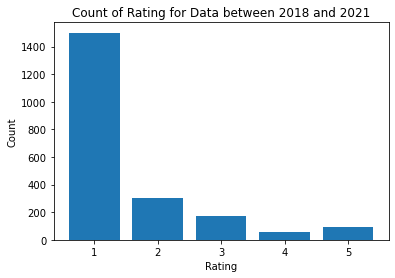

In [16]:
# Plot the count of different ratings for data between 2018 and 2021
facebook_ios_us_review_score_count = facebook_ios_us_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(facebook_ios_us_review_score_count.index,facebook_ios_us_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

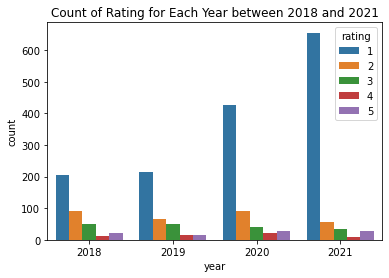

In [17]:
# Plot the count of different ratings for each year
facebook_ios_us_review_score_count_ByYear = (facebook_ios_us_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=facebook_ios_us_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [18]:
# Understand average ratings over year
facebook_ios_us_review_avg_score_ByYear = (facebook_ios_us_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

facebook_ios_us_review_avg_score_ByYear['count'] = facebook_ios_us_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
facebook_ios_us_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  1.829843    382
2019  1.755556    360
2020  1.571664    606
2021  1.335888    783

# Dataframe Preparation for Topic Modelling

In [19]:
# Dataframe with data between 2018 and 2021 without score or year filtering
facebook_ios_us_review_YearMonth.head()

date  \
108 2018-01-05   
109 2018-01-06   
110 2018-01-10   
111 2018-01-10   
112 2018-01-11   

                                                                                                                                                                                                      review  \
108  Facebook used to be so great, I remember when it was just a social networking site, then it became a media consumption site which was ok. Now Facebook has become a revenue generating machine and i...   
109  This, is the second time I am taking time to submit the same review, first time it just “magically” got vanished!\nIt all started with a cool, somehow innovative idea of connections, for the avera...   
110  I have a secondary account that is saved on the app alongside my regular account, and I constantly get pointless push notifications about friend’s posts, and I don’t want them. I updated my accoun...   
111  My primary contact is an email I can not recover because I created it when I was a basically a baby. Facebook has not allowed me to use my primary email that I use today for this account because I...   
112  Event planning on iPhone running newest iOS and newest version FB is not very user friendly. My first event planned on fb was a bit annoying due to text box disappearing whenever I would try to ty...   

                                                       title         userName  \
108                        Where do I begin? Oh, right, ADS.  Brandon Comeaux   
109                 State-of-the-Art in Privacy Infringement          .fazru.   
110                                       Push Notifications      KweenKnight   
111  Primary Contact/Email Recovery Issue, Bull Photo Delete      Geraldine95   
112                                           Event planning       Erica Carr   

     rating  isEdited  year  month  
108       1     False  2018      1  
109       1     False  2018      1  
110       1     False  2018      1  
111       1     False  2018      1  
112       3     False  2018      1

In [20]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
facebook_ios_us_review_YearMonth_score1 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating']==1]
facebook_ios_us_review_YearMonth_score2 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating']==2]
facebook_ios_us_review_YearMonth_score3 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating']==3]
facebook_ios_us_review_YearMonth_score4 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating']==4]
facebook_ios_us_review_YearMonth_score5 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating']==5]


In [21]:
# Prepare dataframe for grouped score
facebook_ios_us_review_YearMonth_score1N2N3 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating'].isin([1,2,3])]
facebook_ios_us_review_YearMonth_score4N5 = facebook_ios_us_review_YearMonth[facebook_ios_us_review_YearMonth['rating'].isin([4,5])]


In [22]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
facebook_ios_us_review_YearMonth_2018_score1N2N3 = facebook_ios_us_review_YearMonth[(facebook_ios_us_review_YearMonth['year']==2018)&(facebook_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_us_review_YearMonth_2019_score1N2N3 = facebook_ios_us_review_YearMonth[(facebook_ios_us_review_YearMonth['year']==2019)&(facebook_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_us_review_YearMonth_2020_score1N2N3 = facebook_ios_us_review_YearMonth[(facebook_ios_us_review_YearMonth['year']==2020)&(facebook_ios_us_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_us_review_YearMonth_2021_score1N2N3 = facebook_ios_us_review_YearMonth[(facebook_ios_us_review_YearMonth['year']==2021)&(facebook_ios_us_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [23]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_us = facebook_ios_us_review_YearMonth.review.values.tolist()
review_words_us = list(sent_to_words(review_us))
print(review_words_us[:1])

[['facebook', 'used', 'to', 'be', 'so', 'great', 'remember', 'when', 'it', 'was', 'just', 'social', 'networking', 'site', 'then', 'it', 'became', 'media', 'consumption', 'site', 'which', 'was', 'ok', 'now', 'facebook', 'has', 'become', 'revenue', 'generating', 'machine', 'and', 'it', 'shows', 'placing', 'ads', 'that', 'cannot', 'be', 'skipped', 'during', 'the', 'climax', 'of', 'video', 'is', 'very', 'frustrating', 'and', 'stupid', 'the', 'new', 'slide', 'to', 'open', 'camera', 'look', 'this', 'isn', 'instagram', 'ok', 'it', 'facebook', 'don', 'take', 'picture', 'often', 'enough', 'to', 'want', 'to', 'swipe', 'my', 'finger', 'to', 'open', 'camera', 'app', 'of', 'the', 'times', 'that', 'have', 'opened', 'the', 'camera', 'feature', 'on', 'facebook', 'one', 'was', 'intentional', 'the', 'intent', 'was', 'to', 'find', 'way', 'to', 'disable', 'it', 'facebook', 'is', 'going', 'downhill', 'as', 'is', 'our', 'country', 'we', 'have', 'become', 'too', 'inclined', 'to', 'post', 'our', 'lives', 'on'

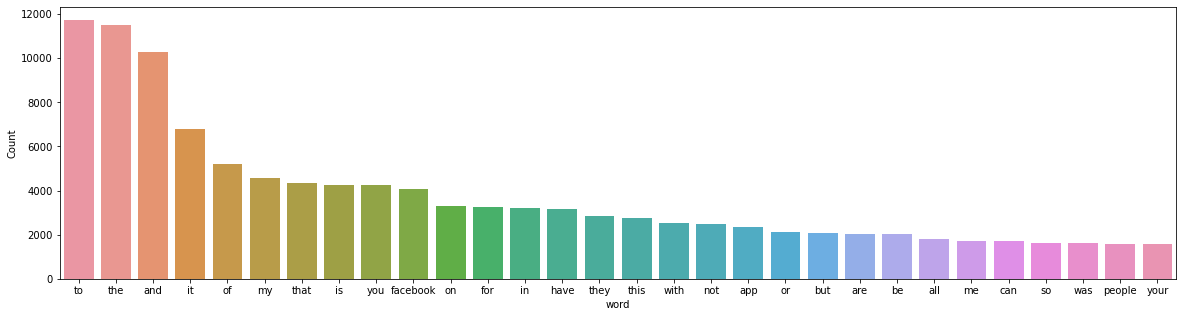

In [24]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us))

In [25]:
# Clean text
review_us_ready = process_words(review_words_us)  # processed Text Data! - move to each section

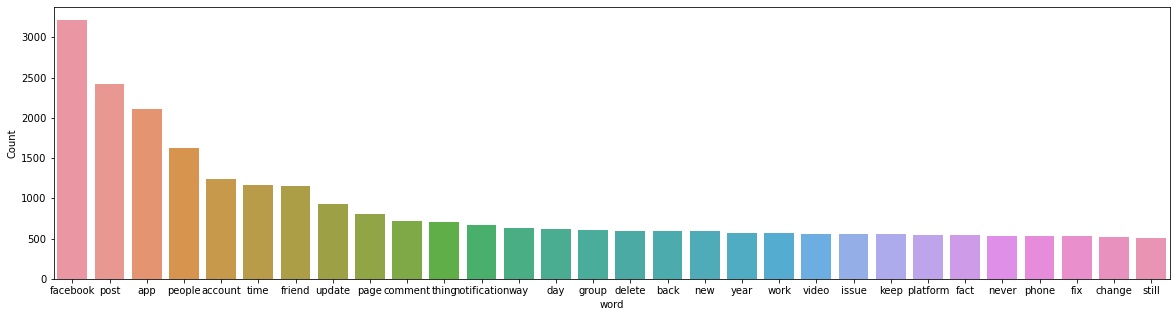

In [26]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready))

In [27]:
# Create Dictionary
id2word_us = corpora.Dictionary(review_us_ready)

2021-10-16 18:13:55,360 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:13:56,357 [INFO] gensim.corpora.dictionary - built Dictionary(7479 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 2132 documents (total 124941 corpus positions)
2021-10-16 18:13:56,397 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(7479 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 2132 documents (total 124941 corpus positions)", 'datetime': '2021-10-16T18:13:56.361790', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [28]:
# Create Corpus: Term Document Frequency
corpus_us = [id2word_us.doc2bow(text) for text in review_us_ready]

In [29]:
# Training LDA model
model_list_us, coherence_values_us = compute_coherence_values(dictionary=id2word_us, corpus=corpus_us, 
                                                              texts=review_us_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 18:13:56,940 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:13:56,942 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:13:56,950 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:13:56,958 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 2132 documents, updating model once every 1000 documents, evaluating perplexity every 2132 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:13:56,959 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2132
2021-10-16 18:14:01,269 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:14:01,354 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"app" + 0.018*"facebook" + 0.014*"post" + 0.012*"update" + 0.011*"time" + 0.009*"account" + 0.008*"people" + 0.008*"page" + 0.008*"noti

2021-10-16 18:14:26,866 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:14:26,875 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"facebook" + 0.023*"app" + 0.017*"post" + 0.014*"account" + 0.013*"time" + 0.012*"update" + 0.010*"page" + 0.009*"notification" + 0.009*"friend" + 0.008*"fix"
2021-10-16 18:14:26,880 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.020*"post" + 0.009*"friend" + 0.008*"platform" + 0.007*"ban" + 0.006*"app" + 0.006*"social" + 0.006*"thing" + 0.006*"time"
2021-10-16 18:14:26,883 [INFO] gensim.models.ldamodel - topic diff=0.351549, rho=0.403830
2021-10-16 18:14:26,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #2000/2132
2021-10-16 18:14:30,238 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:14:30,243 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"facebook" + 

2021-10-16 18:14:46,743 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2000/2132
2021-10-16 18:14:49,171 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:14:49,194 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.018*"post" + 0.015*"account" + 0.012*"time" + 0.011*"update" + 0.010*"page" + 0.009*"friend" + 0.008*"notification" + 0.007*"fix"
2021-10-16 18:14:49,198 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.009*"platform" + 0.008*"fact" + 0.007*"friend" + 0.007*"ban" + 0.007*"social" + 0.006*"allow" + 0.006*"medium"
2021-10-16 18:14:49,201 [INFO] gensim.models.ldamodel - topic diff=0.279877, rho=0.330915
2021-10-16 18:14:49,823 [INFO] gensim.models.ldamodel - -6.888 per-word bound, 118.5 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:14:49,825 [INFO] gensim.models.lda

2021-10-16 18:15:07,002 [INFO] gensim.models.ldamodel - topic diff=0.235823, rho=0.287100
2021-10-16 18:15:07,484 [INFO] gensim.models.ldamodel - -6.875 per-word bound, 117.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:15:07,485 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #2132/2132
2021-10-16 18:15:07,942 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:15:07,946 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.017*"post" + 0.016*"account" + 0.012*"time" + 0.010*"page" + 0.010*"friend" + 0.009*"update" + 0.008*"fix" + 0.008*"people"
2021-10-16 18:15:07,950 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"friend" + 0.007*"social" + 0.006*"community" + 0.006*"standard"
2021-10-16 18:15:07,952 [INFO] gensim.models.ldam

2021-10-16 18:15:25,613 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"friend" + 0.007*"social" + 0.006*"community" + 0.006*"standard"
2021-10-16 18:15:25,614 [INFO] gensim.models.ldamodel - topic diff=0.184978, rho=0.257070
2021-10-16 18:15:25,616 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/2132
2021-10-16 18:15:27,668 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:15:27,673 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.019*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"friend" + 0.010*"page" + 0.008*"notification" + 0.008*"fix"
2021-10-16 18:15:27,676 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"social" + 0.007*"fact" + 0.007*"friend" +

2021-10-16 18:15:44,382 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"social" + 0.007*"fact" + 0.006*"friend" + 0.006*"community" + 0.006*"standard"
2021-10-16 18:15:44,384 [INFO] gensim.models.ldamodel - topic diff=0.164939, rho=0.228623
2021-10-16 18:15:44,386 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #2000/2132
2021-10-16 18:15:46,691 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:15:46,695 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.018*"post" + 0.015*"account" + 0.012*"time" + 0.010*"update" + 0.010*"friend" + 0.010*"page" + 0.007*"notification" + 0.007*"people"
2021-10-16 18:15:46,699 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.008*"fact" + 0.008*"ban" + 0.007*"social" + 0.007*"friend

2021-10-16 18:16:04,503 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.008*"fact" + 0.008*"ban" + 0.007*"social" + 0.007*"friend" + 0.006*"allow" + 0.006*"censor"
2021-10-16 18:16:04,505 [INFO] gensim.models.ldamodel - topic diff=0.167153, rho=0.212564
2021-10-16 18:16:05,174 [INFO] gensim.models.ldamodel - -6.859 per-word bound, 116.0 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:16:05,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #2132/2132
2021-10-16 18:16:05,694 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:16:05,700 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.017*"post" + 0.015*"account" + 0.012*"time" + 0.010*"page" + 0.010*"friend" + 0.009*"update" + 0.008*"people" + 0.008*"fix"
2021-10-16 18:16:05,711 [INFO] gensim.models.ldamodel 

2021-10-16 18:16:24,156 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:16:24,165 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.017*"post" + 0.015*"account" + 0.012*"time" + 0.010*"page" + 0.010*"friend" + 0.009*"update" + 0.008*"people" + 0.008*"fix"
2021-10-16 18:16:24,168 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"community" + 0.006*"standard"
2021-10-16 18:16:24,169 [INFO] gensim.models.ldamodel - topic diff=0.138985, rho=0.199474
2021-10-16 18:16:24,172 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/2132
2021-10-16 18:16:26,646 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:16:26,650 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook"

2021-10-16 18:16:42,778 [INFO] gensim.models.ldamodel - topic diff=0.130614, rho=0.188538
2021-10-16 18:16:42,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/2132
2021-10-16 18:16:46,472 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:16:46,480 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.019*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"friend" + 0.010*"page" + 0.008*"notification" + 0.008*"fix"
2021-10-16 18:16:46,500 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"community" + 0.006*"standard"
2021-10-16 18:16:46,503 [INFO] gensim.models.ldamodel - topic diff=0.129515, rho=0.185274
2021-10-16 18:16:46,504 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #2000/2132
2021-10-16 18:16:4

2021-10-16 18:17:04,134 [INFO] gensim.models.ldamodel - topic diff=0.122578, rho=0.176413
2021-10-16 18:17:04,135 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #2000/2132
2021-10-16 18:17:06,509 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:17:06,513 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.018*"post" + 0.014*"account" + 0.012*"time" + 0.010*"update" + 0.010*"friend" + 0.010*"page" + 0.007*"people" + 0.007*"notification"
2021-10-16 18:17:06,516 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.008*"ban" + 0.008*"fact" + 0.007*"social" + 0.007*"friend" + 0.006*"allow" + 0.006*"censor"
2021-10-16 18:17:06,517 [INFO] gensim.models.ldamodel - topic diff=0.136144, rho=0.176413
2021-10-16 18:17:06,992 [INFO] gensim.models.ldamodel - -6.852 per-word bound, 115.5 perplexity estimate based on a hel

2021-10-16 18:17:26,814 [INFO] gensim.models.ldamodel - topic diff=0.129690, rho=0.168713
2021-10-16 18:17:27,245 [INFO] gensim.models.ldamodel - -6.850 per-word bound, 115.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:17:27,248 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #2132/2132
2021-10-16 18:17:27,715 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:17:27,719 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"post" + 0.015*"account" + 0.012*"time" + 0.010*"page" + 0.010*"friend" + 0.009*"update" + 0.008*"people" + 0.008*"fix"
2021-10-16 18:17:27,722 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"standard" + 0.006*"community"
2021-10-16 18:17:27,722 [INFO] gensim.models.lda

2021-10-16 18:17:47,217 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"standard" + 0.006*"community"
2021-10-16 18:17:47,220 [INFO] gensim.models.ldamodel - topic diff=0.110689, rho=0.161940
2021-10-16 18:17:47,223 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/2132
2021-10-16 18:17:49,566 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:17:49,571 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.018*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"friend" + 0.010*"page" + 0.008*"notification" + 0.008*"people"
2021-10-16 18:17:49,574 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend

2021-10-16 18:18:08,443 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"standard" + 0.006*"community"
2021-10-16 18:18:08,444 [INFO] gensim.models.ldamodel - topic diff=0.105485, rho=0.154061
2021-10-16 18:18:08,447 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #2000/2132
2021-10-16 18:18:11,025 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:18:11,028 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.018*"post" + 0.014*"account" + 0.012*"time" + 0.010*"update" + 0.010*"friend" + 0.010*"page" + 0.007*"people" + 0.007*"notification"
2021-10-16 18:18:11,032 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.008*"fact" + 0.007*"social" + 0.007*"friend

2021-10-16 18:18:27,704 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.008*"fact" + 0.007*"social" + 0.007*"friend" + 0.006*"allow" + 0.006*"censor"
2021-10-16 18:18:27,705 [INFO] gensim.models.ldamodel - topic diff=0.113274, rho=0.148853
2021-10-16 18:18:28,166 [INFO] gensim.models.ldamodel - -6.846 per-word bound, 115.1 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:18:28,168 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #2132/2132
2021-10-16 18:18:28,435 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:18:28,440 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"post" + 0.015*"account" + 0.012*"time" + 0.010*"page" + 0.010*"friend" + 0.010*"update" + 0.008*"people" + 0.008*"fix"
2021-10-16 18:18:28,443 [INFO] gensim.models.ldamodel 

2021-10-16 18:18:49,177 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:18:49,182 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"post" + 0.015*"account" + 0.012*"time" + 0.010*"page" + 0.010*"friend" + 0.010*"update" + 0.008*"people" + 0.008*"fix"
2021-10-16 18:18:49,184 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"standard" + 0.006*"community"
2021-10-16 18:18:49,186 [INFO] gensim.models.ldamodel - topic diff=0.097671, rho=0.144140
2021-10-16 18:18:49,189 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/2132
2021-10-16 18:18:52,167 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:18:52,173 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook"

2021-10-16 18:19:09,840 [INFO] gensim.models.ldamodel - topic diff=0.094564, rho=0.139847
2021-10-16 18:19:09,841 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/2132
2021-10-16 18:19:13,327 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:19:13,330 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"app" + 0.018*"post" + 0.014*"account" + 0.012*"time" + 0.010*"update" + 0.010*"friend" + 0.010*"page" + 0.008*"notification" + 0.008*"people"
2021-10-16 18:19:13,333 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.010*"platform" + 0.009*"ban" + 0.007*"fact" + 0.007*"social" + 0.006*"friend" + 0.006*"standard" + 0.006*"community"
2021-10-16 18:19:13,334 [INFO] gensim.models.ldamodel - topic diff=0.093908, rho=0.138499
2021-10-16 18:19:13,335 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #2000/2132
2021-10-16 18:1

2021-10-16 18:20:15,776 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.023*"post" + 0.021*"people" + 0.013*"friend" + 0.011*"group" + 0.011*"ban" + 0.009*"time" + 0.009*"platform" + 0.007*"comment" + 0.007*"community"
2021-10-16 18:20:15,777 [INFO] gensim.models.ldamodel - topic diff=0.828747, rho=0.577350
2021-10-16 18:20:15,780 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/2132
2021-10-16 18:20:19,799 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:20:19,807 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"facebook" + 0.026*"post" + 0.021*"people" + 0.015*"friend" + 0.012*"group" + 0.009*"time" + 0.008*"ban" + 0.007*"platform" + 0.007*"share" + 0.007*"thing"
2021-10-16 18:20:19,813 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.023*"post" + 0.022*"facebook" + 0.020*"app" + 0.014*"people" + 0.008*"hate" + 0.008*"time" + 0.008*"friend" + 0.006*"marketplace" + 0.00

2021-10-16 18:20:32,966 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"post" + 0.030*"notification" + 0.028*"comment" + 0.022*"app" + 0.016*"group" + 0.016*"video" + 0.015*"update" + 0.014*"time" + 0.013*"show" + 0.012*"watch"
2021-10-16 18:20:32,968 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.024*"people" + 0.023*"post" + 0.012*"friend" + 0.011*"ban" + 0.011*"platform" + 0.008*"group" + 0.008*"fact" + 0.008*"time" + 0.007*"thing"
2021-10-16 18:20:32,971 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.019*"people" + 0.015*"post" + 0.011*"friend" + 0.007*"thing" + 0.006*"keep" + 0.006*"app" + 0.006*"day" + 0.006*"put" + 0.006*"able" + 0.006*"year"
2021-10-16 18:20:32,975 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"boot" + 0.014*"shadow" + 0.012*"administrator" + 0.010*"cuss" + 0.009*"feed" + 0.009*"click" + 0.007*"picture" + 0.007*"app" + 0.006*"board" + 0.006*"extend"
2021-10-16 18:20:32,980 [INFO] gensim.models.ldamodel - topic #1 

2021-10-16 18:20:46,462 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.024*"people" + 0.022*"post" + 0.011*"platform" + 0.011*"friend" + 0.011*"fact" + 0.009*"ban" + 0.008*"censor" + 0.007*"social" + 0.007*"allow"
2021-10-16 18:20:46,465 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.016*"shadow" + 0.008*"cuss" + 0.008*"boot" + 0.007*"dare" + 0.006*"administrator" + 0.006*"click" + 0.006*"picture" + 0.005*"board" + 0.005*"cat" + 0.005*"extend"
2021-10-16 18:20:46,467 [INFO] gensim.models.ldamodel - topic diff=0.251388, rho=0.374450
2021-10-16 18:20:46,941 [INFO] gensim.models.ldamodel - -6.895 per-word bound, 119.0 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:20:46,942 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #2132/2132
2021-10-16 18:20:47,292 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:20:47,303 [INFO] gensim.models.ldam

2021-10-16 18:20:59,207 [INFO] gensim.models.ldamodel - topic diff=0.200587, rho=0.330915
2021-10-16 18:20:59,210 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2000/2132
2021-10-16 18:21:01,826 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:21:01,844 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.015*"item" + 0.015*"marketplace" + 0.015*"page" + 0.014*"change" + 0.014*"user" + 0.012*"set" + 0.010*"album" + 0.010*"post" + 0.009*"listing"
2021-10-16 18:21:01,849 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"facebook" + 0.028*"account" + 0.024*"app" + 0.013*"time" + 0.011*"phone" + 0.010*"page" + 0.010*"help" + 0.008*"change" + 0.008*"still" + 0.008*"back"
2021-10-16 18:21:01,854 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.017*"facebook" + 0.016*"app" + 0.011*"people" + 0.010*"post" + 0.010*"hate" + 0.007*"marketplace" + 0.006*"article" + 0.006*"idea" + 0.005*"place" 

2021-10-16 18:21:11,615 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.011*"platform" + 0.011*"ban" + 0.010*"friend" + 0.008*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"time"
2021-10-16 18:21:11,618 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.016*"facebook" + 0.016*"app" + 0.012*"people" + 0.011*"hate" + 0.010*"post" + 0.007*"date" + 0.006*"time" + 0.006*"user" + 0.005*"marketplace" + 0.005*"idea"
2021-10-16 18:21:11,621 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"facebook" + 0.027*"account" + 0.023*"app" + 0.013*"time" + 0.011*"phone" + 0.011*"page" + 0.010*"help" + 0.009*"still" + 0.008*"change" + 0.008*"problem"
2021-10-16 18:21:11,624 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.031*"app" + 0.028*"notification" + 0.025*"update" + 0.020*"comment" + 0.018*"video" + 0.016*"time" + 0.015*"group" + 0.014*"friend" + 0.013*"show"
2021-10-16 18:21:11,626 [INFO] gensim.models.ldamodel - t

2021-10-16 18:21:20,743 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.016*"facebook" + 0.016*"app" + 0.012*"people" + 0.010*"hate" + 0.009*"post" + 0.008*"date" + 0.007*"community" + 0.006*"standard" + 0.006*"user" + 0.006*"time"
2021-10-16 18:21:20,746 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.015*"people" + 0.012*"post" + 0.009*"word" + 0.009*"put" + 0.009*"friend" + 0.008*"thing" + 0.007*"understand" + 0.007*"block" + 0.007*"able" + 0.007*"vaccine"
2021-10-16 18:21:20,747 [INFO] gensim.models.ldamodel - topic diff=0.120662, rho=0.287100
2021-10-16 18:21:20,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/2132
2021-10-16 18:21:23,810 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:21:23,831 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.027*"account" + 0.023*"app" + 0.013*"time" + 0.011*"phone" + 0.011*"page" + 0.010*"help" + 0.009*"still" + 0.008*"change" 

2021-10-16 18:21:33,461 [INFO] gensim.models.ldamodel - -6.806 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:21:33,464 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #2132/2132
2021-10-16 18:21:33,736 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:21:33,747 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.015*"people" + 0.011*"post" + 0.010*"word" + 0.009*"put" + 0.008*"friend" + 0.008*"thing" + 0.007*"understand" + 0.007*"block" + 0.007*"able" + 0.007*"vaccine"
2021-10-16 18:21:33,752 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"post" + 0.030*"app" + 0.023*"notification" + 0.022*"update" + 0.022*"comment" + 0.017*"video" + 0.016*"group" + 0.015*"time" + 0.015*"friend" + 0.013*"show"
2021-10-16 18:21:33,754 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.022*"post" + 0.012*"platform"

2021-10-16 18:21:45,464 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.017*"shadow" + 0.010*"boot" + 0.009*"cuss" + 0.009*"click" + 0.008*"administrator" + 0.006*"cat" + 0.006*"dare" + 0.006*"regularly" + 0.006*"extend" + 0.005*"redirect"
2021-10-16 18:21:45,466 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.033*"app" + 0.025*"update" + 0.024*"notification" + 0.019*"comment" + 0.017*"video" + 0.015*"time" + 0.014*"group" + 0.014*"friend" + 0.013*"show"
2021-10-16 18:21:45,470 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.021*"marketplace" + 0.018*"item" + 0.017*"page" + 0.016*"user" + 0.012*"set" + 0.012*"change" + 0.010*"album" + 0.010*"privacy" + 0.009*"bad"
2021-10-16 18:21:45,472 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.029*"account" + 0.022*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"page" + 0.010*"help" + 0.008*"still" + 0.008*"change" + 0.008*"back"
2021-10-16 18:21:45,474 [INFO] gensim.models.ldamode

2021-10-16 18:21:56,615 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.027*"account" + 0.022*"app" + 0.013*"time" + 0.011*"phone" + 0.011*"page" + 0.010*"help" + 0.009*"still" + 0.008*"change" + 0.008*"problem"
2021-10-16 18:21:56,618 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.014*"shadow" + 0.014*"boot" + 0.011*"click" + 0.010*"administrator" + 0.010*"cuss" + 0.007*"regularly" + 0.006*"spam" + 0.006*"redirect" + 0.006*"cat" + 0.005*"thumbnail"
2021-10-16 18:21:56,619 [INFO] gensim.models.ldamodel - topic diff=0.119602, rho=0.234843
2021-10-16 18:21:56,622 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #2000/2132
2021-10-16 18:21:59,383 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:21:59,392 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.022*"marketplace" + 0.019*"item" + 0.017*"page" + 0.016*"user" + 0.012*"set" + 0.011*"change" + 0.010*"album" + 0.0

2021-10-16 18:22:06,224 [INFO] gensim.models.ldamodel - topic diff=0.090395, rho=0.228623
2021-10-16 18:22:06,226 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/2132
2021-10-16 18:22:08,485 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:22:08,540 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"time"
2021-10-16 18:22:08,578 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.033*"app" + 0.025*"update" + 0.025*"notification" + 0.019*"comment" + 0.017*"video" + 0.016*"time" + 0.015*"friend" + 0.014*"group" + 0.013*"show"
2021-10-16 18:22:08,580 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.028*"account" + 0.021*"app" + 0.013*"time" + 0.011*"phone" + 0.011*"page" + 0.010*"help" + 0.009*"still" + 0.008*"proble

2021-10-16 18:22:17,678 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.014*"app" + 0.013*"facebook" + 0.013*"people" + 0.011*"hate" + 0.008*"date" + 0.007*"community" + 0.007*"user" + 0.007*"standard" + 0.006*"keep" + 0.006*"time"
2021-10-16 18:22:17,683 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"photo" + 0.022*"marketplace" + 0.021*"page" + 0.017*"item" + 0.017*"user" + 0.013*"set" + 0.011*"bad" + 0.011*"share" + 0.010*"group" + 0.009*"privacy"
2021-10-16 18:22:17,693 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.029*"account" + 0.021*"app" + 0.013*"time" + 0.011*"page" + 0.011*"phone" + 0.011*"help" + 0.009*"still" + 0.009*"access" + 0.008*"year"
2021-10-16 18:22:17,696 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.012*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:22:17,697 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:22:28,346 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.012*"people" + 0.009*"word" + 0.009*"post" + 0.009*"put" + 0.008*"vaccine" + 0.007*"friend" + 0.007*"birthday" + 0.007*"block" + 0.007*"thing" + 0.007*"understand"
2021-10-16 18:22:28,348 [INFO] gensim.models.ldamodel - topic diff=0.091082, rho=0.207919
2021-10-16 18:22:28,858 [INFO] gensim.models.ldamodel - -6.780 per-word bound, 109.9 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:22:28,859 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #2132/2132
2021-10-16 18:22:29,214 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:22:29,222 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"post" + 0.032*"app" + 0.023*"update" + 0.022*"notification" + 0.020*"comment" + 0.016*"video" + 0.015*"time" + 0.015*"group" + 0.015*"friend" + 0.012*"show"
2021-10-16 18:22:29,225 [INFO] gensim.models.ld

2021-10-16 18:22:41,630 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:22:41,655 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.017*"shadow" + 0.011*"boot" + 0.009*"cuss" + 0.009*"click" + 0.009*"administrator" + 0.006*"cat" + 0.006*"regularly" + 0.006*"dare" + 0.006*"extend" + 0.006*"spam"
2021-10-16 18:22:41,664 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.012*"people" + 0.010*"word" + 0.009*"post" + 0.009*"put" + 0.008*"vaccine" + 0.007*"birthday" + 0.007*"friend" + 0.007*"block" + 0.007*"thing" + 0.007*"understand"
2021-10-16 18:22:41,691 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.022*"post" + 0.012*"platform" + 0.010*"fact" + 0.010*"ban" + 0.010*"friend" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:22:41,697 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"post" + 0.035*"app" + 0.025*"update" + 0.023*"notification" + 0.019*"comment" 

2021-10-16 18:22:50,293 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.021*"marketplace" + 0.020*"page" + 0.017*"item" + 0.016*"user" + 0.014*"set" + 0.012*"privacy" + 0.010*"bad" + 0.010*"album" + 0.010*"share"
2021-10-16 18:22:50,299 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.014*"app" + 0.013*"people" + 0.013*"facebook" + 0.012*"hate" + 0.008*"date" + 0.007*"community" + 0.007*"user" + 0.006*"standard" + 0.006*"keep" + 0.006*"time"
2021-10-16 18:22:50,305 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.028*"account" + 0.021*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"page" + 0.011*"help" + 0.009*"still" + 0.008*"problem" + 0.008*"access"
2021-10-16 18:22:50,308 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.034*"app" + 0.025*"update" + 0.024*"notification" + 0.019*"comment" + 0.016*"video" + 0.016*"time" + 0.015*"friend" + 0.014*"group" + 0.013*"show"
2021-10-16 18:22:50,312 [INFO] gensim.models.ldamodel - to

2021-10-16 18:22:59,316 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.012*"people" + 0.011*"word" + 0.009*"put" + 0.009*"post" + 0.008*"thing" + 0.008*"understand" + 0.007*"community" + 0.007*"vaccine" + 0.007*"block" + 0.007*"friend"
2021-10-16 18:22:59,322 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.017*"shadow" + 0.016*"boot" + 0.012*"click" + 0.012*"administrator" + 0.011*"cuss" + 0.007*"spam" + 0.007*"cat" + 0.007*"regularly" + 0.006*"target" + 0.006*"extend"
2021-10-16 18:22:59,324 [INFO] gensim.models.ldamodel - topic diff=0.072723, rho=0.188538
2021-10-16 18:22:59,328 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/2132
2021-10-16 18:23:01,467 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:23:01,477 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.021*"marketplace" + 0.020*"page" + 0.017*"item" + 0.016*"user" + 0.014*"set" + 0.012*"privacy" + 0.010*"bad" + 0.0

2021-10-16 18:23:10,864 [INFO] gensim.models.ldamodel - -6.769 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:23:10,868 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #2132/2132
2021-10-16 18:23:11,218 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:23:11,227 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:23:11,229 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"post" + 0.033*"app" + 0.023*"update" + 0.022*"notification" + 0.020*"comment" + 0.016*"video" + 0.015*"time" + 0.015*"friend" + 0.015*"group" + 0.012*"show"
2021-10-16 18:23:11,231 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"facebook" + 0.029*"account" + 0.020*"app" + 0.013*"time" +

2021-10-16 18:23:21,753 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.022*"post" + 0.012*"platform" + 0.010*"fact" + 0.010*"ban" + 0.010*"friend" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:23:21,757 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.029*"account" + 0.020*"app" + 0.012*"time" + 0.011*"phone" + 0.010*"help" + 0.010*"page" + 0.009*"still" + 0.008*"delete" + 0.008*"access"
2021-10-16 18:23:21,761 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.016*"shadow" + 0.011*"boot" + 0.010*"cuss" + 0.009*"click" + 0.009*"administrator" + 0.006*"regularly" + 0.006*"cat" + 0.006*"dare" + 0.006*"spam" + 0.006*"extend"
2021-10-16 18:23:21,764 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"people" + 0.010*"word" + 0.009*"put" + 0.008*"post" + 0.008*"vaccine" + 0.007*"birthday" + 0.007*"thing" + 0.007*"block" + 0.007*"friend" + 0.007*"understand"
2021-10-16 18:23:21,766 [INFO] gensim.models.lda

2021-10-16 18:23:31,396 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"people" + 0.011*"word" + 0.009*"put" + 0.009*"post" + 0.008*"birthday" + 0.008*"thing" + 0.008*"understand" + 0.007*"block" + 0.007*"friend" + 0.007*"community"
2021-10-16 18:23:31,399 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"app" + 0.013*"people" + 0.012*"hate" + 0.012*"facebook" + 0.008*"date" + 0.007*"community" + 0.007*"standard" + 0.007*"user" + 0.006*"keep" + 0.006*"time"
2021-10-16 18:23:31,401 [INFO] gensim.models.ldamodel - topic diff=0.082373, rho=0.171167
2021-10-16 18:23:31,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #2000/2132
2021-10-16 18:23:33,895 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:23:33,906 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"photo" + 0.024*"marketplace" + 0.019*"item" + 0.018*"page" + 0.016*"user" + 0.013*"set" + 0.012*"privacy" + 0.010*"album" + 0.009*

2021-10-16 18:23:40,767 [INFO] gensim.models.ldamodel - topic diff=0.064658, rho=0.168713
2021-10-16 18:23:40,769 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/2132
2021-10-16 18:23:43,262 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:23:43,288 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.014*"shadow" + 0.013*"boot" + 0.011*"click" + 0.010*"administrator" + 0.010*"cuss" + 0.007*"regularly" + 0.007*"spam" + 0.006*"cat" + 0.006*"redirect" + 0.005*"target"
2021-10-16 18:23:43,296 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.028*"account" + 0.020*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"help" + 0.011*"page" + 0.009*"still" + 0.008*"access" + 0.008*"problem"
2021-10-16 18:23:43,300 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.034*"app" + 0.025*"update" + 0.023*"notification" + 0.019*"comment" + 0.016*"video" + 0.016*"time" + 0.015*"friend" + 0

2021-10-16 18:23:52,093 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"app" + 0.013*"people" + 0.012*"facebook" + 0.011*"hate" + 0.008*"date" + 0.007*"community" + 0.007*"standard" + 0.007*"user" + 0.007*"keep" + 0.006*"time"
2021-10-16 18:23:52,095 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:23:52,098 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"photo" + 0.023*"marketplace" + 0.021*"page" + 0.017*"item" + 0.017*"user" + 0.013*"set" + 0.011*"privacy" + 0.010*"bad" + 0.010*"share" + 0.009*"group"
2021-10-16 18:23:52,102 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.016*"shadow" + 0.015*"boot" + 0.012*"click" + 0.012*"administrator" + 0.011*"cuss" + 0.007*"spam" + 0.007*"regularly" + 0.007*"cat" + 0.006*"target" + 0.006*"extend"
2021-10-16 18:23:52,103 [INFO] gensim.models.ldamod

2021-10-16 18:24:02,874 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.038*"facebook" + 0.029*"account" + 0.020*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"help" + 0.010*"page" + 0.009*"still" + 0.008*"delete" + 0.008*"access"
2021-10-16 18:24:02,877 [INFO] gensim.models.ldamodel - topic diff=0.066786, rho=0.159858
2021-10-16 18:24:03,317 [INFO] gensim.models.ldamodel - -6.761 per-word bound, 108.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:24:03,319 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #2132/2132
2021-10-16 18:24:03,640 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:24:03,654 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:24:03,656 [INFO] gensim.models.ldamodel

2021-10-16 18:24:14,982 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:24:14,991 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"post" + 0.035*"app" + 0.025*"update" + 0.023*"notification" + 0.018*"comment" + 0.016*"video" + 0.015*"time" + 0.015*"friend" + 0.014*"group" + 0.012*"show"
2021-10-16 18:24:14,993 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"app" + 0.012*"people" + 0.012*"hate" + 0.011*"facebook" + 0.007*"date" + 0.007*"user" + 0.006*"community" + 0.006*"standard" + 0.006*"keep" + 0.006*"time"
2021-10-16 18:24:14,996 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.010*"people" + 0.010*"word" + 0.009*"put" + 0.008*"post" + 0.008*"vaccine" + 0.007*"birthday" + 0.007*"thing" + 0.007*"block" + 0.007*"friend" + 0.007*"understand"
2021-10-16 18:24:14,999 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"photo" + 0.024*"marketplace" + 0.019*"item" + 0.018*"page" + 0.016*"user" + 0.013*

2021-10-16 18:24:23,764 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"time"
2021-10-16 18:24:23,769 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"app" + 0.013*"people" + 0.012*"hate" + 0.011*"facebook" + 0.008*"date" + 0.007*"community" + 0.007*"standard" + 0.007*"user" + 0.007*"keep" + 0.006*"time"
2021-10-16 18:24:23,776 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"facebook" + 0.029*"account" + 0.020*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"help" + 0.011*"page" + 0.009*"still" + 0.008*"access" + 0.008*"problem"
2021-10-16 18:24:23,778 [INFO] gensim.models.ldamodel - topic diff=0.072452, rho=0.152265
2021-10-16 18:24:23,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #2000/2132
2021-10-16 18:24:26,168 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 18:24:32,860 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:24:32,861 [INFO] gensim.models.ldamodel - topic diff=0.057428, rho=0.150530
2021-10-16 18:24:32,863 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/2132
2021-10-16 18:24:35,364 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:24:35,371 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.011*"word" + 0.010*"people" + 0.009*"put" + 0.008*"birthday" + 0.008*"post" + 0.008*"thing" + 0.007*"understand" + 0.007*"block" + 0.007*"friend" + 0.007*"community"
2021-10-16 18:24:35,374 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.

2021-10-16 18:24:43,939 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:24:43,947 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.030*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:24:43,949 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"people" + 0.013*"app" + 0.011*"hate" + 0.011*"facebook" + 0.008*"date" + 0.008*"community" + 0.007*"standard" + 0.007*"user" + 0.007*"keep" + 0.006*"time"
2021-10-16 18:24:43,951 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"photo" + 0.024*"marketplace" + 0.021*"page" + 0.018*"item" + 0.017*"user" + 0.013*"set" + 0.011*"privacy" + 0.010*"bad" + 0.010*"share" + 0.009*"group"
2021-10-16 18:24:43,953 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"facebook" + 0.029*"account" + 0.020*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"help" + 

2021-10-16 18:24:55,940 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.010*"fact" + 0.010*"ban" + 0.010*"friend" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:24:55,942 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.010*"word" + 0.010*"people" + 0.009*"put" + 0.008*"vaccine" + 0.008*"birthday" + 0.007*"thing" + 0.007*"post" + 0.007*"block" + 0.007*"friend" + 0.007*"understand"
2021-10-16 18:24:55,945 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"photo" + 0.025*"marketplace" + 0.019*"item" + 0.018*"page" + 0.016*"user" + 0.013*"set" + 0.012*"privacy" + 0.010*"album" + 0.009*"bad" + 0.009*"share"
2021-10-16 18:24:55,947 [INFO] gensim.models.ldamodel - topic diff=0.059580, rho=0.144140
2021-10-16 18:24:56,506 [INFO] gensim.models.ldamodel - -6.755 per-word bound, 108.0 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:24:56,508 [INFO] gen

2021-10-16 18:25:06,117 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"photo" + 0.023*"marketplace" + 0.020*"page" + 0.017*"item" + 0.017*"user" + 0.014*"set" + 0.013*"privacy" + 0.010*"album" + 0.010*"bad" + 0.009*"share"
2021-10-16 18:25:06,118 [INFO] gensim.models.ldamodel - topic diff=0.066729, rho=0.141235
2021-10-16 18:25:06,124 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #2000/2132
2021-10-16 18:25:08,750 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:25:08,759 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.012*"platform" + 0.010*"fact" + 0.010*"ban" + 0.010*"friend" + 0.008*"social" + 0.007*"allow" + 0.007*"censor"
2021-10-16 18:25:08,761 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.042*"post" + 0.035*"app" + 0.025*"update" + 0.023*"notification" + 0.018*"comment" + 0.015*"time" + 0.015*"video" + 0.015*"friend" + 0.014*"gr

2021-10-16 18:25:18,168 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:25:18,180 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"photo" + 0.023*"marketplace" + 0.020*"page" + 0.018*"item" + 0.017*"user" + 0.014*"set" + 0.013*"privacy" + 0.010*"album" + 0.010*"bad" + 0.009*"share"
2021-10-16 18:25:18,188 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"facebook" + 0.029*"account" + 0.020*"app" + 0.012*"time" + 0.011*"phone" + 0.011*"help" + 0.010*"page" + 0.009*"still" + 0.008*"access" + 0.008*"problem"
2021-10-16 18:25:18,198 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.025*"people" + 0.023*"post" + 0.011*"platform" + 0.011*"ban" + 0.010*"friend" + 0.009*"fact" + 0.008*"social" + 0.007*"allow" + 0.007*"time"
2021-10-16 18:25:18,204 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.013*"people" + 0.013*"app" + 0.012*"hate" + 0.011*"facebook" + 0.008*"date" + 0.007*"community" +

2021-10-16 18:26:05,599 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"facebook" + 0.020*"app" + 0.018*"post" + 0.011*"account" + 0.011*"ban" + 0.010*"people" + 0.010*"time" + 0.009*"day" + 0.008*"comment" + 0.008*"checker"
2021-10-16 18:26:05,606 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.043*"facebook" + 0.027*"account" + 0.019*"app" + 0.009*"back" + 0.009*"help" + 0.008*"never" + 0.008*"update" + 0.008*"post" + 0.008*"new" + 0.008*"time"
2021-10-16 18:26:05,638 [INFO] gensim.models.ldamodel - topic diff=0.714459, rho=0.707107
2021-10-16 18:26:06,591 [INFO] gensim.models.ldamodel - -8.124 per-word bound, 278.9 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:26:06,596 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #2132/2132
2021-10-16 18:26:07,259 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:26:07,273 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:26:21,804 [INFO] gensim.models.ldamodel - topic diff=0.347800, rho=0.441425
2021-10-16 18:26:21,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #2000/2132
2021-10-16 18:26:24,554 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:26:24,567 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.019*"facebook" + 0.014*"hate" + 0.013*"people" + 0.012*"app" + 0.011*"political" + 0.011*"liberal" + 0.009*"speech" + 0.009*"lie" + 0.009*"become" + 0.009*"post"
2021-10-16 18:26:24,568 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"app" + 0.035*"update" + 0.035*"notification" + 0.015*"facebook" + 0.014*"fix" + 0.013*"post" + 0.012*"issue" + 0.012*"phone" + 0.011*"work" + 0.010*"new"
2021-10-16 18:26:24,570 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.028*"people" + 0.014*"app" + 0.013*"facebook" + 0.009*"content" + 0.007*"post" + 0.007*"time" + 0.006*"story" + 0.006*"well" + 0.006*"bully"

2021-10-16 18:26:35,639 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.029*"process" + 0.014*"witch" + 0.010*"follow" + 0.009*"sincerely" + 0.008*"unfriend" + 0.008*"avenue" + 0.006*"dare" + 0.006*"credit" + 0.006*"order" + 0.005*"frequent"
2021-10-16 18:26:35,647 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.064*"photo" + 0.031*"upload" + 0.025*"album" + 0.008*"role" + 0.007*"active" + 0.007*"cross" + 0.007*"caption" + 0.007*"document" + 0.006*"attitude" + 0.006*"scene"
2021-10-16 18:26:35,656 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.018*"hate" + 0.017*"facebook" + 0.011*"app" + 0.010*"people" + 0.010*"political" + 0.009*"become" + 0.008*"speech" + 0.007*"speak" + 0.007*"social" + 0.007*"certain"
2021-10-16 18:26:35,665 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"facebook" + 0.026*"people" + 0.025*"post" + 0.015*"platform" + 0.013*"friend" + 0.011*"fact" + 0.009*"social" + 0.009*"ban" + 0.009*"share" + 0.009*"censor"
2021-10-16 18:26:35,668 [INFO] ge

2021-10-16 18:26:45,577 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"car" + 0.036*"filter" + 0.029*"dictate" + 0.022*"vehicle" + 0.018*"distance" + 0.017*"dealership" + 0.017*"drive" + 0.015*"search" + 0.014*"feel" + 0.014*"proximity"
2021-10-16 18:26:45,579 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.064*"app" + 0.039*"update" + 0.033*"notification" + 0.014*"fix" + 0.014*"facebook" + 0.013*"time" + 0.013*"phone" + 0.012*"work" + 0.010*"new" + 0.010*"post"
2021-10-16 18:26:45,581 [INFO] gensim.models.ldamodel - topic diff=0.159313, rho=0.350672
2021-10-16 18:26:45,587 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/2132
2021-10-16 18:26:48,240 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:26:48,277 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.040*"facebook" + 0.027*"people" + 0.024*"post" + 0.015*"platform" + 0.012*"friend" + 0.012*"fact" + 0.010*"social" + 0.009*"medium" 

2021-10-16 18:26:57,255 [INFO] gensim.models.ldamodel - -6.950 per-word bound, 123.6 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:26:57,258 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #2132/2132
2021-10-16 18:26:57,509 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:26:57,523 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.172*"video" + 0.121*"watch" + 0.043*"play" + 0.037*"music" + 0.017*"news" + 0.015*"continue" + 0.015*"feed" + 0.013*"annoying" + 0.009*"mute" + 0.009*"hole"
2021-10-16 18:26:57,527 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.017*"hate" + 0.015*"facebook" + 0.011*"app" + 0.010*"speech" + 0.010*"political" + 0.009*"become" + 0.009*"certain" + 0.008*"standard" + 0.008*"date" + 0.008*"politic"
2021-10-16 18:26:57,529 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.058*"photo" + 0.027*"album" + 0.025*"upload" + 0.013*"role" + 0

2021-10-16 18:27:10,301 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.022*"process" + 0.013*"dare" + 0.011*"witch" + 0.011*"energy" + 0.010*"sincerely" + 0.007*"order" + 0.007*"unfriend" + 0.007*"avenue" + 0.007*"existent" + 0.007*"follow"
2021-10-16 18:27:10,303 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.025*"people" + 0.014*"content" + 0.008*"group" + 0.008*"cause" + 0.008*"platform" + 0.008*"year" + 0.007*"bully" + 0.007*"story" + 0.007*"give" + 0.007*"state"
2021-10-16 18:27:10,306 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.021*"ban" + 0.017*"comment" + 0.016*"community" + 0.016*"day" + 0.016*"post" + 0.016*"facebook" + 0.016*"standard" + 0.015*"people" + 0.011*"report" + 0.010*"time"
2021-10-16 18:27:10,310 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.072*"app" + 0.043*"update" + 0.033*"notification" + 0.014*"phone" + 0.014*"time" + 0.013*"fix" + 0.013*"work" + 0.013*"facebook" + 0.012*"new" + 0.010*"issue"
2021-10-16 18:27:10,314 [INFO] gensim.mode

2021-10-16 18:27:21,611 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.019*"hate" + 0.015*"facebook" + 0.011*"app" + 0.010*"speech" + 0.010*"standard" + 0.009*"political" + 0.008*"certain" + 0.008*"date" + 0.008*"community" + 0.008*"become"
2021-10-16 18:27:21,613 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.015*"profile" + 0.013*"link" + 0.012*"people" + 0.011*"article" + 0.011*"read" + 0.011*"find" + 0.011*"birthday" + 0.010*"personal" + 0.009*"understand" + 0.009*"review"
2021-10-16 18:27:21,614 [INFO] gensim.models.ldamodel - topic diff=0.125712, rho=0.266010
2021-10-16 18:27:21,617 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #2000/2132
2021-10-16 18:27:23,979 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:27:24,009 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"facebook" + 0.027*"people" + 0.023*"post" + 0.016*"platform" + 0.015*"fact" + 0.012*"friend" + 0.011*"social" + 0.01

2021-10-16 18:27:31,852 [INFO] gensim.models.ldamodel - topic diff=0.105625, rho=0.257070
2021-10-16 18:27:31,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/2132
2021-10-16 18:27:34,453 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:27:34,464 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"people" + 0.012*"content" + 0.011*"group" + 0.009*"cause" + 0.009*"year" + 0.008*"platform" + 0.007*"give" + 0.007*"story" + 0.007*"bully" + 0.007*"suggestion"
2021-10-16 18:27:34,468 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.076*"photo" + 0.043*"upload" + 0.038*"album" + 0.009*"role" + 0.008*"caption" + 0.007*"cross" + 0.007*"document" + 0.007*"attitude" + 0.007*"scene" + 0.006*"protection"
2021-10-16 18:27:34,471 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.048*"car" + 0.031*"filter" + 0.021*"dictate" + 0.021*"vehicle" + 0.015*"search" + 0.015*"distance" + 0.014*"dealership" + 0.013

2021-10-16 18:27:45,468 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"car" + 0.035*"filter" + 0.026*"dictate" + 0.022*"vehicle" + 0.017*"distance" + 0.016*"dealership" + 0.015*"drive" + 0.015*"marketplace" + 0.014*"search" + 0.014*"feel"
2021-10-16 18:27:45,470 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.026*"people" + 0.012*"content" + 0.012*"group" + 0.009*"cause" + 0.009*"year" + 0.009*"platform" + 0.008*"give" + 0.007*"involve" + 0.007*"story" + 0.007*"suggestion"
2021-10-16 18:27:45,472 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"post" + 0.019*"facebook" + 0.018*"friend" + 0.018*"comment" + 0.016*"group" + 0.014*"time" + 0.014*"app" + 0.014*"page" + 0.014*"ad" + 0.013*"people"
2021-10-16 18:27:45,473 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"facebook" + 0.027*"people" + 0.023*"post" + 0.016*"platform" + 0.014*"fact" + 0.012*"friend" + 0.011*"social" + 0.010*"censor" + 0.010*"medium" + 0.010*"allow"
2021-10-16 18:27:45,475 [INFO] gens

2021-10-16 18:27:57,023 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.014*"facebook" + 0.011*"speech" + 0.011*"app" + 0.010*"standard" + 0.009*"community" + 0.009*"certain" + 0.009*"spread" + 0.009*"political" + 0.008*"live"
2021-10-16 18:27:57,032 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.195*"video" + 0.119*"watch" + 0.048*"play" + 0.025*"music" + 0.016*"news" + 0.014*"feed" + 0.012*"annoying" + 0.012*"continue" + 0.010*"tab" + 0.007*"house"
2021-10-16 18:27:57,047 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"process" + 0.013*"dare" + 0.012*"witch" + 0.011*"energy" + 0.010*"sincerely" + 0.009*"order" + 0.007*"unfriend" + 0.007*"avenue" + 0.007*"existent" + 0.007*"tire"
2021-10-16 18:27:57,104 [INFO] gensim.models.ldamodel - topic diff=0.065359, rho=0.228623
2021-10-16 18:27:57,661 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:27:57,66

2021-10-16 18:28:08,449 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"ban" + 0.018*"comment" + 0.018*"community" + 0.017*"people" + 0.017*"post" + 0.017*"standard" + 0.017*"day" + 0.014*"facebook" + 0.011*"report" + 0.011*"word"
2021-10-16 18:28:08,475 [INFO] gensim.models.ldamodel - topic diff=0.098058, rho=0.217535
2021-10-16 18:28:08,491 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2000/2132
2021-10-16 18:28:12,097 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:28:12,108 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.078*"app" + 0.044*"update" + 0.033*"notification" + 0.015*"phone" + 0.014*"work" + 0.014*"time" + 0.013*"fix" + 0.012*"facebook" + 0.012*"new" + 0.010*"iphone"
2021-10-16 18:28:12,110 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.198*"video" + 0.118*"watch" + 0.048*"play" + 0.025*"music" + 0.016*"news" + 0.015*"feed" + 0.012*"annoying" + 0.012*"continue" + 0.010*"

2021-10-16 18:28:19,367 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/2132
2021-10-16 18:28:22,846 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:28:22,857 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.077*"photo" + 0.049*"upload" + 0.037*"album" + 0.010*"document" + 0.009*"protection" + 0.009*"role" + 0.008*"caption" + 0.007*"cross" + 0.007*"attitude" + 0.007*"scene"
2021-10-16 18:28:22,859 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.025*"ban" + 0.019*"comment" + 0.018*"community" + 0.017*"people" + 0.017*"post" + 0.017*"standard" + 0.017*"day" + 0.014*"facebook" + 0.011*"word" + 0.011*"report"
2021-10-16 18:28:22,861 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.014*"facebook" + 0.012*"standard" + 0.011*"speech" + 0.011*"app" + 0.011*"community" + 0.009*"certain" + 0.009*"date" + 0.009*"political" + 0.008*"live"
2021-10-16 18:28:22,863 [INFO] gensim.models.ldamo

2021-10-16 18:28:33,273 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.053*"car" + 0.034*"filter" + 0.026*"dictate" + 0.022*"vehicle" + 0.016*"distance" + 0.016*"marketplace" + 0.015*"dealership" + 0.015*"drive" + 0.015*"search" + 0.013*"feel"
2021-10-16 18:28:33,276 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.079*"app" + 0.043*"update" + 0.032*"notification" + 0.016*"phone" + 0.015*"time" + 0.014*"work" + 0.013*"fix" + 0.012*"facebook" + 0.011*"new" + 0.010*"iphone"
2021-10-16 18:28:33,278 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"account" + 0.043*"facebook" + 0.013*"page" + 0.013*"app" + 0.013*"help" + 0.013*"time" + 0.011*"access" + 0.011*"phone" + 0.010*"email" + 0.010*"send"
2021-10-16 18:28:33,280 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.015*"facebook" + 0.013*"standard" + 0.012*"speech" + 0.012*"community" + 0.011*"app" + 0.010*"certain" + 0.009*"date" + 0.009*"political" + 0.008*"check"
2021-10-16 18:28:33,282 [INFO] gensim

2021-10-16 18:28:46,176 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"facebook" + 0.026*"people" + 0.022*"post" + 0.016*"platform" + 0.015*"fact" + 0.012*"social" + 0.011*"friend" + 0.011*"medium" + 0.011*"censor" + 0.010*"allow"
2021-10-16 18:28:46,177 [INFO] gensim.models.ldamodel - topic diff=0.054343, rho=0.195620
2021-10-16 18:28:46,968 [INFO] gensim.models.ldamodel - -6.737 per-word bound, 106.6 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:28:46,980 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #2132/2132
2021-10-16 18:28:47,607 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:28:47,620 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.015*"profile" + 0.015*"link" + 0.012*"find" + 0.012*"read" + 0.011*"review" + 0.011*"article" + 0.011*"old" + 0.010*"page" + 0.010*"vaccine" + 0.010*"personal"
2021-10-16 18:28:47,628 [INFO] gensim.models.lda

2021-10-16 18:29:01,067 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:29:01,106 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.024*"people" + 0.013*"content" + 0.011*"group" + 0.009*"year" + 0.007*"cause" + 0.007*"platform" + 0.007*"bully" + 0.007*"give" + 0.007*"state" + 0.007*"almost"
2021-10-16 18:29:01,114 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.205*"video" + 0.117*"watch" + 0.047*"play" + 0.025*"music" + 0.017*"news" + 0.015*"feed" + 0.012*"annoying" + 0.012*"continue" + 0.010*"tab" + 0.007*"tap"
2021-10-16 18:29:01,119 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.081*"photo" + 0.045*"upload" + 0.037*"album" + 0.015*"protection" + 0.014*"document" + 0.009*"role" + 0.007*"caption" + 0.007*"cross" + 0.006*"attitude" + 0.006*"scene"
2021-10-16 18:29:01,123 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.014*"facebook" + 0.011*"standard" + 0.011*"speech" + 0.011*"app" + 0.010*

2021-10-16 18:29:12,780 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"facebook" + 0.026*"people" + 0.022*"post" + 0.016*"platform" + 0.013*"fact" + 0.012*"social" + 0.011*"friend" + 0.011*"medium" + 0.010*"allow" + 0.010*"censor"
2021-10-16 18:29:12,783 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"process" + 0.014*"witch" + 0.013*"energy" + 0.010*"order" + 0.010*"sincerely" + 0.008*"dare" + 0.008*"unfriend" + 0.008*"avenue" + 0.007*"tire" + 0.006*"milk"
2021-10-16 18:29:12,785 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.080*"app" + 0.045*"update" + 0.034*"notification" + 0.016*"phone" + 0.015*"time" + 0.014*"work" + 0.014*"fix" + 0.012*"facebook" + 0.011*"new" + 0.011*"iphone"
2021-10-16 18:29:12,789 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.211*"video" + 0.118*"watch" + 0.046*"play" + 0.026*"music" + 0.018*"news" + 0.017*"feed" + 0.013*"annoying" + 0.012*"continue" + 0.011*"tab" + 0.008*"tap"
2021-10-16 18:29:12,791 [INFO] gensim.models.ldamod

2021-10-16 18:29:21,294 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"post" + 0.020*"facebook" + 0.019*"friend" + 0.018*"comment" + 0.015*"group" + 0.014*"page" + 0.014*"time" + 0.013*"people" + 0.013*"ad" + 0.013*"app"
2021-10-16 18:29:21,296 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.015*"profile" + 0.015*"link" + 0.012*"read" + 0.012*"find" + 0.011*"review" + 0.011*"old" + 0.011*"article" + 0.010*"page" + 0.010*"vaccine" + 0.010*"personal"
2021-10-16 18:29:21,298 [INFO] gensim.models.ldamodel - topic diff=0.070114, rho=0.179224
2021-10-16 18:29:21,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/2132
2021-10-16 18:29:24,117 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:29:24,146 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.053*"car" + 0.031*"filter" + 0.022*"dictate" + 0.021*"vehicle" + 0.015*"search" + 0.015*"marketplace" + 0.015*"distance" + 0.014*"dealership" + 0

2021-10-16 18:29:33,764 [INFO] gensim.models.ldamodel - -6.727 per-word bound, 106.0 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:29:33,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2132/2132
2021-10-16 18:29:34,018 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:29:34,030 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"ban" + 0.020*"community" + 0.020*"comment" + 0.019*"standard" + 0.018*"post" + 0.018*"people" + 0.016*"day" + 0.014*"facebook" + 0.012*"word" + 0.010*"time"
2021-10-16 18:29:34,032 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.053*"car" + 0.034*"filter" + 0.025*"dictate" + 0.022*"vehicle" + 0.016*"marketplace" + 0.016*"distance" + 0.015*"drive" + 0.015*"dealership" + 0.015*"search" + 0.013*"feel"
2021-10-16 18:29:34,034 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"post" + 0.021*"facebook" + 0.019*"friend" + 0.

2021-10-16 18:29:46,763 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.215*"video" + 0.115*"watch" + 0.046*"play" + 0.025*"music" + 0.017*"news" + 0.015*"feed" + 0.012*"annoying" + 0.011*"continue" + 0.010*"tab" + 0.007*"tap"
2021-10-16 18:29:46,766 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.025*"ban" + 0.019*"community" + 0.019*"comment" + 0.019*"post" + 0.018*"standard" + 0.018*"people" + 0.016*"day" + 0.014*"facebook" + 0.011*"word" + 0.011*"block"
2021-10-16 18:29:46,768 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.082*"photo" + 0.045*"upload" + 0.036*"album" + 0.015*"protection" + 0.014*"document" + 0.009*"role" + 0.007*"caption" + 0.007*"cross" + 0.006*"attitude" + 0.006*"scene"
2021-10-16 18:29:46,770 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"facebook" + 0.026*"people" + 0.021*"post" + 0.016*"platform" + 0.015*"fact" + 0.012*"social" + 0.011*"friend" + 0.011*"medium" + 0.011*"censor" + 0.010*"allow"
2021-10-16 18:29:46,772 [INFO] gensim.models

2021-10-16 18:30:01,026 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.053*"car" + 0.031*"filter" + 0.022*"dictate" + 0.021*"vehicle" + 0.015*"marketplace" + 0.015*"search" + 0.015*"distance" + 0.014*"dealership" + 0.013*"drive" + 0.012*"blue"
2021-10-16 18:30:01,027 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"account" + 0.044*"facebook" + 0.013*"help" + 0.013*"page" + 0.012*"time" + 0.011*"app" + 0.011*"access" + 0.011*"phone" + 0.010*"email" + 0.009*"send"
2021-10-16 18:30:01,029 [INFO] gensim.models.ldamodel - topic diff=0.070550, rho=0.164107
2021-10-16 18:30:01,031 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #2000/2132
2021-10-16 18:30:04,224 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:30:04,238 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.039*"facebook" + 0.026*"people" + 0.021*"post" + 0.016*"platform" + 0.015*"fact" + 0.012*"social" + 0.011*"friend" + 0.011*"medium" 

2021-10-16 18:30:12,363 [INFO] gensim.models.ldamodel - topic diff=0.062359, rho=0.161940
2021-10-16 18:30:12,365 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/2132
2021-10-16 18:30:15,742 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:30:15,755 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.014*"facebook" + 0.013*"standard" + 0.011*"community" + 0.011*"speech" + 0.011*"app" + 0.010*"certain" + 0.010*"date" + 0.009*"political" + 0.008*"live"
2021-10-16 18:30:15,758 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.024*"people" + 0.012*"content" + 0.012*"group" + 0.009*"year" + 0.007*"hope" + 0.007*"give" + 0.007*"suggestion" + 0.007*"involve" + 0.007*"bully" + 0.007*"almost"
2021-10-16 18:30:15,760 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"process" + 0.014*"witch" + 0.013*"energy" + 0.010*"order" + 0.010*"sincerely" + 0.009*"dare" + 0.008*"unfriend" + 0.008*"ave

2021-10-16 18:30:26,770 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.038*"facebook" + 0.026*"people" + 0.022*"post" + 0.017*"platform" + 0.014*"fact" + 0.011*"social" + 0.011*"friend" + 0.011*"medium" + 0.010*"censor" + 0.010*"allow"
2021-10-16 18:30:26,773 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"account" + 0.043*"facebook" + 0.013*"page" + 0.013*"help" + 0.012*"time" + 0.011*"access" + 0.011*"app" + 0.010*"phone" + 0.010*"email" + 0.010*"send"
2021-10-16 18:30:26,774 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.014*"facebook" + 0.014*"standard" + 0.012*"community" + 0.012*"speech" + 0.011*"app" + 0.010*"certain" + 0.010*"date" + 0.009*"political" + 0.009*"check"
2021-10-16 18:30:26,777 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"ban" + 0.020*"community" + 0.020*"comment" + 0.019*"standard" + 0.019*"post" + 0.018*"people" + 0.016*"day" + 0.015*"facebook" + 0.012*"word" + 0.010*"time"
2021-10-16 18:30:26,778 [INFO] gensim.models

2021-10-16 18:30:39,532 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.222*"video" + 0.114*"watch" + 0.045*"play" + 0.025*"music" + 0.016*"news" + 0.015*"feed" + 0.012*"annoying" + 0.011*"continue" + 0.010*"tab" + 0.008*"tap"
2021-10-16 18:30:39,533 [INFO] gensim.models.ldamodel - topic diff=0.041108, rho=0.154061
2021-10-16 18:30:40,114 [INFO] gensim.models.ldamodel - -6.715 per-word bound, 105.1 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:30:40,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #2132/2132
2021-10-16 18:30:40,381 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:30:40,393 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"app" + 0.042*"update" + 0.031*"notification" + 0.016*"phone" + 0.015*"work" + 0.015*"time" + 0.014*"fix" + 0.012*"facebook" + 0.011*"issue" + 0.011*"new"
2021-10-16 18:30:40,395 [INFO] gensim.models.ldamodel - to

2021-10-16 18:30:53,547 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:30:53,564 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.024*"process" + 0.013*"witch" + 0.012*"energy" + 0.012*"dare" + 0.010*"sincerely" + 0.009*"order" + 0.008*"unfriend" + 0.008*"avenue" + 0.007*"tire" + 0.006*"existent"
2021-10-16 18:30:53,568 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.050*"car" + 0.033*"filter" + 0.025*"vehicle" + 0.022*"dictate" + 0.018*"marketplace" + 0.015*"search" + 0.014*"distance" + 0.013*"drive" + 0.012*"dealership" + 0.011*"blue"
2021-10-16 18:30:53,573 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.014*"profile" + 0.013*"link" + 0.012*"find" + 0.012*"read" + 0.011*"vaccine" + 0.011*"review" + 0.011*"birthday" + 0.011*"article" + 0.010*"old" + 0.010*"page"
2021-10-16 18:30:53,578 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"app" + 0.044*"update" + 0.032*"notification" + 0.017*"phone" + 0.0

2021-10-16 18:31:03,009 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.027*"process" + 0.014*"witch" + 0.013*"energy" + 0.010*"order" + 0.010*"sincerely" + 0.009*"dare" + 0.008*"unfriend" + 0.008*"avenue" + 0.007*"tire" + 0.007*"milk"
2021-10-16 18:31:03,011 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.015*"profile" + 0.014*"link" + 0.012*"read" + 0.012*"find" + 0.011*"birthday" + 0.011*"review" + 0.011*"article" + 0.011*"old" + 0.010*"page" + 0.009*"fb"
2021-10-16 18:31:03,013 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.024*"people" + 0.012*"content" + 0.012*"group" + 0.009*"year" + 0.007*"hope" + 0.007*"give" + 0.007*"suggestion" + 0.007*"involve" + 0.007*"bully" + 0.007*"almost"
2021-10-16 18:31:03,016 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.045*"account" + 0.044*"facebook" + 0.013*"help" + 0.013*"page" + 0.012*"time" + 0.011*"access" + 0.011*"app" + 0.011*"phone" + 0.010*"email" + 0.010*"send"
2021-10-16 18:31:03,017 [INFO] gensim.models.ldamodel - t

2021-10-16 18:31:13,154 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.073*"photo" + 0.041*"upload" + 0.032*"album" + 0.013*"protection" + 0.012*"document" + 0.011*"role" + 0.009*"cross" + 0.008*"attitude" + 0.008*"scene" + 0.006*"caption"
2021-10-16 18:31:13,157 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"ban" + 0.021*"community" + 0.020*"comment" + 0.019*"post" + 0.019*"standard" + 0.018*"people" + 0.016*"day" + 0.015*"facebook" + 0.012*"word" + 0.010*"report"
2021-10-16 18:31:13,159 [INFO] gensim.models.ldamodel - topic diff=0.055528, rho=0.145661
2021-10-16 18:31:13,161 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/2132
2021-10-16 18:31:15,483 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:31:15,501 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.015*"profile" + 0.014*"link" + 0.012*"read" + 0.012*"find" + 0.011*"birthday" + 0.011*"review" + 0.011*"article" + 0.011*"old" +

2021-10-16 18:31:23,507 [INFO] gensim.models.ldamodel - -6.711 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:31:23,509 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2132/2132
2021-10-16 18:31:23,783 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:31:23,798 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.073*"photo" + 0.041*"upload" + 0.033*"album" + 0.013*"protection" + 0.012*"document" + 0.011*"role" + 0.009*"cross" + 0.008*"attitude" + 0.008*"scene" + 0.006*"caption"
2021-10-16 18:31:23,802 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.045*"post" + 0.021*"facebook" + 0.019*"friend" + 0.018*"comment" + 0.015*"group" + 0.014*"page" + 0.014*"time" + 0.013*"people" + 0.013*"ad" + 0.013*"app"
2021-10-16 18:31:23,807 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.028*"process" + 0.016*"witch" + 0.015*"energy" + 0.011*"sincer

2021-10-16 18:31:35,885 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.024*"process" + 0.013*"witch" + 0.012*"energy" + 0.012*"dare" + 0.010*"sincerely" + 0.009*"order" + 0.008*"unfriend" + 0.008*"avenue" + 0.007*"tire" + 0.006*"existent"
2021-10-16 18:31:35,887 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.081*"photo" + 0.046*"upload" + 0.036*"album" + 0.014*"protection" + 0.014*"document" + 0.009*"role" + 0.007*"caption" + 0.007*"cross" + 0.006*"attitude" + 0.006*"scene"
2021-10-16 18:31:35,889 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.020*"hate" + 0.014*"facebook" + 0.013*"standard" + 0.011*"speech" + 0.011*"community" + 0.011*"app" + 0.010*"certain" + 0.009*"political" + 0.009*"spread" + 0.009*"date"
2021-10-16 18:31:35,891 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.083*"app" + 0.044*"update" + 0.032*"notification" + 0.017*"phone" + 0.016*"work" + 0.015*"time" + 0.014*"fix" + 0.012*"facebook" + 0.012*"issue" + 0.011*"new"
2021-10-16 18:31:35,893 [INFO

2021-10-16 18:32:13,256 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-16 18:32:13,258 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-16 18:32:13,266 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:32:13,317 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 2132 documents, updating model once every 1000 documents, evaluating perplexity every 2132 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:32:13,328 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/2132
2021-10-16 18:32:17,277 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:32:17,291 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.026*"notification" + 0.019*"app" + 0.015*"comment" + 0.013*"time" + 0.011*"post" + 0.011*"facebook" + 0.

2021-10-16 18:32:29,747 [INFO] gensim.models.ldamodel - -8.138 per-word bound, 281.8 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:32:29,753 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #2132/2132
2021-10-16 18:32:30,143 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:32:30,157 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.084*"account" + 0.029*"facebook" + 0.017*"access" + 0.017*"email" + 0.012*"photo" + 0.012*"phone" + 0.012*"year" + 0.012*"change" + 0.012*"hack" + 0.012*"still"
2021-10-16 18:32:30,158 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.027*"shadow" + 0.022*"card" + 0.022*"process" + 0.020*"cuss" + 0.017*"witch" + 0.011*"board" + 0.010*"child" + 0.009*"payment" + 0.009*"unfriend" + 0.009*"avenue"
2021-10-16 18:32:30,161 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.060*"video" + 0.049*"watch" + 0.034*"checker" + 0.028*"post" +

2021-10-16 18:32:43,536 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.019*"blue" + 0.014*"mic" + 0.012*"ugly" + 0.012*"voiceover" + 0.011*"consideration" + 0.010*"letter" + 0.010*"dot" + 0.009*"incompetent" + 0.009*"voice" + 0.009*"extra"
2021-10-16 18:32:43,540 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.021*"facebook" + 0.017*"speech" + 0.016*"hate" + 0.015*"platform" + 0.014*"medium" + 0.014*"become" + 0.013*"social" + 0.013*"agenda" + 0.012*"propaganda" + 0.012*"post"
2021-10-16 18:32:43,549 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.038*"politician" + 0.019*"loss" + 0.016*"ideal" + 0.016*"strip" + 0.015*"dealership" + 0.014*"city" + 0.013*"theme" + 0.010*"marxist" + 0.010*"transparent" + 0.009*"interface"
2021-10-16 18:32:43,554 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.025*"people" + 0.015*"post" + 0.014*"account" + 0.014*"content" + 0.011*"standard" + 0.011*"bully" + 0.010*"facebook" + 0.010*"year" + 0.010*"restrict" + 0.008*"app"
2021-10-16 18:

2021-10-16 18:32:53,402 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.117*"video" + 0.069*"watch" + 0.026*"story" + 0.025*"stop" + 0.023*"checker" + 0.022*"play" + 0.020*"news" + 0.019*"feed" + 0.017*"post" + 0.014*"annoying"
2021-10-16 18:32:53,406 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.024*"facebook" + 0.023*"hate" + 0.019*"speech" + 0.015*"platform" + 0.014*"medium" + 0.014*"social" + 0.012*"become" + 0.012*"silence" + 0.011*"free" + 0.011*"opinion"
2021-10-16 18:32:53,409 [INFO] gensim.models.ldamodel - topic diff=0.164393, rho=0.350672
2021-10-16 18:32:53,416 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #2000/2132
2021-10-16 18:32:55,810 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:32:55,824 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.107*"video" + 0.062*"watch" + 0.048*"checker" + 0.024*"stop" + 0.023*"story" + 0.020*"play" + 0.019*"news" + 0.016*"feed" + 0.016*"post"

2021-10-16 18:33:02,676 [INFO] gensim.models.ldamodel - topic diff=0.106744, rho=0.330915
2021-10-16 18:33:02,679 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #1000/2132
2021-10-16 18:33:05,148 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:33:05,160 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"facebook" + 0.032*"people" + 0.020*"post" + 0.016*"platform" + 0.013*"friend" + 0.012*"fact" + 0.011*"social" + 0.010*"ban" + 0.010*"allow" + 0.010*"share"
2021-10-16 18:33:05,165 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.119*"video" + 0.072*"watch" + 0.028*"story" + 0.027*"stop" + 0.024*"checker" + 0.023*"play" + 0.020*"news" + 0.019*"feed" + 0.015*"annoying" + 0.014*"music"
2021-10-16 18:33:05,172 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.064*"app" + 0.049*"update" + 0.041*"notification" + 0.016*"fix" + 0.015*"phone" + 0.015*"post" + 0.015*"still" + 0.015*"facebook" + 0.015*"new

2021-10-16 18:33:15,760 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.027*"facebook" + 0.023*"speech" + 0.022*"hate" + 0.016*"platform" + 0.015*"free" + 0.014*"medium" + 0.014*"opinion" + 0.013*"social" + 0.011*"silence" + 0.011*"propaganda"
2021-10-16 18:33:15,762 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.031*"community" + 0.030*"standard" + 0.028*"ban" + 0.022*"facebook" + 0.021*"people" + 0.017*"post" + 0.015*"report" + 0.014*"day" + 0.013*"white" + 0.012*"time"
2021-10-16 18:33:15,764 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.023*"account" + 0.022*"post" + 0.021*"content" + 0.019*"people" + 0.018*"year" + 0.015*"standard" + 0.012*"ridiculous" + 0.011*"sound" + 0.011*"bully" + 0.010*"health"
2021-10-16 18:33:15,767 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.089*"account" + 0.030*"facebook" + 0.021*"email" + 0.018*"access" + 0.018*"hack" + 0.017*"help" + 0.016*"still" + 0.015*"year" + 0.014*"new" + 0.014*"change"
2021-10-16 18:33:15,768 [INFO] gens

2021-10-16 18:33:27,125 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.098*"event" + 0.025*"dog" + 0.018*"insult" + 0.011*"house" + 0.011*"suicide" + 0.010*"calendar" + 0.010*"filtering" + 0.009*"habit" + 0.009*"sync" + 0.008*"cake"
2021-10-16 18:33:27,127 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.027*"community" + 0.027*"standard" + 0.026*"ban" + 0.021*"facebook" + 0.021*"people" + 0.018*"post" + 0.016*"report" + 0.013*"day" + 0.012*"white" + 0.012*"violate"
2021-10-16 18:33:27,130 [INFO] gensim.models.ldamodel - topic diff=0.078489, rho=0.275953
2021-10-16 18:33:27,796 [INFO] gensim.models.ldamodel - -7.782 per-word bound, 220.1 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:33:27,798 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #2132/2132
2021-10-16 18:33:28,172 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:33:28,197 [INFO] gensim.models.l

2021-10-16 18:33:35,939 [INFO] gensim.models.ldamodel - topic diff=0.092905, rho=0.257070
2021-10-16 18:33:35,943 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #2000/2132
2021-10-16 18:33:38,172 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:33:38,191 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.025*"legitimate" + 0.023*"accountable" + 0.015*"seller" + 0.014*"guilty" + 0.011*"alive" + 0.011*"confusion" + 0.010*"everyone" + 0.010*"attitude" + 0.008*"greeting" + 0.008*"burn"
2021-10-16 18:33:38,195 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.022*"blue" + 0.021*"extra" + 0.013*"dot" + 0.013*"letter" + 0.012*"mic" + 0.012*"voiceover" + 0.011*"voice" + 0.011*"ugly" + 0.010*"consideration" + 0.009*"accessing"
2021-10-16 18:33:38,197 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.141*"comment" + 0.031*"group" + 0.028*"notification" + 0.026*"post" + 0.021*"reply" + 0.020*"issue" + 0.011*"hap

2021-10-16 18:33:46,274 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.120*"video" + 0.075*"watch" + 0.031*"story" + 0.029*"stop" + 0.023*"play" + 0.022*"checker" + 0.021*"feed" + 0.020*"news" + 0.016*"music" + 0.015*"annoying"
2021-10-16 18:33:46,277 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"community" + 0.031*"standard" + 0.027*"ban" + 0.023*"facebook" + 0.022*"people" + 0.020*"post" + 0.016*"report" + 0.014*"day" + 0.014*"white" + 0.013*"comment"
2021-10-16 18:33:46,280 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.027*"facebook" + 0.023*"hate" + 0.020*"speech" + 0.014*"platform" + 0.013*"free" + 0.013*"opinion" + 0.013*"social" + 0.013*"medium" + 0.011*"article" + 0.010*"propaganda"
2021-10-16 18:33:46,282 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.068*"post" + 0.027*"friend" + 0.025*"ad" + 0.017*"group" + 0.016*"feed" + 0.015*"time" + 0.013*"people" + 0.013*"facebook" + 0.011*"app" + 0.011*"marketplace"
2021-10-16 18:33:46,284 [INFO] gensim.mod

2021-10-16 18:33:54,298 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.024*"agree" + 0.021*"information" + 0.015*"people" + 0.015*"keep" + 0.014*"owner" + 0.014*"steal" + 0.013*"agenda" + 0.012*"fit" + 0.011*"life" + 0.011*"proof"
2021-10-16 18:33:54,300 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.018*"blue" + 0.017*"extra" + 0.015*"accessing" + 0.010*"dot" + 0.010*"letter" + 0.010*"voice" + 0.010*"mic" + 0.009*"voiceover" + 0.008*"ugly" + 0.008*"consideration"
2021-10-16 18:33:54,302 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.028*"facebook" + 0.022*"hate" + 0.022*"speech" + 0.015*"platform" + 0.015*"free" + 0.014*"opinion" + 0.012*"social" + 0.012*"propaganda" + 0.012*"medium" + 0.011*"article"
2021-10-16 18:33:54,305 [INFO] gensim.models.ldamodel - topic diff=0.061322, rho=0.234843
2021-10-16 18:33:54,308 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/2132
2021-10-16 18:33:56,536 [INFO] gensim.models.ldamodel - merging changes from 1000 doc

2021-10-16 18:34:05,387 [INFO] gensim.models.ldamodel - topic diff=0.058070, rho=0.222873
2021-10-16 18:34:05,773 [INFO] gensim.models.ldamodel - -7.753 per-word bound, 215.7 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:34:05,775 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #2132/2132
2021-10-16 18:34:06,031 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:34:06,045 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.066*"app" + 0.044*"update" + 0.036*"notification" + 0.018*"fix" + 0.017*"still" + 0.016*"phone" + 0.014*"facebook" + 0.014*"new" + 0.013*"post" + 0.012*"work"
2021-10-16 18:34:06,055 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.026*"legitimate" + 0.018*"accountable" + 0.016*"alive" + 0.015*"confusion" + 0.014*"everyone" + 0.014*"attitude" + 0.011*"guilty" + 0.010*"seller" + 0.006*"toggle" + 0.006*"greeting"
2021-10-16 18:34:06,059 [INFO]

2021-10-16 18:34:15,709 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.021*"agree" + 0.020*"information" + 0.013*"keep" + 0.013*"people" + 0.013*"steal" + 0.013*"agenda" + 0.012*"life" + 0.012*"owner" + 0.010*"fit" + 0.010*"care"
2021-10-16 18:34:15,712 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.118*"video" + 0.073*"watch" + 0.030*"checker" + 0.030*"story" + 0.029*"stop" + 0.023*"play" + 0.020*"feed" + 0.019*"news" + 0.015*"music" + 0.014*"annoying"
2021-10-16 18:34:15,716 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.027*"facebook" + 0.020*"app" + 0.018*"page" + 0.015*"find" + 0.015*"work" + 0.015*"change" + 0.014*"issue" + 0.014*"people" + 0.013*"way" + 0.012*"time"
2021-10-16 18:34:15,722 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.048*"facebook" + 0.035*"app" + 0.017*"time" + 0.016*"problem" + 0.012*"never" + 0.010*"phone" + 0.009*"give" + 0.009*"fix" + 0.009*"back" + 0.009*"issue"
2021-10-16 18:34:15,725 [INFO] gensim.models.ldamodel - topic #12 (0.05

2021-10-16 18:34:26,088 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.121*"video" + 0.076*"watch" + 0.032*"story" + 0.029*"stop" + 0.023*"play" + 0.021*"feed" + 0.020*"checker" + 0.020*"news" + 0.016*"music" + 0.016*"annoying"
2021-10-16 18:34:26,091 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.022*"blue" + 0.017*"extra" + 0.016*"dot" + 0.014*"voice" + 0.012*"letter" + 0.012*"voiceover" + 0.012*"accessing" + 0.008*"mic" + 0.008*"consideration" + 0.007*"ugly"
2021-10-16 18:34:26,095 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.028*"facebook" + 0.020*"app" + 0.018*"page" + 0.015*"find" + 0.015*"work" + 0.015*"change" + 0.014*"people" + 0.014*"issue" + 0.013*"way" + 0.013*"time"
2021-10-16 18:34:26,098 [INFO] gensim.models.ldamodel - topic diff=0.067638, rho=0.203565
2021-10-16 18:34:26,103 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #2000/2132
2021-10-16 18:34:28,922 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 18:34:34,770 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.026*"legitimate" + 0.018*"accountable" + 0.015*"alive" + 0.015*"confusion" + 0.014*"everyone" + 0.014*"attitude" + 0.011*"guilty" + 0.010*"seller" + 0.006*"toggle" + 0.006*"greeting"
2021-10-16 18:34:34,771 [INFO] gensim.models.ldamodel - topic diff=0.049475, rho=0.199474
2021-10-16 18:34:34,775 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/2132
2021-10-16 18:34:37,023 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:34:37,043 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.022*"agree" + 0.021*"information" + 0.015*"keep" + 0.013*"people" + 0.013*"steal" + 0.013*"owner" + 0.012*"life" + 0.011*"fit" + 0.011*"agenda" + 0.010*"proof"
2021-10-16 18:34:37,063 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.026*"content" + 0.019*"post" + 0.019*"account" + 0.016*"year" + 0.014*"people" + 0.012*"sound" + 0.011*"place" + 0.011

2021-10-16 18:34:47,584 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #2132/2132
2021-10-16 18:34:47,857 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:34:47,908 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.024*"agree" + 0.021*"information" + 0.015*"keep" + 0.014*"owner" + 0.014*"steal" + 0.013*"people" + 0.012*"fit" + 0.012*"agenda" + 0.011*"care" + 0.011*"life"
2021-10-16 18:34:47,925 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.065*"car" + 0.034*"politician" + 0.030*"marketplace" + 0.021*"dealership" + 0.021*"city" + 0.021*"strip" + 0.019*"advertisement" + 0.018*"loss" + 0.016*"ideal" + 0.015*"interface"
2021-10-16 18:34:47,931 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.048*"facebook" + 0.036*"app" + 0.018*"time" + 0.016*"problem" + 0.011*"never" + 0.011*"phone" + 0.010*"give" + 0.010*"fix" + 0.009*"back" + 0.009*"page"
2021-10-16 18:34:47,934 [INFO] gensim.models.ldamodel - top

2021-10-16 18:34:58,166 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.039*"process" + 0.037*"shadow" + 0.036*"card" + 0.021*"cuss" + 0.017*"charge" + 0.014*"credit" + 0.013*"witch" + 0.013*"board" + 0.011*"pay" + 0.010*"scary"
2021-10-16 18:34:58,168 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.048*"facebook" + 0.036*"app" + 0.018*"time" + 0.016*"problem" + 0.012*"never" + 0.010*"phone" + 0.010*"give" + 0.009*"fix" + 0.009*"issue" + 0.009*"back"
2021-10-16 18:34:58,169 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.068*"app" + 0.046*"update" + 0.036*"notification" + 0.016*"fix" + 0.016*"phone" + 0.016*"still" + 0.015*"new" + 0.014*"time" + 0.013*"facebook" + 0.013*"post"
2021-10-16 18:34:58,171 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.038*"facebook" + 0.032*"people" + 0.020*"post" + 0.017*"platform" + 0.017*"fact" + 0.013*"friend" + 0.013*"social" + 0.012*"censor" + 0.011*"medium" + 0.011*"allow"
2021-10-16 18:34:58,172 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:35:06,408 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.088*"account" + 0.032*"facebook" + 0.020*"email" + 0.019*"help" + 0.018*"access" + 0.018*"hack" + 0.015*"new" + 0.014*"still" + 0.014*"year" + 0.014*"page"
2021-10-16 18:35:06,411 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.026*"facebook" + 0.024*"hate" + 0.018*"speech" + 0.014*"platform" + 0.013*"free" + 0.012*"opinion" + 0.012*"article" + 0.011*"social" + 0.011*"certain" + 0.011*"propaganda"
2021-10-16 18:35:06,412 [INFO] gensim.models.ldamodel - topic diff=0.057544, rho=0.179224
2021-10-16 18:35:06,414 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #2000/2132
2021-10-16 18:35:09,282 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:35:09,335 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.068*"post" + 0.028*"friend" + 0.026*"ad" + 0.017*"feed" + 0.015*"group" + 0.014*"time" + 0.014*"people" + 0.013*"facebook" + 0.013

2021-10-16 18:35:15,168 [INFO] gensim.models.ldamodel - topic diff=0.043025, rho=0.176413
2021-10-16 18:35:15,170 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/2132
2021-10-16 18:35:17,417 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:35:17,435 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.065*"car" + 0.028*"politician" + 0.027*"marketplace" + 0.022*"advertisement" + 0.021*"city" + 0.019*"dealership" + 0.017*"strip" + 0.017*"loss" + 0.014*"ideal" + 0.013*"interface"
2021-10-16 18:35:17,438 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.026*"content" + 0.019*"account" + 0.018*"post" + 0.016*"year" + 0.013*"people" + 0.012*"sound" + 0.012*"place" + 0.011*"ridiculous" + 0.010*"health" + 0.010*"money"
2021-10-16 18:35:17,442 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.067*"app" + 0.046*"update" + 0.037*"notification" + 0.017*"fix" + 0.016*"still" + 0.015*"phone" + 0.015*"new" + 0.

2021-10-16 18:35:25,163 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.030*"facebook" + 0.018*"page" + 0.017*"app" + 0.016*"find" + 0.015*"people" + 0.015*"work" + 0.014*"change" + 0.014*"issue" + 0.013*"way" + 0.013*"fix"
2021-10-16 18:35:25,164 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.137*"comment" + 0.069*"group" + 0.029*"notification" + 0.028*"post" + 0.020*"issue" + 0.018*"reply" + 0.011*"happen" + 0.011*"read" + 0.010*"link" + 0.009*"actually"
2021-10-16 18:35:25,167 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"facebook" + 0.037*"app" + 0.019*"time" + 0.017*"problem" + 0.011*"never" + 0.011*"phone" + 0.010*"give" + 0.010*"fix" + 0.009*"back" + 0.009*"issue"
2021-10-16 18:35:25,168 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.023*"agree" + 0.020*"information" + 0.015*"keep" + 0.014*"owner" + 0.014*"steal" + 0.012*"fit" + 0.012*"care" + 0.011*"people" + 0.011*"life" + 0.011*"proof"
2021-10-16 18:35:25,170 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:35:36,153 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.063*"car" + 0.032*"politician" + 0.025*"marketplace" + 0.021*"city" + 0.019*"advertisement" + 0.018*"loss" + 0.017*"dealership" + 0.016*"strip" + 0.015*"ideal" + 0.013*"interface"
2021-10-16 18:35:36,155 [INFO] gensim.models.ldamodel - topic diff=0.040481, rho=0.166362
2021-10-16 18:35:36,451 [INFO] gensim.models.ldamodel - -7.732 per-word bound, 212.6 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:35:36,452 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #2132/2132
2021-10-16 18:35:36,699 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:35:36,728 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"standard" + 0.040*"community" + 0.030*"ban" + 0.026*"post" + 0.024*"facebook" + 0.023*"people" + 0.017*"report" + 0.016*"day" + 0.013*"violate" + 0.012*"white"
2021-10-16 18:35:36,735 [IN

2021-10-16 18:35:45,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #2000/2132
2021-10-16 18:35:47,308 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:35:47,326 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.102*"event" + 0.026*"dog" + 0.016*"insult" + 0.013*"filtering" + 0.012*"suicide" + 0.011*"house" + 0.010*"calendar" + 0.009*"sync" + 0.009*"habit" + 0.009*"cake"
2021-10-16 18:35:47,332 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.021*"blue" + 0.020*"extra" + 0.013*"dot" + 0.012*"voice" + 0.012*"letter" + 0.011*"voiceover" + 0.011*"mic" + 0.010*"accessing" + 0.010*"ugly" + 0.010*"consideration"
2021-10-16 18:35:47,350 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"standard" + 0.037*"community" + 0.029*"ban" + 0.026*"post" + 0.024*"facebook" + 0.022*"people" + 0.017*"report" + 0.016*"day" + 0.014*"violate" + 0.012*"white"
2021-10-16 18:35:47,358 [INFO] gensim.models.ldamodel - t

2021-10-16 18:35:55,583 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.025*"facebook" + 0.024*"hate" + 0.017*"speech" + 0.014*"platform" + 0.012*"free" + 0.012*"certain" + 0.012*"article" + 0.011*"propaganda" + 0.011*"opinion" + 0.011*"social"
2021-10-16 18:35:55,586 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.039*"facebook" + 0.033*"people" + 0.020*"post" + 0.017*"platform" + 0.015*"fact" + 0.014*"friend" + 0.013*"social" + 0.011*"medium" + 0.011*"allow" + 0.010*"censor"
2021-10-16 18:35:55,595 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.140*"comment" + 0.076*"group" + 0.032*"notification" + 0.030*"post" + 0.019*"issue" + 0.018*"reply" + 0.011*"happen" + 0.011*"read" + 0.009*"fix" + 0.009*"link"
2021-10-16 18:35:55,597 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.070*"post" + 0.028*"friend" + 0.027*"ad" + 0.017*"feed" + 0.014*"group" + 0.014*"time" + 0.014*"people" + 0.013*"facebook" + 0.012*"marketplace" + 0.011*"page"
2021-10-16 18:35:55,600 [INFO] gens

2021-10-16 18:36:03,545 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"facebook" + 0.037*"app" + 0.019*"time" + 0.017*"problem" + 0.012*"never" + 0.011*"phone" + 0.010*"give" + 0.010*"fix" + 0.009*"issue" + 0.009*"back"
2021-10-16 18:36:03,547 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.091*"event" + 0.030*"dog" + 0.014*"filtering" + 0.014*"insult" + 0.014*"suicide" + 0.011*"cake" + 0.011*"bore" + 0.011*"looking" + 0.011*"nephew" + 0.010*"shower"
2021-10-16 18:36:03,548 [INFO] gensim.models.ldamodel - topic diff=0.037371, rho=0.155923
2021-10-16 18:36:03,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/2132
2021-10-16 18:36:05,913 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:36:05,925 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.048*"facebook" + 0.036*"app" + 0.019*"time" + 0.017*"problem" + 0.012*"never" + 0.011*"phone" + 0.010*"give" + 0.010*"fix" + 0.009*"issue" + 0.0

2021-10-16 18:36:13,598 [INFO] gensim.models.ldamodel - topic diff=0.036554, rho=0.152265
2021-10-16 18:36:14,107 [INFO] gensim.models.ldamodel - -7.728 per-word bound, 212.0 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:36:14,109 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #2132/2132
2021-10-16 18:36:14,296 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:36:14,310 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.112*"video" + 0.076*"watch" + 0.033*"story" + 0.030*"stop" + 0.023*"play" + 0.021*"feed" + 0.019*"news" + 0.019*"music" + 0.018*"checker" + 0.016*"annoying"
2021-10-16 18:36:14,312 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"facebook" + 0.037*"app" + 0.019*"time" + 0.017*"problem" + 0.012*"never" + 0.011*"phone" + 0.010*"give" + 0.010*"fix" + 0.009*"issue" + 0.009*"back"
2021-10-16 18:36:14,314 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:36:23,183 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.030*"facebook" + 0.018*"page" + 0.016*"app" + 0.015*"find" + 0.015*"people" + 0.015*"change" + 0.015*"work" + 0.014*"issue" + 0.013*"way" + 0.012*"fix"
2021-10-16 18:36:23,185 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.024*"facebook" + 0.022*"hate" + 0.017*"speech" + 0.014*"platform" + 0.013*"propaganda" + 0.013*"free" + 0.013*"article" + 0.012*"certain" + 0.011*"opinion" + 0.011*"social"
2021-10-16 18:36:23,188 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.039*"standard" + 0.038*"community" + 0.030*"ban" + 0.027*"post" + 0.024*"facebook" + 0.022*"people" + 0.018*"report" + 0.017*"day" + 0.014*"violate" + 0.012*"hate"
2021-10-16 18:36:23,189 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.069*"app" + 0.046*"update" + 0.035*"notification" + 0.016*"fix" + 0.016*"phone" + 0.016*"still" + 0.015*"time" + 0.015*"new" + 0.013*"post" + 0.013*"facebook"
2021-10-16 18:36:23,191 [INFO] gensim.models.l

2021-10-16 18:36:30,441 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.025*"facebook" + 0.024*"hate" + 0.016*"speech" + 0.014*"platform" + 0.012*"free" + 0.012*"certain" + 0.012*"article" + 0.011*"propaganda" + 0.011*"social" + 0.011*"opinion"
2021-10-16 18:36:30,443 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.023*"legitimate" + 0.017*"accountable" + 0.013*"confusion" + 0.013*"alive" + 0.012*"everyone" + 0.012*"attitude" + 0.010*"guilty" + 0.009*"seller" + 0.008*"toggle" + 0.006*"greeting"
2021-10-16 18:36:30,446 [INFO] gensim.models.ldamodel - topic diff=0.045259, rho=0.145661
2021-10-16 18:36:30,448 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #2000/2132
2021-10-16 18:36:32,427 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:36:32,441 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.028*"content" + 0.017*"account" + 0.016*"year" + 0.015*"post" + 0.011*"money" + 0.011*"place" + 0.011*"pe

2021-10-16 18:36:37,611 [INFO] gensim.models.ldamodel - topic diff=0.034191, rho=0.144140
2021-10-16 18:36:37,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/2132
2021-10-16 18:36:40,415 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:36:40,427 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.065*"car" + 0.029*"politician" + 0.027*"marketplace" + 0.021*"advertisement" + 0.021*"city" + 0.019*"dealership" + 0.017*"strip" + 0.017*"loss" + 0.014*"ideal" + 0.013*"interface"
2021-10-16 18:36:40,465 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.101*"event" + 0.029*"dog" + 0.014*"filtering" + 0.012*"insult" + 0.011*"suicide" + 0.011*"calendar" + 0.011*"house" + 0.010*"sync" + 0.010*"nephew" + 0.010*"cake"
2021-10-16 18:36:40,469 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.123*"video" + 0.077*"watch" + 0.034*"story" + 0.029*"stop" + 0.024*"play" + 0.021*"feed" + 0.019*"news" + 0.017*"ann

2021-10-16 18:36:48,603 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"content" + 0.019*"account" + 0.016*"year" + 0.016*"post" + 0.013*"ridiculous" + 0.012*"sound" + 0.012*"money" + 0.012*"health" + 0.011*"place" + 0.011*"people"
2021-10-16 18:36:48,618 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.019*"blue" + 0.018*"extra" + 0.013*"accessing" + 0.012*"dot" + 0.011*"voice" + 0.010*"voiceover" + 0.010*"mic" + 0.009*"ugly" + 0.008*"consideration" + 0.008*"letter"
2021-10-16 18:36:48,623 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.068*"post" + 0.028*"friend" + 0.027*"ad" + 0.016*"feed" + 0.014*"people" + 0.014*"group" + 0.014*"time" + 0.013*"facebook" + 0.013*"marketplace" + 0.011*"page"
2021-10-16 18:36:48,629 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.025*"facebook" + 0.023*"hate" + 0.017*"speech" + 0.015*"platform" + 0.013*"free" + 0.013*"certain" + 0.012*"propaganda" + 0.012*"article" + 0.012*"opinion" + 0.011*"social"
2021-10-16 18:36:48,633 [INFO]

2021-10-16 18:36:57,305 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.140*"comment" + 0.081*"group" + 0.032*"post" + 0.030*"notification" + 0.019*"reply" + 0.019*"issue" + 0.011*"read" + 0.011*"happen" + 0.010*"tag" + 0.009*"link"
2021-10-16 18:36:57,307 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.069*"app" + 0.046*"update" + 0.034*"notification" + 0.016*"fix" + 0.015*"phone" + 0.015*"still" + 0.015*"time" + 0.014*"new" + 0.013*"post" + 0.012*"facebook"
2021-10-16 18:36:57,310 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.040*"charge" + 0.039*"process" + 0.035*"card" + 0.035*"shadow" + 0.021*"cuss" + 0.013*"witch" + 0.013*"pay" + 0.013*"credit" + 0.012*"board" + 0.010*"bank"
2021-10-16 18:36:57,311 [INFO] gensim.models.ldamodel - topic diff=0.032768, rho=0.138499
2021-10-16 18:36:57,701 [INFO] gensim.models.ldamodel - -7.724 per-word bound, 211.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:36:57,704 [INFO] gensim.m

2021-10-16 18:37:39,914 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.033*"people" + 0.014*"facebook" + 0.013*"app" + 0.011*"standard" + 0.010*"time" + 0.010*"place" + 0.010*"post" + 0.008*"country" + 0.008*"look" + 0.008*"year"
2021-10-16 18:37:39,920 [INFO] gensim.models.ldamodel - topic diff=0.616797, rho=0.577350
2021-10-16 18:37:39,922 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/2132
2021-10-16 18:37:43,367 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:37:43,404 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.088*"video" + 0.074*"watch" + 0.018*"ad" + 0.012*"feature" + 0.012*"facebook" + 0.011*"app" + 0.011*"sign" + 0.010*"feeling" + 0.009*"comment" + 0.009*"news"
2021-10-16 18:37:43,407 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.032*"people" + 0.015*"app" + 0.014*"facebook" + 0.010*"time" + 0.009*"post" + 0.009*"look" + 0.009*"place" + 0.008*"picture" + 0.008*"standard" 

2021-10-16 18:37:53,875 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:37:53,903 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.025*"cross" + 0.024*"attitude" + 0.008*"offline" + 0.007*"greeting" + 0.006*"predatory" + 0.006*"hunt" + 0.005*"document" + 0.005*"cache" + 0.005*"active" + 0.003*"name"
2021-10-16 18:37:53,907 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.041*"dog" + 0.019*"luckily" + 0.019*"bore" + 0.019*"lousy" + 0.017*"shower" + 0.011*"insult" + 0.008*"house" + 0.007*"communication" + 0.006*"event" + 0.006*"authorization"
2021-10-16 18:37:53,910 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.081*"relevant" + 0.042*"dictate" + 0.039*"vehicle" + 0.034*"inbox" + 0.027*"filter" + 0.016*"mindlessly" + 0.013*"car" + 0.010*"comment" + 0.008*"mic" + 0.007*"craigslist"
2021-10-16 18:37:53,914 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.067*"post" + 0.030*"ad" + 0.022*"friend" + 0.016*"comment"

2021-10-16 18:38:04,525 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.061*"relevant" + 0.052*"vehicle" + 0.033*"dictate" + 0.025*"filter" + 0.020*"inbox" + 0.017*"car" + 0.016*"craigslist" + 0.014*"mic" + 0.011*"letter" + 0.009*"mindlessly"
2021-10-16 18:38:04,528 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.034*"cancel" + 0.032*"card" + 0.023*"dare" + 0.021*"credit" + 0.020*"hostile" + 0.018*"extend" + 0.016*"moderator" + 0.013*"successfully" + 0.012*"guilty" + 0.011*"cell"
2021-10-16 18:38:04,530 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.015*"cross" + 0.013*"offline" + 0.013*"cache" + 0.012*"attitude" + 0.012*"greeting" + 0.011*"document" + 0.009*"predatory" + 0.009*"hunt" + 0.005*"active" + 0.004*"certificate"
2021-10-16 18:38:04,532 [INFO] gensim.models.ldamodel - topic diff=0.158236, rho=0.374450
2021-10-16 18:38:05,051 [INFO] gensim.models.ldamodel - -8.163 per-word bound, 286.6 perplexity estimate based on a held-out corpus of 132 documents with 7947 words

2021-10-16 18:38:14,277 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.067*"post" + 0.046*"story" + 0.040*"news" + 0.034*"read" + 0.025*"article" + 0.020*"comment" + 0.019*"thing" + 0.017*"share" + 0.016*"check" + 0.016*"music"
2021-10-16 18:38:14,279 [INFO] gensim.models.ldamodel - topic diff=0.134428, rho=0.330915
2021-10-16 18:38:14,282 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #2000/2132
2021-10-16 18:38:17,231 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:38:17,307 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.022*"facebook" + 0.021*"app" + 0.021*"people" + 0.014*"issue" + 0.013*"marketplace" + 0.012*"fix" + 0.012*"time" + 0.011*"look" + 0.011*"never" + 0.010*"search"
2021-10-16 18:38:17,316 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.065*"relevant" + 0.051*"vehicle" + 0.034*"filter" + 0.032*"dictate" + 0.021*"inbox" + 0.019*"car" + 0.018*"craigslist" + 0.014*"mic" + 0.012*"

2021-10-16 18:38:25,938 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:38:25,957 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.081*"post" + 0.032*"ad" + 0.031*"friend" + 0.021*"feed" + 0.014*"marketplace" + 0.014*"time" + 0.014*"show" + 0.012*"day" + 0.012*"facebook" + 0.011*"list"
2021-10-16 18:38:25,963 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.040*"account" + 0.014*"ai" + 0.012*"match" + 0.012*"report" + 0.010*"photo" + 0.010*"profile" + 0.009*"sided" + 0.009*"ago" + 0.009*"link" + 0.009*"spam"
2021-10-16 18:38:25,965 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.039*"profile" + 0.038*"security" + 0.036*"hacker" + 0.032*"family" + 0.029*"enough" + 0.028*"change" + 0.024*"picture" + 0.023*"class" + 0.022*"password" + 0.018*"secure"
2021-10-16 18:38:25,968 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.029*"people" + 0.017*"place" + 0.011*"market" + 0.011*"bully" + 0.010*"year" + 0.010*"act

2021-10-16 18:38:34,200 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.023*"cross" + 0.021*"attitude" + 0.012*"cache" + 0.009*"offline" + 0.008*"greeting" + 0.006*"predatory" + 0.006*"hunt" + 0.006*"document" + 0.005*"periodically" + 0.004*"unresponsive"
2021-10-16 18:38:34,202 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.086*"relevant" + 0.050*"filter" + 0.043*"vehicle" + 0.038*"dictate" + 0.033*"car" + 0.031*"inbox" + 0.015*"mindlessly" + 0.014*"craigslist" + 0.009*"mic" + 0.009*"example"
2021-10-16 18:38:34,204 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.043*"dog" + 0.018*"luckily" + 0.017*"bore" + 0.017*"lousy" + 0.016*"shower" + 0.011*"insult" + 0.011*"corner" + 0.010*"house" + 0.009*"event" + 0.008*"cane"
2021-10-16 18:38:34,205 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.040*"facebook" + 0.035*"people" + 0.021*"post" + 0.018*"fact" + 0.017*"platform" + 0.013*"friend" + 0.013*"censor" + 0.012*"allow" + 0.011*"family" + 0.011*"social"
2021-10-16 18:38:3

2021-10-16 18:38:43,358 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.204*"video" + 0.115*"watch" + 0.035*"play" + 0.028*"ad" + 0.018*"annoying" + 0.017*"feed" + 0.014*"feeling" + 0.014*"news" + 0.013*"refresh" + 0.013*"close"
2021-10-16 18:38:43,363 [INFO] gensim.models.ldamodel - topic diff=0.069780, rho=0.266010
2021-10-16 18:38:43,744 [INFO] gensim.models.ldamodel - -8.049 per-word bound, 264.9 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:38:43,746 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #2132/2132
2021-10-16 18:38:44,068 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:38:44,086 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.072*"notification" + 0.041*"app" + 0.039*"phone" + 0.024*"facebook" + 0.023*"time" + 0.018*"fix" + 0.017*"download" + 0.014*"tap" + 0.013*"post" + 0.013*"date"
2021-10-16 18:38:44,090 [INFO] gensim.models.ldamodel 

2021-10-16 18:38:52,184 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #2000/2132
2021-10-16 18:38:54,262 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:38:54,301 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.034*"voice" + 0.033*"vaccine" + 0.030*"government" + 0.016*"event" + 0.016*"fraud" + 0.016*"people" + 0.015*"ruin" + 0.013*"help" + 0.013*"leftist" + 0.012*"left"
2021-10-16 18:38:54,304 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.026*"people" + 0.018*"place" + 0.012*"action" + 0.012*"bully" + 0.012*"market" + 0.012*"president" + 0.011*"country" + 0.010*"side" + 0.010*"health" + 0.010*"full"
2021-10-16 18:38:54,306 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.016*"cache" + 0.016*"cross" + 0.014*"attitude" + 0.012*"offline" + 0.011*"greeting" + 0.009*"predatory" + 0.008*"document" + 0.008*"hunt" + 0.008*"periodically" + 0.005*"unresponsive"
2021-10-16 18:38:54,308 [INFO] gensim.mo

2021-10-16 18:39:01,952 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.048*"app" + 0.027*"update" + 0.021*"facebook" + 0.017*"page" + 0.015*"post" + 0.015*"time" + 0.012*"work" + 0.012*"fix" + 0.011*"problem" + 0.010*"issue"
2021-10-16 18:39:01,954 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.055*"post" + 0.049*"story" + 0.039*"news" + 0.039*"read" + 0.039*"article" + 0.021*"feed" + 0.019*"check" + 0.019*"share" + 0.018*"music" + 0.016*"thing"
2021-10-16 18:39:01,958 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.117*"comment" + 0.044*"group" + 0.036*"reply" + 0.022*"stop" + 0.020*"notification" + 0.019*"fix" + 0.019*"show" + 0.019*"love" + 0.019*"still" + 0.016*"kick"
2021-10-16 18:39:01,961 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.026*"people" + 0.018*"place" + 0.013*"action" + 0.012*"market" + 0.011*"bully" + 0.011*"country" + 0.010*"full" + 0.010*"control" + 0.010*"side" + 0.009*"health"
2021-10-16 18:39:01,963 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:39:10,844 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.054*"post" + 0.047*"story" + 0.040*"article" + 0.038*"news" + 0.037*"read" + 0.020*"music" + 0.020*"feed" + 0.020*"check" + 0.019*"misinformation" + 0.019*"share"
2021-10-16 18:39:10,846 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.077*"post" + 0.036*"ad" + 0.034*"friend" + 0.021*"feed" + 0.017*"marketplace" + 0.014*"group" + 0.014*"time" + 0.013*"day" + 0.013*"facebook" + 0.012*"show"
2021-10-16 18:39:10,848 [INFO] gensim.models.ldamodel - topic diff=0.056032, rho=0.228623
2021-10-16 18:39:10,852 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/2132
2021-10-16 18:39:12,828 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:39:12,855 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.032*"voice" + 0.029*"vaccine" + 0.029*"government" + 0.018*"ruin" + 0.017*"people" + 0.016*"event" + 0.015*"help" + 0.014*"fraud" + 0.014*"

2021-10-16 18:39:20,986 [INFO] gensim.models.ldamodel - -8.022 per-word bound, 260.0 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:39:20,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #2132/2132
2021-10-16 18:39:21,327 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:39:21,356 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.033*"facebook" + 0.026*"app" + 0.022*"hate" + 0.020*"speech" + 0.018*"standard" + 0.016*"silence" + 0.016*"medium" + 0.016*"social" + 0.014*"community" + 0.014*"allow"
2021-10-16 18:39:21,359 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.053*"facebook" + 0.018*"people" + 0.016*"platform" + 0.015*"company" + 0.014*"life" + 0.011*"well" + 0.010*"much" + 0.010*"start" + 0.010*"way" + 0.009*"delete"
2021-10-16 18:39:21,363 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.042*"profile" + 0.039*"security" + 0.037*"hacker" + 0.035

2021-10-16 18:39:31,659 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.040*"cancel" + 0.035*"card" + 0.021*"credit" + 0.021*"dare" + 0.020*"hostile" + 0.019*"extend" + 0.016*"moderator" + 0.015*"successfully" + 0.011*"cell" + 0.011*"guilty"
2021-10-16 18:39:31,662 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"dog" + 0.020*"event" + 0.016*"corner" + 0.014*"insult" + 0.013*"house" + 0.012*"luckily" + 0.012*"mostly" + 0.011*"bore" + 0.011*"lousy" + 0.010*"cane"
2021-10-16 18:39:31,665 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"facebook" + 0.033*"people" + 0.021*"post" + 0.020*"fact" + 0.016*"platform" + 0.014*"censor" + 0.013*"friend" + 0.012*"allow" + 0.012*"social" + 0.011*"medium"
2021-10-16 18:39:31,668 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.061*"charge" + 0.031*"risk" + 0.028*"talk" + 0.026*"chance" + 0.026*"bank" + 0.026*"bill" + 0.019*"card" + 0.011*"existent" + 0.010*"remind" + 0.010*"mouth"
2021-10-16 18:39:31,669 [INFO] gensim.models.l

2021-10-16 18:39:39,675 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.069*"account" + 0.040*"facebook" + 0.022*"help" + 0.018*"email" + 0.018*"access" + 0.014*"page" + 0.014*"log" + 0.012*"send" + 0.012*"hack" + 0.012*"year"
2021-10-16 18:39:39,676 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.032*"voice" + 0.029*"vaccine" + 0.029*"government" + 0.018*"ruin" + 0.017*"event" + 0.017*"help" + 0.017*"people" + 0.015*"fraud" + 0.013*"black" + 0.013*"cool"
2021-10-16 18:39:39,679 [INFO] gensim.models.ldamodel - topic diff=0.059736, rho=0.199474
2021-10-16 18:39:39,680 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #2000/2132
2021-10-16 18:39:41,708 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:39:41,724 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.034*"dog" + 0.023*"event" + 0.016*"corner" + 0.014*"insult" + 0.013*"house" + 0.012*"mostly" + 0.012*"luckily" + 0.011*"bore" + 0.011*"lousy" + 

2021-10-16 18:39:47,711 [INFO] gensim.models.ldamodel - topic diff=0.046321, rho=0.195620
2021-10-16 18:39:47,713 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/2132
2021-10-16 18:39:49,810 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:39:49,826 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.059*"charge" + 0.029*"bill" + 0.029*"talk" + 0.028*"bank" + 0.027*"risk" + 0.026*"chance" + 0.019*"card" + 0.012*"guise" + 0.009*"mouth" + 0.008*"trip"
2021-10-16 18:39:49,828 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"card" + 0.038*"cancel" + 0.021*"credit" + 0.019*"hostile" + 0.018*"extend" + 0.017*"successfully" + 0.014*"moderator" + 0.014*"dare" + 0.010*"cell" + 0.010*"debit"
2021-10-16 18:39:49,830 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.219*"video" + 0.117*"watch" + 0.036*"play" + 0.030*"ad" + 0.020*"feed" + 0.020*"annoying" + 0.016*"refresh" + 0.015*"news" + 0.014*"close"

2021-10-16 18:40:00,572 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.203*"video" + 0.117*"watch" + 0.036*"play" + 0.029*"ad" + 0.021*"feed" + 0.020*"annoying" + 0.016*"feeling" + 0.016*"news" + 0.016*"refresh" + 0.015*"continue"
2021-10-16 18:40:00,574 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.077*"post" + 0.037*"ad" + 0.036*"friend" + 0.022*"feed" + 0.017*"marketplace" + 0.015*"group" + 0.013*"facebook" + 0.013*"time" + 0.013*"day" + 0.012*"show"
2021-10-16 18:40:00,576 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.083*"notification" + 0.047*"app" + 0.039*"phone" + 0.025*"facebook" + 0.024*"time" + 0.018*"fix" + 0.017*"download" + 0.013*"date" + 0.012*"tap" + 0.012*"post"
2021-10-16 18:40:00,578 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.034*"facebook" + 0.028*"app" + 0.022*"hate" + 0.019*"speech" + 0.018*"standard" + 0.017*"medium" + 0.016*"silence" + 0.016*"social" + 0.014*"community" + 0.014*"allow"
2021-10-16 18:40:00,580 [INFO] gensim.models.lda

2021-10-16 18:40:11,082 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.040*"post" + 0.039*"ban" + 0.024*"community" + 0.022*"block" + 0.021*"day" + 0.021*"comment" + 0.020*"people" + 0.020*"standard" + 0.019*"facebook" + 0.017*"time"
2021-10-16 18:40:11,084 [INFO] gensim.models.ldamodel - topic diff=0.041502, rho=0.182174
2021-10-16 18:40:11,467 [INFO] gensim.models.ldamodel - -8.009 per-word bound, 257.6 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:40:11,469 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #2132/2132
2021-10-16 18:40:11,723 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:40:11,779 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.045*"cancel" + 0.035*"card" + 0.023*"hostile" + 0.021*"extend" + 0.018*"successfully" + 0.018*"credit" + 0.017*"dare" + 0.013*"moderator" + 0.009*"cell" + 0.009*"guilty"
2021-10-16 18:40:11,786 [INFO] gensim.mo

2021-10-16 18:40:18,469 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #2000/2132
2021-10-16 18:40:20,491 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:40:20,554 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"facebook" + 0.034*"people" + 0.022*"post" + 0.020*"fact" + 0.016*"platform" + 0.014*"censor" + 0.012*"friend" + 0.012*"allow" + 0.012*"social" + 0.011*"medium"
2021-10-16 18:40:20,560 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.049*"app" + 0.026*"update" + 0.021*"facebook" + 0.016*"page" + 0.016*"post" + 0.015*"time" + 0.012*"work" + 0.011*"fix" + 0.011*"issue" + 0.011*"problem"
2021-10-16 18:40:20,563 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.024*"people" + 0.018*"place" + 0.015*"action" + 0.013*"market" + 0.012*"bully" + 0.011*"president" + 0.011*"country" + 0.010*"little" + 0.010*"control" + 0.010*"health"
2021-10-16 18:40:20,565 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:40:29,183 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.034*"voice" + 0.030*"vaccine" + 0.030*"government" + 0.018*"help" + 0.018*"ruin" + 0.018*"event" + 0.017*"people" + 0.015*"fraud" + 0.014*"cool" + 0.013*"black"
2021-10-16 18:40:29,187 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.078*"relevant" + 0.077*"filter" + 0.072*"car" + 0.038*"vehicle" + 0.028*"dictate" + 0.024*"inbox" + 0.017*"craigslist" + 0.011*"mindlessly" + 0.010*"letter" + 0.008*"mic"
2021-10-16 18:40:29,190 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.038*"cancel" + 0.038*"card" + 0.021*"credit" + 0.019*"hostile" + 0.018*"extend" + 0.017*"successfully" + 0.015*"dare" + 0.014*"moderator" + 0.010*"cell" + 0.010*"debit"
2021-10-16 18:40:29,193 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.034*"facebook" + 0.029*"app" + 0.022*"hate" + 0.018*"speech" + 0.017*"medium" + 0.017*"standard" + 0.017*"social" + 0.015*"silence" + 0.014*"community" + 0.013*"allow"
2021-10-16 18:40:29,195 [IN

2021-10-16 18:40:36,321 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.069*"account" + 0.039*"facebook" + 0.022*"help" + 0.019*"access" + 0.018*"email" + 0.014*"page" + 0.013*"log" + 0.013*"still" + 0.013*"hack" + 0.013*"send"
2021-10-16 18:40:36,322 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"facebook" + 0.035*"people" + 0.022*"post" + 0.019*"fact" + 0.016*"platform" + 0.014*"censor" + 0.012*"friend" + 0.012*"allow" + 0.011*"social" + 0.011*"medium"
2021-10-16 18:40:36,324 [INFO] gensim.models.ldamodel - topic diff=0.039577, rho=0.168713
2021-10-16 18:40:36,326 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/2132
2021-10-16 18:40:38,341 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:40:38,437 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.099*"notification" + 0.049*"app" + 0.038*"phone" + 0.025*"facebook" + 0.023*"time" + 0.020*"download" + 0.017*"fix" + 0.016*"message" + 0.

2021-10-16 18:40:46,476 [INFO] gensim.models.ldamodel - topic diff=0.036812, rho=0.164107
2021-10-16 18:40:46,870 [INFO] gensim.models.ldamodel - -8.002 per-word bound, 256.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:40:46,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #2132/2132
2021-10-16 18:40:47,094 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:40:47,139 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.048*"post" + 0.045*"story" + 0.041*"article" + 0.038*"news" + 0.035*"read" + 0.023*"share" + 0.022*"feed" + 0.020*"music" + 0.019*"misinformation" + 0.017*"check"
2021-10-16 18:40:47,142 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.048*"app" + 0.025*"update" + 0.021*"facebook" + 0.017*"page" + 0.016*"post" + 0.015*"time" + 0.012*"work" + 0.012*"fix" + 0.011*"problem" + 0.011*"issue"
2021-10-16 18:40:47,147 [INFO] gensim.models.ldamodel 

2021-10-16 18:40:57,337 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.029*"facebook" + 0.025*"people" + 0.019*"app" + 0.015*"look" + 0.014*"issue" + 0.014*"never" + 0.013*"fix" + 0.011*"thing" + 0.011*"time" + 0.011*"real"
2021-10-16 18:40:57,339 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.037*"voice" + 0.033*"vaccine" + 0.031*"government" + 0.018*"help" + 0.016*"people" + 0.016*"fraud" + 0.016*"ruin" + 0.014*"event" + 0.013*"cool" + 0.012*"left"
2021-10-16 18:40:57,341 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.024*"people" + 0.018*"place" + 0.015*"action" + 0.013*"market" + 0.012*"bully" + 0.011*"president" + 0.011*"country" + 0.011*"page" + 0.011*"control" + 0.010*"health"
2021-10-16 18:40:57,343 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"facebook" + 0.034*"people" + 0.022*"post" + 0.021*"fact" + 0.016*"platform" + 0.014*"censor" + 0.012*"friend" + 0.012*"allow" + 0.012*"social" + 0.011*"medium"
2021-10-16 18:40:57,345 [INFO] gensim.models.ldamo

2021-10-16 18:41:05,858 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.036*"voice" + 0.030*"vaccine" + 0.030*"government" + 0.019*"help" + 0.018*"ruin" + 0.018*"people" + 0.015*"fraud" + 0.014*"cool" + 0.013*"event" + 0.013*"black"
2021-10-16 18:41:05,860 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.025*"people" + 0.019*"place" + 0.015*"action" + 0.013*"market" + 0.012*"bully" + 0.012*"page" + 0.011*"control" + 0.011*"country" + 0.010*"health" + 0.010*"full"
2021-10-16 18:41:05,862 [INFO] gensim.models.ldamodel - topic diff=0.045550, rho=0.155923
2021-10-16 18:41:05,865 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #2000/2132
2021-10-16 18:41:07,844 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:41:07,859 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.078*"filter" + 0.070*"car" + 0.070*"relevant" + 0.044*"vehicle" + 0.029*"dictate" + 0.022*"inbox" + 0.019*"craigslist" + 0.011*"mic" + 0.0

2021-10-16 18:41:13,286 [INFO] gensim.models.ldamodel - topic diff=0.036043, rho=0.154061
2021-10-16 18:41:13,292 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/2132
2021-10-16 18:41:15,368 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:41:15,386 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.039*"post" + 0.039*"ban" + 0.024*"community" + 0.022*"block" + 0.021*"comment" + 0.021*"day" + 0.021*"people" + 0.020*"standard" + 0.019*"facebook" + 0.017*"time"
2021-10-16 18:41:15,388 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.018*"cross" + 0.017*"cache" + 0.017*"attitude" + 0.010*"offline" + 0.009*"document" + 0.008*"greeting" + 0.007*"periodically" + 0.006*"predatory" + 0.006*"hunt" + 0.006*"unresponsive"
2021-10-16 18:41:15,392 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.036*"voice" + 0.030*"vaccine" + 0.030*"government" + 0.019*"help" + 0.018*"people" + 0.018*"ruin" + 0.015*"fraud" 

2021-10-16 18:41:25,020 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.064*"event" + 0.037*"dog" + 0.016*"mostly" + 0.015*"luckily" + 0.014*"bore" + 0.014*"lousy" + 0.013*"corner" + 0.012*"shower" + 0.011*"insult" + 0.010*"house"
2021-10-16 18:41:25,023 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.217*"video" + 0.112*"watch" + 0.037*"play" + 0.029*"ad" + 0.021*"feed" + 0.020*"annoying" + 0.018*"close" + 0.016*"news" + 0.015*"feeling" + 0.015*"refresh"
2021-10-16 18:41:25,026 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.038*"voice" + 0.033*"vaccine" + 0.033*"government" + 0.020*"help" + 0.018*"people" + 0.017*"ruin" + 0.017*"fraud" + 0.015*"cool" + 0.013*"black" + 0.012*"idea"
2021-10-16 18:41:25,028 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.052*"facebook" + 0.019*"people" + 0.018*"platform" + 0.016*"company" + 0.014*"life" + 0.011*"well" + 0.011*"much" + 0.010*"way" + 0.010*"start" + 0.010*"user"
2021-10-16 18:41:25,029 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:41:34,117 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.098*"notification" + 0.052*"app" + 0.038*"phone" + 0.025*"facebook" + 0.023*"message" + 0.022*"time" + 0.021*"download" + 0.016*"fix" + 0.014*"check" + 0.013*"new"
2021-10-16 18:41:34,119 [INFO] gensim.models.ldamodel - topic diff=0.032251, rho=0.147231
2021-10-16 18:41:34,481 [INFO] gensim.models.ldamodel - -7.998 per-word bound, 255.6 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:41:34,483 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #2132/2132
2021-10-16 18:41:34,734 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:41:34,752 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.061*"charge" + 0.034*"risk" + 0.032*"bill" + 0.031*"bank" + 0.030*"talk" + 0.027*"chance" + 0.021*"card" + 0.013*"guise" + 0.009*"existent" + 0.009*"remind"
2021-10-16 18:41:34,754 [INFO] gensim.models.ldamo

2021-10-16 18:41:44,831 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:41:44,868 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.017*"cross" + 0.016*"cache" + 0.015*"attitude" + 0.012*"offline" + 0.010*"greeting" + 0.009*"document" + 0.008*"predatory" + 0.008*"hunt" + 0.008*"periodically" + 0.005*"unresponsive"
2021-10-16 18:41:44,878 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.033*"facebook" + 0.029*"app" + 0.021*"hate" + 0.018*"medium" + 0.018*"speech" + 0.017*"social" + 0.016*"standard" + 0.016*"silence" + 0.013*"community" + 0.013*"allow"
2021-10-16 18:41:44,881 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.078*"filter" + 0.077*"car" + 0.070*"relevant" + 0.043*"vehicle" + 0.029*"dictate" + 0.022*"inbox" + 0.019*"craigslist" + 0.010*"mic" + 0.010*"mindlessly" + 0.008*"letter"
2021-10-16 18:41:44,884 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.085*"event" + 0.032*"dog" + 0.014*"corner" + 0.013

2021-10-16 18:41:53,958 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.069*"account" + 0.040*"facebook" + 0.022*"help" + 0.018*"email" + 0.018*"access" + 0.014*"page" + 0.014*"log" + 0.013*"send" + 0.013*"hack" + 0.012*"year"
2021-10-16 18:41:53,960 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.090*"event" + 0.035*"dog" + 0.014*"mostly" + 0.013*"corner" + 0.013*"luckily" + 0.013*"house" + 0.012*"sync" + 0.011*"bore" + 0.011*"lousy" + 0.011*"cane"
2021-10-16 18:41:53,962 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.052*"facebook" + 0.019*"people" + 0.017*"platform" + 0.016*"company" + 0.014*"life" + 0.011*"well" + 0.011*"much" + 0.010*"user" + 0.010*"way" + 0.010*"start"
2021-10-16 18:41:53,964 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.035*"account" + 0.022*"fb" + 0.017*"report" + 0.017*"suggestion" + 0.016*"ai" + 0.014*"result" + 0.013*"match" + 0.013*"link" + 0.012*"profit" + 0.011*"sided"
2021-10-16 18:41:53,965 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:42:02,834 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.044*"cancel" + 0.036*"card" + 0.022*"hostile" + 0.021*"extend" + 0.018*"credit" + 0.018*"successfully" + 0.017*"dare" + 0.014*"moderator" + 0.010*"cell" + 0.009*"guilty"
2021-10-16 18:42:02,838 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.085*"event" + 0.036*"dog" + 0.016*"mostly" + 0.014*"luckily" + 0.013*"bore" + 0.013*"lousy" + 0.013*"corner" + 0.012*"shower" + 0.012*"house" + 0.011*"insult"
2021-10-16 18:42:02,840 [INFO] gensim.models.ldamodel - topic diff=0.032498, rho=0.139847
2021-10-16 18:42:02,842 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/2132
2021-10-16 18:42:04,792 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:42:04,810 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.094*"event" + 0.035*"dog" + 0.014*"mostly" + 0.013*"corner" + 0.013*"house" + 0.013*"luckily" + 0.012*"sync" + 0.011*"bore" + 0.011*

2021-10-16 18:42:54,571 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:42:54,632 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.024*"facebook" + 0.020*"checker" + 0.017*"account" + 0.014*"app" + 0.014*"post" + 0.013*"ban" + 0.013*"people" + 0.013*"information" + 0.012*"fact" + 0.009*"allow"
2021-10-16 18:42:54,634 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.019*"people" + 0.018*"video" + 0.013*"comment" + 0.013*"facebook" + 0.011*"post" + 0.010*"app" + 0.009*"watch" + 0.008*"change" + 0.008*"hurt" + 0.008*"time"
2021-10-16 18:42:54,637 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.026*"app" + 0.022*"facebook" + 0.019*"people" + 0.013*"censor" + 0.013*"post" + 0.009*"fact" + 0.009*"update" + 0.008*"leave" + 0.007*"account" + 0.007*"company"
2021-10-16 18:42:54,639 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.030*"facebook" + 0.028*"post" + 0.024*"people" + 0.015*"friend" + 0.012*"app" + 0.011*

2021-10-16 18:43:06,113 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.048*"photo" + 0.026*"album" + 0.021*"prevent" + 0.021*"word" + 0.021*"name" + 0.016*"page" + 0.011*"upload" + 0.011*"owner" + 0.011*"facebook" + 0.011*"acceptable"
2021-10-16 18:43:06,115 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.049*"account" + 0.030*"facebook" + 0.016*"time" + 0.016*"email" + 0.015*"year" + 0.013*"block" + 0.012*"day" + 0.012*"delete" + 0.011*"review" + 0.010*"keep"
2021-10-16 18:43:06,117 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.033*"voice" + 0.021*"video" + 0.017*"biased" + 0.013*"intention" + 0.013*"allow" + 0.013*"truth" + 0.012*"happen" + 0.012*"slightly" + 0.012*"user" + 0.011*"work"
2021-10-16 18:43:06,121 [INFO] gensim.models.ldamodel - topic diff=0.384019, rho=0.441425
2021-10-16 18:43:06,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #2000/2132
2021-10-16 18:43:08,730 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-16 18:43:16,887 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.049*"risk" + 0.044*"peace" + 0.040*"crack" + 0.027*"assume" + 0.023*"pin" + 0.022*"exposure" + 0.021*"marxist" + 0.020*"cross" + 0.019*"looking" + 0.018*"furniture"
2021-10-16 18:43:16,889 [INFO] gensim.models.ldamodel - topic diff=0.205855, rho=0.403830
2021-10-16 18:43:16,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/2132
2021-10-16 18:43:20,293 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:43:20,336 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.053*"facebook" + 0.029*"people" + 0.023*"platform" + 0.018*"post" + 0.017*"social" + 0.014*"medium" + 0.012*"censor" + 0.012*"fact" + 0.011*"share" + 0.011*"allow"
2021-10-16 18:43:20,339 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.032*"app" + 0.026*"facebook" + 0.020*"issue" + 0.019*"time" + 0.018*"fix" + 0.016*"phone" + 0.013*"delete" + 0.012*"never" + 0.012*

2021-10-16 18:43:31,257 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:43:31,292 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.044*"app" + 0.030*"post" + 0.024*"update" + 0.020*"facebook" + 0.017*"group" + 0.017*"notification" + 0.017*"page" + 0.014*"time" + 0.014*"fix" + 0.013*"friend"
2021-10-16 18:43:31,295 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.052*"play" + 0.036*"mute" + 0.025*"video" + 0.024*"robot" + 0.022*"comment" + 0.021*"sound" + 0.021*"hidden" + 0.021*"post" + 0.020*"screen" + 0.020*"ghost"
2021-10-16 18:43:31,298 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.054*"facebook" + 0.030*"people" + 0.025*"platform" + 0.018*"social" + 0.018*"post" + 0.016*"medium" + 0.016*"fact" + 0.015*"censor" + 0.011*"allow" + 0.011*"opinion"
2021-10-16 18:43:31,302 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.062*"card" + 0.035*"pay" + 0.035*"charge" + 0.030*"cancel" + 0.029*"shadow" + 0.024*"dra

2021-10-16 18:43:44,270 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.059*"mile" + 0.037*"distance" + 0.035*"blue" + 0.031*"etc" + 0.023*"dot" + 0.017*"inbox" + 0.009*"away" + 0.009*"uncomfortable" + 0.006*"hundred" + 0.005*"reasonably"
2021-10-16 18:43:44,276 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.057*"app" + 0.028*"company" + 0.016*"politic" + 0.014*"work" + 0.013*"bad" + 0.013*"computer" + 0.011*"sided" + 0.011*"people" + 0.010*"money" + 0.010*"wing"
2021-10-16 18:43:44,279 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.055*"play" + 0.029*"mute" + 0.024*"post" + 0.021*"viewpoint" + 0.020*"video" + 0.020*"sound" + 0.019*"comment" + 0.018*"audience" + 0.017*"robot" + 0.017*"screen"
2021-10-16 18:43:44,284 [INFO] gensim.models.ldamodel - topic diff=0.102963, rho=0.314161
2021-10-16 18:43:44,719 [INFO] gensim.models.ldamodel - -8.372 per-word bound, 331.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:43:44,720 [IN

2021-10-16 18:43:54,473 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.044*"account" + 0.022*"facebook" + 0.019*"review" + 0.017*"year" + 0.016*"block" + 0.015*"still" + 0.015*"time" + 0.015*"day" + 0.013*"delete" + 0.012*"way"
2021-10-16 18:43:54,474 [INFO] gensim.models.ldamodel - topic diff=0.095774, rho=0.287100
2021-10-16 18:43:54,476 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #2000/2132
2021-10-16 18:43:56,808 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:43:56,834 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.059*"standard" + 0.054*"community" + 0.040*"people" + 0.029*"ban" + 0.025*"restrict" + 0.023*"post" + 0.020*"racist" + 0.020*"violate" + 0.020*"hate" + 0.018*"time"
2021-10-16 18:43:56,837 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.046*"account" + 0.022*"facebook" + 0.020*"review" + 0.017*"year" + 0.016*"day" + 0.016*"block" + 0.015*"time" + 0.014*"still" + 0.013*"del

2021-10-16 18:44:08,394 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:44:08,468 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.070*"mile" + 0.042*"distance" + 0.035*"blue" + 0.033*"etc" + 0.031*"dot" + 0.021*"inbox" + 0.012*"away" + 0.008*"hundred" + 0.007*"uncomfortable" + 0.007*"reasonably"
2021-10-16 18:44:08,470 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.045*"app" + 0.033*"post" + 0.028*"update" + 0.021*"notification" + 0.021*"facebook" + 0.015*"time" + 0.015*"page" + 0.014*"group" + 0.013*"fix" + 0.013*"friend"
2021-10-16 18:44:08,472 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.054*"account" + 0.027*"picture" + 0.024*"music" + 0.022*"ago" + 0.020*"fb" + 0.020*"content" + 0.019*"year" + 0.018*"give" + 0.018*"game" + 0.015*"play"
2021-10-16 18:44:08,475 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.117*"photo" + 0.050*"name" + 0.046*"profile" + 0.044*"word" + 0.033*"upload" + 0.030*"page

2021-10-16 18:44:17,150 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.051*"account" + 0.029*"picture" + 0.028*"music" + 0.023*"ago" + 0.021*"fb" + 0.021*"content" + 0.020*"give" + 0.019*"year" + 0.016*"report" + 0.015*"play"
2021-10-16 18:44:17,162 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.062*"account" + 0.058*"facebook" + 0.024*"help" + 0.021*"page" + 0.020*"email" + 0.020*"hack" + 0.019*"access" + 0.016*"new" + 0.015*"business" + 0.014*"change"
2021-10-16 18:44:17,165 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.045*"app" + 0.032*"post" + 0.026*"update" + 0.021*"facebook" + 0.019*"notification" + 0.016*"group" + 0.015*"page" + 0.015*"time" + 0.014*"fix" + 0.013*"friend"
2021-10-16 18:44:17,169 [INFO] gensim.models.ldamodel - topic diff=0.064199, rho=0.257070
2021-10-16 18:44:17,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/2132
2021-10-16 18:44:19,622 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 18:44:29,367 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.038*"speech" + 0.029*"facebook" + 0.019*"truth" + 0.019*"hate" + 0.019*"post" + 0.017*"ban" + 0.016*"silence" + 0.016*"agenda" + 0.016*"liberal" + 0.015*"free"
2021-10-16 18:44:29,369 [INFO] gensim.models.ldamodel - topic diff=0.065250, rho=0.241599
2021-10-16 18:44:29,687 [INFO] gensim.models.ldamodel - -8.311 per-word bound, 317.5 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:44:29,694 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #2132/2132
2021-10-16 18:44:29,934 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:44:29,973 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.050*"account" + 0.030*"picture" + 0.028*"music" + 0.023*"ago" + 0.021*"fb" + 0.020*"content" + 0.020*"give" + 0.019*"year" + 0.017*"play" + 0.017*"game"
2021-10-16 18:44:29,975 [INFO] gensim.models.ldamodel - top

2021-10-16 18:44:40,486 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:44:40,530 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.041*"account" + 0.022*"review" + 0.020*"facebook" + 0.018*"year" + 0.017*"block" + 0.016*"day" + 0.015*"still" + 0.014*"time" + 0.013*"delete" + 0.012*"way"
2021-10-16 18:44:40,567 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"government" + 0.028*"vaccine" + 0.027*"narrative" + 0.017*"event" + 0.016*"friend" + 0.016*"push" + 0.016*"law" + 0.015*"family" + 0.015*"spy" + 0.014*"agenda"
2021-10-16 18:44:40,578 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.107*"voice" + 0.050*"biased" + 0.031*"stream" + 0.025*"disappoint" + 0.020*"win" + 0.018*"stock" + 0.017*"intention" + 0.017*"benefit" + 0.016*"main" + 0.016*"slightly"
2021-10-16 18:44:40,585 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.064*"pay" + 0.054*"card" + 0.049*"associate" + 0.047*"charge" + 0.025*"cancel" +

2021-10-16 18:44:50,141 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.067*"feed" + 0.052*"post" + 0.034*"news" + 0.029*"story" + 0.022*"facebook" + 0.022*"app" + 0.021*"ad" + 0.018*"time" + 0.015*"read" + 0.015*"friend"
2021-10-16 18:44:50,144 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.034*"politic" + 0.023*"house" + 0.021*"suicide" + 0.017*"century" + 0.016*"cane" + 0.015*"cake" + 0.015*"dog" + 0.014*"shower" + 0.014*"selectively" + 0.013*"habit"
2021-10-16 18:44:50,149 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.031*"government" + 0.025*"vaccine" + 0.023*"narrative" + 0.019*"friend" + 0.018*"event" + 0.017*"spy" + 0.016*"family" + 0.014*"law" + 0.014*"push" + 0.013*"agenda"
2021-10-16 18:44:50,151 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.071*"mile" + 0.042*"distance" + 0.034*"blue" + 0.033*"etc" + 0.030*"dot" + 0.021*"inbox" + 0.013*"away" + 0.007*"uncomfortable" + 0.007*"hundred" + 0.007*"reasonably"
2021-10-16 18:44:50,154 [INFO] gensim.models.lda

2021-10-16 18:44:58,182 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.058*"ad" + 0.042*"marketplace" + 0.027*"post" + 0.025*"item" + 0.017*"follow" + 0.015*"list" + 0.012*"click" + 0.011*"spam" + 0.011*"sell" + 0.011*"buy"
2021-10-16 18:44:58,188 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.042*"play" + 0.034*"mute" + 0.026*"comment" + 0.023*"sound" + 0.022*"random" + 0.022*"post" + 0.022*"robot" + 0.019*"screen" + 0.019*"glitche" + 0.019*"hidden"
2021-10-16 18:44:58,193 [INFO] gensim.models.ldamodel - topic diff=0.048979, rho=0.212564
2021-10-16 18:44:58,198 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/2132
2021-10-16 18:45:00,338 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:45:00,359 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.061*"pay" + 0.058*"card" + 0.052*"associate" + 0.044*"charge" + 0.023*"shadow" + 0.023*"cancel" + 0.021*"increasingly" + 0.021*"credit" + 0.019*"d

2021-10-16 18:45:08,103 [INFO] gensim.models.ldamodel - -8.289 per-word bound, 312.7 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:45:08,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #2132/2132
2021-10-16 18:45:08,348 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:45:08,366 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.034*"government" + 0.028*"vaccine" + 0.026*"narrative" + 0.020*"friend" + 0.019*"family" + 0.018*"spy" + 0.016*"law" + 0.015*"event" + 0.015*"agenda" + 0.014*"time"
2021-10-16 18:45:08,368 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.031*"app" + 0.028*"open" + 0.017*"date" + 0.017*"new" + 0.016*"screen" + 0.015*"back" + 0.015*"click" + 0.014*"day" + 0.014*"still" + 0.013*"update"
2021-10-16 18:45:08,370 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.276*"video" + 0.162*"watch" + 0.032*"car" + 0.022*"filter" + 0.020*"con

2021-10-16 18:45:18,367 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.052*"risk" + 0.040*"peace" + 0.037*"assume" + 0.028*"crack" + 0.026*"pin" + 0.017*"exposure" + 0.017*"counter" + 0.015*"marxist" + 0.014*"cross" + 0.012*"looking"
2021-10-16 18:45:18,373 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.057*"facebook" + 0.034*"people" + 0.025*"platform" + 0.022*"social" + 0.019*"medium" + 0.019*"fact" + 0.014*"censor" + 0.011*"post" + 0.011*"become" + 0.011*"user"
2021-10-16 18:45:18,377 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.296*"video" + 0.155*"watch" + 0.030*"car" + 0.020*"filter" + 0.017*"continue" + 0.017*"vehicle" + 0.014*"close" + 0.009*"especially" + 0.009*"start" + 0.009*"feature"
2021-10-16 18:45:18,379 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.042*"bill" + 0.030*"reverse" + 0.022*"vacation" + 0.016*"mouth" + 0.011*"friende" + 0.011*"carefully" + 0.008*"trip" + 0.007*"legally" + 0.004*"finding" + 0.004*"cap"
2021-10-16 18:45:18,382 [INFO] g

2021-10-16 18:45:26,533 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.045*"account" + 0.031*"picture" + 0.025*"game" + 0.025*"music" + 0.024*"fb" + 0.022*"play" + 0.022*"ago" + 0.020*"give" + 0.019*"content" + 0.017*"year"
2021-10-16 18:45:26,539 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.049*"risk" + 0.037*"assume" + 0.037*"peace" + 0.031*"crack" + 0.030*"pin" + 0.017*"exposure" + 0.017*"counter" + 0.016*"marxist" + 0.015*"cross" + 0.014*"furniture"
2021-10-16 18:45:26,541 [INFO] gensim.models.ldamodel - topic diff=0.051693, rho=0.188538
2021-10-16 18:45:26,546 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #2000/2132
2021-10-16 18:45:28,632 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:45:28,714 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.062*"standard" + 0.056*"community" + 0.040*"ban" + 0.039*"people" + 0.024*"restrict" + 0.022*"post" + 0.021*"racist" + 0.021*"time" + 0.020*"

2021-10-16 18:45:34,117 [INFO] gensim.models.ldamodel - topic diff=0.041026, rho=0.185274
2021-10-16 18:45:34,120 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/2132
2021-10-16 18:45:36,109 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:45:36,136 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.044*"account" + 0.031*"picture" + 0.025*"game" + 0.025*"music" + 0.024*"fb" + 0.022*"play" + 0.022*"ago" + 0.020*"give" + 0.019*"content" + 0.017*"year"
2021-10-16 18:45:36,141 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.045*"fast" + 0.029*"invite" + 0.028*"real" + 0.022*"star" + 0.021*"president" + 0.021*"politician" + 0.018*"give" + 0.017*"election" + 0.015*"hardly" + 0.014*"utilize"
2021-10-16 18:45:36,143 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.118*"photo" + 0.074*"page" + 0.059*"name" + 0.052*"profile" + 0.035*"word" + 0.032*"upload" + 0.028*"find" + 0.024*"album" + 0.017*"preven

2021-10-16 18:45:43,633 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.103*"voice" + 0.046*"biased" + 0.031*"stream" + 0.027*"disappoint" + 0.024*"intention" + 0.022*"win" + 0.020*"stock" + 0.018*"main" + 0.018*"slightly" + 0.017*"work"
2021-10-16 18:45:43,634 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.030*"app" + 0.028*"open" + 0.017*"date" + 0.017*"new" + 0.016*"screen" + 0.016*"back" + 0.015*"click" + 0.014*"day" + 0.013*"still" + 0.013*"update"
2021-10-16 18:45:43,637 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.279*"video" + 0.161*"watch" + 0.032*"car" + 0.022*"filter" + 0.020*"continue" + 0.016*"close" + 0.016*"vehicle" + 0.011*"especially" + 0.010*"start" + 0.009*"bother"
2021-10-16 18:45:43,641 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.061*"app" + 0.036*"facebook" + 0.028*"phone" + 0.022*"issue" + 0.020*"time" + 0.015*"life" + 0.015*"never" + 0.015*"fix" + 0.015*"delete" + 0.014*"log"
2021-10-16 18:45:43,643 [INFO] gensim.models.ldamodel - top

2021-10-16 18:45:52,423 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.107*"voice" + 0.049*"biased" + 0.031*"stream" + 0.027*"disappoint" + 0.021*"win" + 0.018*"intention" + 0.018*"stock" + 0.016*"slightly" + 0.016*"benefit" + 0.016*"main"
2021-10-16 18:45:52,427 [INFO] gensim.models.ldamodel - topic diff=0.042705, rho=0.173731
2021-10-16 18:45:52,799 [INFO] gensim.models.ldamodel - -8.275 per-word bound, 309.7 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:45:52,802 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #2132/2132
2021-10-16 18:45:53,028 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:45:53,055 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.030*"app" + 0.028*"open" + 0.017*"date" + 0.016*"screen" + 0.016*"new" + 0.016*"back" + 0.015*"click" + 0.014*"day" + 0.013*"still" + 0.013*"update"
2021-10-16 18:45:53,058 [INFO] gensim.models.ldamodel

2021-10-16 18:46:01,926 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:46:01,949 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.064*"feed" + 0.055*"post" + 0.034*"news" + 0.027*"story" + 0.024*"ad" + 0.022*"facebook" + 0.020*"app" + 0.018*"time" + 0.016*"friend" + 0.015*"read"
2021-10-16 18:46:01,952 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.069*"account" + 0.058*"facebook" + 0.025*"help" + 0.021*"email" + 0.020*"page" + 0.018*"hack" + 0.018*"access" + 0.016*"new" + 0.015*"business" + 0.014*"change"
2021-10-16 18:46:01,956 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"politic" + 0.024*"house" + 0.023*"suicide" + 0.015*"century" + 0.014*"habit" + 0.014*"cake" + 0.013*"dog" + 0.013*"cane" + 0.012*"serve" + 0.012*"clothe"
2021-10-16 18:46:01,958 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.054*"post" + 0.021*"ban" + 0.021*"report" + 0.021*"checker" + 0.021*"facebook" + 0.021*"people" + 0.01

2021-10-16 18:46:10,093 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.057*"app" + 0.036*"company" + 0.023*"computer" + 0.020*"bad" + 0.020*"work" + 0.015*"politic" + 0.013*"money" + 0.011*"look" + 0.011*"sided" + 0.011*"service"
2021-10-16 18:46:10,096 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.096*"voice" + 0.041*"biased" + 0.032*"stream" + 0.025*"disappoint" + 0.021*"intention" + 0.019*"win" + 0.017*"stock" + 0.017*"slightly" + 0.017*"work" + 0.016*"main"
2021-10-16 18:46:10,104 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.067*"feed" + 0.055*"post" + 0.034*"news" + 0.029*"story" + 0.024*"ad" + 0.022*"facebook" + 0.019*"app" + 0.019*"time" + 0.016*"friend" + 0.015*"read"
2021-10-16 18:46:10,110 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.068*"account" + 0.058*"facebook" + 0.025*"help" + 0.020*"email" + 0.020*"page" + 0.019*"hack" + 0.018*"access" + 0.017*"new" + 0.014*"business" + 0.014*"change"
2021-10-16 18:46:10,117 [INFO] gensim.models.ldamodel - t

2021-10-16 18:46:17,447 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.067*"standard" + 0.062*"community" + 0.043*"ban" + 0.041*"people" + 0.023*"restrict" + 0.023*"time" + 0.021*"hate" + 0.020*"white" + 0.020*"racist" + 0.019*"post"
2021-10-16 18:46:17,449 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.051*"fast" + 0.029*"real" + 0.028*"invite" + 0.025*"president" + 0.025*"politician" + 0.024*"star" + 0.020*"election" + 0.020*"give" + 0.015*"hardly" + 0.015*"democratic"
2021-10-16 18:46:17,453 [INFO] gensim.models.ldamodel - topic diff=0.035213, rho=0.161940
2021-10-16 18:46:17,457 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/2132
2021-10-16 18:46:19,398 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:46:19,481 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.037*"people" + 0.036*"friend" + 0.028*"facebook" + 0.024*"post" + 0.022*"thing" + 0.016*"family" + 0.011*"put" + 0.010*"keep"

2021-10-16 18:46:26,899 [INFO] gensim.models.ldamodel - -8.269 per-word bound, 308.5 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:46:26,900 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #2132/2132
2021-10-16 18:46:27,104 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:46:27,161 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.034*"mute" + 0.034*"play" + 0.030*"comment" + 0.024*"sound" + 0.024*"random" + 0.022*"post" + 0.022*"robot" + 0.019*"screen" + 0.019*"glitche" + 0.018*"ghost"
2021-10-16 18:46:27,167 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.083*"comment" + 0.042*"message" + 0.041*"problem" + 0.028*"still" + 0.025*"reply" + 0.022*"respond" + 0.019*"fix" + 0.016*"website" + 0.013*"day" + 0.013*"relevant"
2021-10-16 18:46:27,172 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.037*"people" + 0.036*"friend" + 0.028*"facebook" + 0.024*"po

2021-10-16 18:46:36,067 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.043*"bill" + 0.030*"reverse" + 0.022*"vacation" + 0.015*"mouth" + 0.011*"friende" + 0.011*"carefully" + 0.008*"trip" + 0.007*"legally" + 0.004*"finding" + 0.004*"cap"
2021-10-16 18:46:36,072 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.052*"risk" + 0.040*"peace" + 0.037*"assume" + 0.029*"crack" + 0.026*"pin" + 0.017*"counter" + 0.017*"exposure" + 0.016*"marxist" + 0.014*"cross" + 0.012*"looking"
2021-10-16 18:46:36,076 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.041*"fast" + 0.030*"president" + 0.027*"invite" + 0.026*"real" + 0.024*"politician" + 0.023*"star" + 0.021*"election" + 0.018*"democratic" + 0.017*"give" + 0.015*"hardly"
2021-10-16 18:46:36,082 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.030*"politic" + 0.024*"house" + 0.023*"suicide" + 0.015*"century" + 0.014*"habit" + 0.014*"cake" + 0.013*"dog" + 0.013*"cane" + 0.012*"serve" + 0.012*"shower"
2021-10-16 18:46:36,090 [INFO] ge

2021-10-16 18:46:43,537 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.050*"risk" + 0.038*"peace" + 0.037*"assume" + 0.031*"crack" + 0.030*"pin" + 0.018*"exposure" + 0.017*"counter" + 0.016*"marxist" + 0.015*"cross" + 0.014*"furniture"
2021-10-16 18:46:43,540 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.032*"account" + 0.025*"review" + 0.018*"facebook" + 0.018*"year" + 0.017*"still" + 0.016*"block" + 0.015*"day" + 0.013*"time" + 0.013*"thing" + 0.012*"family"
2021-10-16 18:46:43,546 [INFO] gensim.models.ldamodel - topic diff=0.039666, rho=0.150530
2021-10-16 18:46:43,550 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #2000/2132
2021-10-16 18:46:45,523 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:46:45,541 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.070*"account" + 0.058*"facebook" + 0.025*"help" + 0.020*"email" + 0.020*"page" + 0.018*"hack" + 0.018*"access" + 0.016*"new" + 0.015*"b

2021-10-16 18:46:50,985 [INFO] gensim.models.ldamodel - topic diff=0.031743, rho=0.148853
2021-10-16 18:46:50,989 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/2132
2021-10-16 18:46:52,985 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:46:53,003 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.046*"app" + 0.035*"post" + 0.028*"update" + 0.021*"facebook" + 0.021*"notification" + 0.016*"time" + 0.014*"group" + 0.013*"page" + 0.013*"fix" + 0.013*"friend"
2021-10-16 18:46:53,005 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.062*"app" + 0.036*"facebook" + 0.029*"phone" + 0.022*"issue" + 0.020*"time" + 0.016*"fix" + 0.015*"never" + 0.015*"log" + 0.015*"delete" + 0.014*"life"
2021-10-16 18:46:53,007 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.072*"mile" + 0.043*"distance" + 0.033*"blue" + 0.033*"etc" + 0.028*"dot" + 0.021*"inbox" + 0.011*"away" + 0.007*"uncomfortable" + 0.007*"hundred" 

2021-10-16 18:47:02,282 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.037*"people" + 0.036*"friend" + 0.028*"facebook" + 0.025*"post" + 0.022*"thing" + 0.016*"family" + 0.011*"put" + 0.010*"keep" + 0.009*"delete" + 0.009*"false"
2021-10-16 18:47:02,285 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.038*"politic" + 0.026*"suicide" + 0.021*"house" + 0.019*"century" + 0.018*"cake" + 0.016*"shower" + 0.016*"selectively" + 0.012*"habit" + 0.011*"dog" + 0.011*"cane"
2021-10-16 18:47:02,287 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.034*"mute" + 0.033*"play" + 0.031*"comment" + 0.024*"sound" + 0.024*"random" + 0.022*"post" + 0.021*"robot" + 0.019*"screen" + 0.019*"glitche" + 0.018*"ghost"
2021-10-16 18:47:02,290 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.053*"risk" + 0.043*"peace" + 0.036*"assume" + 0.034*"crack" + 0.027*"pin" + 0.019*"counter" + 0.019*"exposure" + 0.018*"marxist" + 0.017*"cross" + 0.015*"looking"
2021-10-16 18:47:02,292 [INFO] gensim.models.ld

2021-10-16 18:47:10,919 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.084*"comment" + 0.043*"message" + 0.039*"problem" + 0.027*"reply" + 0.026*"still" + 0.023*"respond" + 0.019*"fix" + 0.016*"website" + 0.013*"messenger" + 0.013*"work"
2021-10-16 18:47:10,920 [INFO] gensim.models.ldamodel - topic diff=0.034107, rho=0.142665
2021-10-16 18:47:11,367 [INFO] gensim.models.ldamodel - -8.264 per-word bound, 307.4 perplexity estimate based on a held-out corpus of 132 documents with 7947 words
2021-10-16 18:47:11,368 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #2132/2132
2021-10-16 18:47:11,612 [INFO] gensim.models.ldamodel - merging changes from 132 documents into a model of 2132 documents
2021-10-16 18:47:11,629 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.283*"video" + 0.159*"watch" + 0.031*"car" + 0.021*"filter" + 0.019*"continue" + 0.016*"close" + 0.016*"vehicle" + 0.011*"especially" + 0.010*"start" + 0.009*"bother"
2021-10-16 18:47:11,631 [INFO] gensim.

2021-10-16 18:47:18,348 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #2000/2132
2021-10-16 18:47:20,367 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 2132 documents
2021-10-16 18:47:20,385 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.106*"voice" + 0.049*"biased" + 0.032*"stream" + 0.027*"disappoint" + 0.021*"win" + 0.019*"intention" + 0.018*"stock" + 0.016*"slightly" + 0.016*"main" + 0.016*"benefit"
2021-10-16 18:47:20,387 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.062*"app" + 0.036*"facebook" + 0.029*"phone" + 0.021*"issue" + 0.020*"time" + 0.015*"fix" + 0.015*"never" + 0.015*"log" + 0.015*"delete" + 0.014*"life"
2021-10-16 18:47:20,389 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.054*"app" + 0.038*"company" + 0.023*"computer" + 0.020*"work" + 0.019*"bad" + 0.017*"politic" + 0.013*"money" + 0.011*"sided" + 0.011*"look" + 0.011*"service"
2021-10-16 18:47:20,392 [INFO] gensim.models.ldamodel - topic #21 (0

2021-10-16 18:47:52,929 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:47:53,498 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 2142 virtual documents


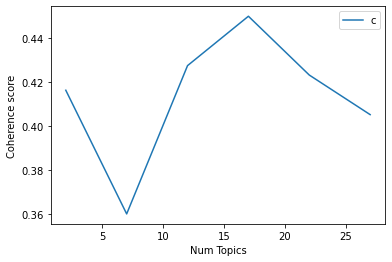

In [30]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [31]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.4162
index: 1 | Num Topics = 7  has Coherence Value of 0.3602
index: 2 | Num Topics = 12  has Coherence Value of 0.4273
index: 3 | Num Topics = 17  has Coherence Value of 0.4497
index: 4 | Num Topics = 22  has Coherence Value of 0.4231
index: 5 | Num Topics = 27  has Coherence Value of 0.4052


In [165]:
# Select optimal number of topics
optimal_model_us = model_list_us[3]

In [166]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us = pyLDAvis.gensim_models.prepare(optimal_model_us, corpus_us, id2word_us)

In [167]:
print("pyLDAVis for overall us topics:")
vis_us

pyLDAVis for overall us topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.193140  0.167641       1        1  23.187697
11    -0.192273 -0.056037       2        1  13.203505
16    -0.223165 -0.013525       3        1  12.045970
10    -0.211234 -0.156460       4        1  11.633953
4     -0.205718 -0.014981       5        1  11.284269
14    -0.220304  0.006403       6        1   8.616192
7     -0.131432  0.078622       7        1   5.457316
1      0.030572  0.247888       8        1   3.050148
12    -0.056308 -0.120890       9        1   2.914838
3      0.113978  0.136071      10        1   2.344818
15     0.015136 -0.175239      11        1   2.319657
9      0.039420  0.040671      12        1   2.254601
0      0.250763 -0.029480      13        1   0.458177
13     0.247898 -0.038593      14        1   0.395805
8      0.249439 -0.024588      15        1   0.351259
2      0.242320 -0.022475      16        1   0.255282
5      0.244049 -0.025029      17        1   0.226514, topic_info=          Term         Freq        Total Category  logprob  loglift
110    account  1204.000000  1204.000000  Default  30.0000  30.0000
326    comment   682.000000   682.000000  Default  29.0000  29.0000
43        post  2346.000000  2346.000000  Default  28.0000  28.0000
1          app  2087.000000  2087.000000  Default  27.0000  27.0000
513      group   578.000000   578.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2548    square     0.850086     4.045214  Topic17  -5.8079   4.5302
3310      body     0.686256    22.019307  Topic17  -6.0220   2.6217
4504  director     0.381360     1.998323  Topic17  -6.6095   4.4338
1748      deny     0.379338    43.378421  Topic17  -6.6148   1.3508
658   commerce     0.332897     5.291169  Topic17  -6.7454   3.3242

[1037 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
302       1  0.110470        able
302       3  0.320363        able
302       4  0.173990        able
302       5  0.035903        able
302       6  0.212655        able
...     ...       ...         ...
337       6  0.251533        year
337       7  0.098640        year
337      12  0.075624        year
1533      4  0.952964          yr
2239     13  0.826252  zuckerburg

[1854 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 12, 17, 11, 5, 15, 8, 2, 13, 4, 16, 10, 1, 14, 9, 3, 6])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [35]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_us_score1 = facebook_ios_us_review_YearMonth_score1.review.values.tolist()
review_words_us_score1 = list(sent_to_words(review_us_score1))
print(review_words_us_score1[:1])

[['facebook', 'used', 'to', 'be', 'so', 'great', 'remember', 'when', 'it', 'was', 'just', 'social', 'networking', 'site', 'then', 'it', 'became', 'media', 'consumption', 'site', 'which', 'was', 'ok', 'now', 'facebook', 'has', 'become', 'revenue', 'generating', 'machine', 'and', 'it', 'shows', 'placing', 'ads', 'that', 'cannot', 'be', 'skipped', 'during', 'the', 'climax', 'of', 'video', 'is', 'very', 'frustrating', 'and', 'stupid', 'the', 'new', 'slide', 'to', 'open', 'camera', 'look', 'this', 'isn', 'instagram', 'ok', 'it', 'facebook', 'don', 'take', 'picture', 'often', 'enough', 'to', 'want', 'to', 'swipe', 'my', 'finger', 'to', 'open', 'camera', 'app', 'of', 'the', 'times', 'that', 'have', 'opened', 'the', 'camera', 'feature', 'on', 'facebook', 'one', 'was', 'intentional', 'the', 'intent', 'was', 'to', 'find', 'way', 'to', 'disable', 'it', 'facebook', 'is', 'going', 'downhill', 'as', 'is', 'our', 'country', 'we', 'have', 'become', 'too', 'inclined', 'to', 'post', 'our', 'lives', 'on'

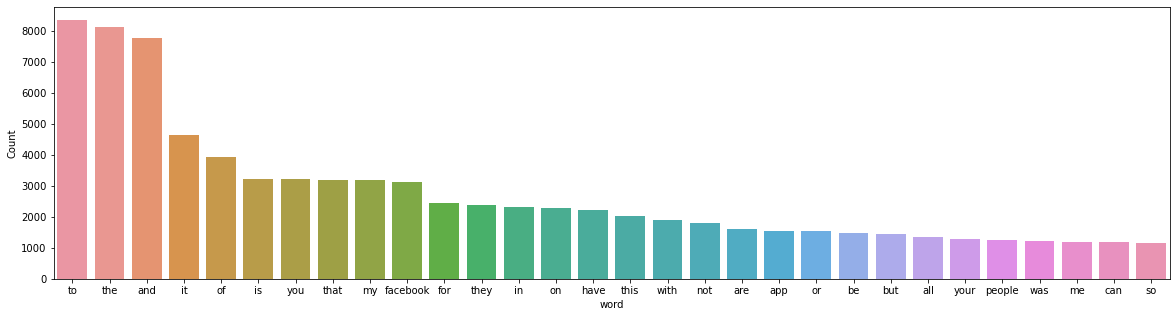

In [36]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1))

In [37]:
# Clean text
review_us_ready_score1 = process_words(review_words_us_score1)  # processed Text Data! - move to each section


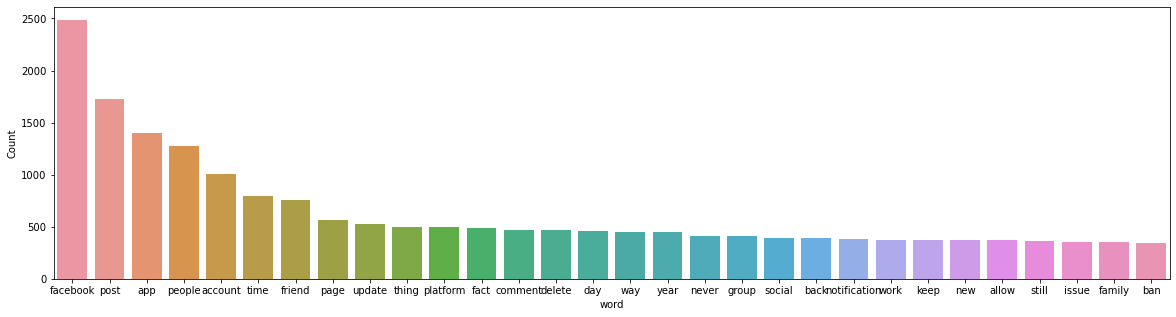

In [38]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1))


In [39]:
# Create Dictionary
id2word_us_score1 = corpora.Dictionary(review_us_ready_score1)

2021-10-16 18:49:19,170 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:49:19,754 [INFO] gensim.corpora.dictionary - built Dictionary(6636 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 1502 documents (total 92654 corpus positions)
2021-10-16 18:49:19,756 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(6636 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 1502 documents (total 92654 corpus positions)", 'datetime': '2021-10-16T18:49:19.756043', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [40]:
# Create Corpus: Term Document Frequency
corpus_us_score1 = [id2word_us_score1.doc2bow(text) for text in review_us_ready_score1]

In [41]:
# Training LDA model
model_list_us_score1, coherence_values_us_score1 = compute_coherence_values(dictionary=id2word_us_score1, corpus=corpus_us_score1, 
                                                              texts=review_us_ready_score1, limit=30, start=2, step=5)


2021-10-16 18:49:20,093 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:49:20,103 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:49:20,116 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:49:20,124 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1502 documents, updating model once every 1000 documents, evaluating perplexity every 1502 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:49:20,125 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1502
2021-10-16 18:49:23,664 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:49:23,671 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.021*"post" + 0.019*"facebook" + 0.015*"app" + 0.012*"people" + 0.008*"friend" + 0.007*"time" + 0.006*"group" + 0.006*"delete" + 0.006*"back

2021-10-16 18:49:49,394 [INFO] gensim.models.ldamodel - -7.156 per-word bound, 142.6 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:49:49,395 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1502/1502
2021-10-16 18:49:50,761 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:49:50,764 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"facebook" + 0.021*"people" + 0.017*"post" + 0.010*"fact" + 0.010*"platform" + 0.007*"censor" + 0.007*"speech" + 0.007*"ban" + 0.007*"allow" + 0.006*"social"
2021-10-16 18:49:50,766 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"facebook" + 0.020*"app" + 0.017*"account" + 0.016*"post" + 0.011*"time" + 0.009*"people" + 0.009*"friend" + 0.008*"page" + 0.007*"update" + 0.006*"comment"
2021-10-16 18:49:50,767 [INFO] gensim.models.ldamodel - topic diff=0.243606, rho=0.392172
2021-10-16 18:49:50,770 [INFO] gensim.models.ldamo

2021-10-16 18:50:14,102 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.021*"app" + 0.018*"post" + 0.017*"account" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"people" + 0.006*"notification"
2021-10-16 18:50:14,107 [INFO] gensim.models.ldamodel - topic diff=0.171046, rho=0.294858
2021-10-16 18:50:15,780 [INFO] gensim.models.ldamodel - -7.142 per-word bound, 141.3 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:50:15,782 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1502/1502
2021-10-16 18:50:17,031 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:50:17,047 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"censor" + 0.007*"ban" + 0.007*"speech" + 0.007*"social" + 0.007*"allow"
2021-10-16 18:50:17,049 [INFO] gensim.models.

2021-10-16 18:50:37,136 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1502
2021-10-16 18:50:39,776 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:50:39,780 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"fact" + 0.010*"platform" + 0.007*"censor" + 0.007*"social" + 0.007*"speech" + 0.007*"ban" + 0.007*"allow"
2021-10-16 18:50:39,782 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.022*"app" + 0.018*"post" + 0.017*"account" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"people" + 0.006*"notification"
2021-10-16 18:50:39,784 [INFO] gensim.models.ldamodel - topic diff=0.136346, rho=0.246168
2021-10-16 18:50:42,030 [INFO] gensim.models.ldamodel - -7.139 per-word bound, 140.9 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:50:42,044 [INFO] gensim.model

2021-10-16 18:51:01,602 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.022*"app" + 0.018*"account" + 0.017*"post" + 0.011*"time" + 0.009*"page" + 0.008*"update" + 0.008*"friend" + 0.007*"people" + 0.007*"phone"
2021-10-16 18:51:01,603 [INFO] gensim.models.ldamodel - topic diff=0.117971, rho=0.220852
2021-10-16 18:51:01,605 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1502
2021-10-16 18:51:03,658 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:51:03,662 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"fact" + 0.010*"platform" + 0.007*"censor" + 0.007*"social" + 0.007*"ban" + 0.007*"speech" + 0.007*"allow"
2021-10-16 18:51:03,664 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.022*"app" + 0.018*"post" + 0.017*"account" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"peopl

2021-10-16 18:51:23,532 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1502/1502
2021-10-16 18:51:24,464 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:51:24,468 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"censor" + 0.007*"ban" + 0.007*"social" + 0.007*"speech" + 0.007*"allow"
2021-10-16 18:51:24,472 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.022*"app" + 0.018*"account" + 0.017*"post" + 0.011*"time" + 0.009*"page" + 0.008*"update" + 0.008*"friend" + 0.007*"people" + 0.007*"phone"
2021-10-16 18:51:24,474 [INFO] gensim.models.ldamodel - topic diff=0.104308, rho=0.198022
2021-10-16 18:51:24,476 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1502
2021-10-16 18:51:26,513 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 docume

2021-10-16 18:51:46,535 [INFO] gensim.models.ldamodel - topic diff=0.095369, rho=0.181066
2021-10-16 18:51:47,935 [INFO] gensim.models.ldamodel - -7.135 per-word bound, 140.5 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:51:47,936 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1502/1502
2021-10-16 18:51:48,864 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:51:48,874 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"social" + 0.007*"ban" + 0.007*"censor" + 0.007*"friend" + 0.007*"speech"
2021-10-16 18:51:48,879 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.022*"app" + 0.018*"account" + 0.017*"post" + 0.011*"time" + 0.009*"page" + 0.008*"update" + 0.008*"friend" + 0.007*"people" + 0.007*"phone"
2021-10-16 18:51:48,881 [INFO] gensim.models.ldamo

2021-10-16 18:52:08,281 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"social" + 0.007*"censor" + 0.007*"ban" + 0.007*"friend" + 0.007*"speech"
2021-10-16 18:52:08,282 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"post" + 0.017*"account" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"people" + 0.006*"phone"
2021-10-16 18:52:08,283 [INFO] gensim.models.ldamodel - topic diff=0.087593, rho=0.167832
2021-10-16 18:52:09,682 [INFO] gensim.models.ldamodel - -7.134 per-word bound, 140.5 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:52:09,683 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1502/1502
2021-10-16 18:52:10,670 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:52:10,676 [INFO] gensim.models.ldamo

2021-10-16 18:52:29,400 [INFO] gensim.models.ldamodel - topic diff=0.081961, rho=0.159107
2021-10-16 18:52:29,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1502
2021-10-16 18:52:31,282 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:52:31,285 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"social" + 0.007*"censor" + 0.007*"ban" + 0.007*"friend" + 0.007*"speech"
2021-10-16 18:52:31,290 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"post" + 0.017*"account" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"people" + 0.006*"phone"
2021-10-16 18:52:31,292 [INFO] gensim.models.ldamodel - topic diff=0.081420, rho=0.157131
2021-10-16 18:52:32,663 [INFO] gensim.models.ldamodel - -7.133 per-word bound, 140.4 perplexity estimate based on a held-out 

2021-10-16 18:52:50,930 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"social" + 0.007*"ban" + 0.007*"censor" + 0.007*"friend" + 0.007*"speech"
2021-10-16 18:52:50,932 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"account" + 0.017*"post" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"people" + 0.007*"phone"
2021-10-16 18:52:50,933 [INFO] gensim.models.ldamodel - topic diff=0.076821, rho=0.149903
2021-10-16 18:52:50,934 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1502
2021-10-16 18:52:52,773 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:52:52,777 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"social" + 0.007*"censor" + 0.007*"ban" + 0.007*"f

2021-10-16 18:53:10,944 [INFO] gensim.models.ldamodel - topic diff=0.072933, rho=0.142131
2021-10-16 18:53:12,347 [INFO] gensim.models.ldamodel - -7.133 per-word bound, 140.3 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:53:12,349 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1502/1502
2021-10-16 18:53:13,257 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:53:13,261 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"people" + 0.016*"post" + 0.010*"platform" + 0.010*"fact" + 0.007*"social" + 0.007*"ban" + 0.007*"censor" + 0.007*"friend" + 0.007*"speech"
2021-10-16 18:53:13,263 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.022*"app" + 0.018*"account" + 0.017*"post" + 0.011*"time" + 0.009*"page" + 0.009*"update" + 0.008*"friend" + 0.007*"people" + 0.007*"phone"
2021-10-16 18:53:13,270 [INFO] gensim.models.ldamo

2021-10-16 18:53:49,536 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"facebook" + 0.016*"account" + 0.014*"app" + 0.010*"platform" + 0.009*"people" + 0.008*"post" + 0.008*"time" + 0.007*"social" + 0.007*"fact" + 0.006*"user"
2021-10-16 18:53:49,539 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"post" + 0.021*"facebook" + 0.019*"people" + 0.009*"friend" + 0.008*"comment" + 0.008*"app" + 0.008*"time" + 0.007*"thing" + 0.007*"ban" + 0.007*"account"
2021-10-16 18:53:49,544 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.031*"post" + 0.029*"facebook" + 0.014*"friend" + 0.010*"app" + 0.009*"people" + 0.009*"delete" + 0.009*"account" + 0.008*"time" + 0.007*"day" + 0.007*"year"
2021-10-16 18:53:49,547 [INFO] gensim.models.ldamodel - topic diff=1.150893, rho=0.707107
2021-10-16 18:53:49,550 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1502
2021-10-16 18:53:52,407 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1

2021-10-16 18:54:04,184 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"post" + 0.022*"facebook" + 0.021*"people" + 0.011*"friend" + 0.008*"ban" + 0.008*"comment" + 0.007*"thing" + 0.007*"time" + 0.007*"fact" + 0.006*"allow"
2021-10-16 18:54:04,185 [INFO] gensim.models.ldamodel - topic diff=0.287464, rho=0.426324
2021-10-16 18:54:06,411 [INFO] gensim.models.ldamodel - -7.337 per-word bound, 161.7 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:54:06,412 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1502/1502
2021-10-16 18:54:07,804 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:54:07,812 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"facebook" + 0.014*"account" + 0.012*"platform" + 0.010*"social" + 0.009*"app" + 0.009*"people" + 0.008*"medium" + 0.008*"user" + 0.007*"fact" + 0.007*"way"
2021-10-16 18:54:07,814 [INFO] gensim.models.ldamodel 

2021-10-16 18:54:19,161 [INFO] gensim.models.ldamodel - topic diff=0.180758, rho=0.365100
2021-10-16 18:54:19,162 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/1502
2021-10-16 18:54:21,395 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:54:21,401 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"facebook" + 0.013*"platform" + 0.012*"account" + 0.011*"social" + 0.009*"medium" + 0.009*"people" + 0.008*"user" + 0.008*"app" + 0.007*"way" + 0.007*"fact"
2021-10-16 18:54:21,403 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.020*"facebook" + 0.017*"notification" + 0.016*"comment" + 0.014*"friend" + 0.013*"group" + 0.013*"app" + 0.010*"time" + 0.008*"update" + 0.008*"delete"
2021-10-16 18:54:21,405 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"people" + 0.019*"fact" + 0.013*"censor" + 0.012*"truth" + 0.011*"political" + 0.010*"opinion" + 0.009*"post" + 0.009*"facebook" +

2021-10-16 18:54:36,163 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:54:36,173 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.018*"facebook" + 0.018*"comment" + 0.016*"notification" + 0.014*"group" + 0.013*"friend" + 0.013*"app" + 0.011*"time" + 0.008*"page" + 0.008*"day"
2021-10-16 18:54:36,176 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"people" + 0.021*"fact" + 0.015*"truth" + 0.013*"censor" + 0.010*"post" + 0.010*"political" + 0.010*"facebook" + 0.010*"opinion" + 0.010*"information" + 0.009*"checker"
2021-10-16 18:54:36,179 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"account" + 0.026*"people" + 0.020*"page" + 0.018*"facebook" + 0.016*"business" + 0.012*"name" + 0.011*"hack" + 0.010*"profile" + 0.008*"report" + 0.007*"personal"
2021-10-16 18:54:36,182 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"post" + 0.025*"facebook" + 0.025*"people" + 0.011*"friend" + 0.011

2021-10-16 18:54:47,535 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"post" + 0.019*"notification" + 0.017*"facebook" + 0.017*"comment" + 0.014*"app" + 0.014*"group" + 0.013*"friend" + 0.011*"time" + 0.010*"update" + 0.009*"page"
2021-10-16 18:54:47,541 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"post" + 0.026*"facebook" + 0.025*"people" + 0.012*"friend" + 0.010*"ban" + 0.008*"thing" + 0.007*"fact" + 0.007*"allow" + 0.007*"time" + 0.007*"platform"
2021-10-16 18:54:47,544 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"people" + 0.022*"fact" + 0.013*"censor" + 0.013*"truth" + 0.011*"political" + 0.011*"post" + 0.010*"opinion" + 0.010*"information" + 0.009*"facebook" + 0.009*"checker"
2021-10-16 18:54:47,548 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"group" + 0.008*"speech" + 0.006*"doctor" + 0.006*"anti" + 0.005*"racist" + 0.005*"freedom" + 0.005*"virus" + 0.005*"rule" + 0.004*"law" + 0.004*"drug"
2021-10-16 18:54:47,550 [INFO] gensim.model

2021-10-16 18:55:00,328 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.026*"account" + 0.025*"people" + 0.021*"page" + 0.017*"business" + 0.015*"facebook" + 0.013*"name" + 0.012*"profile" + 0.011*"hack" + 0.008*"report" + 0.008*"personal"
2021-10-16 18:55:00,330 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"facebook" + 0.014*"platform" + 0.012*"social" + 0.010*"medium" + 0.009*"people" + 0.009*"user" + 0.008*"company" + 0.008*"app" + 0.008*"account" + 0.007*"way"
2021-10-16 18:55:00,332 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"facebook" + 0.026*"post" + 0.025*"people" + 0.011*"friend" + 0.011*"ban" + 0.008*"thing" + 0.008*"platform" + 0.008*"time" + 0.007*"comment" + 0.007*"allow"
2021-10-16 18:55:00,334 [INFO] gensim.models.ldamodel - topic diff=0.097171, rho=0.253984
2021-10-16 18:55:00,336 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1502
2021-10-16 18:55:02,443 [INFO] gensim.models.ldamodel - merging changes from 1000 document

2021-10-16 18:55:13,163 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.026*"people" + 0.024*"account" + 0.021*"page" + 0.017*"business" + 0.014*"facebook" + 0.013*"name" + 0.012*"profile" + 0.011*"hack" + 0.009*"report" + 0.008*"person"
2021-10-16 18:55:13,165 [INFO] gensim.models.ldamodel - topic diff=0.088649, rho=0.232483
2021-10-16 18:55:14,663 [INFO] gensim.models.ldamodel - -7.227 per-word bound, 149.8 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:55:14,664 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1502/1502
2021-10-16 18:55:15,678 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:55:15,684 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.045*"post" + 0.017*"comment" + 0.017*"notification" + 0.015*"app" + 0.015*"facebook" + 0.014*"group" + 0.012*"friend" + 0.011*"time" + 0.011*"update" + 0.010*"marketplace"
2021-10-16 18:55:15,686 [INFO] gen

2021-10-16 18:55:26,044 [INFO] gensim.models.ldamodel - topic diff=0.080502, rho=0.220852
2021-10-16 18:55:26,047 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1502
2021-10-16 18:55:28,159 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:55:28,165 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"people" + 0.022*"account" + 0.022*"page" + 0.017*"business" + 0.013*"name" + 0.013*"profile" + 0.013*"facebook" + 0.010*"hack" + 0.009*"report" + 0.008*"person"
2021-10-16 18:55:28,167 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.007*"doctor" + 0.006*"group" + 0.005*"virus" + 0.005*"anti" + 0.005*"racist" + 0.005*"speech" + 0.005*"law" + 0.005*"rule" + 0.004*"freedom" + 0.004*"drug"
2021-10-16 18:55:28,168 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"app" + 0.032*"facebook" + 0.030*"account" + 0.014*"time" + 0.014*"phone" + 0.012*"update" + 0.010*"back" + 0.009*"change" + 0.009*"log

2021-10-16 18:55:40,781 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:55:40,786 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"facebook" + 0.014*"platform" + 0.012*"social" + 0.010*"medium" + 0.009*"user" + 0.009*"company" + 0.009*"people" + 0.008*"app" + 0.007*"way" + 0.006*"speech"
2021-10-16 18:55:40,788 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.025*"people" + 0.025*"fact" + 0.015*"censor" + 0.014*"truth" + 0.013*"post" + 0.011*"checker" + 0.011*"opinion" + 0.011*"information" + 0.010*"political" + 0.010*"facebook"
2021-10-16 18:55:40,789 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"facebook" + 0.026*"people" + 0.026*"post" + 0.012*"ban" + 0.011*"friend" + 0.008*"thing" + 0.008*"platform" + 0.008*"time" + 0.007*"comment" + 0.007*"allow"
2021-10-16 18:55:40,791 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.017*"notification" + 0.017*"comment" + 0.017*"app" + 0.014*"f

2021-10-16 18:55:51,626 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"facebook" + 0.033*"app" + 0.031*"account" + 0.014*"time" + 0.014*"phone" + 0.011*"update" + 0.010*"back" + 0.009*"help" + 0.009*"change" + 0.009*"log"
2021-10-16 18:55:51,630 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"people" + 0.022*"page" + 0.020*"account" + 0.017*"business" + 0.014*"name" + 0.013*"profile" + 0.011*"facebook" + 0.010*"hack" + 0.009*"report" + 0.008*"person"
2021-10-16 18:55:51,633 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.024*"people" + 0.015*"censor" + 0.013*"truth" + 0.013*"post" + 0.012*"opinion" + 0.011*"checker" + 0.011*"political" + 0.010*"information" + 0.010*"facebook"
2021-10-16 18:55:51,640 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.018*"notification" + 0.018*"app" + 0.016*"comment" + 0.014*"facebook" + 0.013*"group" + 0.013*"update" + 0.012*"friend" + 0.012*"time" + 0.010*"page"
2021-10-16 18:55:51,643 [INFO] gensi

2021-10-16 18:56:05,542 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.018*"app" + 0.017*"notification" + 0.017*"comment" + 0.014*"group" + 0.013*"facebook" + 0.013*"update" + 0.012*"time" + 0.012*"friend" + 0.010*"page"
2021-10-16 18:56:05,543 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"people" + 0.022*"page" + 0.020*"account" + 0.018*"business" + 0.013*"name" + 0.013*"profile" + 0.010*"facebook" + 0.010*"hack" + 0.009*"report" + 0.008*"personal"
2021-10-16 18:56:05,545 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.025*"people" + 0.015*"censor" + 0.014*"truth" + 0.013*"post" + 0.012*"checker" + 0.011*"opinion" + 0.011*"information" + 0.010*"facebook" + 0.010*"political"
2021-10-16 18:56:05,547 [INFO] gensim.models.ldamodel - topic diff=0.065932, rho=0.187311
2021-10-16 18:56:05,548 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1502
2021-10-16 18:56:08,162 [INFO] gensim.models.ldamodel - merging changes from 1

2021-10-16 18:56:20,320 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.007*"doctor" + 0.006*"virus" + 0.005*"racist" + 0.005*"anti" + 0.005*"law" + 0.004*"black" + 0.004*"rule" + 0.004*"drug" + 0.004*"terrorist" + 0.004*"domestic"
2021-10-16 18:56:20,321 [INFO] gensim.models.ldamodel - topic diff=0.063354, rho=0.178169
2021-10-16 18:56:21,689 [INFO] gensim.models.ldamodel - -7.212 per-word bound, 148.3 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:56:21,690 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1502/1502
2021-10-16 18:56:22,682 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:56:22,688 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.044*"post" + 0.019*"app" + 0.017*"notification" + 0.017*"comment" + 0.014*"group" + 0.013*"facebook" + 0.013*"update" + 0.012*"time" + 0.012*"friend" + 0.010*"page"
2021-10-16 18:56:22,690 [INFO] gensim.models.ld

2021-10-16 18:56:31,826 [INFO] gensim.models.ldamodel - topic diff=0.059933, rho=0.172769
2021-10-16 18:56:31,828 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1502
2021-10-16 18:56:33,782 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:56:33,788 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"fact" + 0.024*"people" + 0.016*"censor" + 0.013*"truth" + 0.013*"post" + 0.012*"opinion" + 0.012*"checker" + 0.011*"political" + 0.011*"information" + 0.010*"facebook"
2021-10-16 18:56:33,790 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"people" + 0.023*"page" + 0.017*"business" + 0.017*"account" + 0.014*"name" + 0.014*"profile" + 0.009*"report" + 0.009*"hack" + 0.008*"facebook" + 0.008*"person"
2021-10-16 18:56:33,792 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"doctor" + 0.006*"virus" + 0.005*"racist" + 0.005*"anti" + 0.005*"law" + 0.004*"black" + 0.004*"drug" + 0.004*"rule" +

2021-10-16 18:56:44,768 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:56:44,779 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"doctor" + 0.006*"racist" + 0.006*"virus" + 0.005*"law" + 0.005*"anti" + 0.005*"black" + 0.005*"drug" + 0.005*"terrorist" + 0.004*"rule" + 0.004*"culture"
2021-10-16 18:56:44,780 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.020*"app" + 0.017*"notification" + 0.016*"comment" + 0.014*"update" + 0.013*"group" + 0.013*"facebook" + 0.012*"time" + 0.011*"friend" + 0.010*"page"
2021-10-16 18:56:44,782 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"account" + 0.034*"facebook" + 0.031*"app" + 0.014*"phone" + 0.014*"time" + 0.010*"back" + 0.009*"help" + 0.009*"update" + 0.009*"log" + 0.009*"change"
2021-10-16 18:56:44,784 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.024*"people" + 0.015*"censor" + 0.014*"truth" + 0.014*"post" + 0.012*"checker" 

2021-10-16 18:56:54,923 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.027*"facebook" + 0.026*"people" + 0.026*"post" + 0.012*"friend" + 0.012*"ban" + 0.008*"thing" + 0.007*"platform" + 0.007*"allow" + 0.007*"time" + 0.007*"comment"
2021-10-16 18:56:54,925 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"doctor" + 0.006*"virus" + 0.005*"racist" + 0.005*"law" + 0.005*"anti" + 0.004*"black" + 0.004*"drug" + 0.004*"rule" + 0.004*"domestic" + 0.004*"terrorist"
2021-10-16 18:56:54,926 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.021*"app" + 0.018*"notification" + 0.016*"comment" + 0.015*"update" + 0.013*"group" + 0.013*"facebook" + 0.012*"time" + 0.012*"friend" + 0.011*"page"
2021-10-16 18:56:54,928 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.034*"account" + 0.031*"app" + 0.014*"phone" + 0.014*"time" + 0.010*"back" + 0.009*"help" + 0.009*"update" + 0.009*"log" + 0.009*"change"
2021-10-16 18:56:54,929 [INFO] gensim.models.ldamodel

2021-10-16 18:57:06,725 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"fact" + 0.024*"people" + 0.016*"censor" + 0.014*"truth" + 0.014*"post" + 0.012*"checker" + 0.012*"opinion" + 0.011*"facebook" + 0.011*"information" + 0.011*"political"
2021-10-16 18:57:06,733 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"people" + 0.023*"page" + 0.017*"business" + 0.015*"account" + 0.014*"name" + 0.013*"profile" + 0.009*"report" + 0.008*"personal" + 0.008*"person" + 0.008*"hack"
2021-10-16 18:57:06,737 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.021*"app" + 0.017*"notification" + 0.016*"comment" + 0.015*"update" + 0.013*"group" + 0.013*"facebook" + 0.012*"time" + 0.011*"friend" + 0.011*"page"
2021-10-16 18:57:06,742 [INFO] gensim.models.ldamodel - topic diff=0.052640, rho=0.155226
2021-10-16 18:57:06,747 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1502
2021-10-16 18:57:09,912 [INFO] gensim.models.ldamodel - merging changes from 100

2021-10-16 18:57:19,144 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"fact" + 0.024*"people" + 0.016*"censor" + 0.014*"post" + 0.013*"truth" + 0.012*"opinion" + 0.012*"checker" + 0.011*"political" + 0.011*"information" + 0.011*"facebook"
2021-10-16 18:57:19,147 [INFO] gensim.models.ldamodel - topic diff=0.051420, rho=0.149903
2021-10-16 18:57:20,499 [INFO] gensim.models.ldamodel - -7.205 per-word bound, 147.6 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:57:20,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1502/1502
2021-10-16 18:57:21,457 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:57:21,463 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"people" + 0.023*"page" + 0.017*"business" + 0.014*"name" + 0.013*"account" + 0.013*"profile" + 0.009*"report" + 0.008*"personal" + 0.008*"person" + 0.008*"hack"
2021-10-16 18:57:21,465 [INFO] ge

2021-10-16 18:57:30,052 [INFO] gensim.models.ldamodel - topic diff=0.049300, rho=0.146644
2021-10-16 18:57:30,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1502
2021-10-16 18:57:32,545 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:57:32,552 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"people" + 0.023*"page" + 0.017*"business" + 0.014*"name" + 0.013*"profile" + 0.012*"account" + 0.009*"report" + 0.008*"person" + 0.008*"personal" + 0.007*"hack"
2021-10-16 18:57:32,554 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"account" + 0.035*"facebook" + 0.030*"app" + 0.014*"phone" + 0.014*"time" + 0.010*"back" + 0.009*"help" + 0.009*"log" + 0.009*"change" + 0.009*"email"
2021-10-16 18:57:32,557 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"facebook" + 0.015*"platform" + 0.013*"social" + 0.011*"medium" + 0.010*"user" + 0.009*"company" + 0.008*"people" + 0.007*"way" + 0.007*

2021-10-16 18:57:44,216 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:57:44,235 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.008*"doctor" + 0.006*"virus" + 0.006*"racist" + 0.005*"law" + 0.005*"black" + 0.005*"anti" + 0.005*"drug" + 0.004*"terrorist" + 0.004*"culture" + 0.004*"indigenous"
2021-10-16 18:57:44,237 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.043*"post" + 0.022*"app" + 0.017*"notification" + 0.016*"comment" + 0.016*"update" + 0.013*"group" + 0.012*"time" + 0.012*"facebook" + 0.011*"friend" + 0.011*"page"
2021-10-16 18:57:44,240 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"account" + 0.035*"facebook" + 0.029*"app" + 0.014*"phone" + 0.013*"time" + 0.010*"help" + 0.009*"back" + 0.009*"log" + 0.009*"email" + 0.009*"change"
2021-10-16 18:57:44,243 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.027*"fact" + 0.024*"people" + 0.016*"censor" + 0.014*"truth" + 0.014*"post" + 0.012*"chec

2021-10-16 18:58:16,423 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:58:16,547 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1512 virtual documents
2021-10-16 18:58:17,810 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.08333333333333333
2021-10-16 18:58:17,811 [INFO] gensim.models.ldamodel - using symmetric eta at 0.08333333333333333
2021-10-16 18:58:17,815 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:58:17,829 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 12 topics, 50 passes over the supplied corpus of 1502 documents, updating model once every 1000 documents, evaluating perplexity every 1502 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:58:17,831 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1502
2021-10-16 18:58:21,410 [INFO] gensim.models.ldamodel - mergi

2021-10-16 18:58:36,863 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.010*"facebook" + 0.007*"ip" + 0.007*"filter" + 0.006*"ad" + 0.005*"information" + 0.005*"harmless" + 0.004*"car" + 0.004*"exposure" + 0.004*"address" + 0.004*"card"
2021-10-16 18:58:36,864 [INFO] gensim.models.ldamodel - topic diff=0.371740, rho=0.471300
2021-10-16 18:58:38,696 [INFO] gensim.models.ldamodel - -8.041 per-word bound, 263.4 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:58:38,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1502/1502
2021-10-16 18:58:40,059 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:58:40,067 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"facebook" + 0.034*"account" + 0.012*"app" + 0.010*"user" + 0.008*"email" + 0.008*"time" + 0.007*"year" + 0.007*"way" + 0.007*"help" + 0.006*"give"
2021-10-16 18:58:40,068 [INFO] gensim.models.ldamodel - 

2021-10-16 18:58:51,577 [INFO] gensim.models.ldamodel - topic diff=0.189765, rho=0.392172
2021-10-16 18:58:51,579 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1502
2021-10-16 18:58:54,174 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:58:54,182 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.026*"people" + 0.018*"censor" + 0.016*"speech" + 0.016*"fact" + 0.015*"facebook" + 0.015*"platform" + 0.014*"free" + 0.011*"freedom" + 0.011*"post" + 0.011*"agree"
2021-10-16 18:58:54,184 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.050*"app" + 0.026*"facebook" + 0.025*"update" + 0.018*"time" + 0.015*"phone" + 0.012*"notification" + 0.011*"page" + 0.011*"fix" + 0.011*"back" + 0.011*"post"
2021-10-16 18:58:54,185 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"people" + 0.025*"page" + 0.020*"facebook" + 0.013*"account" + 0.009*"racist" + 0.009*"person" + 0.008*"app" + 0.008*"business" + 0.00

2021-10-16 18:59:06,306 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:59:06,316 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.027*"people" + 0.019*"speech" + 0.019*"censor" + 0.017*"free" + 0.016*"fact" + 0.015*"facebook" + 0.014*"platform" + 0.012*"agree" + 0.012*"freedom" + 0.011*"post"
2021-10-16 18:59:06,319 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.045*"account" + 0.039*"facebook" + 0.010*"email" + 0.010*"user" + 0.009*"app" + 0.009*"year" + 0.009*"help" + 0.008*"way" + 0.008*"business" + 0.008*"time"
2021-10-16 18:59:06,322 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.020*"people" + 0.015*"palestinian" + 0.009*"truth" + 0.008*"birthday" + 0.007*"cleansing" + 0.007*"app" + 0.007*"land" + 0.006*"native" + 0.006*"become" + 0.006*"occupation"
2021-10-16 18:59:06,324 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.011*"harmless" + 0.010*"partly" + 0.010*"ip" + 0.009*"provider" + 0.008*"exposu

2021-10-16 18:59:19,586 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.055*"post" + 0.022*"facebook" + 0.021*"group" + 0.018*"friend" + 0.017*"comment" + 0.011*"delete" + 0.010*"notification" + 0.009*"time" + 0.008*"app" + 0.008*"show"
2021-10-16 18:59:19,588 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.010*"ip" + 0.009*"harmless" + 0.008*"provider" + 0.008*"partly" + 0.007*"credit" + 0.007*"tax" + 0.006*"exposure" + 0.006*"shipping" + 0.005*"font" + 0.005*"card"
2021-10-16 18:59:19,590 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"fact" + 0.025*"facebook" + 0.018*"post" + 0.017*"medium" + 0.016*"opinion" + 0.016*"people" + 0.016*"social" + 0.014*"platform" + 0.013*"censor" + 0.011*"political"
2021-10-16 18:59:19,592 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.091*"marketplace" + 0.043*"item" + 0.030*"list" + 0.021*"search" + 0.020*"filter" + 0.012*"car" + 0.011*"vehicle" + 0.010*"feature" + 0.009*"quote" + 0.009*"crash"
2021-10-16 18:59:19,595 [INFO] gen

2021-10-16 18:59:31,525 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.028*"facebook" + 0.028*"people" + 0.021*"post" + 0.013*"ban" + 0.010*"friend" + 0.009*"comment" + 0.008*"thing" + 0.008*"standard" + 0.008*"community" + 0.008*"time"
2021-10-16 18:59:31,528 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.056*"post" + 0.022*"group" + 0.022*"facebook" + 0.019*"comment" + 0.018*"friend" + 0.010*"delete" + 0.010*"time" + 0.009*"notification" + 0.008*"show" + 0.008*"people"
2021-10-16 18:59:31,534 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"post" + 0.023*"facebook" + 0.013*"business" + 0.011*"ad" + 0.011*"speech" + 0.011*"app" + 0.010*"page" + 0.009*"spam" + 0.009*"time" + 0.008*"check"
2021-10-16 18:59:31,535 [INFO] gensim.models.ldamodel - topic diff=0.076106, rho=0.262595
2021-10-16 18:59:31,538 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1502
2021-10-16 18:59:33,563 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into

2021-10-16 18:59:42,532 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"post" + 0.022*"group" + 0.021*"facebook" + 0.020*"friend" + 0.018*"comment" + 0.010*"delete" + 0.010*"time" + 0.010*"notification" + 0.008*"show" + 0.008*"page"
2021-10-16 18:59:42,535 [INFO] gensim.models.ldamodel - topic diff=0.063567, rho=0.239032
2021-10-16 18:59:44,129 [INFO] gensim.models.ldamodel - -7.678 per-word bound, 204.8 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 18:59:44,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1502/1502
2021-10-16 18:59:45,064 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 18:59:45,072 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"people" + 0.023*"page" + 0.014*"racist" + 0.011*"white" + 0.010*"facebook" + 0.008*"group" + 0.008*"block" + 0.007*"person" + 0.007*"racism" + 0.007*"report"
2021-10-16 18:59:45,077 [INFO] gensim.model

2021-10-16 18:59:56,139 [INFO] gensim.models.ldamodel - topic diff=0.058127, rho=0.226444
2021-10-16 18:59:56,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/1502
2021-10-16 18:59:58,328 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 18:59:58,336 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.016*"people" + 0.014*"palestinian" + 0.011*"birthday" + 0.009*"truth" + 0.008*"land" + 0.006*"native" + 0.006*"cleansing" + 0.006*"terrorist" + 0.006*"ground" + 0.006*"israeli"
2021-10-16 18:59:58,339 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.057*"app" + 0.028*"update" + 0.022*"facebook" + 0.018*"time" + 0.014*"notification" + 0.014*"phone" + 0.012*"page" + 0.012*"fix" + 0.011*"post" + 0.011*"work"
2021-10-16 18:59:58,342 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.128*"marketplace" + 0.055*"item" + 0.028*"list" + 0.021*"filter" + 0.021*"search" + 0.015*"car" + 0.010*"vehicle" + 0.010*"bu

2021-10-16 19:00:11,454 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:00:11,462 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"people" + 0.029*"facebook" + 0.021*"post" + 0.013*"ban" + 0.010*"friend" + 0.009*"comment" + 0.009*"standard" + 0.008*"community" + 0.008*"thing" + 0.008*"time"
2021-10-16 19:00:11,464 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.024*"people" + 0.022*"speech" + 0.021*"censor" + 0.020*"free" + 0.017*"fact" + 0.013*"freedom" + 0.013*"platform" + 0.012*"agree" + 0.012*"facebook" + 0.012*"opinion"
2021-10-16 19:00:11,465 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"post" + 0.023*"group" + 0.020*"facebook" + 0.020*"friend" + 0.020*"comment" + 0.010*"delete" + 0.010*"time" + 0.009*"notification" + 0.008*"show" + 0.008*"people"
2021-10-16 19:00:11,468 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"fact" + 0.028*"facebook" + 0.019*"post" + 0.017*"medium" + 0.017*"p

2021-10-16 19:00:21,891 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"app" + 0.028*"update" + 0.022*"facebook" + 0.018*"time" + 0.015*"notification" + 0.014*"phone" + 0.012*"page" + 0.012*"fix" + 0.011*"post" + 0.011*"work"
2021-10-16 19:00:21,896 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"fact" + 0.028*"facebook" + 0.019*"post" + 0.017*"medium" + 0.017*"opinion" + 0.016*"people" + 0.016*"social" + 0.015*"platform" + 0.014*"censor" + 0.012*"political"
2021-10-16 19:00:21,917 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"facebook" + 0.029*"people" + 0.021*"post" + 0.013*"ban" + 0.010*"friend" + 0.009*"comment" + 0.008*"time" + 0.008*"thing" + 0.008*"standard" + 0.008*"community"
2021-10-16 19:00:21,921 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.010*"ip" + 0.009*"harmless" + 0.009*"provider" + 0.008*"partly" + 0.008*"pay" + 0.007*"credit" + 0.007*"tax" + 0.007*"exposure" + 0.006*"shipping" + 0.005*"font"
2021-10-16 19:00:21,922 [INFO] gensim.m

2021-10-16 19:00:35,515 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.147*"marketplace" + 0.062*"item" + 0.026*"list" + 0.022*"filter" + 0.019*"search" + 0.013*"car" + 0.011*"crash" + 0.010*"buy" + 0.010*"quote" + 0.009*"craigslist"
2021-10-16 19:00:35,517 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.058*"post" + 0.024*"group" + 0.021*"friend" + 0.020*"comment" + 0.020*"facebook" + 0.010*"delete" + 0.010*"time" + 0.008*"show" + 0.008*"notification" + 0.008*"picture"
2021-10-16 19:00:35,519 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.011*"harmless" + 0.011*"provider" + 0.010*"partly" + 0.010*"ip" + 0.009*"pay" + 0.008*"exposure" + 0.007*"tax" + 0.007*"credit" + 0.006*"shipping" + 0.005*"payment"
2021-10-16 19:00:35,520 [INFO] gensim.models.ldamodel - topic diff=0.046293, rho=0.190686
2021-10-16 19:00:35,522 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1000/1502
2021-10-16 19:00:37,642 [INFO] gensim.models.ldamodel - merging changes from 1000 docum

2021-10-16 19:00:46,844 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"app" + 0.028*"update" + 0.022*"facebook" + 0.018*"time" + 0.015*"notification" + 0.014*"phone" + 0.013*"page" + 0.012*"fix" + 0.012*"post" + 0.011*"work"
2021-10-16 19:00:46,845 [INFO] gensim.models.ldamodel - topic diff=0.043453, rho=0.181066
2021-10-16 19:00:48,304 [INFO] gensim.models.ldamodel - -7.619 per-word bound, 196.6 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:00:48,305 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1502/1502
2021-10-16 19:00:49,188 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:00:49,198 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.011*"harmless" + 0.011*"provider" + 0.010*"ip" + 0.010*"partly" + 0.009*"pay" + 0.008*"exposure" + 0.007*"tax" + 0.007*"credit" + 0.006*"shipping" + 0.005*"payment"
2021-10-16 19:00:49,203 [INFO] gensim.models.lda

2021-10-16 19:00:58,919 [INFO] gensim.models.ldamodel - topic diff=0.041310, rho=0.175406
2021-10-16 19:00:58,922 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1000/1502
2021-10-16 19:01:00,963 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:01:00,975 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.017*"platform" + 0.015*"facebook" + 0.012*"product" + 0.011*"speech" + 0.011*"company" + 0.010*"control" + 0.009*"free" + 0.009*"privacy" + 0.007*"sell" + 0.007*"ability"
2021-10-16 19:01:00,978 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.048*"account" + 0.041*"facebook" + 0.011*"email" + 0.010*"help" + 0.009*"year" + 0.009*"contact" + 0.008*"business" + 0.008*"user" + 0.008*"time" + 0.008*"new"
2021-10-16 19:01:00,980 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.016*"palestinian" + 0.013*"people" + 0.011*"birthday" + 0.009*"truth" + 0.009*"israeli" + 0.008*"land" + 0.007*"terrorist" + 0.00

2021-10-16 19:01:12,258 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:01:12,273 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"people" + 0.017*"racist" + 0.016*"page" + 0.013*"white" + 0.010*"group" + 0.009*"black" + 0.008*"block" + 0.008*"racism" + 0.008*"report" + 0.006*"call"
2021-10-16 19:01:12,276 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.024*"post" + 0.016*"business" + 0.015*"facebook" + 0.014*"ad" + 0.011*"spam" + 0.010*"time" + 0.009*"speech" + 0.008*"check" + 0.008*"app" + 0.007*"page"
2021-10-16 19:01:12,279 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"facebook" + 0.030*"people" + 0.021*"post" + 0.013*"ban" + 0.009*"friend" + 0.009*"standard" + 0.009*"community" + 0.009*"comment" + 0.009*"time" + 0.008*"thing"
2021-10-16 19:01:12,285 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.011*"harmless" + 0.011*"provider" + 0.010*"ip" + 0.010*"partly" + 0.010*"pay" + 0.008*"exposure"

2021-10-16 19:01:24,799 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.150*"marketplace" + 0.062*"item" + 0.027*"list" + 0.022*"filter" + 0.020*"search" + 0.015*"car" + 0.011*"buy" + 0.011*"crash" + 0.009*"vehicle" + 0.009*"category"
2021-10-16 19:01:24,802 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.017*"platform" + 0.014*"facebook" + 0.013*"product" + 0.012*"speech" + 0.011*"company" + 0.010*"control" + 0.009*"privacy" + 0.009*"free" + 0.008*"sell" + 0.007*"music"
2021-10-16 19:01:24,803 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"facebook" + 0.029*"fact" + 0.018*"post" + 0.017*"medium" + 0.017*"opinion" + 0.016*"social" + 0.016*"people" + 0.015*"platform" + 0.014*"censor" + 0.013*"political"
2021-10-16 19:01:24,805 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.010*"ip" + 0.010*"harmless" + 0.009*"provider" + 0.009*"pay" + 0.008*"partly" + 0.007*"credit" + 0.007*"tax" + 0.007*"exposure" + 0.006*"shipping" + 0.005*"font"
2021-10-16 19:01:24,806 [INFO] 

2021-10-16 19:01:35,674 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.155*"marketplace" + 0.065*"item" + 0.026*"list" + 0.022*"filter" + 0.020*"search" + 0.013*"car" + 0.012*"crash" + 0.011*"buy" + 0.010*"quote" + 0.009*"craigslist"
2021-10-16 19:01:35,680 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.018*"platform" + 0.014*"facebook" + 0.013*"product" + 0.012*"speech" + 0.012*"company" + 0.011*"control" + 0.009*"privacy" + 0.009*"free" + 0.008*"manipulate" + 0.007*"music"
2021-10-16 19:01:35,682 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"post" + 0.017*"business" + 0.014*"ad" + 0.014*"facebook" + 0.012*"spam" + 0.010*"time" + 0.009*"speech" + 0.008*"check" + 0.007*"app" + 0.007*"pay"
2021-10-16 19:01:35,683 [INFO] gensim.models.ldamodel - topic diff=0.036004, rho=0.157131
2021-10-16 19:01:35,686 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1502
2021-10-16 19:01:37,687 [INFO] gensim.models.ldamodel - merging changes from 1000 documents 

2021-10-16 19:01:47,462 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"app" + 0.028*"update" + 0.022*"facebook" + 0.018*"time" + 0.015*"notification" + 0.013*"phone" + 0.013*"page" + 0.012*"fix" + 0.012*"post" + 0.011*"work"
2021-10-16 19:01:47,463 [INFO] gensim.models.ldamodel - topic diff=0.034840, rho=0.151616
2021-10-16 19:01:49,172 [INFO] gensim.models.ldamodel - -7.596 per-word bound, 193.4 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:01:49,174 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1502/1502
2021-10-16 19:01:50,275 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:01:50,289 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.048*"account" + 0.041*"facebook" + 0.011*"email" + 0.011*"help" + 0.010*"year" + 0.009*"contact" + 0.008*"business" + 0.008*"time" + 0.008*"new" + 0.008*"send"
2021-10-16 19:01:50,290 [INFO] gensim.models.ldamodel

2021-10-16 19:01:58,742 [INFO] gensim.models.ldamodel - topic diff=0.033883, rho=0.148247
2021-10-16 19:01:58,744 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1000/1502
2021-10-16 19:02:00,641 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:02:00,685 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.017*"palestinian" + 0.011*"people" + 0.011*"birthday" + 0.009*"truth" + 0.009*"israeli" + 0.008*"land" + 0.007*"stop" + 0.007*"terrorist" + 0.007*"ground" + 0.006*"cleansing"
2021-10-16 19:02:00,687 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"post" + 0.024*"group" + 0.022*"friend" + 0.020*"comment" + 0.019*"facebook" + 0.010*"delete" + 0.009*"time" + 0.009*"page" + 0.009*"show" + 0.009*"picture"
2021-10-16 19:02:00,688 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.152*"marketplace" + 0.064*"item" + 0.027*"list" + 0.022*"filter" + 0.020*"search" + 0.015*"car" + 0.012*"buy" + 0.011*"crash"

2021-10-16 19:02:12,150 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:02:12,165 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.060*"post" + 0.025*"group" + 0.022*"friend" + 0.021*"comment" + 0.019*"facebook" + 0.010*"delete" + 0.009*"time" + 0.009*"page" + 0.009*"show" + 0.008*"picture"
2021-10-16 19:02:12,169 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.018*"platform" + 0.013*"product" + 0.013*"speech" + 0.013*"facebook" + 0.012*"company" + 0.011*"control" + 0.009*"privacy" + 0.009*"free" + 0.008*"manipulate" + 0.008*"sell"
2021-10-16 19:02:12,174 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.010*"harmless" + 0.010*"provider" + 0.010*"ip" + 0.010*"pay" + 0.010*"partly" + 0.007*"exposure" + 0.007*"tax" + 0.007*"credit" + 0.006*"shipping" + 0.005*"payment"
2021-10-16 19:02:12,177 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.030*"people" + 0.018*"racist" + 0.013*"white" + 0.012*"page" + 0.010*"gro

2021-10-16 19:02:22,836 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.048*"account" + 0.041*"facebook" + 0.011*"help" + 0.010*"email" + 0.009*"year" + 0.009*"contact" + 0.008*"business" + 0.008*"time" + 0.008*"send" + 0.008*"new"
2021-10-16 19:02:22,838 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"facebook" + 0.029*"fact" + 0.018*"post" + 0.017*"medium" + 0.017*"opinion" + 0.016*"social" + 0.016*"people" + 0.015*"platform" + 0.014*"censor" + 0.013*"political"
2021-10-16 19:02:22,845 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.017*"palestinian" + 0.011*"people" + 0.011*"birthday" + 0.010*"truth" + 0.009*"israeli" + 0.008*"land" + 0.007*"stop" + 0.007*"terrorist" + 0.007*"ground" + 0.006*"cleansing"
2021-10-16 19:02:22,847 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.018*"platform" + 0.013*"product" + 0.012*"speech" + 0.012*"facebook" + 0.011*"company" + 0.011*"control" + 0.009*"privacy" + 0.009*"free" + 0.008*"sell" + 0.007*"music"
2021-10-16 19:02:22,8

2021-10-16 19:03:02,816 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.040*"facebook" + 0.025*"people" + 0.019*"friend" + 0.016*"post" + 0.015*"account" + 0.012*"ad" + 0.008*"family" + 0.007*"year" + 0.007*"ban" + 0.006*"thing"
2021-10-16 19:03:02,818 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.015*"list" + 0.011*"old" + 0.009*"notification" + 0.008*"app" + 0.007*"facebook" + 0.006*"post" + 0.006*"group" + 0.006*"delete" + 0.005*"primary" + 0.005*"review"
2021-10-16 19:03:02,819 [INFO] gensim.models.ldamodel - topic diff=0.567164, rho=0.534370
2021-10-16 19:03:04,582 [INFO] gensim.models.ldamodel - -8.496 per-word bound, 361.2 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:03:04,583 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1502/1502
2021-10-16 19:03:06,451 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:03:06,467 [INFO] gensim.models.ldamod

2021-10-16 19:03:17,385 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"account" + 0.033*"app" + 0.031*"facebook" + 0.021*"phone" + 0.016*"time" + 0.016*"email" + 0.014*"log" + 0.013*"back" + 0.013*"change" + 0.012*"access"
2021-10-16 19:03:17,405 [INFO] gensim.models.ldamodel - topic diff=0.266240, rho=0.426324
2021-10-16 19:03:17,409 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1502
2021-10-16 19:03:19,530 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:03:19,542 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.017*"avatar" + 0.014*"update" + 0.011*"app" + 0.010*"layout" + 0.010*"image" + 0.008*"tip" + 0.007*"ugly" + 0.007*"match" + 0.007*"ipad" + 0.007*"window"
2021-10-16 19:03:19,544 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.032*"app" + 0.015*"crash" + 0.013*"update" + 0.007*"birthday" + 0.006*"iphone" + 0.005*"expire" + 0.005*"broken" + 0.005*"shame" + 0.005*"creative" + 

2021-10-16 19:03:32,579 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1502/1502
2021-10-16 19:03:33,570 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:03:33,581 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.027*"app" + 0.018*"crash" + 0.008*"creative" + 0.008*"ground" + 0.008*"update" + 0.008*"expire" + 0.007*"broken" + 0.007*"birthday" + 0.006*"shame" + 0.006*"introduce"
2021-10-16 19:03:33,584 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.010*"primary" + 0.008*"ideal" + 0.008*"blindly" + 0.006*"dead" + 0.006*"custom" + 0.006*"slant" + 0.005*"serious" + 0.005*"decorate" + 0.005*"everytime" + 0.005*"investor"
2021-10-16 19:03:33,586 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.025*"spam" + 0.013*"business" + 0.012*"waste" + 0.012*"account" + 0.010*"create" + 0.010*"page" + 0.009*"respond" + 0.009*"policy" + 0.009*"facebook" + 0.008*"way"
2021-10-16 19:03:33,587 [INFO] gensim.models.ldam

2021-10-16 19:03:45,224 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.039*"app" + 0.038*"post" + 0.027*"update" + 0.022*"notification" + 0.021*"facebook" + 0.017*"time" + 0.014*"fix" + 0.012*"group" + 0.012*"friend" + 0.011*"page"
2021-10-16 19:03:45,225 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.027*"facebook" + 0.022*"people" + 0.019*"post" + 0.015*"fact" + 0.013*"platform" + 0.011*"censor" + 0.010*"social" + 0.009*"medium" + 0.008*"allow" + 0.008*"friend"
2021-10-16 19:03:45,228 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.020*"avatar" + 0.013*"layout" + 0.011*"occupation" + 0.009*"ugly" + 0.009*"tip" + 0.009*"match" + 0.007*"rectify" + 0.007*"left" + 0.007*"window" + 0.006*"image"
2021-10-16 19:03:45,229 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.035*"page" + 0.026*"video" + 0.023*"story" + 0.018*"post" + 0.018*"feature" + 0.018*"feed" + 0.016*"block" + 0.016*"facebook" + 0.016*"comment" + 0.015*"annoying"
2021-10-16 19:03:45,230 [INFO] gensim.mode

2021-10-16 19:03:56,442 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.031*"spam" + 0.014*"business" + 0.013*"waste" + 0.013*"account" + 0.012*"policy" + 0.011*"respond" + 0.010*"money" + 0.010*"create" + 0.009*"personal" + 0.009*"click"
2021-10-16 19:03:56,446 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.014*"facebook" + 0.012*"people" + 0.008*"account" + 0.008*"keep" + 0.007*"ban" + 0.007*"show" + 0.007*"video" + 0.007*"support" + 0.007*"still" + 0.006*"never"
2021-10-16 19:03:56,448 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.098*"marketplace" + 0.032*"item" + 0.031*"filter" + 0.030*"search" + 0.015*"car" + 0.014*"result" + 0.013*"category" + 0.011*"buy" + 0.011*"vehicle" + 0.011*"partly"
2021-10-16 19:03:56,450 [INFO] gensim.models.ldamodel - topic diff=0.066710, rho=0.272145
2021-10-16 19:03:56,453 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1502
2021-10-16 19:03:58,450 [INFO] gensim.models.ldamodel - merging changes from 1000 documents

2021-10-16 19:04:08,369 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.044*"facebook" + 0.019*"account" + 0.017*"app" + 0.016*"user" + 0.011*"way" + 0.009*"company" + 0.009*"social" + 0.008*"business" + 0.008*"delete" + 0.008*"platform"
2021-10-16 19:04:08,370 [INFO] gensim.models.ldamodel - topic diff=0.054547, rho=0.246168
2021-10-16 19:04:10,188 [INFO] gensim.models.ldamodel - -8.152 per-word bound, 284.4 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:04:10,200 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1502/1502
2021-10-16 19:04:11,306 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:04:11,321 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.016*"watch" + 0.013*"product" + 0.011*"last" + 0.011*"problem" + 0.010*"internet" + 0.010*"help" + 0.009*"apple" + 0.009*"talk" + 0.009*"facebook" + 0.009*"follow"
2021-10-16 19:04:11,322 [INFO] gensim.mod

2021-10-16 19:04:19,971 [INFO] gensim.models.ldamodel - topic diff=0.049034, rho=0.232483
2021-10-16 19:04:19,974 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1502
2021-10-16 19:04:21,825 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:04:21,840 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.040*"video" + 0.033*"page" + 0.025*"story" + 0.018*"feed" + 0.018*"feature" + 0.017*"post" + 0.016*"facebook" + 0.016*"annoying" + 0.015*"block" + 0.014*"business"
2021-10-16 19:04:21,842 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.010*"primary" + 0.006*"blindly" + 0.006*"ideal" + 0.006*"dead" + 0.006*"slant" + 0.006*"custom" + 0.005*"chance" + 0.005*"monopoly" + 0.005*"bounce" + 0.005*"serious"
2021-10-16 19:04:21,845 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.012*"facebook" + 0.012*"people" + 0.008*"keep" + 0.007*"support" + 0.007*"show" + 0.007*"live" + 0.007*"mode" + 0.007*"still" + 0

2021-10-16 19:04:33,604 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:04:33,615 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.012*"people" + 0.011*"facebook" + 0.009*"keep" + 0.008*"support" + 0.007*"show" + 0.007*"live" + 0.006*"video" + 0.006*"still" + 0.006*"thing" + 0.006*"mode"
2021-10-16 19:04:33,617 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"post" + 0.029*"people" + 0.026*"comment" + 0.024*"ban" + 0.024*"community" + 0.023*"standard" + 0.016*"group" + 0.016*"facebook" + 0.016*"report" + 0.016*"block"
2021-10-16 19:04:33,619 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.039*"account" + 0.033*"page" + 0.022*"facebook" + 0.018*"lose" + 0.016*"name" + 0.013*"support" + 0.012*"guy" + 0.011*"request" + 0.010*"send" + 0.009*"business"
2021-10-16 19:04:33,621 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.040*"video" + 0.032*"page" + 0.026*"story" + 0.018*"feed" + 0.017*"facebook" + 0.017*

2021-10-16 19:04:43,612 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"facebook" + 0.030*"friend" + 0.027*"people" + 0.021*"ad" + 0.018*"post" + 0.015*"family" + 0.012*"account" + 0.009*"block" + 0.008*"never" + 0.008*"year"
2021-10-16 19:04:43,614 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.055*"account" + 0.034*"facebook" + 0.019*"phone" + 0.019*"app" + 0.017*"log" + 0.016*"email" + 0.016*"time" + 0.015*"help" + 0.013*"back" + 0.012*"access"
2021-10-16 19:04:43,615 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.187*"marketplace" + 0.066*"item" + 0.033*"search" + 0.025*"filter" + 0.020*"car" + 0.014*"result" + 0.013*"category" + 0.013*"buy" + 0.012*"vehicle" + 0.011*"local"
2021-10-16 19:04:43,618 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.045*"app" + 0.038*"post" + 0.028*"update" + 0.020*"notification" + 0.019*"facebook" + 0.018*"time" + 0.014*"fix" + 0.013*"page" + 0.012*"group" + 0.012*"comment"
2021-10-16 19:04:43,619 [INFO] gensim.models.ldamodel 

2021-10-16 19:04:54,377 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"post" + 0.029*"people" + 0.026*"comment" + 0.025*"ban" + 0.025*"community" + 0.023*"standard" + 0.016*"facebook" + 0.016*"group" + 0.016*"report" + 0.016*"block"
2021-10-16 19:04:54,379 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.043*"video" + 0.032*"page" + 0.027*"story" + 0.017*"feed" + 0.017*"facebook" + 0.016*"annoying" + 0.016*"post" + 0.016*"business" + 0.016*"feature" + 0.013*"option"
2021-10-16 19:04:54,381 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.045*"app" + 0.037*"post" + 0.026*"update" + 0.020*"facebook" + 0.019*"notification" + 0.018*"time" + 0.014*"fix" + 0.014*"page" + 0.013*"group" + 0.012*"comment"
2021-10-16 19:04:54,383 [INFO] gensim.models.ldamodel - topic diff=0.036499, rho=0.194250
2021-10-16 19:04:54,386 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1000/1502
2021-10-16 19:04:56,729 [INFO] gensim.models.ldamodel - merging changes from 1000 docume

2021-10-16 19:05:04,478 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.025*"post" + 0.015*"opinion" + 0.015*"viewpoint" + 0.015*"location" + 0.014*"thing" + 0.013*"express" + 0.011*"news" + 0.010*"disagree" + 0.010*"ghost" + 0.009*"personally"
2021-10-16 19:05:04,479 [INFO] gensim.models.ldamodel - topic diff=0.032988, rho=0.184109
2021-10-16 19:05:05,775 [INFO] gensim.models.ldamodel - -8.128 per-word bound, 279.7 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:05:05,776 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1502/1502
2021-10-16 19:05:06,718 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:05:06,729 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.045*"app" + 0.037*"post" + 0.026*"update" + 0.020*"facebook" + 0.019*"notification" + 0.018*"time" + 0.014*"fix" + 0.014*"page" + 0.013*"group" + 0.012*"comment"
2021-10-16 19:05:06,731 [INFO] gensim

2021-10-16 19:05:14,249 [INFO] gensim.models.ldamodel - topic diff=0.032085, rho=0.178169
2021-10-16 19:05:14,252 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1502
2021-10-16 19:05:15,963 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:05:15,977 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.041*"post" + 0.029*"people" + 0.026*"comment" + 0.024*"ban" + 0.024*"community" + 0.022*"standard" + 0.017*"facebook" + 0.016*"block" + 0.016*"group" + 0.016*"report"
2021-10-16 19:05:15,978 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.035*"spam" + 0.013*"policy" + 0.012*"waste" + 0.012*"business" + 0.011*"rule" + 0.011*"respond" + 0.011*"money" + 0.010*"click" + 0.010*"application" + 0.009*"member"
2021-10-16 19:05:15,980 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.028*"facebook" + 0.023*"people" + 0.017*"post" + 0.016*"fact" + 0.014*"platform" + 0.011*"censor" + 0.010*"social" + 0.010*"m

2021-10-16 19:05:25,703 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:05:25,716 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.020*"watch" + 0.013*"product" + 0.011*"internet" + 0.011*"last" + 0.010*"tool" + 0.010*"name" + 0.009*"talk" + 0.009*"follow" + 0.009*"apple" + 0.008*"cat"
2021-10-16 19:05:25,718 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"facebook" + 0.030*"friend" + 0.027*"people" + 0.021*"ad" + 0.018*"post" + 0.015*"family" + 0.013*"account" + 0.010*"restrict" + 0.009*"block" + 0.009*"never"
2021-10-16 19:05:25,722 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"post" + 0.029*"people" + 0.026*"comment" + 0.025*"ban" + 0.025*"community" + 0.023*"standard" + 0.017*"facebook" + 0.016*"group" + 0.016*"block" + 0.016*"report"
2021-10-16 19:05:25,724 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.011*"primary" + 0.008*"blindly" + 0.006*"slant" + 0.006*"custom" + 0.005*"dead" + 0.0

2021-10-16 19:05:34,802 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.021*"watch" + 0.012*"product" + 0.011*"internet" + 0.011*"last" + 0.010*"name" + 0.009*"apple" + 0.009*"tool" + 0.009*"talk" + 0.008*"cat" + 0.008*"follow"
2021-10-16 19:05:34,805 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.010*"primary" + 0.007*"blindly" + 0.006*"slant" + 0.006*"custom" + 0.005*"chance" + 0.005*"monopoly" + 0.005*"bounce" + 0.005*"dead" + 0.005*"donate" + 0.005*"image"
2021-10-16 19:05:34,809 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.046*"app" + 0.038*"post" + 0.027*"update" + 0.020*"notification" + 0.020*"facebook" + 0.018*"time" + 0.014*"fix" + 0.014*"page" + 0.012*"group" + 0.012*"comment"
2021-10-16 19:05:34,812 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.012*"people" + 0.009*"keep" + 0.008*"facebook" + 0.008*"support" + 0.008*"show" + 0.007*"live" + 0.007*"mode" + 0.006*"video" + 0.006*"way" + 0.006*"thing"
2021-10-16 19:05:34,815 [INFO] gensim.models.ldamodel -

2021-10-16 19:05:45,452 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.046*"app" + 0.037*"post" + 0.026*"update" + 0.020*"facebook" + 0.019*"notification" + 0.019*"time" + 0.014*"page" + 0.014*"fix" + 0.012*"group" + 0.012*"comment"
2021-10-16 19:05:45,453 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.012*"people" + 0.009*"keep" + 0.008*"facebook" + 0.008*"support" + 0.008*"live" + 0.007*"show" + 0.007*"mode" + 0.006*"video" + 0.006*"product" + 0.006*"thing"
2021-10-16 19:05:45,454 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.023*"avatar" + 0.016*"occupation" + 0.013*"layout" + 0.012*"match" + 0.009*"tip" + 0.009*"ugly" + 0.008*"rectify" + 0.007*"window" + 0.007*"billion" + 0.007*"homeland"
2021-10-16 19:05:45,455 [INFO] gensim.models.ldamodel - topic diff=0.027362, rho=0.159107
2021-10-16 19:05:45,457 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1502
2021-10-16 19:05:47,753 [INFO] gensim.models.ldamodel - merging changes from 1000 documents i

2021-10-16 19:05:56,526 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.041*"post" + 0.029*"people" + 0.026*"comment" + 0.025*"ban" + 0.024*"community" + 0.022*"standard" + 0.017*"facebook" + 0.016*"block" + 0.016*"group" + 0.016*"report"
2021-10-16 19:05:56,527 [INFO] gensim.models.ldamodel - topic diff=0.025988, rho=0.153389
2021-10-16 19:05:57,777 [INFO] gensim.models.ldamodel - -8.120 per-word bound, 278.1 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:05:57,779 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1502/1502
2021-10-16 19:05:58,541 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:05:58,554 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.017*"birthday" + 0.013*"crash" + 0.011*"broken" + 0.008*"creative" + 0.008*"expire" + 0.008*"ground" + 0.008*"become" + 0.007*"bidder" + 0.007*"functionality" + 0.007*"release"
2021-10-16 19:05:58,556 [IN

2021-10-16 19:06:06,147 [INFO] gensim.models.ldamodel - topic diff=0.025313, rho=0.149903
2021-10-16 19:06:06,148 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1502
2021-10-16 19:06:07,739 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:06:07,752 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.022*"avatar" + 0.014*"occupation" + 0.013*"layout" + 0.012*"match" + 0.010*"ugly" + 0.009*"tip" + 0.008*"window" + 0.008*"rectify" + 0.007*"billion" + 0.006*"homeland"
2021-10-16 19:06:07,755 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.041*"post" + 0.029*"people" + 0.026*"comment" + 0.025*"ban" + 0.024*"community" + 0.023*"standard" + 0.017*"facebook" + 0.016*"block" + 0.016*"group" + 0.016*"report"
2021-10-16 19:06:07,758 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.025*"post" + 0.019*"opinion" + 0.015*"express" + 0.015*"viewpoint" + 0.015*"thing" + 0.014*"location" + 0.011*"news" + 0.010

2021-10-16 19:06:17,704 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:06:17,715 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.042*"facebook" + 0.031*"friend" + 0.027*"people" + 0.021*"ad" + 0.018*"post" + 0.015*"family" + 0.012*"account" + 0.010*"restrict" + 0.009*"block" + 0.009*"never"
2021-10-16 19:06:17,717 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.043*"facebook" + 0.019*"app" + 0.018*"user" + 0.012*"company" + 0.012*"way" + 0.011*"account" + 0.011*"social" + 0.010*"money" + 0.009*"business" + 0.009*"platform"
2021-10-16 19:06:17,718 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.012*"people" + 0.009*"keep" + 0.008*"support" + 0.008*"show" + 0.008*"live" + 0.007*"mode" + 0.007*"facebook" + 0.007*"product" + 0.007*"video" + 0.006*"thing"
2021-10-16 19:06:17,720 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.047*"app" + 0.037*"post" + 0.026*"update" + 0.020*"facebook" + 0.019*"time" + 0.019*"

2021-10-16 19:06:26,873 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.010*"primary" + 0.007*"blindly" + 0.006*"slant" + 0.006*"custom" + 0.005*"chance" + 0.005*"monopoly" + 0.005*"bounce" + 0.005*"donate" + 0.004*"image" + 0.004*"decorate"
2021-10-16 19:06:26,876 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.022*"avatar" + 0.014*"occupation" + 0.013*"layout" + 0.012*"match" + 0.010*"ugly" + 0.009*"tip" + 0.008*"rectify" + 0.007*"window" + 0.007*"billion" + 0.006*"homeland"
2021-10-16 19:06:26,878 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.050*"video" + 0.032*"page" + 0.031*"story" + 0.017*"facebook" + 0.017*"feed" + 0.016*"annoying" + 0.015*"feature" + 0.015*"business" + 0.013*"option" + 0.013*"block"
2021-10-16 19:06:26,880 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.028*"facebook" + 0.023*"people" + 0.017*"post" + 0.016*"fact" + 0.014*"platform" + 0.012*"censor" + 0.010*"social" + 0.010*"medium" + 0.009*"opinion" + 0.009*"friend"
2021-10-16 19:06:26,88

2021-10-16 19:07:00,748 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.034*"post" + 0.022*"facebook" + 0.018*"app" + 0.014*"people" + 0.010*"update" + 0.010*"time" + 0.009*"friend" + 0.008*"fact" + 0.008*"comment" + 0.008*"video"
2021-10-16 19:07:00,750 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.037*"facebook" + 0.020*"people" + 0.019*"friend" + 0.018*"post" + 0.014*"account" + 0.009*"ad" + 0.009*"opinion" + 0.007*"information" + 0.007*"thing" + 0.007*"feed"
2021-10-16 19:07:00,752 [INFO] gensim.models.ldamodel - topic diff=15.917171, rho=1.000000
2021-10-16 19:07:02,725 [INFO] gensim.models.ldamodel - -9.351 per-word bound, 653.0 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:07:02,732 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1502/1502
2021-10-16 19:07:04,428 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:07:04,451 [INFO] gensim.models.

2021-10-16 19:07:15,114 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.021*"facebook" + 0.013*"people" + 0.012*"post" + 0.010*"account" + 0.010*"time" + 0.008*"day" + 0.008*"app" + 0.007*"ban" + 0.007*"friend" + 0.006*"show"
2021-10-16 19:07:15,117 [INFO] gensim.models.ldamodel - topic diff=0.455413, rho=0.471300
2021-10-16 19:07:15,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/1502
2021-10-16 19:07:17,291 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:07:17,327 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.043*"facebook" + 0.027*"friend" + 0.027*"people" + 0.018*"ad" + 0.015*"post" + 0.010*"ban" + 0.010*"account" + 0.010*"family" + 0.008*"feed" + 0.008*"information"
2021-10-16 19:07:17,329 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.028*"post" + 0.021*"group" + 0.019*"facebook" + 0.019*"page" + 0.017*"business" + 0.016*"picture" + 0.008*"ad" + 0.007*"support" + 0.007*"time"

2021-10-16 19:07:28,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1502/1502
2021-10-16 19:07:29,151 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:07:29,170 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.064*"app" + 0.039*"update" + 0.022*"post" + 0.021*"marketplace" + 0.019*"video" + 0.013*"feed" + 0.013*"show" + 0.012*"time" + 0.011*"click" + 0.011*"feature"
2021-10-16 19:07:29,172 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.041*"facebook" + 0.030*"friend" + 0.028*"people" + 0.021*"ad" + 0.015*"post" + 0.012*"ban" + 0.011*"family" + 0.010*"feed" + 0.008*"block" + 0.008*"account"
2021-10-16 19:07:29,174 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.097*"comment" + 0.089*"notification" + 0.036*"reply" + 0.024*"post" + 0.010*"find" + 0.009*"frustration" + 0.008*"notify" + 0.008*"involve" + 0.008*"strike" + 0.007*"trigger"
2021-10-16 19:07:29,177 [INFO] gensim.models.ldamodel - topi

2021-10-16 19:07:41,091 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.017*"match" + 0.014*"pertain" + 0.013*"spin" + 0.013*"mainstream" + 0.009*"constant" + 0.009*"wheel" + 0.008*"broadcast" + 0.008*"slightly" + 0.008*"waste" + 0.007*"sincerely"
2021-10-16 19:07:41,097 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"page" + 0.020*"follow" + 0.018*"name" + 0.015*"group" + 0.014*"lose" + 0.013*"follower" + 0.012*"people" + 0.012*"letter" + 0.011*"time" + 0.011*"list"
2021-10-16 19:07:41,100 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.049*"friend" + 0.045*"facebook" + 0.022*"profile" + 0.021*"family" + 0.011*"connect" + 0.011*"year" + 0.009*"app" + 0.009*"place" + 0.008*"keep" + 0.008*"start"
2021-10-16 19:07:41,104 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"facebook" + 0.040*"account" + 0.014*"user" + 0.013*"app" + 0.010*"help" + 0.010*"social" + 0.009*"give" + 0.008*"way" + 0.008*"hack" + 0.007*"customer"
2021-10-16 19:07:41,107 [INFO] gensim.mode

2021-10-16 19:07:52,002 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.038*"story" + 0.023*"people" + 0.022*"facebook" + 0.021*"block" + 0.013*"gender" + 0.013*"stop" + 0.012*"music" + 0.009*"dumb" + 0.009*"understand" + 0.009*"poll"
2021-10-16 19:07:52,006 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"facebook" + 0.039*"account" + 0.015*"user" + 0.014*"app" + 0.010*"social" + 0.010*"help" + 0.008*"way" + 0.008*"give" + 0.008*"hack" + 0.008*"medium"
2021-10-16 19:07:52,023 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.036*"facebook" + 0.031*"account" + 0.030*"app" + 0.023*"phone" + 0.018*"log" + 0.018*"time" + 0.015*"access" + 0.014*"email" + 0.012*"help" + 0.012*"back"
2021-10-16 19:07:52,034 [INFO] gensim.models.ldamodel - topic diff=0.074025, rho=0.282820
2021-10-16 19:07:52,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1502
2021-10-16 19:07:53,932 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 15

2021-10-16 19:08:02,442 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.019*"domestic" + 0.018*"quote" + 0.015*"terror" + 0.014*"witch" + 0.009*"standing" + 0.008*"filtering" + 0.007*"explain" + 0.007*"shortcut" + 0.007*"guess" + 0.006*"selectively"
2021-10-16 19:08:02,446 [INFO] gensim.models.ldamodel - topic diff=0.059601, rho=0.253984
2021-10-16 19:08:03,773 [INFO] gensim.models.ldamodel - -8.454 per-word bound, 350.7 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:08:03,775 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1502/1502
2021-10-16 19:08:04,635 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:08:04,650 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.034*"story" + 0.023*"people" + 0.022*"facebook" + 0.022*"block" + 0.013*"stop" + 0.013*"gender" + 0.013*"music" + 0.009*"dumb" + 0.009*"poll" + 0.009*"understand"
2021-10-16 19:08:04,653 [INFO]

2021-10-16 19:08:12,890 [INFO] gensim.models.ldamodel - topic diff=0.051893, rho=0.239032
2021-10-16 19:08:12,893 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1502
2021-10-16 19:08:14,702 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:08:14,716 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.025*"fix" + 0.024*"facebook" + 0.018*"post" + 0.018*"issue" + 0.017*"problem" + 0.015*"app" + 0.015*"marketplace" + 0.013*"work" + 0.013*"time" + 0.012*"never"
2021-10-16 19:08:14,719 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.019*"match" + 0.016*"spin" + 0.015*"pertain" + 0.014*"mainstream" + 0.013*"wheel" + 0.008*"broadcast" + 0.008*"slightly" + 0.008*"waste" + 0.008*"sincerely" + 0.008*"verifiable"
2021-10-16 19:08:14,721 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.033*"story" + 0.020*"people" + 0.020*"facebook" + 0.019*"block" + 0.013*"music" + 0.012*"stop" + 0.011*"gender" + 0.010*"

2021-10-16 19:08:25,831 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1502/1502
2021-10-16 19:08:26,729 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:08:26,743 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.021*"match" + 0.018*"mainstream" + 0.018*"pertain" + 0.014*"spin" + 0.010*"wheel" + 0.009*"sincerely" + 0.009*"verifiable" + 0.008*"broadcast" + 0.008*"slightly" + 0.008*"waste"
2021-10-16 19:08:26,744 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.021*"quote" + 0.021*"domestic" + 0.017*"terror" + 0.014*"witch" + 0.011*"standing" + 0.008*"filtering" + 0.007*"guess" + 0.006*"selectively" + 0.006*"frequent" + 0.006*"cake"
2021-10-16 19:08:26,746 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.031*"facebook" + 0.026*"post" + 0.025*"account" + 0.018*"people" + 0.015*"day" + 0.014*"page" + 0.013*"year" + 0.013*"time" + 0.012*"friend" + 0.012*"delete"
2021-10-16 19:08:26,747 [INFO] gensim.m

2021-10-16 19:08:36,520 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.050*"post" + 0.030*"community" + 0.029*"standard" + 0.029*"comment" + 0.028*"people" + 0.028*"ban" + 0.022*"block" + 0.018*"facebook" + 0.017*"report" + 0.014*"thing"
2021-10-16 19:08:36,522 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.015*"facebook" + 0.013*"people" + 0.010*"time" + 0.010*"day" + 0.009*"way" + 0.008*"friend" + 0.008*"live" + 0.008*"life" + 0.007*"show" + 0.006*"well"
2021-10-16 19:08:36,525 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.029*"page" + 0.027*"follow" + 0.020*"follower" + 0.017*"lose" + 0.017*"name" + 0.015*"letter" + 0.014*"list" + 0.013*"people" + 0.010*"die" + 0.010*"word"
2021-10-16 19:08:36,527 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"facebook" + 0.033*"account" + 0.016*"user" + 0.015*"app" + 0.011*"social" + 0.009*"way" + 0.009*"medium" + 0.008*"customer" + 0.008*"give" + 0.008*"support"
2021-10-16 19:08:36,528 [INFO] gensim.models.ldamodel - to

2021-10-16 19:08:46,963 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.174*"notification" + 0.134*"comment" + 0.041*"reply" + 0.027*"post" + 0.013*"notify" + 0.011*"receive" + 0.010*"tag" + 0.008*"happen" + 0.008*"like" + 0.008*"extremely"
2021-10-16 19:08:46,965 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.021*"match" + 0.018*"mainstream" + 0.018*"pertain" + 0.015*"spin" + 0.010*"wheel" + 0.009*"sincerely" + 0.009*"verifiable" + 0.008*"broadcast" + 0.008*"slightly" + 0.008*"waste"
2021-10-16 19:08:46,967 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.029*"follow" + 0.027*"page" + 0.020*"follower" + 0.018*"lose" + 0.018*"name" + 0.015*"list" + 0.015*"people" + 0.015*"letter" + 0.012*"die" + 0.010*"entertainment"
2021-10-16 19:08:46,968 [INFO] gensim.models.ldamodel - topic diff=0.036969, rho=0.198022
2021-10-16 19:08:46,970 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1502
2021-10-16 19:08:48,824 [INFO] gensim.models.ldamodel - merging changes

2021-10-16 19:08:56,986 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.024*"facebook" + 0.024*"fix" + 0.023*"marketplace" + 0.018*"issue" + 0.015*"problem" + 0.015*"app" + 0.013*"work" + 0.013*"never" + 0.012*"post" + 0.012*"sell"
2021-10-16 19:08:56,988 [INFO] gensim.models.ldamodel - topic diff=0.033909, rho=0.187311
2021-10-16 19:08:58,240 [INFO] gensim.models.ldamodel - -8.420 per-word bound, 342.5 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:08:58,242 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #1502/1502
2021-10-16 19:08:59,091 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:08:59,116 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.050*"post" + 0.032*"community" + 0.031*"standard" + 0.030*"ban" + 0.029*"comment" + 0.028*"people" + 0.020*"block" + 0.019*"facebook" + 0.018*"report" + 0.014*"thing"
2021-10-16 19:08:59,130 [INFO] gensim.models

2021-10-16 19:09:07,998 [INFO] gensim.models.ldamodel - topic diff=0.032187, rho=0.181066
2021-10-16 19:09:08,001 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1502
2021-10-16 19:09:09,797 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:09:09,830 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.046*"spam" + 0.015*"advertisement" + 0.012*"food" + 0.011*"mental" + 0.010*"health" + 0.010*"discourse" + 0.008*"sorry" + 0.008*"contain" + 0.008*"reddit" + 0.008*"court"
2021-10-16 19:09:09,832 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.033*"facebook" + 0.026*"post" + 0.024*"account" + 0.018*"people" + 0.016*"page" + 0.015*"day" + 0.014*"year" + 0.013*"time" + 0.013*"friend" + 0.012*"delete"
2021-10-16 19:09:09,833 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.022*"group" + 0.018*"picture" + 0.015*"post" + 0.015*"business" + 0.013*"content" + 0.011*"profile" + 0.010*"page" + 0.009*"websit

2021-10-16 19:09:19,716 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:09:19,729 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.016*"pay" + 0.014*"download" + 0.011*"payment" + 0.011*"personalize" + 0.011*"treasonous" + 0.011*"deception" + 0.008*"closed" + 0.008*"card" + 0.007*"engagement" + 0.007*"debit"
2021-10-16 19:09:19,731 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.021*"date" + 0.020*"avatar" + 0.014*"uninstall" + 0.014*"reinstall" + 0.012*"fine" + 0.012*"evidently" + 0.011*"click" + 0.010*"ipad" + 0.010*"gif" + 0.008*"form"
2021-10-16 19:09:19,733 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.044*"ad" + 0.034*"friend" + 0.033*"facebook" + 0.025*"people" + 0.018*"post" + 0.017*"feed" + 0.010*"ban" + 0.009*"block" + 0.009*"family" + 0.008*"much"
2021-10-16 19:09:19,735 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.048*"spam" + 0.014*"advertisement" + 0.013*"mental" + 0.012*"food" + 0.012*"

2021-10-16 19:09:29,111 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.199*"notification" + 0.127*"comment" + 0.039*"reply" + 0.023*"post" + 0.014*"receive" + 0.014*"notify" + 0.010*"tag" + 0.009*"happen" + 0.008*"like" + 0.007*"extremely"
2021-10-16 19:09:29,113 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.047*"account" + 0.039*"facebook" + 0.027*"app" + 0.022*"phone" + 0.018*"log" + 0.017*"time" + 0.017*"help" + 0.016*"email" + 0.014*"access" + 0.013*"back"
2021-10-16 19:09:29,116 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"facebook" + 0.027*"account" + 0.018*"user" + 0.017*"app" + 0.013*"social" + 0.009*"way" + 0.009*"medium" + 0.008*"customer" + 0.008*"give" + 0.008*"company"
2021-10-16 19:09:29,118 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.013*"people" + 0.013*"facebook" + 0.010*"day" + 0.010*"way" + 0.009*"time" + 0.009*"life" + 0.009*"friend" + 0.008*"live" + 0.008*"show" + 0.007*"choose"
2021-10-16 19:09:29,120 [INFO] gensim.models.ldamodel - 

2021-10-16 19:09:39,581 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.013*"people" + 0.012*"facebook" + 0.009*"day" + 0.009*"time" + 0.009*"life" + 0.009*"way" + 0.009*"live" + 0.008*"friend" + 0.008*"choose" + 0.008*"show"
2021-10-16 19:09:39,582 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.048*"spam" + 0.014*"advertisement" + 0.013*"mental" + 0.012*"food" + 0.012*"health" + 0.010*"discourse" + 0.010*"reddit" + 0.010*"court" + 0.009*"contain" + 0.009*"sorry"
2021-10-16 19:09:39,583 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.031*"follow" + 0.025*"page" + 0.020*"follower" + 0.019*"list" + 0.018*"name" + 0.018*"lose" + 0.015*"people" + 0.015*"letter" + 0.013*"die" + 0.011*"believe"
2021-10-16 19:09:39,585 [INFO] gensim.models.ldamodel - topic diff=0.027461, rho=0.161160
2021-10-16 19:09:39,586 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1502
2021-10-16 19:09:41,058 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a m

2021-10-16 19:09:50,288 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.077*"business" + 0.070*"page" + 0.019*"guy" + 0.018*"account" + 0.017*"personal" + 0.013*"help" + 0.010*"difficult" + 0.009*"find" + 0.009*"file" + 0.008*"way"
2021-10-16 19:09:50,290 [INFO] gensim.models.ldamodel - topic diff=0.026214, rho=0.155226
2021-10-16 19:09:51,717 [INFO] gensim.models.ldamodel - -8.407 per-word bound, 339.4 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:09:51,718 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1502/1502
2021-10-16 19:09:52,488 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:09:52,503 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.033*"bully" + 0.029*"land" + 0.017*"mask" + 0.016*"paper" + 0.014*"native" + 0.012*"literal" + 0.011*"expire" + 0.010*"wish" + 0.010*"bidder" + 0.009*"throat"
2021-10-16 19:09:52,505 [INFO] gensim.models.ldamodel

2021-10-16 19:10:01,109 [INFO] gensim.models.ldamodel - topic diff=0.025161, rho=0.151616
2021-10-16 19:10:01,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1502
2021-10-16 19:10:02,966 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:10:02,990 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.079*"business" + 0.071*"page" + 0.019*"guy" + 0.018*"personal" + 0.016*"account" + 0.013*"help" + 0.010*"difficult" + 0.009*"find" + 0.009*"file" + 0.008*"way"
2021-10-16 19:10:02,993 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"facebook" + 0.024*"account" + 0.018*"user" + 0.018*"app" + 0.013*"social" + 0.010*"medium" + 0.009*"way" + 0.009*"company" + 0.008*"give" + 0.008*"customer"
2021-10-16 19:10:02,996 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.017*"download" + 0.014*"pay" + 0.010*"payment" + 0.010*"personalize" + 0.010*"treasonous" + 0.010*"deception" + 0.008*"closed" + 0.008*"car

2021-10-16 19:10:13,345 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:10:13,358 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.032*"facebook" + 0.026*"post" + 0.024*"account" + 0.018*"people" + 0.017*"page" + 0.014*"day" + 0.013*"time" + 0.013*"year" + 0.013*"friend" + 0.012*"never"
2021-10-16 19:10:13,360 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.022*"date" + 0.020*"avatar" + 0.015*"reinstall" + 0.015*"uninstall" + 0.012*"fine" + 0.012*"evidently" + 0.011*"click" + 0.010*"gif" + 0.009*"ipad" + 0.008*"write"
2021-10-16 19:10:13,361 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.021*"match" + 0.018*"mainstream" + 0.018*"pertain" + 0.015*"spin" + 0.011*"wheel" + 0.009*"sincerely" + 0.009*"verifiable" + 0.008*"broadcast" + 0.008*"slightly" + 0.008*"waste"
2021-10-16 19:10:13,363 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.035*"bully" + 0.029*"land" + 0.017*"mask" + 0.015*"paper" + 0.014*"nativ

2021-10-16 19:10:22,993 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.021*"people" + 0.020*"facebook" + 0.019*"block" + 0.018*"story" + 0.013*"music" + 0.012*"gender" + 0.012*"dumb" + 0.011*"stop" + 0.010*"poll" + 0.010*"impersonate"
2021-10-16 19:10:22,998 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.046*"facebook" + 0.023*"account" + 0.019*"app" + 0.019*"user" + 0.013*"social" + 0.010*"medium" + 0.009*"way" + 0.009*"company" + 0.008*"give" + 0.008*"care"
2021-10-16 19:10:23,001 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.049*"ad" + 0.033*"friend" + 0.032*"facebook" + 0.024*"people" + 0.018*"post" + 0.018*"feed" + 0.010*"block" + 0.009*"ban" + 0.009*"family" + 0.009*"pay"
2021-10-16 19:10:23,007 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.047*"spam" + 0.015*"advertisement" + 0.013*"food" + 0.011*"mental" + 0.011*"health" + 0.010*"discourse" + 0.009*"thief" + 0.009*"reddit" + 0.008*"sorry" + 0.008*"contain"
2021-10-16 19:10:23,009 [INFO] gensim.models.lda

2021-10-16 19:10:34,082 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.029*"facebook" + 0.025*"people" + 0.017*"post" + 0.016*"fact" + 0.015*"platform" + 0.012*"censor" + 0.010*"social" + 0.010*"medium" + 0.010*"speech" + 0.010*"allow"
2021-10-16 19:10:34,085 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.086*"business" + 0.074*"page" + 0.018*"personal" + 0.018*"guy" + 0.014*"help" + 0.013*"account" + 0.010*"difficult" + 0.009*"file" + 0.009*"find" + 0.008*"figure"
2021-10-16 19:10:34,087 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.023*"people" + 0.021*"facebook" + 0.021*"block" + 0.018*"story" + 0.013*"gender" + 0.013*"music" + 0.012*"stop" + 0.012*"dumb" + 0.010*"poll" + 0.010*"impersonate"
2021-10-16 19:10:34,089 [INFO] gensim.models.ldamodel - topic diff=0.022368, rho=0.139344
2021-10-16 19:10:34,091 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=6636, num_topics=22, decay=0.5, chunksize=1000) in 216.84s', 'datetime': '2021-10

2021-10-16 19:11:13,390 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"marketplace" + 0.028*"facebook" + 0.022*"post" + 0.016*"fix" + 0.015*"work" + 0.015*"item" + 0.015*"issue" + 0.013*"app" + 0.012*"update" + 0.011*"show"
2021-10-16 19:11:13,392 [INFO] gensim.models.ldamodel - topic diff=0.725548, rho=0.534370
2021-10-16 19:11:13,396 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/1502
2021-10-16 19:11:15,685 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:11:15,705 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.044*"post" + 0.030*"group" + 0.027*"comment" + 0.016*"people" + 0.013*"page" + 0.013*"update" + 0.012*"community" + 0.011*"block" + 0.010*"facebook" + 0.009*"notification"
2021-10-16 19:11:15,707 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.032*"facebook" + 0.016*"app" + 0.012*"time" + 0.012*"day" + 0.011*"back" + 0.010*"account" + 0.009*"change" + 0.008*"password" + 0.

2021-10-16 19:11:27,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1502/1502
2021-10-16 19:11:28,714 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:11:28,732 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.060*"account" + 0.028*"facebook" + 0.016*"email" + 0.013*"customer" + 0.012*"business" + 0.012*"year" + 0.012*"help" + 0.011*"page" + 0.010*"hack" + 0.010*"never"
2021-10-16 19:11:28,733 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.047*"log" + 0.046*"account" + 0.043*"phone" + 0.021*"app" + 0.019*"send" + 0.017*"access" + 0.016*"login" + 0.015*"facebook" + 0.015*"email" + 0.014*"number"
2021-10-16 19:11:28,736 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.023*"picture" + 0.017*"ethnic" + 0.013*"post" + 0.013*"medical" + 0.012*"facebook" + 0.011*"group" + 0.010*"content" + 0.010*"woman" + 0.009*"house" + 0.009*"dog"
2021-10-16 19:11:28,738 [INFO] gensim.models.ldamodel - topic #8 (

2021-10-16 19:11:41,291 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.069*"filter" + 0.019*"wheel" + 0.016*"spin" + 0.014*"car" + 0.012*"totalitarian" + 0.010*"payment" + 0.007*"debit" + 0.007*"cattle" + 0.006*"hard" + 0.005*"accomplish"
2021-10-16 19:11:41,297 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.066*"post" + 0.054*"comment" + 0.054*"group" + 0.020*"community" + 0.016*"page" + 0.016*"people" + 0.015*"standard" + 0.013*"block" + 0.011*"reply" + 0.011*"notification"
2021-10-16 19:11:41,303 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.024*"name" + 0.012*"compete" + 0.011*"page" + 0.010*"intentionally" + 0.010*"violation" + 0.009*"music" + 0.009*"existent" + 0.009*"apple" + 0.009*"critical" + 0.008*"product"
2021-10-16 19:11:41,312 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.066*"account" + 0.031*"facebook" + 0.016*"email" + 0.014*"help" + 0.013*"customer" + 0.012*"year" + 0.012*"page" + 0.012*"business" + 0.011*"hack" + 0.010*"way"
2021-10-16 19:11:

2021-10-16 19:11:52,619 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.025*"picture" + 0.023*"medical" + 0.018*"ethnic" + 0.011*"house" + 0.010*"woman" + 0.010*"content" + 0.010*"dog" + 0.010*"protest" + 0.009*"admin" + 0.008*"cook"
2021-10-16 19:11:52,621 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.038*"facebook" + 0.023*"user" + 0.022*"social" + 0.019*"app" + 0.014*"medium" + 0.012*"platform" + 0.011*"way" + 0.009*"care" + 0.008*"steal" + 0.007*"account"
2021-10-16 19:11:52,622 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.023*"dialogue" + 0.022*"fail" + 0.018*"conflict" + 0.014*"clean" + 0.014*"paper" + 0.014*"partly" + 0.012*"deserve" + 0.012*"reveal" + 0.011*"billion" + 0.011*"permit"
2021-10-16 19:11:52,623 [INFO] gensim.models.ldamodel - topic diff=0.080198, rho=0.294858
2021-10-16 19:11:52,625 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1000/1502
2021-10-16 19:11:54,604 [INFO] gensim.models.ldamodel - merging changes from 1000 documents i

2021-10-16 19:12:03,130 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.027*"picture" + 0.022*"medical" + 0.014*"ethnic" + 0.013*"dog" + 0.013*"protest" + 0.010*"house" + 0.009*"content" + 0.009*"woman" + 0.008*"invite" + 0.008*"example"
2021-10-16 19:12:03,132 [INFO] gensim.models.ldamodel - topic diff=0.059885, rho=0.262595
2021-10-16 19:12:04,673 [INFO] gensim.models.ldamodel - -8.744 per-word bound, 428.7 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:12:04,690 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1502/1502
2021-10-16 19:12:05,731 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:12:05,751 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.026*"picture" + 0.025*"medical" + 0.019*"ethnic" + 0.011*"house" + 0.011*"dog" + 0.011*"protest" + 0.010*"woman" + 0.009*"content" + 0.009*"admin" + 0.009*"regard"
2021-10-16 19:12:05,757 [INFO] gensim.mo

2021-10-16 19:12:14,500 [INFO] gensim.models.ldamodel - topic diff=0.052105, rho=0.246168
2021-10-16 19:12:14,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1502
2021-10-16 19:12:16,393 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:12:16,410 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.025*"request" + 0.018*"guy" + 0.016*"account" + 0.016*"ban" + 0.013*"scammer" + 0.012*"review" + 0.012*"dead" + 0.012*"moron" + 0.012*"proof" + 0.012*"unable"
2021-10-16 19:12:16,411 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.046*"marketplace" + 0.024*"fix" + 0.024*"facebook" + 0.022*"item" + 0.019*"work" + 0.017*"problem" + 0.016*"app" + 0.016*"issue" + 0.014*"search" + 0.014*"sell"
2021-10-16 19:12:16,414 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.036*"event" + 0.022*"list" + 0.015*"information" + 0.014*"create" + 0.010*"price" + 0.010*"visit" + 0.009*"find" + 0.009*"unfollow" + 0.008*

2021-10-16 19:12:28,201 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:12:28,239 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.053*"ad" + 0.041*"post" + 0.021*"feed" + 0.019*"facebook" + 0.019*"pay" + 0.015*"thing" + 0.014*"people" + 0.013*"never" + 0.013*"fake" + 0.012*"news"
2021-10-16 19:12:28,245 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.051*"marketplace" + 0.024*"facebook" + 0.024*"item" + 0.023*"fix" + 0.019*"work" + 0.018*"problem" + 0.017*"app" + 0.016*"issue" + 0.014*"sell" + 0.013*"week"
2021-10-16 19:12:28,266 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.061*"friend" + 0.050*"facebook" + 0.030*"page" + 0.023*"post" + 0.018*"family" + 0.013*"show" + 0.013*"profile" + 0.012*"connect" + 0.011*"keep" + 0.011*"app"
2021-10-16 19:12:28,282 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.039*"facebook" + 0.021*"people" + 0.021*"post" + 0.017*"time" + 0.017*"app" + 0.012*"day" + 0.010*"thi

2021-10-16 19:12:38,509 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.021*"tiktok" + 0.021*"boy" + 0.017*"poll" + 0.015*"govt" + 0.014*"truthful" + 0.011*"vulgar" + 0.011*"gross" + 0.011*"tag" + 0.010*"forth" + 0.010*"allege"
2021-10-16 19:12:38,510 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.025*"request" + 0.018*"guy" + 0.015*"ban" + 0.013*"scammer" + 0.013*"moron" + 0.013*"dead" + 0.013*"ad" + 0.013*"proof" + 0.012*"unable" + 0.012*"relative"
2021-10-16 19:12:38,512 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.013*"live" + 0.010*"end" + 0.009*"time" + 0.009*"dark" + 0.009*"stuff" + 0.008*"actually" + 0.008*"tap" + 0.007*"light" + 0.007*"strong" + 0.007*"people"
2021-10-16 19:12:38,514 [INFO] gensim.models.ldamodel - topic diff=0.038430, rho=0.210809
2021-10-16 19:12:39,898 [INFO] gensim.models.ldamodel - -8.712 per-word bound, 419.3 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:12:39,899 [INFO] gensim.models.ldam

2021-10-16 19:12:49,213 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.029*"day" + 0.018*"facebook" + 0.011*"apparently" + 0.010*"product" + 0.010*"violate" + 0.009*"fb" + 0.009*"back" + 0.007*"tech" + 0.007*"return" + 0.007*"set"
2021-10-16 19:12:49,215 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.023*"people" + 0.021*"play" + 0.016*"game" + 0.014*"real" + 0.014*"privacy" + 0.013*"money" + 0.012*"policy" + 0.012*"vaccine" + 0.010*"problem" + 0.009*"innocent"
2021-10-16 19:12:49,216 [INFO] gensim.models.ldamodel - topic diff=0.035935, rho=0.202022
2021-10-16 19:12:49,217 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1502
2021-10-16 19:12:50,840 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:12:50,856 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.063*"friend" + 0.050*"facebook" + 0.029*"page" + 0.024*"post" + 0.018*"family" + 0.014*"show" + 0.013*"profile" + 0.012*"photo" + 0.011

2021-10-16 19:12:59,147 [INFO] gensim.models.ldamodel - topic diff=0.032418, rho=0.190686
2021-10-16 19:13:00,590 [INFO] gensim.models.ldamodel - -8.702 per-word bound, 416.5 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:13:00,591 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1502/1502
2021-10-16 19:13:01,450 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:13:01,475 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.026*"facebook" + 0.025*"post" + 0.023*"fact" + 0.018*"people" + 0.014*"censor" + 0.012*"platform" + 0.011*"opinion" + 0.010*"friend" + 0.010*"check" + 0.010*"allow"
2021-10-16 19:13:01,479 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.019*"communication" + 0.017*"factor" + 0.015*"facebook" + 0.015*"company" + 0.012*"platform" + 0.012*"privacy" + 0.011*"massive" + 0.010*"guy" + 0.009*"part" + 0.009*"strictly"
2021-10-16 19:13:01,481 [INF

2021-10-16 19:13:12,855 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:13:12,871 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.025*"request" + 0.018*"guy" + 0.015*"ad" + 0.015*"ban" + 0.014*"scammer" + 0.014*"moron" + 0.014*"proof" + 0.013*"unable" + 0.013*"relative" + 0.012*"dead"
2021-10-16 19:13:12,873 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"people" + 0.037*"facebook" + 0.017*"platform" + 0.011*"speech" + 0.010*"allow" + 0.010*"social" + 0.010*"medium" + 0.009*"truth" + 0.008*"free" + 0.008*"racist"
2021-10-16 19:13:12,874 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.021*"tiktok" + 0.021*"boy" + 0.017*"poll" + 0.015*"govt" + 0.014*"truthful" + 0.011*"vulgar" + 0.011*"gross" + 0.011*"tag" + 0.010*"forth" + 0.010*"allege"
2021-10-16 19:13:12,876 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.028*"day" + 0.017*"facebook" + 0.012*"apparently" + 0.010*"product" + 0.009*"violate" + 0.008

2021-10-16 19:13:23,406 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"people" + 0.037*"facebook" + 0.017*"platform" + 0.011*"speech" + 0.010*"social" + 0.010*"medium" + 0.010*"allow" + 0.010*"truth" + 0.009*"free" + 0.008*"racist"
2021-10-16 19:13:23,410 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.077*"phone" + 0.075*"log" + 0.042*"app" + 0.024*"account" + 0.018*"access" + 0.018*"message" + 0.017*"login" + 0.015*"error" + 0.014*"send" + 0.012*"sign"
2021-10-16 19:13:23,428 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.022*"ad" + 0.022*"stop" + 0.017*"company" + 0.016*"document" + 0.014*"rd" + 0.013*"fb" + 0.013*"scary" + 0.012*"party" + 0.012*"meme" + 0.012*"junk"
2021-10-16 19:13:23,433 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.028*"medical" + 0.026*"picture" + 0.019*"ethnic" + 0.012*"dog" + 0.012*"protest" + 0.012*"house" + 0.010*"apple" + 0.010*"restrict" + 0.009*"publish" + 0.009*"admin"
2021-10-16 19:13:23,436 [INFO] gensim.models.ldamodel - 

2021-10-16 19:13:33,592 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.035*"facebook" + 0.027*"user" + 0.022*"social" + 0.022*"app" + 0.015*"medium" + 0.013*"platform" + 0.012*"way" + 0.012*"care" + 0.009*"info" + 0.009*"privacy"
2021-10-16 19:13:33,594 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.062*"ad" + 0.040*"post" + 0.021*"feed" + 0.019*"pay" + 0.015*"facebook" + 0.015*"thing" + 0.014*"fake" + 0.013*"news" + 0.013*"people" + 0.012*"never"
2021-10-16 19:13:33,595 [INFO] gensim.models.ldamodel - topic diff=0.026846, rho=0.167832
2021-10-16 19:13:34,892 [INFO] gensim.models.ldamodel - -8.694 per-word bound, 414.1 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:13:34,896 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1502/1502
2021-10-16 19:13:35,742 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:13:35,761 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:13:44,097 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.017*"compete" + 0.016*"name" + 0.015*"intentionally" + 0.015*"apple" + 0.013*"existent" + 0.011*"critical" + 0.010*"inconsistent" + 0.009*"violation" + 0.008*"skill" + 0.008*"slightly"
2021-10-16 19:13:44,098 [INFO] gensim.models.ldamodel - topic diff=0.026058, rho=0.163295
2021-10-16 19:13:44,099 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/1502
2021-10-16 19:13:45,860 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:13:45,876 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.074*"app" + 0.047*"update" + 0.034*"notification" + 0.026*"post" + 0.019*"video" + 0.019*"time" + 0.015*"fix" + 0.014*"issue" + 0.012*"feed" + 0.012*"click"
2021-10-16 19:13:45,877 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.023*"censure" + 0.020*"pertain" + 0.014*"sake" + 0.011*"fall" + 0.011*"infuriate" + 0.010*"access" + 0.010*"appoint"

2021-10-16 19:13:56,471 [INFO] gensim.models.ldamodel - -8.690 per-word bound, 413.1 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:13:56,472 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1502/1502
2021-10-16 19:13:57,354 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:13:57,376 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.021*"stop" + 0.020*"ad" + 0.017*"company" + 0.016*"document" + 0.014*"rd" + 0.014*"fb" + 0.013*"scary" + 0.013*"party" + 0.012*"meme" + 0.012*"junk"
2021-10-16 19:13:57,380 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.025*"play" + 0.023*"people" + 0.020*"game" + 0.014*"real" + 0.013*"privacy" + 0.013*"money" + 0.012*"vaccine" + 0.011*"policy" + 0.010*"problem" + 0.010*"never"
2021-10-16 19:13:57,384 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.030*"day" + 0.015*"facebook" + 0.012*"product" + 0.011*"apparently" + 0.00

2021-10-16 19:14:07,242 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.029*"day" + 0.016*"facebook" + 0.012*"apparently" + 0.010*"product" + 0.009*"fb" + 0.009*"violate" + 0.008*"set" + 0.008*"return" + 0.007*"tech" + 0.007*"back"
2021-10-16 19:14:07,244 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"people" + 0.037*"facebook" + 0.017*"platform" + 0.011*"speech" + 0.010*"allow" + 0.010*"social" + 0.010*"medium" + 0.009*"truth" + 0.009*"free" + 0.008*"racist"
2021-10-16 19:14:07,246 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.025*"play" + 0.022*"people" + 0.022*"game" + 0.014*"real" + 0.014*"privacy" + 0.012*"money" + 0.011*"vaccine" + 0.010*"policy" + 0.010*"problem" + 0.009*"never"
2021-10-16 19:14:07,249 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.040*"facebook" + 0.022*"people" + 0.021*"post" + 0.017*"time" + 0.017*"app" + 0.012*"day" + 0.010*"thing" + 0.008*"delete" + 0.007*"account" + 0.007*"well"
2021-10-16 19:14:07,251 [INFO] gensim.models.ldamo

2021-10-16 19:14:17,603 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.017*"compete" + 0.016*"name" + 0.015*"intentionally" + 0.015*"apple" + 0.013*"existent" + 0.011*"critical" + 0.010*"inconsistent" + 0.008*"skill" + 0.008*"slightly" + 0.008*"product"
2021-10-16 19:14:17,605 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.074*"post" + 0.064*"comment" + 0.061*"group" + 0.034*"community" + 0.029*"standard" + 0.022*"people" + 0.020*"ban" + 0.018*"report" + 0.014*"block" + 0.011*"reply"
2021-10-16 19:14:17,606 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.099*"filter" + 0.015*"wheel" + 0.013*"spin" + 0.012*"payment" + 0.011*"totalitarian" + 0.009*"car" + 0.007*"debit" + 0.007*"cattle" + 0.007*"hard" + 0.004*"accomplish"
2021-10-16 19:14:17,607 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.016*"live" + 0.011*"conflict" + 0.011*"end" + 0.010*"dark" + 0.009*"time" + 0.009*"strong" + 0.009*"stuff" + 0.009*"actually" + 0.009*"light" + 0.008*"word"
2021-10-16 19:14:17,60

2021-10-16 19:14:27,353 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.064*"ad" + 0.039*"post" + 0.022*"feed" + 0.020*"pay" + 0.015*"thing" + 0.014*"fake" + 0.014*"facebook" + 0.013*"news" + 0.013*"people" + 0.012*"never"
2021-10-16 19:14:27,355 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.021*"stop" + 0.019*"ad" + 0.017*"company" + 0.014*"document" + 0.014*"fb" + 0.014*"rd" + 0.013*"scary" + 0.012*"party" + 0.011*"meme" + 0.011*"junk"
2021-10-16 19:14:27,357 [INFO] gensim.models.ldamodel - topic diff=0.021993, rho=0.143589
2021-10-16 19:14:28,715 [INFO] gensim.models.ldamodel - -8.686 per-word bound, 411.8 perplexity estimate based on a held-out corpus of 502 documents with 31615 words
2021-10-16 19:14:28,716 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1502/1502
2021-10-16 19:14:29,539 [INFO] gensim.models.ldamodel - merging changes from 502 documents into a model of 1502 documents
2021-10-16 19:14:29,561 [INFO] gensim.models.ldamodel - topic #16 (0.0

2021-10-16 19:14:38,633 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.030*"day" + 0.015*"facebook" + 0.012*"product" + 0.012*"apparently" + 0.009*"fb" + 0.009*"violate" + 0.008*"return" + 0.008*"tech" + 0.008*"set" + 0.007*"politic"
2021-10-16 19:14:38,638 [INFO] gensim.models.ldamodel - topic diff=0.021473, rho=0.140717
2021-10-16 19:14:38,639 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1502
2021-10-16 19:14:40,312 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1502 documents
2021-10-16 19:14:40,340 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.022*"tiktok" + 0.021*"boy" + 0.017*"poll" + 0.015*"govt" + 0.014*"truthful" + 0.011*"vulgar" + 0.011*"gross" + 0.011*"tag" + 0.010*"forth" + 0.010*"allege"
2021-10-16 19:14:40,343 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.053*"marketplace" + 0.024*"item" + 0.023*"fix" + 0.022*"facebook" + 0.018*"work" + 0.017*"problem" + 0.017*"sell" + 0.016*"app" + 0.015*"issu

In [42]:
%store model_list_us_score1
%store coherence_values_us_score1

Stored 'model_list_us_score1' (list)
Stored 'coherence_values_us_score1' (list)


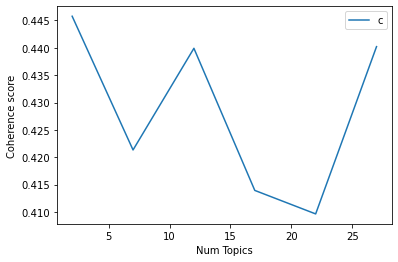

In [43]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.4458
index: 1 | Num Topics = 7  has Coherence Value of 0.4213
index: 2 | Num Topics = 12  has Coherence Value of 0.4399
index: 3 | Num Topics = 17  has Coherence Value of 0.4139
index: 4 | Num Topics = 22  has Coherence Value of 0.4097
index: 5 | Num Topics = 27  has Coherence Value of 0.4402


In [168]:
# Select optimal number of topics
optimal_model_us_score1 = model_list_us_score1[2]

In [169]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1, corpus_us_score1, id2word_us_score1)

In [170]:
print("pyLDAVis for us topics for score=1:")
vis_us_score1

pyLDAVis for us topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.180559  0.011379       1        1  24.148773
1     -0.191599 -0.093686       2        1  19.039879
3     -0.201321 -0.165327       3        1  18.678243
2     -0.178961 -0.128543       4        1  11.458088
7     -0.135217  0.216486       5        1  10.789678
10    -0.097621  0.221812       6        1   6.970756
11     0.112549  0.114165       7        1   2.497262
9      0.066079 -0.014943       8        1   2.211182
4      0.136873 -0.042718       9        1   1.817552
5      0.217056  0.009428      10        1   1.118708
0      0.232742 -0.090053      11        1   0.909170
8      0.219979 -0.038001      12        1   0.360709, topic_info=          Term         Freq        Total Category  logprob  loglift
43        post  1622.000000  1622.000000  Default  30.0000  30.0000
110    account   980.000000   980.000000  Default  29.0000  29.0000
194     people  1270.000000  1270.000000  Default  28.0000  28.0000
1          app  1397.000000  1397.000000  Default  27.0000  27.0000
137     update   484.000000   484.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1080  nonsense     1.088233     9.821098  Topic12  -5.7272   3.4249
630      short     1.241430    21.833290  Topic12  -5.5955   2.7577
1404      hand     1.217498    24.444672  Topic12  -5.6150   2.6252
832      small     1.185874    57.320918  Topic12  -5.6413   1.7467
3247   harmful     1.074956    12.403689  Topic12  -5.7395   3.1791

[820 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1040      4  0.477781  ability
1040      5  0.084314  ability
1040      7  0.449676  ability
206       2  0.623822   access
206       3  0.350216   access
...     ...       ...      ...
205       5  0.024740     year
205       6  0.053978     year
205       7  0.002249     year
5530      7  0.136249  zionist
5530     10  0.681244  zionist

[1661 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 4, 3, 8, 11, 12, 10, 5, 6, 1, 9])

## LDA Topic Modelling (Rating = 2)

In [48]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_us_score2 = facebook_ios_us_review_YearMonth_score2.review.values.tolist()
review_words_us_score2 = list(sent_to_words(review_us_score2))
print(review_words_us_score2[:1])

[['personally', 'love', 'facebook', 'love', 'all', 'the', 'features', 'but', 'couple', 'problems', 'see', 'notifications', 'load', 'out', 'of', 'order', 'notifications', 'skip', 'ie', 'from', 'just', 'now', 'to', 'fifteen', 'minutes', 'ago', 'to', 'three', 'hours', 'ago', 'to', 'yesterday', 'at', 'timeline', 'doesnt', 'load', 'posts', 'at', 'times', 'friends', 'timelines', 'wont', 'load', 'at', 'times', 'facebook', 'live', 'and', 'live', 'audio', 'something', 'love', 'my', 'two', 'favorite', 'features', 'actually', 'more', 'often', 'than', 'not', 'kicks', 'me', 'from', 'the', 'app', 'app', 'runs', 'slow', 'when', 'posting', 'sometimes', 'then', 'crashes', 'thank', 'the', 'lord', 'it', 'saves', 'your', 'post', 'like', 'an', 'email', 'draft', 'love', 'facebook', 'so', 'am', 'sorry', 'really', 'actually', 'sorry', 'to', 'leave', 'an', 'angry', 'review', 'but', 'that', 'is', 'what', 'this', 'section', 'is', 'for', 'would', 'like', 'to', 'see', 'these', 'all', 'fixed', 'please', 'and', 'tha

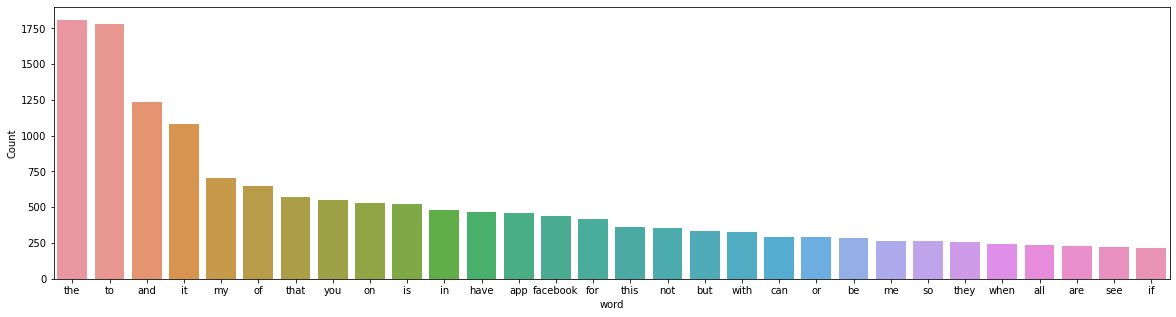

In [49]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score2))

In [50]:
# Clean text
review_us_ready_score2 = process_words(review_words_us_score2)  # processed Text Data! - move to each section


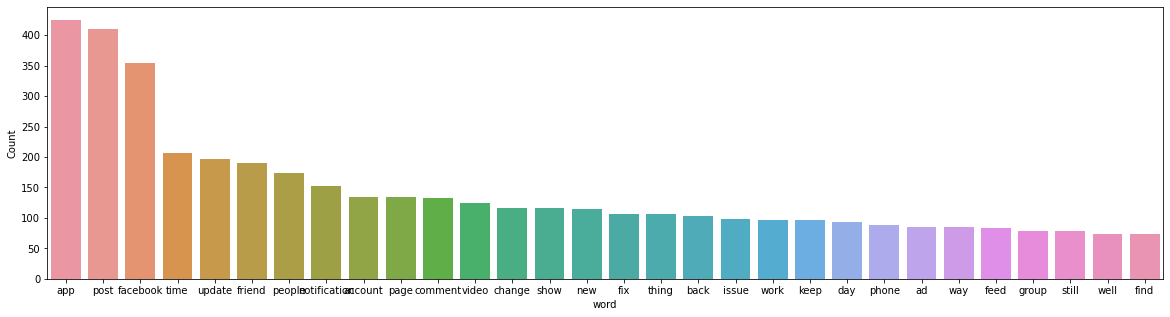

In [51]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score2))


In [52]:
# Create Dictionary
id2word_us_score2 = corpora.Dictionary(review_us_ready_score2)

2021-10-16 19:15:36,818 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:15:36,882 [INFO] gensim.corpora.dictionary - built Dictionary(2471 unique tokens: ['actually', 'ago', 'angry', 'app', 'audio']...) from 305 documents (total 16839 corpus positions)
2021-10-16 19:15:36,893 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2471 unique tokens: ['actually', 'ago', 'angry', 'app', 'audio']...) from 305 documents (total 16839 corpus positions)", 'datetime': '2021-10-16T19:15:36.889456', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [53]:
# Create Corpus: Term Document Frequency
corpus_us_score2 = [id2word_us_score2.doc2bow(text) for text in review_us_ready_score2]

In [54]:
# Training LDA model
model_list_us_score2, coherence_values_us_score2 = compute_coherence_values(dictionary=id2word_us_score2, corpus=corpus_us_score2, 
                                                              texts=review_us_ready_score2, limit=30, start=2, step=5)


2021-10-16 19:15:37,000 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:15:37,001 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:15:37,004 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:15:37,006 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 305 documents, updating model once every 305 documents, evaluating perplexity every 305 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:15:38,113 [INFO] gensim.models.ldamodel - -8.301 per-word bound, 315.4 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:15:38,114 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #305/305
2021-10-16 19:15:38,998 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.021*"post" + 0.019*"app" + 0.018*"facebook" + 0.012*"time" + 0.012*"friend" + 0.010*"people" + 0.010*

2021-10-16 19:15:54,547 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"post" + 0.019*"facebook" + 0.015*"friend" + 0.012*"notification" + 0.012*"app" + 0.012*"account" + 0.011*"people" + 0.011*"comment" + 0.010*"time" + 0.010*"page"
2021-10-16 19:15:54,551 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"app" + 0.018*"facebook" + 0.016*"update" + 0.015*"post" + 0.011*"video" + 0.011*"time" + 0.007*"work" + 0.007*"people" + 0.007*"new" + 0.007*"thing"
2021-10-16 19:15:54,559 [INFO] gensim.models.ldamodel - topic diff=0.014781, rho=0.301511
2021-10-16 19:15:55,470 [INFO] gensim.models.ldamodel - -6.835 per-word bound, 114.2 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:15:55,471 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #305/305
2021-10-16 19:15:56,230 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"post" + 0.019*"facebook" + 0.015*"friend" + 0.012*"notification" + 0.012*"account" + 0.012*"ap

2021-10-16 19:16:10,371 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.020*"facebook" + 0.016*"friend" + 0.013*"notification" + 0.013*"account" + 0.011*"people" + 0.011*"comment" + 0.010*"app" + 0.010*"time" + 0.009*"page"
2021-10-16 19:16:10,373 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"app" + 0.017*"facebook" + 0.016*"update" + 0.014*"post" + 0.012*"time" + 0.011*"video" + 0.008*"work" + 0.007*"issue" + 0.007*"new" + 0.007*"thing"
2021-10-16 19:16:10,374 [INFO] gensim.models.ldamodel - topic diff=0.008027, rho=0.218218
2021-10-16 19:16:11,094 [INFO] gensim.models.ldamodel - -6.829 per-word bound, 113.7 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:16:11,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #305/305
2021-10-16 19:16:11,811 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.020*"facebook" + 0.016*"friend" + 0.013*"account" + 0.013*"notification" + 0.011*"peo

2021-10-16 19:16:25,858 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.021*"facebook" + 0.016*"friend" + 0.013*"account" + 0.012*"notification" + 0.012*"people" + 0.010*"comment" + 0.010*"time" + 0.009*"app" + 0.009*"page"
2021-10-16 19:16:25,859 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"app" + 0.016*"facebook" + 0.016*"update" + 0.014*"post" + 0.012*"time" + 0.011*"video" + 0.008*"work" + 0.007*"issue" + 0.007*"new" + 0.007*"thing"
2021-10-16 19:16:25,860 [INFO] gensim.models.ldamodel - topic diff=0.006090, rho=0.179605
2021-10-16 19:16:26,753 [INFO] gensim.models.ldamodel - -6.826 per-word bound, 113.4 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:16:26,754 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #305/305
2021-10-16 19:16:27,388 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.021*"facebook" + 0.016*"friend" + 0.014*"account" + 0.012*"notification" + 0.012*"peo

2021-10-16 19:16:40,893 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.021*"facebook" + 0.017*"friend" + 0.014*"account" + 0.012*"people" + 0.012*"notification" + 0.009*"comment" + 0.009*"time" + 0.008*"page" + 0.008*"app"
2021-10-16 19:16:40,903 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"app" + 0.016*"update" + 0.016*"facebook" + 0.015*"post" + 0.012*"time" + 0.011*"video" + 0.008*"work" + 0.007*"issue" + 0.007*"new" + 0.007*"thing"
2021-10-16 19:16:40,910 [INFO] gensim.models.ldamodel - topic diff=0.006075, rho=0.156174
2021-10-16 19:16:41,718 [INFO] gensim.models.ldamodel - -6.822 per-word bound, 113.1 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:16:41,720 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #305/305
2021-10-16 19:16:42,257 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"post" + 0.021*"facebook" + 0.017*"friend" + 0.014*"account" + 0.012*"people" + 0.012*"notificat

2021-10-16 19:16:55,390 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"post" + 0.021*"facebook" + 0.017*"friend" + 0.015*"account" + 0.012*"people" + 0.011*"notification" + 0.009*"time" + 0.008*"comment" + 0.008*"page" + 0.008*"app"
2021-10-16 19:16:55,395 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"app" + 0.016*"update" + 0.016*"facebook" + 0.015*"post" + 0.012*"time" + 0.011*"video" + 0.008*"work" + 0.007*"issue" + 0.007*"new" + 0.007*"fix"
2021-10-16 19:16:55,400 [INFO] gensim.models.ldamodel - topic diff=0.005398, rho=0.140028
2021-10-16 19:16:55,401 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2471, num_topics=2, decay=0.5, chunksize=1000) in 78.39s', 'datetime': '2021-10-16T19:16:55.401575', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:16:55,407 [INFO] gensim.topic_coherence.probability_estimation -

2021-10-16 19:17:06,307 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #305/305
2021-10-16 19:17:06,766 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"video" + 0.019*"app" + 0.016*"facebook" + 0.014*"comment" + 0.011*"thing" + 0.011*"change" + 0.011*"update" + 0.011*"post" + 0.010*"new" + 0.009*"feature"
2021-10-16 19:17:06,768 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"account" + 0.021*"facebook" + 0.018*"app" + 0.015*"post" + 0.010*"friend" + 0.009*"people" + 0.009*"fix" + 0.008*"time" + 0.008*"change" + 0.008*"update"
2021-10-16 19:17:06,770 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.052*"post" + 0.028*"notification" + 0.017*"friend" + 0.014*"app" + 0.013*"facebook" + 0.012*"show" + 0.012*"people" + 0.012*"page" + 0.012*"time" + 0.011*"feed"
2021-10-16 19:17:06,772 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"facebook" + 0.020*"app" + 0.015*"post" + 0.014*"time" + 0.014*"friend" + 0.012*"page" + 0.011*"comment" + 0.010*"peo

2021-10-16 19:17:12,614 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"facebook" + 0.016*"app" + 0.013*"keep" + 0.011*"user" + 0.011*"people" + 0.010*"time" + 0.008*"never" + 0.007*"iphone" + 0.006*"allow" + 0.006*"social"
2021-10-16 19:17:12,615 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.015*"post" + 0.014*"video" + 0.011*"update" + 0.011*"log" + 0.009*"photo" + 0.008*"new" + 0.008*"still" + 0.008*"thing"
2021-10-16 19:17:12,616 [INFO] gensim.models.ldamodel - topic diff=0.035030, rho=0.301511
2021-10-16 19:17:13,253 [INFO] gensim.models.ldamodel - -6.972 per-word bound, 125.6 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:17:13,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #305/305
2021-10-16 19:17:13,701 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.015*"post" + 0.014*"video" + 0.011*"log" + 0.011*"update" + 0.009*"photo" + 0

2021-10-16 19:17:18,696 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #305/305
2021-10-16 19:17:19,202 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.022*"facebook" + 0.018*"app" + 0.015*"time" + 0.013*"post" + 0.013*"friend" + 0.012*"page" + 0.011*"comment" + 0.011*"people" + 0.009*"fix" + 0.008*"change"
2021-10-16 19:17:19,205 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.030*"account" + 0.021*"facebook" + 0.016*"app" + 0.013*"post" + 0.011*"friend" + 0.009*"people" + 0.008*"change" + 0.008*"fix" + 0.008*"help" + 0.008*"story"
2021-10-16 19:17:19,211 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.052*"app" + 0.023*"update" + 0.013*"time" + 0.012*"facebook" + 0.011*"message" + 0.011*"phone" + 0.010*"work" + 0.010*"access" + 0.009*"issue" + 0.008*"photo"
2021-10-16 19:17:19,216 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.014*"post" + 0.014*"video" + 0.012*"log" + 0.011*"update" + 0.009*"photo" + 0.009*"new" + 0.0

2021-10-16 19:17:24,607 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"post" + 0.028*"notification" + 0.019*"friend" + 0.017*"app" + 0.014*"show" + 0.013*"page" + 0.013*"feed" + 0.012*"facebook" + 0.012*"time" + 0.012*"comment"
2021-10-16 19:17:24,609 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.022*"facebook" + 0.018*"app" + 0.015*"time" + 0.013*"friend" + 0.013*"post" + 0.012*"page" + 0.011*"comment" + 0.011*"people" + 0.009*"fix" + 0.007*"change"
2021-10-16 19:17:24,609 [INFO] gensim.models.ldamodel - topic diff=0.007874, rho=0.213201
2021-10-16 19:17:25,368 [INFO] gensim.models.ldamodel - -6.958 per-word bound, 124.3 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:17:25,369 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #305/305
2021-10-16 19:17:25,815 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.014*"video" + 0.014*"post" + 0.012*"log" + 0.011*"update" + 0.009*"p

2021-10-16 19:17:30,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #305/305
2021-10-16 19:17:31,259 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.032*"account" + 0.022*"facebook" + 0.015*"app" + 0.012*"post" + 0.011*"friend" + 0.010*"people" + 0.009*"change" + 0.009*"access" + 0.008*"help" + 0.008*"story"
2021-10-16 19:17:31,262 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"video" + 0.017*"app" + 0.016*"facebook" + 0.012*"comment" + 0.012*"thing" + 0.010*"change" + 0.010*"update" + 0.010*"feature" + 0.010*"watch" + 0.010*"new"
2021-10-16 19:17:31,265 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"post" + 0.028*"notification" + 0.019*"friend" + 0.017*"app" + 0.014*"show" + 0.013*"page" + 0.013*"feed" + 0.012*"facebook" + 0.012*"time" + 0.012*"comment"
2021-10-16 19:17:31,269 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.015*"video" + 0.014*"post" + 0.012*"log" + 0.011*"update" + 0.009*"photo" + 0.009*"

2021-10-16 19:17:36,666 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.015*"video" + 0.014*"post" + 0.012*"log" + 0.011*"update" + 0.009*"photo" + 0.009*"new" + 0.009*"still" + 0.008*"thing"
2021-10-16 19:17:36,668 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"account" + 0.023*"facebook" + 0.015*"app" + 0.012*"post" + 0.011*"friend" + 0.010*"people" + 0.009*"change" + 0.009*"access" + 0.008*"help" + 0.008*"story"
2021-10-16 19:17:36,670 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.022*"facebook" + 0.014*"keep" + 0.013*"user" + 0.013*"app" + 0.012*"people" + 0.009*"time" + 0.007*"never" + 0.006*"social" + 0.006*"allow" + 0.006*"delete"
2021-10-16 19:17:36,672 [INFO] gensim.models.ldamodel - topic diff=0.003925, rho=0.174078
2021-10-16 19:17:37,300 [INFO] gensim.models.ldamodel - -6.952 per-word bound, 123.8 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:17:37,302 [INFO] gensim.models.

2021-10-16 19:17:41,864 [INFO] gensim.models.ldamodel - topic diff=0.003178, rho=0.162221
2021-10-16 19:17:42,490 [INFO] gensim.models.ldamodel - -6.951 per-word bound, 123.7 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:17:42,492 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #305/305
2021-10-16 19:17:42,889 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"app" + 0.025*"update" + 0.014*"time" + 0.013*"facebook" + 0.012*"message" + 0.011*"work" + 0.010*"phone" + 0.009*"access" + 0.009*"issue" + 0.008*"option"
2021-10-16 19:17:42,891 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.022*"facebook" + 0.014*"keep" + 0.014*"user" + 0.013*"app" + 0.012*"people" + 0.009*"time" + 0.007*"never" + 0.006*"social" + 0.006*"allow" + 0.006*"delete"
2021-10-16 19:17:42,892 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.015*"video" + 0.014*"post" + 0.012*"log" + 0.011*"update" + 0.009*"pho

2021-10-16 19:17:48,364 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.029*"facebook" + 0.025*"app" + 0.015*"video" + 0.014*"post" + 0.012*"log" + 0.011*"update" + 0.009*"photo" + 0.009*"new" + 0.008*"still" + 0.008*"thing"
2021-10-16 19:17:48,365 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.022*"facebook" + 0.014*"keep" + 0.014*"user" + 0.013*"app" + 0.012*"people" + 0.009*"time" + 0.007*"never" + 0.006*"social" + 0.006*"allow" + 0.006*"delete"
2021-10-16 19:17:48,366 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"app" + 0.025*"update" + 0.014*"time" + 0.013*"facebook" + 0.012*"message" + 0.011*"work" + 0.010*"phone" + 0.009*"access" + 0.009*"issue" + 0.009*"option"
2021-10-16 19:17:48,367 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"video" + 0.016*"app" + 0.016*"facebook" + 0.012*"thing" + 0.012*"comment" + 0.010*"watch" + 0.010*"feature" + 0.010*"update" + 0.010*"change" + 0.010*"new"
2021-10-16 19:17:48,368 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 19:17:53,881 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.052*"post" + 0.027*"notification" + 0.019*"friend" + 0.018*"app" + 0.014*"show" + 0.013*"feed" + 0.013*"page" + 0.013*"time" + 0.012*"facebook" + 0.012*"comment"
2021-10-16 19:17:53,881 [INFO] gensim.models.ldamodel - topic diff=0.002080, rho=0.142857
2021-10-16 19:17:54,516 [INFO] gensim.models.ldamodel - -6.948 per-word bound, 123.5 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:17:54,518 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #305/305
2021-10-16 19:17:54,932 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"video" + 0.016*"facebook" + 0.016*"app" + 0.012*"thing" + 0.012*"comment" + 0.010*"watch" + 0.010*"feature" + 0.010*"update" + 0.010*"change" + 0.010*"new"
2021-10-16 19:17:54,934 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.053*"app" + 0.025*"update" + 0.014*"time" + 0.013*"facebook" + 0.012*"message" + 0.011*"work" + 0

2021-10-16 19:18:06,729 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.059*"post" + 0.039*"notification" + 0.014*"comment" + 0.014*"friend" + 0.013*"show" + 0.013*"people" + 0.011*"group" + 0.011*"facebook" + 0.011*"page" + 0.011*"feed"
2021-10-16 19:18:06,731 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.018*"post" + 0.015*"facebook" + 0.013*"video" + 0.013*"page" + 0.013*"update" + 0.009*"work" + 0.008*"people" + 0.008*"issue" + 0.007*"time"
2021-10-16 19:18:06,732 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.024*"app" + 0.023*"video" + 0.018*"facebook" + 0.014*"update" + 0.013*"thing" + 0.012*"time" + 0.011*"watch" + 0.011*"new" + 0.010*"issue" + 0.010*"people"
2021-10-16 19:18:06,733 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"update" + 0.025*"app" + 0.017*"post" + 0.016*"feed" + 0.013*"recent" + 0.012*"friend" + 0.012*"love" + 0.011*"time" + 0.009*"notification" + 0.009*"facebook"
2021-10-16 19:18:06,735 [INFO] gensim.models.ldamodel -

2021-10-16 19:18:12,953 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.013*"app" + 0.012*"facebook" + 0.009*"video" + 0.009*"iphone" + 0.009*"time" + 0.009*"upload" + 0.009*"item" + 0.008*"datum" + 0.008*"local" + 0.007*"never"
2021-10-16 19:18:12,955 [INFO] gensim.models.ldamodel - topic diff=0.089925, rho=0.333333
2021-10-16 19:18:13,707 [INFO] gensim.models.ldamodel - -7.088 per-word bound, 136.0 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:18:13,710 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #305/305
2021-10-16 19:18:14,168 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.013*"app" + 0.012*"facebook" + 0.009*"iphone" + 0.009*"item" + 0.009*"video" + 0.009*"time" + 0.009*"upload" + 0.008*"datum" + 0.008*"local" + 0.007*"never"
2021-10-16 19:18:14,169 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"app" + 0.017*"facebook" + 0.017*"time" + 0.013*"update" + 0.012*"access" + 0.012*"issue" + 0.010*"post

2021-10-16 19:18:19,683 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"comment" + 0.019*"video" + 0.018*"share" + 0.017*"update" + 0.015*"app" + 0.012*"watch" + 0.012*"thing" + 0.012*"feature" + 0.012*"facebook" + 0.012*"guy"
2021-10-16 19:18:19,686 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.015*"post" + 0.015*"page" + 0.015*"facebook" + 0.013*"video" + 0.013*"update" + 0.010*"work" + 0.008*"people" + 0.008*"issue" + 0.007*"way"
2021-10-16 19:18:19,689 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.035*"post" + 0.018*"facebook" + 0.014*"ad" + 0.010*"video" + 0.010*"app" + 0.009*"update" + 0.008*"year" + 0.008*"access" + 0.008*"way" + 0.007*"people"
2021-10-16 19:18:19,694 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"video" + 0.025*"app" + 0.018*"facebook" + 0.014*"update" + 0.013*"thing" + 0.011*"time" + 0.011*"watch" + 0.011*"new" + 0.011*"people" + 0.011*"play"
2021-10-16 19:18:19,696 [INFO] gensim.models.ldamodel - topic diff=0.0230

2021-10-16 19:18:24,938 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.011*"app" + 0.011*"facebook" + 0.011*"item" + 0.009*"upload" + 0.009*"iphone" + 0.009*"time" + 0.009*"datum" + 0.008*"local" + 0.007*"never" + 0.007*"still"
2021-10-16 19:18:24,940 [INFO] gensim.models.ldamodel - topic diff=0.011654, rho=0.223607
2021-10-16 19:18:25,534 [INFO] gensim.models.ldamodel - -7.062 per-word bound, 133.6 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:18:25,535 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #305/305
2021-10-16 19:18:25,944 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.025*"comment" + 0.020*"video" + 0.018*"update" + 0.018*"share" + 0.015*"app" + 0.014*"watch" + 0.013*"feature" + 0.012*"thing" + 0.012*"guy" + 0.011*"facebook"
2021-10-16 19:18:25,946 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"video" + 0.025*"app" + 0.018*"facebook" + 0.014*"update" + 0.014*"thing" + 0.012*"watch" + 0.011*"

2021-10-16 19:18:31,295 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.015*"page" + 0.015*"facebook" + 0.014*"video" + 0.013*"post" + 0.011*"update" + 0.010*"work" + 0.008*"issue" + 0.008*"people" + 0.007*"way"
2021-10-16 19:18:31,298 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.067*"post" + 0.044*"notification" + 0.019*"show" + 0.018*"friend" + 0.016*"comment" + 0.014*"feed" + 0.014*"group" + 0.012*"time" + 0.012*"new" + 0.012*"page"
2021-10-16 19:18:31,301 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.030*"post" + 0.019*"facebook" + 0.015*"ad" + 0.010*"video" + 0.009*"year" + 0.009*"app" + 0.008*"way" + 0.008*"access" + 0.008*"people" + 0.008*"update"
2021-10-16 19:18:31,304 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.011*"facebook" + 0.011*"item" + 0.011*"app" + 0.009*"upload" + 0.009*"time" + 0.009*"iphone" + 0.009*"datum" + 0.008*"local" + 0.007*"still" + 0.007*"never"
2021-10-16 19:18:31,306 [INFO] gensim.models.ldamodel - topic diff=0.007

2021-10-16 19:18:36,498 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.015*"page" + 0.014*"facebook" + 0.014*"video" + 0.013*"post" + 0.011*"update" + 0.010*"work" + 0.008*"issue" + 0.008*"people" + 0.007*"way"
2021-10-16 19:18:36,499 [INFO] gensim.models.ldamodel - topic diff=0.005198, rho=0.179605
2021-10-16 19:18:37,147 [INFO] gensim.models.ldamodel - -7.053 per-word bound, 132.8 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:18:37,149 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #305/305
2021-10-16 19:18:37,582 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.015*"page" + 0.014*"facebook" + 0.014*"video" + 0.013*"post" + 0.011*"update" + 0.010*"work" + 0.008*"issue" + 0.008*"people" + 0.007*"way"
2021-10-16 19:18:37,586 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.038*"app" + 0.028*"facebook" + 0.018*"time" + 0.017*"post" + 0.013*"keep" + 0.012*"fix" + 0.011*"change" + 0.

2021-10-16 19:18:42,953 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.052*"account" + 0.019*"facebook" + 0.015*"app" + 0.014*"friend" + 0.012*"post" + 0.011*"hack" + 0.009*"still" + 0.009*"page" + 0.009*"people" + 0.008*"story"
2021-10-16 19:18:42,958 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.028*"post" + 0.019*"facebook" + 0.014*"ad" + 0.010*"video" + 0.010*"year" + 0.009*"way" + 0.008*"app" + 0.008*"access" + 0.008*"people" + 0.007*"update"
2021-10-16 19:18:42,963 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"video" + 0.025*"app" + 0.018*"facebook" + 0.014*"update" + 0.014*"thing" + 0.012*"watch" + 0.012*"people" + 0.012*"new" + 0.011*"play" + 0.011*"time"
2021-10-16 19:18:42,966 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.011*"item" + 0.011*"facebook" + 0.010*"app" + 0.009*"upload" + 0.009*"time" + 0.009*"datum" + 0.009*"local" + 0.008*"iphone" + 0.007*"still" + 0.007*"delete"
2021-10-16 19:18:42,969 [INFO] gensim.models.ldamodel - topic diff=0.003

2021-10-16 19:18:48,213 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.018*"facebook" + 0.018*"comment" + 0.014*"group" + 0.012*"people" + 0.011*"app" + 0.011*"time" + 0.010*"friend" + 0.009*"post" + 0.009*"page" + 0.008*"update"
2021-10-16 19:18:48,215 [INFO] gensim.models.ldamodel - topic diff=0.003045, rho=0.154303
2021-10-16 19:18:48,720 [INFO] gensim.models.ldamodel - -7.048 per-word bound, 132.3 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:18:48,722 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #305/305
2021-10-16 19:18:49,149 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"app" + 0.017*"facebook" + 0.017*"time" + 0.013*"update" + 0.012*"access" + 0.012*"issue" + 0.010*"post" + 0.010*"phone" + 0.009*"type" + 0.009*"feature"
2021-10-16 19:18:49,151 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.018*"facebook" + 0.018*"comment" + 0.014*"group" + 0.012*"people" + 0.011*"app" + 0.011*"time" + 0.010*

2021-10-16 19:18:54,248 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"video" + 0.025*"app" + 0.018*"facebook" + 0.014*"update" + 0.014*"thing" + 0.012*"watch" + 0.012*"people" + 0.012*"new" + 0.011*"play" + 0.011*"time"
2021-10-16 19:18:54,249 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.037*"facebook" + 0.017*"download" + 0.016*"app" + 0.014*"log" + 0.013*"add" + 0.011*"post" + 0.011*"people" + 0.011*"friend" + 0.010*"back" + 0.009*"photo"
2021-10-16 19:18:54,250 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.039*"app" + 0.028*"facebook" + 0.018*"time" + 0.017*"post" + 0.013*"keep" + 0.012*"fix" + 0.012*"change" + 0.011*"people" + 0.010*"friend" + 0.009*"phone"
2021-10-16 19:18:54,251 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"app" + 0.015*"page" + 0.014*"facebook" + 0.014*"video" + 0.013*"post" + 0.010*"work" + 0.010*"update" + 0.008*"issue" + 0.008*"people" + 0.007*"way"
2021-10-16 19:18:54,252 [INFO] gensim.models.ldamodel - topic diff=0.00235

2021-10-16 19:19:05,394 [INFO] gensim.models.ldamodel - topic diff=10.973261, rho=1.000000
2021-10-16 19:19:06,180 [INFO] gensim.models.ldamodel - -7.666 per-word bound, 203.1 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:19:06,181 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #305/305
2021-10-16 19:19:06,725 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.036*"facebook" + 0.018*"post" + 0.017*"app" + 0.013*"photo" + 0.013*"account" + 0.011*"back" + 0.010*"download" + 0.009*"way" + 0.009*"time" + 0.009*"find"
2021-10-16 19:19:06,727 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.015*"people" + 0.014*"user" + 0.011*"allow" + 0.010*"delete" + 0.010*"put" + 0.009*"facebook" + 0.009*"privacy" + 0.007*"friend" + 0.007*"issue" + 0.007*"thing"
2021-10-16 19:19:06,729 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.033*"app" + 0.020*"post" + 0.016*"issue" + 0.012*"time" + 0.011*"work" + 0.011*"phone" + 0.009*"commen

2021-10-16 19:19:11,978 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.029*"app" + 0.027*"facebook" + 0.024*"post" + 0.015*"people" + 0.014*"time" + 0.013*"notification" + 0.012*"keep" + 0.010*"friend" + 0.010*"fix" + 0.009*"new"
2021-10-16 19:19:11,979 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.049*"account" + 0.022*"facebook" + 0.016*"app" + 0.012*"change" + 0.010*"friend" + 0.010*"post" + 0.009*"still" + 0.009*"log" + 0.009*"update" + 0.008*"report"
2021-10-16 19:19:11,981 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.034*"facebook" + 0.021*"post" + 0.021*"people" + 0.018*"friend" + 0.013*"app" + 0.011*"fact" + 0.010*"keep" + 0.008*"time" + 0.007*"well" + 0.007*"family"
2021-10-16 19:19:11,982 [INFO] gensim.models.ldamodel - topic diff=0.166012, rho=0.353553
2021-10-16 19:19:12,605 [INFO] gensim.models.ldamodel - -7.196 per-word bound, 146.6 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:19:12,606 [INFO] gensim.mo

2021-10-16 19:19:17,003 [INFO] gensim.models.ldamodel - topic diff=0.044278, rho=0.277350
2021-10-16 19:19:17,625 [INFO] gensim.models.ldamodel - -7.166 per-word bound, 143.6 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:19:17,626 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #305/305
2021-10-16 19:19:18,049 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.053*"app" + 0.025*"update" + 0.019*"post" + 0.014*"crash" + 0.013*"phone" + 0.013*"time" + 0.012*"feature" + 0.012*"photo" + 0.011*"access" + 0.011*"facebook"
2021-10-16 19:19:18,054 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.027*"comment" + 0.022*"video" + 0.021*"share" + 0.016*"facebook" + 0.013*"friend" + 0.013*"thing" + 0.012*"watch" + 0.011*"guy" + 0.010*"platform" + 0.009*"post"
2021-10-16 19:19:18,059 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.037*"facebook" + 0.020*"app" + 0.015*"download" + 0.015*"photo" + 0.015*"post" + 0.012*"add" + 0.01

2021-10-16 19:19:23,057 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.016*"page" + 0.015*"comment" + 0.015*"friend" + 0.015*"post" + 0.013*"facebook" + 0.013*"app" + 0.012*"time" + 0.010*"change" + 0.009*"account" + 0.009*"people"
2021-10-16 19:19:23,067 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.056*"account" + 0.024*"facebook" + 0.015*"app" + 0.013*"change" + 0.012*"log" + 0.011*"friend" + 0.010*"still" + 0.009*"hack" + 0.009*"help" + 0.008*"update"
2021-10-16 19:19:23,074 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"app" + 0.030*"ad" + 0.026*"update" + 0.020*"message" + 0.014*"feed" + 0.014*"show" + 0.012*"people" + 0.009*"friend" + 0.009*"feature" + 0.008*"change"
2021-10-16 19:19:23,080 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.042*"app" + 0.021*"video" + 0.017*"post" + 0.016*"facebook" + 0.013*"update" + 0.011*"time" + 0.009*"look" + 0.009*"watch" + 0.008*"page" + 0.008*"people"
2021-10-16 19:19:23,085 [INFO] gensim.models.ldamodel - topic d

2021-10-16 19:19:27,973 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.033*"app" + 0.029*"update" + 0.020*"feed" + 0.019*"post" + 0.019*"love" + 0.014*"change" + 0.013*"friend" + 0.013*"time" + 0.012*"thing" + 0.012*"recent"
2021-10-16 19:19:27,974 [INFO] gensim.models.ldamodel - topic diff=0.008515, rho=0.204124
2021-10-16 19:19:28,612 [INFO] gensim.models.ldamodel - -7.148 per-word bound, 141.8 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:19:28,613 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #305/305
2021-10-16 19:19:29,002 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.072*"post" + 0.043*"notification" + 0.022*"comment" + 0.019*"friend" + 0.016*"group" + 0.016*"show" + 0.013*"app" + 0.011*"people" + 0.011*"page" + 0.011*"time"
2021-10-16 19:19:29,007 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"people" + 0.018*"user" + 0.014*"allow" + 0.011*"delete" + 0.011*"put" + 0.011*"privacy" + 0.007*"fri

2021-10-16 19:19:33,873 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.018*"people" + 0.018*"user" + 0.014*"allow" + 0.011*"delete" + 0.011*"put" + 0.011*"privacy" + 0.007*"friend" + 0.007*"issue" + 0.007*"thing" + 0.007*"report"
2021-10-16 19:19:33,874 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.057*"account" + 0.025*"facebook" + 0.014*"app" + 0.013*"log" + 0.013*"change" + 0.011*"friend" + 0.011*"hack" + 0.010*"access" + 0.009*"still" + 0.009*"password"
2021-10-16 19:19:33,875 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.022*"app" + 0.016*"facebook" + 0.014*"issue" + 0.013*"work" + 0.012*"help" + 0.010*"well" + 0.009*"free" + 0.008*"social" + 0.007*"marketplace" + 0.007*"time"
2021-10-16 19:19:33,877 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"ad" + 0.030*"app" + 0.026*"update" + 0.021*"message" + 0.014*"feed" + 0.013*"show" + 0.012*"people" + 0.009*"friend" + 0.008*"change" + 0.008*"group"
2021-10-16 19:19:33,880 [INFO] gensim.models.ldamodel - top

2021-10-16 19:19:38,932 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.057*"account" + 0.025*"facebook" + 0.014*"app" + 0.013*"log" + 0.012*"change" + 0.011*"hack" + 0.011*"friend" + 0.010*"access" + 0.010*"password" + 0.009*"still"
2021-10-16 19:19:38,937 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.037*"facebook" + 0.020*"app" + 0.017*"download" + 0.015*"photo" + 0.013*"post" + 0.013*"back" + 0.013*"add" + 0.011*"account" + 0.011*"start" + 0.010*"way"
2021-10-16 19:19:38,938 [INFO] gensim.models.ldamodel - topic diff=0.004230, rho=0.169031
2021-10-16 19:19:39,597 [INFO] gensim.models.ldamodel - -7.140 per-word bound, 141.0 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:19:39,599 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #305/305
2021-10-16 19:19:39,882 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.030*"app" + 0.027*"facebook" + 0.022*"post" + 0.016*"people" + 0.014*"time" + 0.012*"keep" + 0.011*"n

2021-10-16 19:19:44,503 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #305/305
2021-10-16 19:19:44,886 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.016*"page" + 0.014*"comment" + 0.014*"friend" + 0.014*"post" + 0.013*"facebook" + 0.012*"app" + 0.012*"time" + 0.009*"change" + 0.009*"account" + 0.009*"people"
2021-10-16 19:19:44,888 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"ad" + 0.029*"app" + 0.025*"update" + 0.021*"message" + 0.014*"feed" + 0.013*"people" + 0.012*"show" + 0.009*"friend" + 0.008*"change" + 0.008*"group"
2021-10-16 19:19:44,890 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.020*"friend" + 0.015*"page" + 0.015*"account" + 0.012*"back" + 0.011*"app" + 0.011*"help" + 0.011*"facebook" + 0.011*"post" + 0.011*"several" + 0.010*"link"
2021-10-16 19:19:44,892 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.035*"video" + 0.029*"watch" + 0.025*"facebook" + 0.015*"update" + 0.013*"new" + 0.012*"feature" + 0.012*"avatar" + 0.012*"pos

2021-10-16 19:19:50,217 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.032*"ad" + 0.029*"app" + 0.025*"update" + 0.021*"message" + 0.014*"feed" + 0.013*"people" + 0.012*"show" + 0.009*"friend" + 0.008*"change" + 0.008*"group"
2021-10-16 19:19:50,221 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.054*"app" + 0.024*"update" + 0.019*"post" + 0.016*"crash" + 0.014*"phone" + 0.013*"time" + 0.012*"feature" + 0.012*"photo" + 0.011*"access" + 0.011*"facebook"
2021-10-16 19:19:50,223 [INFO] gensim.models.ldamodel - topic diff=0.002618, rho=0.147442
2021-10-16 19:19:50,906 [INFO] gensim.models.ldamodel - -7.134 per-word bound, 140.5 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:19:50,909 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #305/305
2021-10-16 19:19:51,354 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.070*"post" + 0.044*"notification" + 0.024*"comment" + 0.021*"friend" + 0.018*"show" + 0.015*"group" + 0.0

2021-10-16 19:19:55,568 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:20:00,175 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:20:00,232 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 305 virtual documents
2021-10-16 19:20:02,506 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 19:20:02,507 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 19:20:02,511 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:20:02,524 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 305 documents, updating model once every 305 documents, evaluating perplexity every 305 documents, iterating 50x with a 

2021-10-16 19:20:09,483 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.029*"app" + 0.027*"facebook" + 0.019*"time" + 0.018*"post" + 0.015*"people" + 0.013*"account" + 0.011*"keep" + 0.011*"friend" + 0.010*"notification" + 0.009*"fix"
2021-10-16 19:20:09,484 [INFO] gensim.models.ldamodel - topic diff=0.324545, rho=0.408248
2021-10-16 19:20:10,111 [INFO] gensim.models.ldamodel - -7.302 per-word bound, 157.8 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:20:10,113 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #305/305
2021-10-16 19:20:10,516 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.037*"post" + 0.024*"change" + 0.015*"friend" + 0.015*"app" + 0.014*"update" + 0.011*"facebook" + 0.010*"back" + 0.010*"stop" + 0.009*"access" + 0.009*"thing"
2021-10-16 19:20:10,518 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.022*"facebook" + 0.022*"time" + 0.018*"app" + 0.017*"issue" + 0.010*"update" + 0.010*"day" + 0.010*

2021-10-16 19:20:15,268 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"comment" + 0.032*"video" + 0.029*"watch" + 0.019*"new" + 0.017*"facebook" + 0.015*"post" + 0.014*"read" + 0.012*"feature" + 0.012*"thing" + 0.011*"ad"
2021-10-16 19:20:15,270 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.027*"people" + 0.023*"app" + 0.017*"update" + 0.015*"version" + 0.015*"avatar" + 0.014*"ad" + 0.014*"facebook" + 0.013*"instead" + 0.013*"still" + 0.012*"option"
2021-10-16 19:20:15,272 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.022*"app" + 0.011*"thing" + 0.011*"laptop" + 0.010*"way" + 0.010*"issue" + 0.009*"time" + 0.009*"facebook" + 0.009*"help" + 0.008*"page" + 0.008*"message"
2021-10-16 19:20:15,275 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.026*"facebook" + 0.022*"thing" + 0.018*"app" + 0.018*"update" + 0.017*"people" + 0.015*"video" + 0.013*"fast" + 0.013*"star" + 0.011*"day" + 0.011*"person"
2021-10-16 19:20:15,279 [INFO] gensim.models.ldamodel - topic #11

2021-10-16 19:20:20,114 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.038*"account" + 0.019*"facebook" + 0.018*"post" + 0.018*"app" + 0.012*"friend" + 0.009*"story" + 0.009*"report" + 0.008*"update" + 0.008*"fix" + 0.007*"people"
2021-10-16 19:20:20,116 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"post" + 0.028*"app" + 0.021*"notification" + 0.018*"show" + 0.013*"thing" + 0.012*"update" + 0.012*"photo" + 0.011*"comment" + 0.011*"page" + 0.011*"reply"
2021-10-16 19:20:20,117 [INFO] gensim.models.ldamodel - topic diff=0.019869, rho=0.242536
2021-10-16 19:20:20,859 [INFO] gensim.models.ldamodel - -7.224 per-word bound, 149.5 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:20:20,860 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #305/305
2021-10-16 19:20:21,262 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.022*"account" + 0.018*"facebook" + 0.016*"friend" + 0.015*"hack" + 0.014*"people" + 0.013*"comment

2021-10-16 19:20:25,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #305/305
2021-10-16 19:20:26,338 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.025*"facebook" + 0.023*"app" + 0.021*"video" + 0.014*"post" + 0.012*"look" + 0.011*"update" + 0.010*"page" + 0.010*"time" + 0.009*"watch" + 0.009*"work"
2021-10-16 19:20:26,340 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.054*"app" + 0.030*"post" + 0.024*"update" + 0.017*"feed" + 0.016*"friend" + 0.014*"time" + 0.013*"work" + 0.013*"comment" + 0.013*"ad" + 0.012*"facebook"
2021-10-16 19:20:26,342 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.025*"app" + 0.018*"people" + 0.017*"post" + 0.015*"facebook" + 0.014*"group" + 0.013*"ad" + 0.012*"item" + 0.011*"really" + 0.011*"marketplace" + 0.011*"problem"
2021-10-16 19:20:26,345 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.038*"app" + 0.019*"message" + 0.016*"event" + 0.016*"update" + 0.013*"user" + 0.013*"small" + 0.010*"change" + 0.010*"quality" 

2021-10-16 19:20:31,175 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.045*"comment" + 0.038*"video" + 0.029*"watch" + 0.019*"new" + 0.018*"facebook" + 0.015*"post" + 0.014*"read" + 0.013*"thing" + 0.012*"feature" + 0.011*"annoying"
2021-10-16 19:20:31,177 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.055*"app" + 0.030*"post" + 0.024*"update" + 0.018*"feed" + 0.016*"friend" + 0.014*"time" + 0.014*"ad" + 0.013*"work" + 0.013*"comment" + 0.012*"facebook"
2021-10-16 19:20:31,179 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.022*"facebook" + 0.022*"time" + 0.017*"app" + 0.017*"issue" + 0.010*"update" + 0.010*"day" + 0.010*"crash" + 0.010*"work" + 0.010*"money" + 0.010*"type"
2021-10-16 19:20:31,180 [INFO] gensim.models.ldamodel - topic diff=0.004132, rho=0.188982
2021-10-16 19:20:31,790 [INFO] gensim.models.ldamodel - -7.216 per-word bound, 148.7 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:20:31,791 [INFO] gensim.models.l

2021-10-16 19:20:36,147 [INFO] gensim.models.ldamodel - topic diff=0.002874, rho=0.174078
2021-10-16 19:20:36,762 [INFO] gensim.models.ldamodel - -7.213 per-word bound, 148.4 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:20:36,763 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #305/305
2021-10-16 19:20:37,047 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.055*"app" + 0.032*"post" + 0.024*"update" + 0.019*"feed" + 0.016*"ad" + 0.016*"friend" + 0.014*"time" + 0.013*"work" + 0.013*"comment" + 0.012*"facebook"
2021-10-16 19:20:37,049 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.033*"facebook" + 0.023*"update" + 0.018*"post" + 0.016*"app" + 0.014*"video" + 0.012*"back" + 0.010*"time" + 0.010*"account" + 0.009*"friend" + 0.008*"people"
2021-10-16 19:20:37,051 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.043*"post" + 0.029*"app" + 0.022*"notification" + 0.018*"show" + 0.012*"comment" + 0.012*"thing" + 0.012

2021-10-16 19:20:41,935 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.031*"facebook" + 0.016*"app" + 0.016*"keep" + 0.016*"friend" + 0.014*"people" + 0.014*"time" + 0.010*"post" + 0.008*"family" + 0.008*"work" + 0.008*"well"
2021-10-16 19:20:41,938 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.029*"post" + 0.016*"app" + 0.015*"update" + 0.014*"love" + 0.014*"recent" + 0.012*"notification" + 0.012*"day" + 0.012*"feed" + 0.012*"story" + 0.010*"time"
2021-10-16 19:20:41,942 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.068*"post" + 0.048*"notification" + 0.019*"friend" + 0.017*"page" + 0.017*"comment" + 0.016*"show" + 0.013*"time" + 0.013*"new" + 0.013*"facebook" + 0.012*"group"
2021-10-16 19:20:41,946 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.028*"facebook" + 0.027*"app" + 0.020*"time" + 0.017*"post" + 0.015*"people" + 0.014*"account" + 0.011*"keep" + 0.011*"notification" + 0.011*"friend" + 0.009*"fix"
2021-10-16 19:20:41,950 [INFO] gensim.models.ldamodel - 

2021-10-16 19:20:46,770 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.029*"post" + 0.023*"change" + 0.013*"app" + 0.013*"friend" + 0.013*"update" + 0.011*"facebook" + 0.011*"stop" + 0.010*"back" + 0.010*"access" + 0.009*"thing"
2021-10-16 19:20:46,771 [INFO] gensim.models.ldamodel - topic diff=0.001742, rho=0.150756
2021-10-16 19:20:47,302 [INFO] gensim.models.ldamodel - -7.209 per-word bound, 148.0 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:20:47,304 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #305/305
2021-10-16 19:20:47,662 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.029*"post" + 0.016*"app" + 0.015*"update" + 0.014*"love" + 0.014*"recent" + 0.012*"notification" + 0.012*"day" + 0.012*"feed" + 0.012*"story" + 0.010*"time"
2021-10-16 19:20:47,665 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.023*"app" + 0.011*"thing" + 0.011*"laptop" + 0.011*"way" + 0.010*"issue" + 0.009*"facebook" + 0.009*"tim

2021-10-16 19:20:52,540 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.022*"account" + 0.019*"facebook" + 0.017*"friend" + 0.015*"hack" + 0.014*"people" + 0.013*"comment" + 0.011*"app" + 0.011*"well" + 0.011*"issue" + 0.010*"change"
2021-10-16 19:20:52,541 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.068*"post" + 0.049*"notification" + 0.019*"friend" + 0.017*"page" + 0.017*"comment" + 0.016*"show" + 0.013*"time" + 0.013*"new" + 0.013*"facebook" + 0.012*"group"
2021-10-16 19:20:52,542 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.040*"account" + 0.019*"facebook" + 0.016*"post" + 0.015*"app" + 0.012*"friend" + 0.009*"story" + 0.009*"report" + 0.008*"fix" + 0.008*"people" + 0.007*"update"
2021-10-16 19:20:52,544 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.025*"app" + 0.018*"people" + 0.015*"post" + 0.015*"facebook" + 0.013*"group" + 0.012*"item" + 0.012*"problem" + 0.012*"really" + 0.012*"marketplace" + 0.010*"fix"
2021-10-16 19:20:52,545 [INFO] gensim.models.ld

2021-10-16 19:21:05,521 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.028*"update" + 0.021*"app" + 0.020*"people" + 0.014*"facebook" + 0.013*"love" + 0.011*"instead" + 0.011*"keep" + 0.011*"version" + 0.011*"still" + 0.010*"add"
2021-10-16 19:21:05,523 [INFO] gensim.models.ldamodel - topic diff=0.520747, rho=0.500000
2021-10-16 19:21:06,122 [INFO] gensim.models.ldamodel - -7.535 per-word bound, 185.5 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:21:06,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #305/305
2021-10-16 19:21:06,548 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.029*"app" + 0.023*"facebook" + 0.021*"video" + 0.017*"post" + 0.013*"update" + 0.011*"work" + 0.011*"look" + 0.010*"watch" + 0.010*"time" + 0.009*"way"
2021-10-16 19:21:06,553 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.024*"app" + 0.023*"facebook" + 0.018*"photo" + 0.018*"video" + 0.015*"people" + 0.013*"account" + 0.013*"del

2021-10-16 19:21:11,366 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.049*"account" + 0.023*"facebook" + 0.018*"post" + 0.016*"friend" + 0.013*"app" + 0.013*"time" + 0.013*"story" + 0.010*"people" + 0.009*"access" + 0.008*"allow"
2021-10-16 19:21:11,368 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.040*"friend" + 0.017*"help" + 0.016*"update" + 0.014*"day" + 0.014*"family" + 0.013*"look" + 0.012*"list" + 0.010*"feature" + 0.010*"group" + 0.010*"already"
2021-10-16 19:21:11,369 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.029*"app" + 0.023*"facebook" + 0.022*"video" + 0.016*"post" + 0.013*"update" + 0.011*"work" + 0.011*"watch" + 0.011*"look" + 0.010*"way" + 0.009*"time"
2021-10-16 19:21:11,370 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.025*"app" + 0.023*"facebook" + 0.019*"photo" + 0.016*"people" + 0.014*"account" + 0.014*"delete" + 0.014*"keep" + 0.011*"video" + 0.011*"post" + 0.011*"back"
2021-10-16 19:21:11,373 [INFO] gensim.models.ldamodel - topic #19 

2021-10-16 19:21:16,047 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.073*"app" + 0.038*"phone" + 0.034*"time" + 0.033*"crash" + 0.019*"help" + 0.019*"access" + 0.018*"delete" + 0.015*"photo" + 0.015*"work" + 0.014*"facebook"
2021-10-16 19:21:16,050 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.031*"update" + 0.021*"app" + 0.021*"people" + 0.015*"facebook" + 0.015*"love" + 0.012*"instead" + 0.012*"keep" + 0.012*"version" + 0.012*"add" + 0.011*"still"
2021-10-16 19:21:16,051 [INFO] gensim.models.ldamodel - topic diff=0.042118, rho=0.258199
2021-10-16 19:21:16,574 [INFO] gensim.models.ldamodel - -7.269 per-word bound, 154.3 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:21:16,576 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #305/305
2021-10-16 19:21:16,979 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.038*"post" + 0.027*"app" + 0.014*"feed" + 0.013*"friend" + 0.013*"show" + 0.012*"facebook" + 0.012*"way

2021-10-16 19:21:21,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #305/305
2021-10-16 19:21:21,623 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.031*"update" + 0.021*"app" + 0.021*"people" + 0.015*"facebook" + 0.015*"love" + 0.012*"instead" + 0.012*"keep" + 0.012*"version" + 0.012*"add" + 0.011*"still"
2021-10-16 19:21:21,625 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.016*"issue" + 0.016*"laptop" + 0.013*"work" + 0.013*"thing" + 0.013*"platform" + 0.011*"way" + 0.011*"view" + 0.010*"app" + 0.009*"page" + 0.009*"completely"
2021-10-16 19:21:21,626 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.029*"app" + 0.024*"facebook" + 0.023*"video" + 0.016*"post" + 0.012*"update" + 0.011*"work" + 0.011*"watch" + 0.011*"look" + 0.010*"way" + 0.009*"ad"
2021-10-16 19:21:21,627 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.018*"app" + 0.016*"update" + 0.013*"microphone" + 0.013*"ad" + 0.012*"work" + 0.011*"much" + 0.010*"time" + 0.010*"small" + 0.010

2021-10-16 19:21:26,268 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.050*"account" + 0.023*"facebook" + 0.017*"friend" + 0.017*"post" + 0.013*"time" + 0.013*"story" + 0.012*"app" + 0.011*"people" + 0.009*"access" + 0.008*"fix"
2021-10-16 19:21:26,269 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.027*"change" + 0.024*"back" + 0.020*"time" + 0.015*"fix" + 0.015*"message" + 0.014*"people" + 0.012*"happen" + 0.012*"facebook" + 0.012*"post" + 0.012*"page"
2021-10-16 19:21:26,271 [INFO] gensim.models.ldamodel - topic diff=0.008502, rho=0.196116
2021-10-16 19:21:26,856 [INFO] gensim.models.ldamodel - -7.247 per-word bound, 151.9 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:21:26,857 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #305/305
2021-10-16 19:21:27,233 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.078*"app" + 0.044*"phone" + 0.035*"time" + 0.034*"crash" + 0.024*"help" + 0.020*"delete" + 0.018*"probl

2021-10-16 19:21:31,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #305/305
2021-10-16 19:21:32,113 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.027*"post" + 0.017*"issue" + 0.017*"app" + 0.015*"facebook" + 0.011*"year" + 0.010*"money" + 0.008*"help" + 0.007*"fix" + 0.007*"work" + 0.006*"censor"
2021-10-16 19:21:32,114 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.020*"change" + 0.013*"facebook" + 0.013*"friend" + 0.012*"account" + 0.012*"delete" + 0.012*"site" + 0.012*"speech" + 0.011*"able" + 0.010*"thing" + 0.009*"time"
2021-10-16 19:21:32,115 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.037*"app" + 0.025*"post" + 0.020*"update" + 0.014*"problem" + 0.012*"facebook" + 0.012*"time" + 0.011*"auto" + 0.011*"setting" + 0.011*"change" + 0.011*"ad"
2021-10-16 19:21:32,116 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.035*"app" + 0.017*"feed" + 0.017*"update" + 0.016*"facebook" + 0.015*"friend" + 0.014*"recent" + 0.011*"account" + 0.011*"pos

2021-10-16 19:21:36,829 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.043*"app" + 0.020*"people" + 0.019*"really" + 0.018*"facebook" + 0.017*"ad" + 0.017*"group" + 0.015*"notification" + 0.013*"fix" + 0.013*"post" + 0.012*"time"
2021-10-16 19:21:36,835 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.021*"post" + 0.018*"sign" + 0.018*"marketplace" + 0.014*"account" + 0.011*"photo" + 0.011*"block" + 0.011*"policy" + 0.011*"still" + 0.011*"able" + 0.011*"message"
2021-10-16 19:21:36,838 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.036*"app" + 0.025*"post" + 0.020*"update" + 0.014*"problem" + 0.012*"auto" + 0.012*"facebook" + 0.012*"time" + 0.011*"setting" + 0.011*"change" + 0.011*"ad"
2021-10-16 19:21:36,840 [INFO] gensim.models.ldamodel - topic diff=0.003339, rho=0.164399
2021-10-16 19:21:37,421 [INFO] gensim.models.ldamodel - -7.239 per-word bound, 151.1 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:21:37,422 [INFO] ge

2021-10-16 19:21:41,534 [INFO] gensim.models.ldamodel - topic diff=0.002370, rho=0.154303
2021-10-16 19:21:42,109 [INFO] gensim.models.ldamodel - -7.237 per-word bound, 150.9 perplexity estimate based on a held-out corpus of 305 documents with 16839 words
2021-10-16 19:21:42,110 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #305/305
2021-10-16 19:21:42,477 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.034*"facebook" + 0.020*"app" + 0.018*"keep" + 0.015*"time" + 0.014*"friend" + 0.014*"post" + 0.011*"news" + 0.011*"people" + 0.011*"fact" + 0.011*"family"
2021-10-16 19:21:42,479 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.080*"app" + 0.046*"phone" + 0.035*"time" + 0.034*"crash" + 0.025*"help" + 0.020*"delete" + 0.020*"problem" + 0.017*"access" + 0.017*"reinstall" + 0.017*"photo"
2021-10-16 19:21:42,481 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.030*"update" + 0.021*"app" + 0.021*"people" + 0.015*"facebook" + 0.015*"love" + 0.012*"instead" + 0.012

2021-10-16 19:21:47,370 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.080*"app" + 0.047*"phone" + 0.035*"time" + 0.034*"crash" + 0.027*"help" + 0.020*"problem" + 0.020*"delete" + 0.017*"reinstall" + 0.017*"access" + 0.017*"photo"
2021-10-16 19:21:47,372 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.016*"issue" + 0.016*"laptop" + 0.013*"work" + 0.013*"thing" + 0.013*"platform" + 0.012*"way" + 0.011*"view" + 0.010*"app" + 0.010*"page" + 0.010*"feature"
2021-10-16 19:21:47,373 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.024*"facebook" + 0.024*"app" + 0.019*"photo" + 0.017*"people" + 0.015*"account" + 0.015*"delete" + 0.015*"keep" + 0.011*"back" + 0.011*"post" + 0.010*"let"
2021-10-16 19:21:47,374 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.021*"post" + 0.018*"sign" + 0.018*"marketplace" + 0.014*"account" + 0.011*"photo" + 0.011*"block" + 0.011*"policy" + 0.011*"able" + 0.011*"message" + 0.011*"still"
2021-10-16 19:21:47,375 [INFO] gensim.models.ldamodel - top

In [55]:
%store model_list_us_score2
%store coherence_values_us_score2

Stored 'model_list_us_score2' (list)
Stored 'coherence_values_us_score2' (list)


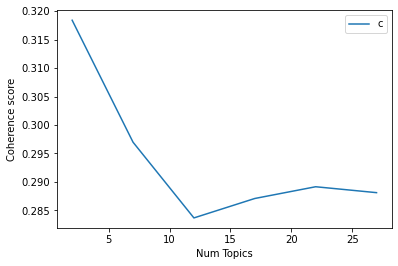

In [56]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [57]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3184
index: 1 | Num Topics = 7  has Coherence Value of 0.297
index: 2 | Num Topics = 12  has Coherence Value of 0.2837
index: 3 | Num Topics = 17  has Coherence Value of 0.2871
index: 4 | Num Topics = 22  has Coherence Value of 0.2892
index: 5 | Num Topics = 27  has Coherence Value of 0.2881


In [58]:
# Select optimal number of topics
optimal_model_us_score2 = model_list_us_score2[0]

In [59]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score2 = pyLDAvis.gensim_models.prepare(optimal_model_us_score2, corpus_us_score2, id2word_us_score2)

In [60]:
print("pyLDAVis for us topics for score=2:")
vis_us_score2

pyLDAVis for us topics for score=2:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.063725  0.0       1        1  54.416544
0     -0.063725  0.0       2        1  45.583456, topic_info=        Term        Freq       Total Category  logprob  loglift
102  account  115.000000  115.000000  Default  30.0000  30.0000
3        app  377.000000  377.000000  Default  29.0000  29.0000
13    friend  163.000000  163.000000  Default  28.0000  28.0000
249    share   60.000000   60.000000  Default  27.0000  27.0000
74     video  111.000000  111.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
265     keep   32.115609   84.940873   Topic2  -5.4765  -0.1870
12       fix   32.526781   94.742946   Topic2  -5.4638  -0.2835
118      way   28.636821   75.299610   Topic2  -5.5911  -0.1812
161   delete   27.457897   61.072503   Topic2  -5.6332  -0.0138
100   update   28.287401  175.340301   Topic2  -5.6034  -1.0387

[173 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
102       1  0.025957  account
102       2  0.969064  account
42        1  0.415937       ad
42        2  0.576945       ad
120       1  0.893510      add
...     ...       ...      ...
682       1  0.998611      web
342       1  0.475694     well
342       2  0.537074     well
343       1  0.874266     work
343       2  0.126539     work

[214 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## LDA Topic Modelling (Rating = 3)

In [61]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_us_score3 = facebook_ios_us_review_YearMonth_score3.review.values.tolist()
review_words_us_score3 = list(sent_to_words(review_us_score3))
print(review_words_us_score3[:1])

[['event', 'planning', 'on', 'iphone', 'running', 'newest', 'ios', 'and', 'newest', 'version', 'fb', 'is', 'not', 'very', 'user', 'friendly', 'my', 'first', 'event', 'planned', 'on', 'fb', 'was', 'bit', 'annoying', 'due', 'to', 'text', 'box', 'disappearing', 'whenever', 'would', 'try', 'to', 'type', 'info', 'for', 'party', 'then', 'as', 'tried', 'to', 'add', 'two', 'co', 'hosts', 'fb', 'said', 'action', 'cannot', 'be', 'completed', 'at', 'this', 'time', 'but', 'still', 'added', 'one', 'person', 'and', 'would', 'not', 'allow', 'me', 'to', 'add', 'them', 'both', 'at', 'no', 'time', 'did', 'fb', 'tell', 'me', 'one', 'co', 'host', 'allowed', 'or', 'anything', 'like', 'that', 'making', 'me', 'think', 'they', 'both', 'been', 'added', 'until', 'saved', 'changed', 'and', 'looked', 'slightly', 'annoying', 'now', 'have', 'to', 'explain', 'why', 'let', 'one', 'female', 'co', 'host', 'and', 'not', 'the', 'other', 'thanks', 'fb']]


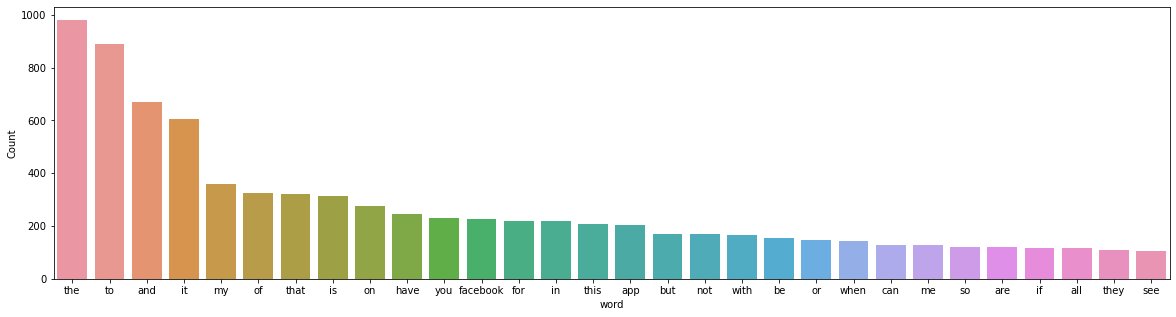

In [62]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score3))

In [63]:
# Clean text
review_us_ready_score3 = process_words(review_words_us_score3)  # processed Text Data! - move to each section


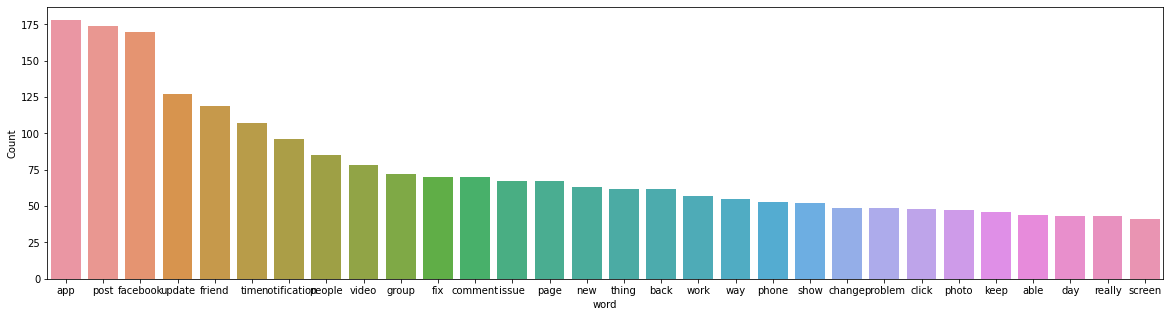

In [64]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score3))


In [65]:
# Create Dictionary
id2word_us_score3 = corpora.Dictionary(review_us_ready_score3)

2021-10-16 19:22:15,818 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:22:15,844 [INFO] gensim.corpora.dictionary - built Dictionary(1763 unique tokens: ['action', 'add', 'allow', 'annoying', 'bit']...) from 174 documents (total 8725 corpus positions)
2021-10-16 19:22:15,845 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1763 unique tokens: ['action', 'add', 'allow', 'annoying', 'bit']...) from 174 documents (total 8725 corpus positions)", 'datetime': '2021-10-16T19:22:15.845524', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [66]:
# Create Corpus: Term Document Frequency
corpus_us_score3 = [id2word_us_score3.doc2bow(text) for text in review_us_ready_score3]

In [67]:
# Training LDA model
model_list_us_score3, coherence_values_us_score3 = compute_coherence_values(dictionary=id2word_us_score3, corpus=corpus_us_score3, 
                                                              texts=review_us_ready_score3, limit=30, start=2, step=5)


2021-10-16 19:22:15,926 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:22:15,932 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:22:15,937 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:22:15,940 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 174 documents, updating model once every 174 documents, evaluating perplexity every 174 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:22:16,636 [INFO] gensim.models.ldamodel - -7.994 per-word bound, 254.9 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:22:16,639 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #174/174
2021-10-16 19:22:17,237 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.021*"post" + 0.019*"app" + 0.015*"facebook" + 0.014*"friend" + 0.011*"update" + 0.010*"people" + 0.009

2021-10-16 19:22:25,512 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.015*"app" + 0.015*"facebook" + 0.013*"friend" + 0.011*"update" + 0.011*"group" + 0.010*"people" + 0.009*"time" + 0.009*"issue" + 0.007*"picture"
2021-10-16 19:22:25,513 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"app" + 0.018*"facebook" + 0.017*"notification" + 0.013*"update" + 0.012*"time" + 0.011*"video" + 0.009*"comment" + 0.009*"friend" + 0.009*"post" + 0.008*"page"
2021-10-16 19:22:25,514 [INFO] gensim.models.ldamodel - topic diff=0.008865, rho=0.301511
2021-10-16 19:22:26,023 [INFO] gensim.models.ldamodel - -6.781 per-word bound, 109.9 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:22:26,024 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #174/174
2021-10-16 19:22:26,433 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"post" + 0.015*"app" + 0.015*"facebook" + 0.013*"friend" + 0.011*"update" + 0.011*"group" + 

2021-10-16 19:22:34,170 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"app" + 0.015*"facebook" + 0.013*"friend" + 0.012*"update" + 0.011*"group" + 0.010*"people" + 0.009*"time" + 0.009*"issue" + 0.007*"picture"
2021-10-16 19:22:34,174 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"app" + 0.018*"facebook" + 0.017*"notification" + 0.013*"update" + 0.012*"time" + 0.011*"video" + 0.009*"comment" + 0.009*"friend" + 0.008*"page" + 0.008*"post"
2021-10-16 19:22:34,177 [INFO] gensim.models.ldamodel - topic diff=0.001948, rho=0.218218
2021-10-16 19:22:34,676 [INFO] gensim.models.ldamodel - -6.779 per-word bound, 109.8 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:22:34,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #174/174
2021-10-16 19:22:34,990 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"app" + 0.015*"facebook" + 0.013*"friend" + 0.012*"update" + 0.011*"group" + 

2021-10-16 19:22:42,563 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"facebook" + 0.015*"app" + 0.014*"friend" + 0.012*"update" + 0.012*"group" + 0.010*"people" + 0.009*"time" + 0.009*"issue" + 0.007*"picture"
2021-10-16 19:22:42,565 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"app" + 0.017*"facebook" + 0.017*"notification" + 0.013*"update" + 0.012*"video" + 0.012*"time" + 0.009*"comment" + 0.009*"friend" + 0.008*"page" + 0.008*"post"
2021-10-16 19:22:42,566 [INFO] gensim.models.ldamodel - topic diff=0.001427, rho=0.179605
2021-10-16 19:22:42,988 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.8 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:22:42,990 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #174/174
2021-10-16 19:22:43,309 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"facebook" + 0.015*"app" + 0.014*"friend" + 0.012*"update" + 0.012*"group" + 

2021-10-16 19:22:50,785 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"facebook" + 0.015*"app" + 0.014*"friend" + 0.012*"group" + 0.012*"update" + 0.010*"people" + 0.009*"time" + 0.009*"issue" + 0.007*"picture"
2021-10-16 19:22:50,788 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.019*"app" + 0.017*"facebook" + 0.017*"notification" + 0.013*"video" + 0.013*"update" + 0.012*"time" + 0.009*"comment" + 0.009*"friend" + 0.008*"page" + 0.007*"post"
2021-10-16 19:22:50,793 [INFO] gensim.models.ldamodel - topic diff=0.001336, rho=0.156174
2021-10-16 19:22:51,268 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:22:51,269 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #174/174
2021-10-16 19:22:51,643 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"facebook" + 0.015*"app" + 0.014*"friend" + 0.012*"group" + 0.012*"update" + 

2021-10-16 19:22:59,038 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.015*"facebook" + 0.015*"app" + 0.014*"friend" + 0.012*"group" + 0.012*"update" + 0.010*"people" + 0.009*"time" + 0.009*"issue" + 0.007*"picture"
2021-10-16 19:22:59,040 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.017*"facebook" + 0.017*"notification" + 0.013*"video" + 0.013*"update" + 0.012*"time" + 0.009*"comment" + 0.009*"friend" + 0.008*"page" + 0.007*"post"
2021-10-16 19:22:59,041 [INFO] gensim.models.ldamodel - topic diff=0.001392, rho=0.140028
2021-10-16 19:22:59,042 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1763, num_topics=2, decay=0.5, chunksize=1000) in 43.10s', 'datetime': '2021-10-16T19:22:59.042959', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:22:59,047 [INFO] gensim.topic_coherence.probability_estim

2021-10-16 19:23:06,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #174/174
2021-10-16 19:23:06,763 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"update" + 0.018*"app" + 0.017*"post" + 0.017*"facebook" + 0.017*"notification" + 0.017*"time" + 0.012*"page" + 0.010*"screen" + 0.009*"friend" + 0.009*"happen"
2021-10-16 19:23:06,765 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"post" + 0.024*"friend" + 0.014*"app" + 0.014*"update" + 0.013*"issue" + 0.013*"facebook" + 0.012*"people" + 0.011*"time" + 0.011*"group" + 0.010*"picture"
2021-10-16 19:23:06,766 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.016*"app" + 0.016*"post" + 0.014*"facebook" + 0.011*"page" + 0.010*"time" + 0.010*"change" + 0.009*"picture" + 0.009*"year" + 0.009*"people" + 0.008*"group"
2021-10-16 19:23:06,769 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"comment" + 0.025*"facebook" + 0.014*"notification" + 0.013*"post" + 0.013*"friend" + 0.013*"new" + 0.012*"app" + 0

2021-10-16 19:23:09,533 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"notification" + 0.019*"app" + 0.018*"facebook" + 0.012*"group" + 0.011*"video" + 0.011*"friend" + 0.011*"update" + 0.011*"click" + 0.010*"fix" + 0.009*"scroll"
2021-10-16 19:23:09,537 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"comment" + 0.026*"facebook" + 0.015*"notification" + 0.014*"post" + 0.013*"friend" + 0.013*"new" + 0.012*"app" + 0.011*"group" + 0.010*"problem" + 0.010*"click"
2021-10-16 19:23:09,541 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"app" + 0.019*"update" + 0.014*"phone" + 0.012*"photo" + 0.011*"facebook" + 0.009*"ipad" + 0.008*"account" + 0.008*"iphone" + 0.008*"never" + 0.008*"time"
2021-10-16 19:23:09,545 [INFO] gensim.models.ldamodel - topic diff=0.028545, rho=0.301511
2021-10-16 19:23:09,860 [INFO] gensim.models.ldamodel - -6.959 per-word bound, 124.4 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:09,861 [IN

2021-10-16 19:23:12,122 [INFO] gensim.models.ldamodel - topic diff=0.009469, rho=0.250000
2021-10-16 19:23:12,424 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:12,426 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #174/174
2021-10-16 19:23:12,620 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"notification" + 0.018*"facebook" + 0.017*"app" + 0.012*"group" + 0.011*"video" + 0.011*"friend" + 0.010*"update" + 0.010*"click" + 0.010*"fix" + 0.009*"scroll"
2021-10-16 19:23:12,621 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"app" + 0.019*"update" + 0.015*"phone" + 0.011*"photo" + 0.011*"facebook" + 0.009*"ipad" + 0.008*"account" + 0.008*"iphone" + 0.008*"never" + 0.008*"time"
2021-10-16 19:23:12,622 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"post" + 0.025*"friend" + 0.014*"update" + 0.014*"app" + 0.013*"issue" + 0.013*"facebook" + 0

2021-10-16 19:23:15,364 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"app" + 0.019*"update" + 0.015*"phone" + 0.011*"photo" + 0.010*"facebook" + 0.010*"ipad" + 0.008*"account" + 0.008*"iphone" + 0.008*"never" + 0.008*"time"
2021-10-16 19:23:15,365 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.016*"app" + 0.016*"post" + 0.014*"facebook" + 0.011*"page" + 0.010*"change" + 0.010*"year" + 0.010*"picture" + 0.010*"time" + 0.009*"people" + 0.009*"group"
2021-10-16 19:23:15,366 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"post" + 0.026*"friend" + 0.014*"update" + 0.013*"app" + 0.013*"issue" + 0.013*"facebook" + 0.013*"people" + 0.011*"time" + 0.011*"group" + 0.010*"picture"
2021-10-16 19:23:15,367 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"video" + 0.020*"app" + 0.014*"facebook" + 0.012*"time" + 0.011*"change" + 0.011*"phone" + 0.011*"update" + 0.010*"watch" + 0.008*"issue" + 0.007*"people"
2021-10-16 19:23:15,368 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:23:17,933 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"post" + 0.026*"friend" + 0.014*"update" + 0.013*"app" + 0.013*"issue" + 0.013*"facebook" + 0.013*"people" + 0.011*"time" + 0.011*"group" + 0.010*"picture"
2021-10-16 19:23:17,935 [INFO] gensim.models.ldamodel - topic diff=0.002048, rho=0.192450
2021-10-16 19:23:18,189 [INFO] gensim.models.ldamodel - -6.951 per-word bound, 123.7 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:18,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #174/174
2021-10-16 19:23:18,467 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"app" + 0.019*"update" + 0.015*"phone" + 0.011*"photo" + 0.010*"facebook" + 0.010*"ipad" + 0.008*"account" + 0.008*"iphone" + 0.008*"never" + 0.008*"time"
2021-10-16 19:23:18,476 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"video" + 0.020*"app" + 0.014*"facebook" + 0.012*"time" + 0.011*"change" + 0.011*"phone" + 0.011*"

2021-10-16 19:23:21,202 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"video" + 0.020*"app" + 0.014*"facebook" + 0.012*"time" + 0.011*"change" + 0.011*"phone" + 0.011*"watch" + 0.011*"update" + 0.008*"issue" + 0.007*"people"
2021-10-16 19:23:21,204 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"comment" + 0.026*"facebook" + 0.015*"notification" + 0.014*"post" + 0.013*"friend" + 0.013*"new" + 0.012*"app" + 0.011*"group" + 0.011*"problem" + 0.010*"click"
2021-10-16 19:23:21,206 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"post" + 0.026*"friend" + 0.014*"update" + 0.013*"app" + 0.013*"issue" + 0.013*"facebook" + 0.013*"people" + 0.011*"time" + 0.011*"group" + 0.010*"picture"
2021-10-16 19:23:21,209 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"notification" + 0.018*"facebook" + 0.017*"app" + 0.012*"group" + 0.011*"video" + 0.011*"friend" + 0.010*"update" + 0.010*"fix" + 0.010*"click" + 0.009*"scroll"
2021-10-16 19:23:21,211 [INFO] gensim.models.l

2021-10-16 19:23:23,922 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.029*"comment" + 0.026*"facebook" + 0.015*"notification" + 0.014*"post" + 0.013*"friend" + 0.013*"new" + 0.012*"app" + 0.011*"group" + 0.011*"problem" + 0.010*"click"
2021-10-16 19:23:23,928 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"app" + 0.019*"update" + 0.015*"phone" + 0.010*"photo" + 0.010*"facebook" + 0.010*"ipad" + 0.008*"account" + 0.008*"never" + 0.008*"iphone" + 0.008*"time"
2021-10-16 19:23:23,930 [INFO] gensim.models.ldamodel - topic diff=0.001047, rho=0.162221
2021-10-16 19:23:24,262 [INFO] gensim.models.ldamodel - -6.950 per-word bound, 123.6 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:24,263 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #174/174
2021-10-16 19:23:24,484 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"notification" + 0.018*"facebook" + 0.016*"app" + 0.012*"group" + 0.011*"video" + 0.011*"fri

2021-10-16 19:23:26,901 [INFO] gensim.models.ldamodel - -6.949 per-word bound, 123.6 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:26,902 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #174/174
2021-10-16 19:23:27,051 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"notification" + 0.018*"facebook" + 0.016*"app" + 0.012*"group" + 0.011*"video" + 0.011*"friend" + 0.010*"update" + 0.010*"fix" + 0.010*"scroll" + 0.009*"click"
2021-10-16 19:23:27,054 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"post" + 0.026*"friend" + 0.014*"update" + 0.013*"issue" + 0.013*"app" + 0.013*"facebook" + 0.013*"people" + 0.011*"time" + 0.011*"group" + 0.010*"picture"
2021-10-16 19:23:27,055 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"update" + 0.021*"app" + 0.018*"time" + 0.017*"notification" + 0.017*"facebook" + 0.016*"post" + 0.012*"page" + 0.011*"screen" + 0.009*"friend" + 0.009*"issue"
2021-10-16 19:23:27,05

2021-10-16 19:23:29,713 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"app" + 0.020*"update" + 0.015*"phone" + 0.010*"photo" + 0.010*"facebook" + 0.010*"ipad" + 0.008*"account" + 0.008*"never" + 0.008*"iphone" + 0.008*"time"
2021-10-16 19:23:29,716 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.016*"app" + 0.016*"post" + 0.014*"facebook" + 0.012*"page" + 0.010*"change" + 0.010*"year" + 0.010*"group" + 0.010*"time" + 0.010*"picture" + 0.009*"people"
2021-10-16 19:23:29,717 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"update" + 0.021*"app" + 0.018*"time" + 0.017*"notification" + 0.017*"facebook" + 0.016*"post" + 0.012*"page" + 0.011*"screen" + 0.009*"friend" + 0.009*"issue"
2021-10-16 19:23:29,719 [INFO] gensim.models.ldamodel - topic diff=0.000828, rho=0.142857
2021-10-16 19:23:30,101 [INFO] gensim.models.ldamodel - -6.948 per-word bound, 123.5 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:30,102 [INFO] gensim

2021-10-16 19:23:37,074 [INFO] gensim.models.ldamodel - topic diff=0.475119, rho=0.577350
2021-10-16 19:23:37,506 [INFO] gensim.models.ldamodel - -7.240 per-word bound, 151.2 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:37,507 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #174/174
2021-10-16 19:23:37,748 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.037*"notification" + 0.019*"facebook" + 0.018*"page" + 0.017*"people" + 0.017*"post" + 0.014*"group" + 0.014*"app" + 0.013*"phone" + 0.013*"click" + 0.012*"update"
2021-10-16 19:23:37,750 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.020*"facebook" + 0.012*"post" + 0.012*"video" + 0.011*"new" + 0.011*"watch" + 0.010*"app" + 0.009*"day" + 0.009*"comment" + 0.009*"problem" + 0.009*"update"
2021-10-16 19:23:37,751 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.045*"post" + 0.030*"friend" + 0.018*"update" + 0.016*"app" + 0.015*"time" + 0.012*"issue" + 0.011*"pi

2021-10-16 19:23:40,253 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.021*"update" + 0.019*"time" + 0.015*"post" + 0.011*"facebook" + 0.011*"page" + 0.010*"work" + 0.010*"set" + 0.009*"happen" + 0.009*"new" + 0.008*"add"
2021-10-16 19:23:40,254 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"app" + 0.022*"facebook" + 0.018*"post" + 0.014*"comment" + 0.014*"video" + 0.013*"update" + 0.012*"fix" + 0.011*"notification" + 0.010*"time" + 0.009*"friend"
2021-10-16 19:23:40,257 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"app" + 0.019*"update" + 0.016*"phone" + 0.015*"account" + 0.013*"never" + 0.012*"number" + 0.011*"time" + 0.010*"delete" + 0.010*"ipad" + 0.008*"appear"
2021-10-16 19:23:40,259 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.040*"notification" + 0.020*"facebook" + 0.019*"page" + 0.018*"post" + 0.018*"people" + 0.017*"group" + 0.015*"app" + 0.014*"click" + 0.014*"phone" + 0.012*"update"
2021-10-16 19:23:40,260 [INFO] gensim.models.ldamodel - to

2021-10-16 19:23:42,867 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"facebook" + 0.012*"video" + 0.011*"watch" + 0.011*"new" + 0.010*"day" + 0.010*"problem" + 0.009*"app" + 0.008*"post" + 0.008*"help" + 0.008*"email"
2021-10-16 19:23:42,868 [INFO] gensim.models.ldamodel - topic diff=0.019658, rho=0.267261
2021-10-16 19:23:43,129 [INFO] gensim.models.ldamodel - -7.043 per-word bound, 131.9 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:43,131 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #174/174
2021-10-16 19:23:43,334 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"app" + 0.021*"video" + 0.016*"issue" + 0.014*"time" + 0.011*"post" + 0.011*"people" + 0.011*"facebook" + 0.010*"change" + 0.009*"watch" + 0.009*"keep"
2021-10-16 19:23:43,341 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"group" + 0.016*"people" + 0.016*"tab" + 0.015*"profile" + 0.013*"suggestion" + 0.013*"iphone" + 0.012*"giv

2021-10-16 19:23:45,734 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"post" + 0.033*"friend" + 0.019*"update" + 0.016*"app" + 0.015*"time" + 0.012*"people" + 0.012*"issue" + 0.012*"picture" + 0.011*"back" + 0.009*"facebook"
2021-10-16 19:23:45,735 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"facebook" + 0.017*"page" + 0.015*"group" + 0.014*"time" + 0.014*"ad" + 0.013*"way" + 0.012*"video" + 0.012*"friend" + 0.011*"back" + 0.009*"start"
2021-10-16 19:23:45,736 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"notification" + 0.020*"facebook" + 0.019*"page" + 0.018*"post" + 0.017*"people" + 0.017*"group" + 0.016*"app" + 0.015*"click" + 0.014*"phone" + 0.011*"update"
2021-10-16 19:23:45,738 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"app" + 0.021*"video" + 0.016*"issue" + 0.014*"time" + 0.011*"post" + 0.011*"people" + 0.011*"facebook" + 0.010*"change" + 0.009*"watch" + 0.009*"keep"
2021-10-16 19:23:45,739 [INFO] gensim.models.ldamodel - topic #6 

2021-10-16 19:23:48,306 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"notification" + 0.017*"last" + 0.015*"friend" + 0.014*"page" + 0.014*"app" + 0.014*"update" + 0.012*"note" + 0.012*"name" + 0.010*"view" + 0.009*"facebook"
2021-10-16 19:23:48,312 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"group" + 0.016*"people" + 0.016*"tab" + 0.015*"profile" + 0.013*"suggestion" + 0.013*"iphone" + 0.012*"give" + 0.011*"new" + 0.010*"feature" + 0.010*"back"
2021-10-16 19:23:48,316 [INFO] gensim.models.ldamodel - topic diff=0.003475, rho=0.200000
2021-10-16 19:23:48,548 [INFO] gensim.models.ldamodel - -7.034 per-word bound, 131.1 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:48,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #174/174
2021-10-16 19:23:48,728 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"notification" + 0.020*"facebook" + 0.019*"page" + 0.018*"post" + 0.017*"group" + 0.017*"peopl

2021-10-16 19:23:51,043 [INFO] gensim.models.ldamodel - -7.032 per-word bound, 130.9 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:51,044 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #174/174
2021-10-16 19:23:51,190 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"facebook" + 0.012*"video" + 0.011*"watch" + 0.010*"new" + 0.010*"day" + 0.010*"problem" + 0.009*"app" + 0.008*"help" + 0.008*"email" + 0.008*"date"
2021-10-16 19:23:51,191 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"group" + 0.016*"people" + 0.016*"tab" + 0.015*"profile" + 0.013*"suggestion" + 0.013*"iphone" + 0.012*"give" + 0.011*"new" + 0.010*"feature" + 0.010*"back"
2021-10-16 19:23:51,193 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"notification" + 0.017*"last" + 0.015*"friend" + 0.014*"app" + 0.014*"page" + 0.014*"update" + 0.012*"note" + 0.012*"name" + 0.010*"view" + 0.009*"facebook"
2021-10-16 19:23:51,194 [INFO] gens

2021-10-16 19:23:53,628 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.021*"update" + 0.021*"time" + 0.015*"post" + 0.011*"page" + 0.011*"facebook" + 0.010*"set" + 0.009*"new" + 0.009*"work" + 0.009*"add" + 0.009*"search"
2021-10-16 19:23:53,629 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"video" + 0.021*"app" + 0.016*"issue" + 0.014*"time" + 0.011*"post" + 0.011*"people" + 0.011*"facebook" + 0.010*"change" + 0.009*"watch" + 0.009*"keep"
2021-10-16 19:23:53,630 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"facebook" + 0.012*"video" + 0.011*"watch" + 0.010*"new" + 0.010*"day" + 0.010*"problem" + 0.009*"app" + 0.008*"help" + 0.008*"email" + 0.008*"date"
2021-10-16 19:23:53,631 [INFO] gensim.models.ldamodel - topic diff=0.001392, rho=0.166667
2021-10-16 19:23:53,895 [INFO] gensim.models.ldamodel - -7.031 per-word bound, 130.8 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:53,896 [INFO] gensim.models.ldamodel - P

2021-10-16 19:23:56,137 [INFO] gensim.models.ldamodel - topic diff=0.000971, rho=0.156174
2021-10-16 19:23:56,495 [INFO] gensim.models.ldamodel - -7.030 per-word bound, 130.7 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:23:56,496 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #174/174
2021-10-16 19:23:56,626 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.051*"post" + 0.033*"friend" + 0.019*"update" + 0.016*"app" + 0.015*"time" + 0.012*"people" + 0.012*"issue" + 0.011*"picture" + 0.011*"back" + 0.009*"facebook"
2021-10-16 19:23:56,628 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"notification" + 0.017*"last" + 0.015*"friend" + 0.014*"app" + 0.014*"page" + 0.014*"update" + 0.012*"name" + 0.012*"note" + 0.010*"view" + 0.009*"facebook"
2021-10-16 19:23:56,629 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"app" + 0.022*"facebook" + 0.017*"post" + 0.015*"comment" + 0.015*"video" + 0.012*"update" + 0.0

2021-10-16 19:23:59,002 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.020*"app" + 0.016*"change" + 0.016*"picture" + 0.014*"profile" + 0.013*"people" + 0.012*"website" + 0.010*"notification" + 0.010*"photo" + 0.008*"facebook" + 0.008*"often"
2021-10-16 19:23:59,004 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"app" + 0.022*"facebook" + 0.017*"post" + 0.015*"comment" + 0.015*"video" + 0.012*"update" + 0.012*"fix" + 0.011*"notification" + 0.011*"time" + 0.009*"friend"
2021-10-16 19:23:59,006 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.021*"facebook" + 0.012*"video" + 0.011*"watch" + 0.010*"new" + 0.010*"day" + 0.010*"problem" + 0.009*"app" + 0.008*"help" + 0.008*"email" + 0.008*"date"
2021-10-16 19:23:59,009 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.021*"update" + 0.021*"time" + 0.015*"post" + 0.011*"page" + 0.010*"facebook" + 0.010*"set" + 0.009*"new" + 0.009*"work" + 0.009*"add" + 0.009*"search"
2021-10-16 19:23:59,010 [INFO] gensim.models.ldamodel -

2021-10-16 19:24:06,650 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 174 documents, updating model once every 174 documents, evaluating perplexity every 174 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:24:07,255 [INFO] gensim.models.ldamodel - -13.392 per-word bound, 10750.2 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:07,256 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #174/174
2021-10-16 19:24:07,773 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.034*"facebook" + 0.024*"app" + 0.023*"friend" + 0.020*"update" + 0.015*"people" + 0.013*"post" + 0.011*"group" + 0.011*"back" + 0.010*"time" + 0.010*"way"
2021-10-16 19:24:07,775 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.017*"page" + 0.013*"photo" + 0.011*"story" + 0.011*"update" + 0.010*"post" + 0.010*"version" + 0.009*"thing" + 0.009*"back" + 0

2021-10-16 19:24:10,276 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"comment" + 0.022*"facebook" + 0.020*"friend" + 0.019*"new" + 0.016*"notification" + 0.014*"video" + 0.012*"show" + 0.012*"post" + 0.011*"still" + 0.011*"photo"
2021-10-16 19:24:10,283 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.030*"tab" + 0.022*"group" + 0.016*"time" + 0.011*"back" + 0.011*"profile" + 0.011*"new" + 0.011*"feature" + 0.011*"friend" + 0.011*"people" + 0.011*"keep"
2021-10-16 19:24:10,290 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.023*"app" + 0.018*"phone" + 0.017*"account" + 0.013*"facebook" + 0.012*"number" + 0.012*"send" + 0.011*"ipad" + 0.010*"update" + 0.010*"delete" + 0.010*"able"
2021-10-16 19:24:10,295 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.026*"facebook" + 0.026*"time" + 0.019*"ad" + 0.017*"video" + 0.016*"start" + 0.014*"way" + 0.014*"phone" + 0.011*"space" + 0.011*"end" + 0.010*"group"
2021-10-16 19:24:10,300 [INFO] gensim.models.ldamodel - topic #2 

2021-10-16 19:24:12,664 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.031*"update" + 0.027*"page" + 0.018*"problem" + 0.013*"app" + 0.012*"screen" + 0.011*"video" + 0.011*"game" + 0.011*"respond" + 0.011*"group" + 0.011*"message"
2021-10-16 19:24:12,668 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"time" + 0.026*"facebook" + 0.019*"ad" + 0.017*"video" + 0.016*"start" + 0.014*"phone" + 0.014*"way" + 0.011*"space" + 0.011*"end" + 0.010*"group"
2021-10-16 19:24:12,673 [INFO] gensim.models.ldamodel - topic diff=0.039922, rho=0.288675
2021-10-16 19:24:12,922 [INFO] gensim.models.ldamodel - -7.115 per-word bound, 138.7 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:12,926 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #174/174
2021-10-16 19:24:13,096 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.023*"app" + 0.019*"phone" + 0.017*"account" + 0.014*"number" + 0.014*"send" + 0.013*"facebook" + 0.011*"ipad"

2021-10-16 19:24:15,351 [INFO] gensim.models.ldamodel - -7.109 per-word bound, 138.0 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:15,353 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #174/174
2021-10-16 19:24:15,493 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.026*"video" + 0.019*"change" + 0.017*"issue" + 0.014*"post" + 0.014*"keep" + 0.014*"phone" + 0.013*"facebook" + 0.012*"iphone" + 0.012*"crash" + 0.012*"app"
2021-10-16 19:24:15,494 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"facebook" + 0.029*"app" + 0.023*"update" + 0.021*"friend" + 0.014*"people" + 0.012*"group" + 0.012*"time" + 0.011*"view" + 0.010*"mode" + 0.010*"work"
2021-10-16 19:24:15,496 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.017*"post" + 0.017*"update" + 0.015*"time" + 0.014*"facebook" + 0.012*"happen" + 0.012*"feature" + 0.010*"search" + 0.010*"new" + 0.010*"work" + 0.009*"issue"
2021-10-16 19:24:15,497 [INFO] gensim.

2021-10-16 19:24:17,977 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.042*"post" + 0.027*"friend" + 0.017*"update" + 0.016*"picture" + 0.014*"issue" + 0.013*"back" + 0.012*"app" + 0.011*"people" + 0.011*"time" + 0.010*"profile"
2021-10-16 19:24:17,979 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"app" + 0.020*"video" + 0.020*"post" + 0.015*"facebook" + 0.012*"fix" + 0.012*"update" + 0.011*"watch" + 0.011*"notification" + 0.011*"scroll" + 0.010*"time"
2021-10-16 19:24:17,980 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.026*"page" + 0.017*"story" + 0.017*"post" + 0.013*"update" + 0.013*"thing" + 0.013*"facebook" + 0.013*"people" + 0.013*"work" + 0.010*"photo" + 0.010*"version"
2021-10-16 19:24:17,981 [INFO] gensim.models.ldamodel - topic diff=0.003770, rho=0.208514
2021-10-16 19:24:18,266 [INFO] gensim.models.ldamodel - -7.106 per-word bound, 137.7 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:18,268 [INFO] gens

2021-10-16 19:24:20,270 [INFO] gensim.models.ldamodel - topic diff=0.001896, rho=0.188982
2021-10-16 19:24:20,501 [INFO] gensim.models.ldamodel - -7.104 per-word bound, 137.6 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:20,502 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #174/174
2021-10-16 19:24:20,650 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.042*"post" + 0.027*"friend" + 0.017*"update" + 0.016*"picture" + 0.014*"issue" + 0.013*"back" + 0.012*"app" + 0.011*"people" + 0.011*"time" + 0.010*"profile"
2021-10-16 19:24:20,652 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"group" + 0.022*"account" + 0.018*"notification" + 0.015*"people" + 0.015*"suggestion" + 0.015*"give" + 0.011*"thing" + 0.011*"let" + 0.007*"facebook" + 0.007*"update"
2021-10-16 19:24:20,654 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.024*"facebook" + 0.022*"post" + 0.019*"people" + 0.014*"friend" + 0.012*"work" + 0.011*"w

2021-10-16 19:24:23,181 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.048*"notification" + 0.016*"keep" + 0.015*"really" + 0.015*"facebook" + 0.015*"post" + 0.014*"app" + 0.014*"phone" + 0.013*"way" + 0.013*"new" + 0.011*"click"
2021-10-16 19:24:23,182 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.026*"page" + 0.017*"story" + 0.017*"post" + 0.013*"update" + 0.013*"thing" + 0.013*"facebook" + 0.013*"people" + 0.013*"work" + 0.010*"photo" + 0.010*"version"
2021-10-16 19:24:23,184 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.031*"update" + 0.026*"page" + 0.019*"problem" + 0.013*"app" + 0.012*"screen" + 0.012*"video" + 0.011*"game" + 0.011*"respond" + 0.011*"group" + 0.011*"message"
2021-10-16 19:24:23,186 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"facebook" + 0.029*"app" + 0.024*"update" + 0.021*"friend" + 0.014*"people" + 0.012*"group" + 0.012*"time" + 0.011*"view" + 0.010*"mode" + 0.010*"work"
2021-10-16 19:24:23,187 [INFO] gensim.models.ldamodel - to

2021-10-16 19:24:25,652 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.017*"post" + 0.017*"update" + 0.015*"time" + 0.014*"facebook" + 0.012*"happen" + 0.012*"feature" + 0.010*"search" + 0.010*"new" + 0.009*"work" + 0.009*"issue"
2021-10-16 19:24:25,653 [INFO] gensim.models.ldamodel - topic diff=0.000724, rho=0.160128
2021-10-16 19:24:25,873 [INFO] gensim.models.ldamodel - -7.102 per-word bound, 137.4 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:25,875 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #174/174
2021-10-16 19:24:26,035 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.031*"notification" + 0.020*"last" + 0.020*"note" + 0.020*"name" + 0.017*"update" + 0.014*"click" + 0.014*"picture" + 0.014*"view" + 0.012*"thing" + 0.011*"app"
2021-10-16 19:24:26,038 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"group" + 0.022*"account" + 0.018*"notification" + 0.015*"people" + 0.015*"suggestion" + 0.015*"g

2021-10-16 19:24:28,554 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.031*"notification" + 0.020*"last" + 0.020*"note" + 0.020*"name" + 0.017*"update" + 0.014*"click" + 0.014*"picture" + 0.014*"view" + 0.012*"thing" + 0.011*"app"
2021-10-16 19:24:28,557 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"time" + 0.027*"facebook" + 0.020*"ad" + 0.016*"video" + 0.016*"start" + 0.014*"phone" + 0.014*"way" + 0.011*"space" + 0.011*"end" + 0.010*"group"
2021-10-16 19:24:28,559 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"group" + 0.022*"account" + 0.018*"notification" + 0.015*"people" + 0.015*"suggestion" + 0.015*"give" + 0.011*"thing" + 0.011*"let" + 0.007*"facebook" + 0.007*"update"
2021-10-16 19:24:28,561 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.026*"page" + 0.017*"story" + 0.017*"post" + 0.013*"update" + 0.013*"thing" + 0.013*"facebook" + 0.013*"people" + 0.013*"work" + 0.010*"photo" + 0.010*"version"
2021-10-16 19:24:28,564 [INFO] gensim.models.ldamod

2021-10-16 19:24:30,814 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"post" + 0.027*"friend" + 0.017*"update" + 0.016*"picture" + 0.014*"issue" + 0.012*"back" + 0.012*"app" + 0.011*"people" + 0.011*"time" + 0.010*"profile"
2021-10-16 19:24:30,816 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.022*"app" + 0.017*"facebook" + 0.013*"people" + 0.011*"post" + 0.011*"time" + 0.011*"notification" + 0.009*"iphone" + 0.008*"profile" + 0.008*"still" + 0.008*"often"
2021-10-16 19:24:30,818 [INFO] gensim.models.ldamodel - topic diff=0.000359, rho=0.141421
2021-10-16 19:24:31,102 [INFO] gensim.models.ldamodel - -7.102 per-word bound, 137.3 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:31,103 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #174/174
2021-10-16 19:24:31,252 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.038*"app" + 0.020*"video" + 0.019*"post" + 0.015*"facebook" + 0.012*"fix" + 0.012*"update" + 0.0

2021-10-16 19:24:40,159 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #174/174
2021-10-16 19:24:40,362 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.025*"post" + 0.023*"picture" + 0.018*"time" + 0.017*"profile" + 0.016*"change" + 0.013*"group" + 0.012*"app" + 0.011*"people" + 0.009*"delete" + 0.009*"add"
2021-10-16 19:24:40,363 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.014*"still" + 0.014*"photo" + 0.014*"version" + 0.013*"upload" + 0.013*"car" + 0.013*"filter" + 0.009*"facebook" + 0.009*"way" + 0.009*"browser" + 0.009*"news"
2021-10-16 19:24:40,364 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.027*"facebook" + 0.026*"people" + 0.024*"post" + 0.017*"page" + 0.017*"keep" + 0.014*"year" + 0.012*"friend" + 0.012*"find" + 0.010*"app" + 0.010*"update"
2021-10-16 19:24:40,366 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.028*"notification" + 0.021*"update" + 0.018*"app" + 0.017*"click" + 0.013*"watch" + 0.013*"video" + 0.011*"group" + 0.010*"sound

2021-10-16 19:24:42,782 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.030*"post" + 0.021*"notification" + 0.021*"still" + 0.021*"comment" + 0.019*"new" + 0.017*"facebook" + 0.016*"show" + 0.012*"date" + 0.011*"video" + 0.011*"group"
2021-10-16 19:24:42,785 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.030*"app" + 0.019*"notification" + 0.017*"page" + 0.014*"comment" + 0.011*"friend" + 0.011*"phone" + 0.011*"update" + 0.011*"crash" + 0.011*"send" + 0.011*"new"
2021-10-16 19:24:42,788 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.024*"facebook" + 0.018*"friend" + 0.018*"problem" + 0.017*"time" + 0.015*"fix" + 0.013*"delete" + 0.013*"people" + 0.013*"back" + 0.012*"work" + 0.010*"group"
2021-10-16 19:24:42,789 [INFO] gensim.models.ldamodel - topic diff=0.090911, rho=0.316228
2021-10-16 19:24:43,064 [INFO] gensim.models.ldamodel - -7.203 per-word bound, 147.4 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:43,066 [INFO] g

2021-10-16 19:24:45,226 [INFO] gensim.models.ldamodel - topic diff=0.023102, rho=0.258199
2021-10-16 19:24:45,493 [INFO] gensim.models.ldamodel - -7.189 per-word bound, 145.9 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:45,494 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #174/174
2021-10-16 19:24:45,694 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.031*"notification" + 0.022*"update" + 0.020*"click" + 0.019*"app" + 0.013*"watch" + 0.013*"video" + 0.013*"group" + 0.010*"sound" + 0.010*"recent" + 0.010*"annoying"
2021-10-16 19:24:45,705 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.043*"comment" + 0.032*"notification" + 0.027*"friend" + 0.025*"click" + 0.024*"post" + 0.018*"time" + 0.014*"scroll" + 0.014*"people" + 0.013*"problem" + 0.013*"app"
2021-10-16 19:24:45,712 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.018*"phone" + 0.018*"account" + 0.015*"fb" + 0.013*"help" + 0.013*"number" + 0.013*"upd

2021-10-16 19:24:48,008 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.032*"app" + 0.021*"post" + 0.021*"facebook" + 0.018*"video" + 0.014*"fix" + 0.013*"update" + 0.009*"time" + 0.009*"scroll" + 0.008*"way" + 0.008*"change"
2021-10-16 19:24:48,010 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"comment" + 0.035*"notification" + 0.027*"friend" + 0.025*"click" + 0.024*"post" + 0.017*"time" + 0.014*"scroll" + 0.014*"people" + 0.013*"problem" + 0.013*"app"
2021-10-16 19:24:48,015 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.029*"facebook" + 0.027*"people" + 0.025*"post" + 0.017*"page" + 0.017*"keep" + 0.014*"year" + 0.012*"friend" + 0.012*"find" + 0.010*"app" + 0.010*"update"
2021-10-16 19:24:48,016 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"facebook" + 0.034*"video" + 0.029*"ad" + 0.019*"watch" + 0.016*"page" + 0.016*"time" + 0.015*"thing" + 0.012*"really" + 0.011*"friend" + 0.011*"app"
2021-10-16 19:24:48,019 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 19:24:50,416 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"comment" + 0.038*"notification" + 0.027*"friend" + 0.025*"click" + 0.024*"post" + 0.017*"time" + 0.014*"people" + 0.014*"scroll" + 0.013*"problem" + 0.012*"app"
2021-10-16 19:24:50,418 [INFO] gensim.models.ldamodel - topic diff=0.003154, rho=0.196116
2021-10-16 19:24:50,765 [INFO] gensim.models.ldamodel - -7.181 per-word bound, 145.1 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:50,766 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #174/174
2021-10-16 19:24:50,951 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"comment" + 0.039*"notification" + 0.027*"friend" + 0.025*"click" + 0.024*"post" + 0.017*"time" + 0.014*"people" + 0.014*"scroll" + 0.013*"problem" + 0.012*"app"
2021-10-16 19:24:50,958 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.018*"phone" + 0.018*"account" + 0.015*"fb" + 0.013*"help" + 0.013*"number" + 0.013*"up

2021-10-16 19:24:53,337 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.023*"update" + 0.020*"account" + 0.016*"thing" + 0.016*"new" + 0.016*"post" + 0.012*"let" + 0.012*"actually" + 0.012*"review" + 0.012*"really" + 0.008*"work"
2021-10-16 19:24:53,339 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.066*"post" + 0.036*"friend" + 0.021*"issue" + 0.015*"view" + 0.015*"update" + 0.014*"birthday" + 0.014*"share" + 0.013*"feed" + 0.012*"comment" + 0.012*"facebook"
2021-10-16 19:24:53,343 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.030*"friend" + 0.023*"post" + 0.021*"photo" + 0.019*"issue" + 0.013*"never" + 0.013*"share" + 0.012*"facebook" + 0.011*"update" + 0.011*"sell" + 0.010*"allow"
2021-10-16 19:24:53,346 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.030*"video" + 0.020*"post" + 0.017*"facebook" + 0.017*"issue" + 0.014*"change" + 0.014*"app" + 0.014*"understand" + 0.014*"password" + 0.014*"account" + 0.011*"time"
2021-10-16 19:24:53,350 [INFO] gensim.models.ldam

2021-10-16 19:24:55,746 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"app" + 0.021*"post" + 0.021*"facebook" + 0.018*"video" + 0.014*"fix" + 0.013*"update" + 0.009*"time" + 0.009*"scroll" + 0.008*"way" + 0.008*"change"
2021-10-16 19:24:55,749 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.023*"update" + 0.020*"account" + 0.016*"thing" + 0.016*"new" + 0.016*"post" + 0.012*"let" + 0.012*"actually" + 0.012*"review" + 0.012*"really" + 0.008*"work"
2021-10-16 19:24:55,751 [INFO] gensim.models.ldamodel - topic diff=0.001009, rho=0.164399
2021-10-16 19:24:55,957 [INFO] gensim.models.ldamodel - -7.178 per-word bound, 144.8 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:24:55,958 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #174/174
2021-10-16 19:24:56,208 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.030*"friend" + 0.023*"post" + 0.021*"photo" + 0.020*"issue" + 0.013*"never" + 0.013*"share" + 0.012*"facebo

2021-10-16 19:24:58,352 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #174/174
2021-10-16 19:24:58,467 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.032*"notification" + 0.022*"update" + 0.021*"click" + 0.019*"app" + 0.013*"watch" + 0.013*"video" + 0.013*"group" + 0.010*"sound" + 0.010*"recent" + 0.010*"annoying"
2021-10-16 19:24:58,470 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.034*"update" + 0.019*"notification" + 0.018*"time" + 0.017*"app" + 0.014*"feature" + 0.014*"happen" + 0.013*"post" + 0.013*"work" + 0.013*"screen" + 0.012*"set"
2021-10-16 19:24:58,472 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.046*"facebook" + 0.023*"friend" + 0.017*"people" + 0.016*"group" + 0.014*"page" + 0.013*"well" + 0.013*"email" + 0.011*"post" + 0.011*"look" + 0.011*"allow"
2021-10-16 19:24:58,473 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.030*"friend" + 0.023*"post" + 0.021*"photo" + 0.020*"issue" + 0.014*"share" + 0.014*"never" + 0.012*"facebook" + 0.

2021-10-16 19:25:01,097 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.023*"app" + 0.017*"time" + 0.015*"ipad" + 0.013*"update" + 0.011*"iphone" + 0.011*"man" + 0.011*"match" + 0.011*"mile" + 0.011*"date" + 0.011*"create"
2021-10-16 19:25:01,099 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.029*"facebook" + 0.027*"people" + 0.025*"post" + 0.017*"page" + 0.017*"keep" + 0.014*"year" + 0.012*"friend" + 0.012*"find" + 0.010*"app" + 0.010*"update"
2021-10-16 19:25:01,102 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.036*"facebook" + 0.035*"video" + 0.029*"ad" + 0.019*"watch" + 0.016*"page" + 0.016*"time" + 0.015*"thing" + 0.012*"really" + 0.011*"friend" + 0.011*"app"
2021-10-16 19:25:01,104 [INFO] gensim.models.ldamodel - topic diff=0.000456, rho=0.144338
2021-10-16 19:25:01,344 [INFO] gensim.models.ldamodel - -7.176 per-word bound, 144.6 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:01,345 [INFO] gensim.models.ldamodel - P

2021-10-16 19:25:11,308 [INFO] gensim.models.ldamodel - -7.972 per-word bound, 251.1 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:11,313 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #174/174
2021-10-16 19:25:11,616 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.038*"group" + 0.030*"friend" + 0.021*"post" + 0.018*"delete" + 0.017*"people" + 0.015*"suggestion" + 0.015*"option" + 0.013*"profile" + 0.011*"page" + 0.010*"problem"
2021-10-16 19:25:11,617 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.026*"issue" + 0.024*"photo" + 0.023*"friend" + 0.022*"update" + 0.020*"post" + 0.013*"fix" + 0.013*"facebook" + 0.013*"share" + 0.012*"never" + 0.012*"time"
2021-10-16 19:25:11,618 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.031*"notification" + 0.022*"note" + 0.018*"app" + 0.016*"view" + 0.016*"picture" + 0.015*"click" + 0.015*"show" + 0.014*"last" + 0.013*"update" + 0.013*"group"
2021-10-16 19:25:11,620 [IN

2021-10-16 19:25:14,068 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.042*"video" + 0.021*"watch" + 0.018*"post" + 0.013*"change" + 0.013*"time" + 0.013*"play" + 0.011*"annoying" + 0.011*"issue" + 0.010*"page" + 0.010*"photo"
2021-10-16 19:25:14,070 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.040*"friend" + 0.030*"app" + 0.029*"update" + 0.028*"facebook" + 0.018*"post" + 0.015*"people" + 0.015*"family" + 0.014*"well" + 0.012*"group" + 0.012*"time"
2021-10-16 19:25:14,072 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.020*"time" + 0.016*"work" + 0.016*"app" + 0.016*"mode" + 0.016*"people" + 0.013*"update" + 0.013*"phone" + 0.013*"fix" + 0.013*"view" + 0.013*"sometimes"
2021-10-16 19:25:14,074 [INFO] gensim.models.ldamodel - topic diff=0.169544, rho=0.353553
2021-10-16 19:25:14,385 [INFO] gensim.models.ldamodel - -7.281 per-word bound, 155.5 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:14,386 [INFO] gensim.models.ld

2021-10-16 19:25:16,489 [INFO] gensim.models.ldamodel - topic diff=0.039167, rho=0.277350
2021-10-16 19:25:16,801 [INFO] gensim.models.ldamodel - -7.257 per-word bound, 152.9 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:16,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #174/174
2021-10-16 19:25:17,007 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.028*"photo" + 0.028*"upload" + 0.028*"version" + 0.019*"thing" + 0.019*"browser" + 0.019*"mobile" + 0.019*"useful" + 0.019*"organize" + 0.019*"slow" + 0.019*"post"
2021-10-16 19:25:17,009 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.107*"comment" + 0.044*"friend" + 0.033*"click" + 0.028*"video" + 0.027*"notification" + 0.022*"tag" + 0.020*"photo" + 0.020*"month" + 0.016*"new" + 0.014*"relevant"
2021-10-16 19:25:17,010 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.043*"group" + 0.029*"friend" + 0.024*"post" + 0.019*"delete" + 0.019*"people" + 0.019*"su

2021-10-16 19:25:19,413 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.037*"app" + 0.020*"facebook" + 0.017*"time" + 0.013*"issue" + 0.013*"post" + 0.013*"keep" + 0.013*"phone" + 0.013*"people" + 0.011*"delete" + 0.010*"update"
2021-10-16 19:25:19,415 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.028*"photo" + 0.028*"upload" + 0.028*"version" + 0.019*"thing" + 0.019*"browser" + 0.019*"mobile" + 0.019*"useful" + 0.019*"organize" + 0.019*"slow" + 0.019*"post"
2021-10-16 19:25:19,416 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.032*"app" + 0.022*"video" + 0.019*"post" + 0.018*"facebook" + 0.014*"fix" + 0.014*"time" + 0.014*"update" + 0.011*"day" + 0.011*"way" + 0.010*"scroll"
2021-10-16 19:25:19,418 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.033*"notification" + 0.026*"note" + 0.022*"app" + 0.018*"view" + 0.018*"click" + 0.018*"picture" + 0.018*"show" + 0.015*"update" + 0.015*"group" + 0.011*"turn"
2021-10-16 19:25:19,421 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:25:21,653 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.031*"post" + 0.023*"people" + 0.021*"notification" + 0.020*"time" + 0.020*"page" + 0.014*"group" + 0.014*"facebook" + 0.012*"app" + 0.012*"story" + 0.012*"work"
2021-10-16 19:25:21,655 [INFO] gensim.models.ldamodel - topic diff=0.004320, rho=0.204124
2021-10-16 19:25:21,950 [INFO] gensim.models.ldamodel - -7.245 per-word bound, 151.7 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:21,952 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #174/174
2021-10-16 19:25:22,143 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.030*"update" + 0.019*"time" + 0.017*"work" + 0.015*"fix" + 0.013*"happen" + 0.011*"add" + 0.011*"facebook" + 0.011*"thing" + 0.010*"app" + 0.010*"set"
2021-10-16 19:25:22,145 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.035*"picture" + 0.021*"profile" + 0.019*"app" + 0.016*"facebook" + 0.016*"keep" + 0.016*"day" + 0.015*"year"

2021-10-16 19:25:24,530 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.028*"update" + 0.026*"notification" + 0.020*"fix" + 0.020*"setting" + 0.020*"work" + 0.016*"space" + 0.015*"thing" + 0.014*"friend" + 0.012*"phone" + 0.012*"post"
2021-10-16 19:25:24,535 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.030*"update" + 0.019*"time" + 0.017*"work" + 0.015*"fix" + 0.013*"happen" + 0.011*"add" + 0.011*"facebook" + 0.011*"thing" + 0.010*"app" + 0.010*"set"
2021-10-16 19:25:24,539 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.036*"post" + 0.027*"friend" + 0.025*"facebook" + 0.019*"app" + 0.013*"update" + 0.013*"issue" + 0.011*"people" + 0.010*"page" + 0.009*"time" + 0.009*"thing"
2021-10-16 19:25:24,545 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.024*"account" + 0.021*"phone" + 0.018*"number" + 0.018*"page" + 0.015*"delete" + 0.015*"help" + 0.015*"log" + 0.014*"app" + 0.012*"information" + 0.012*"album"
2021-10-16 19:25:24,547 [INFO] gensim.models.ldamodel - topic 

2021-10-16 19:25:26,946 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.036*"facebook" + 0.016*"still" + 0.014*"new" + 0.014*"post" + 0.013*"page" + 0.011*"people" + 0.011*"day" + 0.011*"photo" + 0.010*"friend" + 0.010*"back"
2021-10-16 19:25:26,947 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.042*"post" + 0.038*"notification" + 0.028*"comment" + 0.020*"group" + 0.017*"new" + 0.016*"time" + 0.014*"click" + 0.014*"search" + 0.011*"update" + 0.011*"top"
2021-10-16 19:25:26,949 [INFO] gensim.models.ldamodel - topic diff=0.001584, rho=0.169031
2021-10-16 19:25:27,264 [INFO] gensim.models.ldamodel - -7.241 per-word bound, 151.3 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:27,265 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #174/174
2021-10-16 19:25:27,490 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.033*"notification" + 0.026*"note" + 0.022*"app" + 0.019*"view" + 0.019*"click" + 0.019*"picture" + 0.019*

2021-10-16 19:25:29,552 [INFO] gensim.models.ldamodel - -7.240 per-word bound, 151.1 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:29,554 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #174/174
2021-10-16 19:25:29,785 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.036*"post" + 0.027*"friend" + 0.025*"facebook" + 0.019*"app" + 0.013*"update" + 0.013*"issue" + 0.011*"people" + 0.010*"page" + 0.009*"time" + 0.009*"thing"
2021-10-16 19:25:29,787 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.042*"post" + 0.038*"notification" + 0.028*"comment" + 0.020*"group" + 0.017*"new" + 0.016*"time" + 0.014*"click" + 0.014*"search" + 0.011*"update" + 0.011*"top"
2021-10-16 19:25:29,789 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.042*"video" + 0.024*"watch" + 0.018*"post" + 0.016*"time" + 0.015*"change" + 0.014*"annoying" + 0.013*"play" + 0.011*"issue" + 0.010*"page" + 0.010*"photo"
2021-10-16 19:25:29,791 [INFO] gens

2021-10-16 19:25:32,120 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.037*"app" + 0.020*"facebook" + 0.017*"time" + 0.013*"issue" + 0.013*"post" + 0.013*"keep" + 0.013*"phone" + 0.013*"people" + 0.011*"delete" + 0.010*"update"
2021-10-16 19:25:32,122 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.042*"video" + 0.024*"watch" + 0.018*"post" + 0.016*"time" + 0.015*"change" + 0.014*"annoying" + 0.013*"play" + 0.011*"issue" + 0.010*"page" + 0.010*"photo"
2021-10-16 19:25:32,124 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.145*"comment" + 0.047*"friend" + 0.045*"notification" + 0.036*"click" + 0.029*"video" + 0.021*"tag" + 0.021*"photo" + 0.021*"month" + 0.020*"reply" + 0.020*"thing"
2021-10-16 19:25:32,125 [INFO] gensim.models.ldamodel - topic diff=0.000872, rho=0.147442
2021-10-16 19:25:32,374 [INFO] gensim.models.ldamodel - -7.238 per-word bound, 151.0 perplexity estimate based on a held-out corpus of 174 documents with 8725 words
2021-10-16 19:25:32,376 [INFO] gensim.

2021-10-16 19:25:34,495 [INFO] gensim.models.ldamodel - topic diff=0.000708, rho=0.140028
2021-10-16 19:25:34,496 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1763, num_topics=27, decay=0.5, chunksize=1000) in 24.74s', 'datetime': '2021-10-16T19:25:34.496497', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:25:34,508 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:25:38,995 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:25:39,060 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 174 virtual documents


In [68]:
%store model_list_us_score3
%store coherence_values_us_score3

Stored 'model_list_us_score3' (list)
Stored 'coherence_values_us_score3' (list)


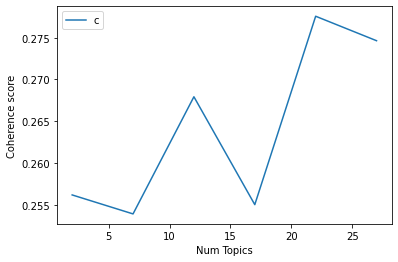

In [69]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [70]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2562
index: 1 | Num Topics = 7  has Coherence Value of 0.2539
index: 2 | Num Topics = 12  has Coherence Value of 0.2679
index: 3 | Num Topics = 17  has Coherence Value of 0.255
index: 4 | Num Topics = 22  has Coherence Value of 0.2776
index: 5 | Num Topics = 27  has Coherence Value of 0.2746


In [171]:
# Select optimal number of topics
optimal_model_us_score3 = model_list_us_score3[4]

In [172]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score3, corpus_us_score3, id2word_us_score3)

In [173]:
print("pyLDAVis for us topics for score=3:")
vis_us_score3

pyLDAVis for us topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.014398 -0.098996       1        1  17.138946
16     0.008066 -0.049706       2        1   6.677242
0      0.085581 -0.015584       3        1   6.600961
18    -0.100877 -0.015498       4        1   6.025604
8      0.128301 -0.033118       5        1   5.514464
14     0.141715 -0.031974       6        1   5.458891
19    -0.037675 -0.079108       7        1   4.706947
3      0.114709 -0.001123       8        1   4.334337
5      0.012228  0.017467       9        1   4.276449
21     0.018906 -0.015009      10        1   4.261577
1     -0.057132 -0.040659      11        1   3.998773
9     -0.044730 -0.090253      12        1   3.783352
7      0.045976 -0.043905      13        1   3.726828
2     -0.111744 -0.041999      14        1   3.657536
20     0.055639  0.027978      15        1   3.621984
4     -0.040881 -0.049927      16        1   3.261390
12    -0.072692  0.028268      17        1   2.617000
17    -0.101482  0.029822      18        1   2.614465
6      0.003994  0.162417      19        1   2.190929
15    -0.043222  0.115798      20        1   1.971832
10    -0.020269  0.103472      21        1   1.923698
13     0.029987  0.121641      22        1   1.636793, topic_info=             Term        Freq       Total Category  logprob  loglift
99           post  149.000000  149.000000  Default  30.0000  30.0000
115         video   67.000000   67.000000  Default  29.0000  29.0000
126  notification   80.000000   80.000000  Default  28.0000  28.0000
227       comment   60.000000   60.000000  Default  27.0000  27.0000
265         group   59.000000   59.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
19         iphone    0.684429   27.181161  Topic22  -5.3407   0.4307
417          back    0.684428   52.236693  Topic22  -5.3407  -0.2225
201          high    0.684428    8.209213  Topic22  -5.3407   1.6280
21           look    0.684427   33.541962  Topic22  -5.3407   0.2205
114        update    0.684427  105.947892  Topic22  -5.3407  -0.9297

[1470 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
348       3  0.344196  ability
348       8  0.172098  ability
348      10  0.344196  ability
348      16  0.172098  ability
219       1  0.158781     able
...     ...       ...      ...
218      13  0.163420     year
218      17  0.065368     year
218      18  0.032684     year
1665      1  0.748292      zip
862      16  0.630762     zone

[3049 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 17, 1, 19, 9, 15, 20, 4, 6, 22, 2, 10, 8, 3, 21, 5, 13, 18, 7, 16, 11, 14])

## LDA Topic Modelling (Rating = 4)

In [74]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_us_score4 = facebook_ios_us_review_YearMonth_score4.review.values.tolist()
review_words_us_score4 = list(sent_to_words(review_us_score4))
print(review_words_us_score4[2:3])

[['first', 'of', 'all', 'this', 'app', 'is', 'good', 'but', 'dont', 'know', 'why', 'think', 'that', 'still', 'miss', 'most', 'of', 'my', 'friend', 'post', 'and', 'about', 'duplicate', 'fake', 'accounts', 'think', 'facebook', 'needs', 'to', 'implement', 'system', 'that', 'avoids', 'the', 'use', 'of', 'same', 'names', 'because', 'personally', 'even', 'found', 'one', 'of', 'my', 'photos', 'being', 'uploaded', 'to', 'someone', 'timeline', 'even', 'though', 'that', 'didn', 'annoyed', 'me', 'but', 'facebook', 'should', 'provide', 'strong', 'control', 'over', 'the', 'user', 'photo', 'so', 'that', 'wont', 'be', 'downloaded', 'in', 'other', 'devices', 'even', 'though', 'some', 'of', 'pic', 'may', 'be', 'screenshot', 'facebook', 'should', 'also', 'implement', 'system', 'like', 'face', 'identifying', 'ai', 'to', 'identify', 'the', 'use', 'of', 'multiple', 'photos', 'of', 'same', 'user', 'over', 'different', 'account', 'mean', 'to', 'say', 'to', 'have', 'new', 'kinds', 'of', 'notification', 'and',

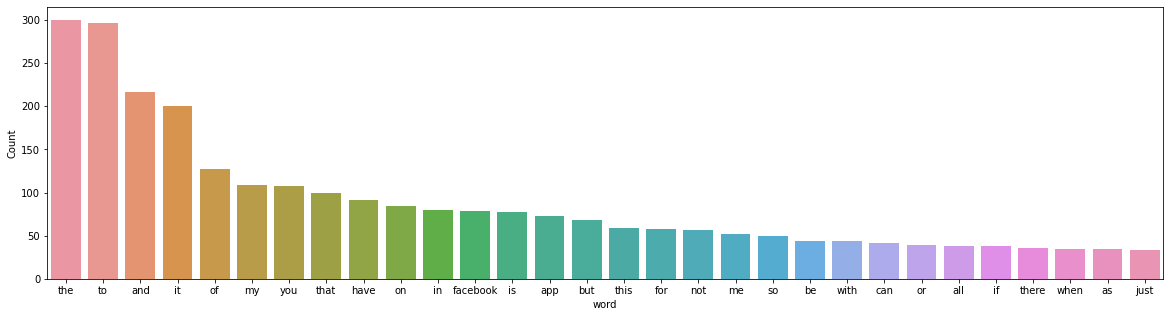

In [75]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score4))

In [76]:
# Clean text
review_us_ready_score4 = process_words(review_words_us_score4)  # processed Text Data! - move to each section

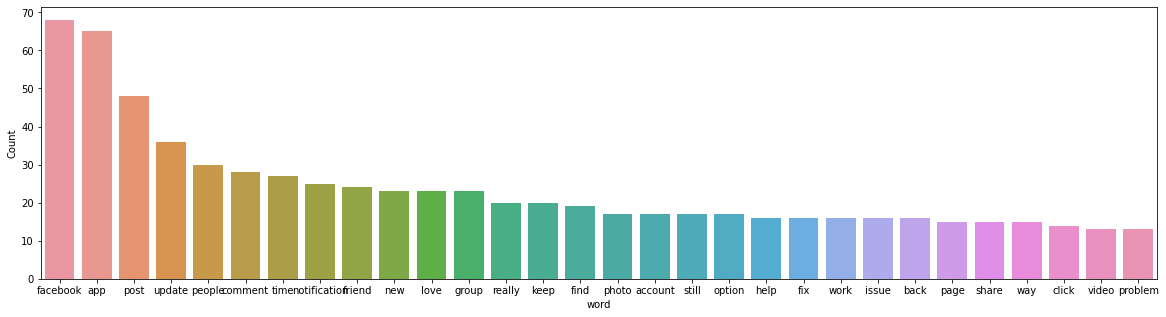

In [77]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score4))


In [78]:
# Create Dictionary
id2word_us_score4 = corpora.Dictionary(review_us_ready_score4)

2021-10-16 19:25:50,794 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:25:50,840 [INFO] gensim.corpora.dictionary - built Dictionary(879 unique tokens: ['action', 'ago', 'annoy', 'annoying', 'app']...) from 58 documents (total 2664 corpus positions)
2021-10-16 19:25:50,846 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(879 unique tokens: ['action', 'ago', 'annoy', 'annoying', 'app']...) from 58 documents (total 2664 corpus positions)", 'datetime': '2021-10-16T19:25:50.843508', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [79]:
# Create Corpus: Term Document Frequency
corpus_us_score4 = [id2word_us_score4.doc2bow(text) for text in review_us_ready_score4]

In [80]:
# Training LDA model
model_list_us_score4, coherence_values_us_score4 = compute_coherence_values(dictionary=id2word_us_score4, corpus=corpus_us_score4, 
                                                              texts=review_us_ready_score4, limit=30, start=2, step=5)


2021-10-16 19:25:50,870 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:25:50,871 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:25:50,873 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:25:50,874 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 58 documents, updating model once every 58 documents, evaluating perplexity every 58 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:25:51,106 [INFO] gensim.models.ldamodel - -7.377 per-word bound, 166.3 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:25:51,108 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #58/58
2021-10-16 19:25:51,253 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"app" + 0.017*"facebook" + 0.013*"post" + 0.010*"update" + 0.009*"comment" + 0.009*"time" + 0.009*"peopl

2021-10-16 19:25:53,612 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.013*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009*"time" + 0.009*"find" + 0.009*"friend" + 0.008*"people"
2021-10-16 19:25:53,613 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"facebook" + 0.014*"post" + 0.014*"app" + 0.011*"update" + 0.011*"notification" + 0.009*"people" + 0.009*"new" + 0.008*"share" + 0.008*"option" + 0.008*"message"
2021-10-16 19:25:53,614 [INFO] gensim.models.ldamodel - topic diff=0.006042, rho=0.301511
2021-10-16 19:25:53,744 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:25:53,746 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #58/58
2021-10-16 19:25:53,855 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.013*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009

2021-10-16 19:25:56,009 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.013*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009*"time" + 0.009*"friend" + 0.009*"find" + 0.008*"people"
2021-10-16 19:25:56,017 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"facebook" + 0.014*"post" + 0.014*"app" + 0.011*"update" + 0.011*"notification" + 0.009*"people" + 0.009*"new" + 0.008*"share" + 0.008*"option" + 0.008*"message"
2021-10-16 19:25:56,025 [INFO] gensim.models.ldamodel - topic diff=0.000679, rho=0.218218
2021-10-16 19:25:56,162 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:25:56,163 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #58/58
2021-10-16 19:25:56,257 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.013*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009

2021-10-16 19:25:58,250 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.014*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009*"friend" + 0.009*"time" + 0.009*"find" + 0.008*"people"
2021-10-16 19:25:58,251 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"facebook" + 0.014*"app" + 0.014*"post" + 0.012*"update" + 0.011*"notification" + 0.009*"people" + 0.009*"new" + 0.008*"option" + 0.008*"share" + 0.008*"message"
2021-10-16 19:25:58,252 [INFO] gensim.models.ldamodel - topic diff=0.000541, rho=0.179605
2021-10-16 19:25:58,399 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:25:58,401 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #58/58
2021-10-16 19:25:58,483 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.014*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009

2021-10-16 19:26:00,618 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.014*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009*"friend" + 0.009*"time" + 0.009*"people" + 0.009*"find"
2021-10-16 19:26:00,619 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"facebook" + 0.014*"app" + 0.014*"post" + 0.012*"update" + 0.011*"notification" + 0.009*"new" + 0.009*"people" + 0.008*"option" + 0.008*"share" + 0.008*"message"
2021-10-16 19:26:00,620 [INFO] gensim.models.ldamodel - topic diff=0.000489, rho=0.156174
2021-10-16 19:26:00,752 [INFO] gensim.models.ldamodel - -6.519 per-word bound, 91.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:00,753 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #58/58
2021-10-16 19:26:00,869 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.014*"post" + 0.010*"comment" + 0.010*"update" + 0.009*"love" + 0.009

2021-10-16 19:26:02,929 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"app" + 0.015*"facebook" + 0.014*"post" + 0.010*"comment" + 0.009*"update" + 0.009*"love" + 0.009*"friend" + 0.009*"time" + 0.009*"people" + 0.009*"find"
2021-10-16 19:26:02,931 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"facebook" + 0.014*"app" + 0.014*"post" + 0.012*"update" + 0.012*"notification" + 0.009*"new" + 0.009*"people" + 0.008*"option" + 0.008*"share" + 0.008*"message"
2021-10-16 19:26:02,933 [INFO] gensim.models.ldamodel - topic diff=0.000428, rho=0.140028
2021-10-16 19:26:02,937 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=879, num_topics=2, decay=0.5, chunksize=1000) in 12.06s', 'datetime': '2021-10-16T19:26:02.937205', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:26:02,942 [INFO] gensim.topic_coherence.probability_estimat

2021-10-16 19:26:07,983 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #58/58
2021-10-16 19:26:08,034 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.034*"facebook" + 0.017*"post" + 0.013*"star" + 0.011*"tell" + 0.011*"people" + 0.009*"picture" + 0.009*"update" + 0.009*"work" + 0.009*"video" + 0.009*"team"
2021-10-16 19:26:08,039 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.021*"account" + 0.018*"facebook" + 0.017*"phone" + 0.011*"information" + 0.011*"app" + 0.011*"different" + 0.009*"picture" + 0.009*"ipad" + 0.009*"work" + 0.009*"log"
2021-10-16 19:26:08,042 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.025*"app" + 0.014*"crash" + 0.013*"back" + 0.013*"facebook" + 0.012*"update" + 0.011*"find" + 0.011*"people" + 0.011*"group" + 0.010*"still" + 0.010*"photo"
2021-10-16 19:26:08,049 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"white" + 0.014*"facebook" + 0.013*"post" + 0.013*"place" + 0.013*"people" + 0.013*"racist" + 0.007*"first" + 0.007*"

2021-10-16 19:26:08,757 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"white" + 0.013*"facebook" + 0.013*"post" + 0.013*"place" + 0.013*"people" + 0.013*"racist" + 0.007*"first" + 0.007*"away" + 0.007*"community" + 0.007*"fear"
2021-10-16 19:26:08,759 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"app" + 0.014*"crash" + 0.013*"back" + 0.013*"facebook" + 0.012*"update" + 0.011*"group" + 0.011*"find" + 0.011*"people" + 0.010*"still" + 0.010*"photo"
2021-10-16 19:26:08,761 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"facebook" + 0.020*"post" + 0.018*"update" + 0.017*"app" + 0.016*"new" + 0.016*"share" + 0.015*"time" + 0.015*"email" + 0.012*"notification" + 0.011*"group"
2021-10-16 19:26:08,762 [INFO] gensim.models.ldamodel - topic diff=0.020714, rho=0.301511
2021-10-16 19:26:08,820 [INFO] gensim.models.ldamodel - -6.671 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:08,821 [INFO] gensim.

2021-10-16 19:26:09,523 [INFO] gensim.models.ldamodel - topic diff=0.004779, rho=0.250000
2021-10-16 19:26:09,599 [INFO] gensim.models.ldamodel - -6.669 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:09,603 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #58/58
2021-10-16 19:26:09,638 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"facebook" + 0.020*"post" + 0.018*"update" + 0.017*"app" + 0.016*"new" + 0.016*"share" + 0.015*"time" + 0.015*"email" + 0.011*"notification" + 0.011*"group"
2021-10-16 19:26:09,639 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"app" + 0.018*"facebook" + 0.016*"notification" + 0.015*"friend" + 0.014*"people" + 0.013*"post" + 0.012*"really" + 0.012*"way" + 0.010*"time" + 0.010*"message"
2021-10-16 19:26:09,641 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.018*"facebook" + 0.017*"phone" + 0.012*"information" + 0.012*"app" + 0.011*"diff

2021-10-16 19:26:10,385 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.018*"facebook" + 0.017*"phone" + 0.012*"information" + 0.012*"app" + 0.011*"different" + 0.009*"work" + 0.009*"ipad" + 0.009*"picture" + 0.009*"log"
2021-10-16 19:26:10,386 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"comment" + 0.030*"post" + 0.028*"app" + 0.018*"love" + 0.016*"update" + 0.016*"page" + 0.014*"facebook" + 0.014*"issue" + 0.014*"group" + 0.012*"notification"
2021-10-16 19:26:10,387 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"app" + 0.014*"crash" + 0.013*"back" + 0.013*"facebook" + 0.012*"update" + 0.011*"group" + 0.011*"people" + 0.011*"find" + 0.010*"name" + 0.010*"photo"
2021-10-16 19:26:10,388 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"facebook" + 0.020*"post" + 0.018*"update" + 0.017*"app" + 0.016*"new" + 0.016*"share" + 0.015*"email" + 0.015*"time" + 0.011*"notification" + 0.011*"group"
2021-10-16 19:26:10,390 [INFO] gensim.models.lda

2021-10-16 19:26:11,115 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"app" + 0.018*"facebook" + 0.016*"notification" + 0.015*"friend" + 0.014*"people" + 0.013*"post" + 0.013*"really" + 0.012*"way" + 0.010*"time" + 0.010*"message"
2021-10-16 19:26:11,116 [INFO] gensim.models.ldamodel - topic diff=0.000624, rho=0.192450
2021-10-16 19:26:11,245 [INFO] gensim.models.ldamodel - -6.667 per-word bound, 101.6 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:11,246 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #58/58
2021-10-16 19:26:11,276 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.018*"facebook" + 0.017*"phone" + 0.012*"information" + 0.012*"app" + 0.011*"different" + 0.009*"work" + 0.009*"ipad" + 0.009*"picture" + 0.009*"log"
2021-10-16 19:26:11,283 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"facebook" + 0.018*"post" + 0.013*"star" + 0.011*"tell" + 0.010*"people" + 0.009*"work" 

2021-10-16 19:26:11,958 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"white" + 0.013*"place" + 0.013*"people" + 0.013*"post" + 0.013*"facebook" + 0.013*"racist" + 0.007*"thing" + 0.007*"first" + 0.007*"anymore" + 0.007*"away"
2021-10-16 19:26:11,959 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.018*"facebook" + 0.017*"phone" + 0.012*"information" + 0.012*"app" + 0.011*"different" + 0.009*"work" + 0.009*"ipad" + 0.009*"log" + 0.009*"picture"
2021-10-16 19:26:11,961 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"facebook" + 0.020*"post" + 0.018*"update" + 0.017*"app" + 0.016*"new" + 0.016*"share" + 0.015*"email" + 0.015*"time" + 0.011*"notification" + 0.011*"group"
2021-10-16 19:26:11,962 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"comment" + 0.030*"post" + 0.028*"app" + 0.018*"love" + 0.016*"update" + 0.016*"page" + 0.014*"facebook" + 0.014*"issue" + 0.014*"group" + 0.012*"notification"
2021-10-16 19:26:11,965 [INFO] gensim.model

2021-10-16 19:26:12,691 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"app" + 0.018*"facebook" + 0.016*"notification" + 0.015*"friend" + 0.014*"people" + 0.013*"post" + 0.013*"really" + 0.012*"way" + 0.010*"time" + 0.010*"message"
2021-10-16 19:26:12,694 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"app" + 0.014*"crash" + 0.013*"back" + 0.013*"facebook" + 0.012*"update" + 0.011*"group" + 0.011*"people" + 0.011*"name" + 0.011*"photo" + 0.011*"find"
2021-10-16 19:26:12,696 [INFO] gensim.models.ldamodel - topic diff=0.000186, rho=0.162221
2021-10-16 19:26:12,807 [INFO] gensim.models.ldamodel - -6.667 per-word bound, 101.6 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:12,809 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #58/58
2021-10-16 19:26:12,873 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"app" + 0.018*"facebook" + 0.016*"notification" + 0.015*"friend" + 0.014*"people" + 0.013*"post" + 

2021-10-16 19:26:13,608 [INFO] gensim.models.ldamodel - -6.667 per-word bound, 101.6 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:13,609 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #58/58
2021-10-16 19:26:13,643 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"facebook" + 0.020*"post" + 0.018*"update" + 0.017*"app" + 0.016*"new" + 0.016*"share" + 0.015*"email" + 0.015*"time" + 0.011*"notification" + 0.011*"group"
2021-10-16 19:26:13,644 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"facebook" + 0.018*"post" + 0.013*"star" + 0.011*"tell" + 0.010*"people" + 0.009*"work" + 0.009*"video" + 0.009*"picture" + 0.009*"team" + 0.009*"update"
2021-10-16 19:26:13,646 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.018*"facebook" + 0.017*"phone" + 0.012*"information" + 0.012*"app" + 0.011*"different" + 0.009*"work" + 0.009*"log" + 0.009*"ipad" + 0.009*"picture"
2021-10-16 19:26:13,649 [INF

2021-10-16 19:26:14,360 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"facebook" + 0.020*"post" + 0.018*"update" + 0.017*"app" + 0.016*"new" + 0.016*"share" + 0.015*"email" + 0.015*"time" + 0.011*"notification" + 0.011*"group"
2021-10-16 19:26:14,365 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"account" + 0.018*"facebook" + 0.017*"phone" + 0.012*"information" + 0.012*"app" + 0.011*"different" + 0.009*"work" + 0.009*"log" + 0.009*"ipad" + 0.009*"picture"
2021-10-16 19:26:14,367 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.021*"app" + 0.018*"facebook" + 0.016*"notification" + 0.015*"friend" + 0.014*"people" + 0.013*"post" + 0.013*"really" + 0.012*"way" + 0.010*"time" + 0.010*"message"
2021-10-16 19:26:14,370 [INFO] gensim.models.ldamodel - topic diff=0.000085, rho=0.142857
2021-10-16 19:26:14,493 [INFO] gensim.models.ldamodel - -6.667 per-word bound, 101.6 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:14,494 [

2021-10-16 19:26:20,189 [INFO] gensim.models.ldamodel - topic diff=0.461680, rho=0.577350
2021-10-16 19:26:20,267 [INFO] gensim.models.ldamodel - -6.976 per-word bound, 125.9 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:20,275 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #58/58
2021-10-16 19:26:20,375 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.036*"group" + 0.031*"hack" + 0.023*"facebook" + 0.022*"tell" + 0.022*"picture" + 0.020*"report" + 0.016*"account" + 0.016*"put" + 0.015*"hacker" + 0.014*"thing"
2021-10-16 19:26:20,376 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"remember" + 0.023*"post" + 0.020*"matter" + 0.018*"facebook" + 0.012*"share" + 0.012*"remove" + 0.011*"enough" + 0.011*"world" + 0.010*"cloud" + 0.010*"truth"
2021-10-16 19:26:20,378 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.026*"feature" + 0.019*"white" + 0.014*"app" + 0.014*"appreciate" + 0.013*"racist" + 0.013*"place" +

2021-10-16 19:26:21,001 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"facebook" + 0.025*"app" + 0.023*"post" + 0.018*"update" + 0.012*"people" + 0.012*"find" + 0.011*"new" + 0.011*"friend" + 0.010*"email" + 0.010*"keep"
2021-10-16 19:26:21,007 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"group" + 0.034*"hack" + 0.023*"facebook" + 0.023*"tell" + 0.023*"picture" + 0.023*"report" + 0.017*"account" + 0.017*"put" + 0.017*"hacker" + 0.017*"thing"
2021-10-16 19:26:21,019 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"app" + 0.020*"crash" + 0.020*"back" + 0.017*"search" + 0.017*"tap" + 0.017*"update" + 0.014*"mode" + 0.014*"dark" + 0.014*"time" + 0.014*"name"
2021-10-16 19:26:21,029 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.022*"ipad" + 0.022*"picture" + 0.015*"click" + 0.015*"flip" + 0.015*"never" + 0.013*"work" + 0.013*"update" + 0.008*"view" + 0.008*"fix" + 0.008*"mean"
2021-10-16 19:26:21,036 [INFO] gensim.models.ldamodel - topic diff=0.057328, rh

2021-10-16 19:26:21,731 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"facebook" + 0.020*"app" + 0.020*"team" + 0.015*"time" + 0.015*"star" + 0.010*"user" + 0.010*"help" + 0.010*"option" + 0.010*"day" + 0.010*"sometimes"
2021-10-16 19:26:21,732 [INFO] gensim.models.ldamodel - topic diff=0.011591, rho=0.267261
2021-10-16 19:26:21,845 [INFO] gensim.models.ldamodel - -6.721 per-word bound, 105.5 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:21,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #58/58
2021-10-16 19:26:21,883 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.025*"phone" + 0.024*"facebook" + 0.022*"notification" + 0.012*"option" + 0.012*"account" + 0.012*"photo" + 0.011*"friend" + 0.010*"message" + 0.010*"watch" + 0.010*"ad"
2021-10-16 19:26:21,885 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.028*"feature" + 0.021*"white" + 0.014*"app" + 0.014*"appreciate" + 0.014*"racist" + 0.014*"place" + 

2021-10-16 19:26:22,562 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"share" + 0.023*"post" + 0.019*"app" + 0.019*"group" + 0.016*"love" + 0.016*"leave" + 0.012*"side" + 0.012*"new" + 0.012*"button" + 0.012*"difficult"
2021-10-16 19:26:22,570 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"facebook" + 0.020*"app" + 0.020*"team" + 0.015*"time" + 0.015*"star" + 0.010*"user" + 0.010*"help" + 0.010*"option" + 0.010*"day" + 0.010*"sometimes"
2021-10-16 19:26:22,574 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.040*"group" + 0.034*"hack" + 0.023*"facebook" + 0.023*"tell" + 0.023*"picture" + 0.023*"report" + 0.017*"account" + 0.017*"put" + 0.017*"hacker" + 0.017*"thing"
2021-10-16 19:26:22,584 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"app" + 0.020*"crash" + 0.020*"back" + 0.017*"search" + 0.017*"tap" + 0.017*"update" + 0.014*"mode" + 0.014*"dark" + 0.014*"time" + 0.014*"name"
2021-10-16 19:26:22,586 [INFO] gensim.models.ldamodel - topic diff=0.002772,

2021-10-16 19:26:23,270 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.056*"notification" + 0.033*"app" + 0.031*"clear" + 0.021*"time" + 0.021*"comment" + 0.017*"post" + 0.016*"group" + 0.014*"let" + 0.011*"website" + 0.011*"regular"
2021-10-16 19:26:23,271 [INFO] gensim.models.ldamodel - topic diff=0.001041, rho=0.200000
2021-10-16 19:26:23,324 [INFO] gensim.models.ldamodel - -6.719 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:23,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #58/58
2021-10-16 19:26:23,352 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"facebook" + 0.020*"app" + 0.020*"team" + 0.015*"time" + 0.015*"star" + 0.010*"user" + 0.010*"help" + 0.010*"option" + 0.010*"day" + 0.010*"sometimes"
2021-10-16 19:26:23,354 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.022*"picture" + 0.022*"ipad" + 0.015*"click" + 0.015*"flip" + 0.015*"never" + 0.014*"work" + 0.014*"update

2021-10-16 19:26:24,238 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.056*"notification" + 0.033*"app" + 0.031*"clear" + 0.021*"time" + 0.021*"comment" + 0.017*"post" + 0.016*"group" + 0.014*"let" + 0.011*"website" + 0.011*"regular"
2021-10-16 19:26:24,239 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"picture" + 0.021*"ipad" + 0.015*"click" + 0.015*"flip" + 0.015*"never" + 0.014*"work" + 0.014*"update" + 0.013*"app" + 0.008*"view" + 0.008*"fix"
2021-10-16 19:26:24,241 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.028*"feature" + 0.021*"white" + 0.014*"app" + 0.014*"appreciate" + 0.014*"racist" + 0.014*"place" + 0.014*"people" + 0.014*"post" + 0.014*"facebook" + 0.008*"really"
2021-10-16 19:26:24,242 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.030*"remember" + 0.025*"post" + 0.020*"matter" + 0.020*"facebook" + 0.015*"share" + 0.010*"remove" + 0.010*"enough" + 0.010*"world" + 0.010*"cloud" + 0.010*"walk"
2021-10-16 19:26:24,243 [INFO] gensim.models.ldamode

2021-10-16 19:26:24,943 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.031*"share" + 0.023*"post" + 0.019*"app" + 0.019*"group" + 0.016*"love" + 0.016*"leave" + 0.012*"side" + 0.012*"new" + 0.012*"button" + 0.012*"difficult"
2021-10-16 19:26:24,946 [INFO] gensim.models.ldamodel - topic diff=0.000193, rho=0.166667
2021-10-16 19:26:25,017 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:25,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #58/58
2021-10-16 19:26:25,108 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"picture" + 0.021*"ipad" + 0.015*"click" + 0.015*"flip" + 0.015*"never" + 0.014*"work" + 0.014*"update" + 0.013*"app" + 0.008*"view" + 0.008*"fix"
2021-10-16 19:26:25,110 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"facebook" + 0.024*"app" + 0.022*"post" + 0.017*"update" + 0.012*"people" + 0.012*"find" + 0.011*"new" + 0.011*"fr

2021-10-16 19:26:25,777 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.025*"phone" + 0.024*"facebook" + 0.022*"notification" + 0.012*"option" + 0.012*"photo" + 0.012*"friend" + 0.011*"account" + 0.010*"message" + 0.010*"watch" + 0.010*"ad"
2021-10-16 19:26:25,778 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.056*"notification" + 0.033*"app" + 0.031*"clear" + 0.021*"time" + 0.021*"comment" + 0.017*"post" + 0.016*"group" + 0.014*"let" + 0.011*"website" + 0.011*"regular"
2021-10-16 19:26:25,779 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"app" + 0.020*"crash" + 0.020*"back" + 0.017*"search" + 0.017*"tap" + 0.017*"update" + 0.014*"mode" + 0.014*"dark" + 0.014*"name" + 0.014*"time"
2021-10-16 19:26:25,780 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"picture" + 0.021*"ipad" + 0.015*"click" + 0.015*"flip" + 0.015*"never" + 0.014*"work" + 0.014*"update" + 0.013*"app" + 0.008*"view" + 0.008*"fix"
2021-10-16 19:26:25,781 [INFO] gensim.models.ldamodel - topic di

2021-10-16 19:26:26,461 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.030*"app" + 0.020*"crash" + 0.020*"back" + 0.017*"search" + 0.017*"tap" + 0.017*"update" + 0.014*"dark" + 0.014*"mode" + 0.014*"name" + 0.014*"time"
2021-10-16 19:26:26,462 [INFO] gensim.models.ldamodel - topic diff=0.000047, rho=0.145865
2021-10-16 19:26:26,612 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:26,613 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #58/58
2021-10-16 19:26:26,648 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"comment" + 0.028*"facebook" + 0.021*"app" + 0.016*"access" + 0.016*"first" + 0.013*"allow" + 0.013*"new" + 0.013*"click" + 0.013*"video" + 0.013*"photo"
2021-10-16 19:26:26,651 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"facebook" + 0.024*"app" + 0.022*"post" + 0.017*"update" + 0.012*"people" + 0.012*"find" + 0.011*"new" + 0.011*"f

2021-10-16 19:26:33,255 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.034*"comment" + 0.022*"app" + 0.018*"post" + 0.017*"love" + 0.016*"update" + 0.015*"appear" + 0.014*"notification" + 0.013*"facebook" + 0.012*"create" + 0.012*"restaurant"
2021-10-16 19:26:33,257 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"facebook" + 0.020*"picture" + 0.018*"people" + 0.017*"account" + 0.016*"tell" + 0.013*"white" + 0.012*"reaction" + 0.011*"post" + 0.010*"first" + 0.009*"number"
2021-10-16 19:26:33,258 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.030*"share" + 0.024*"post" + 0.022*"app" + 0.018*"group" + 0.017*"leave" + 0.014*"side" + 0.014*"love" + 0.014*"new" + 0.012*"button" + 0.012*"difficult"
2021-10-16 19:26:33,259 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.037*"app" + 0.021*"facebook" + 0.019*"post" + 0.012*"crash" + 0.012*"issue" + 0.011*"first" + 0.011*"way" + 0.010*"reaction" + 0.010*"work" + 0.010*"great"
2021-10-16 19:26:33,260 [INFO] gensim.models.

2021-10-16 19:26:34,006 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.028*"facebook" + 0.027*"post" + 0.021*"ad" + 0.021*"video" + 0.014*"work" + 0.014*"gif" + 0.014*"stop" + 0.014*"middle" + 0.014*"annoying" + 0.014*"never"
2021-10-16 19:26:34,007 [INFO] gensim.models.ldamodel - topic diff=0.153486, rho=0.377964
2021-10-16 19:26:34,091 [INFO] gensim.models.ldamodel - -6.804 per-word bound, 111.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:34,094 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #58/58
2021-10-16 19:26:34,129 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.002*"white" + 0.002*"facebook" + 0.002*"place" + 0.002*"post" + 0.002*"people" + 0.002*"racist" + 0.001*"crash" + 0.001*"mode" + 0.001*"app" + 0.001*"fear"
2021-10-16 19:26:34,131 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.041*"facebook" + 0.030*"account" + 0.021*"picture" + 0.020*"people" + 0.020*"tell" + 0.020*"photo" + 0.015*"white

2021-10-16 19:26:34,881 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.035*"facebook" + 0.023*"team" + 0.018*"star" + 0.012*"camera" + 0.012*"app" + 0.012*"super" + 0.012*"year" + 0.012*"order" + 0.012*"time" + 0.012*"work"
2021-10-16 19:26:34,883 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.028*"app" + 0.019*"group" + 0.019*"phone" + 0.019*"name" + 0.016*"feature" + 0.016*"time" + 0.015*"issue" + 0.015*"back" + 0.013*"page" + 0.013*"last"
2021-10-16 19:26:34,884 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.028*"facebook" + 0.028*"post" + 0.021*"ad" + 0.021*"video" + 0.014*"work" + 0.014*"gif" + 0.014*"stop" + 0.014*"middle" + 0.014*"annoying" + 0.014*"never"
2021-10-16 19:26:34,886 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.001*"white" + 0.001*"facebook" + 0.001*"place" + 0.001*"post" + 0.001*"people" + 0.001*"racist" + 0.001*"crash" + 0.001*"mode" + 0.001*"app" + 0.001*"fear"
2021-10-16 19:26:34,887 [INFO] gensim.models.ldamodel - topic diff=0.019663, rho

2021-10-16 19:26:35,617 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"facebook" + 0.025*"click" + 0.025*"access" + 0.020*"app" + 0.020*"photo" + 0.015*"keep" + 0.015*"video" + 0.015*"play" + 0.015*"new" + 0.015*"allow"
2021-10-16 19:26:35,621 [INFO] gensim.models.ldamodel - topic diff=0.004439, rho=0.235702
2021-10-16 19:26:35,730 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.8 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:35,731 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #58/58
2021-10-16 19:26:35,760 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.077*"notification" + 0.046*"clear" + 0.033*"app" + 0.031*"comment" + 0.031*"post" + 0.023*"let" + 0.022*"annoying" + 0.020*"time" + 0.016*"website" + 0.016*"regular"
2021-10-16 19:26:35,761 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.039*"app" + 0.024*"facebook" + 0.020*"reaction" + 0.012*"post" + 0.012*"crash" + 0.012*"first" + 0.012*

2021-10-16 19:26:36,358 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"app" + 0.022*"crash" + 0.018*"tap" + 0.018*"matter" + 0.018*"remember" + 0.015*"search" + 0.015*"dark" + 0.015*"mode" + 0.015*"continue" + 0.014*"update"
2021-10-16 19:26:36,363 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.023*"find" + 0.023*"remove" + 0.023*"post" + 0.012*"decide" + 0.012*"order" + 0.012*"list" + 0.012*"mark" + 0.012*"item" + 0.012*"sit" + 0.012*"thing"
2021-10-16 19:26:36,368 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.001*"white" + 0.001*"facebook" + 0.001*"place" + 0.001*"post" + 0.001*"people" + 0.001*"racist" + 0.001*"crash" + 0.001*"mode" + 0.001*"app" + 0.001*"fear"
2021-10-16 19:26:36,371 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.035*"facebook" + 0.023*"team" + 0.018*"star" + 0.012*"camera" + 0.012*"app" + 0.012*"super" + 0.012*"year" + 0.012*"order" + 0.012*"time" + 0.012*"work"
2021-10-16 19:26:36,375 [INFO] gensim.models.ldamodel - topic diff=0.000973,

2021-10-16 19:26:37,119 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"comment" + 0.029*"app" + 0.024*"love" + 0.020*"update" + 0.019*"post" + 0.017*"create" + 0.015*"facebook" + 0.014*"appear" + 0.014*"notification" + 0.014*"different"
2021-10-16 19:26:37,120 [INFO] gensim.models.ldamodel - topic diff=0.000322, rho=0.185695
2021-10-16 19:26:37,245 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:37,247 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #58/58
2021-10-16 19:26:37,275 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.001*"white" + 0.001*"facebook" + 0.001*"place" + 0.001*"post" + 0.001*"people" + 0.001*"racist" + 0.001*"crash" + 0.001*"mode" + 0.001*"app" + 0.001*"fear"
2021-10-16 19:26:37,277 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.035*"facebook" + 0.023*"team" + 0.018*"star" + 0.012*"camera" + 0.012*"app" + 0.012*"super" + 0.0

2021-10-16 19:26:37,980 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.041*"facebook" + 0.031*"account" + 0.021*"picture" + 0.021*"people" + 0.021*"tell" + 0.021*"photo" + 0.015*"white" + 0.015*"post" + 0.015*"number" + 0.015*"user"
2021-10-16 19:26:37,981 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.034*"facebook" + 0.028*"post" + 0.020*"update" + 0.017*"new" + 0.015*"email" + 0.012*"share" + 0.012*"keep" + 0.012*"find" + 0.012*"friend" + 0.010*"page"
2021-10-16 19:26:37,982 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.077*"notification" + 0.046*"clear" + 0.033*"app" + 0.031*"comment" + 0.031*"post" + 0.023*"let" + 0.023*"annoying" + 0.021*"time" + 0.016*"website" + 0.016*"regular"
2021-10-16 19:26:37,983 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.001*"white" + 0.001*"facebook" + 0.001*"place" + 0.001*"post" + 0.001*"people" + 0.001*"racist" + 0.001*"crash" + 0.001*"mode" + 0.001*"app" + 0.001*"fear"
2021-10-16 19:26:37,986 [INFO] gensim.models.ldamodel - 

2021-10-16 19:26:38,582 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"comment" + 0.029*"app" + 0.024*"love" + 0.020*"update" + 0.019*"post" + 0.017*"create" + 0.015*"facebook" + 0.014*"appear" + 0.014*"message" + 0.014*"notification"
2021-10-16 19:26:38,584 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.023*"find" + 0.023*"remove" + 0.023*"post" + 0.012*"decide" + 0.012*"thing" + 0.012*"list" + 0.012*"order" + 0.012*"sit" + 0.012*"mark" + 0.012*"item"
2021-10-16 19:26:38,586 [INFO] gensim.models.ldamodel - topic diff=0.000039, rho=0.158114
2021-10-16 19:26:38,676 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:38,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #58/58
2021-10-16 19:26:38,739 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.028*"app" + 0.019*"group" + 0.019*"phone" + 0.019*"name" + 0.016*"feature" + 0.016*"time" + 0.015*"iss

2021-10-16 19:26:39,391 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #58/58
2021-10-16 19:26:39,420 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.028*"app" + 0.019*"group" + 0.019*"phone" + 0.019*"name" + 0.016*"feature" + 0.016*"time" + 0.015*"issue" + 0.015*"back" + 0.013*"page" + 0.013*"last"
2021-10-16 19:26:39,421 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.030*"facebook" + 0.025*"click" + 0.025*"access" + 0.020*"app" + 0.020*"photo" + 0.015*"keep" + 0.015*"play" + 0.015*"video" + 0.015*"allow" + 0.015*"new"
2021-10-16 19:26:39,422 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.031*"notification" + 0.027*"message" + 0.024*"facebook" + 0.024*"app" + 0.020*"turn" + 0.016*"option" + 0.012*"update" + 0.012*"account" + 0.012*"click" + 0.012*"time"
2021-10-16 19:26:39,423 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.001*"white" + 0.001*"facebook" + 0.001*"place" + 0.001*"post" + 0.001*"people" + 0.001*"racist" + 0.001*"crash" + 0.001*"mode" 

2021-10-16 19:26:40,147 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"share" + 0.030*"post" + 0.025*"app" + 0.024*"group" + 0.020*"love" + 0.020*"leave" + 0.016*"button" + 0.015*"side" + 0.015*"new" + 0.015*"difficult"
2021-10-16 19:26:40,149 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.041*"facebook" + 0.031*"account" + 0.021*"picture" + 0.021*"people" + 0.021*"tell" + 0.021*"photo" + 0.015*"white" + 0.015*"post" + 0.015*"number" + 0.015*"user"
2021-10-16 19:26:40,150 [INFO] gensim.models.ldamodel - topic diff=0.000007, rho=0.140028
2021-10-16 19:26:40,151 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=879, num_topics=17, decay=0.5, chunksize=1000) in 7.28s', 'datetime': '2021-10-16T19:26:40.151279', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:26:40,161 [INFO] gensim.topic_coherence.probability_estimation - 

2021-10-16 19:26:47,658 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #58/58
2021-10-16 19:26:47,745 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.054*"comment" + 0.029*"facebook" + 0.028*"app" + 0.023*"access" + 0.020*"keep" + 0.019*"photo" + 0.018*"first" + 0.018*"click" + 0.015*"find" + 0.015*"video"
2021-10-16 19:26:47,747 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.044*"reaction" + 0.027*"facebook" + 0.018*"animate" + 0.018*"people" + 0.018*"icon" + 0.018*"care" + 0.018*"emoji" + 0.018*"first" + 0.018*"new" + 0.017*"allow"
2021-10-16 19:26:47,748 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.035*"update" + 0.033*"comment" + 0.032*"create" + 0.028*"facebook" + 0.028*"avatar" + 0.027*"post" + 0.026*"app" + 0.024*"reinstall" + 0.017*"problem" + 0.016*"give"
2021-10-16 19:26:47,749 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"message" + 0.026*"app" + 0.025*"time" + 0.025*"birthday" + 0.017*"instead" + 0.017*"press" + 0.017*"space" + 0.

2021-10-16 19:26:48,329 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.096*"notification" + 0.036*"option" + 0.032*"app" + 0.031*"clear" + 0.028*"turn" + 0.026*"facebook" + 0.024*"message" + 0.019*"find" + 0.018*"add" + 0.018*"post"
2021-10-16 19:26:48,331 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"message" + 0.026*"app" + 0.026*"time" + 0.026*"birthday" + 0.017*"instead" + 0.017*"press" + 0.017*"space" + 0.017*"profile" + 0.017*"dismiss" + 0.017*"single"
2021-10-16 19:26:48,333 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.025*"facebook" + 0.022*"picture" + 0.022*"app" + 0.016*"people" + 0.016*"account" + 0.013*"fix" + 0.013*"message" + 0.013*"keep" + 0.013*"help" + 0.013*"let"
2021-10-16 19:26:48,336 [INFO] gensim.models.ldamodel - topic diff=0.045659, rho=0.301511
2021-10-16 19:26:48,490 [INFO] gensim.models.ldamodel - -6.838 per-word bound, 114.4 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:48,491 [INFO] 

2021-10-16 19:26:49,092 [INFO] gensim.models.ldamodel - topic diff=0.009408, rho=0.250000
2021-10-16 19:26:49,179 [INFO] gensim.models.ldamodel - -6.834 per-word bound, 114.1 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:49,181 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #58/58
2021-10-16 19:26:49,257 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.036*"post" + 0.030*"facebook" + 0.024*"share" + 0.018*"people" + 0.018*"problem" + 0.018*"app" + 0.012*"really" + 0.012*"love" + 0.012*"lock" + 0.012*"thing"
2021-10-16 19:26:49,259 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.027*"friend" + 0.018*"facebook" + 0.017*"people" + 0.015*"family" + 0.015*"love" + 0.014*"post" + 0.012*"photo" + 0.012*"watch" + 0.012*"way" + 0.012*"time"
2021-10-16 19:26:49,260 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.049*"app" + 0.025*"day" + 0.025*"option" + 0.025*"status" + 0.025*"change" + 0.025*"sometimes" + 0.013*"fac

2021-10-16 19:26:49,892 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.041*"share" + 0.031*"feature" + 0.026*"app" + 0.026*"group" + 0.021*"leave" + 0.021*"post" + 0.017*"update" + 0.016*"back" + 0.016*"side" + 0.016*"button"
2021-10-16 19:26:49,895 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.001*"facebook" + 0.001*"fine" + 0.001*"ever" + 0.001*"people" + 0.001*"keep" + 0.001*"give" + 0.001*"new" + 0.001*"whenever" + 0.001*"answer" + 0.001*"crazy"
2021-10-16 19:26:49,898 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.025*"facebook" + 0.025*"star" + 0.025*"team" + 0.019*"work" + 0.012*"user" + 0.012*"post" + 0.012*"fake" + 0.012*"one" + 0.012*"business" + 0.012*"resilient"
2021-10-16 19:26:49,900 [INFO] gensim.models.ldamodel - topic diff=0.001974, rho=0.213201
2021-10-16 19:26:49,957 [INFO] gensim.models.ldamodel - -6.834 per-word bound, 114.1 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:49,958 [INFO] gensim.models.l

2021-10-16 19:26:50,624 [INFO] gensim.models.ldamodel - topic diff=0.000761, rho=0.192450
2021-10-16 19:26:50,747 [INFO] gensim.models.ldamodel - -6.833 per-word bound, 114.0 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:50,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #58/58
2021-10-16 19:26:50,788 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.039*"update" + 0.033*"comment" + 0.033*"create" + 0.033*"avatar" + 0.031*"facebook" + 0.028*"post" + 0.025*"app" + 0.025*"reinstall" + 0.017*"problem" + 0.017*"give"
2021-10-16 19:26:50,794 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.025*"facebook" + 0.022*"picture" + 0.021*"app" + 0.016*"people" + 0.016*"account" + 0.013*"fix" + 0.013*"message" + 0.013*"keep" + 0.013*"help" + 0.013*"let"
2021-10-16 19:26:50,799 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.001*"name" + 0.001*"page" + 0.001*"word" + 0.001*"view" + 0.001*"force" + 0.001*"fix" + 0.001*"list

2021-10-16 19:26:51,469 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.037*"crash" + 0.030*"mode" + 0.030*"dark" + 0.029*"app" + 0.015*"help" + 0.015*"post" + 0.015*"page" + 0.015*"photo" + 0.015*"report" + 0.015*"keep"
2021-10-16 19:26:51,470 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.096*"notification" + 0.036*"option" + 0.032*"app" + 0.030*"clear" + 0.029*"turn" + 0.026*"facebook" + 0.024*"message" + 0.024*"find" + 0.018*"add" + 0.018*"post"
2021-10-16 19:26:51,471 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.056*"phone" + 0.023*"faulty" + 0.023*"leak" + 0.012*"information" + 0.012*"dealing" + 0.012*"listen" + 0.012*"amount" + 0.012*"city" + 0.012*"company" + 0.012*"bully"
2021-10-16 19:26:51,472 [INFO] gensim.models.ldamodel - topic diff=0.000371, rho=0.174078
2021-10-16 19:26:51,545 [INFO] gensim.models.ldamodel - -6.832 per-word bound, 114.0 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:51,547 [INFO] gensim.m

2021-10-16 19:26:52,147 [INFO] gensim.models.ldamodel - topic diff=0.000248, rho=0.162221
2021-10-16 19:26:52,249 [INFO] gensim.models.ldamodel - -6.832 per-word bound, 113.9 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:52,250 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #58/58
2021-10-16 19:26:52,292 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.025*"facebook" + 0.023*"picture" + 0.021*"app" + 0.016*"account" + 0.016*"people" + 0.013*"fix" + 0.013*"message" + 0.013*"keep" + 0.013*"help" + 0.013*"tell"
2021-10-16 19:26:52,295 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.046*"reaction" + 0.028*"facebook" + 0.019*"animate" + 0.019*"people" + 0.019*"icon" + 0.019*"care" + 0.019*"emoji" + 0.019*"first" + 0.019*"new" + 0.019*"allow"
2021-10-16 19:26:52,298 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.095*"notification" + 0.036*"option" + 0.032*"app" + 0.030*"clear" + 0.029*"turn" + 0.026*"facebook" + 

2021-10-16 19:26:52,951 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.038*"crash" + 0.030*"mode" + 0.030*"dark" + 0.029*"app" + 0.015*"help" + 0.015*"available" + 0.015*"keep" + 0.015*"post" + 0.015*"background" + 0.015*"page"
2021-10-16 19:26:52,953 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.037*"search" + 0.032*"name" + 0.031*"tap" + 0.031*"back" + 0.026*"app" + 0.025*"remove" + 0.019*"year" + 0.019*"edit" + 0.018*"issue" + 0.018*"view"
2021-10-16 19:26:52,954 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.034*"message" + 0.026*"app" + 0.026*"time" + 0.026*"birthday" + 0.017*"press" + 0.017*"instead" + 0.017*"space" + 0.017*"profile" + 0.017*"dismiss" + 0.017*"single"
2021-10-16 19:26:52,955 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.028*"group" + 0.028*"page" + 0.028*"app" + 0.021*"happen" + 0.021*"issue" + 0.021*"notification" + 0.021*"appear" + 0.021*"screen" + 0.014*"time" + 0.014*"love"
2021-10-16 19:26:52,956 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:26:53,623 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.041*"share" + 0.031*"feature" + 0.026*"app" + 0.026*"group" + 0.021*"leave" + 0.021*"post" + 0.017*"update" + 0.016*"side" + 0.016*"back" + 0.016*"button"
2021-10-16 19:26:53,625 [INFO] gensim.models.ldamodel - topic diff=0.000125, rho=0.142857
2021-10-16 19:26:53,729 [INFO] gensim.models.ldamodel - -6.832 per-word bound, 113.9 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:26:53,730 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #58/58
2021-10-16 19:26:53,809 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.040*"update" + 0.033*"comment" + 0.033*"create" + 0.033*"avatar" + 0.031*"facebook" + 0.028*"post" + 0.025*"app" + 0.025*"reinstall" + 0.017*"problem" + 0.017*"notification"
2021-10-16 19:26:53,811 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.028*"group" + 0.028*"page" + 0.028*"app" + 0.021*"happen" + 0.021*"issue" + 0.021*"appear" + 

2021-10-16 19:27:02,307 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.009*"tap" + 0.008*"edit" + 0.007*"search" + 0.006*"remove" + 0.006*"facebook" + 0.005*"time" + 0.005*"recent" + 0.005*"arrow" + 0.004*"reaction" + 0.004*"white"
2021-10-16 19:27:02,309 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.034*"facebook" + 0.029*"app" + 0.025*"team" + 0.020*"time" + 0.015*"star" + 0.015*"change" + 0.015*"work" + 0.015*"help" + 0.014*"day" + 0.010*"resilient"
2021-10-16 19:27:02,311 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.034*"app" + 0.030*"facebook" + 0.029*"notification" + 0.024*"update" + 0.023*"message" + 0.019*"option" + 0.015*"long" + 0.014*"phone" + 0.014*"turn" + 0.013*"time"
2021-10-16 19:27:02,313 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.006*"facebook" + 0.004*"crush" + 0.004*"app" + 0.003*"ad" + 0.003*"fix" + 0.003*"watch" + 0.003*"second" + 0.003*"hectic" + 0.003*"write" + 0.003*"read"
2021-10-16 19:27:02,314 [INFO] gensim.models.ldamodel - to

2021-10-16 19:27:03,056 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.049*"group" + 0.042*"hack" + 0.028*"report" + 0.028*"thing" + 0.028*"back" + 0.021*"app" + 0.021*"comment" + 0.021*"hacker" + 0.015*"people" + 0.015*"facebook"
2021-10-16 19:27:03,058 [INFO] gensim.models.ldamodel - topic diff=0.097728, rho=0.333333
2021-10-16 19:27:03,137 [INFO] gensim.models.ldamodel - -6.904 per-word bound, 119.7 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:27:03,140 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #58/58
2021-10-16 19:27:03,184 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.043*"facebook" + 0.037*"post" + 0.017*"email" + 0.015*"new" + 0.015*"account" + 0.013*"update" + 0.013*"find" + 0.012*"share" + 0.011*"place" + 0.011*"help"
2021-10-16 19:27:03,186 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.001*"crash" + 0.001*"mode" + 0.001*"dark" + 0.001*"app" + 0.001*"available" + 0.001*"background" + 0.001*"c

2021-10-16 19:27:03,965 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.042*"lock" + 0.021*"never" + 0.021*"recent" + 0.021*"age" + 0.021*"absolutely" + 0.021*"important" + 0.021*"posting" + 0.021*"least" + 0.021*"article" + 0.021*"actually"
2021-10-16 19:27:03,971 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.027*"tap" + 0.027*"matter" + 0.027*"remember" + 0.021*"dark" + 0.021*"mode" + 0.021*"crash" + 0.021*"app" + 0.021*"search" + 0.016*"background" + 0.016*"love"
2021-10-16 19:27:03,980 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.001*"facebook" + 0.001*"crush" + 0.001*"app" + 0.001*"ad" + 0.001*"fix" + 0.001*"watch" + 0.001*"second" + 0.001*"hectic" + 0.001*"write" + 0.001*"read"
2021-10-16 19:27:03,981 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.029*"ipad" + 0.029*"picture" + 0.019*"click" + 0.019*"flip" + 0.019*"update" + 0.019*"work" + 0.019*"never" + 0.019*"app" + 0.010*"view" + 0.010*"friend"
2021-10-16 19:27:03,982 [INFO] gensim.models.ldamodel - top

2021-10-16 19:27:04,693 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"facebook" + 0.030*"app" + 0.025*"team" + 0.020*"time" + 0.015*"star" + 0.015*"change" + 0.015*"work" + 0.015*"help" + 0.015*"day" + 0.010*"resilient"
2021-10-16 19:27:04,699 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.041*"notification" + 0.035*"clear" + 0.029*"reaction" + 0.024*"app" + 0.024*"post" + 0.024*"comment" + 0.018*"facebook" + 0.012*"website" + 0.012*"time" + 0.012*"regular"
2021-10-16 19:27:04,708 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.037*"watch" + 0.037*"ad" + 0.028*"close" + 0.028*"story" + 0.019*"love" + 0.019*"issue" + 0.019*"misinformation" + 0.019*"read" + 0.009*"friend" + 0.009*"interest"
2021-10-16 19:27:04,713 [INFO] gensim.models.ldamodel - topic diff=0.004202, rho=0.223607
2021-10-16 19:27:04,788 [INFO] gensim.models.ldamodel - -6.885 per-word bound, 118.2 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:27:04,789 [IN

2021-10-16 19:27:05,468 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.038*"app" + 0.023*"account" + 0.023*"great" + 0.015*"password" + 0.015*"different" + 0.015*"hater" + 0.015*"really" + 0.015*"day" + 0.015*"people" + 0.015*"stuff"
2021-10-16 19:27:05,474 [INFO] gensim.models.ldamodel - topic diff=0.001409, rho=0.200000
2021-10-16 19:27:05,527 [INFO] gensim.models.ldamodel - -6.885 per-word bound, 118.2 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:27:05,529 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #58/58
2021-10-16 19:27:05,558 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.027*"people" + 0.027*"friend" + 0.027*"group" + 0.018*"post" + 0.018*"facebook" + 0.018*"really" + 0.018*"app" + 0.018*"space" + 0.018*"instead" + 0.018*"time"
2021-10-16 19:27:05,559 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.032*"people" + 0.032*"facebook" + 0.024*"give" + 0.022*"notification" + 0.016*"fine" + 0.016*"keep"

2021-10-16 19:27:06,299 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"facebook" + 0.030*"app" + 0.025*"team" + 0.020*"time" + 0.015*"star" + 0.015*"change" + 0.015*"work" + 0.015*"help" + 0.015*"day" + 0.010*"resilient"
2021-10-16 19:27:06,301 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.001*"facebook" + 0.001*"crush" + 0.001*"app" + 0.001*"ad" + 0.001*"fix" + 0.001*"watch" + 0.001*"second" + 0.001*"hectic" + 0.001*"write" + 0.001*"read"
2021-10-16 19:27:06,303 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.032*"people" + 0.032*"facebook" + 0.024*"give" + 0.022*"notification" + 0.016*"fine" + 0.016*"keep" + 0.016*"ever" + 0.016*"star" + 0.016*"find" + 0.016*"cover"
2021-10-16 19:27:06,308 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.027*"people" + 0.027*"friend" + 0.027*"group" + 0.018*"post" + 0.018*"facebook" + 0.018*"really" + 0.018*"app" + 0.018*"space" + 0.018*"instead" + 0.018*"time"
2021-10-16 19:27:06,310 [INFO] gensim.models.ldamodel - topic #1

2021-10-16 19:27:07,080 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.030*"account" + 0.030*"photo" + 0.022*"app" + 0.022*"facebook" + 0.022*"user" + 0.015*"issue" + 0.015*"solve" + 0.015*"open" + 0.015*"crash" + 0.015*"system"
2021-10-16 19:27:07,082 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.024*"update" + 0.024*"people" + 0.024*"theory" + 0.024*"conspiracy" + 0.024*"crash" + 0.012*"start" + 0.012*"fix" + 0.012*"hoax" + 0.012*"insane" + 0.012*"dangerous"
2021-10-16 19:27:07,086 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.049*"group" + 0.042*"hack" + 0.028*"report" + 0.028*"thing" + 0.028*"back" + 0.021*"app" + 0.021*"comment" + 0.021*"hacker" + 0.015*"people" + 0.015*"facebook"
2021-10-16 19:27:07,088 [INFO] gensim.models.ldamodel - topic diff=0.000162, rho=0.166667
2021-10-16 19:27:07,149 [INFO] gensim.models.ldamodel - -6.885 per-word bound, 118.2 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:27:07,151 [INFO] 

2021-10-16 19:27:07,784 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.046*"share" + 0.036*"post" + 0.033*"group" + 0.020*"new" + 0.020*"update" + 0.020*"difficult" + 0.014*"feature" + 0.014*"app" + 0.013*"find" + 0.013*"understand"
2021-10-16 19:27:07,786 [INFO] gensim.models.ldamodel - topic diff=0.000066, rho=0.156174
2021-10-16 19:27:07,846 [INFO] gensim.models.ldamodel - -6.885 per-word bound, 118.2 perplexity estimate based on a held-out corpus of 58 documents with 2664 words
2021-10-16 19:27:07,847 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #58/58
2021-10-16 19:27:07,892 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.042*"facebook" + 0.028*"app" + 0.028*"super" + 0.028*"camera" + 0.014*"post" + 0.014*"comment" + 0.014*"update" + 0.014*"first" + 0.014*"video" + 0.014*"really"
2021-10-16 19:27:07,894 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.025*"page" + 0.025*"issue" + 0.025*"name" + 0.025*"back" + 0.024*"app" + 0.020*"group" + 0.020*"fe

2021-10-16 19:27:08,570 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #58/58
2021-10-16 19:27:08,620 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.001*"crash" + 0.001*"mode" + 0.001*"dark" + 0.001*"app" + 0.001*"available" + 0.001*"background" + 0.001*"clear" + 0.001*"look" + 0.001*"fine" + 0.001*"refreshing"
2021-10-16 19:27:08,621 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.036*"profile" + 0.027*"app" + 0.027*"facebook" + 0.027*"birthday" + 0.027*"message" + 0.027*"keep" + 0.018*"change" + 0.018*"time" + 0.018*"problem" + 0.018*"dismiss"
2021-10-16 19:27:08,623 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.024*"update" + 0.024*"people" + 0.024*"theory" + 0.024*"conspiracy" + 0.024*"crash" + 0.012*"start" + 0.012*"fix" + 0.012*"hoax" + 0.012*"review" + 0.012*"dangerous"
2021-10-16 19:27:08,624 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.030*"account" + 0.030*"photo" + 0.022*"app" + 0.022*"facebook" + 0.022*"user" + 0.015*"solve" + 0.015*

2021-10-16 19:27:13,697 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 58 virtual documents


In [81]:
%store model_list_us_score4
%store coherence_values_us_score4

Stored 'model_list_us_score4' (list)
Stored 'coherence_values_us_score4' (list)


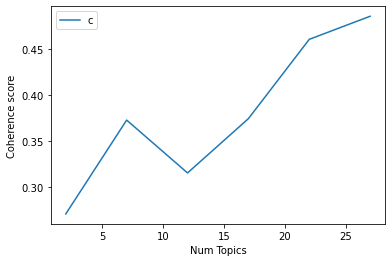

In [82]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [83]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  27

index: 0 | Num Topics = 2  has Coherence Value of 0.2708
index: 1 | Num Topics = 7  has Coherence Value of 0.373
index: 2 | Num Topics = 12  has Coherence Value of 0.3154
index: 3 | Num Topics = 17  has Coherence Value of 0.3746
index: 4 | Num Topics = 22  has Coherence Value of 0.461
index: 5 | Num Topics = 27  has Coherence Value of 0.4862


In [174]:
# Select optimal number of topics
optimal_model_us_score4 = model_list_us_score4[5]

In [175]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score4 = pyLDAvis.gensim_models.prepare(optimal_model_us_score4, corpus_us_score4, id2word_us_score4)

In [176]:
print("pyLDAVis for us topics for score=4:")
vis_us_score4

pyLDAVis for us topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.133704 -0.051315       1        1  15.879833
15    -0.137892  0.070935       2        1  11.129253
14    -0.171699 -0.012902       3        1   7.866605
25     0.024596  0.162714       4        1   6.312201
0      0.020632  0.113516       5        1   5.861742
6     -0.057149 -0.118037       6        1   5.824238
4     -0.108066  0.007065       7        1   5.186566
19     0.017117 -0.123074       8        1   4.473537
11    -0.042834 -0.095406       9        1   4.460673
12    -0.098297 -0.051659      10        1   4.194652
13    -0.047234  0.087249      11        1   3.909140
24    -0.002135  0.068436      12        1   3.796524
5     -0.108363  0.013195      13        1   3.452278
18    -0.065317 -0.002985      14        1   3.008579
26     0.023071  0.115175      15        1   3.008579
3      0.068767 -0.100538      16        1   2.932152
2      0.049480  0.037834      17        1   2.708481
22     0.078588 -0.047780      18        1   1.993942
23     0.039451  0.002759      19        1   1.506184
9      0.067448  0.018838      20        1   1.356139
8      0.129978 -0.024085      21        1   0.665786
10     0.075594 -0.011656      22        1   0.078820
1      0.075594 -0.011656      23        1   0.078820
16     0.075593 -0.011656      24        1   0.078820
17     0.075593 -0.011656      25        1   0.078820
20     0.075594 -0.011656      26        1   0.078820
21     0.075594 -0.011656      27        1   0.078820, topic_info=             Term       Freq      Total Category  logprob  loglift
10       facebook  55.000000  55.000000  Default  30.0000  30.0000
279         group  18.000000  18.000000  Default  29.0000  29.0000
7         comment  23.000000  23.000000  Default  28.0000  28.0000
20          photo  12.000000  12.000000  Default  27.0000  27.0000
53   notification  21.000000  21.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
384         offer   0.002389   3.929717  Topic27  -6.7788  -0.2598
403       content   0.002389   3.929717  Topic27  -6.7788  -0.2598
435       explain   0.002389   3.211162  Topic27  -6.7788  -0.0578
464    understand   0.002389   4.780892  Topic27  -6.7788  -0.4558
488      consumer   0.002389   2.194553  Topic27  -6.7788   0.3228

[1474 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
746       6  0.709369    abide
572       3  0.522519  ability
572       6  0.261259  ability
572      14  0.261259  ability
251       2  0.141204     able
...     ...       ...      ...
157       3  0.173032      yet
157       4  0.173032      yet
157      12  0.173032      yet
327      13  0.753782    young
306      17  0.783124     zoom

[1545 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 16, 15, 26, 1, 7, 5, 20, 12, 13, 14, 25, 6, 19, 27, 4, 3, 23, 24, 10, 9, 11, 2, 17, 18, 21, 22])

## LDA Topic Modelling (Rating = 5)

In [87]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_us_score5 = facebook_ios_us_review_YearMonth_score5.review.values.tolist()
review_words_us_score5 = list(sent_to_words(review_us_score5))
print(review_words_us_score5[:1])

[['bella', 'get', 'life', 'and', 'grow', 'up', 'obviously', 'this', 'is', 'why', 'its', 'called', 'facebook', 'because', 'everyone', 'and', 'anyone', 'can', 'do', 'whatever', 'they', 'want', 'over', 'social', 'media', 'regardless', 'keep', 'your', 'drama', 'and', 'neggative', 'feedback', 'to', 'yourself', 'if', 'you', 'hate', 'facbook', 'soo', 'much', 'to', 'bash', 'on', 'it', 'the', 'solution', 'is', 'simple', 'erase', 'it', 'move', 'on', 'facebook', 'is', 'global', 'this', 'is', 'comming', 'from', 'facebook', 'creator', 'we', 'commit', 'to', 'making', 'facebook', 'the', 'best', 'for', 'everyone', 'how', 'about', 'you', 'focus', 'on', 'an', 'actual', 'social', 'life', 'deal', 'with', 'it', 'just', 'waisted', 'minutes', 'of', 'work', 'waisting', 'my', 'time', 'on', 'you']]


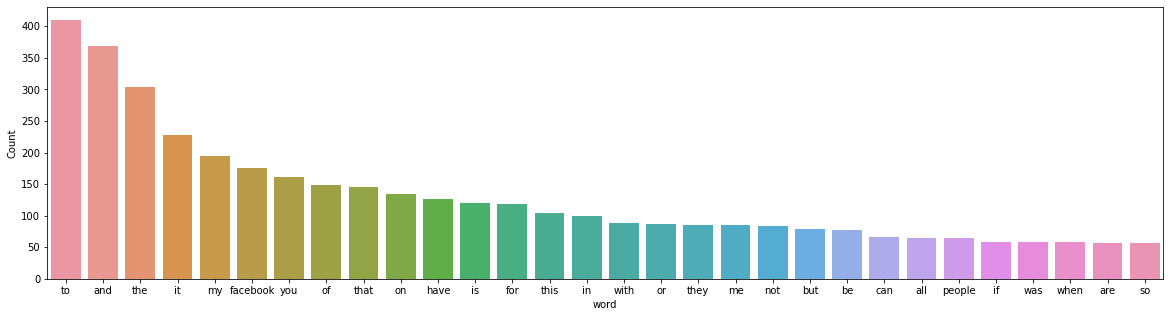

In [88]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score5))

In [89]:
# Clean text
review_us_ready_score5 = process_words(review_words_us_score5)  # processed Text Data! - move to each section

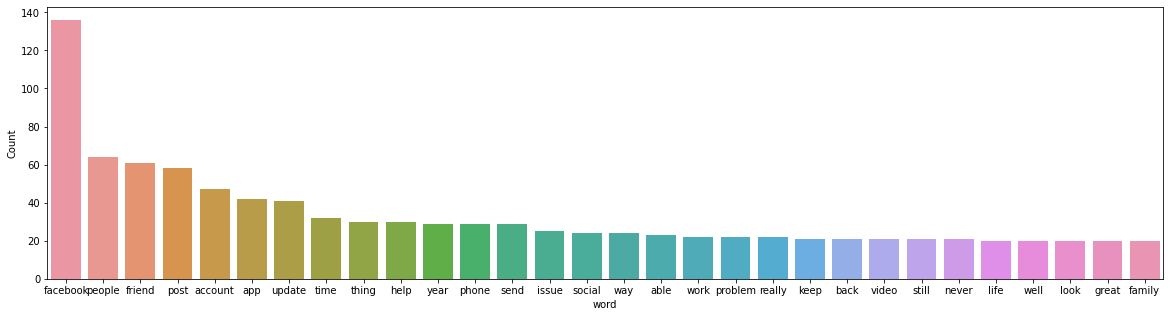

In [90]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score5))


In [91]:
# Create Dictionary
id2word_us_score5 = corpora.Dictionary(review_us_ready_score5)

2021-10-16 19:27:26,069 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:27:26,081 [INFO] gensim.corpora.dictionary - built Dictionary(1260 unique tokens: ['actual', 'bash', 'bella', 'call', 'comming']...) from 93 documents (total 4059 corpus positions)
2021-10-16 19:27:26,083 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1260 unique tokens: ['actual', 'bash', 'bella', 'call', 'comming']...) from 93 documents (total 4059 corpus positions)", 'datetime': '2021-10-16T19:27:26.083282', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [92]:
# Create Corpus: Term Document Frequency
corpus_us_score5 = [id2word_us_score5.doc2bow(text) for text in review_us_ready_score5]

In [93]:
# Training LDA model
model_list_us_score5, coherence_values_us_score5 = compute_coherence_values(dictionary=id2word_us_score5, corpus=corpus_us_score5, 
                                                              texts=review_us_ready_score5, limit=30, start=2, step=5)


2021-10-16 19:27:26,112 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:27:26,118 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:27:26,124 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:27:26,130 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 93 documents, updating model once every 93 documents, evaluating perplexity every 93 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:27:26,493 [INFO] gensim.models.ldamodel - -7.730 per-word bound, 212.2 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:26,494 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #93/93
2021-10-16 19:27:26,857 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"facebook" + 0.015*"friend" + 0.013*"people" + 0.010*"account" + 0.010*"help" + 0.009*"app" + 0.007*"upd

2021-10-16 19:27:30,289 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.015*"post" + 0.011*"account" + 0.010*"people" + 0.009*"update" + 0.008*"friend" + 0.008*"app" + 0.007*"year" + 0.007*"able" + 0.006*"send"
2021-10-16 19:27:30,290 [INFO] gensim.models.ldamodel - topic diff=0.008410, rho=0.301511
2021-10-16 19:27:30,512 [INFO] gensim.models.ldamodel - -6.779 per-word bound, 109.8 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:30,514 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #93/93
2021-10-16 19:27:30,654 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebook" + 0.015*"friend" + 0.015*"people" + 0.011*"help" + 0.008*"app" + 0.008*"post" + 0.008*"thing" + 0.007*"account" + 0.007*"social" + 0.006*"time"
2021-10-16 19:27:30,656 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.014*"post" + 0.011*"account" + 0.010*"people" + 0.009*"update" + 0.008*"friend" + 0.008*

2021-10-16 19:27:34,006 [INFO] gensim.models.ldamodel - topic diff=0.000869, rho=0.218218
2021-10-16 19:27:34,233 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:34,234 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #93/93
2021-10-16 19:27:34,407 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebook" + 0.015*"friend" + 0.015*"people" + 0.011*"help" + 0.008*"post" + 0.008*"app" + 0.008*"thing" + 0.007*"social" + 0.006*"account" + 0.006*"time"
2021-10-16 19:27:34,409 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.014*"post" + 0.012*"account" + 0.010*"people" + 0.009*"update" + 0.008*"friend" + 0.008*"app" + 0.008*"year" + 0.006*"send" + 0.006*"able"
2021-10-16 19:27:34,410 [INFO] gensim.models.ldamodel - topic diff=0.000795, rho=0.213201
2021-10-16 19:27:34,622 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexi

2021-10-16 19:27:37,902 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:37,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #93/93
2021-10-16 19:27:38,020 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebook" + 0.015*"friend" + 0.015*"people" + 0.011*"help" + 0.008*"post" + 0.008*"app" + 0.008*"thing" + 0.007*"social" + 0.006*"keep" + 0.006*"update"
2021-10-16 19:27:38,022 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.014*"post" + 0.012*"account" + 0.010*"people" + 0.009*"update" + 0.008*"friend" + 0.008*"app" + 0.008*"year" + 0.007*"send" + 0.006*"problem"
2021-10-16 19:27:38,023 [INFO] gensim.models.ldamodel - topic diff=0.000609, rho=0.176777
2021-10-16 19:27:38,248 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:

2021-10-16 19:27:41,324 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #93/93
2021-10-16 19:27:41,479 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebook" + 0.015*"friend" + 0.015*"people" + 0.011*"help" + 0.008*"post" + 0.008*"app" + 0.008*"thing" + 0.007*"social" + 0.006*"keep" + 0.006*"update"
2021-10-16 19:27:41,481 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.014*"post" + 0.012*"account" + 0.010*"people" + 0.009*"update" + 0.008*"friend" + 0.008*"app" + 0.008*"year" + 0.007*"problem" + 0.007*"send"
2021-10-16 19:27:41,482 [INFO] gensim.models.ldamodel - topic diff=0.000546, rho=0.154303
2021-10-16 19:27:41,669 [INFO] gensim.models.ldamodel - -6.777 per-word bound, 109.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:41,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #93/93
2021-10-16 19:27:41,773 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebo

2021-10-16 19:27:44,645 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:27:48,572 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:27:48,601 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 93 virtual documents
2021-10-16 19:27:48,839 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 19:27:48,844 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 19:27:48,852 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:27:48,858 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 93 documents, updating model once every 93 documents, evaluating perplexity every 93 documents, iterating 50x with a converg

2021-10-16 19:27:50,428 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"facebook" + 0.020*"people" + 0.016*"life" + 0.014*"tell" + 0.013*"place" + 0.011*"category" + 0.009*"send" + 0.009*"invite" + 0.007*"post" + 0.007*"day"
2021-10-16 19:27:50,432 [INFO] gensim.models.ldamodel - topic diff=0.125515, rho=0.408248
2021-10-16 19:27:50,641 [INFO] gensim.models.ldamodel - -6.961 per-word bound, 124.6 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:50,642 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #93/93
2021-10-16 19:27:50,734 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.020*"update" + 0.020*"facebook" + 0.017*"app" + 0.012*"account" + 0.010*"phone" + 0.010*"time" + 0.009*"send" + 0.009*"back" + 0.009*"thing" + 0.009*"watch"
2021-10-16 19:27:50,735 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"post" + 0.026*"facebook" + 0.013*"friend" + 0.012*"group" + 0.010*"phone" + 0.010*"account" + 0.010*"numb

2021-10-16 19:27:51,875 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"facebook" + 0.014*"people" + 0.009*"star" + 0.009*"cane" + 0.008*"app" + 0.008*"thing" + 0.008*"company" + 0.008*"able" + 0.007*"video" + 0.006*"keep"
2021-10-16 19:27:51,879 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"facebook" + 0.021*"people" + 0.016*"life" + 0.014*"tell" + 0.014*"place" + 0.012*"category" + 0.009*"send" + 0.009*"invite" + 0.007*"post" + 0.007*"day"
2021-10-16 19:27:51,882 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.023*"people" + 0.023*"friend" + 0.021*"facebook" + 0.014*"account" + 0.014*"family" + 0.013*"update" + 0.012*"way" + 0.010*"issue" + 0.009*"phone" + 0.009*"connect"
2021-10-16 19:27:51,884 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.020*"friend" + 0.014*"time" + 0.013*"job" + 0.012*"help" + 0.012*"app" + 0.012*"people" + 0.011*"icon" + 0.011*"notification" + 0.010*"work" + 0.009*"lie"
2021-10-16 19:27:51,886 [INFO] gensim.models.ldamodel - topic 

2021-10-16 19:27:53,042 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"facebook" + 0.021*"people" + 0.016*"life" + 0.014*"tell" + 0.014*"place" + 0.012*"category" + 0.009*"send" + 0.009*"invite" + 0.007*"post" + 0.007*"day"
2021-10-16 19:27:53,043 [INFO] gensim.models.ldamodel - topic diff=0.004667, rho=0.242536
2021-10-16 19:27:53,155 [INFO] gensim.models.ldamodel - -6.934 per-word bound, 122.3 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:53,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #93/93
2021-10-16 19:27:53,247 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"facebook" + 0.018*"friend" + 0.015*"post" + 0.014*"account" + 0.011*"help" + 0.010*"people" + 0.009*"social" + 0.009*"year" + 0.009*"life" + 0.008*"really"
2021-10-16 19:27:53,249 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"facebook" + 0.014*"people" + 0.009*"star" + 0.009*"cane" + 0.009*"app" + 0.008*"thing" + 0.008*"comp

2021-10-16 19:27:54,612 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"facebook" + 0.018*"friend" + 0.015*"post" + 0.013*"account" + 0.011*"help" + 0.010*"people" + 0.009*"social" + 0.009*"year" + 0.009*"life" + 0.008*"really"
2021-10-16 19:27:54,613 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"post" + 0.027*"facebook" + 0.012*"friend" + 0.012*"group" + 0.010*"phone" + 0.010*"account" + 0.010*"number" + 0.009*"fix" + 0.009*"time" + 0.008*"stop"
2021-10-16 19:27:54,614 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"facebook" + 0.014*"people" + 0.009*"star" + 0.009*"cane" + 0.009*"app" + 0.008*"thing" + 0.008*"company" + 0.008*"able" + 0.007*"video" + 0.007*"keep"
2021-10-16 19:27:54,615 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"friend" + 0.014*"time" + 0.013*"job" + 0.012*"app" + 0.012*"help" + 0.012*"people" + 0.011*"notification" + 0.011*"icon" + 0.010*"work" + 0.009*"lie"
2021-10-16 19:27:54,616 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 19:27:55,831 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"facebook" + 0.018*"friend" + 0.015*"post" + 0.013*"account" + 0.011*"help" + 0.010*"people" + 0.009*"social" + 0.009*"year" + 0.009*"life" + 0.008*"really"
2021-10-16 19:27:55,833 [INFO] gensim.models.ldamodel - topic diff=0.000774, rho=0.188982
2021-10-16 19:27:55,986 [INFO] gensim.models.ldamodel - -6.933 per-word bound, 122.2 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:55,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #93/93
2021-10-16 19:27:56,104 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"facebook" + 0.014*"people" + 0.009*"star" + 0.009*"cane" + 0.009*"app" + 0.008*"thing" + 0.008*"company" + 0.008*"able" + 0.007*"video" + 0.007*"keep"
2021-10-16 19:27:56,108 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"friend" + 0.014*"time" + 0.013*"job" + 0.012*"app" + 0.012*"help" + 0.012*"people" + 0.011*"notificati

2021-10-16 19:27:57,374 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.024*"friend" + 0.023*"people" + 0.021*"facebook" + 0.014*"account" + 0.014*"family" + 0.012*"update" + 0.012*"way" + 0.010*"issue" + 0.009*"connect" + 0.009*"phone"
2021-10-16 19:27:57,375 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"people" + 0.021*"facebook" + 0.016*"life" + 0.014*"tell" + 0.014*"place" + 0.012*"category" + 0.009*"send" + 0.009*"invite" + 0.007*"problem" + 0.007*"first"
2021-10-16 19:27:57,377 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"post" + 0.027*"facebook" + 0.012*"friend" + 0.012*"group" + 0.010*"phone" + 0.010*"account" + 0.010*"number" + 0.009*"time" + 0.009*"fix" + 0.008*"stop"
2021-10-16 19:27:57,378 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"friend" + 0.014*"time" + 0.013*"job" + 0.012*"app" + 0.012*"help" + 0.011*"people" + 0.011*"notification" + 0.011*"icon" + 0.010*"work" + 0.009*"lie"
2021-10-16 19:27:57,379 [INFO] gensim.models.ldamodel -

2021-10-16 19:27:58,609 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"facebook" + 0.018*"friend" + 0.015*"post" + 0.013*"account" + 0.011*"help" + 0.010*"people" + 0.009*"social" + 0.009*"year" + 0.008*"life" + 0.008*"really"
2021-10-16 19:27:58,610 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.020*"update" + 0.019*"facebook" + 0.017*"app" + 0.012*"account" + 0.010*"phone" + 0.010*"time" + 0.009*"send" + 0.009*"thing" + 0.009*"back" + 0.009*"watch"
2021-10-16 19:27:58,612 [INFO] gensim.models.ldamodel - topic diff=0.000197, rho=0.160128
2021-10-16 19:27:58,693 [INFO] gensim.models.ldamodel - -6.932 per-word bound, 122.1 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:27:58,694 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #93/93
2021-10-16 19:27:58,751 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"post" + 0.027*"facebook" + 0.012*"friend" + 0.012*"group" + 0.010*"phone" + 0.010*"account" + 0.010*"

2021-10-16 19:27:59,850 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #93/93
2021-10-16 19:28:00,010 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"friend" + 0.014*"time" + 0.013*"job" + 0.012*"app" + 0.012*"help" + 0.011*"people" + 0.011*"notification" + 0.011*"icon" + 0.010*"work" + 0.009*"lie"
2021-10-16 19:28:00,011 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.024*"friend" + 0.023*"people" + 0.021*"facebook" + 0.014*"account" + 0.014*"family" + 0.012*"update" + 0.012*"way" + 0.010*"issue" + 0.009*"connect" + 0.009*"phone"
2021-10-16 19:28:00,013 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"people" + 0.021*"facebook" + 0.016*"life" + 0.014*"tell" + 0.014*"place" + 0.012*"category" + 0.009*"send" + 0.009*"invite" + 0.007*"problem" + 0.007*"first"
2021-10-16 19:28:00,014 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.020*"update" + 0.019*"facebook" + 0.017*"app" + 0.012*"account" + 0.010*"phone" + 0.010*"time" + 0.009*"send" + 0.009*"

2021-10-16 19:28:01,133 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"facebook" + 0.014*"people" + 0.009*"star" + 0.009*"cane" + 0.008*"app" + 0.008*"thing" + 0.008*"company" + 0.008*"able" + 0.007*"video" + 0.007*"keep"
2021-10-16 19:28:01,134 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"friend" + 0.014*"time" + 0.013*"job" + 0.012*"app" + 0.012*"help" + 0.011*"people" + 0.011*"notification" + 0.011*"icon" + 0.010*"work" + 0.009*"lie"
2021-10-16 19:28:01,136 [INFO] gensim.models.ldamodel - topic diff=0.000070, rho=0.141421
2021-10-16 19:28:01,292 [INFO] gensim.models.ldamodel - -6.932 per-word bound, 122.1 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:01,293 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #93/93
2021-10-16 19:28:01,403 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.024*"friend" + 0.023*"people" + 0.021*"facebook" + 0.014*"account" + 0.014*"family" + 0.012*"update" + 0.012*"way

2021-10-16 19:28:07,624 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #93/93
2021-10-16 19:28:07,708 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"people" + 0.019*"tell" + 0.019*"invite" + 0.015*"laugh" + 0.014*"feed" + 0.011*"send" + 0.011*"facebook" + 0.010*"cook" + 0.010*"big" + 0.010*"friend"
2021-10-16 19:28:07,710 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.032*"facebook" + 0.021*"phone" + 0.015*"open" + 0.013*"send" + 0.013*"account" + 0.011*"issue" + 0.011*"people" + 0.010*"look" + 0.009*"work" + 0.009*"fb"
2021-10-16 19:28:07,712 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"people" + 0.031*"friend" + 0.027*"facebook" + 0.019*"account" + 0.016*"connect" + 0.012*"family" + 0.011*"way" + 0.008*"issue" + 0.008*"hacker" + 0.008*"hack"
2021-10-16 19:28:07,715 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"facebook" + 0.017*"help" + 0.017*"friend" + 0.015*"post" + 0.011*"year" + 0.010*"user" + 0.010*"reaction" + 0.009*"account"

2021-10-16 19:28:08,875 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"facebook" + 0.028*"post" + 0.022*"update" + 0.020*"friend" + 0.019*"app" + 0.017*"great" + 0.016*"thing" + 0.014*"add" + 0.014*"much" + 0.012*"phone"
2021-10-16 19:28:08,876 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.029*"people" + 0.021*"tell" + 0.021*"invite" + 0.016*"laugh" + 0.016*"feed" + 0.011*"send" + 0.011*"cook" + 0.011*"big" + 0.011*"fun" + 0.011*"band"
2021-10-16 19:28:08,877 [INFO] gensim.models.ldamodel - topic diff=0.043528, rho=0.316228
2021-10-16 19:28:08,989 [INFO] gensim.models.ldamodel - -7.004 per-word bound, 128.4 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:08,990 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #93/93
2021-10-16 19:28:09,040 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.017*"friend" + 0.015*"time" + 0.014*"help" + 0.014*"notification" + 0.014*"icon" + 0.013*"work" + 0.012*"people" + 0.012

2021-10-16 19:28:10,130 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #93/93
2021-10-16 19:28:10,243 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.016*"facebook" + 0.014*"people" + 0.014*"user" + 0.014*"thing" + 0.014*"watch" + 0.013*"app" + 0.011*"update" + 0.010*"video" + 0.009*"live" + 0.009*"marketplace"
2021-10-16 19:28:10,245 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.035*"people" + 0.032*"friend" + 0.027*"facebook" + 0.019*"account" + 0.016*"connect" + 0.012*"family" + 0.011*"way" + 0.009*"post" + 0.008*"hacker" + 0.008*"hack"
2021-10-16 19:28:10,246 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.023*"people" + 0.019*"facebook" + 0.018*"able" + 0.017*"life" + 0.016*"account" + 0.014*"friend" + 0.011*"time" + 0.010*"social" + 0.010*"family" + 0.010*"allow"
2021-10-16 19:28:10,247 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.021*"facebook" + 0.015*"post" + 0.015*"friend" + 0.015*"group" + 0.012*"send" + 0.012*"email" + 0.012*"people" + 

2021-10-16 19:28:11,358 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.017*"friend" + 0.015*"time" + 0.014*"help" + 0.014*"notification" + 0.014*"icon" + 0.014*"work" + 0.012*"people" + 0.012*"lie" + 0.012*"job" + 0.011*"check"
2021-10-16 19:28:11,359 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"facebook" + 0.029*"post" + 0.022*"update" + 0.020*"friend" + 0.020*"app" + 0.017*"thing" + 0.017*"great" + 0.014*"add" + 0.014*"much" + 0.012*"phone"
2021-10-16 19:28:11,360 [INFO] gensim.models.ldamodel - topic diff=0.003062, rho=0.218218
2021-10-16 19:28:11,442 [INFO] gensim.models.ldamodel - -6.993 per-word bound, 127.4 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:11,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #93/93
2021-10-16 19:28:11,510 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"facebook" + 0.018*"help" + 0.017*"friend" + 0.015*"post" + 0.011*"year" + 0.011*"reaction" + 0.010*"user" 

2021-10-16 19:28:12,548 [INFO] gensim.models.ldamodel - -6.992 per-word bound, 127.3 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:12,553 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #93/93
2021-10-16 19:28:12,637 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.016*"facebook" + 0.015*"watch" + 0.014*"people" + 0.014*"user" + 0.014*"thing" + 0.013*"app" + 0.011*"update" + 0.011*"video" + 0.009*"live" + 0.009*"marketplace"
2021-10-16 19:28:12,639 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"people" + 0.022*"tell" + 0.022*"invite" + 0.016*"laugh" + 0.016*"feed" + 0.011*"cook" + 0.011*"big" + 0.011*"fun" + 0.011*"band" + 0.011*"sometimes"
2021-10-16 19:28:12,640 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"video" + 0.017*"app" + 0.016*"watch" + 0.014*"update" + 0.013*"really" + 0.013*"family" + 0.013*"time" + 0.013*"share" + 0.013*"show" + 0.013*"advertisement"
2021-10-16 19:28:12,641 [INFO] gen

2021-10-16 19:28:13,750 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"video" + 0.017*"app" + 0.016*"watch" + 0.014*"update" + 0.013*"really" + 0.013*"family" + 0.013*"time" + 0.013*"share" + 0.013*"show" + 0.013*"advertisement"
2021-10-16 19:28:13,751 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.031*"facebook" + 0.022*"phone" + 0.015*"open" + 0.014*"account" + 0.013*"send" + 0.011*"issue" + 0.011*"email" + 0.011*"look" + 0.010*"people" + 0.009*"work"
2021-10-16 19:28:13,754 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"people" + 0.022*"tell" + 0.022*"invite" + 0.016*"laugh" + 0.016*"feed" + 0.011*"cook" + 0.011*"big" + 0.011*"fun" + 0.011*"band" + 0.011*"sometimes"
2021-10-16 19:28:13,756 [INFO] gensim.models.ldamodel - topic diff=0.000818, rho=0.176777
2021-10-16 19:28:13,855 [INFO] gensim.models.ldamodel - -6.991 per-word bound, 127.2 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:13,856 [INFO] gensim.model

2021-10-16 19:28:14,854 [INFO] gensim.models.ldamodel - topic diff=0.000522, rho=0.164399
2021-10-16 19:28:15,028 [INFO] gensim.models.ldamodel - -6.991 per-word bound, 127.2 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:15,029 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #93/93
2021-10-16 19:28:15,078 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.031*"facebook" + 0.022*"phone" + 0.015*"open" + 0.014*"account" + 0.013*"send" + 0.011*"issue" + 0.011*"email" + 0.011*"look" + 0.010*"people" + 0.009*"work"
2021-10-16 19:28:15,080 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"people" + 0.022*"tell" + 0.022*"invite" + 0.016*"laugh" + 0.016*"feed" + 0.011*"cook" + 0.011*"big" + 0.011*"fun" + 0.011*"band" + 0.011*"sometimes"
2021-10-16 19:28:15,081 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"facebook" + 0.021*"post" + 0.017*"update" + 0.015*"cane" + 0.014*"account" + 0.014*"year" + 0.014*"crash" +

2021-10-16 19:28:16,060 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.017*"friend" + 0.015*"time" + 0.014*"help" + 0.014*"notification" + 0.014*"icon" + 0.014*"work" + 0.012*"people" + 0.012*"lie" + 0.012*"job" + 0.011*"check"
2021-10-16 19:28:16,066 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.038*"facebook" + 0.018*"issue" + 0.016*"problem" + 0.015*"post" + 0.014*"picture" + 0.013*"update" + 0.012*"page" + 0.012*"fix" + 0.012*"profile" + 0.011*"new"
2021-10-16 19:28:16,070 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"facebook" + 0.029*"post" + 0.022*"update" + 0.021*"app" + 0.020*"friend" + 0.018*"thing" + 0.017*"great" + 0.014*"add" + 0.014*"much" + 0.012*"phone"
2021-10-16 19:28:16,077 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.035*"facebook" + 0.021*"post" + 0.017*"update" + 0.015*"cane" + 0.014*"account" + 0.014*"year" + 0.014*"crash" + 0.014*"click" + 0.012*"delete" + 0.010*"fix"
2021-10-16 19:28:16,078 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 19:28:17,256 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.023*"people" + 0.019*"facebook" + 0.019*"able" + 0.018*"life" + 0.016*"account" + 0.014*"friend" + 0.011*"time" + 0.010*"social" + 0.010*"family" + 0.010*"allow"
2021-10-16 19:28:17,257 [INFO] gensim.models.ldamodel - topic diff=0.000206, rho=0.144338
2021-10-16 19:28:17,376 [INFO] gensim.models.ldamodel - -6.990 per-word bound, 127.1 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:17,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #93/93
2021-10-16 19:28:17,501 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.028*"people" + 0.022*"tell" + 0.022*"invite" + 0.016*"laugh" + 0.016*"feed" + 0.011*"big" + 0.011*"cook" + 0.011*"fun" + 0.011*"sometimes" + 0.011*"place"
2021-10-16 19:28:17,502 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.023*"people" + 0.019*"facebook" + 0.019*"able" + 0.018*"life" + 0.016*"account" + 0.014*"friend" + 0.011*

2021-10-16 19:28:24,275 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.033*"video" + 0.027*"family" + 0.026*"share" + 0.013*"long" + 0.013*"show" + 0.013*"way" + 0.013*"facebook" + 0.013*"patriotism" + 0.009*"thing" + 0.008*"away"
2021-10-16 19:28:24,276 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.019*"account" + 0.017*"facebook" + 0.015*"friend" + 0.015*"post" + 0.013*"tag" + 0.011*"year" + 0.009*"issue" + 0.009*"fix" + 0.009*"app" + 0.009*"really"
2021-10-16 19:28:24,279 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"update" + 0.036*"post" + 0.028*"facebook" + 0.016*"people" + 0.015*"app" + 0.012*"let" + 0.011*"friend" + 0.010*"late" + 0.010*"great" + 0.009*"year"
2021-10-16 19:28:24,281 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.025*"app" + 0.023*"update" + 0.016*"really" + 0.015*"fix" + 0.014*"time" + 0.013*"back" + 0.013*"sure" + 0.013*"problem" + 0.013*"little" + 0.012*"show"
2021-10-16 19:28:24,282 [INFO] gensim.models.ldamodel - topic diff=0.46

2021-10-16 19:28:25,305 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.059*"facebook" + 0.023*"life" + 0.021*"add" + 0.015*"social" + 0.013*"thing" + 0.013*"medium" + 0.013*"friend" + 0.011*"click" + 0.011*"much" + 0.011*"phone"
2021-10-16 19:28:25,306 [INFO] gensim.models.ldamodel - topic diff=0.105855, rho=0.353553
2021-10-16 19:28:25,428 [INFO] gensim.models.ldamodel - -7.078 per-word bound, 135.1 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:25,429 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #93/93
2021-10-16 19:28:25,491 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.022*"friend" + 0.019*"notification" + 0.019*"icon" + 0.016*"help" + 0.016*"job" + 0.016*"work" + 0.013*"people" + 0.013*"allow" + 0.013*"read" + 0.013*"check"
2021-10-16 19:28:25,494 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"facebook" + 0.020*"friend" + 0.018*"help" + 0.009*"really" + 0.009*"email" + 0.009*"bad" + 0.009*"year

2021-10-16 19:28:26,614 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.022*"friend" + 0.019*"notification" + 0.019*"icon" + 0.016*"help" + 0.016*"job" + 0.016*"work" + 0.013*"people" + 0.013*"allow" + 0.013*"read" + 0.013*"check"
2021-10-16 19:28:26,615 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"video" + 0.030*"family" + 0.030*"share" + 0.015*"long" + 0.015*"show" + 0.015*"way" + 0.015*"patriotism" + 0.008*"facebook" + 0.008*"thing" + 0.008*"away"
2021-10-16 19:28:26,617 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.026*"tell" + 0.026*"card" + 0.020*"laugh" + 0.020*"facebook" + 0.020*"phone" + 0.013*"people" + 0.013*"cook" + 0.013*"big" + 0.013*"much" + 0.013*"information"
2021-10-16 19:28:26,618 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.020*"account" + 0.020*"facebook" + 0.016*"friend" + 0.016*"post" + 0.012*"tag" + 0.012*"year" + 0.008*"issue" + 0.008*"fix" + 0.008*"really" + 0.008*"app"
2021-10-16 19:28:26,619 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:28:27,603 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.027*"star" + 0.021*"people" + 0.018*"company" + 0.018*"app" + 0.013*"work" + 0.013*"look" + 0.013*"review" + 0.013*"post" + 0.009*"update" + 0.009*"give"
2021-10-16 19:28:27,605 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.026*"live" + 0.025*"invite" + 0.019*"people" + 0.019*"life" + 0.019*"send" + 0.019*"problem" + 0.019*"fix" + 0.013*"facebook" + 0.013*"new" + 0.013*"place"
2021-10-16 19:28:27,606 [INFO] gensim.models.ldamodel - topic diff=0.003559, rho=0.229416
2021-10-16 19:28:27,745 [INFO] gensim.models.ldamodel - -7.063 per-word bound, 133.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:27,746 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #93/93
2021-10-16 19:28:27,802 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.027*"star" + 0.021*"people" + 0.018*"company" + 0.018*"app" + 0.013*"work" + 0.013*"look" + 0.013*"review" + 0.

2021-10-16 19:28:28,753 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #93/93
2021-10-16 19:28:28,815 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.026*"people" + 0.023*"open" + 0.016*"facebook" + 0.016*"send" + 0.016*"phone" + 0.010*"issue" + 0.010*"month" + 0.010*"never" + 0.010*"maybe" + 0.010*"place"
2021-10-16 19:28:28,817 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.037*"facebook" + 0.021*"cane" + 0.019*"crash" + 0.018*"account" + 0.015*"post" + 0.013*"year" + 0.011*"marketplace" + 0.010*"help" + 0.010*"review" + 0.009*"fix"
2021-10-16 19:28:28,819 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.038*"facebook" + 0.014*"user" + 0.014*"ad" + 0.014*"loan" + 0.014*"app" + 0.014*"live" + 0.014*"scroll" + 0.010*"post" + 0.010*"send" + 0.010*"privacy"
2021-10-16 19:28:28,821 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.027*"facebook" + 0.025*"account" + 0.022*"friend" + 0.019*"post" + 0.016*"watch" + 0.016*"marketplace" + 0.014*"people" + 0.014*"

2021-10-16 19:28:29,913 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"facebook" + 0.020*"friend" + 0.018*"help" + 0.009*"really" + 0.009*"email" + 0.009*"year" + 0.009*"bad" + 0.009*"time" + 0.009*"post" + 0.007*"thing"
2021-10-16 19:28:29,916 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.020*"account" + 0.020*"facebook" + 0.016*"friend" + 0.016*"post" + 0.012*"tag" + 0.012*"year" + 0.008*"app" + 0.008*"really" + 0.008*"fix" + 0.008*"issue"
2021-10-16 19:28:29,917 [INFO] gensim.models.ldamodel - topic diff=0.000324, rho=0.182574
2021-10-16 19:28:30,033 [INFO] gensim.models.ldamodel - -7.062 per-word bound, 133.6 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:30,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #93/93
2021-10-16 19:28:30,129 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.027*"tell" + 0.027*"card" + 0.020*"laugh" + 0.020*"facebook" + 0.020*"phone" + 0.013*"people" + 0.013*"cook" + 0.

2021-10-16 19:28:31,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #93/93
2021-10-16 19:28:31,197 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.027*"facebook" + 0.020*"friend" + 0.019*"help" + 0.009*"really" + 0.009*"email" + 0.009*"year" + 0.009*"bad" + 0.009*"time" + 0.008*"post" + 0.007*"thing"
2021-10-16 19:28:31,200 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"video" + 0.030*"family" + 0.030*"share" + 0.015*"long" + 0.015*"show" + 0.015*"way" + 0.015*"patriotism" + 0.008*"facebook" + 0.008*"thing" + 0.008*"keep"
2021-10-16 19:28:31,204 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.036*"people" + 0.027*"friend" + 0.021*"facebook" + 0.016*"connect" + 0.016*"way" + 0.016*"issue" + 0.013*"post" + 0.013*"fb" + 0.012*"family" + 0.012*"thing"
2021-10-16 19:28:31,207 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"update" + 0.033*"post" + 0.029*"facebook" + 0.017*"app" + 0.015*"people" + 0.014*"let" + 0.012*"late" + 0.010*"friend" + 0.

2021-10-16 19:28:32,271 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.020*"account" + 0.020*"facebook" + 0.016*"friend" + 0.016*"post" + 0.012*"tag" + 0.012*"year" + 0.008*"issue" + 0.008*"really" + 0.008*"fix" + 0.008*"app"
2021-10-16 19:28:32,272 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"update" + 0.033*"post" + 0.029*"facebook" + 0.017*"app" + 0.015*"people" + 0.014*"let" + 0.012*"late" + 0.010*"friend" + 0.009*"great" + 0.009*"news"
2021-10-16 19:28:32,273 [INFO] gensim.models.ldamodel - topic diff=0.000106, rho=0.156174
2021-10-16 19:28:32,369 [INFO] gensim.models.ldamodel - -7.062 per-word bound, 133.6 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:32,370 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #93/93
2021-10-16 19:28:32,484 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.022*"friend" + 0.019*"icon" + 0.019*"notification" + 0.016*"help" + 0.016*"job" + 0.016*"work" + 0.013*"people" 

2021-10-16 19:28:33,445 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #93/93
2021-10-16 19:28:33,508 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.027*"facebook" + 0.025*"account" + 0.022*"friend" + 0.019*"post" + 0.016*"watch" + 0.016*"marketplace" + 0.014*"people" + 0.014*"user" + 0.012*"video" + 0.012*"group"
2021-10-16 19:28:33,510 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.026*"people" + 0.023*"open" + 0.016*"send" + 0.016*"facebook" + 0.016*"phone" + 0.010*"issue" + 0.010*"month" + 0.010*"never" + 0.010*"maybe" + 0.010*"problem"
2021-10-16 19:28:33,511 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.027*"star" + 0.021*"people" + 0.018*"company" + 0.018*"app" + 0.013*"work" + 0.013*"look" + 0.013*"review" + 0.013*"post" + 0.009*"update" + 0.009*"give"
2021-10-16 19:28:33,514 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.027*"app" + 0.027*"update" + 0.016*"notification" + 0.014*"really" + 0.014*"fix" + 0.014*"time" + 0.014*"sure" + 0.014*

2021-10-16 19:28:40,638 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 19:28:40,640 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 19:28:40,644 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:28:40,652 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 93 documents, updating model once every 93 documents, evaluating perplexity every 93 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:28:41,017 [INFO] gensim.models.ldamodel - -19.653 per-word bound, 824662.6 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:41,020 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #93/93
2021-10-16 19:28:41,325 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.024*"facebook" + 0.021*"video" + 0.019*"people" + 0.013*"keep" + 0.01

2021-10-16 19:28:42,376 [INFO] gensim.models.ldamodel - -7.137 per-word bound, 140.8 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:42,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #93/93
2021-10-16 19:28:42,430 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.034*"send" + 0.028*"time" + 0.028*"open" + 0.021*"facebook" + 0.021*"thing" + 0.021*"meme" + 0.014*"update" + 0.014*"problem" + 0.014*"show" + 0.014*"fix"
2021-10-16 19:28:42,433 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"facebook" + 0.026*"account" + 0.018*"friend" + 0.017*"keep" + 0.017*"card" + 0.013*"ask" + 0.013*"work" + 0.013*"year" + 0.013*"great" + 0.013*"phone"
2021-10-16 19:28:42,435 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"friend" + 0.034*"account" + 0.024*"facebook" + 0.020*"email" + 0.015*"hack" + 0.015*"problem" + 0.015*"hacker" + 0.010*"people" + 0.010*"post" + 0.010*"respond"
2021-10-16 19:28:42,438 [INFO] gensim

2021-10-16 19:28:43,501 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.032*"notification" + 0.024*"update" + 0.016*"thing" + 0.016*"email" + 0.012*"facebook" + 0.012*"hate" + 0.012*"story" + 0.012*"post" + 0.012*"app" + 0.012*"phone"
2021-10-16 19:28:43,502 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"facebook" + 0.032*"post" + 0.024*"update" + 0.023*"app" + 0.021*"add" + 0.017*"friend" + 0.017*"thing" + 0.013*"much" + 0.013*"phone" + 0.011*"year"
2021-10-16 19:28:43,503 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.001*"major" + 0.001*"life" + 0.001*"profile" + 0.001*"device" + 0.001*"bootp" + 0.001*"facebook" + 0.001*"crime" + 0.001*"wife" + 0.001*"concern" + 0.001*"mail"
2021-10-16 19:28:43,503 [INFO] gensim.models.ldamodel - topic diff=0.029711, rho=0.288675
2021-10-16 19:28:43,616 [INFO] gensim.models.ldamodel - -7.088 per-word bound, 136.0 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:43,618 [INFO] gensim.

2021-10-16 19:28:44,572 [INFO] gensim.models.ldamodel - topic diff=0.006514, rho=0.242536
2021-10-16 19:28:44,682 [INFO] gensim.models.ldamodel - -7.086 per-word bound, 135.8 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:44,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #93/93
2021-10-16 19:28:44,770 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"cane" + 0.027*"update" + 0.024*"facebook" + 0.024*"crash" + 0.020*"post" + 0.017*"people" + 0.014*"marketplace" + 0.014*"fix" + 0.010*"help" + 0.010*"place"
2021-10-16 19:28:44,771 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.028*"facebook" + 0.023*"keep" + 0.017*"video" + 0.017*"people" + 0.017*"thing" + 0.011*"app" + 0.011*"patriotism" + 0.011*"long" + 0.011*"update" + 0.011*"social"
2021-10-16 19:28:44,772 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"friend" + 0.034*"account" + 0.025*"facebook" + 0.020*"email" + 0.015*"hack" + 0.015*"problem" 

2021-10-16 19:28:45,843 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.039*"friend" + 0.034*"account" + 0.025*"facebook" + 0.020*"email" + 0.015*"hack" + 0.015*"problem" + 0.015*"hacker" + 0.010*"people" + 0.010*"post" + 0.010*"respond"
2021-10-16 19:28:45,850 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.023*"facebook" + 0.018*"people" + 0.014*"friend" + 0.014*"government" + 0.014*"way" + 0.014*"information" + 0.009*"time" + 0.009*"site" + 0.009*"social" + 0.009*"feel"
2021-10-16 19:28:45,855 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.035*"facebook" + 0.018*"live" + 0.018*"da" + 0.018*"people" + 0.013*"love" + 0.013*"able" + 0.013*"business" + 0.013*"post" + 0.013*"comment" + 0.013*"group"
2021-10-16 19:28:45,859 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.033*"post" + 0.033*"facebook" + 0.024*"update" + 0.023*"app" + 0.021*"add" + 0.018*"thing" + 0.017*"friend" + 0.013*"much" + 0.013*"phone" + 0.011*"year"
2021-10-16 19:28:45,860 [INFO] gensim.models.ld

2021-10-16 19:28:46,853 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.034*"facebook" + 0.021*"way" + 0.020*"people" + 0.016*"family" + 0.014*"account" + 0.012*"always" + 0.011*"post" + 0.010*"video" + 0.010*"connect" + 0.010*"ban"
2021-10-16 19:28:46,855 [INFO] gensim.models.ldamodel - topic diff=0.000528, rho=0.188982
2021-10-16 19:28:46,994 [INFO] gensim.models.ldamodel - -7.085 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:46,996 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #93/93
2021-10-16 19:28:47,052 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.021*"phone" + 0.021*"reaction" + 0.021*"work" + 0.017*"company" + 0.013*"facebook" + 0.013*"month" + 0.013*"look" + 0.013*"maybe" + 0.013*"hour" + 0.013*"star"
2021-10-16 19:28:47,054 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.001*"major" + 0.001*"life" + 0.001*"profile" + 0.001*"device" + 0.001*"bootp" + 0.001*"facebook" + 0.0

2021-10-16 19:28:48,246 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.033*"friend" + 0.019*"people" + 0.019*"invite" + 0.019*"live" + 0.019*"facebook" + 0.014*"new" + 0.014*"life" + 0.014*"help" + 0.014*"send" + 0.014*"fix"
2021-10-16 19:28:48,247 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.034*"facebook" + 0.021*"way" + 0.020*"people" + 0.016*"family" + 0.014*"account" + 0.012*"always" + 0.011*"post" + 0.010*"video" + 0.010*"connect" + 0.010*"ban"
2021-10-16 19:28:48,248 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.035*"send" + 0.028*"time" + 0.028*"open" + 0.021*"facebook" + 0.021*"thing" + 0.021*"meme" + 0.014*"update" + 0.014*"problem" + 0.014*"show" + 0.014*"fix"
2021-10-16 19:28:48,250 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.044*"facebook" + 0.026*"account" + 0.018*"friend" + 0.018*"keep" + 0.018*"card" + 0.013*"ask" + 0.013*"work" + 0.013*"year" + 0.013*"great" + 0.013*"phone"
2021-10-16 19:28:48,251 [INFO] gensim.models.ldamodel - topic #4 (0

2021-10-16 19:28:49,254 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.027*"cane" + 0.027*"update" + 0.024*"facebook" + 0.024*"crash" + 0.020*"post" + 0.017*"people" + 0.014*"marketplace" + 0.014*"fix" + 0.010*"help" + 0.010*"place"
2021-10-16 19:28:49,255 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.001*"major" + 0.001*"life" + 0.001*"profile" + 0.001*"device" + 0.001*"bootp" + 0.001*"facebook" + 0.001*"crime" + 0.001*"wife" + 0.001*"concern" + 0.001*"mail"
2021-10-16 19:28:49,256 [INFO] gensim.models.ldamodel - topic diff=0.000134, rho=0.160128
2021-10-16 19:28:49,381 [INFO] gensim.models.ldamodel - -7.084 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:49,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #93/93
2021-10-16 19:28:49,484 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.001*"repeatedly" + 0.001*"notice" + 0.001*"voice" + 0.001*"viewer" + 0.001*"untrue" + 0.001*"tech" +

2021-10-16 19:28:50,387 [INFO] gensim.models.ldamodel - -7.084 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:50,389 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #93/93
2021-10-16 19:28:50,444 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.030*"sure" + 0.023*"people" + 0.023*"app" + 0.023*"laugh" + 0.023*"tell" + 0.015*"facebook" + 0.015*"really" + 0.015*"able" + 0.015*"problem" + 0.015*"cook"
2021-10-16 19:28:50,445 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.033*"friend" + 0.019*"people" + 0.019*"invite" + 0.019*"live" + 0.019*"facebook" + 0.014*"new" + 0.014*"life" + 0.014*"help" + 0.014*"send" + 0.014*"fix"
2021-10-16 19:28:50,449 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.040*"facebook" + 0.023*"help" + 0.019*"friend" + 0.017*"post" + 0.017*"group" + 0.010*"year" + 0.010*"people" + 0.010*"die" + 0.010*"never" + 0.010*"great"
2021-10-16 19:28:50,450 [INFO] gensim.models.

2021-10-16 19:28:51,437 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.028*"facebook" + 0.023*"keep" + 0.017*"video" + 0.017*"people" + 0.017*"thing" + 0.011*"app" + 0.011*"patriotism" + 0.011*"long" + 0.011*"social" + 0.011*"review"
2021-10-16 19:28:51,439 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.033*"friend" + 0.024*"icon" + 0.024*"notification" + 0.020*"help" + 0.018*"people" + 0.016*"read" + 0.012*"message" + 0.012*"select" + 0.012*"issue" + 0.012*"account"
2021-10-16 19:28:51,440 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.030*"sure" + 0.023*"people" + 0.023*"app" + 0.023*"laugh" + 0.023*"tell" + 0.015*"facebook" + 0.015*"really" + 0.015*"able" + 0.015*"problem" + 0.015*"cook"
2021-10-16 19:28:51,441 [INFO] gensim.models.ldamodel - topic diff=0.000082, rho=0.141421
2021-10-16 19:28:51,612 [INFO] gensim.models.ldamodel - -7.084 per-word bound, 135.7 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:51,613 [INFO]

2021-10-16 19:28:59,750 [INFO] gensim.models.ldamodel - topic diff=0.346708, rho=0.500000
2021-10-16 19:28:59,898 [INFO] gensim.models.ldamodel - -7.363 per-word bound, 164.6 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:28:59,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #93/93
2021-10-16 19:28:59,998 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.049*"account" + 0.031*"facebook" + 0.030*"friend" + 0.028*"help" + 0.017*"hack" + 0.015*"app" + 0.015*"number" + 0.014*"thing" + 0.014*"people" + 0.010*"live"
2021-10-16 19:28:59,999 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.020*"major" + 0.020*"people" + 0.014*"facebook" + 0.013*"device" + 0.013*"profile" + 0.013*"life" + 0.013*"bad" + 0.013*"allow" + 0.013*"end" + 0.013*"way"
2021-10-16 19:29:00,000 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.034*"facebook" + 0.028*"people" + 0.017*"video" + 0.014*"family" + 0.014*"share" + 0.014*"way" + 0.014*"live

2021-10-16 19:29:01,096 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.034*"facebook" + 0.028*"people" + 0.017*"video" + 0.014*"family" + 0.014*"share" + 0.014*"way" + 0.014*"live" + 0.011*"connect" + 0.011*"da" + 0.009*"ban"
2021-10-16 19:29:01,099 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.037*"facebook" + 0.017*"page" + 0.015*"open" + 0.015*"app" + 0.015*"time" + 0.015*"issue" + 0.013*"phone" + 0.013*"problem" + 0.011*"check" + 0.011*"lie"
2021-10-16 19:29:01,103 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.069*"icon" + 0.058*"friend" + 0.035*"select" + 0.023*"phone" + 0.023*"turn" + 0.023*"bottom" + 0.023*"notification" + 0.023*"literally" + 0.023*"blue" + 0.012*"time"
2021-10-16 19:29:01,106 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.020*"unfortunately" + 0.020*"censure" + 0.020*"one" + 0.020*"facebook" + 0.020*"factual" + 0.010*"post" + 0.010*"never" + 0.010*"friend" + 0.010*"incomplete" + 0.010*"common"
2021-10-16 19:29:01,111 [INFO] gensim.model

2021-10-16 19:29:02,047 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.024*"still" + 0.024*"friend" + 0.024*"yr" + 0.024*"sorry" + 0.012*"little" + 0.012*"love" + 0.012*"read" + 0.012*"agree" + 0.012*"work" + 0.012*"phone"
2021-10-16 19:29:02,050 [INFO] gensim.models.ldamodel - topic diff=0.013728, rho=0.258199
2021-10-16 19:29:02,250 [INFO] gensim.models.ldamodel - -7.145 per-word bound, 141.5 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:29:02,251 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #93/93
2021-10-16 19:29:02,295 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.026*"watch" + 0.021*"account" + 0.017*"notification" + 0.017*"video" + 0.017*"marketplace" + 0.017*"update" + 0.017*"email" + 0.013*"hate" + 0.013*"continue" + 0.013*"help"
2021-10-16 19:29:02,296 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.032*"post" + 0.024*"thing" + 0.024*"app" + 0.016*"really" + 0.016*"small" + 0.016*"happy" + 0.01

2021-10-16 19:29:03,396 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.001*"repeatedly" + 0.001*"notice" + 0.001*"voice" + 0.001*"viewer" + 0.001*"untrue" + 0.001*"tech" + 0.001*"stress" + 0.001*"silence" + 0.001*"accessible" + 0.001*"plenty"
2021-10-16 19:29:03,398 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.032*"click" + 0.025*"add" + 0.019*"facebook" + 0.019*"fb" + 0.019*"issue" + 0.019*"send" + 0.019*"product" + 0.013*"comment" + 0.013*"report" + 0.013*"mp"
2021-10-16 19:29:03,400 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.028*"friend" + 0.025*"life" + 0.020*"account" + 0.020*"post" + 0.020*"share" + 0.018*"facebook" + 0.015*"send" + 0.013*"people" + 0.013*"social" + 0.013*"problem"
2021-10-16 19:29:03,401 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"notification" + 0.030*"people" + 0.025*"facebook" + 0.020*"user" + 0.020*"marketplace" + 0.015*"tell" + 0.015*"laugh" + 0.015*"story" + 0.015*"option" + 0.015*"update"
2021-10-16 19:29:03,402 [INFO]

2021-10-16 19:29:04,434 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.034*"facebook" + 0.021*"account" + 0.021*"people" + 0.021*"able" + 0.017*"keep" + 0.017*"connect" + 0.017*"star" + 0.013*"ask" + 0.013*"sure" + 0.013*"way"
2021-10-16 19:29:04,436 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.042*"facebook" + 0.026*"post" + 0.021*"ad" + 0.021*"people" + 0.017*"scroll" + 0.013*"check" + 0.013*"friend" + 0.013*"loan" + 0.013*"long" + 0.013*"thing"
2021-10-16 19:29:04,439 [INFO] gensim.models.ldamodel - topic diff=0.000771, rho=0.196116
2021-10-16 19:29:04,620 [INFO] gensim.models.ldamodel - -7.144 per-word bound, 141.4 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:29:04,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #93/93
2021-10-16 19:29:04,674 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.034*"facebook" + 0.028*"people" + 0.017*"video" + 0.014*"family" + 0.014*"share" + 0.014*"way" + 0.014*"live" 

2021-10-16 19:29:05,696 [INFO] gensim.models.ldamodel - -7.144 per-word bound, 141.4 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:29:05,699 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #93/93
2021-10-16 19:29:05,793 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.026*"watch" + 0.021*"account" + 0.017*"notification" + 0.017*"video" + 0.017*"marketplace" + 0.017*"update" + 0.017*"email" + 0.013*"hate" + 0.013*"continue" + 0.013*"help"
2021-10-16 19:29:05,796 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"notification" + 0.030*"people" + 0.025*"facebook" + 0.020*"user" + 0.020*"marketplace" + 0.015*"tell" + 0.015*"laugh" + 0.015*"story" + 0.015*"option" + 0.015*"update"
2021-10-16 19:29:05,800 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.031*"post" + 0.024*"thing" + 0.024*"app" + 0.016*"really" + 0.016*"small" + 0.016*"happy" + 0.016*"friend" + 0.016*"blind" + 0.016*"profile" + 0.016*"become"
2021-10

2021-10-16 19:29:06,802 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.032*"friend" + 0.027*"work" + 0.022*"time" + 0.022*"job" + 0.016*"app" + 0.016*"well" + 0.016*"people" + 0.016*"tag" + 0.016*"fix" + 0.016*"back"
2021-10-16 19:29:06,804 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"notification" + 0.030*"people" + 0.025*"facebook" + 0.020*"user" + 0.020*"marketplace" + 0.015*"laugh" + 0.015*"tell" + 0.015*"story" + 0.015*"option" + 0.015*"update"
2021-10-16 19:29:06,806 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.038*"time" + 0.025*"update" + 0.025*"show" + 0.025*"reload" + 0.025*"fix" + 0.013*"facebook" + 0.013*"video" + 0.013*"really" + 0.013*"iphone" + 0.013*"understand"
2021-10-16 19:29:06,807 [INFO] gensim.models.ldamodel - topic diff=0.000165, rho=0.164399
2021-10-16 19:29:06,931 [INFO] gensim.models.ldamodel - -7.144 per-word bound, 141.4 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:29:06,933 [INFO] ge

2021-10-16 19:29:07,898 [INFO] gensim.models.ldamodel - topic diff=0.000157, rho=0.154303
2021-10-16 19:29:07,986 [INFO] gensim.models.ldamodel - -7.144 per-word bound, 141.4 perplexity estimate based on a held-out corpus of 93 documents with 4059 words
2021-10-16 19:29:07,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #93/93
2021-10-16 19:29:08,054 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.021*"major" + 0.021*"people" + 0.014*"facebook" + 0.014*"device" + 0.014*"profile" + 0.014*"life" + 0.014*"bad" + 0.014*"allow" + 0.014*"end" + 0.014*"way"
2021-10-16 19:29:08,056 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.042*"facebook" + 0.026*"post" + 0.021*"ad" + 0.021*"people" + 0.017*"scroll" + 0.013*"friend" + 0.013*"check" + 0.013*"loan" + 0.013*"long" + 0.013*"app"
2021-10-16 19:29:08,059 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.033*"facebook" + 0.024*"category" + 0.024*"album" + 0.024*"reaction" + 0.019*"picture" + 0.014*"day" + 0.014*"add"

2021-10-16 19:29:09,190 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.030*"facebook" + 0.023*"update" + 0.021*"friend" + 0.020*"post" + 0.019*"app" + 0.018*"add" + 0.018*"year" + 0.015*"people" + 0.015*"well" + 0.015*"thing"
2021-10-16 19:29:09,198 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.034*"account" + 0.028*"fb" + 0.021*"photo" + 0.021*"long" + 0.021*"back" + 0.021*"month" + 0.021*"phone" + 0.014*"send" + 0.014*"team" + 0.014*"lock"
2021-10-16 19:29:09,204 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.020*"censure" + 0.020*"unfortunately" + 0.020*"one" + 0.020*"facebook" + 0.020*"factual" + 0.010*"post" + 0.010*"never" + 0.010*"friend" + 0.010*"exercise" + 0.010*"common"
2021-10-16 19:29:09,209 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.032*"friend" + 0.027*"work" + 0.022*"time" + 0.022*"job" + 0.016*"app" + 0.016*"well" + 0.016*"people" + 0.016*"tag" + 0.016*"fix" + 0.016*"back"
2021-10-16 19:29:09,212 [INFO] gensim.models.ldamodel - topic diff=0

In [94]:
%store model_list_us_score5
%store coherence_values_us_score5

Stored 'model_list_us_score5' (list)
Stored 'coherence_values_us_score5' (list)


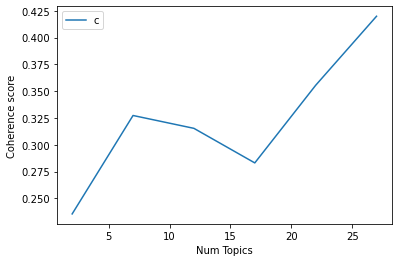

In [95]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [96]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2355
index: 1 | Num Topics = 7  has Coherence Value of 0.3273
index: 2 | Num Topics = 12  has Coherence Value of 0.3153
index: 3 | Num Topics = 17  has Coherence Value of 0.2831
index: 4 | Num Topics = 22  has Coherence Value of 0.3555
index: 5 | Num Topics = 27  has Coherence Value of 0.4199


In [177]:
# Select optimal number of topics
optimal_model_us_score5 = model_list_us_score5[5]

In [178]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score5 = pyLDAvis.gensim_models.prepare(optimal_model_us_score5, corpus_us_score5, id2word_us_score5)

In [179]:
print("pyLDAVis for us topics for score=5:")
vis_us_score5

pyLDAVis for us topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
22    -0.070992 -0.059794       1        1  10.378281
18    -0.107902  0.091300       2        1   8.669576
19    -0.066294  0.142410       3        1   7.600263
11    -0.126773 -0.016876       4        1   7.296393
8     -0.101333 -0.072219       5        1   7.107416
26    -0.119044  0.022994       6        1   6.081660
10    -0.097235  0.088689       7        1   4.716590
1     -0.054277  0.033140       8        1   4.667466
13    -0.070514 -0.098095       9        1   4.643839
9     -0.092687 -0.048179      10        1   3.998832
25    -0.015115 -0.113012      11        1   3.805717
23    -0.038556  0.001046      12        1   3.460769
5      0.048429  0.102912      13        1   3.385761
20     0.016376  0.038564      14        1   3.222725
16     0.048912 -0.074907      15        1   2.794768
14     0.051883  0.042475      16        1   2.645948
3     -0.001414 -0.029664      17        1   2.523970
7      0.096911  0.085871      18        1   2.522812
21     0.018774 -0.051663      19        1   2.498181
24     0.044761 -0.027517      20        1   2.025642
17     0.026550 -0.010537      21        1   1.487531
12     0.098142  0.026312      22        1   1.389015
6      0.125466 -0.016133      23        1   1.044256
15     0.096833  0.008874      24        1   0.970394
2      0.083424 -0.053061      25        1   0.896539
4      0.102836 -0.006464      26        1   0.082828
0      0.102836 -0.006464      27        1   0.082828, topic_info=         Term        Freq       Total Category  logprob  loglift
67     friend   47.000000   47.000000  Default  30.0000  30.0000
34    account   39.000000   39.000000  Default  29.0000  29.0000
58     update   33.000000   33.000000  Default  28.0000  28.0000
11   facebook  109.000000  109.000000  Default  27.0000  27.0000
30       time   25.000000   25.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
416     share    0.002668   12.694753  Topic27  -7.1388  -1.3713
30       time    0.002668   25.027678  Topic27  -7.1388  -2.0501
77        new    0.002668   16.063577  Topic27  -7.1388  -1.6067
149     never    0.002668   16.820623  Topic27  -7.1388  -1.6528
796     block    0.002668    5.752575  Topic27  -7.1388  -0.5798

[1510 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
513       3  0.266218  ability
513      11  0.532436  ability
513      17  0.266218  ability
33        1  0.157448     able
33        2  0.209931     able
...     ...       ...      ...
110      13  0.041423     year
110      17  0.041423     year
110      19  0.041423     year
884       4  0.652966      yes
1142     24  0.619464       yr

[2118 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 19, 20, 12, 9, 27, 11, 2, 14, 10, 26, 24, 6, 21, 17, 15, 4, 8, 22, 25, 18, 13, 7, 16, 3, 5, 1])

## LDA Topic Modelling (Rating = 1,2,3)

In [100]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_us_score1N2N3 = facebook_ios_us_review_YearMonth_score1N2N3.review.values.tolist()
review_words_us_score1N2N3 = list(sent_to_words(review_us_score1N2N3))
print(review_words_us_score1N2N3[:1])

[['facebook', 'used', 'to', 'be', 'so', 'great', 'remember', 'when', 'it', 'was', 'just', 'social', 'networking', 'site', 'then', 'it', 'became', 'media', 'consumption', 'site', 'which', 'was', 'ok', 'now', 'facebook', 'has', 'become', 'revenue', 'generating', 'machine', 'and', 'it', 'shows', 'placing', 'ads', 'that', 'cannot', 'be', 'skipped', 'during', 'the', 'climax', 'of', 'video', 'is', 'very', 'frustrating', 'and', 'stupid', 'the', 'new', 'slide', 'to', 'open', 'camera', 'look', 'this', 'isn', 'instagram', 'ok', 'it', 'facebook', 'don', 'take', 'picture', 'often', 'enough', 'to', 'want', 'to', 'swipe', 'my', 'finger', 'to', 'open', 'camera', 'app', 'of', 'the', 'times', 'that', 'have', 'opened', 'the', 'camera', 'feature', 'on', 'facebook', 'one', 'was', 'intentional', 'the', 'intent', 'was', 'to', 'find', 'way', 'to', 'disable', 'it', 'facebook', 'is', 'going', 'downhill', 'as', 'is', 'our', 'country', 'we', 'have', 'become', 'too', 'inclined', 'to', 'post', 'our', 'lives', 'on'

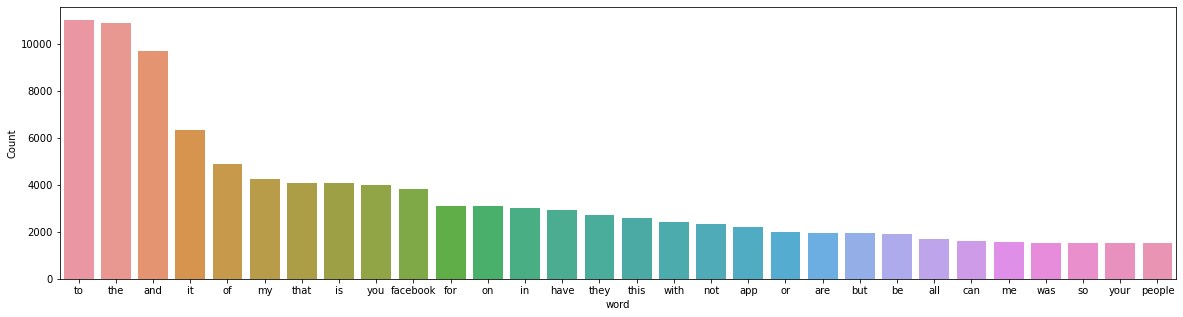

In [101]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_score1N2N3))

In [102]:
# Clean text
review_us_ready_score1N2N3 = process_words(review_words_us_score1N2N3)  # processed Text Data! - move to each section

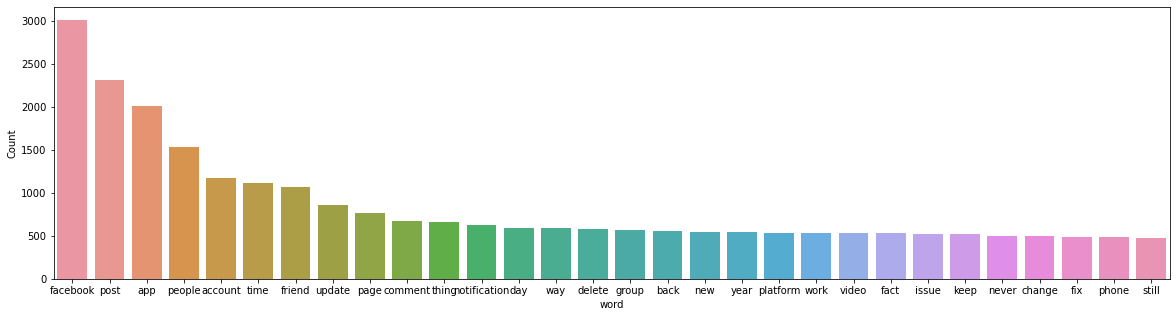

In [103]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_us_ready_score1N2N3))


In [104]:
# Create Dictionary
id2word_us_score1N2N3 = corpora.Dictionary(review_us_ready_score1N2N3)

2021-10-16 19:30:14,895 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:30:15,368 [INFO] gensim.corpora.dictionary - built Dictionary(7275 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 1981 documents (total 118218 corpus positions)
2021-10-16 19:30:15,370 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(7275 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 1981 documents (total 118218 corpus positions)", 'datetime': '2021-10-16T19:30:15.369995', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [105]:
# Create Corpus: Term Document Frequency
corpus_us_score1N2N3 = [id2word_us_score1N2N3.doc2bow(text) for text in review_us_ready_score1N2N3]

In [106]:
# Training LDA model
model_list_us_score1N2N3, coherence_values_us_score1N2N3 = compute_coherence_values(dictionary=id2word_us_score1N2N3, corpus=corpus_us_score1N2N3, 
                                                              texts=review_us_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 19:30:15,645 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:30:15,647 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:30:15,651 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:30:15,655 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1981 documents, updating model once every 1000 documents, evaluating perplexity every 1981 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:30:15,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1981
2021-10-16 19:30:18,544 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:30:18,551 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.021*"app" + 0.018*"post" + 0.014*"update" + 0.012*"account" + 0.011*"time" + 0.008*"people" + 0.008*"new" + 0.007*"notif

2021-10-16 19:30:54,158 [INFO] gensim.models.ldamodel - -7.193 per-word bound, 146.3 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:30:54,160 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1981/1981
2021-10-16 19:30:56,193 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:30:56,196 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"facebook" + 0.022*"app" + 0.016*"account" + 0.015*"post" + 0.012*"time" + 0.010*"update" + 0.008*"page" + 0.007*"notification" + 0.006*"phone" + 0.006*"issue"
2021-10-16 19:30:56,198 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.024*"facebook" + 0.020*"post" + 0.020*"people" + 0.011*"friend" + 0.009*"fact" + 0.008*"platform" + 0.007*"app" + 0.006*"censor" + 0.006*"group" + 0.006*"social"
2021-10-16 19:30:56,200 [INFO] gensim.models.ldamodel - topic diff=0.231922, rho=0.378478
2021-10-16 19:30:56,201 [INFO] gensim.models.ld

2021-10-16 19:31:23,309 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.018*"post" + 0.009*"fact" + 0.009*"platform" + 0.008*"friend" + 0.007*"social" + 0.006*"allow" + 0.006*"censor" + 0.006*"medium"
2021-10-16 19:31:23,310 [INFO] gensim.models.ldamodel - topic diff=0.163531, rho=0.288904
2021-10-16 19:31:25,988 [INFO] gensim.models.ldamodel - -7.164 per-word bound, 143.4 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:31:25,990 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1981/1981
2021-10-16 19:31:27,878 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:31:27,881 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.023*"facebook" + 0.019*"post" + 0.015*"account" + 0.012*"time" + 0.011*"update" + 0.009*"page" + 0.008*"friend" + 0.008*"notification" + 0.007*"issue"
2021-10-16 19:31:27,883 [INFO] gensim.model

2021-10-16 19:31:51,531 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1981
2021-10-16 19:31:53,108 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:31:53,114 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.023*"facebook" + 0.020*"post" + 0.013*"account" + 0.012*"time" + 0.012*"update" + 0.010*"page" + 0.009*"friend" + 0.009*"notification" + 0.007*"new"
2021-10-16 19:31:53,115 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.017*"post" + 0.009*"fact" + 0.009*"platform" + 0.008*"friend" + 0.007*"social" + 0.006*"allow" + 0.006*"censor" + 0.006*"ban"
2021-10-16 19:31:53,116 [INFO] gensim.models.ldamodel - topic diff=0.130478, rho=0.242671
2021-10-16 19:31:55,611 [INFO] gensim.models.ldamodel - -7.160 per-word bound, 143.1 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:31:55,614 [INFO] gensim.models.l

2021-10-16 19:32:20,644 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.010*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"censor" + 0.006*"ban" + 0.006*"allow"
2021-10-16 19:32:20,646 [INFO] gensim.models.ldamodel - topic diff=0.112681, rho=0.218317
2021-10-16 19:32:20,647 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1981
2021-10-16 19:32:22,161 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:32:22,165 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.023*"facebook" + 0.020*"post" + 0.013*"account" + 0.012*"time" + 0.012*"update" + 0.010*"page" + 0.009*"friend" + 0.009*"notification" + 0.007*"new"
2021-10-16 19:32:22,167 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.009*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.006*"ban" + 0.006

2021-10-16 19:32:47,215 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1981/1981
2021-10-16 19:32:48,884 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:32:48,887 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.023*"facebook" + 0.020*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"page" + 0.009*"friend" + 0.008*"notification" + 0.007*"new"
2021-10-16 19:32:48,889 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.010*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"censor" + 0.007*"ban" + 0.006*"allow"
2021-10-16 19:32:48,889 [INFO] gensim.models.ldamodel - topic diff=0.099956, rho=0.196188
2021-10-16 19:32:48,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1981
2021-10-16 19:32:50,354 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 do

2021-10-16 19:33:13,250 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.009*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"ban" + 0.006*"allow" + 0.006*"censor"
2021-10-16 19:33:13,251 [INFO] gensim.models.ldamodel - topic diff=0.091714, rho=0.179660
2021-10-16 19:33:15,654 [INFO] gensim.models.ldamodel - -7.158 per-word bound, 142.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:33:15,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1981/1981
2021-10-16 19:33:17,386 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:33:17,389 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.023*"facebook" + 0.020*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"page" + 0.009*"friend" + 0.008*"notification" + 0.007*"new"
2021-10-16 19:33:17,390 [INFO] gensim.models.ld

2021-10-16 19:33:39,861 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1981
2021-10-16 19:33:41,392 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:33:41,397 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.023*"facebook" + 0.020*"post" + 0.013*"account" + 0.012*"time" + 0.012*"update" + 0.010*"page" + 0.010*"friend" + 0.009*"notification" + 0.007*"new"
2021-10-16 19:33:41,400 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.009*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"ban" + 0.006*"allow" + 0.006*"censor"
2021-10-16 19:33:41,403 [INFO] gensim.models.ldamodel - topic diff=0.084373, rho=0.166711
2021-10-16 19:33:43,864 [INFO] gensim.models.ldamodel - -7.157 per-word bound, 142.7 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:33:43,865 [INFO] gensim.models.l

2021-10-16 19:34:07,916 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.010*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"ban" + 0.007*"censor" + 0.006*"allow"
2021-10-16 19:34:07,918 [INFO] gensim.models.ldamodel - topic diff=0.079002, rho=0.158151
2021-10-16 19:34:07,920 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1981
2021-10-16 19:34:09,497 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:34:09,500 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.023*"facebook" + 0.020*"post" + 0.013*"account" + 0.012*"time" + 0.012*"update" + 0.010*"page" + 0.010*"friend" + 0.009*"notification" + 0.007*"new"
2021-10-16 19:34:09,502 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.009*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"ban" + 0.006

2021-10-16 19:34:34,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1981/1981
2021-10-16 19:34:35,873 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:34:35,876 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.023*"facebook" + 0.020*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"page" + 0.009*"friend" + 0.008*"notification" + 0.007*"new"
2021-10-16 19:34:35,878 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.010*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"ban" + 0.007*"censor" + 0.006*"allow"
2021-10-16 19:34:35,878 [INFO] gensim.models.ldamodel - topic diff=0.074144, rho=0.149103
2021-10-16 19:34:35,880 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1981
2021-10-16 19:34:37,468 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 do

2021-10-16 19:34:59,674 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.026*"facebook" + 0.020*"people" + 0.016*"post" + 0.009*"fact" + 0.009*"platform" + 0.007*"friend" + 0.007*"social" + 0.007*"ban" + 0.006*"allow" + 0.006*"censor"
2021-10-16 19:34:59,676 [INFO] gensim.models.ldamodel - topic diff=0.070497, rho=0.141448
2021-10-16 19:35:01,987 [INFO] gensim.models.ldamodel - -7.156 per-word bound, 142.6 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:35:01,988 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1981/1981
2021-10-16 19:35:03,716 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:35:03,725 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"app" + 0.023*"facebook" + 0.020*"post" + 0.014*"account" + 0.012*"time" + 0.011*"update" + 0.010*"page" + 0.009*"friend" + 0.008*"notification" + 0.007*"new"
2021-10-16 19:35:03,729 [INFO] gensim.models.ld

2021-10-16 19:35:40,024 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.025*"post" + 0.023*"app" + 0.022*"facebook" + 0.013*"people" + 0.013*"friend" + 0.012*"time" + 0.009*"comment" + 0.009*"update" + 0.008*"ad" + 0.008*"page"
2021-10-16 19:35:40,026 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.019*"app" + 0.018*"post" + 0.014*"facebook" + 0.013*"time" + 0.012*"update" + 0.011*"group" + 0.010*"video" + 0.010*"notification" + 0.007*"issue" + 0.007*"new"
2021-10-16 19:35:40,028 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.018*"app" + 0.016*"friend" + 0.016*"notification" + 0.015*"post" + 0.013*"facebook" + 0.011*"truth" + 0.011*"people" + 0.006*"page" + 0.006*"thing" + 0.006*"time"
2021-10-16 19:35:40,030 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"facebook" + 0.020*"post" + 0.018*"people" + 0.013*"app" + 0.010*"fact" + 0.009*"platform" + 0.008*"allow" + 0.008*"opinion" + 0.008*"censor" + 0.006*"way"
2021-10-16 19:35:40,031 [INFO] gensim.models.ldamodel - 

2021-10-16 19:35:56,872 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.034*"facebook" + 0.031*"account" + 0.014*"people" + 0.011*"post" + 0.008*"friend" + 0.008*"year" + 0.007*"time" + 0.007*"help" + 0.006*"day" + 0.006*"page"
2021-10-16 19:35:56,876 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"marketplace" + 0.016*"item" + 0.011*"app" + 0.009*"search" + 0.008*"facebook" + 0.008*"look" + 0.008*"sell" + 0.008*"car" + 0.006*"buy" + 0.006*"find"
2021-10-16 19:35:56,877 [INFO] gensim.models.ldamodel - topic diff=0.278978, rho=0.408896
2021-10-16 19:35:59,510 [INFO] gensim.models.ldamodel - -7.357 per-word bound, 164.0 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:35:59,512 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1981/1981
2021-10-16 19:36:01,353 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:36:01,361 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:36:14,010 [INFO] gensim.models.ldamodel - topic diff=0.180535, rho=0.353974
2021-10-16 19:36:14,012 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/1981
2021-10-16 19:36:15,881 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:36:15,888 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.008*"politician" + 0.005*"thing" + 0.005*"communism" + 0.005*"viewpoint" + 0.005*"stop" + 0.005*"ghost" + 0.004*"privacy" + 0.004*"welcome" + 0.004*"sign" + 0.004*"robot"
2021-10-16 19:36:15,890 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.051*"marketplace" + 0.028*"item" + 0.012*"sell" + 0.012*"search" + 0.010*"look" + 0.010*"car" + 0.009*"listing" + 0.009*"buy" + 0.009*"sale" + 0.007*"price"
2021-10-16 19:36:15,892 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"app" + 0.021*"notification" + 0.021*"post" + 0.021*"update" + 0.015*"group" + 0.013*"video" + 0.012*"time" + 0.011*"new" + 0.010*

2021-10-16 19:36:32,139 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:36:32,144 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"app" + 0.020*"post" + 0.020*"update" + 0.020*"notification" + 0.016*"group" + 0.013*"video" + 0.012*"time" + 0.010*"photo" + 0.010*"new" + 0.009*"facebook"
2021-10-16 19:36:32,146 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.018*"birthday" + 0.012*"notification" + 0.012*"friend" + 0.005*"link" + 0.005*"request" + 0.005*"event" + 0.004*"nation" + 0.004*"keep" + 0.004*"people" + 0.004*"app"
2021-10-16 19:36:32,147 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.012*"politician" + 0.007*"communism" + 0.007*"ghost" + 0.006*"viewpoint" + 0.005*"welcome" + 0.005*"thing" + 0.005*"robot" + 0.005*"stop" + 0.004*"audience" + 0.004*"screen"
2021-10-16 19:36:32,148 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"app" + 0.028*"post" + 0.023*"facebook" + 0.015*"time" + 0.014*"frie

2021-10-16 19:36:45,599 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"app" + 0.022*"notification" + 0.021*"post" + 0.020*"update" + 0.016*"group" + 0.014*"video" + 0.012*"time" + 0.011*"photo" + 0.010*"new" + 0.009*"feature"
2021-10-16 19:36:45,601 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"facebook" + 0.025*"people" + 0.019*"post" + 0.014*"fact" + 0.013*"platform" + 0.011*"censor" + 0.009*"opinion" + 0.009*"speech" + 0.009*"allow" + 0.009*"social"
2021-10-16 19:36:45,602 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.010*"politician" + 0.006*"communism" + 0.006*"ghost" + 0.006*"viewpoint" + 0.005*"thing" + 0.004*"welcome" + 0.004*"robot" + 0.004*"stop" + 0.004*"religion" + 0.004*"audience"
2021-10-16 19:36:45,605 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"facebook" + 0.035*"account" + 0.011*"people" + 0.009*"post" + 0.009*"year" + 0.008*"time" + 0.008*"friend" + 0.008*"help" + 0.008*"day" + 0.007*"never"
2021-10-16 19:36:45,606 [INFO] gensim

2021-10-16 19:37:01,015 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.013*"politician" + 0.008*"ghost" + 0.008*"communism" + 0.006*"viewpoint" + 0.006*"welcome" + 0.005*"robot" + 0.004*"audience" + 0.004*"thing" + 0.004*"screen" + 0.004*"sue"
2021-10-16 19:37:01,016 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.075*"marketplace" + 0.039*"item" + 0.017*"sell" + 0.015*"search" + 0.014*"sale" + 0.013*"listing" + 0.012*"look" + 0.011*"buy" + 0.011*"car" + 0.010*"price"
2021-10-16 19:37:01,018 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"app" + 0.029*"post" + 0.023*"facebook" + 0.015*"friend" + 0.015*"time" + 0.014*"update" + 0.012*"page" + 0.011*"comment" + 0.009*"people" + 0.009*"ad"
2021-10-16 19:37:01,020 [INFO] gensim.models.ldamodel - topic diff=0.096727, rho=0.250149
2021-10-16 19:37:01,021 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1981
2021-10-16 19:37:02,767 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-16 19:37:14,033 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"facebook" + 0.025*"people" + 0.019*"post" + 0.014*"fact" + 0.013*"platform" + 0.010*"censor" + 0.009*"speech" + 0.009*"opinion" + 0.009*"allow" + 0.009*"social"
2021-10-16 19:37:14,034 [INFO] gensim.models.ldamodel - topic diff=0.085907, rho=0.229531
2021-10-16 19:37:16,367 [INFO] gensim.models.ldamodel - -7.266 per-word bound, 153.9 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:37:16,368 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1981/1981
2021-10-16 19:37:17,817 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:37:17,824 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"app" + 0.020*"post" + 0.020*"update" + 0.019*"notification" + 0.016*"group" + 0.014*"video" + 0.011*"time" + 0.011*"photo" + 0.009*"new" + 0.009*"feature"
2021-10-16 19:37:17,827 [INFO] gensim.models.l

2021-10-16 19:37:28,842 [INFO] gensim.models.ldamodel - topic diff=0.079922, rho=0.218317
2021-10-16 19:37:28,844 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1981
2021-10-16 19:37:30,427 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:37:30,439 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"app" + 0.020*"notification" + 0.020*"update" + 0.020*"post" + 0.016*"group" + 0.015*"video" + 0.012*"time" + 0.011*"photo" + 0.010*"new" + 0.010*"feature"
2021-10-16 19:37:30,442 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.029*"post" + 0.023*"facebook" + 0.015*"update" + 0.015*"time" + 0.015*"friend" + 0.012*"page" + 0.010*"comment" + 0.009*"fix" + 0.009*"people"
2021-10-16 19:37:30,445 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"facebook" + 0.025*"people" + 0.019*"post" + 0.014*"fact" + 0.013*"platform" + 0.010*"censor" + 0.009*"speech" + 0.009*"opinion" + 0.009*"al

2021-10-16 19:37:45,755 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:37:45,762 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.029*"post" + 0.022*"facebook" + 0.015*"friend" + 0.015*"time" + 0.014*"update" + 0.012*"page" + 0.011*"comment" + 0.009*"people" + 0.009*"fix"
2021-10-16 19:37:45,764 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.083*"marketplace" + 0.042*"item" + 0.019*"sell" + 0.016*"sale" + 0.016*"search" + 0.013*"listing" + 0.013*"buy" + 0.012*"look" + 0.012*"car" + 0.011*"local"
2021-10-16 19:37:45,766 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.028*"birthday" + 0.005*"nation" + 0.005*"friend" + 0.005*"link" + 0.004*"event" + 0.004*"range" + 0.003*"mouth" + 0.003*"red" + 0.003*"loser" + 0.003*"army"
2021-10-16 19:37:45,768 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.024*"app" + 0.019*"update" + 0.019*"post" + 0.018*"notification" + 0.016*"group" + 0.015*"video" + 0.01

2021-10-16 19:37:59,342 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.011*"politician" + 0.008*"ghost" + 0.007*"communism" + 0.006*"viewpoint" + 0.005*"welcome" + 0.005*"robot" + 0.004*"audience" + 0.004*"religion" + 0.004*"sue" + 0.003*"opposite"
2021-10-16 19:37:59,345 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"facebook" + 0.036*"account" + 0.009*"people" + 0.009*"year" + 0.009*"time" + 0.009*"help" + 0.008*"friend" + 0.008*"post" + 0.008*"day" + 0.008*"page"
2021-10-16 19:37:59,349 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.030*"post" + 0.022*"facebook" + 0.015*"update" + 0.015*"time" + 0.015*"friend" + 0.012*"page" + 0.010*"comment" + 0.009*"notification" + 0.009*"fix"
2021-10-16 19:37:59,353 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"app" + 0.020*"update" + 0.019*"post" + 0.019*"notification" + 0.016*"group" + 0.016*"video" + 0.012*"photo" + 0.011*"time" + 0.010*"feature" + 0.010*"new"
2021-10-16 19:37:59,356 [INFO] gensim.m

2021-10-16 19:38:14,185 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"app" + 0.019*"update" + 0.018*"post" + 0.017*"notification" + 0.016*"group" + 0.016*"video" + 0.012*"photo" + 0.011*"time" + 0.010*"feature" + 0.009*"new"
2021-10-16 19:38:14,188 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.084*"marketplace" + 0.042*"item" + 0.020*"sell" + 0.016*"sale" + 0.016*"search" + 0.013*"listing" + 0.013*"buy" + 0.012*"look" + 0.012*"car" + 0.011*"local"
2021-10-16 19:38:14,189 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"birthday" + 0.005*"nation" + 0.005*"link" + 0.004*"event" + 0.004*"range" + 0.004*"friend" + 0.003*"mouth" + 0.003*"red" + 0.003*"loser" + 0.003*"army"
2021-10-16 19:38:14,191 [INFO] gensim.models.ldamodel - topic diff=0.065056, rho=0.185756
2021-10-16 19:38:14,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1981
2021-10-16 19:38:15,870 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 19

2021-10-16 19:38:26,807 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.011*"politician" + 0.008*"ghost" + 0.007*"communism" + 0.006*"viewpoint" + 0.005*"welcome" + 0.005*"robot" + 0.004*"audience" + 0.004*"religion" + 0.004*"sue" + 0.004*"opposite"
2021-10-16 19:38:26,809 [INFO] gensim.models.ldamodel - topic diff=0.061357, rho=0.176829
2021-10-16 19:38:28,982 [INFO] gensim.models.ldamodel - -7.255 per-word bound, 152.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:38:28,987 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1981/1981
2021-10-16 19:38:30,441 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:38:30,466 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.013*"politician" + 0.009*"ghost" + 0.008*"communism" + 0.006*"viewpoint" + 0.006*"welcome" + 0.006*"robot" + 0.005*"audience" + 0.004*"sue" + 0.004*"opposite" + 0.004*"religion"
2021-10-16 19:38

2021-10-16 19:38:41,322 [INFO] gensim.models.ldamodel - topic diff=0.059096, rho=0.171547
2021-10-16 19:38:41,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1981
2021-10-16 19:38:42,928 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:38:42,952 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"people" + 0.025*"facebook" + 0.020*"post" + 0.014*"fact" + 0.013*"platform" + 0.010*"censor" + 0.009*"speech" + 0.009*"allow" + 0.009*"opinion" + 0.009*"social"
2021-10-16 19:38:42,958 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.084*"marketplace" + 0.043*"item" + 0.022*"sell" + 0.016*"sale" + 0.016*"search" + 0.014*"buy" + 0.012*"car" + 0.012*"listing" + 0.012*"look" + 0.010*"local"
2021-10-16 19:38:42,964 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.030*"post" + 0.022*"facebook" + 0.015*"update" + 0.015*"time" + 0.015*"friend" + 0.011*"page" + 0.011*"comment" + 0.011*"not

2021-10-16 19:38:57,645 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:38:57,651 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"birthday" + 0.005*"nation" + 0.004*"range" + 0.004*"event" + 0.004*"link" + 0.003*"mouth" + 0.003*"red" + 0.003*"loser" + 0.003*"army" + 0.003*"addictive"
2021-10-16 19:38:57,652 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.086*"marketplace" + 0.043*"item" + 0.021*"sell" + 0.017*"sale" + 0.017*"search" + 0.013*"buy" + 0.013*"listing" + 0.012*"look" + 0.012*"car" + 0.011*"local"
2021-10-16 19:38:57,654 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"app" + 0.019*"update" + 0.017*"post" + 0.017*"video" + 0.016*"group" + 0.014*"notification" + 0.012*"photo" + 0.011*"time" + 0.010*"feature" + 0.009*"new"
2021-10-16 19:38:57,655 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"facebook" + 0.036*"account" + 0.009*"year" + 0.009*"time" + 0.009*"people" + 0.008*"help" + 

2021-10-16 19:39:10,064 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"facebook" + 0.037*"account" + 0.009*"year" + 0.009*"time" + 0.009*"people" + 0.009*"help" + 0.008*"friend" + 0.008*"day" + 0.008*"page" + 0.007*"never"
2021-10-16 19:39:10,066 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"app" + 0.020*"update" + 0.018*"video" + 0.017*"post" + 0.016*"group" + 0.014*"notification" + 0.012*"photo" + 0.011*"time" + 0.010*"feature" + 0.009*"new"
2021-10-16 19:39:10,068 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.085*"marketplace" + 0.044*"item" + 0.022*"sell" + 0.017*"sale" + 0.017*"search" + 0.014*"buy" + 0.013*"car" + 0.012*"listing" + 0.012*"look" + 0.010*"local"
2021-10-16 19:39:10,070 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"people" + 0.025*"facebook" + 0.020*"post" + 0.014*"fact" + 0.013*"platform" + 0.010*"censor" + 0.009*"speech" + 0.009*"allow" + 0.009*"opinion" + 0.009*"social"
2021-10-16 19:39:10,072 [INFO] gensim.models.ldamodel - 

2021-10-16 19:39:24,528 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"people" + 0.025*"facebook" + 0.020*"post" + 0.015*"fact" + 0.013*"platform" + 0.011*"censor" + 0.010*"speech" + 0.009*"opinion" + 0.009*"allow" + 0.009*"social"
2021-10-16 19:39:24,530 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.023*"app" + 0.019*"update" + 0.018*"video" + 0.016*"group" + 0.016*"post" + 0.013*"notification" + 0.013*"photo" + 0.011*"time" + 0.010*"feature" + 0.009*"new"
2021-10-16 19:39:24,532 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.013*"politician" + 0.009*"ghost" + 0.008*"communism" + 0.006*"viewpoint" + 0.006*"welcome" + 0.006*"robot" + 0.005*"audience" + 0.004*"sue" + 0.004*"opposite" + 0.004*"religion"
2021-10-16 19:39:24,533 [INFO] gensim.models.ldamodel - topic diff=0.052083, rho=0.154338
2021-10-16 19:39:24,535 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1981
2021-10-16 19:39:26,263 [INFO] gensim.models.ldamodel - merging changes from 100

2021-10-16 19:39:36,752 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"people" + 0.025*"facebook" + 0.020*"post" + 0.014*"fact" + 0.013*"platform" + 0.010*"censor" + 0.009*"speech" + 0.009*"allow" + 0.009*"opinion" + 0.009*"social"
2021-10-16 19:39:36,755 [INFO] gensim.models.ldamodel - topic diff=0.050001, rho=0.149103
2021-10-16 19:39:39,036 [INFO] gensim.models.ldamodel - -7.252 per-word bound, 152.4 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:39:39,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1981/1981
2021-10-16 19:39:40,448 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:39:40,455 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.030*"post" + 0.022*"facebook" + 0.015*"time" + 0.014*"friend" + 0.014*"update" + 0.011*"page" + 0.011*"comment" + 0.011*"notification" + 0.009*"people"
2021-10-16 19:39:40,457 [INFO] gensim.mo

2021-10-16 19:39:51,200 [INFO] gensim.models.ldamodel - topic diff=0.048785, rho=0.145894
2021-10-16 19:39:51,203 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1981
2021-10-16 19:39:52,890 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:39:52,896 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"app" + 0.020*"update" + 0.019*"video" + 0.016*"group" + 0.015*"post" + 0.013*"photo" + 0.011*"notification" + 0.011*"time" + 0.010*"feature" + 0.009*"new"
2021-10-16 19:39:52,897 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.012*"politician" + 0.008*"ghost" + 0.008*"communism" + 0.006*"viewpoint" + 0.005*"welcome" + 0.005*"robot" + 0.005*"audience" + 0.004*"religion" + 0.004*"sue" + 0.004*"opposite"
2021-10-16 19:39:52,899 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"birthday" + 0.005*"nation" + 0.004*"event" + 0.004*"range" + 0.003*"mouth" + 0.003*"link" + 0.003*"arbitrary" + 0.003*

2021-10-16 19:40:07,741 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:40:07,747 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.087*"marketplace" + 0.044*"item" + 0.021*"sell" + 0.017*"sale" + 0.017*"search" + 0.014*"buy" + 0.013*"listing" + 0.013*"car" + 0.012*"look" + 0.011*"local"
2021-10-16 19:40:07,749 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"app" + 0.030*"post" + 0.022*"facebook" + 0.015*"time" + 0.014*"update" + 0.014*"friend" + 0.012*"notification" + 0.012*"comment" + 0.011*"page" + 0.009*"people"
2021-10-16 19:40:07,750 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"facebook" + 0.036*"account" + 0.009*"year" + 0.009*"time" + 0.008*"help" + 0.008*"people" + 0.008*"day" + 0.008*"friend" + 0.008*"page" + 0.008*"never"
2021-10-16 19:40:07,751 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"people" + 0.025*"facebook" + 0.020*"post" + 0.015*"fact" + 0.013*"platform" + 0.011*"cens

2021-10-16 19:40:33,748 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:40:33,796 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1991 virtual documents
2021-10-16 19:40:34,911 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.08333333333333333
2021-10-16 19:40:34,918 [INFO] gensim.models.ldamodel - using symmetric eta at 0.08333333333333333
2021-10-16 19:40:34,924 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:40:34,945 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 12 topics, 50 passes over the supplied corpus of 1981 documents, updating model once every 1000 documents, evaluating perplexity every 1981 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:40:34,948 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1981
2021-10-16 19:40:37,884 [INFO] gensim.models.ldamodel - mergi

2021-10-16 19:40:54,801 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.023*"marketplace" + 0.020*"item" + 0.016*"sell" + 0.015*"facebook" + 0.009*"notification" + 0.009*"car" + 0.007*"app" + 0.007*"price" + 0.007*"thing" + 0.007*"buy"
2021-10-16 19:40:54,802 [INFO] gensim.models.ldamodel - topic diff=0.314522, rho=0.448066
2021-10-16 19:40:57,758 [INFO] gensim.models.ldamodel - -8.213 per-word bound, 296.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:40:57,759 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1981/1981
2021-10-16 19:40:59,995 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:41:00,003 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.045*"facebook" + 0.028*"people" + 0.019*"friend" + 0.015*"post" + 0.011*"fact" + 0.009*"account" + 0.009*"opinion" + 0.008*"family" + 0.008*"information" + 0.007*"year"
2021-10-16 19:41:00,005 [INFO] gensim.mo

2021-10-16 19:41:14,022 [INFO] gensim.models.ldamodel - topic diff=0.187569, rho=0.378478
2021-10-16 19:41:14,024 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1981
2021-10-16 19:41:15,901 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:41:15,913 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"marketplace" + 0.031*"item" + 0.027*"sell" + 0.019*"car" + 0.012*"buy" + 0.011*"price" + 0.009*"facebook" + 0.007*"policy" + 0.006*"sale" + 0.006*"thing"
2021-10-16 19:41:15,915 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.043*"app" + 0.025*"facebook" + 0.019*"update" + 0.013*"time" + 0.011*"phone" + 0.011*"work" + 0.009*"post" + 0.008*"issue" + 0.008*"fix" + 0.008*"problem"
2021-10-16 19:41:15,917 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.028*"notification" + 0.012*"update" + 0.012*"issue" + 0.011*"message" + 0.010*"screen" + 0.007*"time" + 0.007*"app" + 0.007*"ago" + 0.007*"new" + 0

2021-10-16 19:41:33,637 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:41:33,646 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.034*"facebook" + 0.032*"account" + 0.013*"people" + 0.011*"platform" + 0.011*"fact" + 0.010*"censor" + 0.010*"post" + 0.009*"social" + 0.008*"medium" + 0.008*"year"
2021-10-16 19:41:33,647 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.085*"marketplace" + 0.041*"item" + 0.031*"sell" + 0.021*"car" + 0.016*"buy" + 0.016*"price" + 0.015*"listing" + 0.011*"sale" + 0.010*"local" + 0.009*"seller"
2021-10-16 19:41:33,649 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.012*"stifle" + 0.010*"sue" + 0.009*"interference" + 0.008*"exposure" + 0.008*"vacation" + 0.007*"integrity" + 0.006*"surgery" + 0.005*"crappy" + 0.005*"motive" + 0.004*"collector"
2021-10-16 19:41:33,651 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.027*"group" + 0.025*"notification" + 0.023*"video" + 0.017*"click" + 0.

2021-10-16 19:41:47,915 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.052*"post" + 0.020*"friend" + 0.020*"comment" + 0.017*"app" + 0.017*"facebook" + 0.016*"page" + 0.015*"time" + 0.014*"ad" + 0.013*"notification" + 0.012*"feed"
2021-10-16 19:41:47,917 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"post" + 0.024*"ban" + 0.023*"people" + 0.020*"block" + 0.016*"facebook" + 0.015*"community" + 0.015*"comment" + 0.015*"standard" + 0.010*"hate" + 0.010*"report"
2021-10-16 19:41:47,919 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.042*"truth" + 0.009*"zuck" + 0.009*"free" + 0.009*"humanity" + 0.007*"support" + 0.007*"man" + 0.007*"country" + 0.006*"learn" + 0.006*"stop" + 0.006*"anger"
2021-10-16 19:41:47,920 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.031*"birthday" + 0.019*"post" + 0.011*"thing" + 0.010*"viewpoint" + 0.010*"ghost" + 0.009*"disagree" + 0.009*"communism" + 0.008*"news" + 0.008*"opinion" + 0.008*"comment"
2021-10-16 19:41:47,922 [INFO] gensim.m

2021-10-16 19:42:04,707 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.011*"president" + 0.010*"unfair" + 0.008*"argument" + 0.007*"building" + 0.007*"people" + 0.007*"constitutional" + 0.007*"communication" + 0.007*"dare" + 0.007*"win" + 0.006*"pandemic"
2021-10-16 19:42:04,709 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"post" + 0.027*"ban" + 0.024*"people" + 0.019*"block" + 0.016*"standard" + 0.016*"community" + 0.016*"facebook" + 0.015*"comment" + 0.011*"report" + 0.010*"speech"
2021-10-16 19:42:04,711 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.031*"birthday" + 0.020*"post" + 0.012*"viewpoint" + 0.012*"ghost" + 0.012*"thing" + 0.011*"communism" + 0.010*"disagree" + 0.009*"news" + 0.009*"opinion" + 0.008*"comment"
2021-10-16 19:42:04,713 [INFO] gensim.models.ldamodel - topic diff=0.088928, rho=0.258363
2021-10-16 19:42:04,715 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1981
2021-10-16 19:42:06,499 [INFO] gensim.models.ldamodel - me

2021-10-16 19:42:18,524 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.105*"marketplace" + 0.050*"item" + 0.038*"sell" + 0.022*"car" + 0.020*"buy" + 0.017*"sale" + 0.017*"listing" + 0.013*"local" + 0.012*"price" + 0.010*"search"
2021-10-16 19:42:18,525 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.009*"stifle" + 0.009*"sue" + 0.007*"exposure" + 0.007*"interference" + 0.007*"vacation" + 0.006*"integrity" + 0.006*"crappy" + 0.005*"transparent" + 0.005*"surgery" + 0.005*"brutal"
2021-10-16 19:42:18,526 [INFO] gensim.models.ldamodel - topic diff=0.075973, rho=0.235827
2021-10-16 19:42:21,091 [INFO] gensim.models.ldamodel - -7.936 per-word bound, 245.0 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:42:21,092 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1981/1981
2021-10-16 19:42:22,885 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:42:22,893 [INFO] g

2021-10-16 19:42:34,671 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.039*"video" + 0.026*"group" + 0.024*"notification" + 0.018*"click" + 0.016*"watch" + 0.013*"back" + 0.012*"app" + 0.011*"change" + 0.011*"update" + 0.010*"time"
2021-10-16 19:42:34,672 [INFO] gensim.models.ldamodel - topic diff=0.072868, rho=0.223713
2021-10-16 19:42:34,674 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1000/1981
2021-10-16 19:42:36,517 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:42:36,526 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.107*"marketplace" + 0.053*"item" + 0.038*"sell" + 0.022*"car" + 0.021*"buy" + 0.019*"sale" + 0.017*"listing" + 0.014*"local" + 0.013*"price" + 0.011*"search"
2021-10-16 19:42:36,528 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"account" + 0.036*"facebook" + 0.010*"platform" + 0.010*"fact" + 0.010*"people" + 0.009*"censor" + 0.009*"year" + 0.008*"social" + 0.008*"

2021-10-16 19:42:48,566 [INFO] gensim.models.ldamodel - topic diff=0.064827, rho=0.208601
2021-10-16 19:42:51,083 [INFO] gensim.models.ldamodel - -7.907 per-word bound, 240.0 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:42:51,084 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1981/1981
2021-10-16 19:42:52,797 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:42:52,815 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.034*"birthday" + 0.019*"post" + 0.012*"viewpoint" + 0.012*"ghost" + 0.012*"thing" + 0.011*"communism" + 0.009*"disagree" + 0.009*"opinion" + 0.009*"news" + 0.008*"comment"
2021-10-16 19:42:52,819 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.111*"marketplace" + 0.056*"item" + 0.036*"sell" + 0.022*"car" + 0.021*"buy" + 0.020*"sale" + 0.018*"listing" + 0.018*"local" + 0.015*"price" + 0.013*"vehicle"
2021-10-16 19:42:52,822 [INFO] gensim.mod

2021-10-16 19:43:04,650 [INFO] gensim.models.ldamodel - topic diff=0.062654, rho=0.200076
2021-10-16 19:43:04,652 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1981
2021-10-16 19:43:06,465 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:43:06,477 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.042*"facebook" + 0.041*"people" + 0.018*"friend" + 0.013*"family" + 0.011*"fact" + 0.010*"platform" + 0.009*"post" + 0.009*"opinion" + 0.009*"information" + 0.009*"allow"
2021-10-16 19:43:06,478 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"account" + 0.036*"facebook" + 0.010*"fact" + 0.009*"platform" + 0.009*"censor" + 0.009*"people" + 0.009*"year" + 0.007*"email" + 0.007*"social" + 0.007*"medium"
2021-10-16 19:43:06,481 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"video" + 0.023*"group" + 0.021*"notification" + 0.019*"watch" + 0.017*"click" + 0.012*"back" + 0.012*"app" + 0.011*"cha

2021-10-16 19:43:20,890 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1981/1981
2021-10-16 19:43:22,580 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:43:22,590 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.042*"post" + 0.026*"ban" + 0.025*"people" + 0.020*"block" + 0.017*"community" + 0.017*"standard" + 0.017*"facebook" + 0.015*"comment" + 0.012*"speech" + 0.012*"report"
2021-10-16 19:43:22,593 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.011*"unfair" + 0.011*"argument" + 0.009*"president" + 0.008*"communication" + 0.008*"building" + 0.008*"constitutional" + 0.008*"dare" + 0.007*"win" + 0.007*"pandemic" + 0.007*"mute"
2021-10-16 19:43:22,595 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.011*"stifle" + 0.010*"sue" + 0.009*"interference" + 0.008*"exposure" + 0.008*"vacation" + 0.007*"integrity" + 0.006*"protection" + 0.006*"crappy" + 0.006*"surgery" + 0.005*"brutal"
2021-10-16 19:43:22

2021-10-16 19:43:36,285 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.041*"facebook" + 0.040*"people" + 0.017*"friend" + 0.013*"family" + 0.012*"fact" + 0.012*"platform" + 0.010*"social" + 0.009*"opinion" + 0.009*"allow" + 0.009*"post"
2021-10-16 19:43:36,286 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.040*"birthday" + 0.018*"post" + 0.011*"thing" + 0.011*"viewpoint" + 0.010*"ghost" + 0.009*"communism" + 0.009*"event" + 0.008*"disagree" + 0.008*"opinion" + 0.008*"news"
2021-10-16 19:43:36,288 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.046*"truth" + 0.012*"humanity" + 0.010*"zuck" + 0.007*"stop" + 0.007*"voice" + 0.007*"support" + 0.007*"stand" + 0.007*"man" + 0.007*"anger" + 0.006*"nation"
2021-10-16 19:43:36,289 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.011*"unfair" + 0.009*"argument" + 0.008*"communication" + 0.008*"mute" + 0.008*"president" + 0.007*"constitutional" + 0.007*"building" + 0.007*"win" + 0.006*"dare" + 0.006*"pandemic"
2021-10-16 19:43:36

2021-10-16 19:43:51,772 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.011*"stifle" + 0.010*"sue" + 0.008*"interference" + 0.008*"exposure" + 0.008*"vacation" + 0.007*"integrity" + 0.006*"crappy" + 0.006*"protection" + 0.006*"surgery" + 0.005*"brutal"
2021-10-16 19:43:51,773 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"account" + 0.036*"facebook" + 0.009*"fact" + 0.009*"year" + 0.009*"censor" + 0.008*"platform" + 0.008*"people" + 0.007*"email" + 0.007*"never" + 0.007*"help"
2021-10-16 19:43:51,775 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.043*"post" + 0.026*"ban" + 0.025*"people" + 0.020*"block" + 0.017*"community" + 0.017*"facebook" + 0.017*"standard" + 0.015*"comment" + 0.013*"speech" + 0.012*"report"
2021-10-16 19:43:51,777 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.011*"unfair" + 0.011*"argument" + 0.009*"communication" + 0.008*"president" + 0.008*"building" + 0.008*"constitutional" + 0.008*"mute" + 0.008*"dare" + 0.007*"win" + 0.006*"pandemic"


2021-10-16 19:44:04,955 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"post" + 0.022*"friend" + 0.021*"comment" + 0.020*"notification" + 0.018*"page" + 0.016*"facebook" + 0.015*"app" + 0.015*"time" + 0.013*"ad" + 0.013*"feed"
2021-10-16 19:44:04,958 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.010*"stifle" + 0.009*"sue" + 0.008*"exposure" + 0.007*"interference" + 0.007*"vacation" + 0.006*"integrity" + 0.006*"crappy" + 0.005*"protection" + 0.005*"transparent" + 0.005*"surgery"
2021-10-16 19:44:04,961 [INFO] gensim.models.ldamodel - topic diff=0.049013, rho=0.166711
2021-10-16 19:44:07,490 [INFO] gensim.models.ldamodel - -7.872 per-word bound, 234.2 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:44:07,492 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1981/1981
2021-10-16 19:44:09,101 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:44:09,116 [I

2021-10-16 19:44:20,611 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.040*"facebook" + 0.038*"people" + 0.016*"friend" + 0.015*"fact" + 0.014*"platform" + 0.013*"social" + 0.012*"family" + 0.011*"opinion" + 0.010*"medium" + 0.010*"allow"
2021-10-16 19:44:20,615 [INFO] gensim.models.ldamodel - topic diff=0.048371, rho=0.162262
2021-10-16 19:44:20,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/1981
2021-10-16 19:44:22,090 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:44:22,102 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.050*"app" + 0.026*"facebook" + 0.021*"update" + 0.015*"time" + 0.014*"phone" + 0.013*"work" + 0.011*"issue" + 0.011*"fix" + 0.009*"problem" + 0.009*"still"
2021-10-16 19:44:22,104 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"post" + 0.025*"ban" + 0.024*"people" + 0.021*"block" + 0.017*"facebook" + 0.017*"community" + 0.016*"standard" + 0.015*"comment" + 

2021-10-16 19:44:35,868 [INFO] gensim.models.ldamodel - -7.861 per-word bound, 232.5 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:44:35,869 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1981/1981
2021-10-16 19:44:37,519 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:44:37,531 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.010*"screen" + 0.008*"badge" + 0.007*"night" + 0.006*"instantly" + 0.006*"dot" + 0.006*"individual" + 0.005*"lockdown" + 0.005*"initial" + 0.005*"unbelievable" + 0.005*"attachment"
2021-10-16 19:44:37,533 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.051*"app" + 0.026*"facebook" + 0.020*"update" + 0.015*"time" + 0.014*"phone" + 0.013*"work" + 0.011*"issue" + 0.011*"fix" + 0.009*"problem" + 0.009*"still"
2021-10-16 19:44:37,536 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.061*"video" + 0.025*"watch" + 0.016*"group" + 0.

2021-10-16 19:44:50,040 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:44:50,050 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.011*"unfair" + 0.010*"argument" + 0.009*"communication" + 0.009*"mute" + 0.008*"party" + 0.008*"constitutional" + 0.007*"building" + 0.007*"win" + 0.007*"president" + 0.007*"dare"
2021-10-16 19:44:50,052 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.111*"marketplace" + 0.058*"item" + 0.039*"sell" + 0.024*"sale" + 0.022*"car" + 0.021*"buy" + 0.019*"local" + 0.017*"listing" + 0.015*"search" + 0.013*"price"
2021-10-16 19:44:50,055 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"facebook" + 0.037*"people" + 0.016*"fact" + 0.016*"friend" + 0.015*"platform" + 0.014*"social" + 0.012*"family" + 0.011*"opinion" + 0.011*"medium" + 0.010*"censor"
2021-10-16 19:44:50,057 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"post" + 0.022*"notification" + 0.022*"friend" + 0.020*"commen

2021-10-16 19:45:04,977 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.044*"post" + 0.026*"ban" + 0.024*"people" + 0.020*"block" + 0.017*"facebook" + 0.017*"standard" + 0.017*"community" + 0.015*"comment" + 0.013*"speech" + 0.012*"report"
2021-10-16 19:45:04,980 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.058*"post" + 0.022*"friend" + 0.021*"notification" + 0.021*"comment" + 0.018*"page" + 0.015*"facebook" + 0.015*"app" + 0.015*"time" + 0.013*"ad" + 0.012*"group"
2021-10-16 19:45:04,984 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.010*"screen" + 0.008*"badge" + 0.007*"night" + 0.006*"instantly" + 0.006*"dot" + 0.006*"individual" + 0.005*"lockdown" + 0.005*"initial" + 0.005*"unbelievable" + 0.005*"attachment"
2021-10-16 19:45:04,988 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.063*"truth" + 0.013*"humanity" + 0.011*"voice" + 0.011*"zuck" + 0.008*"anger" + 0.008*"man" + 0.007*"stand" + 0.007*"nation" + 0.007*"stop" + 0.006*"earth"
2021-10-16 19:45:04,992 [INF

2021-10-16 19:45:17,845 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"facebook" + 0.035*"people" + 0.018*"fact" + 0.016*"platform" + 0.015*"friend" + 0.014*"social" + 0.012*"censor" + 0.012*"opinion" + 0.012*"family" + 0.011*"medium"
2021-10-16 19:45:17,848 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.011*"unfair" + 0.010*"argument" + 0.009*"communication" + 0.009*"mute" + 0.008*"party" + 0.008*"constitutional" + 0.007*"building" + 0.007*"win" + 0.007*"dare" + 0.007*"president"
2021-10-16 19:45:17,850 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.112*"marketplace" + 0.058*"item" + 0.040*"sell" + 0.025*"sale" + 0.022*"car" + 0.020*"buy" + 0.019*"local" + 0.016*"listing" + 0.016*"search" + 0.013*"price"
2021-10-16 19:45:17,851 [INFO] gensim.models.ldamodel - topic diff=0.041007, rho=0.142885
2021-10-16 19:45:20,212 [INFO] gensim.models.ldamodel - -7.851 per-word bound, 230.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-1

2021-10-16 19:45:32,653 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.113*"marketplace" + 0.057*"item" + 0.038*"sell" + 0.026*"sale" + 0.021*"car" + 0.021*"local" + 0.020*"buy" + 0.018*"listing" + 0.017*"search" + 0.014*"price"
2021-10-16 19:45:32,655 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"facebook" + 0.035*"people" + 0.019*"fact" + 0.017*"platform" + 0.014*"friend" + 0.014*"social" + 0.013*"censor" + 0.012*"opinion" + 0.012*"medium" + 0.011*"family"
2021-10-16 19:45:32,656 [INFO] gensim.models.ldamodel - topic diff=0.040842, rho=0.140054
2021-10-16 19:45:32,658 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1981
2021-10-16 19:45:34,154 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:45:34,164 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"facebook" + 0.035*"people" + 0.019*"fact" + 0.016*"platform" + 0.015*"friend" + 0.014*"social" + 0.013*"censor" + 0.012*"opinion"

2021-10-16 19:46:06,163 [INFO] gensim.models.ldamodel - topic diff=0.766598, rho=0.707107
2021-10-16 19:46:06,165 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1981
2021-10-16 19:46:08,629 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:46:08,640 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.022*"video" + 0.017*"time" + 0.016*"post" + 0.015*"group" + 0.013*"app" + 0.011*"new" + 0.011*"issue" + 0.010*"facebook" + 0.010*"thing" + 0.009*"share"
2021-10-16 19:46:08,641 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.031*"facebook" + 0.015*"people" + 0.012*"fact" + 0.010*"post" + 0.010*"app" + 0.009*"censor" + 0.009*"platform" + 0.009*"group" + 0.008*"opinion" + 0.008*"friend"
2021-10-16 19:46:08,642 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.018*"facebook" + 0.012*"app" + 0.011*"time" + 0.009*"post" + 0.008*"issue" + 0.007*"ago" + 0.007*"page" + 0.007*"conservative" + 0.006*"standard

2021-10-16 19:46:28,377 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.056*"account" + 0.036*"facebook" + 0.012*"email" + 0.012*"help" + 0.010*"post" + 0.010*"people" + 0.009*"time" + 0.009*"log" + 0.009*"year" + 0.008*"send"
2021-10-16 19:46:28,378 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.037*"video" + 0.015*"group" + 0.014*"time" + 0.013*"watch" + 0.012*"marketplace" + 0.012*"new" + 0.011*"issue" + 0.010*"post" + 0.009*"thing" + 0.009*"app"
2021-10-16 19:46:28,380 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.056*"facebook" + 0.022*"people" + 0.013*"account" + 0.011*"friend" + 0.010*"delete" + 0.010*"year" + 0.008*"post" + 0.008*"put" + 0.008*"company" + 0.007*"way"
2021-10-16 19:46:28,381 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.035*"post" + 0.027*"app" + 0.020*"time" + 0.018*"facebook" + 0.017*"page" + 0.016*"ad" + 0.014*"friend" + 0.012*"fix" + 0.012*"update" + 0.012*"feed"
2021-10-16 19:46:28,383 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0

2021-10-16 19:46:43,383 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.014*"category" + 0.013*"filter" + 0.011*"truth" + 0.010*"vehicle" + 0.009*"nation" + 0.007*"mouth" + 0.007*"potential" + 0.007*"distance" + 0.006*"convict" + 0.006*"conviction"
2021-10-16 19:46:43,384 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.061*"video" + 0.024*"watch" + 0.013*"new" + 0.013*"time" + 0.012*"play" + 0.011*"group" + 0.011*"marketplace" + 0.011*"issue" + 0.010*"annoying" + 0.010*"thing"
2021-10-16 19:46:43,386 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.046*"app" + 0.023*"facebook" + 0.021*"update" + 0.012*"time" + 0.012*"phone" + 0.011*"work" + 0.010*"photo" + 0.009*"issue" + 0.008*"video" + 0.007*"feature"
2021-10-16 19:46:43,387 [INFO] gensim.models.ldamodel - topic diff=0.140303, rho=0.333686
2021-10-16 19:46:45,915 [INFO] gensim.models.ldamodel - -8.483 per-word bound, 357.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:46:45,

2021-10-16 19:47:00,124 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.020*"facebook" + 0.018*"friend" + 0.018*"marketplace" + 0.015*"item" + 0.014*"people" + 0.010*"family" + 0.009*"information" + 0.009*"message" + 0.008*"app" + 0.008*"sell"
2021-10-16 19:47:00,125 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.062*"post" + 0.041*"comment" + 0.031*"notification" + 0.015*"app" + 0.014*"friend" + 0.012*"group" + 0.011*"facebook" + 0.011*"people" + 0.010*"time" + 0.008*"update"
2021-10-16 19:47:00,127 [INFO] gensim.models.ldamodel - topic diff=0.109866, rho=0.301772
2021-10-16 19:47:00,128 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1981
2021-10-16 19:47:01,882 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:47:01,893 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.013*"paste" + 0.010*"japanese" + 0.010*"greeting" + 0.008*"copy" + 0.008*"conform" + 0.007*"related" + 0.007*"bless" + 0.

2021-10-16 19:47:14,010 [INFO] gensim.models.ldamodel - topic diff=0.085355, rho=0.267443
2021-10-16 19:47:16,498 [INFO] gensim.models.ldamodel - -8.442 per-word bound, 347.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:47:16,499 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1981/1981
2021-10-16 19:47:18,108 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:47:18,123 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.058*"block" + 0.026*"facebook" + 0.019*"people" + 0.016*"thing" + 0.015*"page" + 0.013*"report" + 0.013*"share" + 0.012*"day" + 0.011*"post" + 0.009*"love"
2021-10-16 19:47:18,124 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.058*"birthday" + 0.022*"supporter" + 0.019*"war" + 0.017*"amendment" + 0.010*"application" + 0.009*"event" + 0.008*"external" + 0.007*"app" + 0.007*"crash" + 0.006*"facebook"
2021-10-16 19:47:18,126 [INFO] gensim.m

2021-10-16 19:47:31,917 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:47:31,938 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.015*"category" + 0.011*"vehicle" + 0.011*"nation" + 0.010*"filter" + 0.008*"mouth" + 0.008*"channel" + 0.008*"distance" + 0.007*"mile" + 0.007*"reveal" + 0.007*"potential"
2021-10-16 19:47:31,941 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.025*"car" + 0.015*"marketplace" + 0.014*"listing" + 0.014*"note" + 0.013*"health" + 0.012*"sell" + 0.012*"pende" + 0.011*"buy" + 0.010*"item" + 0.009*"craigslist"
2021-10-16 19:47:31,947 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.063*"post" + 0.043*"comment" + 0.039*"notification" + 0.016*"app" + 0.013*"group" + 0.013*"friend" + 0.010*"time" + 0.009*"update" + 0.009*"people" + 0.009*"facebook"
2021-10-16 19:47:31,950 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.013*"paste" + 0.010*"japanese" + 0.010*"greeting" + 0.009*"copy" + 0.0

2021-10-16 19:47:47,817 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.017*"land" + 0.015*"communism" + 0.013*"health" + 0.009*"equal" + 0.009*"age" + 0.009*"stance" + 0.009*"term" + 0.007*"aspect" + 0.007*"socialism" + 0.007*"mental"
2021-10-16 19:47:47,819 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.025*"marketplace" + 0.018*"item" + 0.017*"facebook" + 0.016*"friend" + 0.012*"people" + 0.010*"sell" + 0.009*"family" + 0.009*"message" + 0.009*"information" + 0.009*"look"
2021-10-16 19:47:47,821 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.015*"sign" + 0.009*"praise" + 0.009*"zuck" + 0.008*"privacy" + 0.008*"shady" + 0.006*"collector" + 0.006*"legally" + 0.006*"coronavirus" + 0.006*"physically" + 0.005*"dance"
2021-10-16 19:47:47,823 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.039*"ban" + 0.028*"community" + 0.026*"standard" + 0.022*"post" + 0.016*"people" + 0.015*"facebook" + 0.014*"report" + 0.014*"app" + 0.013*"restrict" + 0.012*"bully"
2021-10-16 19:47

2021-10-16 19:48:00,848 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.025*"marketplace" + 0.019*"item" + 0.017*"facebook" + 0.016*"friend" + 0.012*"people" + 0.011*"sell" + 0.009*"message" + 0.009*"information" + 0.009*"family" + 0.008*"look"
2021-10-16 19:48:00,849 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.061*"account" + 0.040*"facebook" + 0.015*"help" + 0.013*"email" + 0.012*"log" + 0.011*"page" + 0.010*"time" + 0.010*"send" + 0.010*"year" + 0.009*"change"
2021-10-16 19:48:00,851 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.031*"car" + 0.020*"marketplace" + 0.016*"listing" + 0.013*"sell" + 0.013*"health" + 0.012*"pende" + 0.012*"note" + 0.012*"buy" + 0.010*"item" + 0.010*"vehicle"
2021-10-16 19:48:00,852 [INFO] gensim.models.ldamodel - topic diff=0.059011, rho=0.213293
2021-10-16 19:48:03,364 [INFO] gensim.models.ldamodel - -8.420 per-word bound, 342.4 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:48:03,367 [IN

2021-10-16 19:48:16,434 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.140*"video" + 0.059*"watch" + 0.025*"play" + 0.012*"annoying" + 0.011*"new" + 0.010*"show" + 0.010*"sound" + 0.009*"thing" + 0.009*"turn" + 0.009*"second"
2021-10-16 19:48:16,435 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.030*"music" + 0.016*"price" + 0.014*"value" + 0.013*"contribute" + 0.009*"ditch" + 0.009*"crime" + 0.008*"entire" + 0.008*"card" + 0.008*"respect" + 0.008*"generation"
2021-10-16 19:48:16,436 [INFO] gensim.models.ldamodel - topic diff=0.056359, rho=0.204205
2021-10-16 19:48:16,437 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/1981
2021-10-16 19:48:18,121 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:48:18,133 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.062*"account" + 0.040*"facebook" + 0.015*"help" + 0.013*"email" + 0.012*"log" + 0.011*"page" + 0.010*"time" + 0.010*"send" + 0.010*"year" 

2021-10-16 19:48:29,394 [INFO] gensim.models.ldamodel - topic diff=0.051274, rho=0.192518
2021-10-16 19:48:31,785 [INFO] gensim.models.ldamodel - -8.413 per-word bound, 340.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:48:31,786 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1981/1981
2021-10-16 19:48:33,382 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:48:33,406 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.014*"nation" + 0.012*"category" + 0.011*"mile" + 0.011*"channel" + 0.010*"vehicle" + 0.010*"distance" + 0.009*"mouth" + 0.008*"intention" + 0.008*"reveal" + 0.007*"desperate"
2021-10-16 19:48:33,410 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.072*"birthday" + 0.032*"event" + 0.024*"supporter" + 0.020*"war" + 0.019*"amendment" + 0.014*"application" + 0.009*"calendar" + 0.008*"external" + 0.008*"sync" + 0.007*"celebrate"
2021-10-16 19:48

2021-10-16 19:48:46,599 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:48:46,621 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.058*"facebook" + 0.031*"people" + 0.014*"friend" + 0.013*"company" + 0.012*"family" + 0.011*"privacy" + 0.011*"life" + 0.010*"delete" + 0.010*"way" + 0.009*"put"
2021-10-16 19:48:46,624 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.028*"music" + 0.013*"value" + 0.011*"contribute" + 0.010*"price" + 0.009*"entire" + 0.008*"ditch" + 0.008*"crime" + 0.008*"credit" + 0.007*"generation" + 0.007*"respect"
2021-10-16 19:48:46,626 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.149*"video" + 0.065*"watch" + 0.027*"play" + 0.013*"annoying" + 0.011*"new" + 0.010*"sound" + 0.010*"second" + 0.010*"turn" + 0.010*"thing" + 0.009*"show"
2021-10-16 19:48:46,628 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"post" + 0.029*"app" + 0.021*"facebook" + 0.019*"time" + 0.019*"page" + 0.018*"fri

2021-10-16 19:49:02,163 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.043*"ban" + 0.030*"community" + 0.029*"standard" + 0.027*"post" + 0.018*"people" + 0.018*"report" + 0.015*"facebook" + 0.013*"restrict" + 0.012*"day" + 0.012*"bully"
2021-10-16 19:49:02,166 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.065*"post" + 0.048*"comment" + 0.037*"notification" + 0.015*"group" + 0.015*"app" + 0.012*"friend" + 0.010*"time" + 0.009*"click" + 0.008*"thing" + 0.008*"update"
2021-10-16 19:49:02,168 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.075*"block" + 0.023*"facebook" + 0.019*"people" + 0.017*"page" + 0.017*"thing" + 0.015*"share" + 0.014*"day" + 0.013*"report" + 0.011*"white" + 0.010*"love"
2021-10-16 19:49:02,171 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.149*"video" + 0.065*"watch" + 0.027*"play" + 0.013*"annoying" + 0.011*"sound" + 0.010*"new" + 0.010*"turn" + 0.010*"show" + 0.010*"second" + 0.009*"thing"
2021-10-16 19:49:02,172 [INFO] gensim.models.ldamode

2021-10-16 19:49:14,889 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.077*"birthday" + 0.048*"event" + 0.020*"supporter" + 0.017*"war" + 0.016*"amendment" + 0.016*"application" + 0.011*"calendar" + 0.009*"sync" + 0.008*"external" + 0.007*"detail"
2021-10-16 19:49:14,891 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.042*"car" + 0.028*"marketplace" + 0.022*"vehicle" + 0.017*"listing" + 0.014*"craigslist" + 0.013*"buy" + 0.013*"health" + 0.012*"pende" + 0.010*"sell" + 0.010*"search"
2021-10-16 19:49:14,893 [INFO] gensim.models.ldamodel - topic diff=0.043622, rho=0.169077
2021-10-16 19:49:17,264 [INFO] gensim.models.ldamodel - -8.405 per-word bound, 339.1 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:49:17,265 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1981/1981
2021-10-16 19:49:18,877 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:49:18,887 [I

2021-10-16 19:49:29,903 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.042*"car" + 0.029*"marketplace" + 0.025*"vehicle" + 0.019*"listing" + 0.015*"health" + 0.015*"craigslist" + 0.012*"pende" + 0.012*"buy" + 0.011*"search" + 0.011*"doctor"
2021-10-16 19:49:29,905 [INFO] gensim.models.ldamodel - topic diff=0.042036, rho=0.164441
2021-10-16 19:49:29,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1981
2021-10-16 19:49:31,436 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:49:31,459 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"facebook" + 0.027*"people" + 0.020*"fact" + 0.018*"post" + 0.018*"platform" + 0.014*"censor" + 0.013*"social" + 0.013*"medium" + 0.012*"opinion" + 0.011*"allow"
2021-10-16 19:49:31,462 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.154*"video" + 0.069*"watch" + 0.028*"play" + 0.013*"annoying" + 0.010*"second" + 0.010*"turn" + 0.010*"sound" + 0.010*"new" 

2021-10-16 19:49:45,248 [INFO] gensim.models.ldamodel - -8.402 per-word bound, 338.4 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:49:45,250 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1981/1981
2021-10-16 19:49:46,882 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:49:46,895 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.014*"nation" + 0.012*"category" + 0.011*"mile" + 0.011*"channel" + 0.010*"distance" + 0.009*"mouth" + 0.008*"intention" + 0.008*"reveal" + 0.007*"desperate" + 0.007*"tyranny"
2021-10-16 19:49:46,917 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.061*"account" + 0.041*"facebook" + 0.014*"help" + 0.012*"email" + 0.012*"log" + 0.012*"page" + 0.010*"time" + 0.010*"year" + 0.010*"send" + 0.010*"back"
2021-10-16 19:49:46,920 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.072*"birthday" + 0.054*"event" + 0.023*"supporter" + 0.02

2021-10-16 19:50:00,266 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.058*"facebook" + 0.033*"people" + 0.014*"friend" + 0.014*"company" + 0.013*"family" + 0.012*"privacy" + 0.011*"life" + 0.011*"delete" + 0.010*"way" + 0.009*"sell"
2021-10-16 19:50:00,268 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.011*"sign" + 0.010*"privacy" + 0.008*"praise" + 0.007*"shady" + 0.005*"dance" + 0.005*"info" + 0.005*"collector" + 0.005*"coronavirus" + 0.005*"legally" + 0.005*"nd"
2021-10-16 19:50:00,270 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.043*"car" + 0.029*"marketplace" + 0.024*"vehicle" + 0.017*"listing" + 0.015*"craigslist" + 0.013*"health" + 0.013*"buy" + 0.012*"pende" + 0.011*"search" + 0.010*"item"
2021-10-16 19:50:00,272 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.076*"birthday" + 0.060*"event" + 0.020*"supporter" + 0.017*"war" + 0.016*"application" + 0.016*"amendment" + 0.010*"calendar" + 0.009*"sync" + 0.008*"external" + 0.007*"detail"
2021-10-16 19:50:00,2

2021-10-16 19:50:14,906 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.032*"music" + 0.019*"value" + 0.013*"contribute" + 0.009*"ditch" + 0.009*"crime" + 0.009*"price" + 0.009*"generation" + 0.009*"entire" + 0.009*"relative" + 0.007*"respect"
2021-10-16 19:50:14,907 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"facebook" + 0.027*"people" + 0.020*"fact" + 0.018*"post" + 0.018*"platform" + 0.014*"censor" + 0.013*"social" + 0.013*"medium" + 0.012*"opinion" + 0.011*"allow"
2021-10-16 19:50:14,909 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.014*"nation" + 0.012*"category" + 0.011*"mile" + 0.011*"channel" + 0.010*"distance" + 0.009*"mouth" + 0.008*"intention" + 0.008*"reveal" + 0.007*"desperate" + 0.007*"tyranny"
2021-10-16 19:50:14,910 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.012*"paste" + 0.011*"copy" + 0.010*"conform" + 0.008*"japanese" + 0.008*"greeting" + 0.008*"code" + 0.008*"bless" + 0.007*"related" + 0.006*"zip" + 0.006*"outrageous"
2021-10-16 19:5

2021-10-16 19:50:27,656 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.058*"app" + 0.025*"update" + 0.022*"facebook" + 0.016*"phone" + 0.014*"time" + 0.014*"work" + 0.013*"issue" + 0.010*"fix" + 0.009*"photo" + 0.008*"problem"
2021-10-16 19:50:27,659 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.031*"music" + 0.017*"value" + 0.012*"contribute" + 0.009*"entire" + 0.008*"ditch" + 0.008*"crime" + 0.008*"relative" + 0.008*"generation" + 0.008*"credit" + 0.007*"price"
2021-10-16 19:50:27,660 [INFO] gensim.models.ldamodel - topic diff=0.035725, rho=0.144366
2021-10-16 19:50:29,889 [INFO] gensim.models.ldamodel - -8.399 per-word bound, 337.6 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:50:29,890 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1981/1981
2021-10-16 19:50:31,515 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:50:31,531 [INFO] gensim.models.

2021-10-16 19:50:42,849 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.018*"land" + 0.015*"communism" + 0.013*"term" + 0.013*"health" + 0.011*"equal" + 0.010*"age" + 0.009*"stance" + 0.007*"socialism" + 0.007*"mental" + 0.007*"eye"
2021-10-16 19:50:42,851 [INFO] gensim.models.ldamodel - topic diff=0.034900, rho=0.141448
2021-10-16 19:50:42,853 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1981
2021-10-16 19:50:44,515 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:50:44,532 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.066*"post" + 0.049*"comment" + 0.042*"notification" + 0.015*"group" + 0.015*"app" + 0.011*"friend" + 0.010*"time" + 0.009*"click" + 0.009*"new" + 0.008*"update"
2021-10-16 19:50:44,536 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.084*"block" + 0.022*"facebook" + 0.018*"people" + 0.018*"page" + 0.018*"thing" + 0.016*"share" + 0.014*"day" + 0.013*"report" + 0.011*"w

2021-10-16 19:51:17,628 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:51:17,643 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"facebook" + 0.023*"post" + 0.020*"app" + 0.014*"account" + 0.013*"people" + 0.009*"delete" + 0.008*"page" + 0.007*"really" + 0.006*"fix" + 0.006*"way"
2021-10-16 19:51:17,644 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.029*"facebook" + 0.021*"update" + 0.020*"post" + 0.012*"people" + 0.011*"app" + 0.010*"page" + 0.010*"friend" + 0.009*"fix" + 0.008*"time" + 0.007*"new"
2021-10-16 19:51:17,646 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"post" + 0.014*"friend" + 0.012*"app" + 0.012*"update" + 0.011*"ad" + 0.011*"block" + 0.009*"feed" + 0.008*"thing" + 0.008*"comment" + 0.008*"group"
2021-10-16 19:51:17,647 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.038*"post" + 0.026*"app" + 0.023*"comment" + 0.022*"notification" + 0.017*"facebook" + 0.015*"friend" + 0.012

2021-10-16 19:51:39,395 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.025*"app" + 0.025*"facebook" + 0.022*"group" + 0.011*"join" + 0.010*"time" + 0.009*"censorship" + 0.008*"amendment" + 0.008*"first" + 0.008*"post" + 0.007*"year"
2021-10-16 19:51:39,400 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.018*"supporter" + 0.017*"health" + 0.015*"interfere" + 0.014*"facebook" + 0.009*"update" + 0.008*"remotely" + 0.008*"time" + 0.007*"seriously" + 0.007*"group" + 0.007*"mental"
2021-10-16 19:51:39,405 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"post" + 0.035*"comment" + 0.030*"notification" + 0.020*"app" + 0.019*"friend" + 0.014*"facebook" + 0.012*"group" + 0.012*"update" + 0.011*"page" + 0.011*"people"
2021-10-16 19:51:39,408 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.025*"white" + 0.016*"post" + 0.013*"block" + 0.011*"race" + 0.010*"stuff" + 0.010*"dare" + 0.009*"talk" + 0.007*"today" + 0.007*"people" + 0.007*"discipline"
2021-10-16 19:51:39,410 [INFO]

2021-10-16 19:51:54,506 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"post" + 0.032*"facebook" + 0.031*"block" + 0.020*"people" + 0.018*"share" + 0.016*"checker" + 0.013*"day" + 0.012*"fact" + 0.011*"ban" + 0.009*"report"
2021-10-16 19:51:54,508 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.017*"delete" + 0.016*"marketplace" + 0.016*"note" + 0.013*"item" + 0.013*"buy" + 0.012*"listing" + 0.012*"vehicle" + 0.012*"search" + 0.011*"car" + 0.011*"lol"
2021-10-16 19:51:54,509 [INFO] gensim.models.ldamodel - topic diff=0.183781, rho=0.353974
2021-10-16 19:51:57,259 [INFO] gensim.models.ldamodel - -8.877 per-word bound, 470.0 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:51:57,260 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1981/1981
2021-10-16 19:51:59,028 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:51:59,046 [INFO] gensim.models.ldamodel -

2021-10-16 19:52:11,458 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.030*"race" + 0.027*"white" + 0.015*"block" + 0.010*"stuff" + 0.010*"talk" + 0.009*"dare" + 0.009*"behind" + 0.008*"discipline" + 0.007*"today" + 0.006*"inactive"
2021-10-16 19:52:11,462 [INFO] gensim.models.ldamodel - topic diff=0.129287, rho=0.316529
2021-10-16 19:52:11,465 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1000/1981
2021-10-16 19:52:13,259 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:52:13,274 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.056*"post" + 0.043*"notification" + 0.034*"comment" + 0.020*"app" + 0.018*"friend" + 0.016*"group" + 0.016*"update" + 0.014*"page" + 0.012*"show" + 0.011*"new"
2021-10-16 19:52:13,276 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.012*"believe" + 0.011*"network" + 0.011*"negativity" + 0.011*"blatant" + 0.009*"people" + 0.008*"building" + 0.008*"long" + 0.008*"person" 

2021-10-16 19:52:27,912 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1981/1981
2021-10-16 19:52:29,631 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:52:29,660 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.065*"facebook" + 0.035*"people" + 0.016*"friend" + 0.016*"privacy" + 0.014*"information" + 0.011*"delete" + 0.010*"post" + 0.010*"checker" + 0.008*"account" + 0.008*"platform"
2021-10-16 19:52:29,663 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.063*"app" + 0.027*"update" + 0.023*"facebook" + 0.016*"time" + 0.014*"work" + 0.014*"phone" + 0.014*"issue" + 0.014*"fix" + 0.012*"problem" + 0.009*"still"
2021-10-16 19:52:29,666 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.051*"politician" + 0.033*"sign" + 0.031*"accountable" + 0.019*"transparent" + 0.012*"secure" + 0.010*"integrity" + 0.008*"nd" + 0.007*"praise" + 0.006*"location" + 0.006*"collector"
2021-10-16 19:52:29,670 [INFO] gensim.

2021-10-16 19:52:46,408 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.027*"facebook" + 0.014*"bully" + 0.013*"people" + 0.012*"social" + 0.009*"time" + 0.009*"day" + 0.009*"delete" + 0.008*"site" + 0.008*"year" + 0.007*"well"
2021-10-16 19:52:46,412 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.025*"health" + 0.022*"supporter" + 0.015*"interfere" + 0.013*"remotely" + 0.011*"seriously" + 0.010*"modern" + 0.008*"ideology" + 0.008*"mental" + 0.008*"educate" + 0.007*"solely"
2021-10-16 19:52:46,415 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.028*"ban" + 0.027*"people" + 0.019*"community" + 0.017*"standard" + 0.016*"facebook" + 0.015*"post" + 0.012*"speech" + 0.010*"report" + 0.010*"app" + 0.009*"group"
2021-10-16 19:52:46,417 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.042*"race" + 0.015*"white" + 0.010*"behind" + 0.009*"inactive" + 0.009*"birthday" + 0.009*"discipline" + 0.008*"description" + 0.007*"dare" + 0.006*"mention" + 0.005*"blank"
2021-10-16 19:52:46

2021-10-16 19:53:08,302 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.020*"blatant" + 0.015*"negativity" + 0.014*"believe" + 0.013*"building" + 0.012*"communication" + 0.011*"network" + 0.009*"exist" + 0.008*"entertainment" + 0.008*"gain" + 0.008*"intend"
2021-10-16 19:53:08,305 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.034*"health" + 0.028*"supporter" + 0.019*"interfere" + 0.016*"remotely" + 0.012*"seriously" + 0.011*"modern" + 0.011*"ideology" + 0.010*"mental" + 0.010*"educate" + 0.009*"solely"
2021-10-16 19:53:08,311 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.029*"ban" + 0.027*"people" + 0.020*"community" + 0.019*"standard" + 0.016*"facebook" + 0.014*"post" + 0.012*"speech" + 0.011*"report" + 0.009*"violate" + 0.009*"app"
2021-10-16 19:53:08,312 [INFO] gensim.models.ldamodel - topic diff=0.069138, rho=0.235827
2021-10-16 19:53:08,315 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1981
2021-10-16 19:53:10,507 [INFO] gensim.models.ldamo

2021-10-16 19:53:26,278 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"friend" + 0.026*"facebook" + 0.019*"information" + 0.015*"people" + 0.012*"family" + 0.010*"app" + 0.009*"sell" + 0.009*"send" + 0.008*"message" + 0.008*"request"
2021-10-16 19:53:26,284 [INFO] gensim.models.ldamodel - topic diff=0.062347, rho=0.218317
2021-10-16 19:53:29,402 [INFO] gensim.models.ldamodel - -8.782 per-word bound, 440.3 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:53:29,405 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #1981/1981
2021-10-16 19:53:31,589 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:53:31,610 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.026*"listing" + 0.021*"note" + 0.017*"delete" + 0.015*"lol" + 0.014*"pende" + 0.013*"strange" + 0.013*"session" + 0.011*"virus" + 0.011*"buy" + 0.011*"suggestion"
2021-10-16 19:53:31,618 [INFO] gensim.mo

2021-10-16 19:53:47,442 [INFO] gensim.models.ldamodel - topic diff=0.056773, rho=0.208601
2021-10-16 19:53:47,445 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1981
2021-10-16 19:53:49,557 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:53:49,634 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.017*"blatant" + 0.014*"believe" + 0.013*"negativity" + 0.012*"network" + 0.011*"building" + 0.010*"communication" + 0.009*"gain" + 0.009*"entertainment" + 0.008*"intend" + 0.007*"patient"
2021-10-16 19:53:49,636 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"friend" + 0.026*"facebook" + 0.019*"information" + 0.015*"people" + 0.012*"family" + 0.010*"app" + 0.009*"send" + 0.009*"sell" + 0.009*"message" + 0.008*"request"
2021-10-16 19:53:49,638 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.025*"facebook" + 0.015*"bully" + 0.013*"social" + 0.011*"people" + 0.010*"day" + 0.009*"time" + 0.009*"

2021-10-16 19:54:08,841 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1981/1981
2021-10-16 19:54:10,620 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:54:10,648 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.186*"video" + 0.085*"watch" + 0.021*"play" + 0.017*"annoying" + 0.011*"tab" + 0.009*"picture" + 0.008*"turn" + 0.008*"click" + 0.008*"light" + 0.007*"time"
2021-10-16 19:54:10,654 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.066*"facebook" + 0.037*"people" + 0.021*"privacy" + 0.018*"friend" + 0.015*"information" + 0.011*"checker" + 0.009*"delete" + 0.009*"platform" + 0.008*"call" + 0.008*"company"
2021-10-16 19:54:10,662 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.015*"doctor" + 0.013*"spam" + 0.011*"sexist" + 0.010*"beat" + 0.010*"extremely" + 0.009*"gun" + 0.009*"announcement" + 0.009*"police" + 0.009*"citizen" + 0.008*"crack"
2021-10-16 19:54:10,667 [INFO] gensim.models.ldamod

2021-10-16 19:54:28,812 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.066*"facebook" + 0.037*"people" + 0.022*"privacy" + 0.018*"friend" + 0.016*"information" + 0.010*"checker" + 0.009*"delete" + 0.009*"platform" + 0.008*"call" + 0.008*"company"
2021-10-16 19:54:28,825 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.029*"facebook" + 0.017*"people" + 0.013*"destroy" + 0.012*"application" + 0.010*"event" + 0.009*"world" + 0.008*"night" + 0.008*"life" + 0.007*"year" + 0.007*"privacy"
2021-10-16 19:54:28,829 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.043*"race" + 0.011*"behind" + 0.010*"description" + 0.009*"birthday" + 0.009*"discipline" + 0.009*"inactive" + 0.007*"white" + 0.006*"dare" + 0.006*"blank" + 0.005*"mention"
2021-10-16 19:54:28,837 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.024*"facebook" + 0.015*"bully" + 0.014*"social" + 0.011*"day" + 0.011*"people" + 0.009*"medium" + 0.009*"delete" + 0.009*"time" + 0.008*"site" + 0.007*"well"
2021-10-16 19:54:2

2021-10-16 19:54:51,331 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.023*"facebook" + 0.015*"bully" + 0.014*"social" + 0.012*"day" + 0.010*"people" + 0.010*"medium" + 0.009*"delete" + 0.009*"time" + 0.008*"site" + 0.007*"well"
2021-10-16 19:54:51,334 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.066*"facebook" + 0.037*"people" + 0.022*"privacy" + 0.018*"friend" + 0.016*"information" + 0.011*"checker" + 0.009*"platform" + 0.009*"delete" + 0.009*"call" + 0.008*"company"
2021-10-16 19:54:51,336 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.020*"blatant" + 0.016*"negativity" + 0.015*"believe" + 0.013*"building" + 0.012*"network" + 0.012*"communication" + 0.009*"entertainment" + 0.009*"gain" + 0.009*"exist" + 0.008*"follower"
2021-10-16 19:54:51,340 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.068*"post" + 0.047*"block" + 0.031*"facebook" + 0.023*"people" + 0.022*"share" + 0.016*"day" + 0.015*"checker" + 0.014*"restrict" + 0.013*"ban" + 0.013*"report"
2021-10-16 

2021-10-16 19:55:06,554 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.031*"health" + 0.025*"supporter" + 0.017*"interfere" + 0.014*"remotely" + 0.012*"seriously" + 0.010*"solely" + 0.009*"ideology" + 0.009*"mental" + 0.009*"educate" + 0.008*"honest"
2021-10-16 19:55:06,557 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.065*"facebook" + 0.037*"people" + 0.022*"privacy" + 0.018*"friend" + 0.016*"information" + 0.010*"checker" + 0.009*"platform" + 0.009*"delete" + 0.008*"call" + 0.008*"company"
2021-10-16 19:55:06,559 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.024*"note" + 0.024*"listing" + 0.016*"delete" + 0.014*"session" + 0.014*"lol" + 0.013*"pende" + 0.013*"strange" + 0.011*"paste" + 0.011*"buy" + 0.010*"virus"
2021-10-16 19:55:06,561 [INFO] gensim.models.ldamodel - topic diff=0.043763, rho=0.171547
2021-10-16 19:55:09,139 [INFO] gensim.models.ldamodel - -8.764 per-word bound, 434.7 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2

2021-10-16 19:55:24,088 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.036*"post" + 0.031*"ad" + 0.023*"facebook" + 0.019*"friend" + 0.018*"time" + 0.017*"feed" + 0.016*"app" + 0.014*"people" + 0.012*"page" + 0.012*"day"
2021-10-16 19:55:24,091 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"app" + 0.029*"update" + 0.023*"facebook" + 0.018*"time" + 0.015*"phone" + 0.015*"work" + 0.015*"fix" + 0.015*"issue" + 0.011*"problem" + 0.009*"still"
2021-10-16 19:55:24,093 [INFO] gensim.models.ldamodel - topic diff=0.041681, rho=0.166711
2021-10-16 19:55:24,095 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1981
2021-10-16 19:55:26,091 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:55:26,121 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.041*"politician" + 0.040*"sign" + 0.030*"accountable" + 0.020*"transparent" + 0.014*"secure" + 0.010*"integrity" + 0.008*"nd" + 0.007*"security" + 0.007*"g

2021-10-16 19:55:40,651 [INFO] gensim.models.ldamodel - topic diff=0.040060, rho=0.160167
2021-10-16 19:55:43,454 [INFO] gensim.models.ldamodel - -8.760 per-word bound, 433.5 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:55:43,455 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1981/1981
2021-10-16 19:55:45,369 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:55:45,400 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"app" + 0.029*"update" + 0.023*"facebook" + 0.018*"time" + 0.016*"phone" + 0.015*"work" + 0.015*"fix" + 0.015*"issue" + 0.011*"problem" + 0.009*"still"
2021-10-16 19:55:45,402 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.061*"account" + 0.041*"facebook" + 0.015*"help" + 0.013*"email" + 0.013*"log" + 0.013*"page" + 0.011*"year" + 0.011*"time" + 0.010*"change" + 0.010*"back"
2021-10-16 19:55:45,404 [INFO] gensim.models.ldamodel - topi

2021-10-16 19:55:59,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1981
2021-10-16 19:56:01,533 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:56:01,603 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.044*"race" + 0.011*"behind" + 0.009*"description" + 0.009*"birthday" + 0.009*"discipline" + 0.009*"inactive" + 0.007*"white" + 0.006*"blank" + 0.005*"mentioning" + 0.005*"sensitivity"
2021-10-16 19:56:01,606 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.018*"text" + 0.013*"birthday" + 0.009*"suck" + 0.009*"deep" + 0.009*"font" + 0.008*"landscape" + 0.007*"read" + 0.007*"anytime" + 0.007*"mode" + 0.007*"celebrate"
2021-10-16 19:56:01,611 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.034*"facebook" + 0.025*"people" + 0.023*"fact" + 0.019*"platform" + 0.019*"post" + 0.018*"censor" + 0.015*"social" + 0.015*"opinion" + 0.015*"medium" + 0.013*"political"
2021-10-16 19:56:01,627 [INFO] g

2021-10-16 19:56:22,454 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:56:22,479 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.031*"ban" + 0.029*"people" + 0.022*"community" + 0.020*"standard" + 0.014*"facebook" + 0.013*"report" + 0.012*"post" + 0.012*"speech" + 0.011*"violate" + 0.010*"comment"
2021-10-16 19:56:22,485 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.026*"friend" + 0.025*"facebook" + 0.019*"information" + 0.016*"people" + 0.013*"family" + 0.010*"app" + 0.010*"message" + 0.010*"send" + 0.009*"sell" + 0.008*"request"
2021-10-16 19:56:22,489 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.036*"post" + 0.031*"ad" + 0.023*"facebook" + 0.019*"friend" + 0.018*"time" + 0.018*"feed" + 0.016*"app" + 0.014*"people" + 0.012*"page" + 0.012*"day"
2021-10-16 19:56:22,492 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.126*"group" + 0.031*"join" + 0.030*"admin" + 0.023*"member" + 0.012*"invite" + 0.01

2021-10-16 19:56:38,968 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.037*"post" + 0.031*"ad" + 0.023*"facebook" + 0.019*"friend" + 0.018*"feed" + 0.018*"time" + 0.016*"app" + 0.014*"people" + 0.012*"page" + 0.012*"day"
2021-10-16 19:56:38,971 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.022*"facebook" + 0.015*"social" + 0.015*"bully" + 0.013*"day" + 0.010*"medium" + 0.009*"people" + 0.008*"delete" + 0.008*"time" + 0.008*"site" + 0.007*"platform"
2021-10-16 19:56:38,975 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.061*"account" + 0.042*"facebook" + 0.016*"help" + 0.013*"page" + 0.013*"log" + 0.013*"email" + 0.011*"year" + 0.010*"time" + 0.010*"change" + 0.010*"back"
2021-10-16 19:56:38,977 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.127*"group" + 0.030*"join" + 0.029*"admin" + 0.022*"member" + 0.011*"invite" + 0.011*"app" + 0.009*"amendment" + 0.008*"time" + 0.008*"facebook" + 0.007*"black"
2021-10-16 19:56:38,979 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 19:56:58,901 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.034*"facebook" + 0.025*"people" + 0.024*"fact" + 0.019*"platform" + 0.019*"post" + 0.018*"censor" + 0.015*"social" + 0.015*"opinion" + 0.015*"medium" + 0.013*"political"
2021-10-16 19:56:58,902 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.025*"facebook" + 0.017*"people" + 0.016*"destroy" + 0.012*"application" + 0.011*"world" + 0.009*"event" + 0.008*"night" + 0.008*"life" + 0.007*"privacy" + 0.007*"year"
2021-10-16 19:56:58,903 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.229*"video" + 0.088*"watch" + 0.026*"play" + 0.016*"annoying" + 0.011*"tab" + 0.009*"screen" + 0.009*"second" + 0.009*"turn" + 0.008*"picture" + 0.008*"ad"
2021-10-16 19:56:58,905 [INFO] gensim.models.ldamodel - topic diff=0.034554, rho=0.142885
2021-10-16 19:56:58,907 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1000/1981
2021-10-16 19:57:00,634 [INFO] gensim.models.ldamodel - merging changes from 1000 docume

2021-10-16 19:57:16,677 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.025*"facebook" + 0.017*"people" + 0.014*"destroy" + 0.013*"application" + 0.010*"world" + 0.010*"event" + 0.008*"night" + 0.008*"privacy" + 0.008*"life" + 0.007*"year"
2021-10-16 19:57:16,678 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.032*"health" + 0.025*"supporter" + 0.017*"interfere" + 0.015*"remotely" + 0.011*"seriously" + 0.010*"solely" + 0.009*"ideology" + 0.009*"mental" + 0.009*"educate" + 0.009*"exploit"
2021-10-16 19:57:16,680 [INFO] gensim.models.ldamodel - topic diff=0.033620, rho=0.138700
2021-10-16 19:57:19,914 [INFO] gensim.models.ldamodel - -8.753 per-word bound, 431.5 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:57:19,915 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1981/1981
2021-10-16 19:57:22,051 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:57:22,0

2021-10-16 19:58:10,336 [INFO] gensim.models.ldamodel - topic diff=0.462453, rho=0.501192
2021-10-16 19:58:14,624 [INFO] gensim.models.ldamodel - -9.531 per-word bound, 739.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:58:14,631 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1981/1981
2021-10-16 19:58:17,929 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:58:18,006 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.017*"platform" + 0.016*"facebook" + 0.012*"app" + 0.012*"freedom" + 0.012*"post" + 0.011*"agenda" + 0.011*"political" + 0.011*"people" + 0.010*"medium" + 0.010*"social"
2021-10-16 19:58:18,012 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.027*"facebook" + 0.016*"phone" + 0.015*"app" + 0.014*"people" + 0.012*"log" + 0.011*"account" + 0.008*"work" + 0.008*"way" + 0.008*"friend" + 0.007*"page"
2021-10-16 19:58:18,017 [INFO] gensim.models.ld

2021-10-16 19:58:38,460 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.036*"comment" + 0.030*"post" + 0.023*"app" + 0.014*"page" + 0.012*"time" + 0.012*"update" + 0.011*"thing" + 0.010*"group" + 0.010*"hate" + 0.009*"day"
2021-10-16 19:58:38,466 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.015*"platform" + 0.014*"facebook" + 0.013*"app" + 0.012*"social" + 0.011*"medium" + 0.010*"freedom" + 0.010*"people" + 0.009*"well" + 0.009*"post" + 0.008*"place"
2021-10-16 19:58:38,470 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.032*"post" + 0.024*"star" + 0.023*"blm" + 0.016*"throat" + 0.014*"give" + 0.013*"riot" + 0.012*"block" + 0.010*"silly" + 0.009*"domestic" + 0.009*"racial"
2021-10-16 19:58:38,473 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.044*"app" + 0.037*"post" + 0.035*"update" + 0.032*"notification" + 0.020*"facebook" + 0.017*"fix" + 0.017*"time" + 0.012*"new" + 0.011*"work" + 0.011*"comment"
2021-10-16 19:58:38,476 [INFO] gensim.models.ldamodel - topic #0

2021-10-16 19:59:02,180 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.021*"facebook" + 0.019*"bully" + 0.018*"people" + 0.013*"word" + 0.013*"time" + 0.012*"politic" + 0.012*"fraud" + 0.011*"app" + 0.010*"report" + 0.010*"well"
2021-10-16 19:59:02,182 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.029*"friend" + 0.018*"facebook" + 0.017*"people" + 0.012*"information" + 0.011*"post" + 0.010*"sell" + 0.009*"message" + 0.009*"show" + 0.009*"item" + 0.008*"leftist"
2021-10-16 19:59:02,186 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.039*"post" + 0.037*"ad" + 0.020*"friend" + 0.020*"facebook" + 0.017*"page" + 0.017*"app" + 0.016*"feed" + 0.016*"people" + 0.015*"time" + 0.010*"show"
2021-10-16 19:59:02,188 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.020*"contribute" + 0.017*"sign" + 0.010*"post" + 0.009*"hand" + 0.008*"believe" + 0.008*"tamper" + 0.008*"removal" + 0.008*"able" + 0.007*"playing" + 0.007*"hinder"
2021-10-16 19:59:02,191 [INFO] gensim.models.ldamodel

2021-10-16 19:59:22,129 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.021*"people" + 0.021*"facebook" + 0.015*"account" + 0.011*"group" + 0.009*"app" + 0.009*"help" + 0.008*"violate" + 0.007*"allow" + 0.007*"year" + 0.007*"time"
2021-10-16 19:59:22,131 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.024*"app" + 0.016*"group" + 0.012*"apple" + 0.012*"invite" + 0.011*"website" + 0.010*"page" + 0.010*"time" + 0.009*"give" + 0.008*"hard" + 0.008*"facebook"
2021-10-16 19:59:22,132 [INFO] gensim.models.ldamodel - topic diff=0.107418, rho=0.288904
2021-10-16 19:59:26,071 [INFO] gensim.models.ldamodel - -9.212 per-word bound, 592.9 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 19:59:26,073 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1981/1981
2021-10-16 19:59:28,483 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 19:59:28,507 [INFO] gensim.models.ldamodel - 

2021-10-16 19:59:44,808 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.028*"block" + 0.019*"people" + 0.013*"shadow" + 0.012*"facebook" + 0.011*"report" + 0.010*"page" + 0.010*"reason" + 0.009*"corrupt" + 0.009*"obviously" + 0.008*"lead"
2021-10-16 19:59:44,810 [INFO] gensim.models.ldamodel - topic diff=0.086305, rho=0.267443
2021-10-16 19:59:44,811 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1981
2021-10-16 19:59:47,285 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 19:59:47,376 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.023*"people" + 0.020*"facebook" + 0.012*"account" + 0.012*"group" + 0.009*"app" + 0.009*"help" + 0.008*"violate" + 0.008*"allow" + 0.007*"report" + 0.007*"picture"
2021-10-16 19:59:47,379 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.038*"facebook" + 0.020*"platform" + 0.019*"people" + 0.018*"fact" + 0.015*"post" + 0.015*"speech" + 0.015*"censor" + 0.014*"sha

2021-10-16 20:00:08,890 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1981/1981
2021-10-16 20:00:11,416 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 20:00:11,450 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.029*"friend" + 0.015*"facebook" + 0.015*"people" + 0.014*"information" + 0.012*"message" + 0.011*"post" + 0.011*"sell" + 0.010*"request" + 0.010*"picture" + 0.009*"location"
2021-10-16 20:00:11,454 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.035*"blm" + 0.032*"throat" + 0.029*"star" + 0.020*"riot" + 0.017*"shove" + 0.015*"silly" + 0.015*"peace" + 0.014*"give" + 0.014*"rating" + 0.014*"racial"
2021-10-16 20:00:11,455 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.016*"social" + 0.016*"app" + 0.015*"platform" + 0.013*"well" + 0.013*"medium" + 0.012*"facebook" + 0.010*"child" + 0.009*"company" + 0.009*"president" + 0.009*"product"
2021-10-16 20:00:11,458 [INFO] gensim.models.ldamodel

2021-10-16 20:00:29,207 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.043*"post" + 0.042*"ad" + 0.024*"friend" + 0.022*"facebook" + 0.022*"page" + 0.018*"people" + 0.018*"feed" + 0.014*"app" + 0.013*"time" + 0.009*"show"
2021-10-16 20:00:29,208 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.064*"comment" + 0.041*"post" + 0.027*"ban" + 0.017*"hate" + 0.013*"thing" + 0.013*"group" + 0.013*"people" + 0.012*"block" + 0.012*"reply" + 0.011*"day"
2021-10-16 20:00:29,211 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.020*"app" + 0.018*"group" + 0.014*"apple" + 0.013*"invite" + 0.011*"website" + 0.010*"time" + 0.010*"hard" + 0.009*"give" + 0.009*"page" + 0.008*"developer"
2021-10-16 20:00:29,213 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.021*"bully" + 0.017*"facebook" + 0.017*"people" + 0.015*"word" + 0.013*"time" + 0.012*"politic" + 0.012*"well" + 0.011*"report" + 0.011*"standard" + 0.011*"fraud"
2021-10-16 20:00:29,215 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 20:00:55,570 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.018*"app" + 0.018*"group" + 0.015*"apple" + 0.014*"invite" + 0.011*"website" + 0.010*"hard" + 0.010*"regain" + 0.010*"give" + 0.009*"time" + 0.009*"winner"
2021-10-16 20:00:55,572 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.023*"bully" + 0.017*"people" + 0.016*"facebook" + 0.016*"word" + 0.015*"politic" + 0.013*"fraud" + 0.013*"time" + 0.013*"standard" + 0.012*"well" + 0.012*"report"
2021-10-16 20:00:55,575 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.030*"block" + 0.017*"people" + 0.014*"shadow" + 0.011*"reason" + 0.011*"corrupt" + 0.010*"lead" + 0.010*"obviously" + 0.010*"report" + 0.009*"user" + 0.009*"wing"
2021-10-16 20:00:55,577 [INFO] gensim.models.ldamodel - topic diff=0.056532, rho=0.213293
2021-10-16 20:00:55,579 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/1981
2021-10-16 20:00:57,835 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a 

2021-10-16 20:01:14,171 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.128*"marketplace" + 0.060*"item" + 0.031*"search" + 0.027*"buy" + 0.025*"sell" + 0.024*"car" + 0.023*"look" + 0.018*"listing" + 0.016*"list" + 0.014*"vehicle"
2021-10-16 20:01:14,177 [INFO] gensim.models.ldamodel - topic diff=0.052155, rho=0.200076
2021-10-16 20:01:17,591 [INFO] gensim.models.ldamodel - -9.156 per-word bound, 570.6 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 20:01:17,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1981/1981
2021-10-16 20:01:19,753 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 20:01:19,829 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.018*"land" + 0.014*"public" + 0.013*"mile" + 0.012*"standard" + 0.012*"utility" + 0.010*"intentionally" + 0.010*"inbox" + 0.009*"age" + 0.009*"opt" + 0.009*"community"
2021-10-16 20:01:19,831 [INFO] gensim.models

2021-10-16 20:01:36,023 [INFO] gensim.models.ldamodel - topic diff=0.048292, rho=0.192518
2021-10-16 20:01:36,026 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1000/1981
2021-10-16 20:01:38,227 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 20:01:38,246 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.173*"video" + 0.072*"watch" + 0.023*"play" + 0.015*"click" + 0.015*"annoying" + 0.012*"tab" + 0.011*"picture" + 0.011*"feature" + 0.010*"turn" + 0.009*"sound"
2021-10-16 20:01:38,247 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.048*"app" + 0.022*"facebook" + 0.016*"photo" + 0.014*"time" + 0.012*"phone" + 0.012*"user" + 0.012*"update" + 0.010*"work" + 0.008*"feature" + 0.007*"mode"
2021-10-16 20:01:38,249 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.035*"facebook" + 0.031*"friend" + 0.026*"people" + 0.019*"family" + 0.013*"account" + 0.012*"delete" + 0.012*"way" + 0.011*"privacy" + 0.011*"keep

2021-10-16 20:01:59,549 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 20:01:59,576 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.026*"people" + 0.017*"facebook" + 0.014*"group" + 0.010*"violate" + 0.009*"account" + 0.009*"human" + 0.008*"help" + 0.008*"app" + 0.008*"allow" + 0.008*"thought"
2021-10-16 20:01:59,579 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.018*"group" + 0.018*"app" + 0.015*"apple" + 0.014*"invite" + 0.011*"website" + 0.010*"hard" + 0.010*"regain" + 0.009*"give" + 0.009*"time" + 0.009*"winner"
2021-10-16 20:01:59,581 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.132*"marketplace" + 0.062*"item" + 0.031*"search" + 0.028*"buy" + 0.026*"sell" + 0.024*"car" + 0.023*"look" + 0.021*"listing" + 0.016*"list" + 0.015*"vehicle"
2021-10-16 20:01:59,583 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.030*"friend" + 0.015*"information" + 0.013*"people" + 0.013*"facebook" + 0.013*"message" + 0.

2021-10-16 20:02:17,812 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.035*"facebook" + 0.032*"friend" + 0.026*"people" + 0.020*"family" + 0.013*"delete" + 0.013*"account" + 0.012*"way" + 0.012*"keep" + 0.011*"guy" + 0.011*"privacy"
2021-10-16 20:02:17,814 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.077*"birthday" + 0.011*"awesome" + 0.011*"message" + 0.010*"advise" + 0.010*"thing" + 0.009*"text" + 0.009*"change" + 0.008*"label" + 0.008*"feature" + 0.008*"gender"
2021-10-16 20:02:17,817 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.015*"land" + 0.013*"public" + 0.012*"mile" + 0.010*"standard" + 0.010*"utility" + 0.010*"inbox" + 0.009*"age" + 0.009*"intentionally" + 0.009*"facebook" + 0.008*"sex"
2021-10-16 20:02:17,823 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.179*"video" + 0.072*"watch" + 0.023*"play" + 0.015*"click" + 0.014*"annoying" + 0.012*"tab" + 0.011*"picture" + 0.011*"feature" + 0.010*"sound" + 0.010*"turn"
2021-10-16 20:02:17,832 [INFO] gensim.m

2021-10-16 20:02:39,703 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.133*"marketplace" + 0.063*"item" + 0.032*"search" + 0.028*"buy" + 0.026*"sell" + 0.024*"car" + 0.023*"look" + 0.021*"listing" + 0.016*"list" + 0.015*"vehicle"
2021-10-16 20:02:39,720 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.038*"facebook" + 0.021*"platform" + 0.021*"people" + 0.019*"fact" + 0.016*"censor" + 0.015*"speech" + 0.015*"medium" + 0.014*"social" + 0.014*"political" + 0.013*"share"
2021-10-16 20:02:39,736 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.020*"app" + 0.018*"social" + 0.014*"medium" + 0.014*"well" + 0.013*"platform" + 0.012*"facebook" + 0.011*"company" + 0.010*"never" + 0.010*"product" + 0.010*"care"
2021-10-16 20:02:39,739 [INFO] gensim.models.ldamodel - topic diff=0.040403, rho=0.169077
2021-10-16 20:02:39,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1981
2021-10-16 20:02:41,831 [INFO] gensim.models.ldamodel - merging changes from 1000 documen

2021-10-16 20:02:57,752 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.020*"app" + 0.018*"social" + 0.015*"medium" + 0.013*"well" + 0.013*"platform" + 0.012*"facebook" + 0.011*"company" + 0.010*"never" + 0.010*"care" + 0.010*"delete"
2021-10-16 20:02:57,754 [INFO] gensim.models.ldamodel - topic diff=0.038575, rho=0.162262
2021-10-16 20:03:00,650 [INFO] gensim.models.ldamodel - -9.140 per-word bound, 564.1 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 20:03:00,651 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1981/1981
2021-10-16 20:03:02,637 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 20:03:02,679 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.074*"comment" + 0.055*"post" + 0.040*"ban" + 0.018*"hate" + 0.016*"people" + 0.015*"group" + 0.015*"day" + 0.015*"block" + 0.015*"reply" + 0.013*"thing"
2021-10-16 20:03:02,685 [INFO] gensim.models.ldamodel 

2021-10-16 20:03:17,087 [INFO] gensim.models.ldamodel - topic diff=0.036919, rho=0.158151
2021-10-16 20:03:17,089 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1981
2021-10-16 20:03:18,862 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 20:03:18,942 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.048*"app" + 0.023*"facebook" + 0.016*"photo" + 0.013*"time" + 0.013*"phone" + 0.012*"user" + 0.012*"update" + 0.010*"work" + 0.008*"feature" + 0.007*"mode"
2021-10-16 20:03:18,946 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.016*"land" + 0.013*"public" + 0.012*"mile" + 0.010*"utility" + 0.010*"inbox" + 0.009*"age" + 0.009*"standard" + 0.009*"intentionally" + 0.009*"sex" + 0.008*"appear"
2021-10-16 20:03:18,956 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.030*"friend" + 0.015*"information" + 0.013*"message" + 0.013*"people" + 0.013*"location" + 0.012*"facebook" + 0.012*"sell" + 0.011*"post" 

2021-10-16 20:03:37,973 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.018*"land" + 0.015*"public" + 0.013*"mile" + 0.012*"utility" + 0.010*"intentionally" + 0.010*"inbox" + 0.010*"sex" + 0.010*"age" + 0.009*"opt" + 0.009*"standard"
2021-10-16 20:03:37,976 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.193*"video" + 0.072*"watch" + 0.023*"play" + 0.014*"click" + 0.014*"annoying" + 0.012*"picture" + 0.012*"tab" + 0.011*"sound" + 0.010*"feature" + 0.010*"photo"
2021-10-16 20:03:37,979 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.042*"truth" + 0.020*"humanity" + 0.018*"zuck" + 0.011*"nation" + 0.011*"religious" + 0.010*"hostile" + 0.010*"free" + 0.010*"doubt" + 0.010*"fair" + 0.009*"evil"
2021-10-16 20:03:37,981 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.069*"account" + 0.048*"facebook" + 0.015*"page" + 0.015*"help" + 0.015*"log" + 0.014*"email" + 0.012*"time" + 0.011*"change" + 0.011*"contact" + 0.011*"back"
2021-10-16 20:03:37,984 [INFO] gensim.models.ldamodel

2021-10-16 20:03:55,825 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.017*"contribute" + 0.011*"sign" + 0.011*"portray" + 0.011*"side" + 0.010*"convict" + 0.010*"conviction" + 0.010*"wrongful" + 0.010*"wrongfully" + 0.010*"hand" + 0.008*"relief"
2021-10-16 20:03:55,827 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.080*"birthday" + 0.011*"awesome" + 0.010*"message" + 0.010*"advise" + 0.010*"thing" + 0.009*"text" + 0.009*"change" + 0.008*"label" + 0.008*"feature" + 0.008*"gender"
2021-10-16 20:03:55,829 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.033*"star" + 0.031*"blm" + 0.030*"throat" + 0.018*"riot" + 0.017*"rating" + 0.016*"shove" + 0.015*"give" + 0.013*"peace" + 0.013*"silly" + 0.012*"domestic"
2021-10-16 20:03:55,834 [INFO] gensim.models.ldamodel - topic diff=0.033960, rho=0.147472
2021-10-16 20:03:59,047 [INFO] gensim.models.ldamodel - -9.134 per-word bound, 561.9 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 20:03

2021-10-16 20:04:16,351 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.034*"block" + 0.015*"shadow" + 0.015*"people" + 0.012*"lead" + 0.012*"corrupt" + 0.011*"obviously" + 0.011*"book" + 0.010*"user" + 0.010*"voice" + 0.010*"realize"
2021-10-16 20:04:16,354 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.069*"account" + 0.048*"facebook" + 0.015*"page" + 0.015*"help" + 0.015*"log" + 0.014*"email" + 0.012*"time" + 0.011*"change" + 0.011*"contact" + 0.011*"back"
2021-10-16 20:04:16,355 [INFO] gensim.models.ldamodel - topic diff=0.033132, rho=0.144366
2021-10-16 20:04:16,357 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1981
2021-10-16 20:04:18,405 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1981 documents
2021-10-16 20:04:18,436 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.080*"birthday" + 0.012*"awesome" + 0.010*"advise" + 0.010*"message" + 0.010*"thing" + 0.009*"text" + 0.009*"change" + 0.008*"feature" + 0.

2021-10-16 20:04:32,708 [INFO] gensim.models.ldamodel - topic diff=0.031934, rho=0.140054
2021-10-16 20:04:36,212 [INFO] gensim.models.ldamodel - -9.131 per-word bound, 560.8 perplexity estimate based on a held-out corpus of 981 documents with 60985 words
2021-10-16 20:04:36,213 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1981/1981
2021-10-16 20:04:38,695 [INFO] gensim.models.ldamodel - merging changes from 981 documents into a model of 1981 documents
2021-10-16 20:04:38,713 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.049*"post" + 0.029*"comment" + 0.026*"friend" + 0.024*"people" + 0.015*"share" + 0.013*"thing" + 0.011*"read" + 0.010*"news" + 0.010*"article" + 0.009*"facebook"
2021-10-16 20:04:38,716 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.025*"bully" + 0.018*"standard" + 0.017*"word" + 0.016*"politic" + 0.014*"fraud" + 0.014*"people" + 0.012*"well" + 0.012*"report" + 0.012*"community" + 0.011*"facebook"
2021-10-16 20:04:38,718 [INFO] gensim.mo

In [107]:
%store model_list_us_score1N2N3
%store coherence_values_us_score1N2N3

Stored 'model_list_us_score1N2N3' (list)
Stored 'coherence_values_us_score1N2N3' (list)


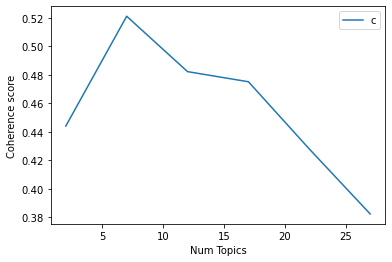

In [108]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [109]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.444
index: 1 | Num Topics = 7  has Coherence Value of 0.521
index: 2 | Num Topics = 12  has Coherence Value of 0.4822
index: 3 | Num Topics = 17  has Coherence Value of 0.4751
index: 4 | Num Topics = 22  has Coherence Value of 0.428
index: 5 | Num Topics = 27  has Coherence Value of 0.3825


In [180]:
# Select optimal number of topics
optimal_model_us_score1N2N3 = model_list_us_score1N2N3[1]

In [181]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_score1N2N3, corpus_us_score1N2N3, id2word_us_score1N2N3)

In [182]:
print("pyLDAVis for us topics for score=1,2,3:")
vis_us_score1N2N3

pyLDAVis for us topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.217066  0.069990       1        1  33.659810
6      0.128573 -0.216220       2        1  26.702830
5      0.173260 -0.017681       3        1  26.263770
2      0.141632  0.142206       4        1   9.702083
0     -0.217349  0.070215       5        1   1.754431
1     -0.226273 -0.028738       6        1   1.066595
4     -0.216909 -0.019772       7        1   0.850481, topic_info=             Term         Freq        Total Category  logprob  loglift
110       account  1117.000000  1117.000000  Default  30.0000  30.0000
1             app  1931.000000  1931.000000  Default  29.0000  29.0000
137        update   797.000000   797.000000  Default  28.0000  28.0000
293   marketplace   181.000000   181.000000  Default  27.0000  27.0000
58          video   492.000000   492.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2800          sex     2.650836    13.838050   Topic7  -5.9383   3.1146
210    personally     3.153552    31.265463   Topic7  -5.7646   2.4731
3468  accountable     2.684257    15.145770   Topic7  -5.9258   3.0368
2275         girl     2.420683    15.083272   Topic7  -6.0291   2.9376
1085        press     2.340363    26.126917   Topic7  -6.0629   2.3545

[460 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
280       1  0.316647        access
280       3  0.600396        access
280       4  0.082246        access
2337      1  0.967983  accidentally
110       3  0.999770       account
...     ...       ...           ...
3100      7  0.785914        worthy
327       1  0.204395          year
327       2  0.206305          year
327       3  0.538686          year
327       4  0.047756          year

[775 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 6, 3, 1, 2, 5])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [113]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_us_2018_score1N2N3 = facebook_ios_us_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_us_2018_score1N2N3 = list(sent_to_words(review_us_2018_score1N2N3))
print(review_words_us_2018_score1N2N3[:1])

[['facebook', 'used', 'to', 'be', 'so', 'great', 'remember', 'when', 'it', 'was', 'just', 'social', 'networking', 'site', 'then', 'it', 'became', 'media', 'consumption', 'site', 'which', 'was', 'ok', 'now', 'facebook', 'has', 'become', 'revenue', 'generating', 'machine', 'and', 'it', 'shows', 'placing', 'ads', 'that', 'cannot', 'be', 'skipped', 'during', 'the', 'climax', 'of', 'video', 'is', 'very', 'frustrating', 'and', 'stupid', 'the', 'new', 'slide', 'to', 'open', 'camera', 'look', 'this', 'isn', 'instagram', 'ok', 'it', 'facebook', 'don', 'take', 'picture', 'often', 'enough', 'to', 'want', 'to', 'swipe', 'my', 'finger', 'to', 'open', 'camera', 'app', 'of', 'the', 'times', 'that', 'have', 'opened', 'the', 'camera', 'feature', 'on', 'facebook', 'one', 'was', 'intentional', 'the', 'intent', 'was', 'to', 'find', 'way', 'to', 'disable', 'it', 'facebook', 'is', 'going', 'downhill', 'as', 'is', 'our', 'country', 'we', 'have', 'become', 'too', 'inclined', 'to', 'post', 'our', 'lives', 'on'

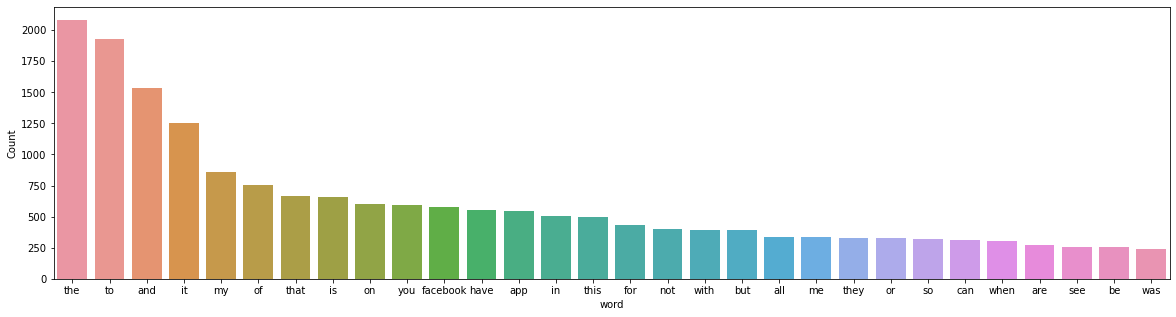

In [114]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2018_score1N2N3))

In [115]:
# Clean text
review_words_us_ready_2018_score1N2N3 = process_words(review_words_us_2018_score1N2N3)  # processed Text Data! - move to each section

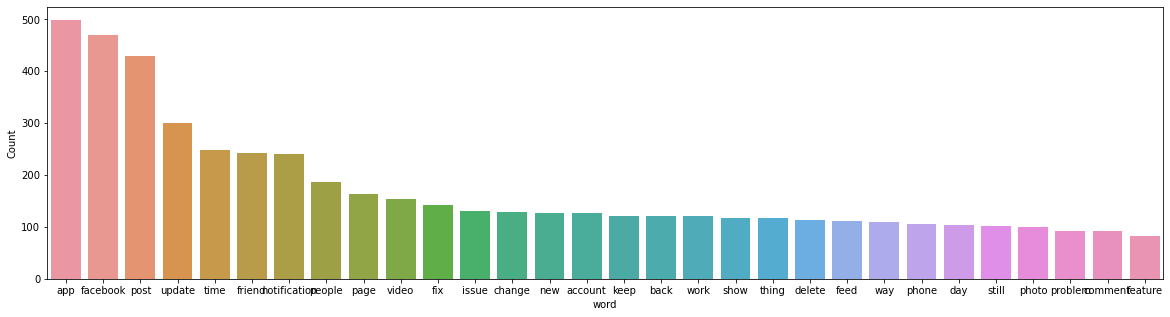

In [116]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2018_score1N2N3))


In [117]:
# Create Dictionary
id2word_us_2018_score1N2N3 = corpora.Dictionary(review_words_us_ready_2018_score1N2N3)

2021-10-16 20:05:46,846 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:05:46,955 [INFO] gensim.corpora.dictionary - built Dictionary(2654 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 348 documents (total 19717 corpus positions)
2021-10-16 20:05:46,956 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2654 unique tokens: ['ad', 'app', 'awful', 'bad', 'become']...) from 348 documents (total 19717 corpus positions)", 'datetime': '2021-10-16T20:05:46.956927', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [118]:
# Create Corpus: Term Document Frequency
corpus_us_2018_score1N2N3 = [id2word_us_2018_score1N2N3.doc2bow(text) for text in review_words_us_ready_2018_score1N2N3]

In [119]:
# Training LDA model
model_list_us_2018_score1N2N3, coherence_values_us_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2018_score1N2N3, corpus=corpus_us_2018_score1N2N3, 
                                                              texts=review_words_us_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:05:47,515 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:05:47,517 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:05:47,520 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:05:47,523 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 348 documents, updating model once every 348 documents, evaluating perplexity every 348 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:05:48,765 [INFO] gensim.models.ldamodel - -8.364 per-word bound, 329.4 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:05:48,766 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #348/348
2021-10-16 20:05:49,896 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"app" + 0.018*"facebook" + 0.015*"post" + 0.014*"time" + 0.012*"notification" + 0.010*"update" + 

2021-10-16 20:06:06,728 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #348/348
2021-10-16 20:06:07,473 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.018*"facebook" + 0.012*"post" + 0.012*"app" + 0.010*"time" + 0.009*"notification" + 0.008*"people" + 0.008*"keep" + 0.007*"account" + 0.007*"page" + 0.006*"friend"
2021-10-16 20:06:07,475 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"app" + 0.022*"facebook" + 0.022*"post" + 0.017*"update" + 0.013*"friend" + 0.012*"notification" + 0.012*"time" + 0.009*"video" + 0.009*"people" + 0.008*"page"
2021-10-16 20:06:07,476 [INFO] gensim.models.ldamodel - topic diff=0.021396, rho=0.301511
2021-10-16 20:06:08,549 [INFO] gensim.models.ldamodel - -6.806 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:06:08,556 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #348/348
2021-10-16 20:06:09,280 [INFO] gensim.models.ldamodel - topic #0 (0.500):

2021-10-16 20:06:24,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #348/348
2021-10-16 20:06:24,729 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"facebook" + 0.011*"post" + 0.009*"account" + 0.009*"time" + 0.008*"app" + 0.007*"people" + 0.007*"keep" + 0.007*"password" + 0.007*"friend" + 0.006*"message"
2021-10-16 20:06:24,731 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"app" + 0.022*"post" + 0.022*"facebook" + 0.018*"update" + 0.013*"notification" + 0.012*"friend" + 0.012*"time" + 0.009*"video" + 0.009*"people" + 0.008*"page"
2021-10-16 20:06:24,732 [INFO] gensim.models.ldamodel - topic diff=0.011405, rho=0.218218
2021-10-16 20:06:25,686 [INFO] gensim.models.ldamodel - -6.797 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:06:25,688 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #348/348
2021-10-16 20:06:26,360 [INFO] gensim.models.ldamodel - topic #0 (0.500):

2021-10-16 20:06:40,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #348/348
2021-10-16 20:06:41,068 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"facebook" + 0.012*"account" + 0.010*"post" + 0.008*"time" + 0.008*"people" + 0.007*"password" + 0.007*"friend" + 0.007*"keep" + 0.006*"message" + 0.006*"change"
2021-10-16 20:06:41,076 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"app" + 0.022*"post" + 0.022*"facebook" + 0.018*"update" + 0.014*"notification" + 0.012*"time" + 0.012*"friend" + 0.009*"video" + 0.009*"people" + 0.008*"page"
2021-10-16 20:06:41,077 [INFO] gensim.models.ldamodel - topic diff=0.008865, rho=0.179605
2021-10-16 20:06:41,967 [INFO] gensim.models.ldamodel - -6.788 per-word bound, 110.5 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:06:41,968 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #348/348
2021-10-16 20:06:42,626 [INFO] gensim.models.ldamodel - topic #0 (0.50

2021-10-16 20:06:55,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #348/348
2021-10-16 20:06:56,324 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"facebook" + 0.015*"account" + 0.010*"post" + 0.008*"people" + 0.008*"friend" + 0.007*"password" + 0.007*"time" + 0.007*"keep" + 0.006*"change" + 0.006*"message"
2021-10-16 20:06:56,327 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"app" + 0.022*"post" + 0.021*"facebook" + 0.018*"update" + 0.014*"notification" + 0.012*"time" + 0.012*"friend" + 0.009*"video" + 0.008*"people" + 0.008*"page"
2021-10-16 20:06:56,328 [INFO] gensim.models.ldamodel - topic diff=0.006690, rho=0.156174
2021-10-16 20:06:57,104 [INFO] gensim.models.ldamodel - -6.784 per-word bound, 110.2 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:06:57,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #348/348
2021-10-16 20:06:57,720 [INFO] gensim.models.ldamodel - topic #0 (0.50

2021-10-16 20:07:10,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #348/348
2021-10-16 20:07:11,223 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.020*"facebook" + 0.016*"account" + 0.010*"post" + 0.009*"people" + 0.008*"friend" + 0.007*"password" + 0.007*"time" + 0.006*"change" + 0.006*"keep" + 0.006*"message"
2021-10-16 20:07:11,225 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"app" + 0.023*"post" + 0.021*"facebook" + 0.018*"update" + 0.014*"notification" + 0.013*"time" + 0.012*"friend" + 0.009*"video" + 0.008*"page" + 0.008*"fix"
2021-10-16 20:07:11,225 [INFO] gensim.models.ldamodel - topic diff=0.005171, rho=0.140028
2021-10-16 20:07:11,227 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2654, num_topics=2, decay=0.5, chunksize=1000) in 83.70s', 'datetime': '2021-10-16T20:07:11.227001', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-6

2021-10-16 20:07:25,707 [INFO] gensim.models.ldamodel - -6.986 per-word bound, 126.8 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:07:25,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #348/348
2021-10-16 20:07:26,331 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.032*"app" + 0.025*"post" + 0.020*"update" + 0.012*"notification" + 0.012*"issue" + 0.012*"facebook" + 0.011*"time" + 0.011*"comment" + 0.008*"photo" + 0.008*"fix"
2021-10-16 20:07:26,332 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.025*"post" + 0.010*"profile" + 0.008*"birthday" + 0.008*"time" + 0.008*"guy" + 0.008*"block" + 0.008*"friend" + 0.007*"people" + 0.007*"message" + 0.007*"day"
2021-10-16 20:07:26,334 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.024*"video" + 0.022*"app" + 0.019*"facebook" + 0.019*"update" + 0.017*"post" + 0.010*"page" + 0.010*"watch" + 0.008*"people" + 0.008*"old" + 0.008*"account"
2021-10-16 20:07:26,335 [INFO] g

2021-10-16 20:07:33,731 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.032*"app" + 0.014*"time" + 0.014*"post" + 0.014*"update" + 0.011*"people" + 0.010*"friend" + 0.009*"fix" + 0.008*"problem" + 0.007*"phone"
2021-10-16 20:07:33,733 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"video" + 0.022*"app" + 0.020*"update" + 0.020*"facebook" + 0.016*"post" + 0.012*"watch" + 0.010*"page" + 0.008*"people" + 0.008*"old" + 0.007*"photo"
2021-10-16 20:07:33,736 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.020*"time" + 0.008*"comment" + 0.008*"find" + 0.008*"app" + 0.007*"facebook" + 0.007*"read" + 0.007*"post" + 0.007*"delete" + 0.006*"last" + 0.006*"person"
2021-10-16 20:07:33,737 [INFO] gensim.models.ldamodel - topic diff=0.035256, rho=0.301511
2021-10-16 20:07:34,576 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:07:34,578 [INFO] gensim.models.ld

2021-10-16 20:07:41,096 [INFO] gensim.models.ldamodel - topic diff=0.014793, rho=0.250000
2021-10-16 20:07:41,975 [INFO] gensim.models.ldamodel - -6.946 per-word bound, 123.3 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:07:41,977 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #348/348
2021-10-16 20:07:42,508 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"post" + 0.010*"profile" + 0.009*"block" + 0.009*"birthday" + 0.009*"guy" + 0.008*"time" + 0.007*"delete" + 0.007*"people" + 0.007*"day" + 0.007*"message"
2021-10-16 20:07:42,510 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.031*"video" + 0.022*"app" + 0.020*"update" + 0.020*"facebook" + 0.016*"post" + 0.013*"watch" + 0.010*"page" + 0.008*"people" + 0.008*"old" + 0.008*"photo"
2021-10-16 20:07:42,511 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"notification" + 0.028*"post" + 0.027*"friend" + 0.016*"facebook" + 0.015*"page" + 0.012*"show" + 0.01

2021-10-16 20:07:49,710 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"notification" + 0.028*"post" + 0.027*"friend" + 0.016*"facebook" + 0.015*"page" + 0.012*"show" + 0.012*"time" + 0.012*"feed" + 0.011*"update" + 0.010*"app"
2021-10-16 20:07:49,712 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.035*"app" + 0.029*"post" + 0.019*"update" + 0.013*"comment" + 0.013*"issue" + 0.012*"notification" + 0.012*"time" + 0.012*"facebook" + 0.009*"photo" + 0.009*"fix"
2021-10-16 20:07:49,713 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"post" + 0.011*"profile" + 0.009*"block" + 0.009*"birthday" + 0.009*"guy" + 0.008*"time" + 0.007*"delete" + 0.007*"people" + 0.007*"day" + 0.007*"message"
2021-10-16 20:07:49,716 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.031*"app" + 0.014*"time" + 0.014*"update" + 0.013*"post" + 0.012*"people" + 0.009*"friend" + 0.009*"fix" + 0.008*"problem" + 0.007*"phone"
2021-10-16 20:07:49,718 [INFO] gensim.models.ldamodel -

2021-10-16 20:07:56,953 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"app" + 0.029*"post" + 0.019*"update" + 0.014*"comment" + 0.013*"issue" + 0.012*"time" + 0.012*"notification" + 0.012*"facebook" + 0.009*"photo" + 0.009*"fix"
2021-10-16 20:07:56,954 [INFO] gensim.models.ldamodel - topic diff=0.005583, rho=0.192450
2021-10-16 20:07:57,846 [INFO] gensim.models.ldamodel - -6.940 per-word bound, 122.8 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:07:57,847 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #348/348
2021-10-16 20:07:58,338 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"notification" + 0.028*"post" + 0.027*"friend" + 0.016*"facebook" + 0.014*"page" + 0.012*"show" + 0.012*"time" + 0.012*"feed" + 0.011*"update" + 0.010*"app"
2021-10-16 20:07:58,341 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"post" + 0.011*"profile" + 0.009*"block" + 0.009*"birthday" + 0.009*"guy" + 0.008*"delete" +

2021-10-16 20:08:05,631 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"facebook" + 0.031*"app" + 0.014*"time" + 0.014*"update" + 0.013*"post" + 0.012*"people" + 0.009*"friend" + 0.009*"fix" + 0.008*"problem" + 0.008*"phone"
2021-10-16 20:08:05,634 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"post" + 0.011*"profile" + 0.009*"block" + 0.009*"birthday" + 0.009*"guy" + 0.008*"delete" + 0.007*"day" + 0.007*"time" + 0.007*"people" + 0.007*"place"
2021-10-16 20:08:05,636 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"app" + 0.030*"post" + 0.019*"update" + 0.014*"comment" + 0.013*"issue" + 0.012*"time" + 0.012*"notification" + 0.012*"facebook" + 0.009*"photo" + 0.009*"fix"
2021-10-16 20:08:05,638 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.023*"password" + 0.018*"account" + 0.016*"facebook" + 0.016*"email" + 0.014*"change" + 0.013*"marketplace" + 0.012*"item" + 0.010*"access" + 0.009*"people" + 0.008*"list"
2021-10-16 20:08:05,641 [INFO] gensim.models.ld

2021-10-16 20:08:13,021 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.024*"password" + 0.019*"account" + 0.016*"email" + 0.016*"facebook" + 0.014*"change" + 0.013*"marketplace" + 0.012*"item" + 0.010*"access" + 0.009*"people" + 0.008*"list"
2021-10-16 20:08:13,024 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.018*"time" + 0.008*"facebook" + 0.007*"find" + 0.007*"comment" + 0.007*"person" + 0.006*"voiceover" + 0.006*"delete" + 0.006*"set" + 0.005*"actually" + 0.005*"life"
2021-10-16 20:08:13,029 [INFO] gensim.models.ldamodel - topic diff=0.003414, rho=0.162221
2021-10-16 20:08:13,760 [INFO] gensim.models.ldamodel - -6.937 per-word bound, 122.5 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:08:13,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #348/348
2021-10-16 20:08:14,356 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"notification" + 0.029*"post" + 0.027*"friend" + 0.016*"facebook" + 0.014*"page"

2021-10-16 20:08:21,130 [INFO] gensim.models.ldamodel - -6.935 per-word bound, 122.4 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:08:21,134 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #348/348
2021-10-16 20:08:21,738 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"facebook" + 0.031*"app" + 0.014*"update" + 0.014*"time" + 0.012*"post" + 0.012*"people" + 0.009*"friend" + 0.009*"fix" + 0.008*"problem" + 0.008*"phone"
2021-10-16 20:08:21,739 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"notification" + 0.029*"post" + 0.027*"friend" + 0.016*"facebook" + 0.014*"page" + 0.013*"show" + 0.012*"time" + 0.012*"feed" + 0.011*"update" + 0.010*"app"
2021-10-16 20:08:21,741 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"video" + 0.023*"app" + 0.020*"update" + 0.019*"facebook" + 0.015*"watch" + 0.014*"post" + 0.009*"page" + 0.009*"people" + 0.008*"old" + 0.008*"ad"
2021-10-16 20:08:21,742 [INFO] gensim.m

2021-10-16 20:08:28,634 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"app" + 0.031*"post" + 0.019*"update" + 0.014*"comment" + 0.013*"issue" + 0.012*"time" + 0.011*"notification" + 0.011*"facebook" + 0.010*"photo" + 0.009*"fix"
2021-10-16 20:08:28,636 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.034*"video" + 0.023*"app" + 0.021*"update" + 0.019*"facebook" + 0.015*"watch" + 0.013*"post" + 0.009*"page" + 0.009*"people" + 0.008*"old" + 0.008*"ad"
2021-10-16 20:08:28,637 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"notification" + 0.030*"post" + 0.027*"friend" + 0.016*"facebook" + 0.014*"page" + 0.013*"show" + 0.012*"feed" + 0.012*"time" + 0.011*"update" + 0.010*"app"
2021-10-16 20:08:28,639 [INFO] gensim.models.ldamodel - topic diff=0.002625, rho=0.142857
2021-10-16 20:08:29,478 [INFO] gensim.models.ldamodel - -6.934 per-word bound, 122.3 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:08:29,479 [INFO] gensim.mo

2021-10-16 20:08:41,426 [INFO] gensim.models.ldamodel - topic diff=0.543550, rho=0.577350
2021-10-16 20:08:42,341 [INFO] gensim.models.ldamodel - -7.225 per-word bound, 149.6 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:08:42,343 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #348/348
2021-10-16 20:08:42,910 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.031*"post" + 0.017*"profile" + 0.013*"birthday" + 0.012*"guy" + 0.011*"message" + 0.008*"place" + 0.008*"delete" + 0.008*"click" + 0.008*"block" + 0.008*"day"
2021-10-16 20:08:42,913 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.020*"facebook" + 0.019*"post" + 0.016*"friend" + 0.016*"video" + 0.015*"app" + 0.009*"update" + 0.008*"ad" + 0.008*"people" + 0.007*"keep" + 0.007*"way"
2021-10-16 20:08:42,916 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.013*"bully" + 0.012*"update" + 0.010*"video" + 0.009*"find" + 0.009*"mom" + 0.008*"app" + 0.008*"new" + 0.00

2021-10-16 20:08:49,800 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.016*"app" + 0.016*"access" + 0.012*"people" + 0.012*"group" + 0.010*"photo" + 0.010*"time" + 0.010*"marketplace" + 0.009*"change" + 0.008*"facebook" + 0.008*"check"
2021-10-16 20:08:49,803 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.015*"bully" + 0.014*"update" + 0.010*"mom" + 0.009*"location" + 0.009*"change" + 0.009*"find" + 0.009*"new" + 0.007*"different" + 0.006*"friend" + 0.006*"mean"
2021-10-16 20:08:49,810 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"facebook" + 0.016*"account" + 0.014*"app" + 0.013*"email" + 0.013*"post" + 0.012*"item" + 0.012*"messenger" + 0.011*"people" + 0.011*"show" + 0.010*"access"
2021-10-16 20:08:49,813 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.038*"app" + 0.026*"post" + 0.022*"update" + 0.013*"issue" + 0.012*"facebook" + 0.011*"time" + 0.010*"fix" + 0.010*"comment" + 0.010*"video" + 0.009*"photo"
2021-10-16 20:08:49,816 [INFO] gensim.models.ldamod

2021-10-16 20:08:56,660 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"facebook" + 0.034*"app" + 0.018*"update" + 0.018*"post" + 0.018*"time" + 0.010*"friend" + 0.010*"people" + 0.009*"fix" + 0.009*"phone" + 0.008*"problem"
2021-10-16 20:08:56,661 [INFO] gensim.models.ldamodel - topic diff=0.028833, rho=0.267261
2021-10-16 20:08:57,466 [INFO] gensim.models.ldamodel - -7.049 per-word bound, 132.4 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:08:57,467 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #348/348
2021-10-16 20:08:58,092 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.016*"app" + 0.016*"access" + 0.013*"people" + 0.011*"group" + 0.011*"photo" + 0.010*"marketplace" + 0.009*"facebook" + 0.009*"time" + 0.008*"always" + 0.008*"check"
2021-10-16 20:08:58,094 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.018*"profile" + 0.013*"birthday" + 0.013*"guy" + 0.011*"message" + 0.010*"delete"

2021-10-16 20:09:05,385 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.016*"app" + 0.016*"access" + 0.013*"people" + 0.011*"photo" + 0.011*"group" + 0.010*"marketplace" + 0.009*"facebook" + 0.008*"always" + 0.008*"time" + 0.008*"add"
2021-10-16 20:09:05,387 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.024*"video" + 0.021*"facebook" + 0.016*"friend" + 0.014*"post" + 0.012*"ad" + 0.012*"app" + 0.010*"watch" + 0.009*"turn" + 0.009*"update" + 0.009*"feature"
2021-10-16 20:09:05,390 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.016*"marketplace" + 0.015*"facebook" + 0.013*"post" + 0.012*"new" + 0.010*"time" + 0.010*"ad" + 0.010*"people" + 0.010*"change" + 0.010*"picture" + 0.009*"event"
2021-10-16 20:09:05,392 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"facebook" + 0.019*"account" + 0.016*"email" + 0.013*"item" + 0.013*"messenger" + 0.012*"post" + 0.012*"people" + 0.011*"access" + 0.010*"show" + 0.009*"password"
2021-10-16 20:09:05,394 [INFO] gensim.models.ld

2021-10-16 20:09:12,746 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.016*"access" + 0.016*"app" + 0.013*"people" + 0.011*"photo" + 0.010*"group" + 0.010*"marketplace" + 0.009*"facebook" + 0.008*"always" + 0.008*"add" + 0.007*"time"
2021-10-16 20:09:12,750 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.016*"marketplace" + 0.015*"facebook" + 0.013*"post" + 0.012*"new" + 0.010*"ad" + 0.010*"time" + 0.010*"people" + 0.010*"picture" + 0.010*"change" + 0.009*"event"
2021-10-16 20:09:12,753 [INFO] gensim.models.ldamodel - topic diff=0.006893, rho=0.200000
2021-10-16 20:09:13,594 [INFO] gensim.models.ldamodel - -7.036 per-word bound, 131.2 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:09:13,595 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #348/348
2021-10-16 20:09:14,221 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"facebook" + 0.019*"account" + 0.017*"email" + 0.013*"item" + 0.013*"messenger" + 0.012*"p

2021-10-16 20:09:20,339 [INFO] gensim.models.ldamodel - -7.033 per-word bound, 130.9 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:09:20,347 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #348/348
2021-10-16 20:09:20,862 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.016*"marketplace" + 0.015*"facebook" + 0.013*"post" + 0.012*"new" + 0.011*"ad" + 0.010*"people" + 0.010*"time" + 0.010*"picture" + 0.009*"change" + 0.009*"event"
2021-10-16 20:09:20,864 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.024*"app" + 0.023*"update" + 0.018*"post" + 0.018*"facebook" + 0.012*"people" + 0.011*"notification" + 0.010*"page" + 0.010*"old" + 0.010*"video" + 0.009*"fix"
2021-10-16 20:09:20,866 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"app" + 0.027*"post" + 0.021*"update" + 0.014*"issue" + 0.012*"time" + 0.011*"comment" + 0.011*"fix" + 0.011*"video" + 0.011*"facebook" + 0.010*"photo"
2021-10-16 20:09:20,868 [INFO] g

2021-10-16 20:09:27,582 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"facebook" + 0.020*"account" + 0.017*"email" + 0.013*"messenger" + 0.013*"item" + 0.012*"post" + 0.012*"people" + 0.011*"access" + 0.010*"show" + 0.009*"password"
2021-10-16 20:09:27,584 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.018*"profile" + 0.013*"birthday" + 0.013*"guy" + 0.011*"message" + 0.010*"delete" + 0.009*"block" + 0.008*"item" + 0.008*"place" + 0.008*"allow"
2021-10-16 20:09:27,585 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.024*"app" + 0.023*"update" + 0.018*"facebook" + 0.018*"post" + 0.012*"people" + 0.011*"notification" + 0.011*"page" + 0.010*"video" + 0.010*"old" + 0.009*"fix"
2021-10-16 20:09:27,587 [INFO] gensim.models.ldamodel - topic diff=0.003593, rho=0.166667
2021-10-16 20:09:28,362 [INFO] gensim.models.ldamodel - -7.029 per-word bound, 130.6 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:09:28,364 [INFO

2021-10-16 20:09:34,211 [INFO] gensim.models.ldamodel - topic diff=0.002923, rho=0.156174
2021-10-16 20:09:35,001 [INFO] gensim.models.ldamodel - -7.028 per-word bound, 130.5 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:09:35,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #348/348
2021-10-16 20:09:35,531 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.032*"post" + 0.018*"profile" + 0.013*"birthday" + 0.013*"guy" + 0.011*"message" + 0.010*"delete" + 0.009*"block" + 0.008*"item" + 0.008*"place" + 0.008*"allow"
2021-10-16 20:09:35,541 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.039*"app" + 0.028*"post" + 0.022*"update" + 0.014*"issue" + 0.012*"time" + 0.012*"comment" + 0.011*"fix" + 0.011*"video" + 0.010*"facebook" + 0.010*"photo"
2021-10-16 20:09:35,551 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"video" + 0.022*"facebook" + 0.015*"friend" + 0.014*"ad" + 0.013*"post" + 0.012*"watch" + 0.012*"app

2021-10-16 20:09:42,187 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.016*"app" + 0.016*"access" + 0.013*"people" + 0.011*"photo" + 0.010*"group" + 0.010*"marketplace" + 0.009*"suspicious" + 0.009*"facebook" + 0.008*"always" + 0.008*"add"
2021-10-16 20:09:42,191 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.038*"account" + 0.028*"facebook" + 0.027*"friend" + 0.023*"post" + 0.014*"feed" + 0.012*"people" + 0.012*"time" + 0.011*"page" + 0.009*"new" + 0.008*"keep"
2021-10-16 20:09:42,195 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.020*"account" + 0.020*"facebook" + 0.017*"email" + 0.013*"messenger" + 0.013*"item" + 0.012*"post" + 0.012*"people" + 0.011*"access" + 0.010*"show" + 0.010*"password"
2021-10-16 20:09:42,197 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.017*"marketplace" + 0.015*"facebook" + 0.012*"post" + 0.012*"new" + 0.011*"ad" + 0.010*"people" + 0.010*"time" + 0.010*"picture" + 0.009*"event" + 0.009*"change"
2021-10-16 20:09:42,200 [INFO] gensim.mod

2021-10-16 20:09:54,879 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 348 documents, updating model once every 348 documents, evaluating perplexity every 348 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:09:56,602 [INFO] gensim.models.ldamodel - -12.049 per-word bound, 4237.2 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:09:56,603 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #348/348
2021-10-16 20:09:58,000 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.024*"notification" + 0.018*"friend" + 0.014*"marketplace" + 0.014*"post" + 0.014*"facebook" + 0.013*"new" + 0.012*"app" + 0.012*"ad" + 0.009*"page" + 0.009*"show"
2021-10-16 20:09:58,002 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.020*"facebook" + 0.019*"app" + 0.018*"notification" + 0.015*"access" + 0.012*"messenger" + 0.012*"people" + 0.012*"delet

2021-10-16 20:10:08,327 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.042*"notification" + 0.026*"facebook" + 0.020*"friend" + 0.019*"post" + 0.012*"thing" + 0.010*"feed" + 0.010*"time" + 0.010*"page" + 0.010*"video" + 0.009*"back"
2021-10-16 20:10:08,394 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.021*"marketplace" + 0.019*"new" + 0.019*"ad" + 0.017*"friend" + 0.016*"facebook" + 0.014*"notification" + 0.013*"post" + 0.011*"app" + 0.011*"hack" + 0.010*"issue"
2021-10-16 20:10:08,412 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.031*"update" + 0.029*"app" + 0.019*"facebook" + 0.016*"video" + 0.014*"phone" + 0.013*"post" + 0.010*"old" + 0.009*"change" + 0.009*"people" + 0.009*"back"
2021-10-16 20:10:08,420 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.020*"photo" + 0.019*"app" + 0.016*"update" + 0.011*"story" + 0.011*"ad" + 0.010*"time" + 0.010*"work" + 0.010*"stop" + 0.009*"people" + 0.009*"profile"
2021-10-16 20:10:08,437 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:10:16,835 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.022*"marketplace" + 0.019*"new" + 0.019*"ad" + 0.017*"friend" + 0.016*"facebook" + 0.013*"notification" + 0.013*"post" + 0.011*"hack" + 0.010*"issue" + 0.010*"app"
2021-10-16 20:10:16,839 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"app" + 0.038*"facebook" + 0.016*"time" + 0.016*"post" + 0.015*"update" + 0.011*"fix" + 0.011*"people" + 0.009*"problem" + 0.009*"work" + 0.009*"friend"
2021-10-16 20:10:16,840 [INFO] gensim.models.ldamodel - topic diff=0.055388, rho=0.288675
2021-10-16 20:10:17,692 [INFO] gensim.models.ldamodel - -7.135 per-word bound, 140.6 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:10:17,693 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #348/348
2021-10-16 20:10:18,428 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.048*"app" + 0.026*"post" + 0.019*"update" + 0.018*"time" + 0.015*"facebook" + 0.011*"issue" + 0.01

2021-10-16 20:10:26,118 [INFO] gensim.models.ldamodel - -7.121 per-word bound, 139.2 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:10:26,122 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #348/348
2021-10-16 20:10:26,798 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"post" + 0.020*"facebook" + 0.014*"group" + 0.013*"people" + 0.012*"update" + 0.012*"time" + 0.011*"click" + 0.010*"page" + 0.010*"whole" + 0.009*"app"
2021-10-16 20:10:26,805 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.046*"post" + 0.021*"birthday" + 0.016*"message" + 0.016*"block" + 0.013*"day" + 0.013*"place" + 0.011*"allow" + 0.011*"friend" + 0.011*"profile" + 0.010*"standard"
2021-10-16 20:10:26,813 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.047*"notification" + 0.025*"facebook" + 0.020*"friend" + 0.019*"post" + 0.011*"thing" + 0.011*"update" + 0.010*"time" + 0.010*"feed" + 0.010*"back" + 0.010*"video"
2021-10-16 20:10:26,817 [

2021-10-16 20:10:35,165 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"update" + 0.029*"app" + 0.019*"facebook" + 0.017*"video" + 0.014*"phone" + 0.012*"post" + 0.011*"password" + 0.011*"change" + 0.010*"old" + 0.009*"guy"
2021-10-16 20:10:35,170 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.016*"people" + 0.015*"delete" + 0.011*"profile" + 0.010*"facebook" + 0.010*"app" + 0.010*"post" + 0.010*"friend" + 0.010*"family" + 0.010*"fb" + 0.008*"account"
2021-10-16 20:10:35,172 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.017*"facebook" + 0.016*"ad" + 0.015*"friend" + 0.014*"post" + 0.012*"keep" + 0.012*"video" + 0.012*"photo" + 0.010*"update" + 0.010*"people" + 0.009*"hate"
2021-10-16 20:10:35,174 [INFO] gensim.models.ldamodel - topic diff=0.009755, rho=0.208514
2021-10-16 20:10:36,249 [INFO] gensim.models.ldamodel - -7.112 per-word bound, 138.4 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:10:36,251 [INFO] gensim.mod

2021-10-16 20:10:43,042 [INFO] gensim.models.ldamodel - topic diff=0.006491, rho=0.188982
2021-10-16 20:10:43,965 [INFO] gensim.models.ldamodel - -7.108 per-word bound, 137.9 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:10:43,966 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #348/348
2021-10-16 20:10:44,642 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.041*"account" + 0.035*"facebook" + 0.024*"friend" + 0.015*"post" + 0.013*"video" + 0.010*"photo" + 0.010*"time" + 0.010*"people" + 0.010*"reason" + 0.009*"keep"
2021-10-16 20:10:44,646 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.038*"notification" + 0.037*"post" + 0.022*"app" + 0.022*"show" + 0.017*"page" + 0.016*"friend" + 0.016*"update" + 0.015*"comment" + 0.010*"change" + 0.009*"list"
2021-10-16 20:10:44,650 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"post" + 0.020*"facebook" + 0.014*"group" + 0.014*"people" + 0.012*"time" + 0.012*"update" 

2021-10-16 20:10:52,848 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.038*"post" + 0.020*"facebook" + 0.014*"group" + 0.014*"people" + 0.012*"time" + 0.012*"update" + 0.011*"click" + 0.011*"page" + 0.010*"whole" + 0.009*"friend"
2021-10-16 20:10:52,850 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"post" + 0.021*"birthday" + 0.016*"message" + 0.016*"block" + 0.013*"day" + 0.013*"place" + 0.011*"allow" + 0.011*"friend" + 0.010*"profile" + 0.010*"standard"
2021-10-16 20:10:52,853 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.016*"delete" + 0.015*"people" + 0.012*"profile" + 0.011*"facebook" + 0.010*"friend" + 0.010*"family" + 0.010*"fb" + 0.010*"post" + 0.009*"app" + 0.008*"account"
2021-10-16 20:10:52,855 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.039*"notification" + 0.037*"post" + 0.023*"app" + 0.022*"show" + 0.017*"page" + 0.016*"update" + 0.016*"friend" + 0.015*"comment" + 0.010*"change" + 0.009*"list"
2021-10-16 20:10:52,856 [INFO] gensim.models.ld

2021-10-16 20:11:00,971 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"notification" + 0.038*"post" + 0.023*"app" + 0.022*"show" + 0.017*"page" + 0.016*"update" + 0.016*"friend" + 0.015*"comment" + 0.009*"change" + 0.009*"story"
2021-10-16 20:11:00,973 [INFO] gensim.models.ldamodel - topic diff=0.003596, rho=0.160128
2021-10-16 20:11:01,862 [INFO] gensim.models.ldamodel - -7.101 per-word bound, 137.3 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:11:01,863 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #348/348
2021-10-16 20:11:02,464 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.018*"event" + 0.014*"list" + 0.013*"picture" + 0.012*"facebook" + 0.012*"account" + 0.012*"change" + 0.010*"scroll" + 0.010*"app" + 0.010*"thing" + 0.009*"name"
2021-10-16 20:11:02,466 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.021*"facebook" + 0.020*"messenger" + 0.019*"access" + 0.017*"account" + 0.016*"email" + 0.014*"

2021-10-16 20:11:10,113 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #348/348
2021-10-16 20:11:10,817 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"app" + 0.036*"facebook" + 0.017*"time" + 0.017*"update" + 0.016*"post" + 0.011*"fix" + 0.011*"people" + 0.009*"problem" + 0.009*"work" + 0.009*"phone"
2021-10-16 20:11:10,837 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.024*"time" + 0.017*"app" + 0.014*"facebook" + 0.012*"look" + 0.008*"post" + 0.008*"phone" + 0.008*"friend" + 0.008*"add" + 0.008*"recent" + 0.008*"life"
2021-10-16 20:11:10,839 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"notification" + 0.038*"post" + 0.023*"app" + 0.022*"show" + 0.017*"page" + 0.017*"update" + 0.016*"friend" + 0.015*"comment" + 0.009*"change" + 0.009*"story"
2021-10-16 20:11:10,841 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.032*"update" + 0.030*"app" + 0.019*"facebook" + 0.018*"video" + 0.013*"phone" + 0.012*"password" + 0.012*"post" + 0.012*"change

2021-10-16 20:11:19,004 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.018*"event" + 0.014*"list" + 0.012*"facebook" + 0.012*"account" + 0.012*"picture" + 0.012*"change" + 0.010*"scroll" + 0.010*"app" + 0.010*"thing" + 0.009*"name"
2021-10-16 20:11:19,005 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.038*"app" + 0.036*"facebook" + 0.017*"update" + 0.017*"time" + 0.016*"post" + 0.011*"fix" + 0.011*"people" + 0.009*"problem" + 0.009*"phone" + 0.009*"work"
2021-10-16 20:11:19,007 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.024*"photo" + 0.020*"app" + 0.013*"update" + 0.012*"ad" + 0.010*"people" + 0.010*"work" + 0.009*"time" + 0.009*"access" + 0.008*"profile" + 0.008*"upload"
2021-10-16 20:11:19,008 [INFO] gensim.models.ldamodel - topic diff=0.002316, rho=0.141421
2021-10-16 20:11:19,982 [INFO] gensim.models.ldamodel - -7.097 per-word bound, 136.9 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:11:19,983 [INFO] gensim.model

2021-10-16 20:11:36,765 [INFO] gensim.models.ldamodel - topic diff=0.494310, rho=0.500000
2021-10-16 20:11:37,724 [INFO] gensim.models.ldamodel - -7.381 per-word bound, 166.7 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:11:37,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #348/348
2021-10-16 20:11:38,270 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.036*"app" + 0.035*"update" + 0.013*"phone" + 0.013*"post" + 0.013*"video" + 0.012*"review" + 0.012*"facebook" + 0.011*"people" + 0.010*"notification" + 0.010*"delete"
2021-10-16 20:11:38,273 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.033*"post" + 0.017*"facebook" + 0.016*"people" + 0.016*"app" + 0.015*"show" + 0.013*"time" + 0.011*"keep" + 0.011*"friend" + 0.009*"page" + 0.009*"fb"
2021-10-16 20:11:38,278 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.022*"app" + 0.021*"video" + 0.020*"feature" + 0.018*"watch" + 0.016*"facebook" + 0.014*"happen" + 0.0

2021-10-16 20:11:45,152 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.032*"post" + 0.015*"people" + 0.015*"show" + 0.015*"facebook" + 0.014*"app" + 0.014*"time" + 0.012*"keep" + 0.012*"friend" + 0.010*"fb" + 0.010*"page"
2021-10-16 20:11:45,156 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.033*"facebook" + 0.030*"account" + 0.023*"friend" + 0.019*"post" + 0.013*"group" + 0.013*"people" + 0.012*"feed" + 0.010*"page" + 0.010*"list" + 0.009*"never"
2021-10-16 20:11:45,167 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.023*"video" + 0.021*"app" + 0.021*"feature" + 0.018*"facebook" + 0.018*"watch" + 0.014*"happen" + 0.011*"start" + 0.011*"information" + 0.010*"loss" + 0.008*"privacy"
2021-10-16 20:11:45,174 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.053*"notification" + 0.021*"log" + 0.020*"new" + 0.015*"list" + 0.015*"friend" + 0.014*"account" + 0.012*"marketplace" + 0.011*"click" + 0.011*"message" + 0.011*"screen"
2021-10-16 20:11:45,180 [INFO] gensim.models.l

2021-10-16 20:11:52,457 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.050*"app" + 0.019*"facebook" + 0.019*"post" + 0.017*"time" + 0.013*"update" + 0.013*"account" + 0.012*"day" + 0.012*"photo" + 0.011*"people" + 0.010*"load"
2021-10-16 20:11:52,462 [INFO] gensim.models.ldamodel - topic diff=0.035132, rho=0.258199
2021-10-16 20:11:53,261 [INFO] gensim.models.ldamodel - -7.185 per-word bound, 145.5 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:11:53,264 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #348/348
2021-10-16 20:11:53,740 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.042*"post" + 0.031*"friend" + 0.024*"update" + 0.024*"app" + 0.017*"facebook" + 0.016*"feed" + 0.015*"show" + 0.014*"ad" + 0.014*"notification" + 0.012*"fix"
2021-10-16 20:11:53,742 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.031*"post" + 0.015*"people" + 0.015*"show" + 0.015*"facebook" + 0.014*"time" + 0.014*"app" + 0.012*"keep

2021-10-16 20:12:01,108 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.024*"facebook" + 0.020*"time" + 0.017*"ad" + 0.010*"add" + 0.010*"life" + 0.010*"phone" + 0.009*"look" + 0.008*"host" + 0.008*"co" + 0.008*"real"
2021-10-16 20:12:01,110 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.053*"notification" + 0.021*"facebook" + 0.021*"post" + 0.019*"page" + 0.017*"friend" + 0.016*"time" + 0.009*"show" + 0.009*"thing" + 0.008*"send" + 0.008*"group"
2021-10-16 20:12:01,111 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.025*"update" + 0.025*"issue" + 0.019*"notification" + 0.014*"fix" + 0.014*"page" + 0.013*"post" + 0.012*"people" + 0.011*"app" + 0.010*"work" + 0.010*"completely"
2021-10-16 20:12:01,113 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.040*"update" + 0.039*"app" + 0.014*"review" + 0.013*"phone" + 0.012*"post" + 0.012*"facebook" + 0.012*"people" + 0.011*"guy" + 0.011*"delete" + 0.011*"old"
2021-10-16 20:12:01,115 [INFO] gensim.models.ldamodel - topic #0 (0.

2021-10-16 20:12:08,311 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.016*"way" + 0.015*"facebook" + 0.015*"app" + 0.014*"event" + 0.012*"list" + 0.011*"marketplace" + 0.011*"thing" + 0.010*"friend" + 0.009*"day" + 0.009*"add"
2021-10-16 20:12:08,314 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.054*"notification" + 0.021*"facebook" + 0.021*"post" + 0.019*"page" + 0.017*"friend" + 0.017*"time" + 0.009*"show" + 0.009*"thing" + 0.008*"group" + 0.008*"send"
2021-10-16 20:12:08,316 [INFO] gensim.models.ldamodel - topic diff=0.006933, rho=0.196116
2021-10-16 20:12:09,254 [INFO] gensim.models.ldamodel - -7.171 per-word bound, 144.1 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:12:09,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #348/348
2021-10-16 20:12:09,779 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.041*"update" + 0.039*"app" + 0.014*"review" + 0.013*"phone" + 0.012*"facebook" + 0.012*"post" + 0.012

2021-10-16 20:12:16,613 [INFO] gensim.models.ldamodel - -7.167 per-word bound, 143.7 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:12:16,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #348/348
2021-10-16 20:12:17,110 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.017*"way" + 0.015*"facebook" + 0.015*"app" + 0.014*"event" + 0.013*"list" + 0.011*"marketplace" + 0.011*"thing" + 0.010*"friend" + 0.009*"day" + 0.009*"edit"
2021-10-16 20:12:17,113 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.035*"facebook" + 0.031*"account" + 0.025*"friend" + 0.019*"post" + 0.014*"group" + 0.013*"people" + 0.011*"feed" + 0.010*"page" + 0.010*"list" + 0.009*"never"
2021-10-16 20:12:17,116 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.017*"update" + 0.014*"time" + 0.010*"post" + 0.010*"button" + 0.010*"issue" + 0.010*"tag" + 0.010*"thing" + 0.010*"story" + 0.009*"people" + 0.009*"great"
2021-10-16 20:12:17,120 [INFO] gensim

2021-10-16 20:12:24,354 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.041*"update" + 0.040*"app" + 0.014*"review" + 0.013*"phone" + 0.012*"facebook" + 0.012*"post" + 0.012*"people" + 0.011*"guy" + 0.011*"delete" + 0.011*"notification"
2021-10-16 20:12:24,357 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.062*"password" + 0.056*"email" + 0.043*"account" + 0.024*"access" + 0.024*"change" + 0.019*"facebook" + 0.015*"back" + 0.013*"post" + 0.013*"delete" + 0.012*"phone"
2021-10-16 20:12:24,359 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.044*"facebook" + 0.040*"app" + 0.019*"time" + 0.014*"update" + 0.012*"phone" + 0.011*"post" + 0.011*"problem" + 0.011*"fix" + 0.010*"people" + 0.009*"work"
2021-10-16 20:12:24,360 [INFO] gensim.models.ldamodel - topic diff=0.003513, rho=0.164399
2021-10-16 20:12:25,347 [INFO] gensim.models.ldamodel - -7.163 per-word bound, 143.3 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:12:25,348 [INFO]

2021-10-16 20:12:31,747 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.051*"app" + 0.019*"facebook" + 0.018*"post" + 0.017*"time" + 0.015*"photo" + 0.012*"update" + 0.012*"account" + 0.012*"day" + 0.011*"load" + 0.011*"people"
2021-10-16 20:12:31,748 [INFO] gensim.models.ldamodel - topic diff=0.002859, rho=0.154303
2021-10-16 20:12:32,525 [INFO] gensim.models.ldamodel - -7.160 per-word bound, 143.0 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:12:32,527 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #348/348
2021-10-16 20:12:33,099 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.025*"app" + 0.019*"facebook" + 0.014*"post" + 0.013*"time" + 0.012*"issue" + 0.010*"update" + 0.010*"people" + 0.009*"keep" + 0.009*"fix" + 0.007*"help"
2021-10-16 20:12:33,101 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.035*"facebook" + 0.032*"account" + 0.025*"friend" + 0.018*"post" + 0.014*"group" + 0.013*"people" + 0.011*"fee

2021-10-16 20:12:40,523 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.023*"feature" + 0.020*"facebook" + 0.017*"app" + 0.013*"video" + 0.012*"information" + 0.012*"loss" + 0.010*"start" + 0.009*"watch" + 0.009*"privacy" + 0.009*"completely"
2021-10-16 20:12:40,526 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.113*"video" + 0.043*"watch" + 0.025*"facebook" + 0.018*"comment" + 0.017*"update" + 0.015*"play" + 0.014*"issue" + 0.014*"click" + 0.013*"app" + 0.013*"scroll"
2021-10-16 20:12:40,530 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.045*"facebook" + 0.040*"app" + 0.019*"time" + 0.014*"update" + 0.012*"phone" + 0.011*"post" + 0.011*"problem" + 0.011*"fix" + 0.010*"people" + 0.009*"work"
2021-10-16 20:12:40,532 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.057*"notification" + 0.022*"new" + 0.021*"log" + 0.018*"message" + 0.015*"list" + 0.015*"friend" + 0.013*"click" + 0.013*"account" + 0.012*"marketplace" + 0.011*"back"
2021-10-16 20:12:40,536 [INFO] gensim.

2021-10-16 20:12:58,025 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.030*"post" + 0.017*"update" + 0.016*"facebook" + 0.013*"group" + 0.013*"people" + 0.010*"friend" + 0.010*"app" + 0.009*"page" + 0.009*"really" + 0.008*"fix"
2021-10-16 20:12:58,031 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.024*"app" + 0.020*"post" + 0.018*"people" + 0.018*"update" + 0.015*"page" + 0.015*"friend" + 0.013*"notification" + 0.011*"thing" + 0.010*"facebook" + 0.010*"work"
2021-10-16 20:12:58,033 [INFO] gensim.models.ldamodel - topic diff=19.713161, rho=1.000000
2021-10-16 20:12:59,078 [INFO] gensim.models.ldamodel - -7.907 per-word bound, 240.0 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:12:59,080 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #348/348
2021-10-16 20:12:59,764 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.021*"app" + 0.019*"facebook" + 0.017*"time" + 0.016*"friend" + 0.015*"post" + 0.013*"issue" + 0.

2021-10-16 20:13:06,744 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #348/348
2021-10-16 20:13:07,339 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"notification" + 0.033*"request" + 0.030*"friend" + 0.019*"message" + 0.016*"new" + 0.014*"work" + 0.013*"log" + 0.012*"wrong" + 0.012*"issue" + 0.011*"receive"
2021-10-16 20:13:07,346 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.033*"post" + 0.016*"page" + 0.015*"time" + 0.014*"app" + 0.013*"facebook" + 0.012*"item" + 0.011*"look" + 0.011*"show" + 0.010*"story" + 0.010*"well"
2021-10-16 20:13:07,347 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.117*"notification" + 0.023*"update" + 0.022*"post" + 0.020*"back" + 0.017*"list" + 0.016*"new" + 0.015*"disappear" + 0.015*"click" + 0.011*"scroll" + 0.011*"way"
2021-10-16 20:13:07,348 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.025*"update" + 0.017*"fix" + 0.014*"tag" + 0.011*"thing" + 0.011*"newsfeed" + 0.011*"name" + 0.011*"issue" + 0.011*"far"

2021-10-16 20:13:14,607 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.047*"photo" + 0.030*"profile" + 0.027*"upload" + 0.018*"app" + 0.016*"allow" + 0.016*"pic" + 0.016*"access" + 0.016*"cover" + 0.012*"issue" + 0.011*"work"
2021-10-16 20:13:14,608 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.056*"post" + 0.031*"birthday" + 0.030*"block" + 0.027*"message" + 0.017*"profile" + 0.016*"friend" + 0.015*"delete" + 0.015*"fix" + 0.015*"place" + 0.014*"day"
2021-10-16 20:13:14,612 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.025*"app" + 0.021*"facebook" + 0.021*"time" + 0.017*"post" + 0.016*"phone" + 0.011*"email" + 0.011*"life" + 0.011*"delete" + 0.010*"friend" + 0.009*"find"
2021-10-16 20:13:14,613 [INFO] gensim.models.ldamodel - topic diff=0.064254, rho=0.277350
2021-10-16 20:13:15,363 [INFO] gensim.models.ldamodel - -7.274 per-word bound, 154.7 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:13:15,365 [INFO] gensim.models.

2021-10-16 20:13:21,157 [INFO] gensim.models.ldamodel - topic diff=0.023835, rho=0.235702
2021-10-16 20:13:21,997 [INFO] gensim.models.ldamodel - -7.258 per-word bound, 153.1 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:13:21,999 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #348/348
2021-10-16 20:13:22,485 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.019*"facebook" + 0.019*"app" + 0.015*"time" + 0.015*"friend" + 0.013*"issue" + 0.010*"post" + 0.010*"work" + 0.010*"messenger" + 0.010*"fix" + 0.009*"people"
2021-10-16 20:13:22,487 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.027*"post" + 0.020*"facebook" + 0.019*"group" + 0.016*"people" + 0.015*"page" + 0.012*"friend" + 0.011*"update" + 0.010*"time" + 0.009*"video" + 0.009*"bully"
2021-10-16 20:13:22,488 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.118*"notification" + 0.036*"post" + 0.024*"update" + 0.021*"back" + 0.017*"show" + 0.017*"click" + 0

2021-10-16 20:13:29,587 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.050*"photo" + 0.031*"profile" + 0.029*"upload" + 0.017*"app" + 0.016*"allow" + 0.016*"pic" + 0.016*"access" + 0.016*"cover" + 0.011*"issue" + 0.011*"work"
2021-10-16 20:13:29,594 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.065*"account" + 0.036*"facebook" + 0.025*"friend" + 0.019*"post" + 0.013*"people" + 0.012*"photo" + 0.011*"feed" + 0.011*"keep" + 0.010*"access" + 0.009*"never"
2021-10-16 20:13:29,597 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.028*"facebook" + 0.027*"video" + 0.021*"post" + 0.016*"way" + 0.015*"photo" + 0.014*"friend" + 0.012*"ad" + 0.012*"update" + 0.011*"new" + 0.009*"app"
2021-10-16 20:13:29,599 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.055*"app" + 0.026*"time" + 0.022*"update" + 0.021*"post" + 0.017*"day" + 0.017*"issue" + 0.011*"photo" + 0.011*"facebook" + 0.010*"open" + 0.010*"work"
2021-10-16 20:13:29,600 [INFO] gensim.models.ldamodel - topic diff=0.010550,

2021-10-16 20:13:37,287 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.026*"post" + 0.020*"facebook" + 0.020*"group" + 0.016*"people" + 0.015*"page" + 0.012*"friend" + 0.010*"update" + 0.010*"time" + 0.009*"bully" + 0.008*"whole"
2021-10-16 20:13:37,290 [INFO] gensim.models.ldamodel - topic diff=0.006696, rho=0.185695
2021-10-16 20:13:38,063 [INFO] gensim.models.ldamodel - -7.243 per-word bound, 151.5 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:13:38,064 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #348/348
2021-10-16 20:13:38,549 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"notification" + 0.034*"request" + 0.032*"friend" + 0.019*"message" + 0.016*"new" + 0.014*"work" + 0.013*"log" + 0.012*"wrong" + 0.012*"issue" + 0.010*"screen"
2021-10-16 20:13:38,552 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.056*"app" + 0.027*"time" + 0.022*"update" + 0.021*"post" + 0.017*"day" + 0.017*"issue" + 0.012*

2021-10-16 20:13:45,527 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.025*"app" + 0.021*"facebook" + 0.021*"time" + 0.017*"post" + 0.016*"phone" + 0.011*"email" + 0.011*"life" + 0.011*"delete" + 0.010*"friend" + 0.009*"find"
2021-10-16 20:13:45,534 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.045*"notification" + 0.034*"request" + 0.032*"friend" + 0.019*"message" + 0.016*"new" + 0.014*"work" + 0.013*"log" + 0.012*"wrong" + 0.012*"issue" + 0.010*"screen"
2021-10-16 20:13:45,537 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.049*"photo" + 0.031*"profile" + 0.029*"upload" + 0.017*"app" + 0.016*"allow" + 0.016*"pic" + 0.016*"access" + 0.016*"cover" + 0.011*"issue" + 0.011*"work"
2021-10-16 20:13:45,539 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.040*"post" + 0.027*"show" + 0.022*"new" + 0.021*"marketplace" + 0.019*"facebook" + 0.015*"people" + 0.013*"back" + 0.013*"app" + 0.012*"friend" + 0.012*"time"
2021-10-16 20:13:45,541 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:13:52,861 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.024*"access" + 0.020*"account" + 0.019*"password" + 0.018*"people" + 0.016*"post" + 0.015*"email" + 0.014*"facebook" + 0.013*"messenger" + 0.012*"phone" + 0.011*"lose"
2021-10-16 20:13:52,864 [INFO] gensim.models.ldamodel - topic diff=0.003539, rho=0.158114
2021-10-16 20:13:53,763 [INFO] gensim.models.ldamodel - -7.236 per-word bound, 150.7 perplexity estimate based on a held-out corpus of 348 documents with 19717 words
2021-10-16 20:13:53,764 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #348/348
2021-10-16 20:13:54,364 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.038*"app" + 0.033*"notification" + 0.018*"time" + 0.015*"update" + 0.015*"facebook" + 0.014*"link" + 0.012*"fix" + 0.011*"page" + 0.011*"picture" + 0.009*"love"
2021-10-16 20:13:54,366 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.018*"facebook" + 0.017*"friend" + 0.017*"post" + 0.012*"share" + 0.012*"app" + 0.011*"time

2021-10-16 20:14:02,313 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.056*"app" + 0.027*"time" + 0.023*"update" + 0.022*"post" + 0.016*"day" + 0.016*"issue" + 0.013*"photo" + 0.011*"load" + 0.011*"facebook" + 0.010*"open"
2021-10-16 20:14:02,332 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.018*"facebook" + 0.017*"friend" + 0.017*"post" + 0.012*"share" + 0.012*"app" + 0.011*"time" + 0.010*"change" + 0.010*"thing" + 0.010*"notification" + 0.009*"account"
2021-10-16 20:14:02,335 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.037*"app" + 0.027*"update" + 0.018*"post" + 0.016*"old" + 0.014*"fix" + 0.013*"phone" + 0.012*"facebook" + 0.012*"issue" + 0.011*"people" + 0.011*"delete"
2021-10-16 20:14:02,339 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.025*"access" + 0.022*"password" + 0.021*"account" + 0.018*"people" + 0.018*"email" + 0.016*"post" + 0.014*"facebook" + 0.013*"messenger" + 0.012*"phone" + 0.011*"lose"
2021-10-16 20:14:02,343 [INFO] gensim.models.ldamodel -

2021-10-16 20:14:10,286 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.026*"post" + 0.020*"facebook" + 0.020*"group" + 0.016*"people" + 0.015*"page" + 0.012*"friend" + 0.010*"time" + 0.009*"bully" + 0.009*"update" + 0.008*"year"
2021-10-16 20:14:10,288 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.030*"update" + 0.023*"app" + 0.017*"facebook" + 0.015*"keep" + 0.013*"last" + 0.011*"story" + 0.011*"show" + 0.010*"time" + 0.009*"service" + 0.009*"morning"
2021-10-16 20:14:10,290 [INFO] gensim.models.ldamodel - topic diff=0.002319, rho=0.140028
2021-10-16 20:14:10,292 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2654, num_topics=27, decay=0.5, chunksize=1000) in 75.78s', 'datetime': '2021-10-16T20:14:10.292348', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:14:10,303 [INFO] gensim.topic_coherence.probability_estimation 

In [120]:
%store model_list_us_2018_score1N2N3
%store coherence_values_us_2018_score1N2N3

Stored 'model_list_us_2018_score1N2N3' (list)
Stored 'coherence_values_us_2018_score1N2N3' (list)


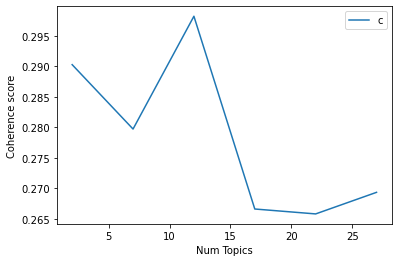

In [121]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [122]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.2903
index: 1 | Num Topics = 7  has Coherence Value of 0.2797
index: 2 | Num Topics = 12  has Coherence Value of 0.2982
index: 3 | Num Topics = 17  has Coherence Value of 0.2666
index: 4 | Num Topics = 22  has Coherence Value of 0.2658
index: 5 | Num Topics = 27  has Coherence Value of 0.2694


In [183]:
# Select optimal number of topics
optimal_model_us_2018_score1N2N3 = model_list_us_2018_score1N2N3[0]

In [184]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2018_score1N2N3, corpus_us_2018_score1N2N3, id2word_us_2018_score1N2N3)

In [185]:
print("pyLDAVis for us topics for score=1,2,3 in 2018:")
vis_us_2018_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.080308  0.0       1        1  77.146542
0     -0.080308  0.0       2        1  22.853458, topic_info=         Term        Freq       Total Category  logprob  loglift
110   account  104.000000  104.000000  Default  30.0000  30.0000
16   facebook  415.000000  415.000000  Default  29.0000  29.0000
137    update  275.000000  275.000000  Default  28.0000  28.0000
162  password   34.000000   34.000000  Default  27.0000  27.0000
154     email   25.000000   25.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
153    delete   17.934081  102.179490   Topic2  -5.5265  -0.2640
141     allow   14.854507   45.168705   Topic2  -5.7149   0.3640
19       find   15.333233   73.380358   Topic2  -5.6831  -0.0896
314     issue   15.739668  118.026660   Topic2  -5.6570  -0.5387
1         app   16.488696  453.682004   Topic2  -5.6105  -1.8387

[165 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
280       1  0.611257   access
280       2  0.387129   access
110       1  0.296324  account
110       2  0.707355  account
171       1  0.178369   action
...     ...       ...      ...
437       1  0.985203     word
379       1  0.878554     work
379       2  0.118971     work
327       1  0.556286     year
327       2  0.441192     year

[206 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## By-rating of 2019 (Rating=1,2,3)

In [126]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_us_2019_score1N2N3 = facebook_ios_us_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_us_2019_score1N2N3 = list(sent_to_words(review_us_2019_score1N2N3))
print(review_words_us_2019_score1N2N3[:1])

[['the', 'only', 'resolution', 'options', 'for', 'watching', 'videos', 'on', 'an', 'ipad', 'pro', 'in', 'this', 'app', 'are', 'to', 'there', 'is', 'no', 'longer', 'or', 'option', 'the', 'same', 'videos', 'can', 'be', 'set', 'to', 'in', 'safari', 'also', 'the', 'bias', 'in', 'your', 'company', 'is', 'insane', 'blocking', 'pages', 'posts', 'kicking', 'people', 'off', 'of', 'the', 'site', 'facebook', 'jail', 'for', 'non', 'threatening', 'viewpoints', 'your', 'admins', 'don', 'agree', 'with', 'and', 'showing', 'biased', 'counter', 'articles', 'to', 'liked', 'articles', 'are', 'just', 'few', 'examples', 'did', 'you', 'know', 'the', 'companies', 'you', 'employ', 'to', 'weed', 'out', 'hate', 'speech', 'and', 'fake', 'news', 'are', 'in', 'theirselves', 'well', 'known', 'extremely', 'biased', 'fake', 'news', 'and', 'hate', 'speech', 'perpetrators', 'sure', 'you', 'do', 'know', 'this', 'as', 'it', 'seems', 'the', 'large', 'majority', 'of', 'your', 'employees', 'are', 'also', 'extremely', 'biased

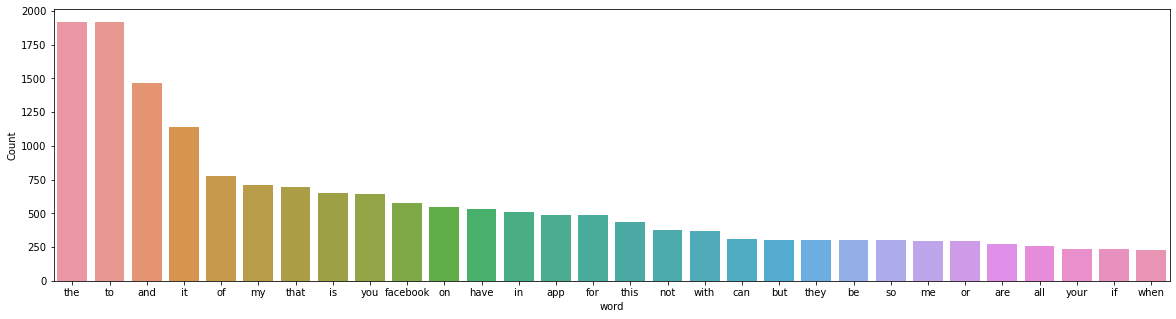

In [127]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2019_score1N2N3))

In [128]:
# Clean text
review_words_us_ready_2019_score1N2N3 = process_words(review_words_us_2019_score1N2N3)  # processed Text Data! - move to each section

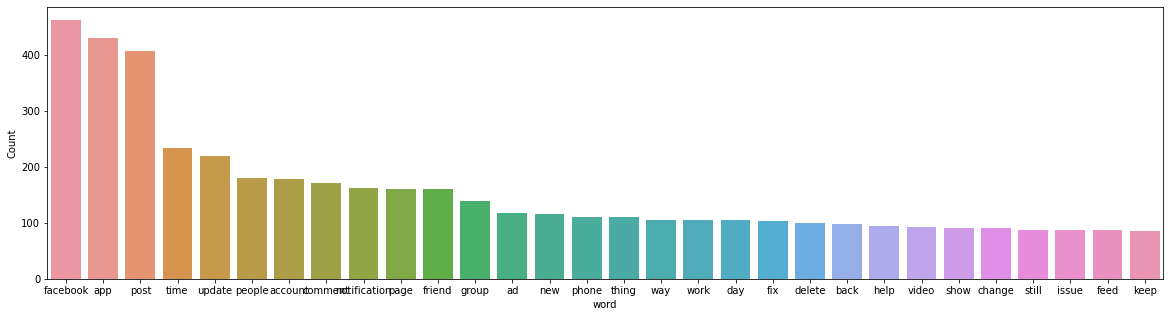

In [129]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2019_score1N2N3))


In [130]:
# Create Dictionary
id2word_us_2019_score1N2N3 = corpora.Dictionary(review_words_us_ready_2019_score1N2N3)

2021-10-16 20:14:52,651 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:14:52,749 [INFO] gensim.corpora.dictionary - built Dictionary(2776 unique tokens: ['admin', 'agenda', 'agree', 'app', 'arm']...) from 330 documents (total 18784 corpus positions)
2021-10-16 20:14:52,750 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2776 unique tokens: ['admin', 'agenda', 'agree', 'app', 'arm']...) from 330 documents (total 18784 corpus positions)", 'datetime': '2021-10-16T20:14:52.750748', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [131]:
# Create Corpus: Term Document Frequency
corpus_us_2019_score1N2N3 = [id2word_us_2019_score1N2N3.doc2bow(text) for text in review_words_us_ready_2019_score1N2N3]

In [132]:
# Training LDA model
model_list_us_2019_score1N2N3, coherence_values_us_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2019_score1N2N3, corpus=corpus_us_2019_score1N2N3, 
                                                              texts=review_words_us_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:14:52,870 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:14:52,872 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:14:52,876 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:14:52,878 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 330 documents, updating model once every 330 documents, evaluating perplexity every 330 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:14:54,279 [INFO] gensim.models.ldamodel - -8.416 per-word bound, 341.6 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:14:54,280 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #330/330
2021-10-16 20:14:55,614 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.020*"app" + 0.020*"facebook" + 0.013*"update" + 0.011*"time" + 0.010*"people" + 0.008*

2021-10-16 20:15:18,046 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"post" + 0.019*"app" + 0.016*"facebook" + 0.012*"update" + 0.012*"comment" + 0.010*"group" + 0.010*"notification" + 0.010*"time" + 0.009*"page" + 0.008*"people"
2021-10-16 20:15:18,048 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"facebook" + 0.021*"app" + 0.012*"time" + 0.012*"account" + 0.010*"post" + 0.010*"friend" + 0.009*"update" + 0.009*"people" + 0.007*"work" + 0.007*"thing"
2021-10-16 20:15:18,052 [INFO] gensim.models.ldamodel - topic diff=0.014435, rho=0.301511
2021-10-16 20:15:19,446 [INFO] gensim.models.ldamodel - -6.923 per-word bound, 121.3 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:15:19,447 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #330/330
2021-10-16 20:15:20,513 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"post" + 0.019*"app" + 0.015*"facebook" + 0.012*"update" + 0.012*"comment" + 0.010*"group" +

2021-10-16 20:15:41,203 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"post" + 0.019*"app" + 0.014*"facebook" + 0.013*"comment" + 0.012*"update" + 0.011*"group" + 0.011*"notification" + 0.010*"time" + 0.009*"page" + 0.008*"people"
2021-10-16 20:15:41,205 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"facebook" + 0.021*"app" + 0.014*"account" + 0.012*"time" + 0.010*"friend" + 0.009*"people" + 0.009*"post" + 0.009*"update" + 0.007*"work" + 0.007*"help"
2021-10-16 20:15:41,206 [INFO] gensim.models.ldamodel - topic diff=0.007767, rho=0.218218
2021-10-16 20:15:42,508 [INFO] gensim.models.ldamodel - -6.916 per-word bound, 120.8 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:15:42,509 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #330/330
2021-10-16 20:15:43,463 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"post" + 0.019*"app" + 0.014*"facebook" + 0.013*"comment" + 0.012*"update" + 0.011*"notificat

2021-10-16 20:16:04,081 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"post" + 0.019*"app" + 0.014*"comment" + 0.013*"facebook" + 0.012*"update" + 0.012*"notification" + 0.012*"group" + 0.010*"time" + 0.010*"page" + 0.008*"people"
2021-10-16 20:16:04,090 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"facebook" + 0.021*"app" + 0.015*"account" + 0.012*"time" + 0.009*"friend" + 0.009*"people" + 0.009*"update" + 0.008*"post" + 0.007*"help" + 0.007*"work"
2021-10-16 20:16:04,095 [INFO] gensim.models.ldamodel - topic diff=0.006775, rho=0.179605
2021-10-16 20:16:05,377 [INFO] gensim.models.ldamodel - -6.911 per-word bound, 120.4 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:16:05,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #330/330
2021-10-16 20:16:06,310 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"post" + 0.019*"app" + 0.014*"comment" + 0.013*"facebook" + 0.012*"notification" + 0.012*"upd

2021-10-16 20:16:26,011 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"post" + 0.020*"app" + 0.014*"comment" + 0.013*"notification" + 0.013*"facebook" + 0.012*"update" + 0.012*"group" + 0.010*"page" + 0.010*"time" + 0.008*"people"
2021-10-16 20:16:26,014 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"facebook" + 0.020*"app" + 0.015*"account" + 0.012*"time" + 0.009*"friend" + 0.009*"people" + 0.008*"update" + 0.008*"post" + 0.007*"help" + 0.007*"phone"
2021-10-16 20:16:26,015 [INFO] gensim.models.ldamodel - topic diff=0.005564, rho=0.156174
2021-10-16 20:16:27,155 [INFO] gensim.models.ldamodel - -6.908 per-word bound, 120.1 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:16:27,156 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #330/330
2021-10-16 20:16:28,204 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"post" + 0.020*"app" + 0.014*"comment" + 0.013*"notification" + 0.013*"facebook" + 0.012*"up

2021-10-16 20:16:47,124 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"post" + 0.020*"app" + 0.014*"comment" + 0.014*"notification" + 0.013*"update" + 0.012*"facebook" + 0.012*"group" + 0.010*"time" + 0.010*"page" + 0.008*"people"
2021-10-16 20:16:47,126 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"facebook" + 0.020*"app" + 0.016*"account" + 0.012*"time" + 0.009*"people" + 0.009*"friend" + 0.008*"update" + 0.008*"help" + 0.007*"post" + 0.007*"phone"
2021-10-16 20:16:47,126 [INFO] gensim.models.ldamodel - topic diff=0.004937, rho=0.140028
2021-10-16 20:16:47,127 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2776, num_topics=2, decay=0.5, chunksize=1000) in 114.25s', 'datetime': '2021-10-16T20:16:47.127764', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:16:47,130 [INFO] gensim.topic_coherence.probability_estim

2021-10-16 20:17:00,006 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #330/330
2021-10-16 20:17:00,513 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.021*"post" + 0.018*"time" + 0.018*"update" + 0.016*"facebook" + 0.012*"app" + 0.010*"way" + 0.009*"people" + 0.008*"change" + 0.008*"account" + 0.007*"never"
2021-10-16 20:17:00,515 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.029*"post" + 0.028*"app" + 0.019*"facebook" + 0.012*"update" + 0.011*"friend" + 0.011*"group" + 0.011*"page" + 0.011*"account" + 0.010*"time" + 0.009*"ad"
2021-10-16 20:17:00,517 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"facebook" + 0.021*"comment" + 0.018*"post" + 0.014*"app" + 0.013*"time" + 0.012*"video" + 0.011*"update" + 0.008*"feed" + 0.008*"page" + 0.008*"people"
2021-10-16 20:17:00,518 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.021*"app" + 0.015*"facebook" + 0.011*"account" + 0.011*"time" + 0.010*"ban" + 0.009*"post" + 0.008*"picture" + 0.008*"phone" + 0.00

2021-10-16 20:17:07,384 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"comment" + 0.020*"facebook" + 0.017*"post" + 0.014*"app" + 0.013*"video" + 0.013*"time" + 0.011*"update" + 0.008*"people" + 0.008*"notification" + 0.008*"page"
2021-10-16 20:17:07,387 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"post" + 0.029*"app" + 0.019*"facebook" + 0.013*"update" + 0.011*"group" + 0.011*"friend" + 0.011*"time" + 0.011*"page" + 0.010*"account" + 0.010*"feed"
2021-10-16 20:17:07,388 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.032*"facebook" + 0.022*"app" + 0.012*"account" + 0.012*"notification" + 0.012*"people" + 0.011*"delete" + 0.011*"time" + 0.011*"friend" + 0.008*"setting" + 0.008*"update"
2021-10-16 20:17:07,390 [INFO] gensim.models.ldamodel - topic diff=0.036616, rho=0.301511
2021-10-16 20:17:08,124 [INFO] gensim.models.ldamodel - -7.081 per-word bound, 135.3 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:17:08,129

2021-10-16 20:17:15,229 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.020*"post" + 0.019*"time" + 0.017*"update" + 0.016*"facebook" + 0.011*"app" + 0.010*"way" + 0.010*"people" + 0.008*"account" + 0.008*"change" + 0.007*"never"
2021-10-16 20:17:15,229 [INFO] gensim.models.ldamodel - topic diff=0.014778, rho=0.250000
2021-10-16 20:17:15,982 [INFO] gensim.models.ldamodel - -7.073 per-word bound, 134.7 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:17:15,984 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #330/330
2021-10-16 20:17:16,622 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.033*"facebook" + 0.022*"app" + 0.013*"account" + 0.012*"notification" + 0.012*"people" + 0.011*"delete" + 0.011*"time" + 0.011*"friend" + 0.008*"setting" + 0.007*"update"
2021-10-16 20:17:16,625 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.014*"marketplace" + 0.011*"picture" + 0.011*"facebook" + 0.010*"sell" + 0.008*"account" + 0

2021-10-16 20:17:24,711 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #330/330
2021-10-16 20:17:25,307 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"comment" + 0.019*"facebook" + 0.016*"post" + 0.014*"video" + 0.012*"time" + 0.012*"app" + 0.011*"update" + 0.008*"people" + 0.008*"page" + 0.007*"notification"
2021-10-16 20:17:25,325 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.018*"app" + 0.014*"facebook" + 0.012*"account" + 0.011*"ban" + 0.009*"picture" + 0.009*"time" + 0.008*"people" + 0.007*"post" + 0.007*"comment" + 0.007*"group"
2021-10-16 20:17:25,336 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.031*"post" + 0.030*"app" + 0.019*"facebook" + 0.014*"update" + 0.012*"group" + 0.011*"time" + 0.011*"notification" + 0.011*"friend" + 0.010*"page" + 0.010*"comment"
2021-10-16 20:17:25,342 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"time" + 0.019*"post" + 0.016*"update" + 0.015*"facebook" + 0.010*"way" + 0.010*"app" + 0.010*"people" + 0

2021-10-16 20:17:32,366 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"app" + 0.014*"facebook" + 0.012*"account" + 0.011*"ban" + 0.009*"picture" + 0.008*"time" + 0.008*"people" + 0.007*"post" + 0.007*"comment" + 0.007*"group"
2021-10-16 20:17:32,369 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"facebook" + 0.022*"app" + 0.015*"account" + 0.012*"people" + 0.012*"notification" + 0.011*"delete" + 0.011*"time" + 0.011*"friend" + 0.008*"setting" + 0.007*"turn"
2021-10-16 20:17:32,371 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.014*"marketplace" + 0.011*"picture" + 0.010*"sell" + 0.010*"facebook" + 0.007*"name" + 0.007*"policy" + 0.007*"business" + 0.007*"app" + 0.007*"item" + 0.007*"account"
2021-10-16 20:17:32,375 [INFO] gensim.models.ldamodel - topic diff=0.007479, rho=0.192450
2021-10-16 20:17:33,238 [INFO] gensim.models.ldamodel - -7.064 per-word bound, 133.8 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:17:33

2021-10-16 20:17:39,237 [INFO] gensim.models.ldamodel - topic diff=0.006387, rho=0.176777
2021-10-16 20:17:40,144 [INFO] gensim.models.ldamodel - -7.061 per-word bound, 133.5 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:17:40,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #330/330
2021-10-16 20:17:40,847 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"time" + 0.017*"post" + 0.015*"update" + 0.015*"facebook" + 0.011*"way" + 0.011*"people" + 0.010*"app" + 0.008*"account" + 0.007*"guy" + 0.007*"never"
2021-10-16 20:17:40,848 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.032*"post" + 0.030*"app" + 0.019*"facebook" + 0.015*"update" + 0.012*"group" + 0.012*"time" + 0.012*"notification" + 0.012*"comment" + 0.010*"friend" + 0.010*"page"
2021-10-16 20:17:40,851 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.017*"app" + 0.014*"facebook" + 0.012*"account" + 0.011*"ban" + 0.009*"picture" + 0.008*"people" + 0.

2021-10-16 20:17:48,857 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.035*"facebook" + 0.021*"app" + 0.016*"account" + 0.012*"people" + 0.012*"delete" + 0.011*"notification" + 0.011*"time" + 0.010*"friend" + 0.008*"setting" + 0.007*"turn"
2021-10-16 20:17:48,860 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"facebook" + 0.026*"post" + 0.017*"app" + 0.012*"people" + 0.010*"page" + 0.008*"update" + 0.007*"friend" + 0.006*"still" + 0.006*"issue" + 0.006*"message"
2021-10-16 20:17:48,862 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"comment" + 0.018*"facebook" + 0.016*"video" + 0.013*"post" + 0.012*"time" + 0.010*"app" + 0.010*"update" + 0.009*"people" + 0.008*"page" + 0.007*"view"
2021-10-16 20:17:48,865 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"time" + 0.017*"post" + 0.015*"update" + 0.014*"facebook" + 0.011*"way" + 0.011*"people" + 0.009*"app" + 0.008*"guy" + 0.008*"account" + 0.007*"never"
2021-10-16 20:17:48,866 [INFO] gensim.models.ldamodel -

2021-10-16 20:17:56,241 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.019*"comment" + 0.018*"facebook" + 0.016*"video" + 0.013*"post" + 0.011*"time" + 0.010*"app" + 0.009*"update" + 0.009*"people" + 0.009*"page" + 0.007*"view"
2021-10-16 20:17:56,243 [INFO] gensim.models.ldamodel - topic diff=0.005466, rho=0.152499
2021-10-16 20:17:57,000 [INFO] gensim.models.ldamodel - -7.055 per-word bound, 133.0 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:17:57,003 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #330/330
2021-10-16 20:17:57,538 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.019*"time" + 0.017*"post" + 0.014*"facebook" + 0.014*"update" + 0.011*"people" + 0.011*"way" + 0.009*"app" + 0.008*"guy" + 0.007*"account" + 0.007*"never"
2021-10-16 20:17:57,543 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"app" + 0.014*"facebook" + 0.012*"account" + 0.012*"ban" + 0.009*"picture" + 0.008*"people" + 0.008*"pos

2021-10-16 20:18:04,617 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.029*"facebook" + 0.024*"post" + 0.016*"app" + 0.012*"people" + 0.009*"page" + 0.007*"update" + 0.007*"friend" + 0.006*"still" + 0.006*"message" + 0.006*"issue"
2021-10-16 20:18:04,619 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.036*"facebook" + 0.021*"app" + 0.018*"account" + 0.012*"people" + 0.012*"delete" + 0.011*"time" + 0.010*"friend" + 0.009*"notification" + 0.008*"setting" + 0.007*"turn"
2021-10-16 20:18:04,620 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.015*"app" + 0.014*"facebook" + 0.012*"ban" + 0.012*"account" + 0.009*"picture" + 0.008*"people" + 0.008*"post" + 0.007*"comment" + 0.007*"time" + 0.007*"group"
2021-10-16 20:18:04,623 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.014*"marketplace" + 0.011*"picture" + 0.011*"sell" + 0.009*"facebook" + 0.008*"name" + 0.008*"policy" + 0.007*"business" + 0.007*"item" + 0.007*"app" + 0.006*"post"
2021-10-16 20:18:04,628 [INFO] gensim.mode

2021-10-16 20:18:19,735 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.029*"post" + 0.023*"app" + 0.016*"facebook" + 0.015*"friend" + 0.015*"group" + 0.013*"page" + 0.012*"ad" + 0.011*"notification" + 0.010*"people" + 0.010*"comment"
2021-10-16 20:18:19,737 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"facebook" + 0.020*"post" + 0.017*"time" + 0.013*"update" + 0.013*"people" + 0.012*"account" + 0.009*"way" + 0.008*"app" + 0.007*"change" + 0.007*"back"
2021-10-16 20:18:19,738 [INFO] gensim.models.ldamodel - topic diff=0.609080, rho=0.577350
2021-10-16 20:18:20,824 [INFO] gensim.models.ldamodel - -7.390 per-word bound, 167.7 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:18:20,829 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #330/330
2021-10-16 20:18:21,491 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.014*"ad" + 0.013*"video" + 0.012*"facebook" + 0.012*"app" + 0.010*"watch" + 0.009*"view" + 0.009*"up

2021-10-16 20:18:28,586 [INFO] gensim.models.ldamodel - -7.199 per-word bound, 147.0 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:18:28,589 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #330/330
2021-10-16 20:18:29,135 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.016*"ad" + 0.014*"video" + 0.013*"watch" + 0.012*"facebook" + 0.011*"view" + 0.010*"update" + 0.010*"privacy" + 0.009*"app" + 0.009*"page" + 0.008*"fb"
2021-10-16 20:18:29,137 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"facebook" + 0.023*"app" + 0.022*"update" + 0.019*"post" + 0.015*"time" + 0.012*"notification" + 0.010*"bad" + 0.009*"work" + 0.008*"way" + 0.008*"still"
2021-10-16 20:18:29,139 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.028*"marketplace" + 0.015*"sell" + 0.015*"picture" + 0.012*"app" + 0.012*"look" + 0.010*"policy" + 0.010*"brand" + 0.009*"item" + 0.008*"support" + 0.008*"help"
2021-10-16 20:18:29,140 [INFO] gensim.

2021-10-16 20:18:35,666 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"facebook" + 0.024*"update" + 0.023*"app" + 0.018*"post" + 0.015*"time" + 0.011*"notification" + 0.010*"bad" + 0.010*"work" + 0.009*"still" + 0.008*"way"
2021-10-16 20:18:35,669 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.039*"facebook" + 0.015*"app" + 0.014*"day" + 0.013*"account" + 0.012*"friend" + 0.010*"share" + 0.010*"time" + 0.010*"family" + 0.009*"keep" + 0.009*"thing"
2021-10-16 20:18:35,671 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.029*"marketplace" + 0.019*"sell" + 0.015*"picture" + 0.013*"look" + 0.012*"app" + 0.011*"policy" + 0.011*"brand" + 0.010*"item" + 0.008*"feature" + 0.008*"support"
2021-10-16 20:18:35,673 [INFO] gensim.models.ldamodel - topic diff=0.033640, rho=0.267261
2021-10-16 20:18:36,456 [INFO] gensim.models.ldamodel - -7.167 per-word bound, 143.8 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:18:36,457 [INFO] gensi

2021-10-16 20:18:42,225 [INFO] gensim.models.ldamodel - topic diff=0.016289, rho=0.229416
2021-10-16 20:18:42,989 [INFO] gensim.models.ldamodel - -7.156 per-word bound, 142.6 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:18:42,991 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #330/330
2021-10-16 20:18:43,521 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.018*"ad" + 0.015*"video" + 0.014*"watch" + 0.012*"facebook" + 0.012*"view" + 0.011*"privacy" + 0.009*"update" + 0.009*"page" + 0.009*"fb" + 0.008*"set"
2021-10-16 20:18:43,523 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.021*"app" + 0.016*"facebook" + 0.011*"delete" + 0.011*"option" + 0.010*"people" + 0.010*"update" + 0.008*"message" + 0.008*"phone" + 0.008*"ad" + 0.007*"log"
2021-10-16 20:18:43,525 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.021*"facebook" + 0.013*"feed" + 0.012*"app" + 0.011*"update" + 0.011*"view" + 0.010*"time" + 0.008*"post" + 0

2021-10-16 20:18:49,701 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.033*"facebook" + 0.028*"post" + 0.024*"people" + 0.013*"page" + 0.010*"group" + 0.008*"business" + 0.008*"friend" + 0.007*"comment" + 0.006*"app" + 0.006*"watch"
2021-10-16 20:18:49,706 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.030*"marketplace" + 0.021*"sell" + 0.015*"picture" + 0.014*"look" + 0.012*"app" + 0.011*"policy" + 0.011*"brand" + 0.010*"item" + 0.008*"feature" + 0.008*"support"
2021-10-16 20:18:49,708 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.062*"account" + 0.030*"facebook" + 0.027*"help" + 0.010*"email" + 0.010*"send" + 0.008*"comment" + 0.008*"friend" + 0.008*"page" + 0.008*"name" + 0.008*"picture"
2021-10-16 20:18:49,711 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.021*"facebook" + 0.013*"feed" + 0.013*"app" + 0.012*"update" + 0.011*"view" + 0.010*"time" + 0.008*"comment" + 0.008*"post" + 0.007*"work" + 0.007*"version"
2021-10-16 20:18:49,718 [INFO] gensim.models.ldamod

2021-10-16 20:18:56,030 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.020*"app" + 0.016*"facebook" + 0.012*"delete" + 0.011*"option" + 0.010*"people" + 0.008*"message" + 0.008*"update" + 0.007*"phone" + 0.007*"log" + 0.007*"ad"
2021-10-16 20:18:56,031 [INFO] gensim.models.ldamodel - topic diff=0.006910, rho=0.182574
2021-10-16 20:18:56,737 [INFO] gensim.models.ldamodel - -7.143 per-word bound, 141.3 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:18:56,739 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #330/330
2021-10-16 20:18:57,200 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.035*"post" + 0.022*"app" + 0.016*"group" + 0.015*"friend" + 0.014*"facebook" + 0.014*"ad" + 0.013*"page" + 0.013*"update" + 0.012*"people" + 0.011*"new"
2021-10-16 20:18:57,202 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.034*"facebook" + 0.027*"post" + 0.025*"people" + 0.013*"page" + 0.010*"group" + 0.008*"business" + 0.008*"fri

2021-10-16 20:19:03,800 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.028*"facebook" + 0.025*"update" + 0.025*"app" + 0.017*"post" + 0.015*"time" + 0.010*"bad" + 0.010*"work" + 0.009*"still" + 0.008*"well" + 0.008*"way"
2021-10-16 20:19:03,803 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"facebook" + 0.018*"post" + 0.016*"people" + 0.013*"time" + 0.009*"name" + 0.009*"way" + 0.008*"group" + 0.007*"understand" + 0.007*"guy" + 0.006*"platform"
2021-10-16 20:19:03,810 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.018*"ad" + 0.015*"video" + 0.015*"watch" + 0.012*"facebook" + 0.012*"view" + 0.011*"privacy" + 0.009*"page" + 0.009*"update" + 0.009*"fb" + 0.009*"set"
2021-10-16 20:19:03,822 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"marketplace" + 0.021*"sell" + 0.015*"picture" + 0.014*"look" + 0.012*"app" + 0.011*"policy" + 0.011*"brand" + 0.010*"item" + 0.009*"feature" + 0.008*"car"
2021-10-16 20:19:03,824 [INFO] gensim.models.ldamodel - topic #3 (0.083

2021-10-16 20:19:10,604 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"facebook" + 0.013*"app" + 0.012*"update" + 0.012*"view" + 0.011*"feed" + 0.010*"time" + 0.008*"comment" + 0.008*"post" + 0.007*"version" + 0.007*"work"
2021-10-16 20:19:10,605 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.035*"post" + 0.022*"app" + 0.016*"group" + 0.015*"friend" + 0.014*"facebook" + 0.014*"ad" + 0.013*"update" + 0.013*"page" + 0.012*"people" + 0.011*"new"
2021-10-16 20:19:10,607 [INFO] gensim.models.ldamodel - topic diff=0.004266, rho=0.156174
2021-10-16 20:19:11,379 [INFO] gensim.models.ldamodel - -7.136 per-word bound, 140.6 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:19:11,380 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #330/330
2021-10-16 20:19:11,978 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.018*"app" + 0.015*"time" + 0.014*"page" + 0.013*"phone" + 0.011*"picture" + 0.010*"profile" + 0.010*"hate" + 0

2021-10-16 20:19:17,788 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #330/330
2021-10-16 20:19:18,324 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.047*"app" + 0.040*"post" + 0.031*"notification" + 0.026*"comment" + 0.020*"time" + 0.016*"facebook" + 0.014*"click" + 0.012*"update" + 0.011*"fix" + 0.009*"show"
2021-10-16 20:19:18,325 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.035*"facebook" + 0.026*"post" + 0.025*"people" + 0.013*"page" + 0.009*"group" + 0.008*"business" + 0.008*"friend" + 0.006*"watch" + 0.006*"site" + 0.005*"video"
2021-10-16 20:19:18,327 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.065*"account" + 0.031*"facebook" + 0.028*"help" + 0.011*"send" + 0.010*"email" + 0.009*"number" + 0.009*"disabled" + 0.009*"phone" + 0.009*"name" + 0.009*"friend"
2021-10-16 20:19:18,330 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.018*"app" + 0.015*"facebook" + 0.012*"delete" + 0.011*"option" + 0.010*"people" + 0.008*"message" + 0.007*"log" + 

2021-10-16 20:19:30,734 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-16 20:19:30,736 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-16 20:19:30,746 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:19:30,789 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 330 documents, updating model once every 330 documents, evaluating perplexity every 330 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:19:32,254 [INFO] gensim.models.ldamodel - -12.451 per-word bound, 5599.8 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:19:32,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #330/330
2021-10-16 20:19:33,514 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.025*"facebook" + 0.014*"feed" + 0.013*"comment" + 0.012*"post" +

2021-10-16 20:19:39,860 [INFO] gensim.models.ldamodel - -7.326 per-word bound, 160.4 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:19:39,861 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #330/330
2021-10-16 20:19:40,300 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.028*"post" + 0.024*"facebook" + 0.020*"people" + 0.014*"page" + 0.013*"picture" + 0.012*"photo" + 0.011*"update" + 0.010*"notification" + 0.010*"video" + 0.009*"app"
2021-10-16 20:19:40,303 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.024*"facebook" + 0.019*"people" + 0.010*"back" + 0.010*"contact" + 0.010*"keep" + 0.010*"log" + 0.009*"time" + 0.009*"active" + 0.009*"ever" + 0.008*"delete"
2021-10-16 20:19:40,307 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.050*"account" + 0.032*"facebook" + 0.032*"help" + 0.012*"friend" + 0.012*"number" + 0.009*"post" + 0.009*"time" + 0.009*"phone" + 0.008*"email" + 0.008*"comment"
2021-10-16 20:19:40,310 

2021-10-16 20:19:46,303 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.015*"video" + 0.014*"app" + 0.013*"post" + 0.012*"update" + 0.010*"comment" + 0.009*"fb" + 0.009*"time" + 0.009*"set" + 0.009*"thing" + 0.008*"page"
2021-10-16 20:19:46,314 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.023*"facebook" + 0.019*"people" + 0.010*"contact" + 0.010*"back" + 0.009*"keep" + 0.009*"log" + 0.009*"active" + 0.009*"ever" + 0.009*"time" + 0.008*"group"
2021-10-16 20:19:46,322 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.022*"update" + 0.015*"facebook" + 0.013*"people" + 0.010*"way" + 0.010*"guy" + 0.010*"group" + 0.009*"time" + 0.008*"post" + 0.007*"app" + 0.007*"user"
2021-10-16 20:19:46,335 [INFO] gensim.models.ldamodel - topic diff=0.060478, rho=0.288675
2021-10-16 20:19:47,142 [INFO] gensim.models.ldamodel - -7.258 per-word bound, 153.1 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:19:47,144 [INFO] gensim.models.ldamodel - 

2021-10-16 20:19:52,768 [INFO] gensim.models.ldamodel - topic diff=0.021186, rho=0.242536
2021-10-16 20:19:53,506 [INFO] gensim.models.ldamodel - -7.244 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:19:53,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #330/330
2021-10-16 20:19:54,013 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"app" + 0.029*"facebook" + 0.021*"update" + 0.019*"post" + 0.019*"time" + 0.013*"notification" + 0.012*"phone" + 0.011*"work" + 0.011*"still" + 0.010*"recent"
2021-10-16 20:19:54,016 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.038*"marketplace" + 0.019*"sell" + 0.016*"policy" + 0.013*"item" + 0.012*"brand" + 0.011*"support" + 0.010*"message" + 0.010*"access" + 0.010*"look" + 0.010*"app"
2021-10-16 20:19:54,018 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.035*"account" + 0.026*"facebook" + 0.011*"post" + 0.011*"disabled" + 0.010*"privacy" + 0.010

2021-10-16 20:20:01,164 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.038*"marketplace" + 0.021*"sell" + 0.016*"policy" + 0.014*"item" + 0.013*"brand" + 0.011*"look" + 0.011*"support" + 0.011*"message" + 0.010*"access" + 0.010*"app"
2021-10-16 20:20:01,167 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.017*"page" + 0.016*"picture" + 0.015*"facebook" + 0.014*"group" + 0.013*"hate" + 0.011*"friend" + 0.011*"note" + 0.011*"share" + 0.010*"time" + 0.010*"app"
2021-10-16 20:20:01,170 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.028*"post" + 0.023*"ad" + 0.020*"facebook" + 0.019*"comment" + 0.012*"friend" + 0.011*"group" + 0.010*"change" + 0.010*"never" + 0.010*"app" + 0.010*"click"
2021-10-16 20:20:01,173 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.028*"facebook" + 0.016*"app" + 0.011*"account" + 0.011*"service" + 0.010*"post" + 0.010*"platform" + 0.009*"social" + 0.009*"people" + 0.008*"name" + 0.007*"ban"
2021-10-16 20:20:01,175 [INFO] gensim.models.ldamodel - 

2021-10-16 20:20:08,546 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.026*"post" + 0.025*"facebook" + 0.020*"people" + 0.015*"page" + 0.014*"picture" + 0.012*"photo" + 0.011*"update" + 0.011*"video" + 0.009*"friend" + 0.009*"notification"
2021-10-16 20:20:08,547 [INFO] gensim.models.ldamodel - topic diff=0.005243, rho=0.188982
2021-10-16 20:20:09,347 [INFO] gensim.models.ldamodel - -7.233 per-word bound, 150.4 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:20:09,349 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #330/330
2021-10-16 20:20:10,006 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.021*"facebook" + 0.017*"comment" + 0.013*"time" + 0.013*"video" + 0.010*"find" + 0.009*"photo" + 0.009*"album" + 0.009*"friend" + 0.009*"update" + 0.008*"problem"
2021-10-16 20:20:10,008 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.034*"facebook" + 0.022*"app" + 0.018*"share" + 0.015*"friend" + 0.013*"notification" + 0

2021-10-16 20:20:17,366 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.026*"post" + 0.025*"facebook" + 0.020*"people" + 0.015*"page" + 0.014*"picture" + 0.012*"photo" + 0.011*"update" + 0.011*"video" + 0.009*"friend" + 0.009*"notification"
2021-10-16 20:20:17,368 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.031*"post" + 0.028*"app" + 0.022*"time" + 0.017*"people" + 0.014*"facebook" + 0.011*"back" + 0.010*"top" + 0.009*"comment" + 0.009*"change" + 0.008*"view"
2021-10-16 20:20:17,369 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.028*"post" + 0.023*"ad" + 0.020*"facebook" + 0.019*"comment" + 0.012*"friend" + 0.011*"group" + 0.010*"change" + 0.010*"never" + 0.010*"app" + 0.010*"click"
2021-10-16 20:20:17,371 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.044*"app" + 0.038*"post" + 0.020*"notification" + 0.015*"facebook" + 0.014*"time" + 0.012*"comment" + 0.012*"new" + 0.011*"fix" + 0.011*"update" + 0.009*"show"
2021-10-16 20:20:17,376 [INFO] gensim.models.ldamodel

2021-10-16 20:20:24,073 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.067*"account" + 0.036*"facebook" + 0.032*"help" + 0.014*"friend" + 0.014*"number" + 0.012*"email" + 0.010*"time" + 0.010*"tell" + 0.009*"post" + 0.009*"picture"
2021-10-16 20:20:24,076 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.020*"update" + 0.014*"facebook" + 0.014*"people" + 0.011*"way" + 0.010*"group" + 0.008*"time" + 0.008*"post" + 0.008*"guy" + 0.007*"info" + 0.007*"user"
2021-10-16 20:20:24,079 [INFO] gensim.models.ldamodel - topic diff=0.002159, rho=0.160128
2021-10-16 20:20:24,872 [INFO] gensim.models.ldamodel - -7.229 per-word bound, 150.0 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:20:24,874 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #330/330
2021-10-16 20:20:25,384 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.037*"post" + 0.021*"group" + 0.019*"app" + 0.019*"page" + 0.015*"facebook" + 0.014*"friend" + 0.014*"new" 

2021-10-16 20:20:30,988 [INFO] gensim.models.ldamodel - -7.228 per-word bound, 149.9 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:20:30,989 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #330/330
2021-10-16 20:20:31,438 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.033*"facebook" + 0.023*"app" + 0.018*"share" + 0.015*"friend" + 0.014*"notification" + 0.011*"people" + 0.011*"block" + 0.009*"way" + 0.009*"turn" + 0.009*"setting"
2021-10-16 20:20:31,444 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.036*"app" + 0.020*"update" + 0.017*"facebook" + 0.012*"page" + 0.010*"time" + 0.010*"message" + 0.010*"phone" + 0.009*"delete" + 0.009*"change" + 0.008*"post"
2021-10-16 20:20:31,452 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.031*"post" + 0.028*"app" + 0.022*"time" + 0.017*"people" + 0.014*"facebook" + 0.011*"back" + 0.010*"top" + 0.009*"comment" + 0.009*"change" + 0.008*"view"
2021-10-16 20:20:31,463 [INFO]

2021-10-16 20:20:37,605 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.022*"facebook" + 0.020*"people" + 0.010*"contact" + 0.010*"active" + 0.010*"back" + 0.009*"ever" + 0.008*"time" + 0.008*"group" + 0.008*"log" + 0.008*"password"
2021-10-16 20:20:37,608 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.020*"facebook" + 0.017*"comment" + 0.013*"time" + 0.013*"video" + 0.010*"find" + 0.009*"album" + 0.009*"photo" + 0.009*"friend" + 0.009*"update" + 0.009*"problem"
2021-10-16 20:20:37,610 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.036*"account" + 0.026*"facebook" + 0.011*"post" + 0.011*"disabled" + 0.011*"privacy" + 0.010*"delete" + 0.010*"location" + 0.009*"service" + 0.009*"app" + 0.009*"back"
2021-10-16 20:20:37,612 [INFO] gensim.models.ldamodel - topic diff=0.001108, rho=0.141421
2021-10-16 20:20:38,398 [INFO] gensim.models.ldamodel - -7.227 per-word bound, 149.8 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:20:38,39

2021-10-16 20:20:52,544 [INFO] gensim.models.ldamodel - topic diff=0.536329, rho=0.500000
2021-10-16 20:20:53,248 [INFO] gensim.models.ldamodel - -7.536 per-word bound, 185.6 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:20:53,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #330/330
2021-10-16 20:20:53,780 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.030*"facebook" + 0.022*"video" + 0.021*"ad" + 0.018*"thing" + 0.018*"friend" + 0.017*"notification" + 0.016*"time" + 0.014*"watch" + 0.013*"post" + 0.012*"show"
2021-10-16 20:20:53,782 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.017*"marketplace" + 0.014*"profile" + 0.013*"business" + 0.012*"timeline" + 0.011*"post" + 0.010*"account" + 0.009*"name" + 0.009*"picture" + 0.009*"support" + 0.009*"brand"
2021-10-16 20:20:53,785 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.023*"facebook" + 0.015*"password" + 0.014*"page" + 0.013*"change" + 0.009*"app" + 0.

2021-10-16 20:21:00,017 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.029*"ad" + 0.025*"post" + 0.017*"facebook" + 0.016*"people" + 0.012*"show" + 0.010*"group" + 0.009*"day" + 0.009*"message" + 0.009*"app" + 0.009*"time"
2021-10-16 20:21:00,021 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.030*"facebook" + 0.019*"comment" + 0.015*"feed" + 0.013*"update" + 0.012*"page" + 0.012*"work" + 0.011*"time" + 0.010*"fix" + 0.010*"find" + 0.009*"problem"
2021-10-16 20:21:00,022 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.014*"video" + 0.013*"facebook" + 0.013*"update" + 0.009*"life" + 0.009*"feature" + 0.009*"privacy" + 0.009*"app" + 0.008*"page" + 0.008*"add" + 0.008*"watch"
2021-10-16 20:21:00,024 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.017*"marketplace" + 0.015*"profile" + 0.014*"business" + 0.013*"timeline" + 0.011*"post" + 0.011*"support" + 0.011*"picture" + 0.010*"name" + 0.009*"sell" + 0.009*"photo"
2021-10-16 20:21:00,027 [INFO] gensim.models.ldamodel - 

2021-10-16 20:21:06,326 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.036*"facebook" + 0.021*"people" + 0.019*"app" + 0.017*"group" + 0.013*"account" + 0.011*"update" + 0.010*"back" + 0.010*"friend" + 0.009*"time" + 0.008*"comment"
2021-10-16 20:21:06,330 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.019*"time" + 0.017*"phone" + 0.015*"group" + 0.013*"work" + 0.012*"app" + 0.012*"facebook" + 0.011*"account" + 0.010*"start" + 0.009*"reason" + 0.008*"problem"
2021-10-16 20:21:06,332 [INFO] gensim.models.ldamodel - topic diff=0.034419, rho=0.258199
2021-10-16 20:21:07,060 [INFO] gensim.models.ldamodel - -7.322 per-word bound, 160.0 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:21:07,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #330/330
2021-10-16 20:21:07,622 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.019*"marketplace" + 0.015*"profile" + 0.014*"business" + 0.013*"timeline" + 0.013*"picture" + 0.0

2021-10-16 20:21:13,729 [INFO] gensim.models.ldamodel - -7.312 per-word bound, 158.9 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:21:13,730 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #330/330
2021-10-16 20:21:14,294 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.029*"facebook" + 0.019*"comment" + 0.015*"feed" + 0.014*"update" + 0.012*"page" + 0.012*"work" + 0.011*"time" + 0.010*"fix" + 0.010*"find" + 0.009*"problem"
2021-10-16 20:21:14,303 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.019*"time" + 0.017*"phone" + 0.015*"group" + 0.013*"work" + 0.012*"app" + 0.012*"facebook" + 0.010*"start" + 0.010*"account" + 0.009*"reason" + 0.008*"problem"
2021-10-16 20:21:14,308 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.080*"account" + 0.037*"facebook" + 0.036*"help" + 0.013*"friend" + 0.012*"disabled" + 0.012*"number" + 0.012*"time" + 0.012*"year" + 0.012*"comment" + 0.010*"phone"
2021-10-16 20:21:14,311 [INF

2021-10-16 20:21:21,138 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.031*"post" + 0.022*"page" + 0.021*"app" + 0.017*"group" + 0.015*"friend" + 0.010*"load" + 0.009*"facebook" + 0.009*"fb" + 0.009*"ad" + 0.009*"people"
2021-10-16 20:21:21,139 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.036*"facebook" + 0.022*"people" + 0.018*"app" + 0.018*"group" + 0.011*"update" + 0.011*"account" + 0.010*"back" + 0.010*"friend" + 0.009*"time" + 0.009*"comment"
2021-10-16 20:21:21,143 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.035*"post" + 0.015*"able" + 0.013*"facebook" + 0.013*"view" + 0.011*"comment" + 0.011*"marketplace" + 0.011*"service" + 0.009*"year" + 0.008*"time" + 0.008*"still"
2021-10-16 20:21:21,145 [INFO] gensim.models.ldamodel - topic diff=0.006683, rho=0.196116
2021-10-16 20:21:21,878 [INFO] gensim.models.ldamodel - -7.306 per-word bound, 158.2 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:21:21,879 [INFO] gensim.

2021-10-16 20:21:27,384 [INFO] gensim.models.ldamodel - topic diff=0.004247, rho=0.179605
2021-10-16 20:21:28,177 [INFO] gensim.models.ldamodel - -7.303 per-word bound, 157.9 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:21:28,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #330/330
2021-10-16 20:21:28,743 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.035*"post" + 0.015*"able" + 0.013*"facebook" + 0.013*"view" + 0.011*"comment" + 0.011*"marketplace" + 0.011*"service" + 0.009*"year" + 0.008*"time" + 0.008*"still"
2021-10-16 20:21:28,745 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.019*"time" + 0.017*"phone" + 0.015*"group" + 0.013*"work" + 0.012*"app" + 0.011*"facebook" + 0.010*"start" + 0.009*"reason" + 0.008*"crash" + 0.008*"problem"
2021-10-16 20:21:28,747 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.023*"facebook" + 0.016*"password" + 0.015*"page" + 0.013*"change" + 0.010*"app" + 0.010*"talk" +

2021-10-16 20:21:35,072 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.039*"post" + 0.017*"group" + 0.017*"facebook" + 0.015*"comment" + 0.015*"change" + 0.014*"ad" + 0.012*"app" + 0.011*"back" + 0.011*"notification" + 0.011*"update"
2021-10-16 20:21:35,078 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.031*"app" + 0.022*"facebook" + 0.018*"message" + 0.015*"phone" + 0.015*"update" + 0.012*"post" + 0.009*"log" + 0.009*"new" + 0.008*"well" + 0.007*"page"
2021-10-16 20:21:35,082 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.036*"facebook" + 0.022*"people" + 0.018*"app" + 0.018*"group" + 0.011*"update" + 0.010*"account" + 0.010*"back" + 0.010*"friend" + 0.009*"time" + 0.009*"comment"
2021-10-16 20:21:35,087 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.023*"facebook" + 0.017*"password" + 0.015*"page" + 0.013*"change" + 0.010*"app" + 0.010*"talk" + 0.010*"people" + 0.010*"representative" + 0.010*"spend" + 0.010*"find"
2021-10-16 20:21:35,095 [INFO] gensim.models.ld

2021-10-16 20:21:41,776 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.032*"post" + 0.022*"page" + 0.021*"app" + 0.017*"group" + 0.015*"friend" + 0.010*"load" + 0.009*"facebook" + 0.009*"fb" + 0.009*"ad" + 0.009*"people"
2021-10-16 20:21:41,778 [INFO] gensim.models.ldamodel - topic diff=0.002428, rho=0.154303
2021-10-16 20:21:42,469 [INFO] gensim.models.ldamodel - -7.298 per-word bound, 157.3 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:21:42,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #330/330
2021-10-16 20:21:42,883 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.014*"video" + 0.014*"facebook" + 0.012*"update" + 0.009*"life" + 0.009*"privacy" + 0.009*"feature" + 0.008*"app" + 0.008*"watch" + 0.008*"add" + 0.008*"page"
2021-10-16 20:21:42,886 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.027*"facebook" + 0.020*"comment" + 0.016*"feed" + 0.014*"update" + 0.013*"page" + 0.011*"work" + 0.010*"time" +

2021-10-16 20:21:49,672 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.031*"app" + 0.022*"facebook" + 0.018*"message" + 0.015*"phone" + 0.015*"update" + 0.012*"post" + 0.009*"log" + 0.009*"new" + 0.008*"well" + 0.008*"page"
2021-10-16 20:21:49,673 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.029*"facebook" + 0.026*"ad" + 0.024*"video" + 0.019*"thing" + 0.017*"friend" + 0.017*"watch" + 0.017*"time" + 0.017*"notification" + 0.015*"post" + 0.012*"show"
2021-10-16 20:21:49,675 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.031*"post" + 0.020*"app" + 0.015*"update" + 0.015*"click" + 0.014*"page" + 0.014*"new" + 0.013*"notification" + 0.013*"comment" + 0.012*"picture" + 0.010*"facebook"
2021-10-16 20:21:49,679 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.039*"post" + 0.017*"group" + 0.017*"facebook" + 0.015*"comment" + 0.015*"change" + 0.014*"ad" + 0.012*"app" + 0.011*"back" + 0.011*"notification" + 0.011*"update"
2021-10-16 20:21:49,681 [INFO] gensim.models.ldamode

2021-10-16 20:22:06,657 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.015*"facebook" + 0.014*"group" + 0.014*"update" + 0.012*"app" + 0.010*"page" + 0.008*"user" + 0.008*"review" + 0.007*"post" + 0.007*"time" + 0.007*"load"
2021-10-16 20:22:06,659 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.044*"app" + 0.034*"post" + 0.021*"facebook" + 0.019*"notification" + 0.012*"fix" + 0.011*"update" + 0.010*"time" + 0.008*"delete" + 0.008*"new" + 0.007*"show"
2021-10-16 20:22:06,663 [INFO] gensim.models.ldamodel - topic diff=19.516361, rho=1.000000
2021-10-16 20:22:07,732 [INFO] gensim.models.ldamodel - -8.134 per-word bound, 281.0 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:22:07,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #330/330
2021-10-16 20:22:08,437 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"facebook" + 0.022*"page" + 0.018*"password" + 0.014*"find" + 0.011*"people" + 0.011*"upload" + 0.011

2021-10-16 20:22:15,039 [INFO] gensim.models.ldamodel - -7.468 per-word bound, 177.1 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:22:15,040 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #330/330
2021-10-16 20:22:15,641 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.020*"facebook" + 0.016*"app" + 0.014*"user" + 0.014*"review" + 0.013*"active" + 0.013*"ever" + 0.013*"privacy" + 0.012*"setting" + 0.009*"affect" + 0.009*"much"
2021-10-16 20:22:15,643 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.030*"post" + 0.030*"facebook" + 0.023*"ban" + 0.013*"people" + 0.011*"time" + 0.011*"platform" + 0.011*"community" + 0.010*"day" + 0.010*"way" + 0.009*"really"
2021-10-16 20:22:15,645 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.031*"account" + 0.027*"app" + 0.025*"facebook" + 0.012*"time" + 0.012*"group" + 0.011*"update" + 0.010*"day" + 0.010*"change" + 0.010*"picture" + 0.009*"back"
2021-10-16 20:22:15,647 [INF

2021-10-16 20:22:22,212 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.018*"page" + 0.017*"time" + 0.015*"facebook" + 0.015*"account" + 0.012*"app" + 0.009*"picture" + 0.009*"reason" + 0.009*"notification" + 0.009*"phone" + 0.008*"update"
2021-10-16 20:22:22,215 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.039*"app" + 0.029*"post" + 0.024*"facebook" + 0.022*"update" + 0.019*"time" + 0.018*"video" + 0.012*"friend" + 0.012*"share" + 0.012*"hate" + 0.012*"thing"
2021-10-16 20:22:22,220 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.024*"facebook" + 0.024*"comment" + 0.019*"post" + 0.017*"app" + 0.013*"fix" + 0.012*"people" + 0.012*"account" + 0.010*"issue" + 0.009*"click" + 0.008*"report"
2021-10-16 20:22:22,222 [INFO] gensim.models.ldamodel - topic diff=0.063976, rho=0.277350
2021-10-16 20:22:23,153 [INFO] gensim.models.ldamodel - -7.401 per-word bound, 169.0 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:22:23,154 [INFO]

2021-10-16 20:22:30,154 [INFO] gensim.models.ldamodel - topic diff=0.022519, rho=0.235702
2021-10-16 20:22:31,437 [INFO] gensim.models.ldamodel - -7.386 per-word bound, 167.3 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:22:31,439 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #330/330
2021-10-16 20:22:31,973 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.014*"people" + 0.014*"app" + 0.012*"help" + 0.011*"day" + 0.010*"post" + 0.008*"thing" + 0.008*"account" + 0.008*"search" + 0.008*"time" + 0.008*"facebook"
2021-10-16 20:22:31,975 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.017*"update" + 0.015*"ad" + 0.013*"time" + 0.013*"post" + 0.012*"facebook" + 0.012*"watch" + 0.011*"album" + 0.010*"set" + 0.010*"video" + 0.010*"play"
2021-10-16 20:22:31,978 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.032*"post" + 0.029*"facebook" + 0.026*"ban" + 0.013*"people" + 0.011*"time" + 0.011*"platform" + 0.011*"commu

2021-10-16 20:22:39,136 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.030*"app" + 0.027*"update" + 0.019*"facebook" + 0.016*"work" + 0.016*"time" + 0.013*"phone" + 0.013*"problem" + 0.013*"still" + 0.011*"recent" + 0.011*"bad"
2021-10-16 20:22:39,137 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.021*"group" + 0.015*"people" + 0.014*"fb" + 0.013*"app" + 0.013*"profile" + 0.011*"let" + 0.010*"tell" + 0.009*"secret" + 0.008*"facebook" + 0.007*"problem"
2021-10-16 20:22:39,138 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.039*"post" + 0.023*"time" + 0.016*"people" + 0.014*"app" + 0.014*"facebook" + 0.014*"back" + 0.013*"change" + 0.011*"view" + 0.010*"feed" + 0.010*"recent"
2021-10-16 20:22:39,140 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"facebook" + 0.024*"password" + 0.017*"page" + 0.017*"find" + 0.010*"upload" + 0.010*"people" + 0.010*"active" + 0.010*"representative" + 0.010*"spend" + 0.010*"talk"
2021-10-16 20:22:39,141 [INFO] gensim.models.ldamode

2021-10-16 20:22:46,441 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.033*"comment" + 0.017*"facebook" + 0.014*"ad" + 0.014*"read" + 0.012*"friend" + 0.012*"thing" + 0.012*"app" + 0.012*"change" + 0.011*"name" + 0.011*"account"
2021-10-16 20:22:46,444 [INFO] gensim.models.ldamodel - topic diff=0.006081, rho=0.185695
2021-10-16 20:22:47,247 [INFO] gensim.models.ldamodel - -7.371 per-word bound, 165.5 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:22:47,248 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #330/330
2021-10-16 20:22:47,797 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.043*"ad" + 0.028*"facebook" + 0.017*"feed" + 0.015*"people" + 0.013*"account" + 0.012*"post" + 0.010*"group" + 0.010*"add" + 0.009*"news" + 0.008*"show"
2021-10-16 20:22:47,808 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.097*"post" + 0.062*"comment" + 0.057*"notification" + 0.034*"group" + 0.032*"click" + 0.025*"update" + 0.025

2021-10-16 20:22:55,269 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.025*"block" + 0.020*"ad" + 0.018*"post" + 0.013*"comment" + 0.012*"business" + 0.011*"recent" + 0.011*"never" + 0.010*"hard" + 0.010*"stupid" + 0.010*"force"
2021-10-16 20:22:55,271 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.030*"app" + 0.027*"facebook" + 0.022*"help" + 0.019*"account" + 0.018*"phone" + 0.016*"post" + 0.014*"time" + 0.013*"delete" + 0.010*"email" + 0.010*"back"
2021-10-16 20:22:55,273 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.018*"page" + 0.018*"time" + 0.015*"facebook" + 0.015*"account" + 0.012*"app" + 0.009*"picture" + 0.009*"reason" + 0.009*"phone" + 0.008*"update" + 0.008*"notification"
2021-10-16 20:22:55,275 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.043*"ad" + 0.028*"facebook" + 0.017*"feed" + 0.015*"people" + 0.013*"account" + 0.012*"post" + 0.010*"group" + 0.010*"add" + 0.009*"news" + 0.008*"show"
2021-10-16 20:22:55,276 [INFO] gensim.models.ldamodel - to

2021-10-16 20:23:02,419 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.036*"post" + 0.025*"notification" + 0.025*"comment" + 0.025*"page" + 0.015*"facebook" + 0.013*"time" + 0.012*"business" + 0.012*"able" + 0.010*"service" + 0.010*"laptop"
2021-10-16 20:23:02,421 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.017*"update" + 0.014*"ad" + 0.013*"post" + 0.012*"facebook" + 0.012*"time" + 0.012*"watch" + 0.011*"album" + 0.011*"set" + 0.010*"play" + 0.010*"new"
2021-10-16 20:23:02,423 [INFO] gensim.models.ldamodel - topic diff=0.003382, rho=0.158114
2021-10-16 20:23:03,301 [INFO] gensim.models.ldamodel - -7.363 per-word bound, 164.6 perplexity estimate based on a held-out corpus of 330 documents with 18784 words
2021-10-16 20:23:03,319 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #330/330
2021-10-16 20:23:03,834 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.030*"facebook" + 0.019*"video" + 0.018*"ad" + 0.018*"friend" + 0.015*"account" + 0.015*"people" +

2021-10-16 20:23:10,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #330/330
2021-10-16 20:23:11,106 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.030*"app" + 0.027*"facebook" + 0.022*"help" + 0.019*"account" + 0.018*"phone" + 0.015*"post" + 0.013*"time" + 0.013*"delete" + 0.011*"email" + 0.010*"back"
2021-10-16 20:23:11,114 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.032*"comment" + 0.017*"facebook" + 0.014*"friend" + 0.014*"ad" + 0.013*"read" + 0.013*"change" + 0.012*"name" + 0.012*"app" + 0.012*"thing" + 0.011*"account"
2021-10-16 20:23:11,121 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.100*"post" + 0.064*"comment" + 0.059*"notification" + 0.036*"group" + 0.034*"click" + 0.027*"update" + 0.025*"app" + 0.017*"show" + 0.015*"new" + 0.014*"time"
2021-10-16 20:23:11,130 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"facebook" + 0.024*"password" + 0.017*"page" + 0.017*"find" + 0.010*"upload" + 0.010*"people" + 0.010*"representative" + 

2021-10-16 20:23:18,764 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.035*"facebook" + 0.024*"password" + 0.017*"page" + 0.017*"find" + 0.010*"upload" + 0.010*"people" + 0.010*"spend" + 0.010*"representative" + 0.010*"talk" + 0.010*"deactivate"
2021-10-16 20:23:18,766 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.020*"group" + 0.015*"people" + 0.014*"fb" + 0.013*"profile" + 0.012*"app" + 0.011*"let" + 0.010*"tell" + 0.010*"secret" + 0.008*"facebook" + 0.008*"info"
2021-10-16 20:23:18,767 [INFO] gensim.models.ldamodel - topic diff=0.002128, rho=0.140028
2021-10-16 20:23:18,771 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2776, num_topics=27, decay=0.5, chunksize=1000) in 75.29s', 'datetime': '2021-10-16T20:23:18.770892', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:23:18,779 [INFO] gensim.topic_coherence.probabilit

In [133]:
%store model_list_us_2019_score1N2N3
%store coherence_values_us_2019_score1N2N3

Stored 'model_list_us_2019_score1N2N3' (list)
Stored 'coherence_values_us_2019_score1N2N3' (list)


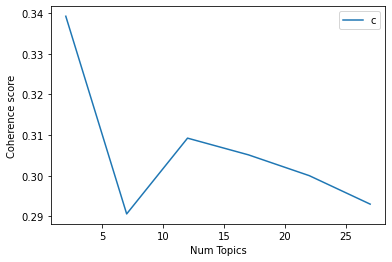

In [134]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [135]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3393
index: 1 | Num Topics = 7  has Coherence Value of 0.2906
index: 2 | Num Topics = 12  has Coherence Value of 0.3093
index: 3 | Num Topics = 17  has Coherence Value of 0.3051
index: 4 | Num Topics = 22  has Coherence Value of 0.3
index: 5 | Num Topics = 27  has Coherence Value of 0.293


In [186]:
# Select optimal number of topics
optimal_model_us_2019_score1N2N3 = model_list_us_2019_score1N2N3[0]

In [187]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2019_score1N2N3, corpus_us_2019_score1N2N3, id2word_us_2019_score1N2N3)

In [188]:
print("pyLDAVis for us topics for score=1,2,3 in 2019:")
vis_us_2019_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.057752  0.0       1        1  51.878912
0     -0.057752  0.0       2        1  48.121088, topic_info=             Term        Freq       Total Category  logprob  loglift
246       account  154.000000  154.000000  Default  30.0000  30.0000
45           post  357.000000  357.000000  Default  29.0000  29.0000
133       comment  150.000000  150.000000  Default  28.0000  28.0000
154  notification  142.000000  142.000000  Default  27.0000  27.0000
143         group  122.000000  122.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
22         friend   53.268536  140.943677   Topic2  -5.1340  -0.2416
124           way   42.029006   92.333359   Topic2  -5.3710  -0.0556
229        change   37.949058   79.296081   Topic2  -5.4731  -0.0055
201         never   35.145807   74.062940   Topic2  -5.5498  -0.0140
115         thing   36.623313   96.573724   Topic2  -5.5086  -0.2382

[173 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
246       1  0.988052  account
246       2  0.012916  account
792       1  0.945477   active
792       2  0.052527   active
68        1  0.443070       ad
...     ...       ...      ...
224       1  0.683839     work
224       2  0.314783     work
370       2  0.976231    write
127       1  0.849891     year
127       2  0.151766     year

[221 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## By-rating of 2020 (Rating=1,2,3)

In [139]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_us_2020_score1N2N3 = facebook_ios_us_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_us_2020_score1N2N3 = list(sent_to_words(review_us_2020_score1N2N3))
print(review_words_us_2020_score1N2N3[:1])

[['love', 'to', 'be', 'on', 'facebook', 'until', 'it', 'wants', 'to', 'act', 'up', 'when', 'reshape', 'post', 'it', 'always', 'says', 'post', 'failed', 'no', 'matter', 'what', 'post', 'it', 'is', 'that', 'gets', 'really', 'annoying', 'sometimes', 'it', 'will', 'say', 'that', 'for', 'hours', 'up', 'to', 'days', 'that', 'should', 'probably', 'be', 'fixed', 'another', 'thing', 'are', 'ads', 'during', 'videos', 'facebook', 'never', 'had', 'ads', 'like', 'that', 'especially', 'when', 'your', 'watching', 'video', 'and', 'you', 're', 'laughing', 'once', 'stupid', 'ad', 'pops', 'up', 'immediately', 'stop', 'laughing', 'and', 'say', 'seriously', 'then', 'll', 'have', 'to', 'replay', 'that', 'part', 'of', 'the', 'video', 'because', 'it', 'missed', 'whatever', 'they', 'said', 'it', 'just', 'ruins', 'my', 'mood', 'sometimes', 'get', 'that', 'fixed', 'too', 'maybe']]


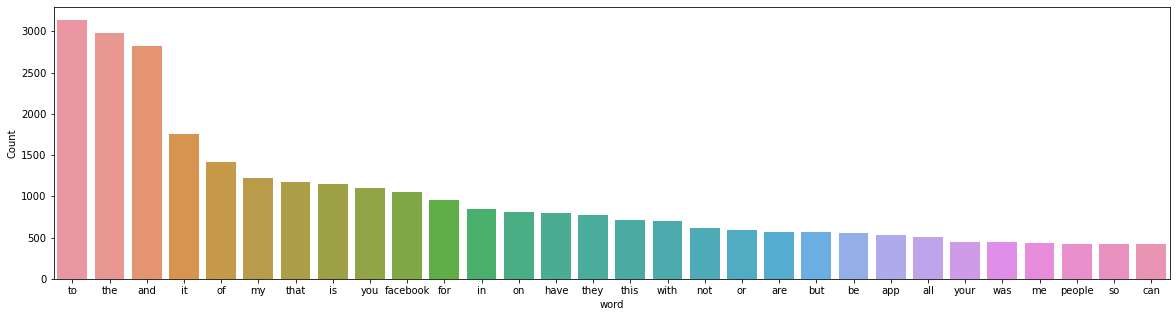

In [140]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2020_score1N2N3))

In [141]:
# Clean text
review_words_us_ready_2020_score1N2N3 = process_words(review_words_us_2020_score1N2N3)  # processed Text Data! - move to each section

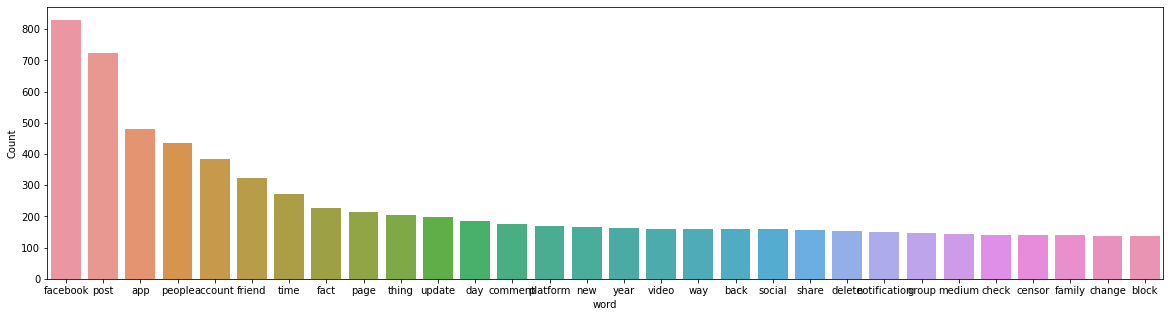

In [142]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2020_score1N2N3))


In [143]:
# Create Dictionary
id2word_us_2020_score1N2N3 = corpora.Dictionary(review_words_us_ready_2020_score1N2N3)

2021-10-16 20:24:12,466 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:24:12,659 [INFO] gensim.corpora.dictionary - built Dictionary(4026 unique tokens: ['act', 'ad', 'always', 'annoying', 'day']...) from 557 documents (total 33602 corpus positions)
2021-10-16 20:24:12,661 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(4026 unique tokens: ['act', 'ad', 'always', 'annoying', 'day']...) from 557 documents (total 33602 corpus positions)", 'datetime': '2021-10-16T20:24:12.661229', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [144]:
# Create Corpus: Term Document Frequency
corpus_us_2020_score1N2N3 = [id2word_us_2020_score1N2N3.doc2bow(text) for text in review_words_us_ready_2020_score1N2N3]

In [145]:
# Training LDA model
model_list_us_2020_score1N2N3, coherence_values_us_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2020_score1N2N3, corpus=corpus_us_2020_score1N2N3, 
                                                              texts=review_words_us_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:24:12,802 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:24:12,804 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:24:12,808 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:24:12,813 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 557 documents, updating model once every 557 documents, evaluating perplexity every 557 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:24:15,402 [INFO] gensim.models.ldamodel - -8.766 per-word bound, 435.2 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:24:15,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #557/557
2021-10-16 20:24:18,272 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.023*"post" + 0.013*"app" + 0.010*"people" + 0.010*"account" + 0.009*"friend" + 0.0

2021-10-16 20:24:58,474 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"post" + 0.022*"facebook" + 0.011*"people" + 0.010*"app" + 0.010*"friend" + 0.009*"fact" + 0.007*"time" + 0.006*"platform" + 0.006*"group" + 0.006*"censor"
2021-10-16 20:24:58,488 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"facebook" + 0.018*"account" + 0.016*"app" + 0.012*"people" + 0.011*"post" + 0.008*"page" + 0.008*"time" + 0.007*"update" + 0.006*"friend" + 0.006*"phone"
2021-10-16 20:24:58,496 [INFO] gensim.models.ldamodel - topic diff=0.029961, rho=0.301511
2021-10-16 20:25:00,544 [INFO] gensim.models.ldamodel - -7.107 per-word bound, 137.9 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:25:00,545 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #557/557
2021-10-16 20:25:02,276 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"post" + 0.022*"facebook" + 0.011*"people" + 0.010*"app" + 0.010*"friend" + 0.009*"fact" + 0.007*

2021-10-16 20:25:35,262 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.021*"facebook" + 0.013*"people" + 0.010*"fact" + 0.010*"friend" + 0.008*"app" + 0.007*"platform" + 0.007*"censor" + 0.006*"group" + 0.006*"opinion"
2021-10-16 20:25:35,266 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"facebook" + 0.019*"account" + 0.018*"app" + 0.012*"post" + 0.010*"page" + 0.010*"people" + 0.009*"update" + 0.009*"time" + 0.007*"new" + 0.007*"friend"
2021-10-16 20:25:35,268 [INFO] gensim.models.ldamodel - topic diff=0.022310, rho=0.218218
2021-10-16 20:25:37,025 [INFO] gensim.models.ldamodel - -7.079 per-word bound, 135.2 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:25:37,026 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #557/557
2021-10-16 20:25:38,244 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"post" + 0.021*"facebook" + 0.013*"people" + 0.010*"fact" + 0.010*"friend" + 0.008*"app" + 0.007

2021-10-16 20:26:05,600 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"post" + 0.022*"facebook" + 0.015*"people" + 0.011*"fact" + 0.010*"friend" + 0.008*"platform" + 0.007*"censor" + 0.007*"opinion" + 0.007*"app" + 0.007*"social"
2021-10-16 20:26:05,602 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"facebook" + 0.019*"app" + 0.018*"account" + 0.016*"post" + 0.010*"page" + 0.010*"update" + 0.010*"time" + 0.008*"people" + 0.008*"friend" + 0.007*"new"
2021-10-16 20:26:05,603 [INFO] gensim.models.ldamodel - topic diff=0.018267, rho=0.179605
2021-10-16 20:26:07,556 [INFO] gensim.models.ldamodel - -7.055 per-word bound, 133.0 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:26:07,557 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #557/557
2021-10-16 20:26:09,028 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"post" + 0.022*"facebook" + 0.015*"people" + 0.011*"fact" + 0.009*"friend" + 0.008*"platform" +

2021-10-16 20:26:34,659 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #557/557
2021-10-16 20:26:35,842 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"facebook" + 0.020*"post" + 0.015*"people" + 0.012*"fact" + 0.009*"friend" + 0.008*"platform" + 0.008*"censor" + 0.007*"opinion" + 0.007*"social" + 0.007*"medium"
2021-10-16 20:26:35,843 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"facebook" + 0.019*"app" + 0.019*"post" + 0.017*"account" + 0.010*"page" + 0.010*"update" + 0.010*"time" + 0.008*"friend" + 0.008*"people" + 0.007*"notification"
2021-10-16 20:26:35,845 [INFO] gensim.models.ldamodel - topic diff=0.011077, rho=0.156174
2021-10-16 20:26:37,825 [INFO] gensim.models.ldamodel - -7.042 per-word bound, 131.8 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:26:37,826 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #557/557
2021-10-16 20:26:39,580 [INFO] gensim.models.ldamodel - topic #0 (0

2021-10-16 20:27:19,345 [INFO] gensim.models.ldamodel - -7.036 per-word bound, 131.3 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:27:19,353 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #557/557
2021-10-16 20:27:21,242 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"facebook" + 0.018*"post" + 0.016*"people" + 0.012*"fact" + 0.009*"friend" + 0.008*"platform" + 0.008*"censor" + 0.007*"opinion" + 0.007*"social" + 0.007*"medium"
2021-10-16 20:27:21,248 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"facebook" + 0.020*"post" + 0.019*"app" + 0.017*"account" + 0.010*"page" + 0.010*"time" + 0.010*"update" + 0.009*"friend" + 0.008*"people" + 0.008*"notification"
2021-10-16 20:27:21,261 [INFO] gensim.models.ldamodel - topic diff=0.006868, rho=0.140028
2021-10-16 20:27:21,277 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4026, num_topics=2, decay=0.5, chunksize=1000) in 188.46

2021-10-16 20:27:48,318 [INFO] gensim.models.ldamodel - topic diff=0.244796, rho=0.447214
2021-10-16 20:27:50,943 [INFO] gensim.models.ldamodel - -7.307 per-word bound, 158.3 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:27:50,944 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #557/557
2021-10-16 20:27:53,295 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"post" + 0.021*"facebook" + 0.017*"app" + 0.013*"people" + 0.012*"block" + 0.008*"photo" + 0.008*"time" + 0.008*"day" + 0.007*"update" + 0.007*"fact"
2021-10-16 20:27:53,296 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.020*"facebook" + 0.017*"people" + 0.014*"fact" + 0.013*"social" + 0.011*"medium" + 0.011*"information" + 0.011*"share" + 0.010*"platform" + 0.009*"opinion" + 0.007*"check"
2021-10-16 20:27:53,298 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"facebook" + 0.014*"app" + 0.014*"post" + 0.013*"video" + 0.011*"people" + 0.011*"time" + 0

2021-10-16 20:28:08,207 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"account" + 0.024*"facebook" + 0.012*"post" + 0.012*"app" + 0.009*"update" + 0.008*"fix" + 0.008*"day" + 0.007*"new" + 0.007*"issue" + 0.007*"time"
2021-10-16 20:28:08,209 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"post" + 0.020*"facebook" + 0.016*"app" + 0.013*"block" + 0.012*"people" + 0.008*"photo" + 0.008*"update" + 0.008*"day" + 0.007*"time" + 0.006*"check"
2021-10-16 20:28:08,212 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.022*"facebook" + 0.021*"fact" + 0.017*"people" + 0.014*"social" + 0.013*"medium" + 0.013*"share" + 0.012*"opinion" + 0.012*"censor" + 0.012*"platform" + 0.011*"information"
2021-10-16 20:28:08,214 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"post" + 0.017*"app" + 0.017*"facebook" + 0.015*"friend" + 0.012*"comment" + 0.011*"page" + 0.010*"notification" + 0.010*"group" + 0.009*"time" + 0.008*"people"
2021-10-16 20:28:08,217 [INFO] gensim.models.ldamod

2021-10-16 20:28:21,655 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.024*"fact" + 0.023*"facebook" + 0.017*"people" + 0.015*"censor" + 0.015*"social" + 0.014*"opinion" + 0.014*"medium" + 0.014*"platform" + 0.013*"share" + 0.011*"information"
2021-10-16 20:28:21,659 [INFO] gensim.models.ldamodel - topic diff=0.027558, rho=0.250000
2021-10-16 20:28:23,187 [INFO] gensim.models.ldamodel - -7.236 per-word bound, 150.8 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:28:23,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #557/557
2021-10-16 20:28:24,307 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"post" + 0.019*"app" + 0.016*"facebook" + 0.015*"friend" + 0.013*"comment" + 0.012*"notification" + 0.011*"page" + 0.011*"group" + 0.009*"time" + 0.008*"people"
2021-10-16 20:28:24,309 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.016*"video" + 0.016*"app" + 0.012*"time" + 0.011*"people" + 0.0

2021-10-16 20:28:41,022 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.016*"people" + 0.013*"post" + 0.011*"app" + 0.009*"block" + 0.008*"facebook" + 0.008*"page" + 0.008*"thing" + 0.007*"friend" + 0.007*"user" + 0.006*"help"
2021-10-16 20:28:41,027 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.017*"video" + 0.017*"app" + 0.012*"time" + 0.011*"people" + 0.011*"post" + 0.008*"friend" + 0.008*"update" + 0.008*"watch" + 0.008*"back"
2021-10-16 20:28:41,031 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.043*"account" + 0.026*"facebook" + 0.012*"app" + 0.010*"post" + 0.009*"log" + 0.009*"update" + 0.008*"day" + 0.008*"email" + 0.008*"fix" + 0.007*"time"
2021-10-16 20:28:41,038 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.046*"post" + 0.019*"app" + 0.016*"facebook" + 0.016*"friend" + 0.014*"comment" + 0.014*"notification" + 0.011*"page" + 0.011*"group" + 0.010*"time" + 0.008*"show"
2021-10-16 20:28:41,039 [INFO] gensim.models.ldamodel - topic #3 (0.1

2021-10-16 20:28:55,689 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.016*"people" + 0.013*"post" + 0.011*"app" + 0.009*"block" + 0.008*"facebook" + 0.008*"thing" + 0.008*"page" + 0.007*"friend" + 0.007*"user" + 0.006*"help"
2021-10-16 20:28:55,691 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.025*"facebook" + 0.018*"people" + 0.017*"censor" + 0.015*"platform" + 0.015*"social" + 0.015*"opinion" + 0.014*"medium" + 0.012*"share" + 0.012*"political"
2021-10-16 20:28:55,692 [INFO] gensim.models.ldamodel - topic diff=0.014053, rho=0.192450
2021-10-16 20:28:57,438 [INFO] gensim.models.ldamodel - -7.212 per-word bound, 148.3 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:28:57,457 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #557/557
2021-10-16 20:28:58,841 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.018*"video" + 0.017*"app" + 0.012*"time" + 0.011*"people" + 0.010*"post" + 

2021-10-16 20:29:18,640 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #557/557
2021-10-16 20:29:20,198 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.045*"account" + 0.027*"facebook" + 0.012*"app" + 0.009*"log" + 0.009*"email" + 0.009*"post" + 0.008*"page" + 0.008*"day" + 0.008*"update" + 0.008*"time"
2021-10-16 20:29:20,201 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.022*"post" + 0.019*"facebook" + 0.016*"app" + 0.016*"block" + 0.010*"people" + 0.009*"update" + 0.009*"photo" + 0.008*"day" + 0.007*"time" + 0.006*"friend"
2021-10-16 20:29:20,208 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"facebook" + 0.017*"people" + 0.016*"ad" + 0.009*"app" + 0.009*"post" + 0.008*"time" + 0.007*"thing" + 0.007*"friend" + 0.006*"money" + 0.005*"day"
2021-10-16 20:29:20,211 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.048*"post" + 0.020*"app" + 0.016*"notification" + 0.016*"friend" + 0.015*"comment" + 0.015*"facebook" + 0.012*"page" + 0.011*"group" + 0.01

2021-10-16 20:29:38,127 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.016*"people" + 0.012*"post" + 0.011*"app" + 0.009*"block" + 0.008*"thing" + 0.007*"page" + 0.007*"facebook" + 0.007*"friend" + 0.007*"user" + 0.005*"help"
2021-10-16 20:29:38,130 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.026*"facebook" + 0.018*"people" + 0.017*"censor" + 0.015*"platform" + 0.015*"opinion" + 0.015*"social" + 0.014*"medium" + 0.012*"post" + 0.012*"check"
2021-10-16 20:29:38,134 [INFO] gensim.models.ldamodel - topic diff=0.008956, rho=0.162221
2021-10-16 20:29:40,203 [INFO] gensim.models.ldamodel - -7.201 per-word bound, 147.1 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:29:40,211 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #557/557
2021-10-16 20:29:41,860 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"account" + 0.027*"facebook" + 0.012*"app" + 0.009*"email" + 0.009*"log" + 0.009*"page" + 0.008

2021-10-16 20:30:00,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #557/557
2021-10-16 20:30:02,277 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.031*"facebook" + 0.019*"video" + 0.018*"app" + 0.012*"time" + 0.011*"people" + 0.009*"watch" + 0.009*"post" + 0.008*"update" + 0.008*"back" + 0.007*"friend"
2021-10-16 20:30:02,282 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.021*"post" + 0.019*"facebook" + 0.017*"app" + 0.016*"block" + 0.010*"people" + 0.010*"update" + 0.009*"photo" + 0.009*"day" + 0.007*"time" + 0.006*"friend"
2021-10-16 20:30:02,284 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"account" + 0.027*"facebook" + 0.012*"app" + 0.010*"email" + 0.009*"log" + 0.009*"page" + 0.008*"day" + 0.008*"post" + 0.008*"help" + 0.008*"time"
2021-10-16 20:30:02,286 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"facebook" + 0.017*"people" + 0.017*"ad" + 0.009*"app" + 0.008*"post" + 0.008*"time" + 0.007*"thing" + 0.007*"money" + 0.006*"friend

2021-10-16 20:30:19,841 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.026*"facebook" + 0.019*"people" + 0.017*"censor" + 0.015*"platform" + 0.015*"opinion" + 0.014*"social" + 0.014*"medium" + 0.013*"post" + 0.012*"check"
2021-10-16 20:30:19,849 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.016*"people" + 0.011*"post" + 0.011*"app" + 0.009*"block" + 0.007*"thing" + 0.007*"user" + 0.006*"page" + 0.006*"facebook" + 0.006*"friend" + 0.005*"help"
2021-10-16 20:30:19,852 [INFO] gensim.models.ldamodel - topic diff=0.005971, rho=0.142857
2021-10-16 20:30:21,424 [INFO] gensim.models.ldamodel - -7.194 per-word bound, 146.4 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:30:21,446 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #557/557
2021-10-16 20:30:22,839 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.026*"fact" + 0.026*"facebook" + 0.019*"people" + 0.017*"censor" + 0.015*"platform" + 0.015*"opinion

2021-10-16 20:30:46,160 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #557/557
2021-10-16 20:30:47,350 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.026*"facebook" + 0.020*"app" + 0.015*"post" + 0.011*"people" + 0.009*"social" + 0.008*"way" + 0.008*"new" + 0.008*"medium" + 0.008*"time" + 0.006*"site"
2021-10-16 20:30:47,356 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.028*"facebook" + 0.017*"post" + 0.015*"people" + 0.011*"friend" + 0.010*"app" + 0.010*"ad" + 0.008*"time" + 0.008*"thing" + 0.007*"family" + 0.006*"day"
2021-10-16 20:30:47,358 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.017*"post" + 0.015*"people" + 0.013*"app" + 0.011*"facebook" + 0.009*"block" + 0.009*"account" + 0.008*"thing" + 0.008*"page" + 0.008*"friend" + 0.008*"comment"
2021-10-16 20:30:47,368 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.022*"facebook" + 0.019*"post" + 0.014*"app" + 0.011*"account" + 0.009*"people" + 0.007*"show" + 0.007*"comment" + 0.007*"issue" + 0.00

2021-10-16 20:31:01,597 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.029*"facebook" + 0.016*"people" + 0.016*"post" + 0.012*"ad" + 0.010*"app" + 0.009*"friend" + 0.008*"time" + 0.007*"thing" + 0.007*"family" + 0.006*"day"
2021-10-16 20:31:01,599 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.030*"facebook" + 0.018*"post" + 0.017*"video" + 0.010*"time" + 0.010*"app" + 0.010*"watch" + 0.010*"people" + 0.009*"back" + 0.009*"update" + 0.008*"friend"
2021-10-16 20:31:01,602 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.031*"post" + 0.030*"facebook" + 0.017*"block" + 0.015*"people" + 0.012*"update" + 0.012*"app" + 0.011*"day" + 0.009*"comment" + 0.009*"social" + 0.008*"fact"
2021-10-16 20:31:01,604 [INFO] gensim.models.ldamodel - topic diff=0.117981, rho=0.333333
2021-10-16 20:31:03,418 [INFO] gensim.models.ldamodel - -7.375 per-word bound, 166.0 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:31:03,420 [INFO] gensim.models.lda

2021-10-16 20:31:17,701 [INFO] gensim.models.ldamodel - topic diff=0.043748, rho=0.267261
2021-10-16 20:31:20,180 [INFO] gensim.models.ldamodel - -7.345 per-word bound, 162.5 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:31:20,183 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #557/557
2021-10-16 20:31:21,458 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"facebook" + 0.019*"post" + 0.016*"account" + 0.015*"information" + 0.011*"friend" + 0.008*"app" + 0.008*"people" + 0.007*"allow" + 0.006*"violate" + 0.006*"delete"
2021-10-16 20:31:21,466 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"facebook" + 0.018*"video" + 0.017*"post" + 0.011*"watch" + 0.011*"app" + 0.010*"time" + 0.009*"back" + 0.009*"update" + 0.009*"people" + 0.007*"friend"
2021-10-16 20:31:21,472 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.032*"fact" + 0.020*"opinion" + 0.020*"people" + 0.018*"social" + 0.017*"platform" + 0.016*"me

2021-10-16 20:31:36,085 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.044*"post" + 0.022*"app" + 0.019*"notification" + 0.018*"friend" + 0.017*"facebook" + 0.015*"page" + 0.014*"comment" + 0.011*"show" + 0.011*"time" + 0.011*"group"
2021-10-16 20:31:36,087 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.017*"post" + 0.016*"people" + 0.012*"app" + 0.010*"block" + 0.009*"facebook" + 0.008*"comment" + 0.008*"friend" + 0.007*"page" + 0.007*"thing" + 0.006*"day"
2021-10-16 20:31:36,090 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"facebook" + 0.019*"video" + 0.016*"post" + 0.012*"watch" + 0.010*"app" + 0.010*"time" + 0.010*"back" + 0.009*"update" + 0.008*"people" + 0.007*"never"
2021-10-16 20:31:36,092 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"post" + 0.031*"facebook" + 0.019*"block" + 0.016*"people" + 0.012*"update" + 0.012*"app" + 0.012*"day" + 0.011*"comment" + 0.008*"report" + 0.007*"social"
2021-10-16 20:31:36,093 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:31:50,464 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.024*"facebook" + 0.018*"app" + 0.013*"post" + 0.009*"people" + 0.008*"social" + 0.008*"way" + 0.008*"time" + 0.007*"star" + 0.007*"site" + 0.006*"medium"
2021-10-16 20:31:50,465 [INFO] gensim.models.ldamodel - topic diff=0.017768, rho=0.200000
2021-10-16 20:31:52,171 [INFO] gensim.models.ldamodel - -7.309 per-word bound, 158.6 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:31:52,175 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #557/557
2021-10-16 20:31:53,517 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"account" + 0.022*"facebook" + 0.019*"app" + 0.011*"time" + 0.010*"log" + 0.010*"email" + 0.010*"people" + 0.009*"page" + 0.009*"change" + 0.009*"help"
2021-10-16 20:31:53,519 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.030*"facebook" + 0.016*"people" + 0.016*"post" + 0.013*"ad" + 0.009*"app" + 0.009*"time" + 0.008*"friend" + 0.

2021-10-16 20:32:07,684 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.021*"facebook" + 0.011*"app" + 0.009*"post" + 0.008*"people" + 0.007*"user" + 0.007*"issue" + 0.007*"thing" + 0.007*"still" + 0.006*"show" + 0.006*"report"
2021-10-16 20:32:07,693 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.016*"people" + 0.016*"post" + 0.011*"app" + 0.010*"block" + 0.009*"comment" + 0.008*"facebook" + 0.008*"friend" + 0.006*"page" + 0.006*"day" + 0.006*"thing"
2021-10-16 20:32:07,701 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"facebook" + 0.022*"video" + 0.015*"post" + 0.013*"watch" + 0.010*"back" + 0.010*"time" + 0.010*"app" + 0.009*"update" + 0.007*"people" + 0.007*"never"
2021-10-16 20:32:07,704 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.034*"fact" + 0.023*"opinion" + 0.022*"platform" + 0.021*"people" + 0.021*"facebook" + 0.019*"censor" + 0.019*"social" + 0.017*"medium" + 0.015*"check" + 0.015*"share"
2021-10-16 20:32:07,711 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:32:24,304 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.038*"facebook" + 0.018*"post" + 0.014*"information" + 0.012*"account" + 0.011*"friend" + 0.009*"app" + 0.007*"violate" + 0.006*"people" + 0.006*"ad" + 0.006*"delete"
2021-10-16 20:32:24,306 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.034*"fact" + 0.023*"platform" + 0.022*"opinion" + 0.022*"facebook" + 0.021*"people" + 0.019*"censor" + 0.019*"social" + 0.018*"medium" + 0.015*"check" + 0.015*"share"
2021-10-16 20:32:24,308 [INFO] gensim.models.ldamodel - topic diff=0.011616, rho=0.166667
2021-10-16 20:32:26,581 [INFO] gensim.models.ldamodel - -7.289 per-word bound, 156.4 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:32:26,584 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #557/557
2021-10-16 20:32:28,039 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.016*"people" + 0.016*"post" + 0.011*"app" + 0.010*"block" + 0.009*"comment" + 0.007*"f

2021-10-16 20:32:42,717 [INFO] gensim.models.ldamodel - -7.283 per-word bound, 155.8 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:32:42,718 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #557/557
2021-10-16 20:32:43,855 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.020*"facebook" + 0.009*"app" + 0.008*"people" + 0.007*"user" + 0.007*"issue" + 0.007*"post" + 0.007*"still" + 0.007*"thing" + 0.006*"report" + 0.006*"profile"
2021-10-16 20:32:43,856 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.016*"facebook" + 0.010*"people" + 0.009*"thing" + 0.008*"app" + 0.007*"well" + 0.006*"information" + 0.006*"friend" + 0.005*"new" + 0.005*"keep" + 0.004*"account"
2021-10-16 20:32:43,858 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"post" + 0.033*"facebook" + 0.021*"block" + 0.018*"people" + 0.014*"day" + 0.012*"app" + 0.011*"comment" + 0.011*"update" + 0.009*"report" + 0.008*"ban"
2021-10-16 20:32:43,859 [INFO]

2021-10-16 20:32:59,510 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.025*"post" + 0.020*"people" + 0.014*"censor" + 0.011*"fact" + 0.011*"friend" + 0.011*"check" + 0.010*"thing" + 0.008*"leave" + 0.008*"share" + 0.008*"liberal"
2021-10-16 20:32:59,512 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.029*"facebook" + 0.016*"people" + 0.015*"post" + 0.014*"ad" + 0.009*"time" + 0.009*"app" + 0.008*"friend" + 0.007*"thing" + 0.007*"family" + 0.007*"day"
2021-10-16 20:32:59,514 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.029*"facebook" + 0.024*"video" + 0.014*"post" + 0.013*"watch" + 0.010*"back" + 0.010*"time" + 0.010*"app" + 0.009*"update" + 0.007*"never" + 0.007*"people"
2021-10-16 20:32:59,517 [INFO] gensim.models.ldamodel - topic diff=0.008171, rho=0.145865
2021-10-16 20:33:01,373 [INFO] gensim.models.ldamodel - -7.278 per-word bound, 155.2 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:33:01,374 [INFO] gensim.models.lda

2021-10-16 20:33:25,957 [INFO] gensim.models.ldamodel - -12.095 per-word bound, 4374.6 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:33:25,959 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #557/557
2021-10-16 20:33:28,806 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.033*"post" + 0.017*"facebook" + 0.014*"app" + 0.014*"friend" + 0.011*"page" + 0.009*"change" + 0.009*"notification" + 0.008*"time" + 0.008*"people" + 0.008*"group"
2021-10-16 20:33:28,820 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.028*"post" + 0.017*"people" + 0.011*"friend" + 0.011*"fact" + 0.011*"facebook" + 0.009*"check" + 0.008*"thing" + 0.007*"account" + 0.007*"censor" + 0.007*"leave"
2021-10-16 20:33:28,828 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.031*"facebook" + 0.019*"post" + 0.012*"time" + 0.011*"video" + 0.011*"app" + 0.010*"friend" + 0.010*"people" + 0.008*"account" + 0.008*"update" + 0.007*"year"
2021-10-16 20:33:28,839 

2021-10-16 20:33:49,517 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.032*"fact" + 0.027*"people" + 0.019*"facebook" + 0.018*"check" + 0.018*"censor" + 0.015*"post" + 0.013*"platform" + 0.013*"opinion" + 0.010*"app" + 0.010*"political"
2021-10-16 20:33:49,523 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.026*"post" + 0.020*"people" + 0.013*"fact" + 0.012*"thing" + 0.011*"censor" + 0.009*"allow" + 0.009*"fake" + 0.009*"check" + 0.008*"friend" + 0.008*"facebook"
2021-10-16 20:33:49,527 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"facebook" + 0.020*"account" + 0.014*"post" + 0.013*"people" + 0.011*"app" + 0.009*"friend" + 0.009*"platform" + 0.009*"political" + 0.009*"information" + 0.008*"view"
2021-10-16 20:33:49,535 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.034*"facebook" + 0.018*"post" + 0.014*"account" + 0.012*"friend" + 0.011*"block" + 0.010*"tell" + 0.009*"information" + 0.007*"group" + 0.007*"app" + 0.007*"delete"
2021-10-16 20:33:49,540 [INFO] 

2021-10-16 20:34:06,117 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.029*"post" + 0.021*"facebook" + 0.018*"app" + 0.014*"people" + 0.013*"update" + 0.012*"block" + 0.009*"share" + 0.008*"time" + 0.008*"still" + 0.008*"phone"
2021-10-16 20:34:06,119 [INFO] gensim.models.ldamodel - topic diff=0.082151, rho=0.288675
2021-10-16 20:34:07,893 [INFO] gensim.models.ldamodel - -7.418 per-word bound, 171.1 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:34:07,899 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #557/557
2021-10-16 20:34:09,120 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.012*"people" + 0.011*"facebook" + 0.010*"post" + 0.010*"day" + 0.009*"video" + 0.009*"friend" + 0.009*"app" + 0.008*"account" + 0.008*"block" + 0.008*"back"
2021-10-16 20:34:09,123 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.026*"app" + 0.011*"problem" + 0.009*"page" + 0.009*"facebook" + 0.008*"back" + 0.007*"find" + 0.007*"ad" 

2021-10-16 20:34:28,801 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.031*"fact" + 0.024*"people" + 0.021*"facebook" + 0.019*"censor" + 0.017*"check" + 0.016*"post" + 0.016*"opinion" + 0.016*"platform" + 0.013*"political" + 0.011*"speech"
2021-10-16 20:34:28,825 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.026*"app" + 0.011*"problem" + 0.009*"page" + 0.008*"back" + 0.008*"facebook" + 0.007*"find" + 0.007*"ad" + 0.006*"happen" + 0.006*"respond" + 0.006*"article"
2021-10-16 20:34:28,837 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.048*"post" + 0.022*"app" + 0.020*"notification" + 0.018*"friend" + 0.015*"page" + 0.015*"group" + 0.014*"facebook" + 0.012*"time" + 0.010*"comment" + 0.010*"update"
2021-10-16 20:34:28,857 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.028*"facebook" + 0.020*"app" + 0.014*"account" + 0.012*"post" + 0.010*"give" + 0.009*"way" + 0.008*"delete" + 0.007*"social" + 0.007*"people" + 0.007*"well"
2021-10-16 20:34:28,861 [INFO] gensim.models.

2021-10-16 20:34:47,748 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.030*"fact" + 0.024*"people" + 0.021*"facebook" + 0.019*"censor" + 0.017*"post" + 0.016*"opinion" + 0.016*"check" + 0.016*"platform" + 0.013*"political" + 0.012*"speech"
2021-10-16 20:34:47,758 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.033*"facebook" + 0.022*"ad" + 0.015*"post" + 0.011*"friend" + 0.009*"thing" + 0.009*"video" + 0.009*"time" + 0.008*"people" + 0.008*"day" + 0.007*"find"
2021-10-16 20:34:47,762 [INFO] gensim.models.ldamodel - topic diff=0.021220, rho=0.208514
2021-10-16 20:34:49,341 [INFO] gensim.models.ldamodel - -7.370 per-word bound, 165.4 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:34:49,343 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #557/557
2021-10-16 20:34:50,393 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"post" + 0.024*"app" + 0.023*"notification" + 0.018*"friend" + 0.015*"page" + 0.014*"group" +

2021-10-16 20:35:06,273 [INFO] gensim.models.ldamodel - -7.357 per-word bound, 164.0 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:35:06,277 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #557/557
2021-10-16 20:35:08,012 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.024*"facebook" + 0.014*"app" + 0.013*"update" + 0.013*"post" + 0.011*"page" + 0.011*"issue" + 0.011*"show" + 0.010*"account" + 0.009*"thing" + 0.009*"fix"
2021-10-16 20:35:08,017 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.030*"post" + 0.021*"facebook" + 0.016*"app" + 0.014*"block" + 0.014*"people" + 0.013*"update" + 0.009*"share" + 0.008*"still" + 0.008*"time" + 0.007*"phone"
2021-10-16 20:35:08,023 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.049*"post" + 0.025*"app" + 0.024*"notification" + 0.019*"friend" + 0.015*"page" + 0.014*"facebook" + 0.014*"group" + 0.013*"time" + 0.012*"comment" + 0.011*"update"
2021-10-16 20:35:08,027 [INFO] ge

2021-10-16 20:35:27,498 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.027*"facebook" + 0.020*"app" + 0.014*"account" + 0.012*"post" + 0.010*"give" + 0.009*"way" + 0.008*"delete" + 0.008*"well" + 0.007*"social" + 0.007*"review"
2021-10-16 20:35:27,500 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.029*"facebook" + 0.025*"video" + 0.014*"watch" + 0.014*"post" + 0.014*"app" + 0.013*"time" + 0.011*"update" + 0.007*"back" + 0.007*"never" + 0.006*"people"
2021-10-16 20:35:27,508 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.050*"post" + 0.026*"app" + 0.024*"notification" + 0.019*"friend" + 0.015*"page" + 0.014*"facebook" + 0.013*"group" + 0.013*"time" + 0.012*"comment" + 0.012*"update"
2021-10-16 20:35:27,512 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.029*"post" + 0.021*"facebook" + 0.016*"app" + 0.015*"block" + 0.014*"people" + 0.013*"update" + 0.009*"share" + 0.008*"still" + 0.008*"time" + 0.007*"phone"
2021-10-16 20:35:27,514 [INFO] gensim.models.ldamodel - topic

2021-10-16 20:35:44,691 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.052*"account" + 0.021*"facebook" + 0.017*"app" + 0.014*"email" + 0.014*"help" + 0.013*"time" + 0.012*"log" + 0.011*"access" + 0.010*"phone" + 0.010*"change"
2021-10-16 20:35:44,693 [INFO] gensim.models.ldamodel - topic diff=0.010553, rho=0.160128
2021-10-16 20:35:46,389 [INFO] gensim.models.ldamodel - -7.338 per-word bound, 161.8 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:35:46,390 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #557/557
2021-10-16 20:35:47,638 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.013*"people" + 0.010*"video" + 0.010*"day" + 0.009*"facebook" + 0.008*"app" + 0.008*"back" + 0.008*"post" + 0.008*"friend" + 0.008*"block" + 0.007*"company"
2021-10-16 20:35:47,639 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.032*"facebook" + 0.024*"ad" + 0.012*"post" + 0.010*"video" + 0.009*"thing" + 0.009*"time" + 0.008*"day" + 

2021-10-16 20:36:05,175 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"facebook" + 0.020*"account" + 0.015*"people" + 0.010*"friend" + 0.010*"post" + 0.010*"information" + 0.009*"social" + 0.009*"platform" + 0.009*"political" + 0.008*"support"
2021-10-16 20:36:05,176 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.024*"post" + 0.020*"facebook" + 0.020*"comment" + 0.016*"account" + 0.013*"hack" + 0.012*"people" + 0.009*"block" + 0.009*"friend" + 0.009*"time" + 0.008*"able"
2021-10-16 20:36:05,183 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.024*"facebook" + 0.012*"update" + 0.012*"post" + 0.012*"app" + 0.011*"page" + 0.011*"show" + 0.010*"issue" + 0.009*"thing" + 0.009*"account" + 0.009*"ban"
2021-10-16 20:36:05,193 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.028*"fact" + 0.024*"people" + 0.022*"facebook" + 0.020*"post" + 0.018*"censor" + 0.017*"opinion" + 0.016*"platform" + 0.015*"check" + 0.013*"political" + 0.012*"speech"
2021-10-16 20:36:05,197 [INFO]

2021-10-16 20:36:24,426 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.026*"facebook" + 0.020*"app" + 0.013*"account" + 0.012*"post" + 0.010*"give" + 0.009*"way" + 0.008*"delete" + 0.008*"well" + 0.008*"review" + 0.007*"star"
2021-10-16 20:36:24,428 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.019*"people" + 0.018*"post" + 0.014*"thing" + 0.013*"fake" + 0.008*"never" + 0.008*"communist" + 0.008*"fact" + 0.007*"well" + 0.007*"allow" + 0.006*"censor"
2021-10-16 20:36:24,429 [INFO] gensim.models.ldamodel - topic diff=0.007366, rho=0.141421
2021-10-16 20:36:27,183 [INFO] gensim.models.ldamodel - -7.325 per-word bound, 160.4 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:36:27,188 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #557/557
2021-10-16 20:36:29,023 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.057*"facebook" + 0.019*"account" + 0.016*"people" + 0.010*"friend" + 0.010*"post" + 0.010*"information" + 

2021-10-16 20:37:01,527 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #557/557
2021-10-16 20:37:02,665 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.017*"share" + 0.016*"social" + 0.016*"medium" + 0.015*"people" + 0.015*"facebook" + 0.014*"friend" + 0.014*"fact" + 0.011*"check" + 0.010*"platform" + 0.009*"great"
2021-10-16 20:37:02,668 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.035*"facebook" + 0.019*"app" + 0.016*"post" + 0.014*"account" + 0.012*"back" + 0.011*"way" + 0.009*"time" + 0.009*"give" + 0.009*"people" + 0.008*"star"
2021-10-16 20:37:02,673 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.018*"facebook" + 0.016*"post" + 0.013*"platform" + 0.010*"medium" + 0.009*"information" + 0.009*"social" + 0.008*"account" + 0.008*"control" + 0.007*"censor" + 0.007*"product"
2021-10-16 20:37:02,675 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.037*"post" + 0.021*"app" + 0.015*"facebook" + 0.014*"page" + 0.014*"friend" + 0.013*"notification" + 0.011

2021-10-16 20:37:18,973 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.025*"account" + 0.020*"facebook" + 0.014*"app" + 0.012*"time" + 0.011*"people" + 0.011*"post" + 0.010*"day" + 0.008*"photo" + 0.008*"change" + 0.007*"give"
2021-10-16 20:37:18,977 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.018*"people" + 0.014*"facebook" + 0.012*"update" + 0.011*"allow" + 0.010*"app" + 0.009*"friend" + 0.008*"video" + 0.007*"day" + 0.007*"post" + 0.007*"keep"
2021-10-16 20:37:18,980 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.033*"fact" + 0.024*"people" + 0.021*"censor" + 0.016*"facebook" + 0.015*"check" + 0.015*"opinion" + 0.013*"platform" + 0.012*"speech" + 0.012*"post" + 0.011*"political"
2021-10-16 20:37:18,983 [INFO] gensim.models.ldamodel - topic diff=0.145173, rho=0.316228
2021-10-16 20:37:21,103 [INFO] gensim.models.ldamodel - -7.509 per-word bound, 182.2 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:37:21,104 [INFO] ge

2021-10-16 20:37:35,707 [INFO] gensim.models.ldamodel - topic diff=0.052959, rho=0.258199
2021-10-16 20:37:38,424 [INFO] gensim.models.ldamodel - -7.470 per-word bound, 177.3 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:37:38,429 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #557/557
2021-10-16 20:37:40,170 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.028*"post" + 0.015*"people" + 0.012*"user" + 0.011*"app" + 0.010*"friend" + 0.010*"facebook" + 0.010*"thing" + 0.008*"share" + 0.008*"page" + 0.008*"block"
2021-10-16 20:37:40,172 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.019*"people" + 0.017*"post" + 0.011*"fake" + 0.010*"fact" + 0.008*"well" + 0.007*"group" + 0.007*"communist" + 0.007*"check" + 0.007*"content" + 0.007*"block"
2021-10-16 20:37:40,173 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.053*"facebook" + 0.016*"post" + 0.012*"friend" + 0.012*"account" + 0.012*"people" + 0.009*"tell" + 0.007

2021-10-16 20:37:56,984 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.017*"facebook" + 0.014*"platform" + 0.013*"post" + 0.012*"medium" + 0.011*"social" + 0.011*"control" + 0.010*"information" + 0.009*"become" + 0.007*"product" + 0.007*"censor"
2021-10-16 20:37:57,018 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.035*"facebook" + 0.018*"post" + 0.016*"people" + 0.015*"app" + 0.011*"time" + 0.011*"picture" + 0.009*"friend" + 0.008*"year" + 0.008*"update" + 0.007*"social"
2021-10-16 20:37:57,042 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.033*"facebook" + 0.018*"app" + 0.014*"post" + 0.014*"back" + 0.012*"way" + 0.011*"give" + 0.011*"time" + 0.010*"star" + 0.009*"account" + 0.009*"people"
2021-10-16 20:37:57,047 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.039*"facebook" + 0.017*"post" + 0.015*"view" + 0.015*"platform" + 0.012*"friend" + 0.012*"people" + 0.011*"political" + 0.011*"information" + 0.011*"share" + 0.010*"account"
2021-10-16 20:37:57,049 [INFO] g

2021-10-16 20:38:15,714 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.049*"post" + 0.017*"app" + 0.014*"friend" + 0.013*"thing" + 0.012*"feed" + 0.011*"time" + 0.011*"facebook" + 0.009*"day" + 0.008*"ad" + 0.008*"block"
2021-10-16 20:38:15,715 [INFO] gensim.models.ldamodel - topic diff=0.018165, rho=0.196116
2021-10-16 20:38:18,633 [INFO] gensim.models.ldamodel - -7.427 per-word bound, 172.1 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:38:18,637 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #557/557
2021-10-16 20:38:20,255 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.029*"post" + 0.015*"people" + 0.012*"user" + 0.011*"friend" + 0.010*"thing" + 0.010*"app" + 0.009*"facebook" + 0.008*"share" + 0.008*"block" + 0.008*"place"
2021-10-16 20:38:20,260 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.021*"app" + 0.017*"facebook" + 0.014*"report" + 0.012*"comment" + 0.007*"problem" + 0.007*"community" + 0.007*"

2021-10-16 20:38:41,627 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.032*"facebook" + 0.018*"people" + 0.017*"ad" + 0.012*"keep" + 0.011*"thing" + 0.011*"friend" + 0.011*"family" + 0.011*"post" + 0.008*"time" + 0.008*"share"
2021-10-16 20:38:41,629 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.029*"facebook" + 0.012*"app" + 0.012*"photo" + 0.011*"page" + 0.011*"update" + 0.011*"still" + 0.009*"post" + 0.008*"show" + 0.008*"profile" + 0.008*"fix"
2021-10-16 20:38:41,631 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.019*"people" + 0.015*"post" + 0.012*"fake" + 0.008*"well" + 0.008*"group" + 0.007*"fact" + 0.007*"communist" + 0.007*"content" + 0.007*"block" + 0.006*"look"
2021-10-16 20:38:41,634 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.017*"facebook" + 0.014*"platform" + 0.013*"post" + 0.013*"medium" + 0.012*"social" + 0.011*"control" + 0.010*"information" + 0.009*"become" + 0.008*"product" + 0.007*"censor"
2021-10-16 20:38:41,637 [INFO] gensim.models.ldamod

2021-10-16 20:38:58,556 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.047*"post" + 0.016*"app" + 0.013*"thing" + 0.012*"friend" + 0.012*"feed" + 0.011*"time" + 0.010*"facebook" + 0.010*"day" + 0.008*"ad" + 0.008*"block"
2021-10-16 20:38:58,560 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.036*"facebook" + 0.017*"people" + 0.015*"post" + 0.013*"app" + 0.011*"picture" + 0.011*"time" + 0.009*"friend" + 0.008*"year" + 0.008*"social" + 0.008*"medium"
2021-10-16 20:38:58,562 [INFO] gensim.models.ldamodel - topic diff=0.011547, rho=0.164399
2021-10-16 20:39:00,587 [INFO] gensim.models.ldamodel - -7.404 per-word bound, 169.4 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:39:00,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #557/557
2021-10-16 20:39:02,372 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.045*"post" + 0.032*"app" + 0.025*"notification" + 0.018*"comment" + 0.017*"update" + 0.017*"page" + 0.016*"fr

2021-10-16 20:39:18,081 [INFO] gensim.models.ldamodel - -7.397 per-word bound, 168.5 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:39:18,090 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #557/557
2021-10-16 20:39:19,442 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.029*"facebook" + 0.012*"photo" + 0.012*"app" + 0.011*"page" + 0.011*"still" + 0.010*"update" + 0.008*"show" + 0.008*"profile" + 0.007*"thing" + 0.007*"people"
2021-10-16 20:39:19,444 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.033*"fact" + 0.022*"people" + 0.021*"post" + 0.018*"facebook" + 0.018*"opinion" + 0.018*"censor" + 0.016*"check" + 0.015*"platform" + 0.014*"speech" + 0.013*"political"
2021-10-16 20:39:19,446 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.031*"facebook" + 0.017*"app" + 0.014*"back" + 0.012*"way" + 0.012*"give" + 0.011*"post" + 0.010*"time" + 0.010*"star" + 0.009*"stuff" + 0.009*"review"
2021-10-16 20:39:19,450 [INFO]

2021-10-16 20:39:37,351 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.031*"facebook" + 0.017*"app" + 0.014*"back" + 0.012*"way" + 0.012*"give" + 0.011*"post" + 0.010*"time" + 0.010*"star" + 0.009*"stuff" + 0.009*"review"
2021-10-16 20:39:37,354 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.028*"post" + 0.016*"people" + 0.012*"user" + 0.011*"friend" + 0.010*"thing" + 0.009*"share" + 0.008*"place" + 0.008*"app" + 0.007*"picture" + 0.007*"facebook"
2021-10-16 20:39:37,356 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.019*"people" + 0.015*"post" + 0.012*"fake" + 0.009*"well" + 0.008*"group" + 0.008*"communist" + 0.007*"content" + 0.007*"fact" + 0.007*"block" + 0.007*"look"
2021-10-16 20:39:37,358 [INFO] gensim.models.ldamodel - topic diff=0.007956, rho=0.144338
2021-10-16 20:39:39,843 [INFO] gensim.models.ldamodel - -7.389 per-word bound, 167.7 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:39:39,894 [INFO] gensim.models.lda

2021-10-16 20:40:10,359 [INFO] gensim.models.ldamodel - topic diff=18.905365, rho=1.000000
2021-10-16 20:40:14,064 [INFO] gensim.models.ldamodel - -8.290 per-word bound, 313.0 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:40:14,087 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #557/557
2021-10-16 20:40:16,380 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.040*"post" + 0.017*"friend" + 0.015*"people" + 0.013*"fact" + 0.011*"facebook" + 0.010*"time" + 0.010*"group" + 0.009*"leave" + 0.008*"check" + 0.008*"share"
2021-10-16 20:40:16,382 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.019*"post" + 0.013*"account" + 0.012*"app" + 0.011*"facebook" + 0.011*"block" + 0.011*"people" + 0.010*"help" + 0.009*"friend" + 0.009*"page" + 0.009*"thing"
2021-10-16 20:40:16,394 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.019*"app" + 0.014*"night" + 0.012*"facebook" + 0.011*"mode" + 0.008*"speech" + 0.008*"community" + 0.00

2021-10-16 20:40:36,870 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.025*"post" + 0.025*"facebook" + 0.024*"people" + 0.019*"block" + 0.015*"app" + 0.012*"time" + 0.011*"update" + 0.010*"social" + 0.010*"page" + 0.009*"day"
2021-10-16 20:40:36,872 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.039*"facebook" + 0.021*"app" + 0.014*"post" + 0.013*"account" + 0.011*"people" + 0.010*"censor" + 0.009*"way" + 0.009*"fact" + 0.008*"family" + 0.008*"love"
2021-10-16 20:40:36,878 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.019*"post" + 0.013*"account" + 0.011*"block" + 0.011*"help" + 0.010*"facebook" + 0.010*"people" + 0.010*"friend" + 0.010*"app" + 0.009*"page" + 0.009*"thing"
2021-10-16 20:40:36,882 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.035*"post" + 0.018*"facebook" + 0.017*"friend" + 0.016*"app" + 0.015*"notification" + 0.012*"group" + 0.010*"page" + 0.010*"time" + 0.009*"comment" + 0.009*"change"
2021-10-16 20:40:36,885 [INFO] gensim.models.ldamodel - topi

2021-10-16 20:40:56,850 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.044*"post" + 0.018*"friend" + 0.015*"people" + 0.012*"group" + 0.012*"fact" + 0.010*"time" + 0.010*"facebook" + 0.010*"communist" + 0.009*"leave" + 0.009*"share"
2021-10-16 20:40:56,857 [INFO] gensim.models.ldamodel - topic diff=0.083401, rho=0.277350
2021-10-16 20:40:59,000 [INFO] gensim.models.ldamodel - -7.568 per-word bound, 189.8 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:40:59,003 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #557/557
2021-10-16 20:41:00,111 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.051*"post" + 0.017*"thing" + 0.014*"friend" + 0.013*"app" + 0.011*"day" + 0.010*"ad" + 0.010*"update" + 0.010*"time" + 0.009*"people" + 0.009*"page"
2021-10-16 20:41:00,113 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.037*"facebook" + 0.015*"time" + 0.015*"post" + 0.011*"people" + 0.011*"app" + 0.010*"video" + 0.009*"update"

2021-10-16 20:41:18,094 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.019*"post" + 0.013*"account" + 0.012*"block" + 0.011*"help" + 0.010*"app" + 0.009*"people" + 0.009*"facebook" + 0.009*"thing" + 0.009*"page" + 0.008*"birthday"
2021-10-16 20:41:18,099 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.036*"facebook" + 0.021*"app" + 0.021*"post" + 0.019*"give" + 0.015*"star" + 0.014*"account" + 0.012*"people" + 0.011*"way" + 0.011*"update" + 0.010*"photo"
2021-10-16 20:41:18,102 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.017*"time" + 0.017*"app" + 0.014*"post" + 0.013*"friend" + 0.013*"people" + 0.009*"show" + 0.008*"let" + 0.007*"well" + 0.007*"day" + 0.007*"facebook"
2021-10-16 20:41:18,105 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.036*"post" + 0.021*"comment" + 0.021*"facebook" + 0.017*"notification" + 0.015*"app" + 0.015*"friend" + 0.012*"account" + 0.011*"time" + 0.010*"page" + 0.009*"show"
2021-10-16 20:41:18,107 [INFO] gensim.models.ldamodel - topic 

2021-10-16 20:41:37,378 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.038*"facebook" + 0.012*"post" + 0.011*"app" + 0.010*"view" + 0.010*"information" + 0.009*"platform" + 0.009*"share" + 0.009*"account" + 0.008*"friend" + 0.008*"political"
2021-10-16 20:41:37,381 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.036*"fact" + 0.028*"people" + 0.021*"check" + 0.020*"post" + 0.020*"facebook" + 0.019*"censor" + 0.016*"opinion" + 0.015*"platform" + 0.014*"political" + 0.013*"medium"
2021-10-16 20:41:37,384 [INFO] gensim.models.ldamodel - topic diff=0.019214, rho=0.204124
2021-10-16 20:41:39,760 [INFO] gensim.models.ldamodel - -7.519 per-word bound, 183.4 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:41:39,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #557/557
2021-10-16 20:41:41,711 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.025*"facebook" + 0.017*"social" + 0.015*"medium" + 0.014*"people" + 0.011*"sha

2021-10-16 20:41:58,349 [INFO] gensim.models.ldamodel - -7.505 per-word bound, 181.7 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:41:58,357 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #557/557
2021-10-16 20:41:59,997 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.022*"people" + 0.014*"update" + 0.009*"app" + 0.009*"today" + 0.009*"fix" + 0.008*"family" + 0.008*"friend" + 0.008*"speech" + 0.008*"keep" + 0.007*"hate"
2021-10-16 20:41:59,998 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.018*"app" + 0.016*"page" + 0.014*"facebook" + 0.013*"account" + 0.013*"fix" + 0.013*"update" + 0.013*"comment" + 0.011*"notification" + 0.010*"profile" + 0.010*"post"
2021-10-16 20:42:00,000 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.040*"post" + 0.021*"app" + 0.019*"friend" + 0.019*"notification" + 0.017*"facebook" + 0.014*"group" + 0.012*"page" + 0.011*"time" + 0.010*"comment" + 0.010*"show"
2021-10-16 20:42:00,002 

2021-10-16 20:42:19,586 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033*"facebook" + 0.012*"ad" + 0.011*"send" + 0.011*"post" + 0.007*"thing" + 0.007*"medium" + 0.007*"fake" + 0.007*"away" + 0.006*"still" + 0.006*"page"
2021-10-16 20:42:19,588 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.036*"facebook" + 0.026*"app" + 0.010*"love" + 0.010*"way" + 0.009*"censor" + 0.009*"people" + 0.009*"ad" + 0.008*"post" + 0.008*"respond" + 0.007*"change"
2021-10-16 20:42:19,590 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.038*"post" + 0.022*"facebook" + 0.022*"comment" + 0.019*"notification" + 0.017*"app" + 0.016*"friend" + 0.011*"time" + 0.011*"page" + 0.010*"show" + 0.009*"update"
2021-10-16 20:42:19,591 [INFO] gensim.models.ldamodel - topic diff=0.010848, rho=0.169031
2021-10-16 20:42:21,848 [INFO] gensim.models.ldamodel - -7.493 per-word bound, 180.1 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:42:21,850 [INFO] gensim.model

2021-10-16 20:42:38,766 [INFO] gensim.models.ldamodel - topic diff=0.009082, rho=0.158114
2021-10-16 20:42:41,283 [INFO] gensim.models.ldamodel - -7.485 per-word bound, 179.1 perplexity estimate based on a held-out corpus of 557 documents with 33602 words
2021-10-16 20:42:41,294 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #557/557
2021-10-16 20:42:42,771 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.028*"post" + 0.026*"people" + 0.025*"block" + 0.024*"facebook" + 0.014*"app" + 0.012*"time" + 0.011*"keep" + 0.010*"page" + 0.010*"thing" + 0.010*"social"
2021-10-16 20:42:42,781 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.021*"people" + 0.014*"update" + 0.009*"app" + 0.009*"today" + 0.009*"fix" + 0.008*"family" + 0.008*"friend" + 0.008*"hate" + 0.008*"keep" + 0.007*"work"
2021-10-16 20:42:42,783 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033*"facebook" + 0.012*"ad" + 0.011*"send" + 0.011*"post" + 0.008*"thing" + 0.007*"medium" + 0.007*"fake" + 0.0

2021-10-16 20:43:00,027 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.024*"facebook" + 0.022*"post" + 0.014*"friend" + 0.010*"people" + 0.010*"tell" + 0.009*"bully" + 0.009*"time" + 0.008*"app" + 0.008*"thing" + 0.007*"keep"
2021-10-16 20:43:00,035 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.012*"freedom" + 0.011*"thing" + 0.010*"facebook" + 0.009*"fact" + 0.008*"ad" + 0.008*"control" + 0.008*"never" + 0.008*"censor" + 0.007*"back" + 0.007*"choice"
2021-10-16 20:43:00,040 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.018*"time" + 0.017*"app" + 0.012*"friend" + 0.012*"post" + 0.011*"people" + 0.009*"show" + 0.007*"well" + 0.007*"day" + 0.007*"new" + 0.006*"let"
2021-10-16 20:43:00,048 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.039*"post" + 0.022*"facebook" + 0.022*"comment" + 0.020*"notification" + 0.017*"app" + 0.017*"friend" + 0.011*"time" + 0.011*"page" + 0.010*"show" + 0.010*"update"
2021-10-16 20:43:00,051 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 20:43:17,305 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.013*"app" + 0.013*"able" + 0.011*"write" + 0.011*"japanese" + 0.010*"update" + 0.009*"greeting" + 0.009*"attempt" + 0.009*"law" + 0.008*"view" + 0.008*"post"
2021-10-16 20:43:17,306 [INFO] gensim.models.ldamodel - topic diff=0.006325, rho=0.140028
2021-10-16 20:43:17,309 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4026, num_topics=27, decay=0.5, chunksize=1000) in 194.41s', 'datetime': '2021-10-16T20:43:17.308847', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:43:17,323 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 20:43:25,955 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021

In [146]:
%store model_list_us_2020_score1N2N3
%store coherence_values_us_2020_score1N2N3

Stored 'model_list_us_2020_score1N2N3' (list)
Stored 'coherence_values_us_2020_score1N2N3' (list)


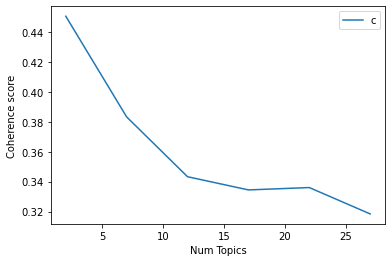

In [147]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [148]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.4505
index: 1 | Num Topics = 7  has Coherence Value of 0.3832
index: 2 | Num Topics = 12  has Coherence Value of 0.3433
index: 3 | Num Topics = 17  has Coherence Value of 0.3345
index: 4 | Num Topics = 22  has Coherence Value of 0.336
index: 5 | Num Topics = 27  has Coherence Value of 0.3184


In [189]:
# Select optimal number of topics
optimal_model_us_2020_score1N2N3 = model_list_us_2020_score1N2N3[0]

In [190]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2020_score1N2N3, corpus_us_2020_score1N2N3, id2word_us_2020_score1N2N3)

In [191]:
print("pyLDAVis for us topics for score=1,2,3 in 2020:")
vis_us_2020_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.092077  0.0       1        1  53.066739
0     -0.092077  0.0       2        1  46.933261, topic_info=              Term        Freq       Total Category  logprob  loglift
1246          fact  200.000000  200.000000  Default  30.0000  30.0000
114         update  180.000000  180.000000  Default  29.0000  29.0000
1730        censor  124.000000  124.000000  Default  28.0000  28.0000
1002       opinion  115.000000  115.000000  Default  27.0000  27.0000
466   notification  136.000000  136.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
203          leave   59.555497   88.849920   Topic2  -5.5790   0.3564
34             app   88.015393  433.650358   Topic2  -5.1884  -0.8383
83            time   68.031572  246.026909   Topic2  -5.4459  -0.5290
514          group   62.501268  133.097234   Topic2  -5.5307   0.0006
166            way   60.127712  144.017042   Topic2  -5.5694  -0.1170

[153 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
117       1  0.925714   access
117       2  0.066122   access
118       1  0.847599  account
118       2  0.149915  account
1422      2  0.990588   agenda
...     ...       ...      ...
116       2  0.068167     week
456       1  0.835076     work
456       2  0.168792     work
296       1  0.518929     year
296       2  0.477961     year

[197 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## By-rating of 2021 (Rating=1,2,3)

In [152]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_us_2021_score1N2N3 = facebook_ios_us_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_us_2021_score1N2N3 = list(sent_to_words(review_us_2021_score1N2N3))
print(review_words_us_2021_score1N2N3[:1])

[['used', 'to', 'like', 'facebook', 'when', 'it', 'first', 'came', 'out', 'it', 'made', 'it', 'easy', 'to', 'keep', 'in', 'touch', 'with', 'my', 'family', 'and', 'friends', 'then', 'zuckerface', 'became', 'wealthy', 'and', 'sold', 'out', 'we', 'now', 'can', 'not', 'say', 'anything', 'that', 'is', 'true', 'he', 'bans', 'people', 'who', 'have', 'different', 'opinions', 'then', 'his', 'owe', 'he', 'says', 'they', 'fact', 'check', 'things', 'that', 'is', 'bull', 'crap', 'they', 'censor', 'everything', 'that', 'is', 'not', 'appraising', 'the', 'democratic', 'party', 'they', 'falsely', 'say', 'the', 'people', 'who', 'back', 'trump', 'or', 'the', 'republican', 'party', 'are', 'lying', 'or', 'somehow', 'unreliable', 'he', 'has', 'sold', 'out', 'to', 'the', 'communist', 'party', 'of', 'china', 'and', 'is', 'ran', 'by', 'their', 'influence', 'we', 'the', 'people', 'should', 'not', 'be', 'censored', 'this', 'is', 'part', 'of', 'our', 'first', 'amendment', 'right', 'freedom', 'of', 'speech', 'if',

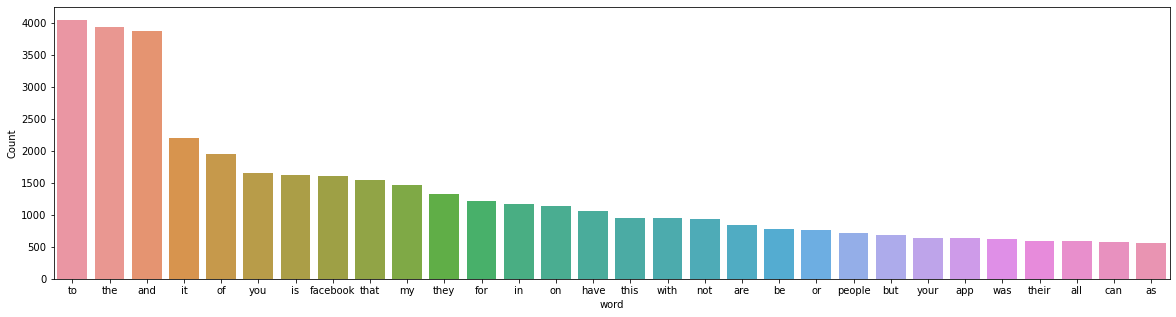

In [153]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_us_2021_score1N2N3))

In [154]:
# Clean text
review_words_us_ready_2021_score1N2N3 = process_words(review_words_us_2021_score1N2N3)  # processed Text Data! - move to each section

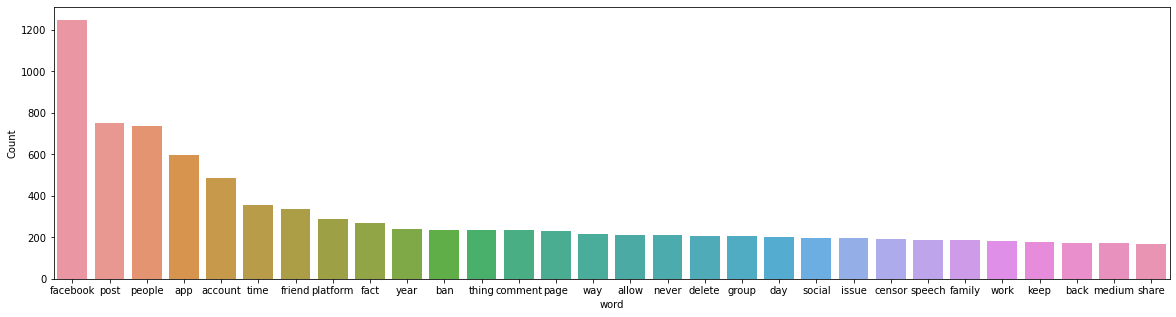

In [155]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_us_ready_2021_score1N2N3))


In [156]:
# Create Dictionary
id2word_us_2021_score1N2N3 = corpora.Dictionary(review_words_us_ready_2021_score1N2N3)

2021-10-16 20:44:49,795 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 20:44:50,087 [INFO] gensim.corpora.dictionary - built Dictionary(4956 unique tokens: ['add', 'allow', 'already', 'appraise', 'back']...) from 746 documents (total 46115 corpus positions)
2021-10-16 20:44:50,090 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(4956 unique tokens: ['add', 'allow', 'already', 'appraise', 'back']...) from 746 documents (total 46115 corpus positions)", 'datetime': '2021-10-16T20:44:50.089942', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [157]:
# Create Corpus: Term Document Frequency
corpus_us_2021_score1N2N3 = [id2word_us_2021_score1N2N3.doc2bow(text) for text in review_words_us_ready_2021_score1N2N3]

In [158]:
# Training LDA model
model_list_us_2021_score1N2N3, coherence_values_us_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_us_2021_score1N2N3, corpus=corpus_us_2021_score1N2N3, 
                                                              texts=review_words_us_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 20:44:50,406 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 20:44:50,408 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 20:44:50,413 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:44:50,417 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 746 documents, updating model once every 746 documents, evaluating perplexity every 746 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:44:55,269 [INFO] gensim.models.ldamodel - -8.969 per-word bound, 501.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:44:55,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #746/746
2021-10-16 20:44:58,766 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"facebook" + 0.013*"people" + 0.012*"post" + 0.011*"app" + 0.008*"account" + 0.006*"year" + 0.006

2021-10-16 20:46:15,085 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.017*"app" + 0.014*"account" + 0.009*"post" + 0.008*"time" + 0.008*"people" + 0.007*"page" + 0.006*"work" + 0.006*"phone" + 0.006*"issue"
2021-10-16 20:46:15,112 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.019*"people" + 0.019*"post" + 0.008*"friend" + 0.008*"platform" + 0.008*"app" + 0.008*"fact" + 0.006*"time" + 0.006*"account" + 0.006*"ban"
2021-10-16 20:46:15,134 [INFO] gensim.models.ldamodel - topic diff=0.040012, rho=0.301511
2021-10-16 20:46:18,512 [INFO] gensim.models.ldamodel - -7.199 per-word bound, 147.0 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:46:18,513 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #746/746
2021-10-16 20:46:20,907 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.017*"app" + 0.014*"account" + 0.009*"post" + 0.008*"time" + 0.008*"people" + 0.007*"pa

2021-10-16 20:47:11,941 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"facebook" + 0.019*"app" + 0.016*"account" + 0.010*"post" + 0.009*"time" + 0.007*"page" + 0.007*"people" + 0.007*"issue" + 0.006*"phone" + 0.006*"work"
2021-10-16 20:47:11,944 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.018*"post" + 0.009*"platform" + 0.009*"fact" + 0.008*"friend" + 0.007*"ban" + 0.007*"censor" + 0.006*"speech" + 0.006*"app"
2021-10-16 20:47:11,946 [INFO] gensim.models.ldamodel - topic diff=0.017309, rho=0.218218
2021-10-16 20:47:14,804 [INFO] gensim.models.ldamodel - -7.173 per-word bound, 144.3 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:47:14,806 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #746/746
2021-10-16 20:47:17,071 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.019*"app" + 0.016*"account" + 0.010*"post" + 0.009*"time" + 0.007*"page" + 0.007*"peo

2021-10-16 20:48:07,779 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.019*"app" + 0.017*"account" + 0.011*"post" + 0.010*"time" + 0.007*"page" + 0.007*"people" + 0.007*"issue" + 0.007*"phone" + 0.006*"work"
2021-10-16 20:48:07,781 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.018*"post" + 0.009*"platform" + 0.009*"fact" + 0.008*"friend" + 0.007*"ban" + 0.007*"censor" + 0.007*"speech" + 0.006*"allow"
2021-10-16 20:48:07,783 [INFO] gensim.models.ldamodel - topic diff=0.007951, rho=0.179605
2021-10-16 20:48:10,801 [INFO] gensim.models.ldamodel - -7.167 per-word bound, 143.7 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:48:10,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #746/746
2021-10-16 20:48:13,854 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.019*"app" + 0.017*"account" + 0.011*"post" + 0.010*"time" + 0.007*"page" + 0.007*"p

2021-10-16 20:49:10,452 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.019*"app" + 0.017*"account" + 0.011*"post" + 0.010*"time" + 0.007*"page" + 0.007*"people" + 0.007*"issue" + 0.007*"phone" + 0.006*"work"
2021-10-16 20:49:10,455 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.009*"platform" + 0.009*"fact" + 0.008*"friend" + 0.007*"ban" + 0.007*"censor" + 0.007*"speech" + 0.006*"allow"
2021-10-16 20:49:10,456 [INFO] gensim.models.ldamodel - topic diff=0.004734, rho=0.156174
2021-10-16 20:49:13,549 [INFO] gensim.models.ldamodel - -7.165 per-word bound, 143.5 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:49:13,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #746/746
2021-10-16 20:49:16,043 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.019*"app" + 0.017*"account" + 0.011*"post" + 0.010*"time" + 0.007*"page" + 0.007*"p

2021-10-16 20:50:13,486 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"facebook" + 0.019*"app" + 0.017*"account" + 0.012*"post" + 0.010*"time" + 0.007*"page" + 0.007*"people" + 0.007*"issue" + 0.007*"phone" + 0.006*"work"
2021-10-16 20:50:13,518 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.025*"facebook" + 0.020*"people" + 0.017*"post" + 0.009*"platform" + 0.009*"fact" + 0.008*"friend" + 0.008*"ban" + 0.007*"censor" + 0.007*"speech" + 0.006*"allow"
2021-10-16 20:50:13,559 [INFO] gensim.models.ldamodel - topic diff=0.003501, rho=0.140028
2021-10-16 20:50:13,568 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=4956, num_topics=2, decay=0.5, chunksize=1000) in 323.15s', 'datetime': '2021-10-16T20:50:13.567931', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 20:50:13,583 [INFO] gensim.topic_coherence.probability_estimation 

2021-10-16 20:50:56,328 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #746/746
2021-10-16 20:50:58,638 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.025*"post" + 0.021*"people" + 0.018*"facebook" + 0.012*"ban" + 0.009*"friend" + 0.009*"thing" + 0.009*"fact" + 0.008*"allow" + 0.007*"censor" + 0.007*"app"
2021-10-16 20:50:58,640 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.023*"post" + 0.021*"facebook" + 0.016*"people" + 0.008*"account" + 0.008*"platform" + 0.008*"time" + 0.006*"medium" + 0.006*"speech" + 0.006*"back" + 0.006*"opinion"
2021-10-16 20:50:58,646 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.020*"facebook" + 0.010*"app" + 0.009*"marketplace" + 0.008*"people" + 0.008*"post" + 0.006*"ad" + 0.006*"item" + 0.005*"still" + 0.005*"social" + 0.005*"group"
2021-10-16 20:50:58,653 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.021*"facebook" + 0.014*"page" + 0.013*"post" + 0.012*"business" + 0.010*"time" + 0.010*"app" + 0.009*"feed" + 0.008*"ba

2021-10-16 20:51:27,848 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.026*"post" + 0.023*"people" + 0.018*"facebook" + 0.013*"ban" + 0.009*"fact" + 0.009*"allow" + 0.008*"censor" + 0.008*"thing" + 0.008*"friend" + 0.008*"platform"
2021-10-16 20:51:27,858 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.022*"people" + 0.009*"post" + 0.008*"app" + 0.008*"share" + 0.008*"fact" + 0.008*"platform" + 0.007*"censor" + 0.007*"social" + 0.007*"place"
2021-10-16 20:51:27,863 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"facebook" + 0.024*"app" + 0.014*"post" + 0.012*"people" + 0.011*"time" + 0.011*"account" + 0.010*"friend" + 0.009*"comment" + 0.009*"phone" + 0.008*"work"
2021-10-16 20:51:27,866 [INFO] gensim.models.ldamodel - topic diff=0.049419, rho=0.301511
2021-10-16 20:51:31,918 [INFO] gensim.models.ldamodel - -7.358 per-word bound, 164.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:51:31,921 [INFO] gen

2021-10-16 20:51:57,657 [INFO] gensim.models.ldamodel - topic diff=0.024642, rho=0.250000
2021-10-16 20:52:00,854 [INFO] gensim.models.ldamodel - -7.343 per-word bound, 162.3 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:52:00,856 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #746/746
2021-10-16 20:52:02,953 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.022*"people" + 0.009*"post" + 0.009*"fact" + 0.009*"platform" + 0.008*"share" + 0.008*"app" + 0.007*"censor" + 0.007*"social" + 0.007*"place"
2021-10-16 20:52:02,955 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.018*"facebook" + 0.013*"marketplace" + 0.010*"app" + 0.008*"item" + 0.007*"ad" + 0.006*"post" + 0.006*"people" + 0.005*"still" + 0.005*"social" + 0.005*"issue"
2021-10-16 20:52:02,958 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.018*"facebook" + 0.015*"page" + 0.013*"post" + 0.012*"business" + 0.011*"video" + 0.010*"feed" + 0.

2021-10-16 20:52:32,635 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"post" + 0.020*"facebook" + 0.018*"people" + 0.009*"platform" + 0.007*"medium" + 0.007*"opinion" + 0.007*"block" + 0.007*"speech" + 0.006*"social" + 0.006*"fact"
2021-10-16 20:52:32,638 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"post" + 0.023*"people" + 0.018*"facebook" + 0.014*"ban" + 0.010*"fact" + 0.009*"censor" + 0.009*"allow" + 0.009*"thing" + 0.009*"speech" + 0.009*"community"
2021-10-16 20:52:32,641 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.023*"people" + 0.009*"platform" + 0.009*"post" + 0.009*"fact" + 0.008*"share" + 0.008*"app" + 0.007*"censor" + 0.007*"social" + 0.007*"political"
2021-10-16 20:52:32,644 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.017*"facebook" + 0.015*"marketplace" + 0.010*"app" + 0.009*"item" + 0.007*"ad" + 0.006*"post" + 0.006*"people" + 0.005*"issue" + 0.005*"still" + 0.005*"social"
2021-10-16 20:52:32,645 [INFO] gensim.model

2021-10-16 20:53:02,044 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.023*"people" + 0.010*"platform" + 0.009*"post" + 0.009*"fact" + 0.008*"share" + 0.008*"app" + 0.007*"social" + 0.007*"censor" + 0.007*"political"
2021-10-16 20:53:02,046 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.016*"facebook" + 0.016*"marketplace" + 0.009*"app" + 0.009*"item" + 0.007*"ad" + 0.005*"post" + 0.005*"people" + 0.005*"issue" + 0.005*"still" + 0.005*"social"
2021-10-16 20:53:02,047 [INFO] gensim.models.ldamodel - topic diff=0.011921, rho=0.192450
2021-10-16 20:53:06,516 [INFO] gensim.models.ldamodel - -7.326 per-word bound, 160.4 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:53:06,533 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #746/746
2021-10-16 20:53:09,503 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"post" + 0.020*"facebook" + 0.018*"people" + 0.009*"platform" + 0.007*"medium" + 0.007*"opi

2021-10-16 20:53:30,676 [INFO] gensim.models.ldamodel - topic diff=0.009739, rho=0.176777
2021-10-16 20:53:34,982 [INFO] gensim.models.ldamodel - -7.321 per-word bound, 159.9 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:53:34,983 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #746/746
2021-10-16 20:53:37,204 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.016*"marketplace" + 0.016*"facebook" + 0.010*"item" + 0.009*"app" + 0.008*"ad" + 0.005*"people" + 0.005*"issue" + 0.005*"still" + 0.005*"post" + 0.005*"listing"
2021-10-16 20:53:37,298 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"post" + 0.020*"facebook" + 0.018*"people" + 0.009*"platform" + 0.007*"medium" + 0.007*"opinion" + 0.007*"speech" + 0.007*"social" + 0.007*"block" + 0.006*"truth"
2021-10-16 20:53:37,305 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.052*"account" + 0.024*"facebook" + 0.014*"email" + 0.013*"hack" + 0.008*"help" + 0.008*"serv

2021-10-16 20:54:01,189 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.016*"page" + 0.015*"facebook" + 0.014*"video" + 0.012*"business" + 0.012*"post" + 0.011*"feed" + 0.010*"marketplace" + 0.008*"back" + 0.008*"time" + 0.008*"ad"
2021-10-16 20:54:01,195 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.054*"account" + 0.025*"facebook" + 0.015*"email" + 0.013*"hack" + 0.008*"help" + 0.008*"service" + 0.008*"password" + 0.008*"send" + 0.008*"change" + 0.007*"user"
2021-10-16 20:54:01,211 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"post" + 0.020*"facebook" + 0.018*"people" + 0.009*"platform" + 0.008*"medium" + 0.007*"opinion" + 0.007*"speech" + 0.007*"social" + 0.007*"block" + 0.006*"truth"
2021-10-16 20:54:01,220 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.023*"people" + 0.011*"platform" + 0.009*"fact" + 0.009*"post" + 0.008*"share" + 0.008*"social" + 0.008*"app" + 0.007*"censor" + 0.007*"medium"
2021-10-16 20:54:01,226 [INFO] gensim.models

2021-10-16 20:54:28,881 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"facebook" + 0.023*"people" + 0.011*"platform" + 0.009*"fact" + 0.009*"post" + 0.008*"share" + 0.008*"social" + 0.008*"app" + 0.007*"censor" + 0.007*"medium"
2021-10-16 20:54:28,884 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"post" + 0.020*"facebook" + 0.018*"people" + 0.009*"platform" + 0.008*"medium" + 0.007*"opinion" + 0.007*"speech" + 0.007*"social" + 0.007*"block" + 0.006*"truth"
2021-10-16 20:54:28,886 [INFO] gensim.models.ldamodel - topic diff=0.006648, rho=0.152499
2021-10-16 20:54:34,687 [INFO] gensim.models.ldamodel - -7.314 per-word bound, 159.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:54:34,689 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #746/746
2021-10-16 20:54:37,508 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"facebook" + 0.027*"app" + 0.015*"post" + 0.012*"time" + 0.011*"friend" + 0.010*"people

2021-10-16 20:54:57,553 [INFO] gensim.models.ldamodel - topic diff=0.005695, rho=0.144338
2021-10-16 20:55:01,292 [INFO] gensim.models.ldamodel - -7.312 per-word bound, 158.9 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:55:01,301 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #746/746
2021-10-16 20:55:04,000 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"facebook" + 0.023*"people" + 0.011*"platform" + 0.009*"fact" + 0.009*"post" + 0.008*"share" + 0.008*"social" + 0.008*"app" + 0.007*"censor" + 0.007*"medium"
2021-10-16 20:55:04,002 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.056*"account" + 0.026*"facebook" + 0.017*"email" + 0.014*"hack" + 0.009*"help" + 0.009*"send" + 0.009*"password" + 0.008*"service" + 0.008*"change" + 0.008*"customer"
2021-10-16 20:55:04,004 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.028*"post" + 0.023*"people" + 0.019*"facebook" + 0.014*"ban" + 0.011*"fact" + 0.010*"censor

2021-10-16 20:55:45,140 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.036*"facebook" + 0.021*"account" + 0.017*"post" + 0.016*"people" + 0.011*"app" + 0.007*"community" + 0.007*"standard" + 0.007*"time" + 0.007*"friend" + 0.006*"back"
2021-10-16 20:55:45,142 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.019*"people" + 0.015*"facebook" + 0.015*"app" + 0.014*"post" + 0.010*"friend" + 0.008*"ban" + 0.008*"family" + 0.008*"thing" + 0.007*"allow" + 0.007*"censor"
2021-10-16 20:55:45,144 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.012*"post" + 0.011*"platform" + 0.008*"people" + 0.007*"group" + 0.007*"app" + 0.007*"comment" + 0.007*"fact" + 0.007*"facebook" + 0.006*"notification" + 0.006*"allow"
2021-10-16 20:55:45,147 [INFO] gensim.models.ldamodel - topic diff=0.638879, rho=0.577350
2021-10-16 20:55:48,663 [INFO] gensim.models.ldamodel - -7.654 per-word bound, 201.4 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:55:48,664 

2021-10-16 20:56:14,384 [INFO] gensim.models.ldamodel - topic diff=0.156235, rho=0.353553
2021-10-16 20:56:18,270 [INFO] gensim.models.ldamodel - -7.482 per-word bound, 178.7 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:56:18,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #746/746
2021-10-16 20:56:20,659 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.027*"facebook" + 0.015*"people" + 0.014*"post" + 0.011*"platform" + 0.009*"fact" + 0.009*"friend" + 0.009*"time" + 0.007*"app" + 0.007*"year" + 0.006*"ban"
2021-10-16 20:56:20,695 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.022*"post" + 0.015*"facebook" + 0.012*"people" + 0.012*"friend" + 0.010*"ban" + 0.008*"platform" + 0.008*"thing" + 0.007*"time" + 0.007*"comment" + 0.007*"app"
2021-10-16 20:56:20,704 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.017*"facebook" + 0.015*"people" + 0.014*"post" + 0.012*"time" + 0.008*"account" + 0.008*"way" + 0.008*"s

2021-10-16 20:56:49,037 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"post" + 0.015*"facebook" + 0.012*"people" + 0.012*"friend" + 0.010*"ban" + 0.008*"thing" + 0.008*"platform" + 0.007*"time" + 0.007*"comment" + 0.007*"app"
2021-10-16 20:56:49,043 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.033*"app" + 0.026*"facebook" + 0.014*"post" + 0.013*"people" + 0.011*"phone" + 0.011*"time" + 0.011*"comment" + 0.010*"friend" + 0.010*"fix" + 0.009*"issue"
2021-10-16 20:56:49,045 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.039*"facebook" + 0.036*"account" + 0.014*"post" + 0.013*"people" + 0.009*"back" + 0.009*"time" + 0.008*"email" + 0.008*"community" + 0.007*"standard" + 0.007*"year"
2021-10-16 20:56:49,047 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.019*"people" + 0.013*"facebook" + 0.012*"friend" + 0.012*"post" + 0.011*"family" + 0.010*"censor" + 0.009*"ban" + 0.007*"app" + 0.007*"allow" + 0.007*"thing"
2021-10-16 20:56:49,051 [INFO] gensim.models.ldamodel -

2021-10-16 20:57:11,574 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.016*"facebook" + 0.014*"people" + 0.013*"post" + 0.011*"time" + 0.008*"way" + 0.008*"share" + 0.007*"account" + 0.007*"medium" + 0.006*"really" + 0.006*"day"
2021-10-16 20:57:11,577 [INFO] gensim.models.ldamodel - topic diff=0.024269, rho=0.229416
2021-10-16 20:57:13,873 [INFO] gensim.models.ldamodel - -7.428 per-word bound, 172.2 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:57:13,876 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #746/746
2021-10-16 20:57:15,355 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"post" + 0.014*"facebook" + 0.012*"people" + 0.012*"friend" + 0.011*"ban" + 0.008*"thing" + 0.008*"platform" + 0.007*"time" + 0.007*"comment" + 0.007*"feed"
2021-10-16 20:57:15,358 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.019*"marketplace" + 0.019*"facebook" + 0.012*"item" + 0.011*"app" + 0.009*"ad" + 0.007*"post" + 0.007

2021-10-16 20:57:35,450 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.014*"platform" + 0.008*"fb" + 0.007*"mode" + 0.007*"content" + 0.007*"ad" + 0.007*"people" + 0.006*"dark" + 0.006*"user" + 0.006*"privacy" + 0.006*"information"
2021-10-16 20:57:35,486 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.026*"facebook" + 0.015*"people" + 0.012*"platform" + 0.012*"post" + 0.009*"friend" + 0.008*"fact" + 0.008*"time" + 0.007*"year" + 0.006*"ban" + 0.006*"speech"
2021-10-16 20:57:35,524 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.018*"facebook" + 0.013*"social" + 0.012*"medium" + 0.008*"kid" + 0.006*"opinion" + 0.006*"people" + 0.006*"platform" + 0.006*"world" + 0.006*"create" + 0.006*"start"
2021-10-16 20:57:35,526 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.023*"post" + 0.013*"facebook" + 0.012*"people" + 0.012*"ban" + 0.012*"friend" + 0.008*"thing" + 0.008*"platform" + 0.007*"time" + 0.007*"comment" + 0.007*"feed"
2021-10-16 20:57:35,529 [INFO] gensim.models.lda

2021-10-16 20:57:57,781 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.040*"account" + 0.040*"facebook" + 0.011*"people" + 0.011*"post" + 0.010*"email" + 0.009*"time" + 0.009*"back" + 0.008*"community" + 0.008*"standard" + 0.008*"year"
2021-10-16 20:57:57,782 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.029*"facebook" + 0.017*"people" + 0.010*"app" + 0.010*"share" + 0.007*"social" + 0.006*"place" + 0.006*"censor" + 0.006*"medium" + 0.006*"family" + 0.006*"platform"
2021-10-16 20:57:57,784 [INFO] gensim.models.ldamodel - topic diff=0.012765, rho=0.182574
2021-10-16 20:58:00,083 [INFO] gensim.models.ldamodel - -7.408 per-word bound, 169.8 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:58:00,085 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #746/746
2021-10-16 20:58:01,537 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.019*"people" + 0.012*"facebook" + 0.012*"family" + 0.012*"friend" + 0.011*"ban" + 0.010*"

2021-10-16 20:58:19,135 [INFO] gensim.models.ldamodel - -7.402 per-word bound, 169.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:58:19,158 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #746/746
2021-10-16 20:58:20,967 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.024*"post" + 0.013*"people" + 0.012*"ban" + 0.012*"facebook" + 0.012*"friend" + 0.008*"thing" + 0.008*"platform" + 0.007*"comment" + 0.007*"feed" + 0.007*"time"
2021-10-16 20:58:20,971 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.014*"facebook" + 0.013*"people" + 0.010*"time" + 0.010*"post" + 0.009*"way" + 0.008*"account" + 0.008*"share" + 0.007*"medium" + 0.007*"really" + 0.007*"day"
2021-10-16 20:58:20,981 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.013*"platform" + 0.009*"fb" + 0.008*"mode" + 0.007*"content" + 0.007*"dark" + 0.007*"ad" + 0.007*"privacy" + 0.007*"user" + 0.006*"information" + 0.006*"company"
2021-10-16 20:58:21,008 [INFO

2021-10-16 20:58:42,076 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"app" + 0.025*"facebook" + 0.017*"post" + 0.012*"time" + 0.012*"phone" + 0.011*"comment" + 0.011*"people" + 0.011*"friend" + 0.010*"group" + 0.010*"update"
2021-10-16 20:58:42,080 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.028*"post" + 0.026*"facebook" + 0.025*"people" + 0.017*"fact" + 0.012*"platform" + 0.012*"censor" + 0.011*"speech" + 0.010*"ban" + 0.010*"allow" + 0.008*"opinion"
2021-10-16 20:58:42,082 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.018*"facebook" + 0.013*"social" + 0.012*"medium" + 0.008*"kid" + 0.006*"video" + 0.006*"people" + 0.006*"create" + 0.006*"show" + 0.006*"start" + 0.006*"bully"
2021-10-16 20:58:42,084 [INFO] gensim.models.ldamodel - topic diff=0.008963, rho=0.156174
2021-10-16 20:58:44,685 [INFO] gensim.models.ldamodel - -7.395 per-word bound, 168.4 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:58:44,690 [INFO] ge

2021-10-16 20:59:01,706 [INFO] gensim.models.ldamodel - topic diff=0.007670, rho=0.147442
2021-10-16 20:59:04,085 [INFO] gensim.models.ldamodel - -7.391 per-word bound, 167.9 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 20:59:04,086 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #746/746
2021-10-16 20:59:05,686 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.029*"facebook" + 0.017*"people" + 0.010*"share" + 0.010*"app" + 0.007*"social" + 0.006*"medium" + 0.006*"family" + 0.006*"place" + 0.006*"platform" + 0.006*"censor"
2021-10-16 20:59:05,688 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.024*"marketplace" + 0.016*"item" + 0.016*"facebook" + 0.011*"ad" + 0.010*"app" + 0.007*"local" + 0.006*"still" + 0.006*"work" + 0.006*"delete" + 0.006*"post"
2021-10-16 20:59:05,689 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.023*"marketplace" + 0.022*"video" + 0.013*"price" + 0.010*"sale" + 0.009*"vehicle" + 0.009*"listi

2021-10-16 20:59:27,469 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 20:59:27,526 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 756 virtual documents
2021-10-16 20:59:29,819 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.058823529411764705
2021-10-16 20:59:29,826 [INFO] gensim.models.ldamodel - using symmetric eta at 0.058823529411764705
2021-10-16 20:59:29,835 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 20:59:29,875 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 17 topics, 50 passes over the supplied corpus of 746 documents, updating model once every 746 documents, evaluating perplexity every 746 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 20:59:33,920 [INFO] gensim.models.ldamodel - -11.980 per-word bound, 4039.7 perplexity estimate based on a held-out corpus of 746 documents with 4611

2021-10-16 20:59:57,376 [INFO] gensim.models.ldamodel - topic diff=0.339637, rho=0.408248
2021-10-16 21:00:00,202 [INFO] gensim.models.ldamodel - -7.608 per-word bound, 195.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:00:00,204 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #746/746
2021-10-16 21:00:01,823 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.030*"app" + 0.022*"log" + 0.022*"phone" + 0.009*"access" + 0.009*"still" + 0.008*"time" + 0.008*"delete" + 0.008*"facebook" + 0.008*"message" + 0.008*"people"
2021-10-16 21:00:01,831 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.022*"people" + 0.019*"facebook" + 0.018*"post" + 0.010*"platform" + 0.010*"fact" + 0.009*"opinion" + 0.008*"speech" + 0.008*"group" + 0.008*"censor" + 0.007*"social"
2021-10-16 21:00:01,834 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.029*"app" + 0.027*"facebook" + 0.013*"post" + 0.013*"people" + 0.012*"comment" + 0.012*"friend

2021-10-16 21:00:24,053 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.041*"marketplace" + 0.020*"app" + 0.019*"item" + 0.014*"facebook" + 0.012*"update" + 0.011*"still" + 0.010*"work" + 0.010*"look" + 0.009*"local" + 0.009*"listing"
2021-10-16 21:00:24,056 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.015*"facebook" + 0.013*"app" + 0.012*"business" + 0.012*"page" + 0.012*"ad" + 0.011*"music" + 0.010*"people" + 0.010*"post" + 0.009*"back" + 0.008*"video"
2021-10-16 21:00:24,057 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.019*"facebook" + 0.017*"post" + 0.016*"time" + 0.013*"people" + 0.011*"message" + 0.011*"page" + 0.011*"app" + 0.011*"back" + 0.011*"block" + 0.009*"day"
2021-10-16 21:00:24,059 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.027*"people" + 0.017*"facebook" + 0.013*"fact" + 0.012*"platform" + 0.010*"post" + 0.010*"social" + 0.009*"thing" + 0.009*"ban" + 0.008*"medium" + 0.007*"app"
2021-10-16 21:00:24,060 [INFO] gensim.models.ldamodel - topic di

2021-10-16 21:00:45,720 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.018*"post" + 0.014*"facebook" + 0.009*"lose" + 0.009*"fb" + 0.006*"photo" + 0.006*"year" + 0.006*"share" + 0.006*"member" + 0.006*"account" + 0.006*"social"
2021-10-16 21:00:45,722 [INFO] gensim.models.ldamodel - topic diff=0.034992, rho=0.242536
2021-10-16 21:00:48,023 [INFO] gensim.models.ldamodel - -7.505 per-word bound, 181.6 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:00:48,024 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #746/746
2021-10-16 21:00:49,819 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.013*"platform" + 0.010*"fact" + 0.010*"post" + 0.009*"ad" + 0.009*"facebook" + 0.008*"company" + 0.008*"user" + 0.006*"political" + 0.006*"figure" + 0.006*"allow"
2021-10-16 21:00:49,822 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.044*"marketplace" + 0.023*"item" + 0.020*"app" + 0.013*"facebook" + 0.012*"update" + 0.011*"work" +

2021-10-16 21:01:09,563 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.022*"facebook" + 0.022*"people" + 0.019*"post" + 0.013*"platform" + 0.011*"opinion" + 0.010*"fact" + 0.010*"speech" + 0.009*"censor" + 0.009*"freedom" + 0.009*"social"
2021-10-16 21:01:09,566 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.046*"account" + 0.042*"facebook" + 0.013*"email" + 0.009*"back" + 0.009*"time" + 0.009*"hack" + 0.009*"help" + 0.009*"never" + 0.008*"change" + 0.008*"access"
2021-10-16 21:01:09,567 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.027*"post" + 0.015*"facebook" + 0.014*"people" + 0.013*"comment" + 0.013*"friend" + 0.009*"time" + 0.009*"ban" + 0.009*"day" + 0.008*"thing" + 0.008*"group"
2021-10-16 21:01:09,570 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.022*"post" + 0.020*"friend" + 0.016*"people" + 0.014*"ban" + 0.012*"facebook" + 0.011*"way" + 0.009*"family" + 0.007*"group" + 0.007*"keep" + 0.007*"well"
2021-10-16 21:01:09,572 [INFO] gensim.models.ldamodel -

2021-10-16 21:01:28,817 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.047*"account" + 0.042*"facebook" + 0.013*"email" + 0.010*"back" + 0.009*"time" + 0.009*"hack" + 0.009*"never" + 0.009*"help" + 0.009*"change" + 0.008*"access"
2021-10-16 21:01:28,820 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.013*"platform" + 0.010*"fact" + 0.010*"ad" + 0.009*"post" + 0.009*"facebook" + 0.008*"user" + 0.008*"company" + 0.007*"political" + 0.006*"check" + 0.006*"figure"
2021-10-16 21:01:28,821 [INFO] gensim.models.ldamodel - topic diff=0.013441, rho=0.188982
2021-10-16 21:01:31,053 [INFO] gensim.models.ldamodel - -7.478 per-word bound, 178.3 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:01:31,054 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #746/746
2021-10-16 21:01:32,568 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.047*"marketplace" + 0.025*"item" + 0.021*"app" + 0.013*"update" + 0.012*"facebook" + 0.012*"work"

2021-10-16 21:01:51,086 [INFO] gensim.models.ldamodel - -7.471 per-word bound, 177.4 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:01:51,089 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #746/746
2021-10-16 21:01:52,474 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.013*"post" + 0.012*"facebook" + 0.010*"lose" + 0.009*"fb" + 0.007*"member" + 0.006*"share" + 0.006*"social" + 0.006*"screen" + 0.006*"photo" + 0.005*"account"
2021-10-16 21:01:52,477 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.013*"platform" + 0.010*"fact" + 0.009*"ad" + 0.009*"post" + 0.008*"facebook" + 0.008*"user" + 0.008*"company" + 0.007*"political" + 0.006*"check" + 0.006*"false"
2021-10-16 21:01:52,479 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.037*"app" + 0.031*"phone" + 0.026*"log" + 0.010*"access" + 0.010*"still" + 0.010*"time" + 0.009*"delete" + 0.009*"message" + 0.009*"error" + 0.007*"people"
2021-10-16 21:01:52,481 [INFO] 

2021-10-16 21:02:13,101 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.024*"facebook" + 0.022*"people" + 0.019*"post" + 0.014*"platform" + 0.011*"speech" + 0.011*"opinion" + 0.010*"censor" + 0.010*"fact" + 0.009*"freedom" + 0.009*"social"
2021-10-16 21:02:13,108 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.021*"facebook" + 0.011*"account" + 0.010*"ban" + 0.008*"people" + 0.007*"user" + 0.007*"censor" + 0.006*"social" + 0.006*"medium" + 0.006*"world" + 0.005*"become"
2021-10-16 21:02:13,111 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.013*"platform" + 0.010*"fact" + 0.009*"ad" + 0.009*"user" + 0.008*"post" + 0.008*"facebook" + 0.008*"company" + 0.007*"political" + 0.006*"check" + 0.006*"false"
2021-10-16 21:02:13,115 [INFO] gensim.models.ldamodel - topic diff=0.007881, rho=0.160128
2021-10-16 21:02:15,140 [INFO] gensim.models.ldamodel - -7.464 per-word bound, 176.6 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:02:15,14

2021-10-16 21:02:32,398 [INFO] gensim.models.ldamodel - topic diff=0.006699, rho=0.150756
2021-10-16 21:02:34,611 [INFO] gensim.models.ldamodel - -7.460 per-word bound, 176.0 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:02:34,617 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #746/746
2021-10-16 21:02:36,210 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.013*"platform" + 0.010*"fact" + 0.009*"user" + 0.009*"ad" + 0.008*"post" + 0.008*"facebook" + 0.008*"company" + 0.007*"political" + 0.006*"check" + 0.006*"false"
2021-10-16 21:02:36,211 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.019*"facebook" + 0.015*"time" + 0.014*"post" + 0.013*"people" + 0.013*"block" + 0.011*"page" + 0.011*"message" + 0.010*"back" + 0.010*"really" + 0.009*"day"
2021-10-16 21:02:36,213 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.024*"facebook" + 0.022*"people" + 0.019*"post" + 0.014*"platform" + 0.011*"speech" + 0.011*"censor" 

2021-10-16 21:02:56,720 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.050*"marketplace" + 0.027*"item" + 0.021*"app" + 0.013*"update" + 0.013*"work" + 0.013*"look" + 0.011*"still" + 0.011*"listing" + 0.010*"facebook" + 0.010*"list"
2021-10-16 21:02:56,742 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.038*"app" + 0.032*"phone" + 0.028*"log" + 0.010*"still" + 0.010*"access" + 0.010*"time" + 0.009*"message" + 0.009*"delete" + 0.009*"error" + 0.007*"people"
2021-10-16 21:02:56,749 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.032*"app" + 0.026*"facebook" + 0.021*"post" + 0.015*"comment" + 0.012*"time" + 0.012*"friend" + 0.011*"people" + 0.011*"group" + 0.010*"fix" + 0.010*"update"
2021-10-16 21:02:56,754 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.018*"facebook" + 0.015*"time" + 0.014*"post" + 0.013*"block" + 0.013*"people" + 0.011*"page" + 0.011*"message" + 0.010*"back" + 0.010*"really" + 0.009*"day"
2021-10-16 21:02:56,759 [INFO] gensim.models.ldamodel - topic 

2021-10-16 21:03:29,964 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.029*"account" + 0.021*"facebook" + 0.017*"post" + 0.015*"people" + 0.012*"app" + 0.007*"block" + 0.007*"access" + 0.006*"social" + 0.006*"work" + 0.006*"give"
2021-10-16 21:03:29,966 [INFO] gensim.models.ldamodel - topic diff=0.575333, rho=0.500000
2021-10-16 21:03:32,351 [INFO] gensim.models.ldamodel - -7.821 per-word bound, 226.2 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:03:32,352 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #746/746
2021-10-16 21:03:33,897 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.024*"facebook" + 0.012*"way" + 0.011*"people" + 0.011*"post" + 0.008*"phone" + 0.007*"free" + 0.006*"thing" + 0.006*"never" + 0.006*"support" + 0.005*"member"
2021-10-16 21:03:33,900 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.023*"facebook" + 0.017*"fact" + 0.011*"people" + 0.009*"app" + 0.009*"group" + 0.008*"checker" + 0.0

2021-10-16 21:03:53,230 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #746/746
2021-10-16 21:03:54,825 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.027*"people" + 0.016*"facebook" + 0.015*"post" + 0.013*"fact" + 0.010*"comment" + 0.010*"ban" + 0.009*"company" + 0.009*"censor" + 0.008*"app" + 0.008*"platform"
2021-10-16 21:03:54,828 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.030*"marketplace" + 0.026*"app" + 0.019*"facebook" + 0.013*"update" + 0.012*"item" + 0.010*"ad" + 0.009*"still" + 0.008*"work" + 0.007*"option" + 0.007*"local"
2021-10-16 21:03:54,839 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.021*"people" + 0.019*"app" + 0.015*"facebook" + 0.011*"post" + 0.007*"keep" + 0.007*"page" + 0.007*"friend" + 0.007*"way" + 0.007*"censor" + 0.007*"freedom"
2021-10-16 21:03:54,843 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.017*"app" + 0.016*"facebook" + 0.014*"marketplace" + 0.011*"people" + 0.010*"year" + 0.008*"listing" + 0.006*"way" + 0.00

2021-10-16 21:04:15,121 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.022*"facebook" + 0.016*"post" + 0.014*"account" + 0.012*"express" + 0.012*"idea" + 0.012*"people" + 0.012*"report" + 0.011*"opinion" + 0.009*"liberal" + 0.009*"app"
2021-10-16 21:04:15,124 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.021*"people" + 0.019*"facebook" + 0.014*"platform" + 0.014*"group" + 0.010*"post" + 0.009*"video" + 0.008*"social" + 0.007*"opinion" + 0.007*"medium" + 0.007*"country"
2021-10-16 21:04:15,129 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.023*"post" + 0.013*"people" + 0.012*"friend" + 0.012*"thing" + 0.011*"time" + 0.011*"facebook" + 0.011*"comment" + 0.010*"ban" + 0.008*"platform" + 0.008*"app"
2021-10-16 21:04:15,132 [INFO] gensim.models.ldamodel - topic diff=0.052018, rho=0.258199
2021-10-16 21:04:17,502 [INFO] gensim.models.ldamodel - -7.601 per-word bound, 194.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:04:17,5

2021-10-16 21:04:35,474 [INFO] gensim.models.ldamodel - topic diff=0.027368, rho=0.223607
2021-10-16 21:04:37,626 [INFO] gensim.models.ldamodel - -7.579 per-word bound, 191.2 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:04:37,628 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #746/746
2021-10-16 21:04:39,172 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.022*"people" + 0.015*"app" + 0.013*"facebook" + 0.010*"post" + 0.008*"page" + 0.007*"freedom" + 0.007*"censor" + 0.007*"give" + 0.007*"way" + 0.006*"away"
2021-10-16 21:04:39,183 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.029*"facebook" + 0.018*"people" + 0.011*"app" + 0.010*"place" + 0.009*"share" + 0.008*"family" + 0.008*"time" + 0.008*"friend" + 0.007*"censor" + 0.006*"ad"
2021-10-16 21:04:39,191 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.042*"facebook" + 0.015*"post" + 0.013*"people" + 0.010*"never" + 0.010*"platform" + 0.009*"friend" + 0.009*

2021-10-16 21:05:00,138 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.036*"people" + 0.023*"facebook" + 0.016*"video" + 0.014*"post" + 0.011*"platform" + 0.010*"censor" + 0.010*"allow" + 0.008*"truth" + 0.007*"speech" + 0.007*"matter"
2021-10-16 21:05:00,209 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.040*"phone" + 0.038*"log" + 0.033*"app" + 0.012*"login" + 0.011*"time" + 0.011*"access" + 0.011*"delete" + 0.010*"feed" + 0.010*"contact" + 0.009*"friend"
2021-10-16 21:05:00,224 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.043*"facebook" + 0.014*"post" + 0.013*"people" + 0.010*"never" + 0.010*"platform" + 0.008*"friend" + 0.008*"time" + 0.008*"issue" + 0.007*"year" + 0.006*"call"
2021-10-16 21:05:00,226 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.022*"facebook" + 0.016*"post" + 0.014*"account" + 0.013*"idea" + 0.013*"express" + 0.012*"people" + 0.012*"report" + 0.012*"opinion" + 0.009*"liberal" + 0.008*"app"
2021-10-16 21:05:00,228 [INFO] gensim.models.ld

2021-10-16 21:05:19,894 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.023*"post" + 0.013*"people" + 0.012*"friend" + 0.012*"thing" + 0.011*"comment" + 0.011*"ban" + 0.011*"time" + 0.009*"facebook" + 0.008*"day" + 0.008*"platform"
2021-10-16 21:05:19,900 [INFO] gensim.models.ldamodel - topic diff=0.013032, rho=0.179605
2021-10-16 21:05:22,643 [INFO] gensim.models.ldamodel - -7.551 per-word bound, 187.5 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:05:22,645 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #746/746
2021-10-16 21:05:24,383 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"facebook" + 0.025*"app" + 0.017*"post" + 0.014*"comment" + 0.012*"work" + 0.012*"issue" + 0.012*"fix" + 0.012*"friend" + 0.011*"time" + 0.010*"people"
2021-10-16 21:05:24,385 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.027*"post" + 0.019*"app" + 0.019*"facebook" + 0.017*"avatar" + 0.016*"page" + 0.012*"update" + 0.012*"n

2021-10-16 21:05:46,228 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.086*"account" + 0.036*"facebook" + 0.031*"email" + 0.020*"business" + 0.020*"hack" + 0.019*"help" + 0.016*"back" + 0.016*"change" + 0.015*"customer" + 0.015*"send"
2021-10-16 21:05:46,230 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.022*"people" + 0.014*"app" + 0.012*"facebook" + 0.009*"post" + 0.008*"page" + 0.008*"censor" + 0.008*"freedom" + 0.007*"away" + 0.007*"give" + 0.006*"way"
2021-10-16 21:05:46,234 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.024*"facebook" + 0.019*"account" + 0.017*"post" + 0.014*"people" + 0.010*"app" + 0.008*"block" + 0.008*"report" + 0.008*"social" + 0.007*"day" + 0.007*"put"
2021-10-16 21:05:46,237 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.022*"facebook" + 0.018*"fact" + 0.011*"people" + 0.010*"app" + 0.010*"group" + 0.009*"checker" + 0.009*"social" + 0.007*"political" + 0.007*"long" + 0.007*"site"
2021-10-16 21:05:46,240 [INFO] gensim.models.ldamodel - 

2021-10-16 21:06:07,318 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.021*"facebook" + 0.017*"post" + 0.015*"time" + 0.013*"way" + 0.013*"app" + 0.012*"people" + 0.011*"friend" + 0.011*"group" + 0.010*"family" + 0.010*"day"
2021-10-16 21:06:07,321 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.028*"facebook" + 0.026*"app" + 0.018*"post" + 0.014*"comment" + 0.012*"issue" + 0.012*"work" + 0.012*"friend" + 0.012*"fix" + 0.011*"time" + 0.010*"people"
2021-10-16 21:06:07,325 [INFO] gensim.models.ldamodel - topic diff=0.008399, rho=0.154303
2021-10-16 21:06:09,711 [INFO] gensim.models.ldamodel - -7.536 per-word bound, 185.6 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:06:09,713 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #746/746
2021-10-16 21:06:11,646 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.023*"post" + 0.013*"people" + 0.012*"friend" + 0.012*"thing" + 0.012*"ban" + 0.011*"comment" + 0.011*"time" + 

2021-10-16 21:06:30,636 [INFO] gensim.models.ldamodel - -7.531 per-word bound, 185.0 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:06:30,637 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #746/746
2021-10-16 21:06:32,486 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.036*"people" + 0.022*"facebook" + 0.018*"video" + 0.013*"post" + 0.011*"allow" + 0.011*"censor" + 0.011*"platform" + 0.008*"truth" + 0.007*"matter" + 0.006*"white"
2021-10-16 21:06:32,489 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.022*"people" + 0.013*"app" + 0.012*"facebook" + 0.009*"post" + 0.008*"page" + 0.008*"censor" + 0.008*"freedom" + 0.007*"away" + 0.007*"give" + 0.006*"human"
2021-10-16 21:06:32,493 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.021*"facebook" + 0.018*"fact" + 0.011*"people" + 0.011*"app" + 0.010*"group" + 0.009*"checker" + 0.009*"social" + 0.007*"long" + 0.007*"political" + 0.007*"site"
2021-10-16 21:06:32,495 [

2021-10-16 21:07:02,999 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.019*"post" + 0.015*"facebook" + 0.014*"people" + 0.011*"platform" + 0.010*"friend" + 0.010*"ban" + 0.009*"app" + 0.008*"comment" + 0.008*"day" + 0.008*"time"
2021-10-16 21:07:03,006 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.021*"people" + 0.016*"post" + 0.014*"facebook" + 0.010*"app" + 0.009*"platform" + 0.008*"group" + 0.008*"fact" + 0.007*"social" + 0.007*"speech" + 0.006*"thing"
2021-10-16 21:07:03,018 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.019*"video" + 0.016*"app" + 0.012*"phone" + 0.011*"fact" + 0.011*"people" + 0.010*"allow" + 0.010*"facebook" + 0.009*"group" + 0.008*"time" + 0.007*"family"
2021-10-16 21:07:03,024 [INFO] gensim.models.ldamodel - topic diff=18.798912, rho=1.000000
2021-10-16 21:07:05,810 [INFO] gensim.models.ldamodel - -8.345 per-word bound, 325.2 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:07:05,811 [INFO] gensim

2021-10-16 21:07:25,002 [INFO] gensim.models.ldamodel - topic diff=0.359795, rho=0.377964
2021-10-16 21:07:27,076 [INFO] gensim.models.ldamodel - -7.748 per-word bound, 215.0 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:07:27,078 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #746/746
2021-10-16 21:07:28,385 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.021*"facebook" + 0.015*"fact" + 0.010*"change" + 0.008*"opinion" + 0.008*"people" + 0.008*"site" + 0.008*"app" + 0.007*"social" + 0.007*"political" + 0.007*"post"
2021-10-16 21:07:28,388 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.017*"ad" + 0.010*"post" + 0.010*"picture" + 0.010*"social" + 0.010*"user" + 0.010*"company" + 0.009*"app" + 0.009*"stop" + 0.009*"thing" + 0.009*"platform"
2021-10-16 21:07:28,392 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.031*"app" + 0.030*"facebook" + 0.017*"post" + 0.015*"people" + 0.014*"comment" + 0.012*"friend" + 0.

2021-10-16 21:07:47,696 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.023*"facebook" + 0.021*"people" + 0.013*"post" + 0.010*"platform" + 0.008*"video" + 0.008*"censor" + 0.007*"speech" + 0.006*"free" + 0.005*"allow" + 0.005*"let"
2021-10-16 21:07:47,705 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.019*"app" + 0.012*"page" + 0.010*"look" + 0.009*"back" + 0.008*"people" + 0.007*"issue" + 0.007*"show" + 0.007*"friend" + 0.007*"family" + 0.006*"music"
2021-10-16 21:07:47,722 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.042*"facebook" + 0.023*"people" + 0.017*"share" + 0.012*"family" + 0.011*"friend" + 0.010*"place" + 0.009*"platform" + 0.009*"allow" + 0.008*"fact" + 0.008*"post"
2021-10-16 21:07:47,724 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.028*"people" + 0.015*"fact" + 0.014*"ban" + 0.014*"facebook" + 0.013*"post" + 0.012*"company" + 0.011*"platform" + 0.009*"social" + 0.008*"thing" + 0.008*"standard"
2021-10-16 21:07:47,730 [INFO] gensim.models.ldamode

2021-10-16 21:08:08,670 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.023*"facebook" + 0.018*"post" + 0.015*"app" + 0.014*"account" + 0.011*"page" + 0.011*"put" + 0.011*"tell" + 0.010*"option" + 0.009*"update" + 0.009*"problem"
2021-10-16 21:08:08,672 [INFO] gensim.models.ldamodel - topic diff=0.036200, rho=0.235702
2021-10-16 21:08:11,038 [INFO] gensim.models.ldamodel - -7.646 per-word bound, 200.2 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:08:11,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #746/746
2021-10-16 21:08:12,629 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.023*"facebook" + 0.018*"post" + 0.015*"app" + 0.013*"account" + 0.012*"page" + 0.011*"put" + 0.011*"tell" + 0.011*"option" + 0.009*"update" + 0.009*"problem"
2021-10-16 21:08:12,631 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.017*"facebook" + 0.009*"review" + 0.009*"world" + 0.008*"censor" + 0.008*"app" + 0.008*"time" + 0.007*

2021-10-16 21:08:32,599 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.046*"marketplace" + 0.032*"app" + 0.020*"filter" + 0.018*"post" + 0.015*"work" + 0.014*"crash" + 0.014*"update" + 0.012*"vehicle" + 0.011*"group" + 0.011*"look"
2021-10-16 21:08:32,603 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.022*"facebook" + 0.019*"post" + 0.016*"app" + 0.012*"page" + 0.011*"put" + 0.011*"tell" + 0.011*"option" + 0.010*"account" + 0.009*"update" + 0.009*"version"
2021-10-16 21:08:32,605 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"video" + 0.020*"app" + 0.018*"phone" + 0.013*"play" + 0.012*"fact" + 0.012*"facebook" + 0.012*"log" + 0.011*"allow" + 0.011*"check" + 0.010*"time"
2021-10-16 21:08:32,607 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.021*"people" + 0.018*"friend" + 0.017*"facebook" + 0.012*"app" + 0.012*"post" + 0.010*"family" + 0.009*"way" + 0.009*"thing" + 0.009*"well" + 0.008*"ban"
2021-10-16 21:08:32,610 [INFO] gensim.models.ldamodel - topic #26 (0

2021-10-16 21:08:52,512 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.029*"people" + 0.016*"fact" + 0.015*"ban" + 0.014*"facebook" + 0.013*"post" + 0.012*"company" + 0.012*"platform" + 0.010*"social" + 0.010*"standard" + 0.008*"checker"
2021-10-16 21:08:52,517 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.020*"app" + 0.018*"log" + 0.013*"access" + 0.012*"time" + 0.011*"account" + 0.010*"feed" + 0.010*"facebook" + 0.010*"delete" + 0.010*"contact" + 0.010*"thing"
2021-10-16 21:08:52,519 [INFO] gensim.models.ldamodel - topic diff=0.014210, rho=0.185695
2021-10-16 21:08:54,808 [INFO] gensim.models.ldamodel - -7.613 per-word bound, 195.8 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:08:54,810 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #746/746
2021-10-16 21:08:56,903 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.024*"people" + 0.022*"post" + 0.016*"facebook" + 0.014*"opinion" + 0.012*"account" + 0.009*

2021-10-16 21:09:15,427 [INFO] gensim.models.ldamodel - -7.603 per-word bound, 194.4 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:09:15,428 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #746/746
2021-10-16 21:09:16,991 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.038*"app" + 0.031*"facebook" + 0.020*"post" + 0.016*"comment" + 0.014*"people" + 0.013*"time" + 0.012*"friend" + 0.012*"phone" + 0.011*"fix" + 0.010*"issue"
2021-10-16 21:09:16,994 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.031*"facebook" + 0.015*"post" + 0.012*"people" + 0.011*"platform" + 0.009*"time" + 0.009*"fact" + 0.009*"friend" + 0.008*"year" + 0.007*"never" + 0.007*"liberal"
2021-10-16 21:09:16,995 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.019*"ad" + 0.012*"social" + 0.011*"picture" + 0.011*"post" + 0.011*"app" + 0.010*"stop" + 0.010*"user" + 0.010*"company" + 0.009*"medium" + 0.009*"platform"
2021-10-16 21:09:16,998 [INFO] g

2021-10-16 21:09:37,402 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.039*"app" + 0.031*"facebook" + 0.020*"post" + 0.015*"comment" + 0.014*"people" + 0.013*"time" + 0.012*"friend" + 0.012*"phone" + 0.010*"fix" + 0.010*"issue"
2021-10-16 21:09:37,404 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.045*"account" + 0.043*"facebook" + 0.014*"email" + 0.012*"time" + 0.010*"hack" + 0.010*"help" + 0.010*"back" + 0.009*"change" + 0.009*"people" + 0.008*"access"
2021-10-16 21:09:37,405 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.029*"people" + 0.016*"fact" + 0.015*"ban" + 0.014*"facebook" + 0.012*"post" + 0.012*"company" + 0.012*"platform" + 0.010*"social" + 0.010*"standard" + 0.009*"checker"
2021-10-16 21:09:37,406 [INFO] gensim.models.ldamodel - topic diff=0.009193, rho=0.158114
2021-10-16 21:09:39,653 [INFO] gensim.models.ldamodel - -7.593 per-word bound, 193.1 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:09:39,654 [INFO]

2021-10-16 21:09:59,411 [INFO] gensim.models.ldamodel - topic diff=0.007744, rho=0.149071
2021-10-16 21:10:01,696 [INFO] gensim.models.ldamodel - -7.587 per-word bound, 192.2 perplexity estimate based on a held-out corpus of 746 documents with 46115 words
2021-10-16 21:10:01,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #746/746
2021-10-16 21:10:03,128 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.039*"app" + 0.030*"facebook" + 0.020*"post" + 0.015*"comment" + 0.014*"people" + 0.013*"time" + 0.012*"friend" + 0.012*"phone" + 0.010*"fix" + 0.010*"issue"
2021-10-16 21:10:03,131 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.019*"platform" + 0.018*"reply" + 0.018*"comment" + 0.015*"post" + 0.010*"story" + 0.010*"content" + 0.010*"share" + 0.009*"allow" + 0.008*"group" + 0.007*"social"
2021-10-16 21:10:03,148 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.042*"video" + 0.016*"phone" + 0.015*"app" + 0.013*"play" + 0.012*"fact" + 0.011*"allow" + 0.011*"lo

2021-10-16 21:10:23,468 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.051*"marketplace" + 0.031*"app" + 0.022*"filter" + 0.016*"post" + 0.014*"work" + 0.013*"crash" + 0.012*"vehicle" + 0.012*"look" + 0.011*"list" + 0.011*"item"
2021-10-16 21:10:23,484 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.031*"facebook" + 0.015*"post" + 0.012*"people" + 0.012*"platform" + 0.009*"fact" + 0.009*"time" + 0.009*"year" + 0.008*"friend" + 0.008*"liberal" + 0.007*"never"
2021-10-16 21:10:23,517 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.019*"post" + 0.013*"work" + 0.013*"speech" + 0.013*"facebook" + 0.010*"people" + 0.008*"picture" + 0.008*"fb" + 0.007*"way" + 0.007*"block" + 0.007*"hate"
2021-10-16 21:10:23,530 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.024*"item" + 0.022*"marketplace" + 0.018*"facebook" + 0.012*"app" + 0.010*"work" + 0.010*"local" + 0.009*"still" + 0.009*"issue" + 0.008*"listing" + 0.008*"option"
2021-10-16 21:10:23,536 [INFO] gensim.models.ldamodel 

In [159]:
%store model_list_us_2021_score1N2N3
%store coherence_values_us_2021_score1N2N3

Stored 'model_list_us_2021_score1N2N3' (list)
Stored 'coherence_values_us_2021_score1N2N3' (list)


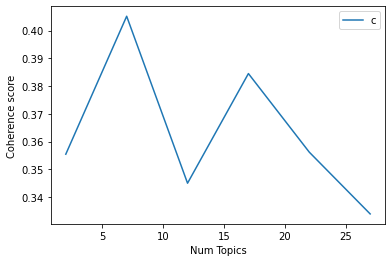

In [160]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_us_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [161]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_us_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3555
index: 1 | Num Topics = 7  has Coherence Value of 0.4051
index: 2 | Num Topics = 12  has Coherence Value of 0.345
index: 3 | Num Topics = 17  has Coherence Value of 0.3845
index: 4 | Num Topics = 22  has Coherence Value of 0.3562
index: 5 | Num Topics = 27  has Coherence Value of 0.3339


In [192]:
# Select optimal number of topics
optimal_model_us_2021_score1N2N3 = model_list_us_2021_score1N2N3[1]

In [193]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_us_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_us_2021_score1N2N3, corpus_us_2021_score1N2N3, id2word_us_2021_score1N2N3)

In [194]:
print("pyLDAVis for us topics for score=1,2,3 in 2021:")
vis_us_2021_score1N2N3

pyLDAVis for us topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.051955 -0.039164       1        1  32.183604
2     -0.132723  0.018569       2        1  18.738076
3     -0.110174  0.023162       3        1  18.396437
1     -0.100129  0.020385       4        1  11.818184
4      0.054056 -0.178822       5        1   8.812750
0      0.095393  0.071725       6        1   6.681575
5      0.141622  0.084144       7        1   3.369374, topic_info=             Term        Freq       Total Category  logprob  loglift
96        account  435.000000  435.000000  Default  30.0000  30.0000
80           page  208.000000  208.000000  Default  29.0000  29.0000
82           post  688.000000  688.000000  Default  28.0000  28.0000
281   marketplace  101.000000  101.000000  Default  27.0000  27.0000
970         email   83.000000   83.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
280          item    5.534602   50.092999   Topic7  -5.6374   1.1876
687           old    5.919595   70.065829   Topic7  -5.5702   0.9193
171       product    5.522947   53.626227   Topic7  -5.6395   1.1173
1045         work    5.806064  166.636808   Topic7  -5.5895   0.0335
217           way    5.811638  201.113016   Topic7  -5.5886  -0.1536

[560 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
552       1  0.292787  absolute
552       6  0.585573  absolute
824       1  0.610148    access
824       3  0.067794    access
824       5  0.305074    access
...     ...       ...       ...
142       5  0.130367      year
142       6  0.017982      year
2931      4  0.818044   zionist
4283      6  0.804842       zip
2046      7  0.442641      zoom

[1293 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 4, 2, 5, 1, 6])

# Export pyLDAvis as html

In [196]:
# Overall
pyLDAvis.save_html(vis_us,'facebook_vis_us.html')

# By-rating 
pyLDAvis.save_html(vis_us_score1,'facebook_vis_us_score1.html')
pyLDAvis.save_html(vis_us_score2,'facebook_vis_us_score2.html')
pyLDAvis.save_html(vis_us_score3,'facebook_vis_us_score3.html')
pyLDAvis.save_html(vis_us_score4,'facebook_vis_us_score4.html')
pyLDAvis.save_html(vis_us_score5,'facebook_vis_us_score5.html')
pyLDAvis.save_html(vis_us_score1N2N3,'facebook_vis_us_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_us_2021_score1N2N3,'facebook_vis_us_2021_score1N2N3.html')
pyLDAvis.save_html(vis_us_2020_score1N2N3,'facebook_vis_us_2020_score1N2N3.html')
pyLDAvis.save_html(vis_us_2019_score1N2N3,'facebook_vis_us_2019_score1N2N3.html')
pyLDAvis.save_html(vis_us_2018_score1N2N3,'facebook_vis_us_2018_score1N2N3.html')

